In [1]:
#下面这行代码，是为了把自己编写的代码文件当作一共模块导入，这里是把Utilities文件夹中的plotting.py文件当作python的模块导入，对应的是下面的from plotting import newfig, savefig。路径要随着不同设备的系统做相应的修改
import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../../Utilities/') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。

import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号


from plotting_torch import newfig, savefig #从自定义的plotting_torch.py文件中导入了newfig和savefig函数。这两个函数用于创建和保存图形。这两个函数的定义在plotting_torch.py文件中

from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。



In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（因为没有激活函数了）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict)
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # 新增方法，获取最后一个隐藏层的输出
    def hidden_output(self, x):
        # 遍历每一层，直到最后一个隐藏层
        for i in range(self.depth - 1):
            # 获取当前层的线性变换
            x = self.layers[i*2](x)
            # 获取当前层的激活函数
            x = self.layers[i*2 + 1](x)
        # 返回最后一个隐藏层的输出
        return x

In [5]:
#set the class of PINN

#定义了一个名为`PhysicsInformedNN'的类，用于实现基于物理的神经网络。
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, u0, v0, tb, X_f, layers, lb, ub, X_star, u_star, v_star, h_star): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数
        
        
        #`numpy.concatenate`是一个用于数组拼接的函数。它可以将多个数组沿指定的轴拼接在一起，形成一个新的数组：numpy.concatenate((a1,a2, ...), axis=0)其中，`a1,a2, ...`是需要拼接的数组（只能接受数组或序列类型的参数，且参数形状必须相同），可以是多个。`axis`参数用于指定拼接的轴向，`axis=0`表示沿着第一个轴（即行）进行拼接，不指定`axis`参数默认值是0。
        X0 = np.concatenate((x0,0*x0), 1) # [x0, 0],将x0和0*x0两个数组在第二个维度（即列）上进行了合并。0*x0会生成一个与x0形状相同，但所有元素都为0的数组。因此，X0的结果是一个新的二维数组，其中第一列是x0的值，第二列全为0
        X_lb = np.concatenate((0*tb+lb[0],tb), 1) # [lb[0], tb],将0*tb+lb[0]和tb两个数组在第二个维度（即列）上进行了合并。0*tb+lb[0]会生成一个与tb形状相同，但所有元素都为lb[0]的数组。因此，X_lb的结果是一个新的二维数组，其中第一列全为lb[0]的值，第二列是tb的值。
        X_ub = np.concatenate((0*tb+ub[0],tb), 1) # [ub[0], tb],同上生成一个与tb形状相同，但所有元素都为ub[0]的数组。因此，X_ub的结果是一个新的二维数组，其中第一列全为ub[0]的值，第二列是tb的值
        
        #Python使用self关键字来表示类的实例。当在类的方法中定义一个变量时，例如lb和ub，这些变量只在该方法内部可见，也就是说它们的作用域仅限于该方法。当方法执行完毕后，这些变量就会被销毁，无法在其他方法中访问它们。但如果希望在类的其他方法中也能访问这些变量就需要将它们保存为类的实例属性。这就是self.lb和self.ub的作用。
            #通过将lb和ub赋值给self.lb和self.ub，就可以在类的其他方法中通过self.lb和self.ub来访问这些值。总的来说，self.lb和self.ub是类的实例属性，它们的作用域是整个类，而不仅仅是定义它们的方法。
        self.lb = torch.tensor(lb).float().to(device) #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.ub = torch.tensor(ub).float().to(device)


        self.x0 = torch.tensor(X0[:,0:1], requires_grad=True).float().to(device) #将X0的第一列赋值给self.x0（:表示取所有行,0：1实际上表示取第一列，因为python是左闭右开的）,将X0的第二列赋值给self.t0。这样可以在类的其他方法中通过self.x0和self.t0来访问这些值。
        self.t0 = torch.tensor(X0[:,1:2], requires_grad=True).float().to(device) #将x0的第二列赋值给self.t0

        self.x_lb = torch.tensor(X_lb[:,0:1], requires_grad=True).float().to(device) #将X_lb的第一列赋值给self.x_lb
        self.t_lb = torch.tensor(X_lb[:,1:2], requires_grad=True).float().to(device) #将X_lb的第二列赋值给self.t_lb

        self.x_ub = torch.tensor(X_ub[:,0:1], requires_grad=True).float().to(device) #将X_ub的第一列赋值给self.x_ub
        self.t_ub = torch.tensor(X_ub[:,0:1], requires_grad=True).float().to(device) #将X_ub的第二列赋值给self.t_ub
        
        self.x_f = torch.tensor(X_f[:,0:1], requires_grad=True).float().to(device) #将X_f的第一列赋值给self.x_f
        self.t_f = torch.tensor(X_f[:,1:2], requires_grad=True).float().to(device) #将X_f的第二列赋值给self.t_f
        
        self.u0 = torch.tensor(u0).float().to(device) #将传入的u0和v0参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.u0和self.v0来访问这些值。
        self.v0 = torch.tensor(v0).float().to(device)


        self.x_star = torch.tensor(X_star[:,0:1], requires_grad=True).float().to(device) #将X_star的第一列赋值给self.x_star
        self.t_star = torch.tensor(X_star[:,1:2], requires_grad=True).float().to(device) #将X_star的第二列赋值给self.t_star
        self.u_star = torch.tensor(u_star).float().to(device) #将传入的u_star和v_star参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.u_star和self.v_star来访问这些值。
        self.v_star = torch.tensor(v_star).float().to(device)
        self.h_star = torch.tensor(h_star).float().to(device)
        
        # Initialize NNs 
        self.layers = layers #将传入的layers参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.layers来访问这些值。
        
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上



        # optimizers: using the same settings，这里是使用pytorch库进行优化的部分
        #创建优化器optimizer，使用LBFGS算法，具体每个参数意义见下方
        self.optimizer_LBFGS = torch.optim.LBFGS(
            self.dnn.parameters(), #要优化的参数，这里返回的是一个生成器，包含了self.dnn中的所有参数（神经网络权重、偏置以及两个新加的变量）
            lr=1.0,  #学习率设置为1
            max_iter=50000,  #最大迭代次数为50000
            max_eval=50000,  #最大评估次数为50000
            history_size=50, #历史大小为50，即用于计算Hessian矩阵近似的最近几步的信息
            tolerance_grad=1e-5,  #优化的第一个停止条件，当梯度的L2范数小于1e-5时停止优化
            tolerance_change=1.0 * np.finfo(float).eps, #优化的第二个停止条件，当优化的目标函数值的变化小于1.0 * np.finfo(float).eps时停止优化
            line_search_fn="strong_wolfe"       # 制定了用于一维搜索的方法，这里表示用强Wolfe条件
        )
        #创建第二个优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
                

        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差
    
    #这个函数与下面的net_uv函数功能相同，只是不计算梯度，因为在记录每个epoch的error时，使用with torch.no_grad()情况下调用net_uv函数会报错，不知道为啥？
    def net_uv_error(self, x, t):  
        uv = self.dnn(torch.cat([x, t], dim=1))  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        #将uv（是一个二维张量）的第一列赋值给u，第二列赋值给v
        u=uv[:,0:1]
        v=uv[:,1:2]

        return u,v #返回神经网络的输出u和v，以及u关于x的梯度u_x和v关于x的梯度v_x


    #pytorch中
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_uv(self, x, t):  
        uv = self.dnn(torch.cat([x, t], dim=1))  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        #将uv（是一个二维张量）的第一列赋值给u，第二列赋值给v
        u=uv[:,0:1]
        v=uv[:,1:2]

        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        v_x = torch.autograd.grad(
            v, x, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]

        return u,v,u_x,v_x #返回神经网络的输出u和v，以及u关于x的梯度u_x和v关于x的梯度v_x


    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f_uv(self, x, t):
        """ The pytorch autograd version of calculating residual """

        u,v,u_x,v_x=self.net_uv(x,t) #调用上面的函数/方法，计算神经网络的输出（两个）以及输出关于输入x的梯度（两个）
        
        #计算u关于t的梯度，也就是u关于t的导数，这里使用了pytorch的自动求导功能
        u_t = torch.autograd.grad(
            u, t,  #输入的张量，要计算u关于t的导数
            grad_outputs=torch.ones_like(u), #生成一个与u形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        v_t = torch.autograd.grad(
            v, t, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        v_xx = torch.autograd.grad(
            v_x, x, 
            grad_outputs=torch.ones_like(v_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f_u=u_t+0.5*v_xx+(u**2+v**2)*v    #计算f_u,定义见论文
        f_v=v_t-0.5*u_xx-(u**2+v**2)*u   #计算f_v,定义见论文
        return f_u, f_v  #返回计算得到的f_u和f_v


    def loss_func(self):
        self.optimizer_LBFGS.zero_grad() #清除之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）

        u0_pred, v0_pred, _ , _ = self.net_uv(self.x0, self.t0) #是调用net_uv函数,将self.x0_tf和self.t0_tf作为参数传入,然后将返回的前两个结果赋值给self.u0_pred和self.v0_pred。后两个_是Python惯用法，表示不关心net_uv函数返回的后两个结果。
        u_lb_pred, v_lb_pred, u_x_lb_pred, v_x_lb_pred = self.net_uv(self.x_lb, self.t_lb) #同上，不过这里函数返回的后两个结果会赋值给self.u_x_lb_pred和self.v_x_lb_pred。
        u_ub_pred, v_ub_pred, u_x_ub_pred, v_x_ub_pred = self.net_uv(self.x_ub, self.t_ub) #同上
        f_u_pred, f_v_pred = self.net_f_uv(self.x_f, self.t_f) #调用net_f_uv函数,将self.x_f_tf和self.t_f_tf作为参数传入,然后将返回的结果赋值给self.f_u_pred和self.f_v_pred。

        loss = torch.mean((self.u0 - u0_pred) ** 2)  + \
                    torch.mean((self.v0 - v0_pred) ** 2) + \
                    torch.mean((u_lb_pred - u_ub_pred) ** 2) + \
                    torch.mean((v_lb_pred - v_ub_pred) ** 2) + \
                    torch.mean((u_x_lb_pred - u_x_ub_pred) ** 2) + \
                    torch.mean((v_x_lb_pred - v_x_ub_pred) ** 2) + \
                    torch.mean(f_u_pred ** 2) + \
                    torch.mean(f_v_pred ** 2)
        loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
        
        self.iter += 1 #每调用一次损失函数，迭代次数加1


        #record the loss value
        self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

        #record the test error\
        self.dnn.eval()
        with torch.no_grad():
            u_real_pred, v_real_pred= self.net_uv_error(self.x_star, self.t_star)
            h_real_pred = torch.sqrt(u_real_pred**2 + v_real_pred**2)

        error_u_test = torch.norm(self.u_star - u_real_pred, 2) / torch.norm(self.u_star, 2)
        error_v_test = torch.norm(self.v_star - v_real_pred, 2) / torch.norm(self.v_star, 2)
        error_h_test = torch.norm(self.h_star - h_real_pred, 2) / torch.norm(self.h_star, 2)
        
        self.test_error.append(torch.tensor([error_u_test.item(), error_v_test.item(), error_h_test.item()]))

        # 计算 MAE
        mae = torch.mean(torch.abs(self.h_star - h_real_pred))
        # 计算 MSE
        mse = torch.mean((self.h_star - h_real_pred) ** 2)
        # 记录 MAE 和 MSE
        self.test_error_mae.append(mae)
        self.test_error_mse.append(mse)
        

        return loss #返回loss



    
    #定义了一个名为train的函数/方法，用于训练神经网络。这个方法接受一个参数nIter，表示训练的迭代次数。
    def train(self, nIter, nIterLBFGS):

        #先使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train()#将神经网络设置为训练模式而不是评估模式
            u0_pred, v0_pred, _ , _ = self.net_uv(self.x0, self.t0) #是调用net_uv函数,将self.x0_tf和self.t0_tf作为参数传入,然后将返回的前两个结果赋值给self.u0_pred和self.v0_pred。后两个_是Python惯用法，表示不关心net_uv函数返回的后两个结果。
            u_lb_pred, v_lb_pred, u_x_lb_pred, v_x_lb_pred = self.net_uv(self.x_lb, self.t_lb) #同上，不过这里函数返回的后两个结果会赋值给self.u_x_lb_pred和self.v_x_lb_pred。
            u_ub_pred, v_ub_pred, u_x_ub_pred, v_x_ub_pred = self.net_uv(self.x_ub, self.t_ub) #同上
            f_u_pred, f_v_pred = self.net_f_uv(self.x_f, self.t_f) #调用net_f_uv函数,将self.x_f_tf和self.t_f_tf作为参数传入,然后将返回的结果赋值给self.f_u_pred和self.f_v_pred。

            loss = torch.mean((self.u0 - u0_pred) ** 2)  + \
                    torch.mean((self.v0 - v0_pred) ** 2) + \
                    torch.mean((u_lb_pred - u_ub_pred) ** 2) + \
                    torch.mean((v_lb_pred - v_ub_pred) ** 2) + \
                    torch.mean((u_x_lb_pred - u_x_ub_pred) ** 2) + \
                    torch.mean((v_x_lb_pred - v_x_ub_pred) ** 2) + \
                    torch.mean(f_u_pred ** 2) + \
                    torch.mean(f_v_pred ** 2)
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            

            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中
            

            #record the test error
            self.dnn.eval()
            with torch.no_grad():
                u_real_pred, v_real_pred = self.net_uv_error(self.x_star, self.t_star)
                h_real_pred = torch.sqrt(u_real_pred**2 + v_real_pred**2)

            error_u_test = torch.norm(self.u_star - u_real_pred, 2) / torch.norm(self.u_star, 2)
            error_v_test = torch.norm(self.v_star - v_real_pred, 2) / torch.norm(self.v_star, 2)
            error_h_test = torch.norm(self.h_star - h_real_pred, 2) / torch.norm(self.h_star, 2)
            
            self.test_error.append(torch.tensor([error_u_test.item(), error_v_test.item(), error_h_test.item()]))

            # 计算 MAE和MSE
            mae = torch.mean(torch.abs(self.h_star - h_real_pred))
            mse = torch.mean((self.h_star - h_real_pred) ** 2)
            # 记录 MAE 和 MSE
            self.test_error_mae.append(mae)
            self.test_error_mse.append(mse)



        #Backward the optimize，使用LBFGS优化器进一步，注意这里虽然迭代了500次，但其实使用LBFGS优化器优化的次数不止500次
        for i in tqdm(range(nIterLBFGS), desc='LBFGS'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            self.optimizer_LBFGS.step(self.loss_func)  #使用之前的优化器self.optimizer，调用step方法(执行一步优化算法)，传入计算损失函数的方法self.loss_func，进行优化   

                                    
    #定义了一个名为predict的函数/方法，用于预测神经网络的输出。这个方法接受一个参数X_star，表示输入数据。最后返回预测的两个输出和两个输出的梯度。
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        u, v, _, _ = self.net_uv(x, t) #调用之前定义的函数得到神经网络的输出u,以及f
        f_u, f_v = self.net_f_uv(x, t) 

        u = u.detach().cpu().numpy() #将张量u和v先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        v = v.detach().cpu().numpy()
        f_u = f_u.detach().cpu().numpy()
        f_v = f_v.detach().cpu().numpy()
        return u, v, f_u, f_v 
    
    #定义函数获得隐藏层的输出
    def hidden_predict(self, x,t):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        t = torch.tensor(t, requires_grad=True).float().to(device)
        self.dnn.eval() #将神经网络切换为评估模式
        hidden_output = self.dnn.hidden_output(torch.cat([x, t], dim=1)) #调用上一个神经网络类中的hidden_output方法，得到最后一个隐藏层的输出
        hidden_output_x = hidden_output[:, 0] #将输出的第一列赋值给hidden_output_x
        hidden_output_t = hidden_output[:, 1] #将输出的第二列赋值给hidden_output_t
        hidden_output_x = hidden_output_x.detach().cpu().numpy() #将张量hidden_output_x和hidden_output_t先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        hidden_output_t = hidden_output_t.detach().cpu().numpy() #将张量hidden_output_x和hidden_output_t先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        return hidden_output_x, hidden_output_t #返回隐藏层的输出


In [6]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [7]:
#定义根据模型计算给定输入（点集中的点）的混沌度的函数，这个函数接受三个参数，分别是模型、输入数据和迭代次数
def calculate_chaos(model, X, num_iter):
    """
    计算模型混沌情况的函数。
    参数:
    - model: 用于预测的模型对象，必须有一个名为hidden_predict的方法。模型的hidden_predict为倒数第二层的输出，倒数第二层的维度必须和输入维度相同。
    - X: 输入数据，形状为(N_f_new, 2)，其中第一列为x0，第二列为t0。
    - num_iter: 计算混沌情况的迭代次数。
    返回:
    - distances: 每个采样点（与该采样点加上微扰比较）在最后一次迭代后的欧氏距离数组，形状为(N_f_new,)。
    """
    #对于所有的采样点
    x0 = X[:, 0:1] #取X_f_train_new的第一列，赋值给x0，(N_f_new,1)形状
    t0 = X[:, 1:2] #取X_f_train_new的第二列，赋值给t0
    # 利用x0和t0计算x{t}和t{t}，存储在xs中
    xs = [] #初始化xs
    x,t = model.hidden_predict(x0,t0) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
    x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    
    # 迭代预测
    for i in range(num_iter): #循环num_iter次
        x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
        x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
        t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
        xs.append([x,t]) #将x的数据添加到xs中
    #最后得到的xs是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应原始采样点的迭代结果


    # 给所有采样点加上一个很小的扰动
    x1 = x0 + np.random.normal(0, 0.0001) #加上一个很小的扰动，(N_f_new,1)形状
    t1 = t0 + np.random.normal(0, 0.0001)
    # 利用x0{1}和t0{1}计算x{t1}和t{t1}，存储在xs1中
    xs1 = [] #初始化xs1
    x,t = model.hidden_predict(x1,t1) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
    x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）

    # 迭代预测（扰动后）
    for i in range(num_iter): #循环num_iter次
        x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
        x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)
        t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)
        xs1.append([x,t]) #将x的数据添加到xs1中
    #最后得到的xs1是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应加了扰动后的采样点的迭代结果

    # 计算最后一次迭代的隐藏层输出，即最后一次迭代的x和t
    last_iter_xs = np.array(xs[-1]) #转换为数组，便于之后计算距离
    last_iter_xs1 = np.array(xs1[-1])
    #这两个数组的形状均为(2,N_f_new,1)，第一个代表x和t，第二个代表N_f_new个样本点得到的结果，第三个代表1个数

    # 计算这两个点的欧氏距离
    distances = np.linalg.norm(last_iter_xs - last_iter_xs1, axis=0)
    #得到的是一个形状为（N_f_new,1）的数组，每个元素代表了两个点之间的欧氏距离，这里点在xt平面上

    distances = distances.flatten()

    # #对distances进行归一化
    # distances = distances / np.linalg.norm(distances)
    # 对distances进行归一化前，检查分母是否接近零
    # norm = np.linalg.norm(distances)
    # if norm < 1e-10:  # 1e-10是一个非常小的数，用于检测norm是否接近于零
    #     distances = np.zeros_like(distances)  # 如果分母接近0，将distances设置为全零数组，因为范数为0时，distances中的值想对于彼此几乎没有差异，意味着所有点都几乎处于同一混沌度水平
    # else:
    #     distances = distances / norm

    # 现在可以安全地根据distances对点进行排序，即使在所有值都相同的情况下

    return distances

In [8]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 21, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]

#设置噪声值为0 
noise = 0.0        

# Doman bounds，定义两个一维数组lb和ub，问题域是一个二维空间，其中 x 的范围是 -5 到 5，t 的范围是 0 到 π/2(竖着的)
lb = np.array([-5.0, 0.0])
ub = np.array([5.0, np.pi/2])
#定义三个整数，分别表示初始条件点数量、边界条件点数量和配位点的数量（这些点用于训练神经网络）
N0 = 50
N_b = 50
N_f = 5000
#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [2, 100, 100, 100, 100, 2, 2]
#读取名为NLS.mat的Matlab文件，文件中的数据存储在data变量中。这里的路径也要随着设备的情况修改    
data = scipy.io.loadmat('../data/NLS.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = data['uu'] #从data字典中取出变量uu的值，并赋值给Exact
Exact_u = np.real(Exact)  #取Exact的实部，赋值给Exact_u
Exact_v = np.imag(Exact)  #取Exact的虚部，赋值给Exact_v
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2) #计算复数uu的|uu|
#生成一个二位网络，X和T是输出的二维数组
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact_u.T.flatten()[:,None] #先对Exact_u进行转置，然后使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组
v_star = Exact_v.T.flatten()[:,None] #同上，比如Exact_v是m*n二维数组，Exact_v.T是n*m二维数组，Exact_v.T.flatten()是一个长度为n*m的一维数组，Exact_v.T.flatten()[:,None]是一个(n*m)*1的三维数组
h_star = Exact_h.T.flatten()[:,None]
#上面五行代码的意义见Numpy库的索引的介绍


###########################

#从0~数组x的行数(256)中随机选择N0个数，replace=False表示不允许重复选择，最后将这N0个数赋值给idx_x
idx_x = np.random.choice(x.shape[0], N0, replace=False)
#从x中选择N0个对应的行(idx_x对应的行)，最后将这N0行赋值给x0
x0 = x[idx_x,:]
#从Exact_u中选择N0个对应的行(idx_x对应的行)的第一列元素，最后将这N0个元素赋值给u0
u0 = Exact_u[idx_x,0:1]
v0 = Exact_v[idx_x,0:1]
#从0~数组t的行数中随机选择N_b个数，replace=False表示不允许重复选择，最后将这N_b个数赋值给idx_t
idx_t = np.random.choice(t.shape[0], N_b, replace=False)
#从t中选择N_b个对应的行(idx_t对应的行)，最后将这N_b行赋值给tb
tb = t[idx_t,:]
nIter = 50000 #设置迭代次数为10000
nIterLBFGS = 1000 #设置LBFGS迭代次数为500


error = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值

i = 0 #初始化i为0

for seed in seeds:
    set_seed(seed) #设置随机数种子

    #1.先训练500次

    #设置chaos的迭代次数
    num_iter = 50
    #采样配位点，每次采样总训练点数的1%
    N_f_1 = N_f//100
    #总的N_f个配位点
    X_f = lb + (ub-lb)*lhs(2, N_f_1) #lhs函数采用拉丁超采样方法，生成一个近似均匀分布的多维样本点集，返回的是一个形状为（$N_f$，2）的数组，每一行都是一个2维的样本点，所有样本点都在[0,1]范围内，并对该样本集进行缩放，把每个样本从[0,1]区间缩放到[lb,ub]区域内，即得到了指定范围内均匀分布的样本$X_f$。

    #创建PINN模型并输入各种参数        
    model = PhysicsInformedNN(x0, u0, v0, tb, X_f, layers, lb, ub, X_star, u_star, v_star, h_star)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter//100,0)


    #2.训练结束后，每500次迭代重采样一次N_f_new个点（即N_f_1的10倍），并从中选出N_f_1个点加入训练点中（即总训练点数的1%）；最后总共有N_f个点，共训练50000次
    for iter in range(nIter//100+1, nIter+1, nIter//100): #每500次迭代

        N_f_new = N_f_1 * 10 #重新总训练点数的1%个训练点的10倍
        # 生成新的X_f_new数据
        X_f_new = lb + (ub-lb)*lhs(2, N_f_new)

        #计算混沌情况
        distances = calculate_chaos(model, X_f_new, num_iter)

        # 计算残差
        _, _, residual_u, residual_v = model.predict(X_f_new)
        residual = np.sqrt(residual_u**2 + residual_v**2)
        # 计算残差的绝对值
        abs_residual = np.abs(residual)
        #将二维数组转换为一维数组
        abs_residual = abs_residual.flatten()

        #对abs_residual进行归一化
        abs_residual = abs_residual / np.linalg.norm(abs_residual)

        # 对distances进行归一化
        epsilon = 1e-5
        norm_distances = np.linalg.norm(distances)
        if norm_distances > epsilon:
            distances = distances / norm_distances
        else:
            distances = np.zeros_like(distances)

        # 计算信息量
        xinxi = 0.3*distances + 0.7*abs_residual

        #找出绝对值最大的N_f_1个值的索引
        topk_indices = np.argpartition(xinxi, -N_f_1)[-N_f_1:] #该函数会对数组进行排序，使得指定的k个最大值出现在数组的最后k给位置上，并获取最后1000个元素

        # 使用这些索引来提取对应的数据，即新加入的训练数据
        X_f_topk = X_f_new[topk_indices]

        #与之前的训练数据合并
        X_f = np.vstack((X_f, X_f_topk))


        # 更新模型中的X_f_train数据
        model.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        model.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)

        # 在更新数据后的模型上进行训练500次
        model.train(nIter//100,0)


    model.train(0,nIterLBFGS) #使用LBFGS训练500次

    #所有训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))
  



    #每一个seed训练好之后，用训练好的模型进行预测，得到测试误差

    #用训练好的模型进行预测，返回四个值（均为数组）    
    u_pred, v_pred, f_u_pred, f_v_pred = model.predict(X_star)
    #计算u_pred和v_pred的模（平方和的平方根），赋值给h_pred
    h_pred = np.sqrt(u_pred**2 + v_pred**2)
    #计算误差（基于2范数）        
    error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
    error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
    error_h = np.linalg.norm(h_star-h_pred,2)/np.linalg.norm(h_star,2)
    #打印误差
    # print('Error u: %e' % (error_u))
    # print('Error v: %e' % (error_v))
    print('Error h: %e' % (error_h))

    #将误差添加到error_h列表中

    #计算误差（基于2范数）        
    error.append(error_h) #计算误差，然后将误差添加到error_u列表中
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(h_star - h_pred))
    mse = np.mean((h_star - h_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)

    i+=1 #i加1
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    print(f'当前为第{i}次循环，种子为{seed}')





#使用griddata函数将X_star、u_pred、v_pred和h_pred插值到网格上，得到U_pred、V_pred和H_pred
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
V_pred = griddata(X_star, v_pred.flatten(), (X, T), method='cubic')
H_pred = griddata(X_star, h_pred.flatten(), (X, T), method='cubic')
#同上，使用griddata函数将X_star、f_u_pred和f_v_pred插值到网格上，得到FU_pred和FV_pred
FU_pred = griddata(X_star, f_u_pred.flatten(), (X, T), method='cubic')
FV_pred = griddata(X_star, f_v_pred.flatten(), (X, T), method='cubic')     

H_star = griddata(X_star, h_star.flatten(), (X, T), method='cubic') #同上，将X_star和h_star插值到网格上，得到H_star

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<00:53,  9.29it/s]

Adam:   3%|▎         | 17/500 [00:00<00:05, 94.44it/s]

Adam:   7%|▋         | 34/500 [00:00<00:03, 126.41it/s]

Adam:  10%|█         | 51/500 [00:00<00:03, 140.21it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 148.37it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 154.69it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 159.04it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 161.85it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 163.91it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 165.37it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:01, 166.23it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:01, 166.61it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 167.26it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 167.51it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 164.98it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 163.77it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 161.93it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 162.15it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 163.24it/s]

Adam:  65%|██████▍   | 323/500 [00:02<00:01, 163.52it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:00, 162.23it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 161.36it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 158.31it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 157.60it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 157.08it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 159.47it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 162.02it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 162.59it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 164.25it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 165.45it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 158.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 165.25it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 167.01it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 167.47it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 167.50it/s]

Adam:  17%|█▋        | 85/500 [00:00<00:02, 166.88it/s]

Adam:  20%|██        | 102/500 [00:00<00:02, 166.58it/s]

Adam:  24%|██▍       | 119/500 [00:00<00:02, 167.01it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 167.19it/s]

Adam:  31%|███       | 153/500 [00:00<00:02, 167.39it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:01, 167.63it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:01, 167.72it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 168.07it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 168.09it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 168.27it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 162.28it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 162.76it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 163.20it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 163.10it/s]

Adam:  65%|██████▍   | 323/500 [00:01<00:01, 164.14it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:00, 162.81it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 163.36it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 160.49it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 162.47it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 163.52it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 158.06it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 154.04it/s]

Adam:  91%|█████████▏| 457/500 [00:02<00:00, 155.16it/s]

Adam:  95%|█████████▍| 473/500 [00:02<00:00, 155.07it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 156.96it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 162.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.90it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.42it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.68it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 156.70it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 159.92it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 154.50it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 150.95it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 152.07it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 153.78it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 154.93it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 131.32it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 134.46it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:02, 140.39it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 142.86it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 146.71it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 149.62it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.19it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 142.10it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 146.77it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.17it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 147.98it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 150.81it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.79it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 148.04it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.09it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.47it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.44it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.83it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 156.71it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 157.20it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.76it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.43it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.04it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.76it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.23it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.29it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.41it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.82it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.77it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.80it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.35it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.38it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.20it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.16it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.48it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.12it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.68it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.16it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.98it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.20it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.73it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.70it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.34it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.22it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.83it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.01it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.60it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.64it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.22it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.82it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.95it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.51it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.43it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.64it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 146.77it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 149.82it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.60it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.82it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.92it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.42it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.72it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.21it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.08it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.20it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.81it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.77it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.58it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.00it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.03it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.97it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 149.04it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 148.35it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 146.69it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 144.13it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 143.84it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 147.12it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 150.39it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 152.88it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 154.52it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 155.29it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 152.73it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 153.99it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 154.27it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 130.36it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 143.31it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 143.30it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 143.38it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 137.47it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 143.53it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 145.07it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 147.91it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 150.78it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 153.16it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 151.84it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 152.59it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 147.74it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 150.55it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 151.87it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 153.25it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 150.88it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 153.15it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 154.39it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 151.51it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 151.66it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 153.32it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 148.03it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 150.49it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 150.85it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 150.70it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 152.36it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 153.24it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 154.50it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 150.10it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 127.57it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.87it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.01it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 150.15it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.53it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.43it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.06it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.01it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.80it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.28it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.89it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.12it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.51it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.56it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.48it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.82it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.70it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.98it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.59it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.08it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 157.00it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.58it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.79it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.51it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.96it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.73it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.55it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.91it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.66it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.55it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.98it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.62it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.13it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 153.49it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 153.73it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 154.18it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 155.60it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 155.82it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 154.19it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 155.16it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 154.58it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 154.57it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 155.53it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 156.29it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 156.66it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 156.79it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 157.06it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 156.38it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 156.56it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 156.86it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 157.10it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 151.88it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 153.13it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 154.61it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 155.60it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 156.51it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 155.47it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 156.24it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 148.20it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 142.04it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 142.76it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 144.75it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 144.71it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.31it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 158.19it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.13it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.53it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.97it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.43it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.24it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 149.19it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.73it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.89it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.15it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.05it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.11it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.14it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 150.57it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.68it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.05it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.20it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.84it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.59it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.23it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.58it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.24it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.28it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.36it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.77it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.55it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.41it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.48it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.99it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.53it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.61it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.67it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.98it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.77it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.35it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.61it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.17it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.24it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.42it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.17it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.12it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.83it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.37it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.87it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.23it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.62it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.42it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.52it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.17it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.87it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.44it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.60it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 148.46it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 148.60it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 146.83it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 146.89it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 150.31it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 152.58it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 153.63it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 154.56it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 155.63it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.68it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.04it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.88it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.54it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.64it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.27it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.75it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.74it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.28it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.86it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.29it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.01it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.28it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.27it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.27it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.40it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.05it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.10it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.32it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.80it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.12it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.34it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 147.78it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 149.49it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 150.02it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.41it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 147.76it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 150.77it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.18it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.56it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.73it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.89it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.67it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 150.99it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.07it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.04it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.15it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.12it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.05it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 149.40it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.30it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.71it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.20it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.33it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.84it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.48it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.31it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.65it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.04it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 148.90it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 142.44it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 146.90it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 150.06it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 150.76it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 149.09it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 151.45it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 152.97it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 154.55it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 155.39it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.74it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 155.47it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 156.05it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.37it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.63it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 158.01it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.22it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.13it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.14it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.68it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.60it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.78it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.77it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.23it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.11it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.70it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.50it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.61it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.32it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.51it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.14it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.92it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.88it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.78it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.27it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.95it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.44it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.78it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.24it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.63it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.29it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 152.51it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.41it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.11it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.86it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 159.45it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 159.42it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.55it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.35it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.95it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.64it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.97it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.07it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.77it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.08it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.41it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.13it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.84it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.55it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.80it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.71it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.52it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.45it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.03it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.76it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.69it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.38it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.48it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.47it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.14it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.80it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.21it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.17it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.51it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.75it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.08it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.99it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.60it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.29it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.47it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.66it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.52it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.45it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.98it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.95it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.89it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.90it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.25it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 149.83it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.33it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.02it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.08it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.08it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.15it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.61it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.89it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.53it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.23it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.59it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.34it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.36it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.42it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 148.53it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.35it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.62it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.04it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.04it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.17it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.84it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.48it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.25it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 157.81it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 157.85it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 157.25it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 157.47it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 157.70it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 155.81it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:01, 156.65it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 157.32it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 157.47it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 156.61it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 156.55it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 155.27it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 155.61it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 156.03it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 154.04it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 155.48it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 155.97it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 156.51it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 156.01it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 156.42it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 156.83it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 154.39it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 154.94it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 155.67it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 156.35it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 156.89it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.73it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.12it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.13it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.38it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.49it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.40it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.23it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.27it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.88it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.04it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.12it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.20it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.97it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.17it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.23it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.94it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.47it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.78it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.00it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.38it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.65it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.61it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.68it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.31it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.43it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.71it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.77it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.72it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.88it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.83it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.95it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.41it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.23it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.80it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.44it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.93it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.20it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 149.57it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.54it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.19it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.12it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.36it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.59it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.40it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.29it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.01it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.84it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.30it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.63it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.32it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.33it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.06it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.52it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.54it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 151.12it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.58it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.04it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 149.47it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.03it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.51it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.71it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.58it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.89it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.32it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.36it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.43it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.19it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.73it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.36it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.67it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.88it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.68it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.88it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.98it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.33it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 149.38it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 150.85it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.73it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.37it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.12it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.19it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.56it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.28it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.56it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.17it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.76it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.05it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.09it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 149.30it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 138.76it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 143.41it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 145.97it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 149.13it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.12it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 153.60it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 155.29it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 153.23it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 151.51it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 150.49it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 149.75it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 151.26it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 143.42it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 147.05it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 149.85it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 151.02it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 150.45it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 150.98it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 152.96it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 153.80it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 154.65it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 155.69it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 155.63it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 154.53it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 154.46it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 155.08it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 155.79it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 156.34it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 156.65it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 156.96it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 155.63it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 153.33it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.38it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.19it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 155.06it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.47it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.71it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.40it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.12it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.27it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.49it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.38it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.61it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.96it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.09it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.62it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.91it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.67it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.90it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.76it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.68it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.64it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.20it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.84it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.61it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.37it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.75it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.09it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.66it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.05it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.74it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.91it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.36it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.12it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.55it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.43it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.86it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.70it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.82it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.96it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 147.75it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.32it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.48it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.28it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.98it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.60it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.27it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.44it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.75it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.98it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.29it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.29it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.22it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.19it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.32it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.14it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.93it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.73it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.98it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.59it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 150.09it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 149.64it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.04it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.39it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.63it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 151.74it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 148.45it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.54it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.39it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 142.48it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 145.55it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 148.91it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.01it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 144.80it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 148.06it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 147.35it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 150.25it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 152.43it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 146.92it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 148.80it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 151.36it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 153.03it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 152.80it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 148.88it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 151.56it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 153.04it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 153.56it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 154.30it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 154.86it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 152.02it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.51it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 153.89it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 155.17it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 155.77it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 156.07it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 146.82it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 147.63it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 150.13it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 119.55it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 133.60it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 143.79it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:02, 147.56it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:03, 141.88it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 146.39it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 149.50it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 151.37it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 152.88it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 154.21it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 152.83it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 153.92it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 154.84it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 155.42it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 153.46it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 154.36it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 154.74it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 155.64it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 151.93it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 153.56it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 154.76it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 152.68it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 150.01it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 151.94it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 144.71it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 143.08it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 147.26it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 150.20it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 152.27it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 150.69it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 152.29it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.02it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.53it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.18it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.05it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.11it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.00it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.53it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.63it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.31it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.46it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.63it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.23it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.45it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.07it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.01it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.40it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.07it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.71it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.95it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.48it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.94it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.21it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.35it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.92it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.61it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.74it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.39it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.96it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 154.54it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.33it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.82it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.93it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.33it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.36it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.69it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.82it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.56it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.71it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.50it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.57it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.18it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.27it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.75it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.00it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.63it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.11it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.12it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.74it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.15it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.26it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.38it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.35it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.43it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.00it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.42it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.41it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.67it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.89it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.55it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.30it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.52it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.72it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.57it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.21it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.15it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.75it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.01it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.80it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.87it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.71it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.24it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 144.90it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 147.36it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 146.49it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 148.59it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 149.08it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 150.85it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 151.39it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 151.12it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 152.08it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 153.37it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 154.38it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 153.10it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 151.25it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 152.50it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.59it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 152.89it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 154.02it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 154.05it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 154.30it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.30it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.69it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 154.48it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.91it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 148.76it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.60it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.26it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.54it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.52it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.23it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.74it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.64it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.87it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.97it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.65it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 148.05it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 149.98it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 150.68it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.56it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.30it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.52it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.21it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.55it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 146.09it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 148.51it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 150.63it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.00it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 148.62it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 149.62it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.49it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 151.32it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.43it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.85it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 151.91it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.30it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.67it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 148.28it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 147.62it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 150.10it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 150.65it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 151.55it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 152.97it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 154.00it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 154.25it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 154.86it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 152.94it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 153.52it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 154.48it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 155.34it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 152.37it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 151.10it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 152.86it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 154.00it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 154.89it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 155.55it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 156.06it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 156.28it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 154.29it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 150.94it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 146.90it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 149.38it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 151.78it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 153.27it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.33it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 148.90it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.40it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.01it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.01it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.41it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.78it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.84it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.86it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.11it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.38it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.00it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.45it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.83it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.71it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.73it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.83it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.07it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.75it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.64it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 151.45it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.10it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 146.73it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 146.12it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 147.50it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 148.84it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 150.99it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 152.51it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 153.55it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 152.89it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 153.84it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.89it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 154.42it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.79it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.21it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.06it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.57it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.83it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.96it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.43it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.42it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.53it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.24it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.82it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.16it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.45it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.08it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 147.98it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.64it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.47it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.71it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.90it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.55it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.07it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.53it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 150.54it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.20it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 150.89it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 148.85it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 150.47it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 148.55it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 147.43it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 150.39it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 152.39it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.07it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.23it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.28it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.80it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.20it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.87it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.49it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.32it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.22it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.87it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.44it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.63it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.61it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.90it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.53it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.82it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 148.20it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.81it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.41it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 145.85it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 148.67it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 149.64it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 150.57it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 145.90it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 148.65it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 149.55it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 149.01it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 144.49it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 144.57it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 148.44it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 150.27it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.12it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.89it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.18it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.98it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.54it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.38it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.08it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.45it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.25it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.04it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.95it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.11it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.78it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.68it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 150.42it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.42it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.29it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.06it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.90it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.59it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.32it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.35it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.07it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 148.85it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.16it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.06it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.10it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.86it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.72it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.54it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 148.05it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.36it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.72it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 150.42it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.84it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.84it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 146.98it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 148.81it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.97it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 145.18it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 148.66it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 149.98it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 147.87it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.21it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 146.31it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 149.53it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.77it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.33it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.58it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 154.03it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.64it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.69it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.90it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.83it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.53it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.23it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.51it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.37it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.64it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.04it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.54it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.26it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.08it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 147.68it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 147.44it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 150.65it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 150.26it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 150.95it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 150.32it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 152.36it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 153.41it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 153.50it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 149.28it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 150.94it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 147.99it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 149.63it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 146.11it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 144.39it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 147.76it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 150.47it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 150.42it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 152.34it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 153.57it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 154.64it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 154.46it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 155.02it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 155.77it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 156.03it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 153.73it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 154.25it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 154.74it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 155.26it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 155.80it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.37it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.78it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.91it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.06it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.56it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.70it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.63it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.65it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.14it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.76it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.48it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.53it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.74it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.83it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.12it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.77it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.12it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.53it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.77it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.83it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.85it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.92it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.97it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.13it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.17it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.92it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.88it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.14it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.33it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.29it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.27it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.50it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.16it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.32it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.99it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.11it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.63it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.31it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.39it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.35it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.54it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.78it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.42it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.22it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.24it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.06it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.73it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.20it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.61it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.83it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.01it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.15it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.23it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 150.46it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 151.18it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.79it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.18it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 149.36it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 150.38it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 150.63it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 145.55it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 141.34it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.93it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 152.20it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 154.37it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 155.28it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 156.06it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 153.55it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 150.63it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 152.73it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 153.19it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 153.85it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 152.20it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 153.70it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 154.71it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 155.25it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 155.58it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 153.97it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 152.19it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 152.75it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 149.03it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 150.39it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 150.73it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 152.55it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 153.92it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 154.70it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 155.12it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 155.80it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 155.40it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 154.59it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.94it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.86it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 151.31it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.36it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.13it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 148.88it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 148.87it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 150.69it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 142.27it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 140.63it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 144.18it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 147.70it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 150.26it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 151.09it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 152.09it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 152.43it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 153.47it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 154.34it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 154.21it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 150.94it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 152.70it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 152.48it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 153.70it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 154.26it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 154.51it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 155.02it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 155.17it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 154.88it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 150.97it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 152.42it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 153.78it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 151.55it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 152.51it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 146.20it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.23it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.31it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.64it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.07it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.30it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.13it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.40it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.16it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.14it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.55it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.71it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.75it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.38it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.93it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.92it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.35it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.23it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.17it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.21it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.36it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.07it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.18it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.27it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.94it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.53it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 145.87it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 145.27it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 147.94it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 150.44it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 152.07it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 151.24it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.74it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 152.49it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 153.88it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 150.60it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 152.89it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 153.68it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 154.13it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 154.77it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 151.02it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 151.81it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 144.97it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 147.88it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 148.20it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 141.48it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 140.72it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 143.78it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 143.59it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 145.08it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 146.98it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 149.16it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 150.22it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 151.72it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 152.89it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 153.91it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 154.46it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 152.79it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 153.77it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 148.54it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 147.34it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 146.37it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 149.07it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.50it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.24it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.76it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.01it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.74it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.54it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.02it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.55it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.62it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 145.41it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 148.51it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 143.04it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 146.80it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 149.62it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 150.94it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 152.41it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 153.53it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 154.07it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 154.30it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 145.71it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 148.42it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 150.26it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 151.73it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 150.13it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 151.46it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 150.98it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 148.96it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 150.88it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 152.22it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 153.27it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 149.54it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.72it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.65it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.79it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.93it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.84it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.02it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.87it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.94it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.42it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.28it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.17it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.59it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.80it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.19it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.06it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.74it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.23it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.57it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.37it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.60it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.53it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.02it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.21it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.46it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.85it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.38it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.33it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.15it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.51it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.69it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.68it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.44it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.26it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.23it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.58it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.42it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.45it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.86it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.62it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.88it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.09it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.98it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.20it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.29it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.07it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.27it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.97it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.67it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.74it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.49it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.02it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.98it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 149.49it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.84it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 149.06it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.04it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.80it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.81it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.52it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.07it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.81it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.37it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.68it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.55it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.59it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.37it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.01it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.46it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.63it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.69it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.55it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.30it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.73it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.40it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.52it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 150.60it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.36it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 149.77it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.71it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.16it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.80it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.31it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.94it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.28it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.26it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.69it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.11it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.19it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.45it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.20it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.52it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.61it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.36it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.62it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.43it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.28it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.20it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.89it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.72it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.89it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.50it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.09it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 149.36it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.40it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.79it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.02it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.67it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.85it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.48it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.87it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.30it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.11it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.00it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.23it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.69it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.09it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.80it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.09it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.77it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.20it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.47it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.79it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.03it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.32it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.11it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.76it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 147.00it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 148.06it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 151.24it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 153.18it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 154.03it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 145.70it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 145.28it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 147.75it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 148.77it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 148.34it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 150.20it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 151.87it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 152.61it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 153.75it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 153.19it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 154.49it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 154.88it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 155.39it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 155.68it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 155.82it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 155.54it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 155.65it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 155.77it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 156.08it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 125.61it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 133.67it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 139.96it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 142.11it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 146.14it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.23it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 148.37it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 152.15it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 154.14it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 154.39it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 151.59it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 153.14it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 154.06it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 154.49it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 154.56it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 153.29it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 152.71it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 146.91it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 149.38it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 149.07it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 151.13it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 152.70it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 150.84it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 151.36it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 153.07it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 152.82it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 153.81it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 154.38it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 154.93it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 155.08it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 155.25it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 155.22it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 155.58it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 153.56it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 154.47it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 155.46it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.48it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 148.92it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 152.19it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 151.93it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 153.18it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 154.12it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 153.42it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 147.08it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 146.41it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 148.47it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 149.43it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 150.67it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 147.02it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 149.52it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 151.49it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 152.71it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 152.47it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 152.87it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 153.75it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 154.57it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 155.22it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 155.53it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 156.26it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 156.25it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 156.43it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 155.36it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 153.39it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 154.16it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 151.48it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 149.23it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 151.30it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.12it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.21it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.21it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.98it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.07it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.31it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.64it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.84it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.57it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.69it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.47it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.52it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.93it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.32it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 149.01it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 148.33it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 144.29it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 146.83it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 147.61it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 147.22it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 150.02it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 148.79it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 150.69it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 152.31it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 153.58it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 155.16it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 155.91it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 155.00it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 154.81it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 154.50it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 154.91it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.88it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 143.01it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 142.51it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 147.82it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 151.05it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 152.88it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 153.73it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 150.98it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 152.05it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 149.95it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 151.76it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 153.12it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 153.28it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 149.96it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 150.05it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 149.81it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 150.73it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 152.54it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 153.90it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 149.18it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 146.54it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 145.04it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 148.16it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 149.74it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 150.35it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 151.09it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 151.38it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 152.32it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 150.83it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 151.42it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 153.09it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.98it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.57it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.07it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.26it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.20it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.12it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 148.85it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 134.63it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 136.95it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 140.40it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 138.81it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 138.66it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 143.84it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 145.75it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 137.17it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 140.60it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 139.26it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 144.31it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 148.05it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 149.14it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 150.80it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 152.56it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 151.92it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 151.33it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 147.78it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 149.94it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 151.88it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 152.97it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 154.24it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 154.91it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 155.45it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.89it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 149.86it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.45it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 145.40it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 149.39it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.65it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 149.26it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.47it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.67it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.09it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.14it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.19it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.40it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.72it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.65it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.69it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.30it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.41it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.94it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.07it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.71it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.79it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.62it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.95it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.86it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.40it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.78it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.75it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 157.06it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 157.47it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.80it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.02it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.12it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.93it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.62it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.52it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.56it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.25it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.76it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.18it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.47it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.59it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.86it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.89it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.65it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.12it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.15it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.47it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.20it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.44it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.03it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 149.92it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 150.30it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.63it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.01it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.96it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.29it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.41it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.52it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 156.17it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.59it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.04it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.75it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 158.01it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.85it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.16it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.89it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.28it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.28it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.42it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.53it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.38it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.26it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.46it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.28it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.02it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.32it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.67it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 157.12it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.33it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.88it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.33it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.90it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.21it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.34it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.43it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.04it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.62it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.02it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.77it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.62it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.32it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.55it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.07it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.91it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.78it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.99it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 149.64it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.19it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.94it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.17it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.65it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.03it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.73it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.30it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 148.47it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.35it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.37it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.37it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.90it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.23it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 146.62it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 149.43it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.61it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.26it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.93it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 150.79it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.43it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.93it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.13it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.67it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.37it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.28it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.10it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.58it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.01it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 153.02it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 150.49it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 148.81it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 151.49it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 153.16it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 150.11it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 149.88it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 150.87it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 146.32it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 148.81it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 151.12it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 153.01it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 153.12it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 152.87it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 154.07it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 154.81it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 155.62it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 155.64it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 155.98it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 154.96it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 154.13it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 155.03it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 151.31it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 153.01it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 153.94it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 154.51it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 153.46it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.34it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 154.79it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.58it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.45it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.65it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.99it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.17it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.25it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.08it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.41it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.62it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.32it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.36it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.96it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.90it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.47it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.59it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.79it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.78it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.63it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.37it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.38it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.74it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.91it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.05it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.22it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.42it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.04it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.07it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.39it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.56it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.15it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.71it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.55it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 147.47it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 148.91it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.95it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.39it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.17it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.01it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.81it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.39it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.81it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.07it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.19it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.14it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.00it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.47it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.78it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.53it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.91it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 151.83it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.50it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.72it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.57it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.05it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.47it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.26it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.66it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.00it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.75it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.74it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.08it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.81it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.35it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.76it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 147.42it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.30it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.74it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.72it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.95it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 149.11it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.62it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 149.43it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.67it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 148.93it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.49it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.51it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.85it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.99it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.00it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.53it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 153.24it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.66it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.97it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.32it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.30it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.56it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.33it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 149.78it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 146.36it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 147.56it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 148.78it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 148.92it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 150.03it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.10it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 151.65it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 152.45it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 152.70it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 153.29it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 153.43it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 153.54it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 153.84it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 152.37it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 150.07it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 150.84it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 151.78it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 152.16it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 153.06it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 151.67it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 150.87it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 151.61it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 147.41it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 149.42it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 143.78it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 146.75it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 147.02it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 149.12it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 144.47it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 141.25it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 134.46it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 137.70it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 142.20it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 142.94it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 146.06it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 147.59it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.77it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.52it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.70it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.61it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.84it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.19it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.06it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.06it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.09it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.84it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.17it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.29it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.62it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.77it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 150.53it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.32it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.59it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.75it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 149.38it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 147.24it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 148.49it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 150.84it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 152.31it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.58it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 153.62it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 154.61it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 155.27it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 154.74it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 151.39it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 152.12it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 153.73it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.86it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 153.18it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 154.17it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 155.26it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 155.57it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 156.41it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 153.99it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 154.67it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 154.65it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 154.18it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 155.03it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 155.65it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 156.28it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 149.23it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 148.76it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 146.05it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 145.71it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 148.81it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 151.42it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 149.01it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 151.28it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 152.91it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 154.19it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 154.77it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 155.61it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 155.84it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 154.35it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 151.84it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 153.15it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 154.08it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 150.83it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.49it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.17it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.33it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.39it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 149.16it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 146.64it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 149.03it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 151.78it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 153.82it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 149.00it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 150.60it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 152.01it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 153.54it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 152.72it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 154.11it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 150.61it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 150.78it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 152.40it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 153.32it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 152.89it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 153.23it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 151.59it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 149.19it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 146.69it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 149.76it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 152.32it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 153.73it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 151.55it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 151.43it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 152.66it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 150.42it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.53it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.10it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.84it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.85it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.49it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.33it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 144.36it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 147.30it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.16it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.31it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.54it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.32it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.36it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.87it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.77it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.20it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.95it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.28it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.56it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.74it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.94it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.36it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.74it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.85it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.56it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.27it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.39it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.15it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 156.65it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.57it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.73it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.04it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.41it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.41it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.49it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.40it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.96it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.13it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.79it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.98it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.89it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.49it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.48it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.86it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.75it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.65it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.90it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.54it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.59it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.02it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.53it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.94it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.17it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.45it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.47it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.68it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.27it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.34it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.37it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.70it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.31it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.57it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.28it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.34it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.45it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.91it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.76it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.24it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.17it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.01it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.49it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.73it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.54it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.71it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.75it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.61it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.81it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.18it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.60it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.86it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.88it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.57it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.46it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.62it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.90it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.37it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.49it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.73it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.31it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 151.59it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.54it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.74it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.36it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.94it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.11it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.52it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.15it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.69it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.17it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.11it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.60it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.42it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.14it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.80it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.34it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.92it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.89it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.20it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.98it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.67it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.88it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 150.51it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.27it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.10it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.39it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.22it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.53it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.76it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.08it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.50it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.67it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.33it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.50it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.12it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.71it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.43it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.56it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.05it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 145.91it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 147.28it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 142.80it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 146.60it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 143.37it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 147.38it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 149.54it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 151.67it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 153.37it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 154.44it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 154.51it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 145.01it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 145.30it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 143.24it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 144.03it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 147.69it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 149.82it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 151.98it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 153.22it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 154.40it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 154.30it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 154.10it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 154.44it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 155.47it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 155.87it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 147.47it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 149.72it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.06it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.02it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.96it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 145.72it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 147.95it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.69it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.18it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.21it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.63it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.36it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.19it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.35it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.83it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.05it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.03it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.56it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.19it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.90it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.66it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.60it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.76it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.75it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.31it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.82it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.46it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.52it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.84it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.23it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.76it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.35it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 150.26it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.35it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 146.22it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 146.01it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 149.67it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 152.04it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 153.85it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 147.29it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 150.22it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 152.18it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 153.18it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 152.58it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 153.59it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 154.47it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 153.75it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 154.28it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 153.90it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 154.10it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 154.95it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 153.39it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 154.43it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 155.27it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 154.88it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 154.72it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 154.23it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 154.69it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 146.99it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 144.42it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 145.28it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 147.67it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 149.45it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 151.67it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.37it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.65it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.41it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.70it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.04it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.15it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.21it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.56it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.74it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.22it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.43it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.32it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.52it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.37it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.82it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.35it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.64it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.93it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.30it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.84it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.87it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.13it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 150.94it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 146.30it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 147.61it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 150.78it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.15it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.02it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.22it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.37it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.32it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.26it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.73it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.73it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.46it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.43it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.90it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.03it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.08it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.07it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.52it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.65it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.88it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.96it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.02it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.16it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.16it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 157.16it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.06it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.05it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.74it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.73it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.54it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.02it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.83it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.53it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.22it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.34it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.31it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 154.75it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.55it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.50it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 142.14it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 151.64it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 153.98it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 155.26it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 155.66it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 156.40it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 156.77it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 155.83it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 155.84it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 155.85it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 155.79it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 156.10it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 156.15it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 156.38it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 156.68it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 156.87it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 151.00it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 147.03it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 147.24it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 148.29it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 150.97it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 152.76it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 150.48it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 152.66it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 154.30it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 153.42it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 150.28it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 146.80it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 149.78it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 152.04it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 153.18it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.19it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.35it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.49it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.44it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.27it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.58it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.83it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.92it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.29it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.15it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.39it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.91it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.55it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.26it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.86it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.67it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.29it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.83it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 150.43it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.28it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.77it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.17it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.43it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.49it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.13it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.89it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.42it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.00it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.16it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.77it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.10it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 140.03it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 142.48it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 147.75it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 151.07it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 152.77it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 153.71it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 152.49it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 153.63it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 154.49it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 155.27it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 155.06it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:01, 155.26it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 155.69it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 154.69it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 153.85it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 154.98it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 149.14it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 142.65it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 146.83it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 150.58it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 150.91it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 150.59it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 152.19it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 153.87it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 154.74it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 155.40it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 155.90it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 155.90it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 152.45it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 153.78it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 154.73it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.89it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.79it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.12it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.27it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.13it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.95it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.11it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.24it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.43it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 145.67it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 148.71it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 149.67it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.92it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.84it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.07it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.80it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.00it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 149.08it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 151.54it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.64it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 147.01it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 149.76it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.76it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.40it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.94it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.76it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.47it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.02it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.80it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.37it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.90it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.17it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.51it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.76it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.16it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.25it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.76it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.86it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.75it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.27it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 149.01it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 147.38it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 150.14it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 152.42it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 153.75it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 154.59it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 155.14it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 155.26it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 154.33it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 155.27it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 155.58it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 150.79it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 147.43it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 149.92it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 152.08it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 150.32it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 149.71it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 151.53it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 153.16it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.56it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 155.51it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 155.87it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.94it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 154.53it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 155.65it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 148.10it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 142.22it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 144.08it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 148.01it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 151.08it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 152.67it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 154.21it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 155.11it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:01, 155.62it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 155.66it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 156.31it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 156.36it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 156.51it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 156.73it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 152.75it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 153.63it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 154.53it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 155.19it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 155.73it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 152.08it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 153.17it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 154.16it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 154.84it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 155.26it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 155.84it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 154.69it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 155.18it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 155.59it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.38it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 149.68it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 152.70it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 154.14it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 153.63it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 154.39it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 154.75it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 150.14it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 151.67it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 152.64it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 153.18it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 152.87it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 150.63it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 152.55it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 153.95it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 153.67it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 154.47it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 154.80it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 154.36it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 155.22it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 155.56it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 153.66it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 154.36it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 154.38it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 155.57it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 156.18it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 154.95it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 155.71it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 152.62it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 153.33it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 149.04it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.78it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.93it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.39it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.41it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.44it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.19it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.58it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.45it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 149.12it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.25it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.99it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.36it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.03it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.07it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.45it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.91it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.75it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 145.93it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 144.52it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 147.18it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 150.01it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 151.19it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 149.81it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 151.20it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 152.81it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 154.04it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 154.17it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 154.95it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 153.07it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.17it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 154.86it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.24it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.83it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.63it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.40it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.74it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.70it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.22it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.90it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.87it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.97it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.86it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.29it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.01it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.21it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.12it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.76it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.17it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.18it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.89it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.12it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.45it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.78it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.95it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.84it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.13it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.30it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.22it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.22it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.65it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.18it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.75it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 148.99it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 145.90it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 150.30it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 149.89it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 148.35it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 148.21it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 145.41it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 148.63it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 150.92it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 152.64it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 153.70it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 154.35it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 151.46it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 148.99it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 151.00it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 152.42it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 151.73it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 152.86it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 153.69it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 154.49it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 153.05it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 152.67it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 151.70it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 145.88it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 147.99it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 150.20it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 151.91it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 153.15it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 153.96it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 152.93it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 147.45it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 131.92it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 144.48it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 149.12it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 150.92it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 148.44it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 149.15it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 151.05it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 150.34it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 152.06it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 153.08it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 153.89it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 153.65it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 154.10it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 151.40it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 152.75it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 153.32it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 152.97it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 153.50it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 154.13it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 151.27it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 152.42it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 152.75it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 153.24it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 152.97it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 153.64it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 153.79it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 147.03it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 149.54it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 150.03it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 145.73it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 148.63it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.56it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.10it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.55it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.34it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.00it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.06it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.76it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.72it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.88it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.93it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.33it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.89it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.97it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.75it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.92it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.89it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.19it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.46it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.29it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.75it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.72it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.70it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.13it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 149.11it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 149.52it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 146.63it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 149.07it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 150.99it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 152.07it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 152.29it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 152.70it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.65it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.43it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.20it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.17it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.00it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.38it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.02it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 149.37it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.72it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.49it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.20it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 148.53it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 144.23it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 147.20it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 149.54it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 151.23it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 152.30it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 147.76it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 145.23it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 146.45it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 145.41it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 145.16it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 147.95it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 150.19it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 151.74it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 152.92it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 150.39it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 151.66it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 152.31it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 150.37it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 148.15it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.34it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.80it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.13it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.53it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.75it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.11it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.72it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.16it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.03it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.24it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.30it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.74it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.74it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 145.71it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 146.48it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 148.68it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 150.51it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 151.45it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 150.41it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 150.44it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 149.52it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 151.00it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 152.18it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 152.85it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 149.77it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 151.17it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 151.94it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 151.68it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 152.46it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 148.37it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 150.10it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.55it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.12it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.76it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 147.70it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 149.83it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.03it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 148.53it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 143.04it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 144.92it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 147.60it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 149.31it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 148.43it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 150.29it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 151.48it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 148.32it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 139.48it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 142.69it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 146.08it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 148.62it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 149.72it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 150.04it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 147.49it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 149.61it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 150.44it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 148.78it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 148.03it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 147.59it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 149.60it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 151.14it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 151.28it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 151.67it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.31it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 151.97it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 151.84it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 152.73it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 153.24it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 153.62it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 152.90it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 152.06it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 148.82it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 150.36it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 151.15it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 151.98it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 149.83it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 149.12it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 150.41it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 151.15it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 151.70it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 152.36it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 152.80it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 152.92it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 144.67it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 146.58it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 148.51it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 150.32it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 151.08it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 151.88it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 152.45it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 152.97it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 152.77it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 153.17it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 151.54it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.97it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 139.06it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 146.05it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 148.25it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 144.86it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 148.15it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 146.02it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 145.74it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 143.09it/s]

Adam:  30%|███       | 151/500 [00:01<00:02, 144.87it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 147.35it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 149.38it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:01, 150.64it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 151.60it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 151.19it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 151.54it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 148.78it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 146.09it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 148.17it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 149.72it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 149.48it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 149.77it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 150.17it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 150.77it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 151.36it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 152.14it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 152.32it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 150.14it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 149.67it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 151.05it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 151.79it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.98it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.68it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 147.11it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 149.28it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 145.03it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 147.52it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 140.51it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 144.37it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 147.04it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 148.75it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 149.94it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 151.03it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 151.36it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 149.92it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 149.25it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 145.12it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 146.94it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 147.94it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 147.56it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 148.99it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 150.35it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 151.29it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 145.67it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 147.83it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 148.59it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 148.65it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 148.44it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 149.99it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 151.04it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 151.83it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 151.72it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.53it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 148.24it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 150.24it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 151.46it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 152.29it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 152.17it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 152.31it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 152.64it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 151.87it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 152.36it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 152.67it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 152.63it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 152.93it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 151.80it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 152.42it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 152.52it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 153.03it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 153.22it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 153.35it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 153.48it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 153.35it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 146.35it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 148.24it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 149.91it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 150.92it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 151.47it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 150.98it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 151.32it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 151.82it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 152.10it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 152.39it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.55it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 144.50it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 147.52it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 149.29it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 150.20it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 150.97it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 151.63it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 151.58it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 152.09it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 152.22it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 152.35it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 152.48it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 152.32it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 151.18it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 150.34it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 150.23it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 150.68it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 151.32it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 150.86it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 150.98it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 151.30it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 151.57it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 151.97it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 151.92it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 149.08it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 150.03it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 145.34it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 147.66it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 149.24it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 150.14it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 151.03it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 144.50it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 149.44it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 150.72it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 151.24it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 151.54it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 150.89it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 147.42it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 148.91it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 149.94it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 150.90it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 151.45it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 151.87it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 152.03it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 152.18it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 152.04it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 152.18it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 152.29it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 152.46it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 152.24it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 152.41it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 152.35it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 152.48it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 152.47it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 152.37it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 152.51it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 152.47it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 152.43it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 152.64it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 152.62it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 152.62it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 152.68it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.05it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.83it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.91it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.89it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.99it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.25it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.06it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.82it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.56it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.44it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 149.52it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.21it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.37it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 150.48it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 150.65it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.63it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.74it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 147.13it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 146.52it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 147.88it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 148.78it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 149.45it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 150.27it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 150.01it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 149.51it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 146.25it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 147.70it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 148.32it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 149.64it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 150.54it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 150.43it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.89it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.32it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.44it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.12it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.71it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.96it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 147.87it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 149.07it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 146.39it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 148.34it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 149.76it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 150.68it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 151.16it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 148.94it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 149.54it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 150.36it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 150.77it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 151.39it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 150.03it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 150.58it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 146.52it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 148.22it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 149.35it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 150.14it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 150.85it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 151.34it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 151.46it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 151.76it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 151.74it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 152.00it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 146.96it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.23it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.27it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 145.84it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 146.98it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 148.82it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 149.77it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 150.33it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 150.58it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 142.53it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 145.08it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 146.92it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 148.41it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 149.22it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 149.81it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 150.26it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 150.91it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 150.57it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 150.69it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 150.65it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 150.62it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 150.61it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 150.87it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 151.04it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 151.21it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 147.70it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 143.06it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 143.88it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 146.11it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 147.70it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 148.65it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 148.90it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.02it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.60it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.64it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.74it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.68it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.35it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.09it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.96it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.47it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.37it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.58it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.69it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 148.31it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 149.30it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 149.26it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 149.51it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 149.68it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 149.95it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 150.28it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 149.78it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 150.06it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 150.09it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 150.23it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 150.67it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 149.26it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 149.28it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 148.54it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 149.36it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 149.74it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 149.97it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 150.28it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 149.90it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 146.06it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 146.45it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 147.19it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 144.90it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 146.24it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 148.03it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 147.48it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 148.70it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 148.38it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 149.41it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 150.08it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 150.40it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 150.53it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 150.74it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 151.02it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 151.01it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 150.95it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 151.06it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 150.09it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 150.33it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 150.51it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 150.55it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 149.84it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 149.49it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 149.81it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 150.02it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 149.14it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 149.78it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 150.31it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 149.62it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.25it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.61it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 150.11it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.32it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.70it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.99it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:03, 109.85it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:03, 120.34it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 127.25it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 132.09it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 137.35it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 139.77it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 143.10it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 145.21it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 146.13it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 147.36it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 148.46it/s]

Adam:  57%|█████▋    | 283/500 [00:02<00:01, 148.86it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 139.52it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 134.44it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 139.16it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 141.73it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 143.53it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 145.28it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 144.31it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 146.33it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 146.87it/s]

Adam:  87%|████████▋ | 435/500 [00:03<00:00, 147.51it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 148.12it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 148.86it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 149.26it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 149.96it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 142.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [02:43<45:13:59, 163.00s/it]

LBFGS:   0%|          | 2/1000 [02:54<20:32:09, 74.08s/it] 

LBFGS:   0%|          | 4/1000 [02:54<7:39:14, 27.67s/it] 

LBFGS:   1%|          | 6/1000 [02:55<4:02:10, 14.62s/it]

LBFGS:   1%|          | 8/1000 [02:55<2:24:37,  8.75s/it]

LBFGS:   1%|          | 10/1000 [02:55<1:31:54,  5.57s/it]

LBFGS:   1%|          | 12/1000 [02:55<1:00:33,  3.68s/it]

LBFGS:   2%|▏         | 15/1000 [02:55<35:08,  2.14s/it]  

LBFGS:   2%|▏         | 18/1000 [02:55<22:08,  1.35s/it]

LBFGS:   2%|▏         | 20/1000 [02:55<16:28,  1.01s/it]

LBFGS:   2%|▏         | 22/1000 [02:55<12:10,  1.34it/s]

LBFGS:   2%|▏         | 24/1000 [02:55<08:58,  1.81it/s]

LBFGS:   3%|▎         | 26/1000 [02:56<06:37,  2.45it/s]

LBFGS:   3%|▎         | 28/1000 [02:56<04:56,  3.28it/s]

LBFGS:   3%|▎         | 30/1000 [02:56<03:43,  4.35it/s]

LBFGS:   3%|▎         | 32/1000 [02:56<02:51,  5.64it/s]

LBFGS:   4%|▎         | 35/1000 [02:56<02:03,  7.82it/s]

LBFGS:   4%|▎         | 37/1000 [02:56<01:42,  9.35it/s]

LBFGS:   4%|▍         | 40/1000 [02:56<01:22, 11.63it/s]

LBFGS:   4%|▍         | 43/1000 [02:56<01:10, 13.49it/s]

LBFGS:   4%|▍         | 45/1000 [02:57<01:05, 14.66it/s]

LBFGS:   5%|▍         | 48/1000 [02:57<00:58, 16.16it/s]

LBFGS:   5%|▌         | 50/1000 [02:57<00:56, 16.96it/s]

LBFGS:   5%|▌         | 52/1000 [02:57<00:53, 17.66it/s]

LBFGS:   5%|▌         | 54/1000 [02:57<00:51, 18.22it/s]

LBFGS:   6%|▌         | 57/1000 [02:57<00:50, 18.85it/s]

LBFGS:   6%|▌         | 59/1000 [02:57<00:49, 19.09it/s]

LBFGS:   6%|▌         | 62/1000 [02:57<00:48, 19.45it/s]

LBFGS:   6%|▋         | 64/1000 [02:57<00:47, 19.52it/s]

LBFGS:   7%|▋         | 66/1000 [02:58<00:47, 19.64it/s]

LBFGS:   7%|▋         | 68/1000 [02:58<00:47, 19.73it/s]

LBFGS:   7%|▋         | 70/1000 [02:58<00:47, 19.43it/s]

LBFGS:   7%|▋         | 72/1000 [02:58<00:49, 18.87it/s]

LBFGS:   7%|▋         | 74/1000 [02:58<00:48, 19.10it/s]

LBFGS:   8%|▊         | 76/1000 [02:58<00:47, 19.28it/s]

LBFGS:   8%|▊         | 78/1000 [02:58<00:49, 18.81it/s]

LBFGS:   8%|▊         | 80/1000 [02:58<00:48, 19.00it/s]

LBFGS:   8%|▊         | 83/1000 [02:58<00:47, 19.29it/s]

LBFGS:   9%|▊         | 86/1000 [02:59<00:46, 19.57it/s]

LBFGS:   9%|▉         | 88/1000 [02:59<00:46, 19.58it/s]

LBFGS:   9%|▉         | 90/1000 [02:59<00:46, 19.60it/s]

LBFGS:   9%|▉         | 92/1000 [02:59<00:46, 19.50it/s]

LBFGS:   9%|▉         | 94/1000 [02:59<00:46, 19.48it/s]

LBFGS:  10%|▉         | 96/1000 [02:59<00:46, 19.45it/s]

LBFGS:  10%|▉         | 98/1000 [02:59<00:46, 19.60it/s]

LBFGS:  10%|█         | 100/1000 [02:59<00:46, 19.17it/s]

LBFGS:  10%|█         | 102/1000 [02:59<00:47, 19.09it/s]

LBFGS:  10%|█         | 104/1000 [03:00<00:46, 19.20it/s]

LBFGS:  11%|█         | 106/1000 [03:00<00:48, 18.41it/s]

LBFGS:  11%|█         | 108/1000 [03:00<00:47, 18.85it/s]

LBFGS:  11%|█         | 110/1000 [03:00<00:46, 19.12it/s]

LBFGS:  11%|█         | 112/1000 [03:00<00:45, 19.37it/s]

LBFGS:  11%|█▏        | 114/1000 [03:00<00:45, 19.52it/s]

LBFGS:  12%|█▏        | 117/1000 [03:00<00:44, 19.71it/s]

LBFGS:  12%|█▏        | 119/1000 [03:00<00:44, 19.77it/s]

LBFGS:  12%|█▏        | 122/1000 [03:00<00:44, 19.87it/s]

LBFGS:  12%|█▏        | 124/1000 [03:01<00:44, 19.71it/s]

LBFGS:  13%|█▎        | 126/1000 [03:01<00:44, 19.77it/s]

LBFGS:  13%|█▎        | 129/1000 [03:01<00:43, 19.88it/s]

LBFGS:  13%|█▎        | 131/1000 [03:01<00:43, 19.88it/s]

LBFGS:  13%|█▎        | 133/1000 [03:01<00:43, 19.84it/s]

LBFGS:  14%|█▎        | 135/1000 [03:01<00:43, 19.85it/s]

LBFGS:  14%|█▎        | 137/1000 [03:01<00:45, 19.10it/s]

LBFGS:  14%|█▍        | 139/1000 [03:01<00:44, 19.24it/s]

LBFGS:  14%|█▍        | 141/1000 [03:01<00:45, 19.08it/s]

LBFGS:  14%|█▍        | 143/1000 [03:02<00:44, 19.22it/s]

LBFGS:  15%|█▍        | 146/1000 [03:02<00:43, 19.55it/s]

LBFGS:  15%|█▍        | 149/1000 [03:02<00:43, 19.73it/s]

LBFGS:  15%|█▌        | 151/1000 [03:02<00:42, 19.78it/s]

LBFGS:  15%|█▌        | 153/1000 [03:02<00:42, 19.84it/s]

LBFGS:  16%|█▌        | 155/1000 [03:02<00:42, 19.83it/s]

LBFGS:  16%|█▌        | 157/1000 [03:02<00:44, 18.76it/s]

LBFGS:  16%|█▌        | 159/1000 [03:02<00:45, 18.59it/s]

LBFGS:  16%|█▌        | 161/1000 [03:02<00:44, 18.77it/s]

LBFGS:  16%|█▋        | 163/1000 [03:03<00:46, 18.00it/s]

LBFGS:  16%|█▋        | 165/1000 [03:03<00:45, 18.44it/s]

LBFGS:  17%|█▋        | 167/1000 [03:03<00:44, 18.75it/s]

LBFGS:  17%|█▋        | 169/1000 [03:03<00:43, 19.06it/s]

LBFGS:  17%|█▋        | 172/1000 [03:03<00:42, 19.39it/s]

LBFGS:  17%|█▋        | 174/1000 [03:03<00:42, 19.50it/s]

LBFGS:  18%|█▊        | 176/1000 [03:03<00:41, 19.64it/s]

LBFGS:  18%|█▊        | 178/1000 [03:03<00:41, 19.71it/s]

LBFGS:  18%|█▊        | 180/1000 [03:03<00:41, 19.78it/s]

LBFGS:  18%|█▊        | 182/1000 [03:04<00:41, 19.56it/s]

LBFGS:  18%|█▊        | 184/1000 [03:04<00:41, 19.60it/s]

LBFGS:  19%|█▊        | 186/1000 [03:04<00:41, 19.67it/s]

LBFGS:  19%|█▉        | 188/1000 [03:04<00:41, 19.75it/s]

LBFGS:  19%|█▉        | 191/1000 [03:04<00:40, 19.85it/s]

LBFGS:  19%|█▉        | 193/1000 [03:04<00:41, 19.30it/s]

LBFGS:  20%|█▉        | 195/1000 [03:04<00:41, 19.42it/s]

LBFGS:  20%|█▉        | 197/1000 [03:04<00:42, 19.09it/s]

LBFGS:  20%|█▉        | 199/1000 [03:04<00:41, 19.14it/s]

LBFGS:  20%|██        | 201/1000 [03:05<00:42, 18.91it/s]

LBFGS:  20%|██        | 203/1000 [03:05<00:41, 19.10it/s]

LBFGS:  20%|██        | 205/1000 [03:05<00:41, 19.30it/s]

LBFGS:  21%|██        | 208/1000 [03:05<00:40, 19.60it/s]

LBFGS:  21%|██        | 211/1000 [03:05<00:39, 19.77it/s]

LBFGS:  21%|██▏       | 213/1000 [03:05<00:40, 19.46it/s]

LBFGS:  22%|██▏       | 215/1000 [03:05<00:40, 19.59it/s]

LBFGS:  22%|██▏       | 217/1000 [03:05<00:39, 19.62it/s]

LBFGS:  22%|██▏       | 220/1000 [03:06<00:39, 19.75it/s]

LBFGS:  22%|██▏       | 222/1000 [03:06<00:39, 19.77it/s]

LBFGS:  22%|██▏       | 224/1000 [03:06<00:40, 19.33it/s]

LBFGS:  23%|██▎       | 226/1000 [03:06<00:40, 19.07it/s]

LBFGS:  23%|██▎       | 228/1000 [03:06<00:40, 18.96it/s]

LBFGS:  23%|██▎       | 231/1000 [03:06<00:39, 19.33it/s]

LBFGS:  23%|██▎       | 233/1000 [03:06<00:39, 19.50it/s]

LBFGS:  24%|██▎       | 235/1000 [03:06<00:39, 19.38it/s]

LBFGS:  24%|██▍       | 238/1000 [03:06<00:38, 19.64it/s]

LBFGS:  24%|██▍       | 240/1000 [03:07<00:38, 19.60it/s]

LBFGS:  24%|██▍       | 242/1000 [03:07<00:38, 19.59it/s]

LBFGS:  24%|██▍       | 244/1000 [03:07<00:38, 19.64it/s]

LBFGS:  25%|██▍       | 246/1000 [03:07<00:38, 19.66it/s]

LBFGS:  25%|██▍       | 248/1000 [03:07<00:38, 19.55it/s]

LBFGS:  25%|██▌       | 251/1000 [03:07<00:37, 19.75it/s]

LBFGS:  25%|██▌       | 253/1000 [03:07<00:37, 19.81it/s]

LBFGS:  26%|██▌       | 255/1000 [03:07<00:37, 19.80it/s]

LBFGS:  26%|██▌       | 257/1000 [03:07<00:37, 19.85it/s]

LBFGS:  26%|██▌       | 259/1000 [03:08<00:37, 19.88it/s]

LBFGS:  26%|██▌       | 261/1000 [03:08<00:37, 19.90it/s]

LBFGS:  26%|██▋       | 263/1000 [03:08<00:36, 19.92it/s]

LBFGS:  26%|██▋       | 265/1000 [03:08<00:36, 19.94it/s]

LBFGS:  27%|██▋       | 267/1000 [03:08<00:36, 19.95it/s]

LBFGS:  27%|██▋       | 269/1000 [03:08<00:36, 19.93it/s]

LBFGS:  27%|██▋       | 271/1000 [03:08<00:36, 19.95it/s]

LBFGS:  27%|██▋       | 273/1000 [03:08<00:39, 18.36it/s]

LBFGS:  28%|██▊       | 275/1000 [03:08<00:38, 18.70it/s]

LBFGS:  28%|██▊       | 277/1000 [03:08<00:39, 18.09it/s]

LBFGS:  28%|██▊       | 279/1000 [03:09<00:38, 18.56it/s]

LBFGS:  28%|██▊       | 281/1000 [03:09<00:37, 18.92it/s]

LBFGS:  28%|██▊       | 283/1000 [03:09<00:37, 19.21it/s]

LBFGS:  28%|██▊       | 285/1000 [03:09<00:36, 19.36it/s]

LBFGS:  29%|██▊       | 287/1000 [03:09<00:36, 19.45it/s]

LBFGS:  29%|██▉       | 289/1000 [03:09<00:36, 19.59it/s]

LBFGS:  29%|██▉       | 291/1000 [03:09<00:36, 19.65it/s]

LBFGS:  29%|██▉       | 293/1000 [03:09<00:35, 19.74it/s]

LBFGS:  30%|██▉       | 295/1000 [03:09<00:35, 19.77it/s]

LBFGS:  30%|██▉       | 297/1000 [03:09<00:35, 19.72it/s]

LBFGS:  30%|██▉       | 299/1000 [03:10<00:35, 19.74it/s]

LBFGS:  30%|███       | 301/1000 [03:10<00:35, 19.78it/s]

LBFGS:  30%|███       | 303/1000 [03:10<00:35, 19.73it/s]

LBFGS:  30%|███       | 305/1000 [03:10<00:35, 19.76it/s]

LBFGS:  31%|███       | 307/1000 [03:10<00:35, 19.74it/s]

LBFGS:  31%|███       | 310/1000 [03:10<00:34, 19.81it/s]

LBFGS:  31%|███       | 312/1000 [03:10<00:34, 19.84it/s]

LBFGS:  31%|███▏      | 314/1000 [03:10<00:34, 19.82it/s]

LBFGS:  32%|███▏      | 316/1000 [03:10<00:34, 19.83it/s]

LBFGS:  32%|███▏      | 318/1000 [03:11<00:34, 19.78it/s]

LBFGS:  32%|███▏      | 320/1000 [03:11<00:34, 19.79it/s]

LBFGS:  32%|███▏      | 322/1000 [03:11<00:34, 19.66it/s]

LBFGS:  32%|███▏      | 324/1000 [03:11<00:34, 19.72it/s]

LBFGS:  33%|███▎      | 326/1000 [03:11<00:34, 19.74it/s]

LBFGS:  33%|███▎      | 328/1000 [03:11<00:33, 19.78it/s]

LBFGS:  33%|███▎      | 330/1000 [03:11<00:33, 19.77it/s]

LBFGS:  33%|███▎      | 332/1000 [03:11<00:33, 19.73it/s]

LBFGS:  33%|███▎      | 334/1000 [03:11<00:33, 19.75it/s]

LBFGS:  34%|███▎      | 336/1000 [03:11<00:33, 19.80it/s]

LBFGS:  34%|███▍      | 338/1000 [03:12<00:33, 19.51it/s]

LBFGS:  34%|███▍      | 340/1000 [03:12<00:33, 19.53it/s]

LBFGS:  34%|███▍      | 342/1000 [03:12<00:33, 19.64it/s]

LBFGS:  34%|███▍      | 344/1000 [03:12<00:33, 19.67it/s]

LBFGS:  35%|███▍      | 346/1000 [03:12<00:33, 19.71it/s]

LBFGS:  35%|███▍      | 348/1000 [03:12<00:33, 19.74it/s]

LBFGS:  35%|███▌      | 350/1000 [03:12<00:32, 19.72it/s]

LBFGS:  35%|███▌      | 352/1000 [03:12<00:32, 19.68it/s]

LBFGS:  35%|███▌      | 354/1000 [03:12<00:32, 19.66it/s]

LBFGS:  36%|███▌      | 356/1000 [03:12<00:32, 19.63it/s]

LBFGS:  36%|███▌      | 358/1000 [03:13<00:32, 19.62it/s]

LBFGS:  36%|███▌      | 360/1000 [03:13<00:32, 19.66it/s]

LBFGS:  36%|███▌      | 362/1000 [03:13<00:32, 19.65it/s]

LBFGS:  36%|███▋      | 364/1000 [03:13<00:32, 19.54it/s]

LBFGS:  37%|███▋      | 366/1000 [03:13<00:32, 19.54it/s]

LBFGS:  37%|███▋      | 368/1000 [03:13<00:32, 19.59it/s]

LBFGS:  37%|███▋      | 370/1000 [03:13<00:32, 19.61it/s]

LBFGS:  37%|███▋      | 372/1000 [03:13<00:31, 19.64it/s]

LBFGS:  37%|███▋      | 374/1000 [03:13<00:31, 19.71it/s]

LBFGS:  38%|███▊      | 376/1000 [03:13<00:31, 19.77it/s]

LBFGS:  38%|███▊      | 378/1000 [03:14<00:31, 19.74it/s]

LBFGS:  38%|███▊      | 380/1000 [03:14<00:31, 19.77it/s]

LBFGS:  38%|███▊      | 382/1000 [03:14<00:31, 19.75it/s]

LBFGS:  38%|███▊      | 384/1000 [03:14<00:31, 19.79it/s]

LBFGS:  39%|███▊      | 386/1000 [03:14<00:31, 19.69it/s]

LBFGS:  39%|███▉      | 388/1000 [03:14<00:31, 19.66it/s]

LBFGS:  39%|███▉      | 390/1000 [03:14<00:31, 19.58it/s]

LBFGS:  39%|███▉      | 392/1000 [03:14<00:30, 19.67it/s]

LBFGS:  39%|███▉      | 394/1000 [03:14<00:30, 19.64it/s]

LBFGS:  40%|███▉      | 396/1000 [03:14<00:30, 19.63it/s]

LBFGS:  40%|███▉      | 398/1000 [03:15<00:30, 19.64it/s]

LBFGS:  40%|████      | 400/1000 [03:15<00:30, 19.64it/s]

LBFGS:  40%|████      | 402/1000 [03:15<00:30, 19.64it/s]

LBFGS:  40%|████      | 404/1000 [03:15<00:30, 19.69it/s]

LBFGS:  41%|████      | 406/1000 [03:15<00:30, 19.78it/s]

LBFGS:  41%|████      | 409/1000 [03:15<00:29, 19.77it/s]

LBFGS:  41%|████      | 411/1000 [03:15<00:29, 19.77it/s]

LBFGS:  41%|████▏     | 413/1000 [03:15<00:29, 19.83it/s]

LBFGS:  42%|████▏     | 415/1000 [03:15<00:29, 19.85it/s]

LBFGS:  42%|████▏     | 417/1000 [03:16<00:31, 18.68it/s]

LBFGS:  42%|████▏     | 420/1000 [03:16<00:30, 19.10it/s]

LBFGS:  42%|████▏     | 422/1000 [03:16<00:29, 19.31it/s]

LBFGS:  42%|████▏     | 424/1000 [03:16<00:29, 19.40it/s]

LBFGS:  43%|████▎     | 426/1000 [03:16<00:29, 19.55it/s]

LBFGS:  43%|████▎     | 428/1000 [03:16<00:29, 19.60it/s]

LBFGS:  43%|████▎     | 430/1000 [03:16<00:28, 19.68it/s]

LBFGS:  43%|████▎     | 432/1000 [03:16<00:28, 19.77it/s]

LBFGS:  43%|████▎     | 434/1000 [03:16<00:28, 19.82it/s]

LBFGS:  44%|████▎     | 436/1000 [03:17<00:28, 19.77it/s]

LBFGS:  44%|████▍     | 438/1000 [03:17<00:28, 19.84it/s]

LBFGS:  44%|████▍     | 440/1000 [03:17<00:28, 19.84it/s]

LBFGS:  44%|████▍     | 442/1000 [03:17<00:28, 19.88it/s]

LBFGS:  44%|████▍     | 444/1000 [03:17<00:27, 19.91it/s]

LBFGS:  45%|████▍     | 446/1000 [03:17<00:28, 19.60it/s]

LBFGS:  45%|████▍     | 448/1000 [03:17<00:28, 19.67it/s]

LBFGS:  45%|████▌     | 450/1000 [03:17<00:27, 19.75it/s]

LBFGS:  45%|████▌     | 452/1000 [03:17<00:27, 19.80it/s]

LBFGS:  45%|████▌     | 454/1000 [03:17<00:27, 19.85it/s]

LBFGS:  46%|████▌     | 456/1000 [03:18<00:27, 19.73it/s]

LBFGS:  46%|████▌     | 458/1000 [03:18<00:27, 19.80it/s]

LBFGS:  46%|████▌     | 461/1000 [03:18<00:27, 19.91it/s]

LBFGS:  46%|████▋     | 464/1000 [03:18<00:26, 19.96it/s]

LBFGS:  47%|████▋     | 466/1000 [03:18<00:26, 19.96it/s]

LBFGS:  47%|████▋     | 468/1000 [03:18<00:26, 19.84it/s]

LBFGS:  47%|████▋     | 470/1000 [03:18<00:26, 19.72it/s]

LBFGS:  47%|████▋     | 472/1000 [03:18<00:27, 19.24it/s]

LBFGS:  47%|████▋     | 474/1000 [03:18<00:27, 19.44it/s]

LBFGS:  48%|████▊     | 476/1000 [03:19<00:26, 19.57it/s]

LBFGS:  48%|████▊     | 479/1000 [03:19<00:26, 19.72it/s]

LBFGS:  48%|████▊     | 481/1000 [03:19<00:26, 19.78it/s]

LBFGS:  48%|████▊     | 483/1000 [03:19<00:26, 19.23it/s]

LBFGS:  49%|████▊     | 486/1000 [03:19<00:26, 19.49it/s]

LBFGS:  49%|████▉     | 488/1000 [03:19<00:26, 19.60it/s]

LBFGS:  49%|████▉     | 491/1000 [03:19<00:25, 19.77it/s]

LBFGS:  49%|████▉     | 494/1000 [03:19<00:26, 19.38it/s]

LBFGS:  50%|████▉     | 496/1000 [03:20<00:25, 19.43it/s]

LBFGS:  50%|████▉     | 498/1000 [03:20<00:25, 19.51it/s]

LBFGS:  50%|█████     | 500/1000 [03:20<00:25, 19.63it/s]

LBFGS:  50%|█████     | 502/1000 [03:20<00:25, 19.73it/s]

LBFGS:  50%|█████     | 505/1000 [03:20<00:24, 19.85it/s]

LBFGS:  51%|█████     | 508/1000 [03:20<00:24, 19.93it/s]

LBFGS:  51%|█████     | 510/1000 [03:20<00:24, 19.86it/s]

LBFGS:  51%|█████▏    | 513/1000 [03:20<00:24, 19.93it/s]

LBFGS:  52%|█████▏    | 515/1000 [03:21<00:24, 19.56it/s]

LBFGS:  52%|█████▏    | 517/1000 [03:21<00:24, 19.61it/s]

LBFGS:  52%|█████▏    | 519/1000 [03:21<00:24, 19.63it/s]

LBFGS:  52%|█████▏    | 522/1000 [03:21<00:24, 19.78it/s]

LBFGS:  52%|█████▏    | 524/1000 [03:21<00:24, 19.80it/s]

LBFGS:  53%|█████▎    | 527/1000 [03:21<00:23, 19.90it/s]

LBFGS:  53%|█████▎    | 529/1000 [03:21<00:23, 19.93it/s]

LBFGS:  53%|█████▎    | 532/1000 [03:21<00:23, 19.97it/s]

LBFGS:  53%|█████▎    | 534/1000 [03:21<00:23, 19.85it/s]

LBFGS:  54%|█████▎    | 536/1000 [03:22<00:23, 19.89it/s]

LBFGS:  54%|█████▍    | 538/1000 [03:22<00:23, 19.83it/s]

LBFGS:  54%|█████▍    | 540/1000 [03:22<00:23, 19.87it/s]

LBFGS:  54%|█████▍    | 542/1000 [03:22<00:23, 19.88it/s]

LBFGS:  55%|█████▍    | 545/1000 [03:22<00:22, 19.94it/s]

LBFGS:  55%|█████▍    | 547/1000 [03:22<00:22, 19.91it/s]

LBFGS:  55%|█████▍    | 549/1000 [03:22<00:22, 19.82it/s]

LBFGS:  55%|█████▌    | 552/1000 [03:22<00:22, 19.91it/s]

LBFGS:  55%|█████▌    | 554/1000 [03:23<00:22, 19.84it/s]

LBFGS:  56%|█████▌    | 556/1000 [03:23<00:22, 19.87it/s]

LBFGS:  56%|█████▌    | 558/1000 [03:23<00:22, 19.90it/s]

LBFGS:  56%|█████▌    | 560/1000 [03:23<00:22, 19.68it/s]

LBFGS:  56%|█████▌    | 562/1000 [03:23<00:22, 19.77it/s]

LBFGS:  56%|█████▋    | 565/1000 [03:23<00:21, 19.87it/s]

LBFGS:  57%|█████▋    | 568/1000 [03:23<00:21, 19.92it/s]

LBFGS:  57%|█████▋    | 570/1000 [03:23<00:21, 19.94it/s]

LBFGS:  57%|█████▋    | 572/1000 [03:23<00:21, 19.95it/s]

LBFGS:  57%|█████▋    | 574/1000 [03:24<00:21, 19.95it/s]

LBFGS:  58%|█████▊    | 576/1000 [03:24<00:21, 19.74it/s]

LBFGS:  58%|█████▊    | 578/1000 [03:24<00:21, 19.74it/s]

LBFGS:  58%|█████▊    | 581/1000 [03:24<00:21, 19.87it/s]

LBFGS:  58%|█████▊    | 584/1000 [03:24<00:20, 19.93it/s]

LBFGS:  59%|█████▊    | 587/1000 [03:24<00:20, 19.72it/s]

LBFGS:  59%|█████▉    | 589/1000 [03:24<00:20, 19.77it/s]

LBFGS:  59%|█████▉    | 591/1000 [03:24<00:20, 19.64it/s]

LBFGS:  59%|█████▉    | 594/1000 [03:25<00:20, 19.77it/s]

LBFGS:  60%|█████▉    | 596/1000 [03:25<00:20, 19.50it/s]

LBFGS:  60%|█████▉    | 598/1000 [03:25<00:20, 19.61it/s]

LBFGS:  60%|██████    | 600/1000 [03:25<00:20, 19.46it/s]

LBFGS:  60%|██████    | 603/1000 [03:25<00:20, 19.64it/s]

LBFGS:  60%|██████    | 605/1000 [03:25<00:20, 19.71it/s]

LBFGS:  61%|██████    | 607/1000 [03:25<00:19, 19.75it/s]

LBFGS:  61%|██████    | 609/1000 [03:25<00:19, 19.81it/s]

LBFGS:  61%|██████    | 611/1000 [03:25<00:19, 19.85it/s]

LBFGS:  61%|██████▏   | 613/1000 [03:25<00:19, 19.87it/s]

LBFGS:  62%|██████▏   | 615/1000 [03:26<00:19, 19.74it/s]

LBFGS:  62%|██████▏   | 618/1000 [03:26<00:19, 19.87it/s]

LBFGS:  62%|██████▏   | 620/1000 [03:26<00:19, 19.84it/s]

LBFGS:  62%|██████▏   | 622/1000 [03:26<00:19, 19.81it/s]

LBFGS:  62%|██████▎   | 625/1000 [03:26<00:18, 19.90it/s]

LBFGS:  63%|██████▎   | 627/1000 [03:26<00:18, 19.92it/s]

LBFGS:  63%|██████▎   | 629/1000 [03:26<00:18, 19.94it/s]

LBFGS:  63%|██████▎   | 631/1000 [03:26<00:18, 19.79it/s]

LBFGS:  63%|██████▎   | 634/1000 [03:27<00:18, 19.88it/s]

LBFGS:  64%|██████▎   | 636/1000 [03:27<00:18, 19.87it/s]

LBFGS:  64%|██████▍   | 638/1000 [03:27<00:18, 19.73it/s]

LBFGS:  64%|██████▍   | 640/1000 [03:27<00:18, 19.80it/s]

LBFGS:  64%|██████▍   | 642/1000 [03:27<00:18, 19.83it/s]

LBFGS:  64%|██████▍   | 644/1000 [03:27<00:17, 19.86it/s]

LBFGS:  65%|██████▍   | 646/1000 [03:27<00:18, 19.62it/s]

LBFGS:  65%|██████▍   | 648/1000 [03:27<00:17, 19.72it/s]

LBFGS:  65%|██████▌   | 650/1000 [03:27<00:17, 19.79it/s]

LBFGS:  65%|██████▌   | 652/1000 [03:27<00:17, 19.82it/s]

LBFGS:  65%|██████▌   | 654/1000 [03:28<00:17, 19.63it/s]

LBFGS:  66%|██████▌   | 656/1000 [03:28<00:17, 19.73it/s]

LBFGS:  66%|██████▌   | 659/1000 [03:28<00:17, 19.85it/s]

LBFGS:  66%|██████▌   | 661/1000 [03:28<00:17, 19.87it/s]

LBFGS:  66%|██████▋   | 663/1000 [03:28<00:16, 19.84it/s]

LBFGS:  66%|██████▋   | 665/1000 [03:28<00:16, 19.85it/s]

LBFGS:  67%|██████▋   | 667/1000 [03:28<00:17, 19.05it/s]

LBFGS:  67%|██████▋   | 669/1000 [03:28<00:17, 18.50it/s]

LBFGS:  67%|██████▋   | 671/1000 [03:28<00:17, 18.90it/s]

LBFGS:  67%|██████▋   | 673/1000 [03:29<00:17, 19.17it/s]

LBFGS:  68%|██████▊   | 675/1000 [03:29<00:16, 19.41it/s]

LBFGS:  68%|██████▊   | 678/1000 [03:29<00:16, 19.64it/s]

LBFGS:  68%|██████▊   | 681/1000 [03:29<00:16, 19.80it/s]

LBFGS:  68%|██████▊   | 683/1000 [03:29<00:15, 19.82it/s]

LBFGS:  68%|██████▊   | 685/1000 [03:29<00:15, 19.78it/s]

LBFGS:  69%|██████▊   | 687/1000 [03:29<00:15, 19.82it/s]

LBFGS:  69%|██████▉   | 690/1000 [03:29<00:15, 19.91it/s]

LBFGS:  69%|██████▉   | 692/1000 [03:29<00:15, 19.91it/s]

LBFGS:  69%|██████▉   | 694/1000 [03:30<00:15, 19.92it/s]

LBFGS:  70%|██████▉   | 696/1000 [03:30<00:15, 19.92it/s]

LBFGS:  70%|██████▉   | 698/1000 [03:30<00:15, 19.65it/s]

LBFGS:  70%|███████   | 700/1000 [03:30<00:15, 19.41it/s]

LBFGS:  70%|███████   | 702/1000 [03:30<00:15, 19.55it/s]

LBFGS:  70%|███████   | 704/1000 [03:30<00:15, 19.59it/s]

LBFGS:  71%|███████   | 706/1000 [03:30<00:14, 19.67it/s]

LBFGS:  71%|███████   | 708/1000 [03:30<00:15, 19.45it/s]

LBFGS:  71%|███████   | 710/1000 [03:30<00:14, 19.35it/s]

LBFGS:  71%|███████   | 712/1000 [03:31<00:14, 19.46it/s]

LBFGS:  71%|███████▏  | 714/1000 [03:31<00:14, 19.59it/s]

LBFGS:  72%|███████▏  | 716/1000 [03:31<00:14, 19.70it/s]

LBFGS:  72%|███████▏  | 718/1000 [03:31<00:14, 19.78it/s]

LBFGS:  72%|███████▏  | 721/1000 [03:31<00:14, 19.87it/s]

LBFGS:  72%|███████▏  | 723/1000 [03:31<00:13, 19.79it/s]

LBFGS:  72%|███████▎  | 725/1000 [03:31<00:13, 19.82it/s]

LBFGS:  73%|███████▎  | 727/1000 [03:31<00:13, 19.84it/s]

LBFGS:  73%|███████▎  | 729/1000 [03:31<00:14, 19.10it/s]

LBFGS:  73%|███████▎  | 731/1000 [03:32<00:14, 18.76it/s]

LBFGS:  73%|███████▎  | 733/1000 [03:32<00:14, 18.62it/s]

LBFGS:  74%|███████▎  | 735/1000 [03:32<00:13, 18.98it/s]

LBFGS:  74%|███████▎  | 737/1000 [03:32<00:14, 18.78it/s]

LBFGS:  74%|███████▍  | 740/1000 [03:32<00:13, 19.26it/s]

LBFGS:  74%|███████▍  | 742/1000 [03:32<00:13, 19.45it/s]

LBFGS:  74%|███████▍  | 744/1000 [03:32<00:13, 19.20it/s]

LBFGS:  75%|███████▍  | 746/1000 [03:32<00:13, 19.40it/s]

LBFGS:  75%|███████▍  | 748/1000 [03:32<00:12, 19.43it/s]

LBFGS:  75%|███████▌  | 750/1000 [03:32<00:12, 19.50it/s]

LBFGS:  75%|███████▌  | 752/1000 [03:33<00:12, 19.61it/s]

LBFGS:  75%|███████▌  | 754/1000 [03:33<00:12, 19.49it/s]

LBFGS:  76%|███████▌  | 756/1000 [03:33<00:12, 19.54it/s]

LBFGS:  76%|███████▌  | 758/1000 [03:33<00:12, 19.66it/s]

LBFGS:  76%|███████▌  | 761/1000 [03:33<00:12, 19.72it/s]

LBFGS:  76%|███████▋  | 763/1000 [03:33<00:11, 19.77it/s]

LBFGS:  76%|███████▋  | 765/1000 [03:33<00:12, 19.44it/s]

LBFGS:  77%|███████▋  | 767/1000 [03:33<00:11, 19.58it/s]

LBFGS:  77%|███████▋  | 770/1000 [03:33<00:11, 19.77it/s]

LBFGS:  77%|███████▋  | 772/1000 [03:34<00:11, 19.55it/s]

LBFGS:  77%|███████▋  | 774/1000 [03:34<00:11, 19.54it/s]

LBFGS:  78%|███████▊  | 776/1000 [03:34<00:11, 19.66it/s]

LBFGS:  78%|███████▊  | 778/1000 [03:34<00:11, 19.62it/s]

LBFGS:  78%|███████▊  | 780/1000 [03:34<00:11, 18.67it/s]

LBFGS:  78%|███████▊  | 782/1000 [03:34<00:11, 18.99it/s]

LBFGS:  78%|███████▊  | 784/1000 [03:34<00:11, 18.83it/s]

LBFGS:  79%|███████▊  | 786/1000 [03:34<00:11, 18.94it/s]

LBFGS:  79%|███████▉  | 788/1000 [03:34<00:11, 18.48it/s]

LBFGS:  79%|███████▉  | 790/1000 [03:35<00:11, 18.89it/s]

LBFGS:  79%|███████▉  | 792/1000 [03:35<00:10, 19.04it/s]

LBFGS:  79%|███████▉  | 794/1000 [03:35<00:10, 19.23it/s]

LBFGS:  80%|███████▉  | 796/1000 [03:35<00:10, 19.45it/s]

LBFGS:  80%|███████▉  | 798/1000 [03:35<00:10, 19.55it/s]

LBFGS:  80%|████████  | 800/1000 [03:35<00:10, 19.68it/s]

LBFGS:  80%|████████  | 802/1000 [03:35<00:10, 19.50it/s]

LBFGS:  80%|████████  | 805/1000 [03:35<00:09, 19.72it/s]

LBFGS:  81%|████████  | 807/1000 [03:35<00:09, 19.79it/s]

LBFGS:  81%|████████  | 809/1000 [03:36<00:09, 19.62it/s]

LBFGS:  81%|████████  | 811/1000 [03:36<00:09, 19.53it/s]

LBFGS:  81%|████████▏ | 813/1000 [03:36<00:09, 19.56it/s]

LBFGS:  82%|████████▏ | 815/1000 [03:36<00:09, 19.68it/s]

LBFGS:  82%|████████▏ | 817/1000 [03:36<00:09, 19.75it/s]

LBFGS:  82%|████████▏ | 819/1000 [03:36<00:09, 19.82it/s]

LBFGS:  82%|████████▏ | 821/1000 [03:36<00:09, 19.85it/s]

LBFGS:  82%|████████▏ | 823/1000 [03:36<00:08, 19.86it/s]

LBFGS:  82%|████████▎ | 825/1000 [03:36<00:08, 19.74it/s]

LBFGS:  83%|████████▎ | 827/1000 [03:36<00:08, 19.59it/s]

LBFGS:  83%|████████▎ | 829/1000 [03:37<00:08, 19.67it/s]

LBFGS:  83%|████████▎ | 831/1000 [03:37<00:08, 19.74it/s]

LBFGS:  83%|████████▎ | 833/1000 [03:37<00:08, 19.78it/s]

LBFGS:  84%|████████▎ | 835/1000 [03:37<00:08, 19.75it/s]

LBFGS:  84%|████████▎ | 837/1000 [03:37<00:08, 19.74it/s]

LBFGS:  84%|████████▍ | 839/1000 [03:37<00:08, 19.71it/s]

LBFGS:  84%|████████▍ | 841/1000 [03:37<00:08, 19.75it/s]

LBFGS:  84%|████████▍ | 843/1000 [03:37<00:07, 19.82it/s]

LBFGS:  84%|████████▍ | 845/1000 [03:37<00:07, 19.44it/s]

LBFGS:  85%|████████▍ | 847/1000 [03:37<00:07, 19.16it/s]

LBFGS:  85%|████████▍ | 849/1000 [03:38<00:08, 18.79it/s]

LBFGS:  85%|████████▌ | 851/1000 [03:38<00:07, 19.08it/s]

LBFGS:  85%|████████▌ | 853/1000 [03:38<00:07, 19.23it/s]

LBFGS:  86%|████████▌ | 855/1000 [03:38<00:07, 19.31it/s]

LBFGS:  86%|████████▌ | 858/1000 [03:38<00:07, 19.58it/s]

LBFGS:  86%|████████▌ | 860/1000 [03:38<00:07, 19.20it/s]

LBFGS:  86%|████████▌ | 862/1000 [03:38<00:07, 19.01it/s]

LBFGS:  86%|████████▋ | 864/1000 [03:38<00:07, 19.24it/s]

LBFGS:  87%|████████▋ | 866/1000 [03:38<00:06, 19.36it/s]

LBFGS:  87%|████████▋ | 869/1000 [03:39<00:06, 19.63it/s]

LBFGS:  87%|████████▋ | 871/1000 [03:39<00:06, 19.68it/s]

LBFGS:  87%|████████▋ | 874/1000 [03:39<00:06, 19.82it/s]

LBFGS:  88%|████████▊ | 876/1000 [03:39<00:06, 19.84it/s]

LBFGS:  88%|████████▊ | 878/1000 [03:39<00:06, 19.84it/s]

LBFGS:  88%|████████▊ | 880/1000 [03:39<00:06, 19.88it/s]

LBFGS:  88%|████████▊ | 882/1000 [03:39<00:05, 19.91it/s]

LBFGS:  88%|████████▊ | 884/1000 [03:39<00:05, 19.90it/s]

LBFGS:  89%|████████▊ | 886/1000 [03:39<00:05, 19.87it/s]

LBFGS:  89%|████████▉ | 888/1000 [03:40<00:05, 19.37it/s]

LBFGS:  89%|████████▉ | 890/1000 [03:40<00:05, 19.47it/s]

LBFGS:  89%|████████▉ | 892/1000 [03:40<00:05, 19.48it/s]

LBFGS:  89%|████████▉ | 894/1000 [03:40<00:05, 19.39it/s]

LBFGS:  90%|████████▉ | 896/1000 [03:40<00:05, 18.37it/s]

LBFGS:  90%|████████▉ | 898/1000 [03:40<00:05, 18.80it/s]

LBFGS:  90%|█████████ | 901/1000 [03:40<00:05, 18.77it/s]

LBFGS:  90%|█████████ | 903/1000 [03:40<00:05, 19.06it/s]

LBFGS:  90%|█████████ | 905/1000 [03:40<00:04, 19.29it/s]

LBFGS:  91%|█████████ | 907/1000 [03:41<00:04, 19.45it/s]

LBFGS:  91%|█████████ | 909/1000 [03:41<00:04, 19.58it/s]

LBFGS:  91%|█████████ | 911/1000 [03:41<00:04, 19.69it/s]

LBFGS:  91%|█████████▏| 913/1000 [03:41<00:04, 19.77it/s]

LBFGS:  92%|█████████▏| 915/1000 [03:41<00:04, 19.79it/s]

LBFGS:  92%|█████████▏| 917/1000 [03:41<00:04, 19.77it/s]

LBFGS:  92%|█████████▏| 919/1000 [03:41<00:04, 19.81it/s]

LBFGS:  92%|█████████▏| 921/1000 [03:41<00:03, 19.85it/s]

LBFGS:  92%|█████████▏| 923/1000 [03:41<00:03, 19.88it/s]

LBFGS:  93%|█████████▎| 926/1000 [03:42<00:03, 19.96it/s]

LBFGS:  93%|█████████▎| 928/1000 [03:42<00:03, 19.95it/s]

LBFGS:  93%|█████████▎| 930/1000 [03:42<00:03, 19.95it/s]

LBFGS:  93%|█████████▎| 932/1000 [03:42<00:03, 19.89it/s]

LBFGS:  93%|█████████▎| 934/1000 [03:42<00:03, 19.85it/s]

LBFGS:  94%|█████████▎| 936/1000 [03:42<00:03, 19.89it/s]

LBFGS:  94%|█████████▍| 938/1000 [03:42<00:03, 19.88it/s]

LBFGS:  94%|█████████▍| 940/1000 [03:42<00:03, 19.47it/s]

LBFGS:  94%|█████████▍| 942/1000 [03:42<00:03, 19.33it/s]

LBFGS:  94%|█████████▍| 944/1000 [03:42<00:02, 19.52it/s]

LBFGS:  95%|█████████▍| 947/1000 [03:43<00:02, 19.72it/s]

LBFGS:  95%|█████████▍| 949/1000 [03:43<00:02, 19.77it/s]

LBFGS:  95%|█████████▌| 951/1000 [03:43<00:02, 19.83it/s]

LBFGS:  95%|█████████▌| 953/1000 [03:43<00:02, 19.52it/s]

LBFGS:  96%|█████████▌| 955/1000 [03:43<00:02, 19.63it/s]

LBFGS:  96%|█████████▌| 957/1000 [03:43<00:02, 19.70it/s]

LBFGS:  96%|█████████▌| 959/1000 [03:43<00:02, 19.76it/s]

LBFGS:  96%|█████████▌| 961/1000 [03:43<00:02, 19.15it/s]

LBFGS:  96%|█████████▋| 963/1000 [03:43<00:02, 18.29it/s]

LBFGS:  96%|█████████▋| 965/1000 [03:44<00:01, 18.74it/s]

LBFGS:  97%|█████████▋| 967/1000 [03:44<00:01, 18.63it/s]

LBFGS:  97%|█████████▋| 969/1000 [03:44<00:01, 18.98it/s]

LBFGS:  97%|█████████▋| 971/1000 [03:44<00:01, 19.23it/s]

LBFGS:  97%|█████████▋| 973/1000 [03:44<00:01, 19.42it/s]

LBFGS:  98%|█████████▊| 975/1000 [03:44<00:01, 19.58it/s]

LBFGS:  98%|█████████▊| 977/1000 [03:44<00:01, 19.69it/s]

LBFGS:  98%|█████████▊| 980/1000 [03:44<00:01, 19.80it/s]

LBFGS:  98%|█████████▊| 982/1000 [03:44<00:00, 19.84it/s]

LBFGS:  98%|█████████▊| 984/1000 [03:44<00:00, 19.85it/s]

LBFGS:  99%|█████████▊| 986/1000 [03:45<00:00, 19.85it/s]

LBFGS:  99%|█████████▉| 988/1000 [03:45<00:00, 19.86it/s]

LBFGS:  99%|█████████▉| 991/1000 [03:45<00:00, 19.97it/s]

LBFGS:  99%|█████████▉| 993/1000 [03:45<00:00, 19.97it/s]

LBFGS: 100%|█████████▉| 995/1000 [03:45<00:00, 19.83it/s]

LBFGS: 100%|█████████▉| 997/1000 [03:45<00:00, 19.54it/s]

LBFGS: 100%|██████████| 1000/1000 [03:45<00:00, 19.67it/s]

LBFGS: 100%|██████████| 1000/1000 [03:45<00:00,  4.43it/s]

Training time: 555.8879
Error h: 1.005997e-02
MAE: 5.908839e-03
MSE: 8.095504e-05
当前为第1次循环，种子为0


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.56it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 147.69it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.21it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.91it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 155.45it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 156.90it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 158.56it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 158.93it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 159.94it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 158.52it/s]

Adam:  36%|███▌      | 180/500 [00:01<00:02, 159.74it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:01, 158.84it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 156.37it/s]

Adam:  46%|████▌     | 229/500 [00:01<00:01, 157.68it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 159.15it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 158.52it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 158.23it/s]

Adam:  59%|█████▉    | 295/500 [00:01<00:01, 158.70it/s]

Adam:  62%|██████▏   | 311/500 [00:01<00:01, 158.44it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 159.43it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:00, 157.40it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 158.30it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 159.55it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 160.28it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 160.71it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 161.22it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 154.64it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 156.35it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 157.02it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 158.54it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.68it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 159.86it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 160.34it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 160.74it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 161.35it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 161.81it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 161.48it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 161.77it/s]

Adam:  30%|███       | 152/500 [00:00<00:02, 159.62it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 157.95it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:01, 158.85it/s]

Adam:  40%|████      | 201/500 [00:01<00:01, 158.94it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 159.40it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 155.29it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 157.20it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 151.36it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 153.35it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 152.80it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 155.58it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 153.31it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 154.86it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 156.87it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 158.03it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 158.68it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 158.94it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 159.06it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 159.33it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 159.83it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 159.64it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.55it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.28it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 159.70it/s]

Adam:  10%|▉         | 49/500 [00:00<00:03, 147.97it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 151.26it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 146.35it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 147.39it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 147.62it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.25it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.17it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 146.16it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 149.22it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:02, 152.56it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 153.88it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 154.71it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 156.11it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 144.72it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 149.18it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 152.20it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 154.62it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 156.59it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 157.20it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 157.95it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 158.72it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 159.26it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 158.45it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 156.77it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 157.29it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 158.06it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 158.42it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 158.43it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 159.68it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 159.25it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 158.66it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 158.51it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.70it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.66it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.09it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.03it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.70it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.95it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.98it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 140.79it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 145.49it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 149.09it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.06it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 147.42it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.67it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.28it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 154.78it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 155.64it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 150.88it/s]

Adam:  71%|███████   | 354/500 [00:02<00:00, 153.89it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 155.40it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 156.57it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 154.58it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 155.02it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 156.27it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 157.33it/s]

Adam:  93%|█████████▎| 467/500 [00:03<00:00, 158.40it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 157.62it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 158.08it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 159.60it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 148.99it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.34it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.28it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.58it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.81it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.06it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.99it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.90it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.18it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.00it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.11it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.59it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.84it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.42it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 156.21it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 156.71it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 156.11it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 156.70it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 157.39it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 156.34it/s]

Adam:  71%|███████   | 353/500 [00:02<00:01, 146.73it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 146.68it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 149.99it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.53it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.40it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.64it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.29it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 157.11it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.63it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.47it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.35it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.50it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 147.93it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.81it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.70it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.08it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 145.77it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 148.86it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.70it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.94it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.50it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.78it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.27it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 148.19it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 146.40it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 150.04it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 151.67it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 153.68it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 155.14it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 156.00it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 155.20it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 156.26it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 157.05it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 157.76it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 155.58it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 156.54it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 157.15it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 157.53it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 157.80it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 157.67it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 155.06it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.51it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.98it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.67it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.62it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.38it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.15it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.76it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.99it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.51it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 148.97it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.98it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.79it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.84it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.66it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.34it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.26it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.33it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.10it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.26it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.59it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.11it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.74it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.81it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.21it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.98it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.27it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.47it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.66it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.29it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.36it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.05it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.19it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 158.13it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.64it/s]

Adam:  13%|█▎        | 65/500 [00:00<00:02, 158.61it/s]

Adam:  16%|█▌        | 81/500 [00:00<00:02, 158.42it/s]

Adam:  19%|█▉        | 97/500 [00:00<00:02, 157.93it/s]

Adam:  23%|██▎       | 113/500 [00:00<00:02, 157.26it/s]

Adam:  26%|██▌       | 129/500 [00:00<00:02, 157.31it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 157.34it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 157.02it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 156.04it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:01, 156.77it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 157.40it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 157.72it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 156.26it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 152.77it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 151.19it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 153.23it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 154.43it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 155.77it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 156.60it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 157.17it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 157.39it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 157.36it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 158.06it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 158.18it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 158.44it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 158.60it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 157.06it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 157.52it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 157.70it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.68it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.04it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.43it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.94it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.79it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.13it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.56it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.39it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.13it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.25it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.70it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.79it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.20it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.61it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.98it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.94it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.50it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.52it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.33it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.08it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.10it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.69it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.88it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 150.29it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.43it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.20it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.40it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.90it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.13it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 147.12it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 147.35it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:03, 160.31it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 158.92it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 157.87it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 158.28it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 158.36it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 158.71it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 158.93it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 158.65it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 158.52it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 158.41it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 158.46it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 158.57it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 158.50it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 158.08it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 151.93it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 149.53it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 150.52it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 149.50it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 152.22it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 151.70it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 153.81it/s]

Adam:  71%|███████   | 354/500 [00:02<00:00, 155.20it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 156.03it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 156.09it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 156.22it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 156.82it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 154.22it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 155.18it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 156.13it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 156.73it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 157.19it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.21it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 158.03it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.84it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.92it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.94it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.75it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.94it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.28it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.71it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.17it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.31it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.07it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.35it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.37it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.40it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.63it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.51it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.88it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 150.69it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.55it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.05it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.53it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.59it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.17it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 149.69it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 148.99it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 143.05it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 146.94it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 150.04it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 151.93it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 153.70it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.83it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.30it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.42it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.74it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.01it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.04it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.60it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.74it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.95it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.22it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.79it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.64it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.93it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.41it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.90it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.71it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.05it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.77it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.89it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 157.12it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.29it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.36it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.55it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.73it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.41it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 147.57it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 150.26it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.79it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.37it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.17it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 148.47it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.69it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.58it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.52it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.16it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.13it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.89it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.15it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.83it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 129.27it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 135.16it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 141.39it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 144.43it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 146.29it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 149.54it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.34it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.22it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 148.44it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.02it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 150.33it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 147.05it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 147.87it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 150.82it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 152.47it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 154.16it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 155.21it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 155.94it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 156.57it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 155.12it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 152.62it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 149.62it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 142.84it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.15it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 137.56it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 146.41it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.32it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.66it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.55it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 141.62it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 145.43it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 145.44it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 148.33it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 149.15it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 150.51it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 150.70it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 149.48it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 145.70it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 148.30it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 150.86it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 152.24it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 151.95it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 149.27it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 150.29it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 152.22it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 153.53it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 154.67it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 153.16it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 152.93it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 154.17it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 155.07it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 155.97it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 154.25it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 154.18it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.50it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 136.52it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 146.12it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.08it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.76it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.96it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.70it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 147.79it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.72it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.09it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.82it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.11it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.10it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.59it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.43it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.23it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.43it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.84it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.58it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.47it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.11it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 146.35it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 149.13it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 149.99it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.74it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.05it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.88it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 149.75it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.27it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 151.72it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.37it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.87it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 158.12it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.66it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.79it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.36it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.24it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.13it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.44it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.24it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.78it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.29it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.50it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.41it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.37it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.65it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.76it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.84it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.74it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.41it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.11it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.10it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.34it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.76it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 151.58it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.38it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.81it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 150.14it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.20it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 153.54it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.40it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.19it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.18it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.42it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.18it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.84it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.31it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.96it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 148.24it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.88it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.13it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.40it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 145.39it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 149.08it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.93it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.77it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.06it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.98it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.35it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.60it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.35it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 158.23it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 158.43it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 156.76it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 157.41it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 156.91it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 157.38it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 157.37it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 152.03it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 153.90it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 150.91it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 152.72it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 153.91it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:03, 160.45it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 157.67it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 157.48it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 157.55it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 156.66it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 156.69it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 157.13it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 150.78it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 152.99it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 154.44it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 155.36it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 155.14it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 156.14it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 156.44it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 156.11it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 156.48it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 156.92it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 156.91it/s]

Adam:  61%|██████    | 306/500 [00:01<00:01, 156.69it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 156.94it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 147.36it/s]

Adam:  71%|███████   | 354/500 [00:02<00:00, 150.01it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 152.00it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 153.58it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 148.52it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 150.86it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 152.15it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 153.70it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 152.28it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 153.46it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 154.45it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.76it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.94it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 150.69it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.28it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.82it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.41it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.38it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.34it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.59it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.76it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.51it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 144.34it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 146.86it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 149.38it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.62it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.56it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.68it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.05it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.19it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.05it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.85it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.94it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.07it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.27it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 150.95it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.61it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.34it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 151.19it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.76it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.23it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.28it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.87it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 140.89it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 147.79it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 149.57it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 150.87it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 153.29it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 154.43it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 154.20it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 148.87it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 149.03it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 151.11it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 153.01it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 154.69it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 155.39it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 155.69it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 155.97it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 156.57it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 156.74it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 151.81it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 153.46it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 154.55it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 146.63it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 148.94it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 148.78it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 151.00it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 152.63it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 147.62it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 150.64it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 152.39it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 148.35it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 150.96it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.34it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 147.01it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 144.14it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 147.60it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 147.00it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 144.47it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 147.25it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 150.22it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 151.98it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 154.04it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 154.64it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 155.29it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 155.44it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 155.89it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 150.11it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 151.88it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 153.36it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 152.94it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 153.46it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 154.44it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 153.33it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 148.90it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 150.73it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 148.58it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 150.07it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 147.16it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 149.29it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 151.87it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 150.70it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 147.11it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 148.79it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.09it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 149.37it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 150.37it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.35it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.23it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.42it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.22it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.42it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.07it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.28it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.47it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.91it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.94it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.87it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.13it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.63it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.71it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.09it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 147.83it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 147.96it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 147.10it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 149.32it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 150.65it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 151.18it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 152.87it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 151.41it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 153.21it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 154.32it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 154.88it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 155.51it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 155.03it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.55it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 148.21it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 152.07it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 153.86it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 155.11it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 155.74it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 156.13it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 155.40it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 155.99it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 147.44it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 150.31it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 152.20it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 153.61it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 154.83it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 155.36it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 153.36it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 154.27it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 154.32it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 155.06it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 155.64it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 151.92it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 153.54it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 152.70it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 154.14it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 154.35it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 155.25it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 155.69it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 155.87it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 156.15it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 151.76it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 151.44it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.06it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.90it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.86it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.59it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.74it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.78it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.55it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.63it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.75it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.68it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 149.30it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 149.69it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 149.00it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 150.78it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.15it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.28it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.76it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.28it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.48it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.80it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.64it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.16it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.28it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.71it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.74it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.89it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.97it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.61it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.63it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 150.90it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.23it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.09it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.06it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.33it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.54it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.37it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.19it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.36it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.06it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.35it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.06it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.17it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.14it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.68it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 149.25it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 147.20it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 149.58it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 151.70it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 153.37it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 152.42it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 153.29it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 154.38it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 154.87it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 155.53it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 155.62it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 156.08it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 155.42it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 155.89it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 153.92it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.31it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.90it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 155.12it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.65it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.39it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.37it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.45it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.82it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.05it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.84it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 149.49it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.62it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.76it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.37it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.39it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.34it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.95it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.41it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.74it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 149.75it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.37it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.22it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.65it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.40it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.18it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 150.79it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.45it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.46it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.30it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.47it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.73it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.05it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.08it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.92it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.35it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.09it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.42it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.26it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 142.54it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 147.04it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 149.32it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 149.68it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 147.37it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 144.11it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 145.26it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 148.46it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 151.04it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 148.73it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 147.61it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 146.12it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 149.53it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 151.56it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 153.01it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 153.92it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 154.61it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 151.94it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 152.31it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 153.38it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 154.02it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 154.66it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 155.16it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 153.75it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 152.43it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 153.68it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 154.63it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.98it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.40it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.81it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.81it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.78it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.36it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.40it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.53it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.24it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.87it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.61it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.79it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.58it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.79it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.01it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.24it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.31it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.65it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.05it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.53it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.18it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.22it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.17it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.90it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.63it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.23it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.33it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.81it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.22it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.61it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.73it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.52it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.79it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.69it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.43it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.54it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.07it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.28it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.25it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.01it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.72it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.09it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.37it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.42it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 150.41it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.02it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.35it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.85it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.46it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.26it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.72it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.87it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.02it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.98it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.97it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.34it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.65it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.75it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.92it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.30it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.12it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.64it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.55it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.35it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.12it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.16it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.72it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.85it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.23it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.16it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.48it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.97it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.13it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.00it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.89it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.90it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.04it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.10it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.89it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.52it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.85it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.36it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.65it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.46it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.37it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.47it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.52it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.71it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.75it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.92it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 152.76it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.44it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.08it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.76it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.79it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.59it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.10it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.65it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.07it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.10it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.14it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.49it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.26it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.60it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.86it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.30it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.82it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.45it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.33it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.13it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.95it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.86it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.12it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.12it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.49it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.66it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.91it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.20it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.97it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.91it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.92it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.65it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.25it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.90it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.08it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.95it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.72it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.84it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.76it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.00it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.20it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 148.95it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.48it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.65it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.32it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.77it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.39it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.78it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.98it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 144.42it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 146.64it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 147.76it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 147.53it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 149.73it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 149.68it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 150.13it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 151.66it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 150.95it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 150.72it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 151.32it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 152.48it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 153.76it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 145.40it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 148.48it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 145.76it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.94it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.95it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 147.79it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.86it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.98it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.61it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.16it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 144.07it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 147.56it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.26it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.83it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.47it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.98it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.68it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.22it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.72it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.88it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 144.46it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 145.98it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 145.62it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 146.82it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 149.55it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 151.52it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 152.87it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 153.82it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 154.19it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 154.81it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 155.40it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 155.86it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 151.20it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 152.88it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.96it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.85it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 141.22it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 146.88it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 149.89it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.44it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.13it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.80it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.97it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.61it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.54it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.92it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.06it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.97it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.91it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.58it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.16it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.20it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 151.97it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.20it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.49it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.28it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.09it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.08it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.92it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.68it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.65it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.65it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.17it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.49it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.77it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.72it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.31it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.30it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.87it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.13it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.95it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.96it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.50it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.69it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.48it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.90it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.54it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.62it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 148.40it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 147.73it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 150.27it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 152.28it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 152.97it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 154.27it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 155.14it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 155.58it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 156.33it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 155.80it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 156.40it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 147.74it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 147.07it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 149.69it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 151.64it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 153.31it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 152.24it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 153.21it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.49it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 153.26it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 153.47it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 155.00it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 151.83it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 149.91it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 151.59it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 152.61it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 153.98it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 154.91it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 155.56it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 155.90it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 152.76it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 148.57it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 151.02it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 152.04it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 151.73it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 151.70it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 150.53it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 152.07it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 145.04it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 147.02it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 148.94it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 150.70it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 152.62it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 147.12it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 149.33it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 151.30it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 153.02it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.19it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 154.58it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.04it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.91it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.20it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.50it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.68it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.41it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.47it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.09it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.58it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.45it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.96it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.07it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.24it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.99it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.53it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.96it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.34it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.21it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.11it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.57it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.19it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.48it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.52it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.07it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.36it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.25it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.87it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.16it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.99it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.31it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 147.03it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.93it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 146.40it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 148.00it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 150.95it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 151.15it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 152.49it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 153.27it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 154.06it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 149.12it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 151.06it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 152.46it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 152.02it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 153.06it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 153.99it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 153.22it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 154.09it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 153.75it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 154.13it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 154.59it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 155.09it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 155.40it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 155.79it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 155.02it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 154.49it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 146.79it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 149.45it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 151.44it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 152.41it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 153.63it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 154.30it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 149.70it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.52it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.13it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 143.65it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 144.85it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 149.12it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 151.44it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 153.22it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 154.00it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 151.74it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 151.07it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 152.93it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 153.96it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 155.01it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 155.76it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 155.40it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 155.70it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 156.14it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 154.27it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 154.58it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 153.25it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 153.85it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 152.27it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 153.50it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 154.66it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 153.96it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 153.04it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 152.62it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 153.80it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.21it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.98it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 155.67it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.38it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.78it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.60it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.84it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.69it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.10it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.90it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.83it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.93it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.25it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.01it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.80it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.95it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.09it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.42it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.13it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.18it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 148.95it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 151.08it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.69it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.10it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.60it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.05it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.74it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.86it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.82it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.03it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.97it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.61it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.14it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.69it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.95it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.24it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.21it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.92it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.19it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.42it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.66it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.25it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.25it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.71it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.65it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.04it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.05it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.16it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.47it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.52it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.82it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.53it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.79it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.13it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.62it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.15it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.78it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.14it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.34it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.78it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.05it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.01it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.27it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.25it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.87it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.42it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.77it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 150.28it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 144.95it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 140.95it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 145.81it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 148.97it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 149.43it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 150.55it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 150.79it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 151.78it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 152.90it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 148.28it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 144.69it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 146.91it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 148.77it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 150.27it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 151.28it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 151.86it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 152.88it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 153.84it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 154.04it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 154.27it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 154.80it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 154.51it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 154.74it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 154.95it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 151.38it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 151.75it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 152.40it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 152.97it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.52it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 143.71it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 145.38it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 143.79it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 147.83it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 150.26it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 152.01it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 153.17it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 154.03it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 154.31it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 150.20it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 150.76it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 152.01it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 152.10it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 150.70it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 152.02it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 152.42it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 153.35it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 154.05it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 154.44it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 154.85it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 155.13it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 155.48it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 155.29it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 155.01it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 154.51it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 154.30it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 150.39it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 151.03it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 152.56it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 152.50it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.81it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.31it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.66it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.65it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.54it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.48it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.84it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.89it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.57it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.12it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.20it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.21it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.45it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.72it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.90it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.22it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.93it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 144.82it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 147.99it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 146.36it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 148.92it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 149.38it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 144.79it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 145.63it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 148.49it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 150.41it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 150.32it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 148.07it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 148.14it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 145.59it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 146.64it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.37it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.97it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.87it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.31it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.37it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 146.88it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 143.09it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 146.72it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 147.24it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 147.23it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 148.00it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 149.23it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 150.69it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 152.26it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 153.27it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 154.07it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 149.73it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 149.60it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 151.22it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 152.56it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 147.83it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 146.60it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 148.61it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 150.09it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 151.74it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 150.62it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 151.89it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 152.96it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 152.56it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 149.38it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 149.04it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.06it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.44it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.81it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.76it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 149.44it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.24it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.90it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.13it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.87it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.82it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 149.59it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 148.70it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 148.98it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 150.66it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 152.11it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 153.12it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 153.39it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 150.53it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 151.66it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 151.91it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 152.82it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 142.12it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 140.30it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 141.52it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 145.96it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 149.03it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 144.85it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 147.34it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 149.38it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 148.72it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 149.79it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.79it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.65it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.34it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.47it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.75it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 147.71it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 141.40it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 145.17it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 148.28it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 150.73it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 152.25it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 150.55it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 152.12it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 153.34it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 149.54it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 148.56it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 148.64it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 150.74it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 150.66it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 151.11it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 151.75it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 152.61it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 153.81it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 154.24it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 151.02it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 152.64it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 153.70it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 154.30it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 154.88it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 152.56it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 153.64it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.37it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.51it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.36it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.59it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.66it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.52it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.69it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 145.35it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 148.36it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.34it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.00it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.14it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.56it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.80it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 146.34it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 148.15it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 147.07it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 146.50it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 145.19it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 148.45it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 145.80it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 148.69it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 150.90it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 150.96it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 143.76it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 138.62it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 142.72it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 146.49it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 149.50it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 151.45it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 152.68it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.37it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.76it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.91it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.48it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.53it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.35it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.86it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.15it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.85it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.31it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.88it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.17it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.89it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.41it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.96it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.05it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.53it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.98it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.94it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.52it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.17it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.67it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.57it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.53it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.40it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.59it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.33it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.58it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.23it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.37it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.54it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.66it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.32it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.02it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.33it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 145.42it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 148.85it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.17it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.01it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.16it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.93it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.57it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.88it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.41it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 148.51it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 150.78it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.10it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.25it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.83it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.50it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.34it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.04it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 148.14it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 148.08it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 150.43it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 151.04it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 152.69it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 153.59it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 153.61it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.49it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 151.97it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 150.10it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.05it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.21it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.26it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.96it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.69it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.77it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.96it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.24it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.87it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.22it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.96it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.37it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.75it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.34it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.95it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.16it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.42it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.92it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.13it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.91it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.15it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 150.58it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.28it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.99it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.02it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.02it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.45it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.38it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.94it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.94it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.33it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.81it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.04it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.53it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.89it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.25it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.34it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.41it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.09it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.00it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.04it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.91it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.65it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.17it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.90it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.47it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.93it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.79it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.07it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.70it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.41it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.71it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.04it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.19it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.44it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.15it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.26it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.74it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.00it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 154.46it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.90it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.73it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.78it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.53it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.52it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 147.19it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.08it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.79it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.37it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.04it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.17it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.38it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.23it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.70it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.79it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.99it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.24it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.57it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 157.62it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.76it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.02it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.01it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 146.07it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 149.39it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 149.23it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 151.52it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.49it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.78it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.45it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.63it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.43it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.91it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.03it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.76it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.82it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.51it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.58it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.84it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.85it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.85it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.75it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 147.90it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.95it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.20it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.39it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 146.24it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 149.58it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 147.78it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 145.86it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 145.06it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 145.48it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 148.55it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 150.36it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 151.58it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 152.77it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 153.93it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 154.72it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 155.19it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 155.97it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 156.25it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 149.10it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 148.83it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 151.33it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 147.20it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.10it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 158.10it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 158.20it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 158.32it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 158.20it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 158.22it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.74it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.74it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.48it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.78it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.12it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.04it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.63it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.68it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.67it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.71it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.21it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.00it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.82it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.54it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.77it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.01it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.11it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.48it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.26it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.35it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.21it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.26it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 157.27it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 157.31it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.02it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.86it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.86it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.38it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.27it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.98it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.94it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.22it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.35it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.97it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.40it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.12it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.53it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.53it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.47it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.36it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.86it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.77it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.50it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.76it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.01it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.24it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.30it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 149.76it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 148.37it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.00it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.26it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.18it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.83it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.00it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.01it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.71it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.63it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.57it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.95it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.80it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.16it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.54it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.15it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.78it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.35it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.53it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.04it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.38it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.05it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.14it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.44it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.28it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.22it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.70it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.03it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.19it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.27it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.56it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.26it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 151.99it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.31it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.33it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.86it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.41it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.22it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 123.02it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 131.56it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.51it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.79it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.63it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.14it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.50it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.95it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.64it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.85it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.38it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.88it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.72it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.83it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.23it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.70it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.23it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.45it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.86it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.71it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 149.55it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 148.46it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 150.06it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 151.82it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 153.08it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.95it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 154.68it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 154.96it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 154.58it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 154.68it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 155.15it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.81it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 152.89it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.26it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 144.88it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 147.62it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 150.29it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 146.14it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 149.36it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 151.32it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 151.83it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 152.70it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 153.52it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 154.02it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 152.54it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 153.59it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 150.47it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 152.06it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 152.82it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 153.33it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 150.95it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 152.02it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 150.74it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 152.33it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 146.01it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 148.87it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 145.36it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 148.35it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 150.57it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 151.50it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 148.91it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 141.39it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 145.42it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 148.56it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.02it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.16it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.82it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.56it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.65it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.79it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.45it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.64it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.03it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.77it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 149.10it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.70it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.01it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.07it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.62it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.05it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.35it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.52it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.17it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.15it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.43it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.59it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.86it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.06it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.32it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.45it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.87it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 148.18it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 149.47it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 150.59it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 147.53it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.86it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.21it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.03it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.14it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.33it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.43it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.87it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.32it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.55it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.88it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.01it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.18it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.36it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.10it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.05it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.26it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.37it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.38it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.29it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.93it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.48it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.70it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 150.82it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 151.85it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 149.89it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 150.64it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.17it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 151.71it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.30it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.72it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.13it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.52it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.03it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.54it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.51it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.72it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.17it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.77it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.34it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 147.58it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 145.63it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 144.18it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 145.51it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 147.46it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 149.27it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 151.31it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 153.24it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 150.18it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 151.96it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 152.74it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 154.06it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 153.06it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 153.47it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 152.83it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 153.64it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 153.75it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 154.10it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 154.23it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 154.52it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 153.83it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 154.63it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 155.19it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.72it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 148.66it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 150.47it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 146.90it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 149.98it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.36it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.52it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.00it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.86it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.01it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.49it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.31it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.32it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.45it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.41it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 147.84it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.34it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.92it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.52it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.25it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.28it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.91it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.04it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.40it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.37it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.26it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.29it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.28it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.51it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.01it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.73it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.11it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 156.00it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.35it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.70it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.75it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.37it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.93it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.19it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.41it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.72it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.78it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.52it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.43it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.54it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.27it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.54it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.48it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.91it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.03it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 146.08it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 149.14it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.41it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.07it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.96it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.65it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.86it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.45it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.07it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.85it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.18it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.48it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.72it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.54it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.54it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.54it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.96it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.66it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.64it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.02it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.23it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.04it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.20it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.94it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.09it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.84it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.98it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.71it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.43it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.57it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.48it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.32it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.61it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.52it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.04it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.34it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.02it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.86it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.19it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 142.26it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 141.66it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 144.99it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 148.39it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 149.45it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.81it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.09it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.87it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.10it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.83it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.65it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.66it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.04it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.95it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.17it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.94it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.07it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.48it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.55it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 142.19it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 145.69it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 148.62it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 149.41it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.75it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.10it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.80it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.89it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.53it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 149.31it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.30it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.85it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.03it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.58it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.46it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.26it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.56it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.74it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.46it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.74it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.82it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.34it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.23it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.02it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.92it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.78it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.54it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.04it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.16it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.25it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.79it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.92it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.61it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.84it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.99it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.62it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.92it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.46it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.41it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.47it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.27it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.15it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.29it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 151.78it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 148.37it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 149.97it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.12it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.86it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 148.26it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 152.09it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 153.80it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 154.51it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 154.91it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 154.36it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 154.92it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 155.43it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 152.28it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 150.88it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 152.85it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 153.94it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 153.93it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 154.53it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 155.23it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 154.98it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 155.44it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 156.01it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 156.48it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 156.52it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 156.71it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 156.06it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 156.08it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 156.11it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 156.41it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 155.63it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 155.91it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 153.20it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 154.40it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 154.61it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.65it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.11it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 148.21it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.22it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.09it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.65it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.81it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.45it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.80it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.05it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.27it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 148.27it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.51it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.44it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.61it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.08it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.24it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.27it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.68it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.68it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.59it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.79it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.94it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.61it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.68it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.59it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 150.66it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 148.04it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 150.54it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.48it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.33it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.01it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.80it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 153.27it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 146.59it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 149.74it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 148.67it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 149.73it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 151.17it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 152.78it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 153.98it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 153.22it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 151.66it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 153.17it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 154.10it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 154.70it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 155.18it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 155.71it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 155.96it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 155.92it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 156.03it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 156.08it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 156.21it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 155.66it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.48it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 153.76it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 153.50it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 150.19it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 148.98it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 150.39it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 150.91it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 152.54it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.75it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 138.30it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 145.79it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 149.73it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.43it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.98it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 136.91it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 142.70it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 139.52it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 141.39it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 145.22it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 147.99it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 150.81it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 148.24it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 148.13it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 150.54it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 152.37it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 153.70it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 154.11it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 154.31it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 148.50it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 150.70it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 152.29it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 149.41it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 143.41it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 145.07it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 148.63it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 149.41it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 151.02it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 151.14it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 151.63it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.38it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.79it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.92it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.69it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 145.37it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 148.78it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 147.63it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 143.74it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 145.44it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 148.75it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 149.61it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 151.25it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 152.79it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 154.01it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 150.00it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 142.45it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 145.37it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 147.29it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 146.53it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 149.17it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 142.63it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 146.56it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 147.62it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 148.29it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 150.53it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 152.27it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 153.60it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 154.79it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 155.16it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 155.56it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 155.93it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.81it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.65it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 153.14it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 154.50it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 155.30it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 155.50it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 155.65it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 154.36it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 150.49it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 152.46it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 154.34it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 155.19it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 155.24it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 155.41it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 155.58it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 155.73it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 156.34it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 156.38it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 154.40it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 154.90it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 155.07it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 155.83it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 156.34it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 155.47it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 154.12it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 154.23it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 152.56it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 153.74it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 151.47it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 150.96it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 152.80it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.75it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.64it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.36it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.73it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.92it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.36it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.09it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.20it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.56it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.38it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.48it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.20it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.89it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 147.30it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 149.76it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 147.24it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 149.91it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.48it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.11it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.44it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.34it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.69it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 144.26it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 147.74it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 150.15it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.00it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.46it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.81it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.41it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.78it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.77it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.83it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.37it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.65it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.52it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.89it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.33it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.38it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.74it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.02it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.34it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.57it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.28it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.42it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.95it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.35it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.40it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.68it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.06it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 150.02it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.09it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.19it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.11it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.15it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.15it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.49it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.19it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.85it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.39it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.87it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.76it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 150.41it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.20it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.09it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.23it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.76it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.83it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.09it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 148.17it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.82it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.80it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.71it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.31it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 149.83it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.85it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.25it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.28it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.75it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.08it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.61it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.86it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.90it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.28it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.87it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.25it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.53it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 149.49it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 150.36it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.64it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.36it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.20it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.51it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.41it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 148.41it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.41it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 150.50it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.79it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.21it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.36it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.73it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 148.33it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.67it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.25it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.51it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.50it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.02it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.92it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.49it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.34it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.44it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.83it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.49it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.66it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.63it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.60it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.65it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.33it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.96it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.79it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.16it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.39it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.70it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.57it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.55it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.38it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.96it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.87it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.64it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.24it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.00it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.00it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.75it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.82it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.05it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.34it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.91it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.89it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.25it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.17it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.31it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.21it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.98it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.39it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.28it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.55it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.69it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.95it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.25it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.04it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.41it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.54it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.91it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.11it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.38it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.40it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.37it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.38it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.98it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.10it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 148.15it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.84it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.95it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.97it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.12it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.89it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.01it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.42it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.35it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.12it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.60it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.02it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.96it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.70it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.33it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.82it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.78it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.29it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.20it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.43it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.39it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.40it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.19it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.06it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.44it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.97it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.56it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.24it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 151.30it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 153.62it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 155.03it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 154.44it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 155.15it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 154.23it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 155.17it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 155.69it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 155.53it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 155.29it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 155.01it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 153.86it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 154.04it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 154.31it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 154.91it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 155.66it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 155.24it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 155.51it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 155.34it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 155.89it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 156.17it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 156.27it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 151.33it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 152.02it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 153.33it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 152.76it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 153.96it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 154.17it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.71it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 155.22it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.76it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.51it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.55it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 147.54it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.49it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.17it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.26it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.12it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.77it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.76it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.59it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.95it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.53it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.95it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.27it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.85it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.47it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 149.44it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 148.27it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 150.30it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 147.47it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 148.02it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 147.92it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 148.90it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 150.74it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 148.60it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 147.69it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 148.63it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 150.15it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 152.00it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 153.43it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.79it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 149.82it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 151.87it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 152.78it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 153.66it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 154.11it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 152.98it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 153.46it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 150.40it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 152.02it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 146.51it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 149.06it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 149.09it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 145.22it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 144.00it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 147.01it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 149.35it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 150.80it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 151.42it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 151.75it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 151.20it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 152.73it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 153.75it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 154.37it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 154.83it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 154.13it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 154.52it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 155.03it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 155.28it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 153.50it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 154.36it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.02it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.40it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.44it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.80it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 142.65it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 146.51it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 149.82it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 148.93it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 143.90it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 146.62it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 147.16it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 147.79it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 148.28it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 150.65it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 152.40it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 153.51it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 143.67it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 147.26it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 149.78it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 146.39it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 149.19it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 150.95it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 152.20it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 153.22it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 153.05it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 152.10it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 148.69it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 148.15it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 149.25it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 151.57it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 148.87it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.08it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.07it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 151.47it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 152.19it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 151.53it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 149.55it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 141.09it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 145.47it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 148.11it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 150.57it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 152.41it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 152.53it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 153.50it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 154.21it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 154.44it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 154.67it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 145.34it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 144.61it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 147.46it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 149.58it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 149.78it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 146.19it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 147.46it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 144.02it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 147.26it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 147.88it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 145.28it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 148.27it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 145.41it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 148.01it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 150.41it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.12it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.58it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.50it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.23it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.56it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.61it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.54it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.90it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.89it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.20it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.40it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.39it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.41it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.68it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.26it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.37it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.19it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.54it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.52it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.71it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.37it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.64it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.01it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.38it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.79it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.32it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.49it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.66it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 149.56it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 151.47it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.57it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.49it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 141.70it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 145.10it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 149.05it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 151.14it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 152.25it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 153.00it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 153.89it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 154.34it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 149.63it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 144.61it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 144.68it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 147.66it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 149.91it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 150.26it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 151.80it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 147.56it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 146.46it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 148.56it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 149.13it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 148.00it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 150.22it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 151.83it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 150.83it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 152.10it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 150.84it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 149.23it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 150.45it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 149.84it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 142.45it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 145.18it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.58it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 147.85it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 136.86it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 142.24it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 145.91it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 143.37it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 145.33it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 147.14it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 149.18it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 150.61it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 151.80it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 152.67it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 153.40it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 153.88it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 154.05it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 154.35it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 154.74it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 154.27it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 154.61it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 152.77it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 153.20it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 153.71it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 151.55it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 149.74it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 144.01it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 146.14it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 148.66it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 150.57it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 151.73it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 152.10it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 152.72it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.05it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.06it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 151.22it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 150.62it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 146.76it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 148.37it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 149.96it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 150.70it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 150.71it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 151.17it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 151.52it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 150.79it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 151.11it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 151.69it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 152.25it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 152.48it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 152.10it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 152.18it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 152.71it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 152.95it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 153.19it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 153.22it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 148.36it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 149.77it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 151.12it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 151.90it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 152.50it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 153.00it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 153.53it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 149.26it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 150.77it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.34it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.65it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.92it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.84it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.01it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.37it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.64it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.45it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.89it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.67it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.77it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.07it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.07it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.96it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.17it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.39it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.33it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 147.97it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 148.72it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.00it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 147.91it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 148.99it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 147.62it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 148.56it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 149.88it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 150.58it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 151.03it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 151.55it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 149.30it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 149.96it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 150.62it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.15it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 149.10it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 150.76it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 150.98it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 146.17it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 140.69it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 144.42it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 142.08it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 145.48it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 147.87it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 149.44it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 148.49it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 149.14it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 150.45it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 147.56it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 147.57it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 149.02it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 150.19it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 151.06it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 151.07it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 151.76it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 152.33it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 151.44it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 149.08it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 150.16it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 149.82it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 147.21it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 148.98it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 149.53it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 150.82it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 149.41it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.77it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 142.66it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 122.04it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 133.21it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:03, 137.90it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 142.68it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 145.87it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 147.74it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 149.65it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 149.40it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 150.72it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 151.70it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 150.04it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 150.44it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 151.10it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 151.08it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 151.72it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 146.00it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 148.06it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 147.01it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 148.52it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 149.88it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 145.36it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 143.87it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 138.74it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 141.02it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 143.33it/s]

Adam:  88%|████████▊ | 439/500 [00:03<00:00, 146.38it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 148.43it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 147.46it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 148.50it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.32it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 144.48it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 144.41it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 146.03it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 148.57it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 150.10it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 150.78it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 149.44it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 150.63it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 151.34it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 151.93it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 152.10it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 152.40it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 152.57it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 153.11it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 152.01it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 152.12it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 152.18it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 151.27it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 151.58it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 151.66it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 151.92it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 152.06it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 152.54it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 152.76it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 153.14it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 151.07it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 151.78it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 152.36it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 152.71it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 152.86it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.80it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 151.38it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 151.88it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 141.93it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 144.35it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 146.22it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 145.43it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 145.12it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 147.33it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 148.97it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 148.94it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 149.25it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 147.32it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 148.22it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 149.51it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 150.27it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 150.27it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 150.83it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 151.23it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 151.59it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 151.81it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 151.78it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 146.80it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 148.17it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 149.42it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 149.91it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 150.88it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 151.33it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 147.49it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 148.14it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 143.09it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 149.98it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.54it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.21it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.78it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.77it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.43it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.90it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.28it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.43it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.70it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.61it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.11it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.54it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.00it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.23it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.42it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.11it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.75it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 151.00it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.68it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.35it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.91it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.18it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 150.68it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 149.95it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 145.32it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 145.12it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 147.14it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 148.57it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 149.63it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 149.23it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 144.52it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 129.18it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 131.30it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 139.00it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 143.20it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 145.83it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 142.92it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 145.65it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 147.46it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 148.31it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 148.58it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 149.51it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 150.41it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 150.91it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 151.16it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 146.47it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 148.06it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 148.42it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 146.84it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 148.52it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 149.52it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 150.37it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 150.82it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 150.77it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 147.61it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 147.69it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 149.06it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 144.24it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 145.61it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 147.79it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 148.98it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.20it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.87it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 149.54it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 150.55it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 147.53it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 147.93it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 149.74it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 150.64it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 151.34it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 151.01it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 151.40it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 151.73it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 151.69it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 152.09it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 152.20it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 151.89it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 151.52it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 149.58it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 149.99it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 150.46it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 150.18it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 150.16it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 150.84it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 150.01it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 149.84it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 150.70it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 151.06it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 151.53it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 151.81it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 151.76it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 151.84it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.42it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.69it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 151.23it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 151.12it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 151.37it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 151.56it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 151.73it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 151.00it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 149.65it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 150.20it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 150.63it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 150.83it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 151.16it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 151.44it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 151.58it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 151.51it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 151.23it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 150.39it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 150.29it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 150.60it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 150.79it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 150.90it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 150.93it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 146.28it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 146.59it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 147.96it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 149.15it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 146.37it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 142.92it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 145.27it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 144.69it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.33it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.07it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.43it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.42it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.37it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.53it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 148.70it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 149.60it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 149.99it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 150.50it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 150.90it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 151.01it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 150.94it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 151.32it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 146.37it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 147.82it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 148.24it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 148.27it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 149.24it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 150.00it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 150.35it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 150.91it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 151.29it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 150.98it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 146.55it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 141.14it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 142.96it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 145.34it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 144.60it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 146.61it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 148.08it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.11it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.33it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 149.20it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 149.95it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 148.67it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 149.34it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 149.71it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 150.24it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 150.46it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 147.73it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 148.66it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 147.72it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 147.15it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 148.38it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 149.26it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 149.83it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 150.26it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 150.58it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 150.55it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 150.75it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 150.45it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 150.60it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 150.59it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 149.36it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 149.72it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 149.91it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 150.20it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 150.16it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 149.86it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 149.70it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 149.77it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.29it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.43it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 150.58it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 150.21it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 150.51it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 150.78it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 143.56it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 145.76it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 146.75it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 148.03it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 148.50it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 149.34it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 150.02it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 149.67it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 150.02it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 150.17it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 146.79it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 146.12it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 147.03it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 148.16it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 149.01it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 149.60it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 150.05it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 150.45it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 150.77it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 147.57it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 146.71it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 144.72it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 146.48it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 146.43it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 147.84it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [01:03<17:29:19, 63.02s/it]

LBFGS:   0%|          | 3/1000 [01:03<4:32:11, 16.38s/it] 

LBFGS:   0%|          | 5/1000 [01:03<2:12:28,  7.99s/it]

LBFGS:   1%|          | 7/1000 [01:03<1:16:37,  4.63s/it]

LBFGS:   1%|          | 9/1000 [01:03<47:59,  2.91s/it]  

LBFGS:   1%|          | 11/1000 [01:03<31:27,  1.91s/it]

LBFGS:   1%|▏         | 13/1000 [01:03<21:14,  1.29s/it]

LBFGS:   2%|▏         | 15/1000 [01:03<14:40,  1.12it/s]

LBFGS:   2%|▏         | 17/1000 [01:03<10:18,  1.59it/s]

LBFGS:   2%|▏         | 19/1000 [01:04<07:23,  2.21it/s]

LBFGS:   2%|▏         | 21/1000 [01:04<05:23,  3.02it/s]

LBFGS:   2%|▏         | 23/1000 [01:04<04:02,  4.02it/s]

LBFGS:   2%|▎         | 25/1000 [01:04<03:05,  5.25it/s]

LBFGS:   3%|▎         | 27/1000 [01:04<02:26,  6.63it/s]

LBFGS:   3%|▎         | 29/1000 [01:04<01:59,  8.11it/s]

LBFGS:   3%|▎         | 31/1000 [01:04<01:42,  9.49it/s]

LBFGS:   3%|▎         | 33/1000 [01:04<01:27, 11.01it/s]

LBFGS:   4%|▎         | 35/1000 [01:04<01:17, 12.41it/s]

LBFGS:   4%|▎         | 37/1000 [01:05<01:10, 13.60it/s]

LBFGS:   4%|▍         | 39/1000 [01:05<01:05, 14.61it/s]

LBFGS:   4%|▍         | 41/1000 [01:05<01:02, 15.38it/s]

LBFGS:   4%|▍         | 43/1000 [01:05<00:59, 16.01it/s]

LBFGS:   4%|▍         | 45/1000 [01:05<00:58, 16.44it/s]

LBFGS:   5%|▍         | 47/1000 [01:05<00:56, 16.79it/s]

LBFGS:   5%|▍         | 49/1000 [01:05<00:56, 16.95it/s]

LBFGS:   5%|▌         | 51/1000 [01:05<00:55, 17.14it/s]

LBFGS:   5%|▌         | 53/1000 [01:06<00:54, 17.24it/s]

LBFGS:   6%|▌         | 55/1000 [01:06<00:54, 17.30it/s]

LBFGS:   6%|▌         | 57/1000 [01:06<00:54, 17.27it/s]

LBFGS:   6%|▌         | 59/1000 [01:06<00:54, 17.17it/s]

LBFGS:   6%|▌         | 61/1000 [01:06<00:55, 16.88it/s]

LBFGS:   6%|▋         | 63/1000 [01:06<00:54, 17.08it/s]

LBFGS:   6%|▋         | 65/1000 [01:06<00:54, 17.08it/s]

LBFGS:   7%|▋         | 67/1000 [01:06<00:54, 17.24it/s]

LBFGS:   7%|▋         | 69/1000 [01:06<00:53, 17.37it/s]

LBFGS:   7%|▋         | 71/1000 [01:07<00:53, 17.42it/s]

LBFGS:   7%|▋         | 73/1000 [01:07<00:53, 17.18it/s]

LBFGS:   8%|▊         | 75/1000 [01:07<00:53, 17.33it/s]

LBFGS:   8%|▊         | 77/1000 [01:07<00:52, 17.43it/s]

LBFGS:   8%|▊         | 79/1000 [01:07<00:53, 17.13it/s]

LBFGS:   8%|▊         | 81/1000 [01:07<00:53, 17.12it/s]

LBFGS:   8%|▊         | 83/1000 [01:07<00:53, 17.21it/s]

LBFGS:   8%|▊         | 85/1000 [01:07<00:52, 17.37it/s]

LBFGS:   9%|▊         | 87/1000 [01:07<00:53, 17.20it/s]

LBFGS:   9%|▉         | 89/1000 [01:08<00:52, 17.30it/s]

LBFGS:   9%|▉         | 91/1000 [01:08<00:52, 17.41it/s]

LBFGS:   9%|▉         | 93/1000 [01:08<00:51, 17.50it/s]

LBFGS:  10%|▉         | 95/1000 [01:08<00:51, 17.55it/s]

LBFGS:  10%|▉         | 97/1000 [01:08<00:51, 17.44it/s]

LBFGS:  10%|▉         | 99/1000 [01:08<00:51, 17.43it/s]

LBFGS:  10%|█         | 101/1000 [01:08<00:51, 17.50it/s]

LBFGS:  10%|█         | 103/1000 [01:08<00:51, 17.53it/s]

LBFGS:  10%|█         | 105/1000 [01:09<00:50, 17.56it/s]

LBFGS:  11%|█         | 107/1000 [01:09<00:50, 17.59it/s]

LBFGS:  11%|█         | 109/1000 [01:09<00:50, 17.61it/s]

LBFGS:  11%|█         | 111/1000 [01:09<00:50, 17.61it/s]

LBFGS:  11%|█▏        | 113/1000 [01:09<00:50, 17.59it/s]

LBFGS:  12%|█▏        | 115/1000 [01:09<00:50, 17.61it/s]

LBFGS:  12%|█▏        | 117/1000 [01:09<00:50, 17.59it/s]

LBFGS:  12%|█▏        | 119/1000 [01:09<00:50, 17.59it/s]

LBFGS:  12%|█▏        | 121/1000 [01:09<00:49, 17.59it/s]

LBFGS:  12%|█▏        | 123/1000 [01:10<00:51, 17.05it/s]

LBFGS:  12%|█▎        | 125/1000 [01:10<00:50, 17.21it/s]

LBFGS:  13%|█▎        | 127/1000 [01:10<00:50, 17.29it/s]

LBFGS:  13%|█▎        | 129/1000 [01:10<00:50, 17.38it/s]

LBFGS:  13%|█▎        | 131/1000 [01:10<00:51, 17.03it/s]

LBFGS:  13%|█▎        | 133/1000 [01:10<00:50, 17.21it/s]

LBFGS:  14%|█▎        | 135/1000 [01:10<00:50, 17.24it/s]

LBFGS:  14%|█▎        | 137/1000 [01:10<00:49, 17.34it/s]

LBFGS:  14%|█▍        | 139/1000 [01:10<00:49, 17.41it/s]

LBFGS:  14%|█▍        | 141/1000 [01:11<00:49, 17.47it/s]

LBFGS:  14%|█▍        | 143/1000 [01:11<00:49, 17.43it/s]

LBFGS:  14%|█▍        | 145/1000 [01:11<00:48, 17.52it/s]

LBFGS:  15%|█▍        | 147/1000 [01:11<00:48, 17.53it/s]

LBFGS:  15%|█▍        | 149/1000 [01:11<00:48, 17.58it/s]

LBFGS:  15%|█▌        | 151/1000 [01:11<00:48, 17.59it/s]

LBFGS:  15%|█▌        | 153/1000 [01:11<00:48, 17.60it/s]

LBFGS:  16%|█▌        | 155/1000 [01:11<00:49, 17.23it/s]

LBFGS:  16%|█▌        | 157/1000 [01:12<00:49, 17.11it/s]

LBFGS:  16%|█▌        | 159/1000 [01:12<00:48, 17.26it/s]

LBFGS:  16%|█▌        | 161/1000 [01:12<00:48, 17.35it/s]

LBFGS:  16%|█▋        | 163/1000 [01:12<00:48, 17.36it/s]

LBFGS:  16%|█▋        | 165/1000 [01:12<00:47, 17.44it/s]

LBFGS:  17%|█▋        | 167/1000 [01:12<00:48, 17.24it/s]

LBFGS:  17%|█▋        | 169/1000 [01:12<00:47, 17.37it/s]

LBFGS:  17%|█▋        | 171/1000 [01:12<00:47, 17.44it/s]

LBFGS:  17%|█▋        | 173/1000 [01:12<00:47, 17.45it/s]

LBFGS:  18%|█▊        | 175/1000 [01:13<00:47, 17.39it/s]

LBFGS:  18%|█▊        | 177/1000 [01:13<00:47, 17.48it/s]

LBFGS:  18%|█▊        | 179/1000 [01:13<00:46, 17.50it/s]

LBFGS:  18%|█▊        | 181/1000 [01:13<00:46, 17.48it/s]

LBFGS:  18%|█▊        | 183/1000 [01:13<00:46, 17.52it/s]

LBFGS:  18%|█▊        | 185/1000 [01:13<00:46, 17.48it/s]

LBFGS:  19%|█▊        | 187/1000 [01:13<00:48, 16.89it/s]

LBFGS:  19%|█▉        | 189/1000 [01:13<00:47, 17.01it/s]

LBFGS:  19%|█▉        | 191/1000 [01:13<00:47, 17.18it/s]

LBFGS:  19%|█▉        | 193/1000 [01:14<00:47, 16.99it/s]

LBFGS:  20%|█▉        | 195/1000 [01:14<00:46, 17.18it/s]

LBFGS:  20%|█▉        | 197/1000 [01:14<00:46, 17.31it/s]

LBFGS:  20%|█▉        | 199/1000 [01:14<00:46, 17.40it/s]

LBFGS:  20%|██        | 201/1000 [01:14<00:46, 17.35it/s]

LBFGS:  20%|██        | 203/1000 [01:14<00:45, 17.43it/s]

LBFGS:  20%|██        | 205/1000 [01:14<00:45, 17.51it/s]

LBFGS:  21%|██        | 207/1000 [01:14<00:45, 17.54it/s]

LBFGS:  21%|██        | 209/1000 [01:15<00:44, 17.60it/s]

LBFGS:  21%|██        | 211/1000 [01:15<00:44, 17.55it/s]

LBFGS:  21%|██▏       | 213/1000 [01:15<00:44, 17.60it/s]

LBFGS:  22%|██▏       | 215/1000 [01:15<00:44, 17.64it/s]

LBFGS:  22%|██▏       | 217/1000 [01:15<00:44, 17.65it/s]

LBFGS:  22%|██▏       | 219/1000 [01:15<00:44, 17.63it/s]

LBFGS:  22%|██▏       | 221/1000 [01:15<00:44, 17.62it/s]

LBFGS:  22%|██▏       | 223/1000 [01:15<00:44, 17.62it/s]

LBFGS:  22%|██▎       | 225/1000 [01:15<00:44, 17.49it/s]

LBFGS:  23%|██▎       | 227/1000 [01:16<00:44, 17.55it/s]

LBFGS:  23%|██▎       | 229/1000 [01:16<00:44, 17.51it/s]

LBFGS:  23%|██▎       | 231/1000 [01:16<00:43, 17.50it/s]

LBFGS:  23%|██▎       | 233/1000 [01:16<00:43, 17.52it/s]

LBFGS:  24%|██▎       | 235/1000 [01:16<00:43, 17.47it/s]

LBFGS:  24%|██▎       | 237/1000 [01:16<00:44, 17.29it/s]

LBFGS:  24%|██▍       | 239/1000 [01:16<00:44, 16.96it/s]

LBFGS:  24%|██▍       | 241/1000 [01:16<00:44, 17.14it/s]

LBFGS:  24%|██▍       | 243/1000 [01:16<00:43, 17.25it/s]

LBFGS:  24%|██▍       | 245/1000 [01:17<00:43, 17.29it/s]

LBFGS:  25%|██▍       | 247/1000 [01:17<00:43, 17.38it/s]

LBFGS:  25%|██▍       | 249/1000 [01:17<00:43, 17.26it/s]

LBFGS:  25%|██▌       | 251/1000 [01:17<00:43, 17.30it/s]

LBFGS:  25%|██▌       | 253/1000 [01:17<00:43, 17.02it/s]

LBFGS:  26%|██▌       | 255/1000 [01:17<00:43, 17.09it/s]

LBFGS:  26%|██▌       | 257/1000 [01:17<00:43, 17.17it/s]

LBFGS:  26%|██▌       | 259/1000 [01:17<00:42, 17.28it/s]

LBFGS:  26%|██▌       | 261/1000 [01:17<00:42, 17.38it/s]

LBFGS:  26%|██▋       | 263/1000 [01:18<00:42, 17.41it/s]

LBFGS:  26%|██▋       | 265/1000 [01:18<00:42, 17.45it/s]

LBFGS:  27%|██▋       | 267/1000 [01:18<00:42, 17.40it/s]

LBFGS:  27%|██▋       | 269/1000 [01:18<00:41, 17.47it/s]

LBFGS:  27%|██▋       | 271/1000 [01:18<00:41, 17.51it/s]

LBFGS:  27%|██▋       | 273/1000 [01:18<00:41, 17.54it/s]

LBFGS:  28%|██▊       | 275/1000 [01:18<00:41, 17.55it/s]

LBFGS:  28%|██▊       | 277/1000 [01:18<00:41, 17.57it/s]

LBFGS:  28%|██▊       | 279/1000 [01:19<00:41, 17.58it/s]

LBFGS:  28%|██▊       | 281/1000 [01:19<00:40, 17.59it/s]

LBFGS:  28%|██▊       | 283/1000 [01:19<00:41, 17.36it/s]

LBFGS:  28%|██▊       | 285/1000 [01:19<00:41, 17.40it/s]

LBFGS:  29%|██▊       | 287/1000 [01:19<00:40, 17.46it/s]

LBFGS:  29%|██▉       | 289/1000 [01:19<00:40, 17.44it/s]

LBFGS:  29%|██▉       | 291/1000 [01:19<00:41, 17.14it/s]

LBFGS:  29%|██▉       | 293/1000 [01:19<00:41, 17.10it/s]

LBFGS:  30%|██▉       | 295/1000 [01:19<00:42, 16.78it/s]

LBFGS:  30%|██▉       | 297/1000 [01:20<00:42, 16.59it/s]

LBFGS:  30%|██▉       | 299/1000 [01:20<00:41, 16.87it/s]

LBFGS:  30%|███       | 301/1000 [01:20<00:41, 16.65it/s]

LBFGS:  30%|███       | 303/1000 [01:20<00:41, 16.93it/s]

LBFGS:  30%|███       | 305/1000 [01:20<00:40, 17.15it/s]

LBFGS:  31%|███       | 307/1000 [01:20<00:40, 17.29it/s]

LBFGS:  31%|███       | 309/1000 [01:20<00:39, 17.41it/s]

LBFGS:  31%|███       | 311/1000 [01:20<00:40, 16.89it/s]

LBFGS:  31%|███▏      | 313/1000 [01:21<00:40, 17.09it/s]

LBFGS:  32%|███▏      | 315/1000 [01:21<00:40, 16.98it/s]

LBFGS:  32%|███▏      | 317/1000 [01:21<00:40, 16.91it/s]

LBFGS:  32%|███▏      | 319/1000 [01:21<00:39, 17.13it/s]

LBFGS:  32%|███▏      | 321/1000 [01:21<00:39, 17.19it/s]

LBFGS:  32%|███▏      | 323/1000 [01:21<00:39, 17.27it/s]

LBFGS:  32%|███▎      | 325/1000 [01:21<00:38, 17.38it/s]

LBFGS:  33%|███▎      | 327/1000 [01:21<00:38, 17.45it/s]

LBFGS:  33%|███▎      | 329/1000 [01:21<00:40, 16.69it/s]

LBFGS:  33%|███▎      | 331/1000 [01:22<00:39, 16.77it/s]

LBFGS:  33%|███▎      | 333/1000 [01:22<00:39, 16.98it/s]

LBFGS:  34%|███▎      | 335/1000 [01:22<00:39, 16.94it/s]

LBFGS:  34%|███▎      | 337/1000 [01:22<00:38, 17.15it/s]

LBFGS:  34%|███▍      | 339/1000 [01:22<00:38, 17.08it/s]

LBFGS:  34%|███▍      | 341/1000 [01:22<00:38, 17.21it/s]

LBFGS:  34%|███▍      | 343/1000 [01:22<00:37, 17.31it/s]

LBFGS:  34%|███▍      | 345/1000 [01:22<00:37, 17.39it/s]

LBFGS:  35%|███▍      | 347/1000 [01:22<00:37, 17.45it/s]

LBFGS:  35%|███▍      | 349/1000 [01:23<00:37, 17.48it/s]

LBFGS:  35%|███▌      | 351/1000 [01:23<00:37, 17.48it/s]

LBFGS:  35%|███▌      | 353/1000 [01:23<00:37, 17.46it/s]

LBFGS:  36%|███▌      | 355/1000 [01:23<00:37, 17.25it/s]

LBFGS:  36%|███▌      | 357/1000 [01:23<00:37, 17.33it/s]

LBFGS:  36%|███▌      | 359/1000 [01:23<00:36, 17.42it/s]

LBFGS:  36%|███▌      | 361/1000 [01:23<00:36, 17.50it/s]

LBFGS:  36%|███▋      | 363/1000 [01:23<00:36, 17.55it/s]

LBFGS:  36%|███▋      | 365/1000 [01:24<00:36, 17.57it/s]

LBFGS:  37%|███▋      | 367/1000 [01:24<00:36, 17.55it/s]

LBFGS:  37%|███▋      | 369/1000 [01:24<00:35, 17.56it/s]

LBFGS:  37%|███▋      | 371/1000 [01:24<00:35, 17.55it/s]

LBFGS:  37%|███▋      | 373/1000 [01:24<00:35, 17.58it/s]

LBFGS:  38%|███▊      | 375/1000 [01:24<00:35, 17.59it/s]

LBFGS:  38%|███▊      | 377/1000 [01:24<00:35, 17.60it/s]

LBFGS:  38%|███▊      | 379/1000 [01:24<00:35, 17.63it/s]

LBFGS:  38%|███▊      | 381/1000 [01:24<00:35, 17.64it/s]

LBFGS:  38%|███▊      | 383/1000 [01:25<00:35, 17.62it/s]

LBFGS:  38%|███▊      | 385/1000 [01:25<00:34, 17.63it/s]

LBFGS:  39%|███▊      | 387/1000 [01:25<00:34, 17.64it/s]

LBFGS:  39%|███▉      | 389/1000 [01:25<00:34, 17.64it/s]

LBFGS:  39%|███▉      | 391/1000 [01:25<00:35, 17.26it/s]

LBFGS:  39%|███▉      | 393/1000 [01:25<00:35, 17.23it/s]

LBFGS:  40%|███▉      | 395/1000 [01:25<00:35, 17.26it/s]

LBFGS:  40%|███▉      | 397/1000 [01:25<00:34, 17.36it/s]

LBFGS:  40%|███▉      | 399/1000 [01:25<00:34, 17.40it/s]

LBFGS:  40%|████      | 401/1000 [01:26<00:34, 17.28it/s]

LBFGS:  40%|████      | 403/1000 [01:26<00:34, 17.30it/s]

LBFGS:  40%|████      | 405/1000 [01:26<00:34, 17.39it/s]

LBFGS:  41%|████      | 407/1000 [01:26<00:34, 17.44it/s]

LBFGS:  41%|████      | 409/1000 [01:26<00:33, 17.49it/s]

LBFGS:  41%|████      | 411/1000 [01:26<00:33, 17.54it/s]

LBFGS:  41%|████▏     | 413/1000 [01:26<00:33, 17.56it/s]

LBFGS:  42%|████▏     | 415/1000 [01:26<00:33, 17.57it/s]

LBFGS:  42%|████▏     | 417/1000 [01:26<00:33, 17.60it/s]

LBFGS:  42%|████▏     | 419/1000 [01:27<00:33, 17.56it/s]

LBFGS:  42%|████▏     | 421/1000 [01:27<00:32, 17.55it/s]

LBFGS:  42%|████▏     | 423/1000 [01:27<00:33, 17.46it/s]

LBFGS:  42%|████▎     | 425/1000 [01:27<00:32, 17.52it/s]

LBFGS:  43%|████▎     | 427/1000 [01:27<00:32, 17.54it/s]

LBFGS:  43%|████▎     | 429/1000 [01:27<00:32, 17.56it/s]

LBFGS:  43%|████▎     | 431/1000 [01:27<00:32, 17.60it/s]

LBFGS:  43%|████▎     | 433/1000 [01:27<00:32, 17.51it/s]

LBFGS:  44%|████▎     | 435/1000 [01:28<00:32, 17.52it/s]

LBFGS:  44%|████▎     | 437/1000 [01:28<00:32, 17.55it/s]

LBFGS:  44%|████▍     | 439/1000 [01:28<00:32, 17.53it/s]

LBFGS:  44%|████▍     | 441/1000 [01:28<00:32, 17.26it/s]

LBFGS:  44%|████▍     | 443/1000 [01:28<00:32, 17.26it/s]

LBFGS:  44%|████▍     | 445/1000 [01:28<00:32, 17.34it/s]

LBFGS:  45%|████▍     | 447/1000 [01:28<00:31, 17.34it/s]

LBFGS:  45%|████▍     | 449/1000 [01:28<00:31, 17.41it/s]

LBFGS:  45%|████▌     | 451/1000 [01:28<00:31, 17.44it/s]

LBFGS:  45%|████▌     | 453/1000 [01:29<00:31, 17.17it/s]

LBFGS:  46%|████▌     | 455/1000 [01:29<00:32, 16.91it/s]

LBFGS:  46%|████▌     | 457/1000 [01:29<00:31, 17.02it/s]

LBFGS:  46%|████▌     | 459/1000 [01:29<00:32, 16.80it/s]

LBFGS:  46%|████▌     | 461/1000 [01:29<00:31, 17.04it/s]

LBFGS:  46%|████▋     | 463/1000 [01:29<00:31, 17.21it/s]

LBFGS:  46%|████▋     | 465/1000 [01:29<00:30, 17.36it/s]

LBFGS:  47%|████▋     | 467/1000 [01:29<00:30, 17.38it/s]

LBFGS:  47%|████▋     | 469/1000 [01:29<00:30, 17.43it/s]

LBFGS:  47%|████▋     | 471/1000 [01:30<00:30, 17.46it/s]

LBFGS:  47%|████▋     | 473/1000 [01:30<00:30, 17.48it/s]

LBFGS:  48%|████▊     | 475/1000 [01:30<00:29, 17.53it/s]

LBFGS:  48%|████▊     | 477/1000 [01:30<00:29, 17.53it/s]

LBFGS:  48%|████▊     | 479/1000 [01:30<00:29, 17.56it/s]

LBFGS:  48%|████▊     | 481/1000 [01:30<00:29, 17.57it/s]

LBFGS:  48%|████▊     | 483/1000 [01:30<00:29, 17.58it/s]

LBFGS:  48%|████▊     | 485/1000 [01:30<00:29, 17.57it/s]

LBFGS:  49%|████▊     | 487/1000 [01:31<00:29, 17.29it/s]

LBFGS:  49%|████▉     | 489/1000 [01:31<00:29, 17.41it/s]

LBFGS:  49%|████▉     | 491/1000 [01:31<00:29, 17.49it/s]

LBFGS:  49%|████▉     | 493/1000 [01:31<00:29, 17.31it/s]

LBFGS:  50%|████▉     | 495/1000 [01:31<00:29, 17.37it/s]

LBFGS:  50%|████▉     | 497/1000 [01:31<00:28, 17.45it/s]

LBFGS:  50%|████▉     | 499/1000 [01:31<00:28, 17.50it/s]

LBFGS:  50%|█████     | 501/1000 [01:31<00:28, 17.52it/s]

LBFGS:  50%|█████     | 503/1000 [01:31<00:28, 17.52it/s]

LBFGS:  50%|█████     | 505/1000 [01:32<00:28, 17.52it/s]

LBFGS:  51%|█████     | 507/1000 [01:32<00:28, 17.19it/s]

LBFGS:  51%|█████     | 509/1000 [01:32<00:28, 17.32it/s]

LBFGS:  51%|█████     | 511/1000 [01:32<00:28, 17.29it/s]

LBFGS:  51%|█████▏    | 513/1000 [01:32<00:28, 17.18it/s]

LBFGS:  52%|█████▏    | 515/1000 [01:32<00:28, 17.28it/s]

LBFGS:  52%|█████▏    | 517/1000 [01:32<00:27, 17.39it/s]

LBFGS:  52%|█████▏    | 519/1000 [01:32<00:27, 17.45it/s]

LBFGS:  52%|█████▏    | 521/1000 [01:32<00:27, 17.48it/s]

LBFGS:  52%|█████▏    | 523/1000 [01:33<00:27, 17.52it/s]

LBFGS:  52%|█████▎    | 525/1000 [01:33<00:27, 17.55it/s]

LBFGS:  53%|█████▎    | 527/1000 [01:33<00:26, 17.55it/s]

LBFGS:  53%|█████▎    | 529/1000 [01:33<00:26, 17.58it/s]

LBFGS:  53%|█████▎    | 531/1000 [01:33<00:26, 17.59it/s]

LBFGS:  53%|█████▎    | 533/1000 [01:33<00:26, 17.62it/s]

LBFGS:  54%|█████▎    | 535/1000 [01:33<00:26, 17.52it/s]

LBFGS:  54%|█████▎    | 537/1000 [01:33<00:26, 17.49it/s]

LBFGS:  54%|█████▍    | 539/1000 [01:34<00:26, 17.30it/s]

LBFGS:  54%|█████▍    | 541/1000 [01:34<00:26, 17.24it/s]

LBFGS:  54%|█████▍    | 543/1000 [01:34<00:26, 17.24it/s]

LBFGS:  55%|█████▍    | 545/1000 [01:34<00:26, 17.36it/s]

LBFGS:  55%|█████▍    | 547/1000 [01:34<00:26, 17.25it/s]

LBFGS:  55%|█████▍    | 549/1000 [01:34<00:25, 17.37it/s]

LBFGS:  55%|█████▌    | 551/1000 [01:34<00:25, 17.46it/s]

LBFGS:  55%|█████▌    | 553/1000 [01:34<00:25, 17.26it/s]

LBFGS:  56%|█████▌    | 555/1000 [01:34<00:25, 17.27it/s]

LBFGS:  56%|█████▌    | 557/1000 [01:35<00:25, 17.39it/s]

LBFGS:  56%|█████▌    | 559/1000 [01:35<00:25, 17.38it/s]

LBFGS:  56%|█████▌    | 561/1000 [01:35<00:25, 17.39it/s]

LBFGS:  56%|█████▋    | 563/1000 [01:35<00:25, 17.48it/s]

LBFGS:  56%|█████▋    | 565/1000 [01:35<00:24, 17.49it/s]

LBFGS:  57%|█████▋    | 567/1000 [01:35<00:24, 17.54it/s]

LBFGS:  57%|█████▋    | 569/1000 [01:35<00:24, 17.42it/s]

LBFGS:  57%|█████▋    | 571/1000 [01:35<00:24, 17.50it/s]

LBFGS:  57%|█████▋    | 573/1000 [01:35<00:24, 17.27it/s]

LBFGS:  57%|█████▊    | 575/1000 [01:36<00:24, 17.41it/s]

LBFGS:  58%|█████▊    | 577/1000 [01:36<00:24, 17.48it/s]

LBFGS:  58%|█████▊    | 579/1000 [01:36<00:24, 17.53it/s]

LBFGS:  58%|█████▊    | 581/1000 [01:36<00:23, 17.57it/s]

LBFGS:  58%|█████▊    | 583/1000 [01:36<00:23, 17.55it/s]

LBFGS:  58%|█████▊    | 585/1000 [01:36<00:23, 17.58it/s]

LBFGS:  59%|█████▊    | 587/1000 [01:36<00:23, 17.54it/s]

LBFGS:  59%|█████▉    | 589/1000 [01:36<00:24, 16.94it/s]

LBFGS:  59%|█████▉    | 591/1000 [01:36<00:23, 17.12it/s]

LBFGS:  59%|█████▉    | 593/1000 [01:37<00:23, 17.27it/s]

LBFGS:  60%|█████▉    | 595/1000 [01:37<00:23, 17.33it/s]

LBFGS:  60%|█████▉    | 597/1000 [01:37<00:23, 17.41it/s]

LBFGS:  60%|█████▉    | 599/1000 [01:37<00:23, 17.26it/s]

LBFGS:  60%|██████    | 601/1000 [01:37<00:23, 17.35it/s]

LBFGS:  60%|██████    | 603/1000 [01:37<00:22, 17.41it/s]

LBFGS:  60%|██████    | 605/1000 [01:37<00:22, 17.37it/s]

LBFGS:  61%|██████    | 607/1000 [01:37<00:22, 17.34it/s]

LBFGS:  61%|██████    | 609/1000 [01:38<00:23, 16.90it/s]

LBFGS:  61%|██████    | 611/1000 [01:38<00:23, 16.88it/s]

LBFGS:  61%|██████▏   | 613/1000 [01:38<00:22, 17.07it/s]

LBFGS:  62%|██████▏   | 615/1000 [01:38<00:22, 17.22it/s]

LBFGS:  62%|██████▏   | 617/1000 [01:38<00:22, 17.37it/s]

LBFGS:  62%|██████▏   | 619/1000 [01:38<00:21, 17.47it/s]

LBFGS:  62%|██████▏   | 621/1000 [01:38<00:21, 17.51it/s]

LBFGS:  62%|██████▏   | 623/1000 [01:38<00:21, 17.54it/s]

LBFGS:  62%|██████▎   | 625/1000 [01:38<00:21, 17.56it/s]

LBFGS:  63%|██████▎   | 627/1000 [01:39<00:21, 17.57it/s]

LBFGS:  63%|██████▎   | 629/1000 [01:39<00:21, 17.48it/s]

LBFGS:  63%|██████▎   | 631/1000 [01:39<00:21, 17.53it/s]

LBFGS:  63%|██████▎   | 633/1000 [01:39<00:20, 17.53it/s]

LBFGS:  64%|██████▎   | 635/1000 [01:39<00:20, 17.55it/s]

LBFGS:  64%|██████▎   | 637/1000 [01:39<00:20, 17.58it/s]

LBFGS:  64%|██████▍   | 639/1000 [01:39<00:20, 17.49it/s]

LBFGS:  64%|██████▍   | 641/1000 [01:39<00:20, 17.54it/s]

LBFGS:  64%|██████▍   | 643/1000 [01:39<00:20, 17.07it/s]

LBFGS:  64%|██████▍   | 645/1000 [01:40<00:20, 17.17it/s]

LBFGS:  65%|██████▍   | 647/1000 [01:40<00:21, 16.71it/s]

LBFGS:  65%|██████▍   | 649/1000 [01:40<00:20, 17.00it/s]

LBFGS:  65%|██████▌   | 651/1000 [01:40<00:20, 17.14it/s]

LBFGS:  65%|██████▌   | 653/1000 [01:40<00:20, 17.15it/s]

LBFGS:  66%|██████▌   | 655/1000 [01:40<00:19, 17.32it/s]

LBFGS:  66%|██████▌   | 657/1000 [01:40<00:20, 16.92it/s]

LBFGS:  66%|██████▌   | 659/1000 [01:40<00:19, 17.15it/s]

LBFGS:  66%|██████▌   | 661/1000 [01:41<00:19, 17.31it/s]

LBFGS:  66%|██████▋   | 663/1000 [01:41<00:19, 17.38it/s]

LBFGS:  66%|██████▋   | 665/1000 [01:41<00:19, 17.45it/s]

LBFGS:  67%|██████▋   | 667/1000 [01:41<00:18, 17.54it/s]

LBFGS:  67%|██████▋   | 669/1000 [01:41<00:18, 17.55it/s]

LBFGS:  67%|██████▋   | 671/1000 [01:41<00:18, 17.60it/s]

LBFGS:  67%|██████▋   | 673/1000 [01:41<00:18, 17.61it/s]

LBFGS:  68%|██████▊   | 675/1000 [01:41<00:18, 17.62it/s]

LBFGS:  68%|██████▊   | 677/1000 [01:41<00:18, 17.17it/s]

LBFGS:  68%|██████▊   | 679/1000 [01:42<00:18, 17.27it/s]

LBFGS:  68%|██████▊   | 681/1000 [01:42<00:18, 17.28it/s]

LBFGS:  68%|██████▊   | 683/1000 [01:42<00:18, 17.40it/s]

LBFGS:  68%|██████▊   | 685/1000 [01:42<00:18, 17.49it/s]

LBFGS:  69%|██████▊   | 687/1000 [01:42<00:17, 17.49it/s]

LBFGS:  69%|██████▉   | 689/1000 [01:42<00:17, 17.53it/s]

LBFGS:  69%|██████▉   | 691/1000 [01:42<00:17, 17.57it/s]

LBFGS:  69%|██████▉   | 693/1000 [01:42<00:17, 17.32it/s]

LBFGS:  70%|██████▉   | 695/1000 [01:42<00:17, 17.40it/s]

LBFGS:  70%|██████▉   | 697/1000 [01:43<00:17, 17.46it/s]

LBFGS:  70%|██████▉   | 699/1000 [01:43<00:17, 17.50it/s]

LBFGS:  70%|███████   | 701/1000 [01:43<00:17, 17.49it/s]

LBFGS:  70%|███████   | 703/1000 [01:43<00:16, 17.56it/s]

LBFGS:  70%|███████   | 705/1000 [01:43<00:17, 17.33it/s]

LBFGS:  71%|███████   | 707/1000 [01:43<00:16, 17.44it/s]

LBFGS:  71%|███████   | 709/1000 [01:43<00:16, 17.29it/s]

LBFGS:  71%|███████   | 711/1000 [01:43<00:17, 16.98it/s]

LBFGS:  71%|███████▏  | 713/1000 [01:44<00:16, 17.16it/s]

LBFGS:  72%|███████▏  | 715/1000 [01:44<00:17, 16.64it/s]

LBFGS:  72%|███████▏  | 717/1000 [01:44<00:16, 16.82it/s]

LBFGS:  72%|███████▏  | 719/1000 [01:44<00:16, 17.07it/s]

LBFGS:  72%|███████▏  | 721/1000 [01:44<00:16, 17.22it/s]

LBFGS:  72%|███████▏  | 723/1000 [01:44<00:15, 17.34it/s]

LBFGS:  72%|███████▎  | 725/1000 [01:44<00:15, 17.45it/s]

LBFGS:  73%|███████▎  | 727/1000 [01:44<00:15, 17.48it/s]

LBFGS:  73%|███████▎  | 729/1000 [01:44<00:15, 17.33it/s]

LBFGS:  73%|███████▎  | 731/1000 [01:45<00:15, 17.42it/s]

LBFGS:  73%|███████▎  | 733/1000 [01:45<00:15, 17.09it/s]

LBFGS:  74%|███████▎  | 735/1000 [01:45<00:15, 17.21it/s]

LBFGS:  74%|███████▎  | 737/1000 [01:45<00:15, 17.33it/s]

LBFGS:  74%|███████▍  | 739/1000 [01:45<00:15, 17.20it/s]

LBFGS:  74%|███████▍  | 741/1000 [01:45<00:15, 17.23it/s]

LBFGS:  74%|███████▍  | 743/1000 [01:45<00:14, 17.35it/s]

LBFGS:  74%|███████▍  | 745/1000 [01:45<00:14, 17.41it/s]

LBFGS:  75%|███████▍  | 747/1000 [01:46<00:14, 17.25it/s]

LBFGS:  75%|███████▍  | 749/1000 [01:46<00:14, 17.33it/s]

LBFGS:  75%|███████▌  | 751/1000 [01:46<00:14, 16.99it/s]

LBFGS:  75%|███████▌  | 753/1000 [01:46<00:14, 17.12it/s]

LBFGS:  76%|███████▌  | 755/1000 [01:46<00:14, 17.27it/s]

LBFGS:  76%|███████▌  | 757/1000 [01:46<00:13, 17.39it/s]

LBFGS:  76%|███████▌  | 759/1000 [01:46<00:14, 17.18it/s]

LBFGS:  76%|███████▌  | 761/1000 [01:46<00:13, 17.23it/s]

LBFGS:  76%|███████▋  | 763/1000 [01:46<00:13, 17.36it/s]

LBFGS:  76%|███████▋  | 765/1000 [01:47<00:13, 17.44it/s]

LBFGS:  77%|███████▋  | 767/1000 [01:47<00:13, 17.17it/s]

LBFGS:  77%|███████▋  | 769/1000 [01:47<00:13, 17.30it/s]

LBFGS:  77%|███████▋  | 771/1000 [01:47<00:13, 17.38it/s]

LBFGS:  77%|███████▋  | 773/1000 [01:47<00:12, 17.46it/s]

LBFGS:  78%|███████▊  | 775/1000 [01:47<00:12, 17.48it/s]

LBFGS:  78%|███████▊  | 777/1000 [01:47<00:12, 17.52it/s]

LBFGS:  78%|███████▊  | 779/1000 [01:47<00:12, 17.57it/s]

LBFGS:  78%|███████▊  | 781/1000 [01:47<00:12, 17.54it/s]

LBFGS:  78%|███████▊  | 783/1000 [01:48<00:12, 17.09it/s]

LBFGS:  78%|███████▊  | 785/1000 [01:48<00:12, 16.71it/s]

LBFGS:  79%|███████▊  | 787/1000 [01:48<00:12, 17.00it/s]

LBFGS:  79%|███████▉  | 789/1000 [01:48<00:12, 16.78it/s]

LBFGS:  79%|███████▉  | 791/1000 [01:48<00:12, 16.99it/s]

LBFGS:  79%|███████▉  | 793/1000 [01:48<00:12, 17.20it/s]

LBFGS:  80%|███████▉  | 795/1000 [01:48<00:11, 17.34it/s]

LBFGS:  80%|███████▉  | 797/1000 [01:48<00:11, 17.42it/s]

LBFGS:  80%|███████▉  | 799/1000 [01:49<00:11, 17.46it/s]

LBFGS:  80%|████████  | 801/1000 [01:49<00:11, 17.38it/s]

LBFGS:  80%|████████  | 803/1000 [01:49<00:11, 17.47it/s]

LBFGS:  80%|████████  | 805/1000 [01:49<00:11, 17.55it/s]

LBFGS:  81%|████████  | 807/1000 [01:49<00:11, 17.22it/s]

LBFGS:  81%|████████  | 809/1000 [01:49<00:11, 17.23it/s]

LBFGS:  81%|████████  | 811/1000 [01:49<00:10, 17.35it/s]

LBFGS:  81%|████████▏ | 813/1000 [01:49<00:10, 17.43it/s]

LBFGS:  82%|████████▏ | 815/1000 [01:49<00:10, 17.49it/s]

LBFGS:  82%|████████▏ | 817/1000 [01:50<00:10, 16.82it/s]

LBFGS:  82%|████████▏ | 819/1000 [01:50<00:10, 17.07it/s]

LBFGS:  82%|████████▏ | 821/1000 [01:50<00:10, 17.23it/s]

LBFGS:  82%|████████▏ | 823/1000 [01:50<00:10, 17.32it/s]

LBFGS:  82%|████████▎ | 825/1000 [01:50<00:10, 17.37it/s]

LBFGS:  83%|████████▎ | 827/1000 [01:50<00:09, 17.40it/s]

LBFGS:  83%|████████▎ | 829/1000 [01:50<00:09, 17.47it/s]

LBFGS:  83%|████████▎ | 831/1000 [01:50<00:09, 17.05it/s]

LBFGS:  83%|████████▎ | 833/1000 [01:50<00:09, 17.03it/s]

LBFGS:  84%|████████▎ | 835/1000 [01:51<00:09, 17.20it/s]

LBFGS:  84%|████████▎ | 837/1000 [01:51<00:09, 17.31it/s]

LBFGS:  84%|████████▍ | 839/1000 [01:51<00:09, 17.41it/s]

LBFGS:  84%|████████▍ | 841/1000 [01:51<00:09, 17.47it/s]

LBFGS:  84%|████████▍ | 843/1000 [01:51<00:08, 17.54it/s]

LBFGS:  84%|████████▍ | 845/1000 [01:51<00:08, 17.51it/s]

LBFGS:  85%|████████▍ | 847/1000 [01:51<00:08, 17.55it/s]

LBFGS:  85%|████████▍ | 849/1000 [01:51<00:08, 17.59it/s]

LBFGS:  85%|████████▌ | 851/1000 [01:52<00:08, 16.90it/s]

LBFGS:  85%|████████▌ | 853/1000 [01:52<00:08, 17.05it/s]

LBFGS:  86%|████████▌ | 855/1000 [01:52<00:08, 16.59it/s]

LBFGS:  86%|████████▌ | 857/1000 [01:52<00:08, 16.87it/s]

LBFGS:  86%|████████▌ | 859/1000 [01:52<00:08, 16.66it/s]

LBFGS:  86%|████████▌ | 861/1000 [01:52<00:08, 16.74it/s]

LBFGS:  86%|████████▋ | 863/1000 [01:52<00:08, 16.90it/s]

LBFGS:  86%|████████▋ | 865/1000 [01:52<00:07, 17.13it/s]

LBFGS:  87%|████████▋ | 867/1000 [01:52<00:07, 17.29it/s]

LBFGS:  87%|████████▋ | 869/1000 [01:53<00:07, 17.37it/s]

LBFGS:  87%|████████▋ | 871/1000 [01:53<00:07, 17.42it/s]

LBFGS:  87%|████████▋ | 873/1000 [01:53<00:07, 17.49it/s]

LBFGS:  88%|████████▊ | 875/1000 [01:53<00:07, 17.56it/s]

LBFGS:  88%|████████▊ | 877/1000 [01:53<00:07, 17.56it/s]

LBFGS:  88%|████████▊ | 879/1000 [01:53<00:06, 17.57it/s]

LBFGS:  88%|████████▊ | 881/1000 [01:53<00:06, 17.59it/s]

LBFGS:  88%|████████▊ | 883/1000 [01:53<00:06, 17.59it/s]

LBFGS:  88%|████████▊ | 885/1000 [01:53<00:06, 17.62it/s]

LBFGS:  89%|████████▊ | 887/1000 [01:54<00:06, 17.57it/s]

LBFGS:  89%|████████▉ | 889/1000 [01:54<00:06, 17.61it/s]

LBFGS:  89%|████████▉ | 891/1000 [01:54<00:06, 17.59it/s]

LBFGS:  89%|████████▉ | 893/1000 [01:54<00:06, 17.52it/s]

LBFGS:  90%|████████▉ | 895/1000 [01:54<00:05, 17.56it/s]

LBFGS:  90%|████████▉ | 897/1000 [01:54<00:05, 17.27it/s]

LBFGS:  90%|████████▉ | 899/1000 [01:54<00:05, 17.39it/s]

LBFGS:  90%|█████████ | 901/1000 [01:54<00:05, 17.47it/s]

LBFGS:  90%|█████████ | 903/1000 [01:55<00:05, 17.54it/s]

LBFGS:  90%|█████████ | 905/1000 [01:55<00:05, 17.58it/s]

LBFGS:  91%|█████████ | 907/1000 [01:55<00:05, 17.54it/s]

LBFGS:  91%|█████████ | 909/1000 [01:55<00:05, 17.58it/s]

LBFGS:  91%|█████████ | 911/1000 [01:55<00:05, 17.59it/s]

LBFGS:  91%|█████████▏| 913/1000 [01:55<00:04, 17.58it/s]

LBFGS:  92%|█████████▏| 915/1000 [01:55<00:04, 17.32it/s]

LBFGS:  92%|█████████▏| 917/1000 [01:55<00:04, 17.41it/s]

LBFGS:  92%|█████████▏| 919/1000 [01:55<00:04, 17.26it/s]

LBFGS:  92%|█████████▏| 921/1000 [01:56<00:04, 17.18it/s]

LBFGS:  92%|█████████▏| 923/1000 [01:56<00:04, 16.75it/s]

LBFGS:  92%|█████████▎| 925/1000 [01:56<00:04, 16.98it/s]

LBFGS:  93%|█████████▎| 927/1000 [01:56<00:04, 17.12it/s]

LBFGS:  93%|█████████▎| 929/1000 [01:56<00:04, 17.15it/s]

LBFGS:  93%|█████████▎| 931/1000 [01:56<00:04, 17.23it/s]

LBFGS:  93%|█████████▎| 933/1000 [01:56<00:03, 17.27it/s]

LBFGS:  94%|█████████▎| 935/1000 [01:56<00:03, 17.33it/s]

LBFGS:  94%|█████████▎| 937/1000 [01:56<00:03, 17.37it/s]

LBFGS:  94%|█████████▍| 939/1000 [01:57<00:03, 17.10it/s]

LBFGS:  94%|█████████▍| 941/1000 [01:57<00:03, 17.20it/s]

LBFGS:  94%|█████████▍| 943/1000 [01:57<00:03, 17.31it/s]

LBFGS:  94%|█████████▍| 945/1000 [01:57<00:03, 16.89it/s]

LBFGS:  95%|█████████▍| 947/1000 [01:57<00:03, 17.07it/s]

LBFGS:  95%|█████████▍| 949/1000 [01:57<00:02, 17.22it/s]

LBFGS:  95%|█████████▌| 951/1000 [01:57<00:02, 17.29it/s]

LBFGS:  95%|█████████▌| 953/1000 [01:57<00:02, 17.40it/s]

LBFGS:  96%|█████████▌| 955/1000 [01:58<00:02, 17.46it/s]

LBFGS:  96%|█████████▌| 957/1000 [01:58<00:02, 16.91it/s]

LBFGS:  96%|█████████▌| 959/1000 [01:58<00:02, 17.03it/s]

LBFGS:  96%|█████████▌| 961/1000 [01:58<00:02, 16.71it/s]

LBFGS:  96%|█████████▋| 963/1000 [01:58<00:02, 16.62it/s]

LBFGS:  96%|█████████▋| 965/1000 [01:58<00:02, 16.59it/s]

LBFGS:  97%|█████████▋| 967/1000 [01:58<00:01, 16.75it/s]

LBFGS:  97%|█████████▋| 969/1000 [01:58<00:01, 16.99it/s]

LBFGS:  97%|█████████▋| 971/1000 [01:58<00:01, 16.98it/s]

LBFGS:  97%|█████████▋| 973/1000 [01:59<00:01, 17.13it/s]

LBFGS:  98%|█████████▊| 975/1000 [01:59<00:01, 17.26it/s]

LBFGS:  98%|█████████▊| 977/1000 [01:59<00:01, 17.31it/s]

LBFGS:  98%|█████████▊| 979/1000 [01:59<00:01, 17.39it/s]

LBFGS:  98%|█████████▊| 981/1000 [01:59<00:01, 17.44it/s]

LBFGS:  98%|█████████▊| 983/1000 [01:59<00:00, 17.49it/s]

LBFGS:  98%|█████████▊| 985/1000 [01:59<00:00, 17.50it/s]

LBFGS:  99%|█████████▊| 987/1000 [01:59<00:00, 17.38it/s]

LBFGS:  99%|█████████▉| 989/1000 [02:00<00:00, 17.38it/s]

LBFGS:  99%|█████████▉| 991/1000 [02:00<00:00, 17.32it/s]

LBFGS:  99%|█████████▉| 993/1000 [02:00<00:00, 17.04it/s]

LBFGS: 100%|█████████▉| 995/1000 [02:00<00:00, 17.17it/s]

LBFGS: 100%|█████████▉| 997/1000 [02:00<00:00, 16.70it/s]

LBFGS: 100%|█████████▉| 999/1000 [02:00<00:00, 16.91it/s]

LBFGS: 100%|██████████| 1000/1000 [02:00<00:00,  8.29it/s]

Training time: 450.8760
Error h: 9.184006e-02
MAE: 4.430138e-02
MSE: 6.747064e-03
当前为第2次循环，种子为1


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:44, 11.16it/s]

Adam:   1%|          | 4/500 [00:00<00:41, 11.83it/s]

Adam:   1%|          | 6/500 [00:00<00:41, 12.01it/s]

Adam:   2%|▏         | 8/500 [00:00<00:40, 12.12it/s]

Adam:   2%|▏         | 10/500 [00:00<00:40, 12.17it/s]

Adam:   2%|▏         | 12/500 [00:00<00:40, 12.18it/s]

Adam:   3%|▎         | 14/500 [00:01<00:39, 12.36it/s]

Adam:   6%|▌         | 29/500 [00:01<00:10, 43.18it/s]

Adam:   9%|▉         | 44/500 [00:01<00:06, 68.70it/s]

Adam:  12%|█▏        | 60/500 [00:01<00:04, 90.78it/s]

Adam:  15%|█▌        | 75/500 [00:01<00:04, 105.57it/s]

Adam:  18%|█▊        | 90/500 [00:01<00:03, 116.63it/s]

Adam:  21%|██        | 106/500 [00:01<00:03, 126.65it/s]

Adam:  24%|██▍       | 121/500 [00:01<00:02, 132.32it/s]

Adam:  27%|██▋       | 137/500 [00:01<00:02, 137.92it/s]

Adam:  30%|███       | 152/500 [00:02<00:02, 140.68it/s]

Adam:  33%|███▎      | 167/500 [00:02<00:02, 141.86it/s]

Adam:  36%|███▋      | 182/500 [00:02<00:02, 141.66it/s]

Adam:  40%|███▉      | 198/500 [00:02<00:02, 144.50it/s]

Adam:  43%|████▎     | 214/500 [00:02<00:01, 147.03it/s]

Adam:  46%|████▌     | 230/500 [00:02<00:01, 148.62it/s]

Adam:  49%|████▉     | 246/500 [00:02<00:01, 149.77it/s]

Adam:  52%|█████▏    | 262/500 [00:02<00:01, 150.39it/s]

Adam:  56%|█████▌    | 278/500 [00:02<00:01, 150.81it/s]

Adam:  59%|█████▉    | 294/500 [00:03<00:01, 150.98it/s]

Adam:  62%|██████▏   | 310/500 [00:03<00:01, 151.12it/s]

Adam:  65%|██████▌   | 326/500 [00:03<00:01, 151.27it/s]

Adam:  68%|██████▊   | 342/500 [00:03<00:01, 151.08it/s]

Adam:  72%|███████▏  | 358/500 [00:03<00:00, 151.08it/s]

Adam:  75%|███████▍  | 374/500 [00:03<00:00, 149.58it/s]

Adam:  78%|███████▊  | 390/500 [00:03<00:00, 150.18it/s]

Adam:  81%|████████  | 406/500 [00:03<00:00, 150.69it/s]

Adam:  84%|████████▍ | 422/500 [00:03<00:00, 150.75it/s]

Adam:  88%|████████▊ | 438/500 [00:03<00:00, 150.90it/s]

Adam:  91%|█████████ | 454/500 [00:04<00:00, 150.26it/s]

Adam:  94%|█████████▍| 470/500 [00:04<00:00, 150.05it/s]

Adam:  97%|█████████▋| 486/500 [00:04<00:00, 150.74it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.16it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 139.09it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 142.25it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 146.04it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 148.34it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 149.29it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 150.03it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 150.17it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 150.53it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 149.84it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 150.99it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 151.44it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 150.03it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 150.22it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 150.34it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 149.48it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 150.47it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 150.73it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 150.55it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 149.48it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 150.73it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 151.35it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 152.13it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 152.22it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 152.28it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 152.35it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 152.26it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 152.36it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 152.26it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 151.54it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 152.04it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.68it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 147.23it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 138.42it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 142.50it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 145.13it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 147.93it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 149.41it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 151.32it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 152.57it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 153.26it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 153.14it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 153.20it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 152.51it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 152.42it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 149.44it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 150.86it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 151.21it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 151.61it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 151.90it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 152.24it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 151.91it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 150.59it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 143.19it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 143.91it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 146.21it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 146.72it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 147.08it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 147.63it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 148.92it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 146.02it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 146.47it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.60it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 147.07it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 139.78it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 141.68it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 144.47it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 145.93it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 147.29it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 140.44it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 141.89it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 144.59it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 147.05it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 148.38it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 148.14it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 148.77it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 149.97it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 150.19it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 150.50it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 148.38it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 149.23it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 149.23it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 146.03it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 143.12it/s]

Adam:  71%|███████   | 355/500 [00:02<00:01, 143.60it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 146.00it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 147.09it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 148.57it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 147.16it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 148.25it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 149.14it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 147.53it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 147.75it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 148.64it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:01<15:01,  1.81s/it]

Adam:   0%|          | 2/500 [00:01<06:55,  1.20it/s]

Adam:   3%|▎         | 14/500 [00:02<00:40, 12.04it/s]

Adam:   4%|▍         | 20/500 [00:03<00:57,  8.39it/s]

Adam:   7%|▋         | 36/500 [00:03<00:23, 19.38it/s]

Adam:  10%|█         | 52/500 [00:03<00:13, 32.45it/s]

Adam:  13%|█▎        | 66/500 [00:03<00:09, 45.05it/s]

Adam:  16%|█▌        | 81/500 [00:03<00:06, 60.03it/s]

Adam:  19%|█▉        | 97/500 [00:03<00:05, 76.47it/s]

Adam:  22%|██▏       | 111/500 [00:03<00:04, 88.82it/s]

Adam:  25%|██▌       | 126/500 [00:03<00:03, 102.00it/s]

Adam:  28%|██▊       | 142/500 [00:03<00:03, 114.34it/s]

Adam:  31%|███▏      | 157/500 [00:04<00:02, 120.80it/s]

Adam:  35%|███▍      | 173/500 [00:04<00:02, 128.76it/s]

Adam:  38%|███▊      | 188/500 [00:04<00:02, 134.21it/s]

Adam:  41%|████      | 203/500 [00:04<00:02, 138.29it/s]

Adam:  44%|████▎     | 218/500 [00:04<00:02, 140.36it/s]

Adam:  47%|████▋     | 234/500 [00:04<00:01, 143.52it/s]

Adam:  50%|█████     | 250/500 [00:04<00:01, 146.21it/s]

Adam:  53%|█████▎    | 266/500 [00:04<00:01, 147.68it/s]

Adam:  56%|█████▋    | 282/500 [00:04<00:01, 148.82it/s]

Adam:  60%|█████▉    | 298/500 [00:04<00:01, 148.14it/s]

Adam:  63%|██████▎   | 314/500 [00:05<00:01, 148.76it/s]

Adam:  66%|██████▌   | 329/500 [00:05<00:01, 148.06it/s]

Adam:  69%|██████▉   | 345/500 [00:05<00:01, 149.06it/s]

Adam:  72%|███████▏  | 361/500 [00:05<00:00, 149.97it/s]

Adam:  75%|███████▌  | 377/500 [00:05<00:00, 144.32it/s]

Adam:  79%|███████▊  | 393/500 [00:05<00:00, 146.27it/s]

Adam:  82%|████████▏ | 409/500 [00:05<00:00, 147.96it/s]

Adam:  85%|████████▌ | 425/500 [00:05<00:00, 149.33it/s]

Adam:  88%|████████▊ | 441/500 [00:05<00:00, 150.17it/s]

Adam:  91%|█████████▏| 457/500 [00:06<00:00, 150.45it/s]

Adam:  95%|█████████▍| 473/500 [00:06<00:00, 150.69it/s]

Adam:  98%|█████████▊| 489/500 [00:06<00:00, 150.95it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 78.89it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 144.11it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 145.94it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 148.49it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 149.43it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 150.23it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 146.42it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 148.14it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 148.60it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 149.60it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 146.87it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 146.44it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 147.98it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 148.81it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 146.91it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 148.26it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 143.95it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 146.37it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 145.84it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 147.69it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 147.91it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 144.40it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 143.50it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 145.78it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 147.56it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 146.60it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 146.85it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 143.75it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 144.56it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 146.56it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 146.40it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 148.30it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 149.13it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.58it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 133.28it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 142.21it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 146.44it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 148.73it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 150.32it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 151.52it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 151.06it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 147.94it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 149.36it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 150.83it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 146.00it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 148.13it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 147.83it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 148.99it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 150.30it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 150.97it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 151.52it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 150.69it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 149.83it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 149.03it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 150.01it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 151.09it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 151.71it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 152.20it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 152.74it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 152.85it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 151.69it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 152.00it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 152.34it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 152.45it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:04, 115.03it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 130.53it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 137.51it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 143.30it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 146.04it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 144.66it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 147.18it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 148.93it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 150.22it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 150.53it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 151.15it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 151.68it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 152.15it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 152.52it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 152.55it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 152.93it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 152.82it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 151.14it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 151.71it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 145.47it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 147.56it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 148.54it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 148.65it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 148.95it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 149.92it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 150.46it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 151.01it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 151.24it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 151.60it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 152.01it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 151.56it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.79it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.77it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.07it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.87it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 145.55it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 148.25it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 148.63it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 150.04it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 151.02it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 151.41it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 151.71it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 152.06it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 152.42it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 152.54it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 152.69it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 152.99it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 152.61it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 153.02it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 153.28it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 153.16it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 152.14it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 152.53it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 152.30it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 152.73it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 152.95it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 153.04it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 153.18it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 153.27it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 153.20it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 151.59it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 150.34it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.72it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 147.05it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 150.42it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 149.13it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.03it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.30it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.61it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.95it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.21it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.39it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.57it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.73it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.14it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.75it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.16it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.97it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.19it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.70it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.34it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.87it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.35it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.52it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.91it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.93it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.60it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.72it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.74it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.83it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.70it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.83it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 149.68it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.01it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.73it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.57it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.81it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.98it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.04it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.42it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.47it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.60it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.60it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.40it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.52it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.96it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.51it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 150.37it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.49it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.18it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.95it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.18it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.23it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.89it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.63it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.82it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.25it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.21it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 150.62it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 150.35it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 151.59it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.54it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.71it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.41it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.50it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 143.40it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 147.95it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 148.89it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 151.14it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 152.52it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 150.27it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 151.73it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 151.00it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 152.33it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 147.62it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 148.49it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 150.41it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 152.05it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 153.07it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 153.36it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 153.49it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 153.53it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 153.87it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 153.85it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 154.09it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 154.14it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 151.68it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 152.67it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 152.87it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 153.06it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 153.80it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 152.46it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 146.80it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 146.61it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 145.23it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.33it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.47it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.57it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.69it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.05it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.53it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.11it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.73it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.63it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.10it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.27it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.48it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.48it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.66it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.24it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.29it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.20it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 143.39it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 145.70it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 148.43it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 150.20it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.20it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.14it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.19it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.00it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.07it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.61it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.84it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.71it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.01it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.44it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.69it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.16it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.60it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.93it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.84it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.14it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.31it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.03it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.70it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.62it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.30it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.33it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.84it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 148.18it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 147.07it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 140.75it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 144.98it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 147.71it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 149.84it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 151.40it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 152.20it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 153.22it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 152.94it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.68it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 154.02it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 154.17it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 153.60it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 153.78it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.43it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.22it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 150.71it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.11it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.79it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.24it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.95it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.05it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.21it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.19it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.21it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.42it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.32it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.58it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.11it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.54it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.59it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.43it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.30it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.66it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.79it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.66it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.10it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.46it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.70it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.19it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.47it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.56it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.43it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.69it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.66it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.61it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.63it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.65it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.59it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.83it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.84it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.17it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.83it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.01it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.53it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.23it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 148.95it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.69it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.78it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.13it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 141.78it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 145.93it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 144.57it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 147.67it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 150.30it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 151.74it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 153.16it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 153.83it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 154.59it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 154.95it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 155.62it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.41it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 153.04it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 153.88it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 154.69it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 155.03it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 155.27it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 155.73it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 155.69it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.60it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 152.96it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 154.02it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 154.49it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 155.29it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 155.36it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 152.84it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 150.80it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 152.38it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 153.43it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 154.10it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 154.42it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 154.75it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 153.01it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 150.84it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 152.20it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 153.47it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 154.37it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 147.43it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 150.31it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 152.24it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 153.63it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 154.15it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 154.57it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 155.32it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 155.36it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 155.42it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 155.46it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 155.16it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 155.64it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 155.68it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.31it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.26it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.80it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.31it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.16it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.35it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.99it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.37it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.26it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.34it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.31it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.85it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.48it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.43it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.44it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.06it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.37it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.96it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.48it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.27it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.48it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.50it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.45it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 149.85it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.39it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.57it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.83it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.42it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 150.34it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.11it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.15it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.91it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 149.23it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.10it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.35it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.39it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 146.83it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 148.65it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 148.58it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 150.90it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 152.87it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 153.82it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 153.61it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 154.39it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 155.04it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 155.63it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 155.92it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 149.58it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 151.26it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 152.99it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 154.00it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 143.46it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 145.68it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 148.62it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 148.78it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 148.02it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 149.45it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 147.93it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 150.26it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 148.63it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 147.87it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 150.02it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.60it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.64it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.64it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.77it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.19it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.60it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.92it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.59it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.21it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 148.02it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.57it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.19it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.26it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.08it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.61it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.23it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.72it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.69it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.18it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.98it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.41it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.63it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 146.72it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 149.00it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.24it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.42it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.85it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.29it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.37it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.87it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.66it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.45it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.13it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.05it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.99it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.15it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.50it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.20it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.68it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.08it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.26it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.75it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.94it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.96it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.10it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.51it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.56it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.04it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.99it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.34it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 149.18it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 147.68it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 149.98it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 151.93it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 152.89it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 153.87it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 153.96it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 154.81it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 154.37it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.83it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 155.42it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 155.61it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.23it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.05it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.34it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.02it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.93it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.45it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.70it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.73it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.52it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.69it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.75it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.48it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.19it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.77it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.83it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.64it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.03it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.26it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.50it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.72it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.55it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.52it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.47it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.88it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.50it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.90it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.41it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.00it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.11it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.63it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.21it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.45it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.20it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.14it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.65it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.73it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.26it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.79it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.84it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.78it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.00it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.49it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.69it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.04it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.46it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.96it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.33it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.63it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.89it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.00it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.89it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.93it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 143.33it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 146.24it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 148.89it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 150.04it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.50it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.13it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.55it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.08it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.99it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.61it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.43it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.05it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.37it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.63it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.71it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.51it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.58it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.72it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.82it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.59it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.66it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.71it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.73it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.78it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.75it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.13it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.97it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.72it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.07it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.28it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.28it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.90it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.22it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.06it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.60it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.65it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.30it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.15it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.59it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.76it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.50it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.71it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.20it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.27it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.38it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.74it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.44it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.78it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.92it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.86it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.12it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 146.08it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 148.16it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 149.96it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.02it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.00it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.65it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.60it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.88it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.36it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.61it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.78it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.32it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.90it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.83it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.44it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.26it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.54it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.72it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.19it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.14it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.29it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.93it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.05it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.09it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.43it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.09it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.12it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.52it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.73it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.97it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.12it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.37it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.29it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.48it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.88it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 150.87it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.26it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.40it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.04it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.35it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.66it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.00it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.21it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.38it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.45it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.61it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.26it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.13it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 150.23it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.17it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 151.69it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 151.96it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.99it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 152.63it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 153.51it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 153.81it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 154.25it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 154.45it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 153.80it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 153.93it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 154.04it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 149.00it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 149.76it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 149.59it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 149.09it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 150.79it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 149.13it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 150.96it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 151.99it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 151.63it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 151.67it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 151.76it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 151.37it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 151.15it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 152.65it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 153.29it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 151.55it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 152.91it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 151.74it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 152.79it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 153.58it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 153.68it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 154.02it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.10it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.54it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.35it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.70it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.87it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.20it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.75it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.28it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.20it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.85it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.69it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.73it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.08it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.68it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.14it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.31it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 148.87it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.71it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.03it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.06it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.81it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.40it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.43it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 151.88it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.52it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.48it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.86it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 151.80it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.80it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.78it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.37it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.44it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.59it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.90it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.86it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.29it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.60it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.90it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.03it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.54it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.73it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.19it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.91it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.29it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.33it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.11it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.58it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 149.60it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.80it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 151.82it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.68it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.44it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.66it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.52it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.08it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.58it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.41it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.89it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.37it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 150.63it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 147.32it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 149.72it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.67it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 152.76it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 150.00it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 152.07it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 153.31it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 154.13it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 154.61it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 154.59it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 154.34it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 154.67it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 146.94it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 149.51it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 151.45it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 152.72it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 153.81it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 153.48it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 149.09it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 150.49it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 151.75it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 152.73it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 152.37it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 148.29it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 148.99it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 150.88it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 152.09it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 152.87it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 153.60it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 154.16it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.20it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 153.81it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 154.56it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.32it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.35it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 144.49it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 148.30it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.91it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.62it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.96it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.84it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.55it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.33it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.58it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.56it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.43it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.67it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 147.07it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 149.41it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.20it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.50it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.12it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.66it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.01it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.27it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.38it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.67it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.01it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 150.05it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 149.55it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 151.08it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.20it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.45it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.23it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.46it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.51it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 148.19it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.13it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.94it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.59it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.34it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.69it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.57it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.24it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.25it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.44it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.62it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.97it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.66it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 149.32it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.18it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.03it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 151.80it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.65it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.06it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 150.18it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.73it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.84it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 147.82it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 149.03it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 150.96it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 146.64it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 149.20it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 147.80it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 149.41it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.60it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.05it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.06it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 147.03it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 149.76it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.89it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.85it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.99it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.40it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.52it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.52it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.18it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.78it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.29it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.58it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.17it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.19it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.38it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.65it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.35it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.36it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.10it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.63it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.08it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.62it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.43it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.49it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.81it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 156.03it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.77it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.90it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.03it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.95it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 149.73it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.94it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.83it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.10it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.34it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.88it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.34it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.40it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.22it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.42it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.07it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.84it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.47it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.86it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.03it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.50it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.84it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 149.59it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.39it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.14it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.10it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.18it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.61it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.01it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.70it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.92it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.02it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.38it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.79it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.72it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.44it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 152.53it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 148.58it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 150.73it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 152.65it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 154.31it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 154.33it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 154.83it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 155.52it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 151.37it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 153.21it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 153.96it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 154.57it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 155.05it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 155.92it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 153.00it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 152.61it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 148.20it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 148.69it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 150.06it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 152.14it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 152.05it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 153.62it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 151.57it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 147.79it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 150.45it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 152.51it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 154.05it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 154.70it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 155.38it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 156.13it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.97it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.60it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.32it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.92it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.71it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.70it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.43it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.27it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.00it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.60it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.11it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.83it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.62it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.11it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.99it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.54it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.54it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.77it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 150.41it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.45it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.08it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 146.29it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 148.29it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 149.91it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.03it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.82it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.11it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.41it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.40it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.58it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.28it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.57it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.83it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.54it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.95it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.49it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.48it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.70it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.16it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.31it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.44it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.54it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.39it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.17it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.80it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.73it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 148.43it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.78it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.07it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.22it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.91it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.79it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.15it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.57it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.94it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.13it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.30it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.27it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.07it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.29it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.50it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.56it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.80it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.89it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.08it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.59it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.85it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.14it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.14it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.28it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.61it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.41it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.24it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.45it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.33it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.55it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.43it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.85it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.07it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.66it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.18it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.47it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.43it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.31it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.49it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.58it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.47it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.22it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.58it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.07it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.26it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.47it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.83it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.94it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.17it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.57it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.78it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.09it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.63it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.75it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.07it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.24it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.38it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.18it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.89it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.86it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.77it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.50it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.34it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.36it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.07it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.96it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.35it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.68it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.24it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.58it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.48it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.88it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.23it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.57it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.09it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.23it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.23it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.93it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.12it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.38it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.92it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.03it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.94it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.41it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.39it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 149.36it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.10it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 149.08it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.07it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.92it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.21it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.01it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.30it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.49it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.66it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.22it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.62it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.08it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.38it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.17it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.69it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.87it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.85it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.11it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.15it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.07it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.22it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.73it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.71it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.07it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.30it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 147.28it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 149.91it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.84it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.72it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.28it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.97it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.34it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.12it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.91it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.91it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.87it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.14it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.70it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.09it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.42it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.85it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.93it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.98it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.97it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.02it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.70it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.19it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.38it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.63it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.78it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.06it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.06it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.49it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.94it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.41it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.00it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.53it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.42it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.25it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.15it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.79it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.01it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.51it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.02it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.12it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 148.29it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.27it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.39it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 148.42it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.08it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.50it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.66it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.02it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.98it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 148.55it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 150.56it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.96it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 149.20it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 150.69it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 150.70it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 148.57it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 150.34it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 150.79it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 151.80it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.69it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.63it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.68it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 152.53it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 153.53it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 154.19it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 154.51it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 152.85it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 153.22it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 152.98it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 153.45it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 153.92it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 153.53it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 153.81it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 154.33it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 154.37it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 154.60it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 151.50it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 152.56it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 153.53it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 154.36it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 154.98it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 155.08it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 154.97it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 145.07it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 147.84it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 145.85it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 146.63it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 149.67it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 147.22it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 149.79it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 150.06it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.22it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.51it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 139.56it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 144.34it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 146.69it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 149.56it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 151.30it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 152.47it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 153.12it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 154.02it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 154.39it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 154.72it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 154.76it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 154.86it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 154.75it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 154.95it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 146.83it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 147.58it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 146.70it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 148.20it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 150.35it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 151.65it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 152.29it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 153.15it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 154.05it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 154.43it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 154.63it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 154.95it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 154.59it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 153.37it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 153.74it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.19it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.01it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.46it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.71it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.66it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 146.20it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 148.95it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.86it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.94it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.21it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.16it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.15it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.82it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.31it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 148.76it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.52it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.92it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.99it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.57it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.61it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.43it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.25it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 150.42it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 151.88it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.75it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.40it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.89it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.82it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.44it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.88it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 151.16it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.76it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.77it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.52it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.57it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.42it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.32it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.95it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.62it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.96it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 147.03it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 149.53it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.72it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.82it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.99it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.30it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.50it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.19it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.47it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 149.14it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.88it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.17it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.17it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 149.83it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 151.37it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.24it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.72it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.44it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.23it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.10it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.86it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.28it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.10it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 151.91it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 153.07it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 145.86it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 146.39it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 148.00it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 149.78it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 151.46it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 152.56it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 153.46it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 154.08it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 154.36it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 153.79it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 151.38it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 152.87it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 153.62it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 154.14it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 154.35it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 154.54it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 153.93it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 144.84it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 145.62it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 148.27it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 150.11it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 151.61it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 151.01it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 146.11it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 149.08it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 147.08it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 148.65it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 148.98it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.23it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 142.34it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 147.87it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 150.74it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 152.13it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 153.14it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 153.81it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 151.98it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 151.99it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 152.97it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 147.07it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 149.35it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 150.87it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 150.71it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 151.54it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 152.63it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 152.46it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 153.27it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 153.76it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 151.88it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 149.03it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 150.47it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 152.26it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 153.24it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 154.15it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 154.30it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 154.44it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 153.65it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 149.28it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 146.99it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 148.17it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.34it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.16it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.43it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.83it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.11it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.85it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.13it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.94it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.15it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.54it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.46it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.25it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.40it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 147.08it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 149.54it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.07it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 149.69it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 147.71it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 149.62it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 151.32it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 152.49it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 153.40it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 153.03it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.07it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 154.07it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 154.29it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 154.76it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 153.80it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.12it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.53it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 154.51it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.53it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.72it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 128.13it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 136.41it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:03, 139.75it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 144.26it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 147.90it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 149.78it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 148.92it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 151.24it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 152.76it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 153.76it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 149.19it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 149.67it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 151.67it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 153.30it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 153.66it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 153.81it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 153.32it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 147.27it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 149.87it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 150.85it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 151.72it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 152.73it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 153.76it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 154.02it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 154.78it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 154.08it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.09it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.22it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 153.40it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.01it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 148.42it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.56it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.03it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.68it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.01it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.95it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.16it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.50it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.53it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 147.53it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 147.60it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 149.63it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 151.43it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 152.81it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 153.60it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 154.14it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 154.65it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 153.47it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 153.84it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 154.03it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 154.66it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 154.93it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 155.19it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 154.73it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 155.00it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 155.17it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 155.28it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 151.99it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 150.59it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 151.45it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.87it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.11it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.50it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.63it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.33it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.72it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.61it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.46it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.04it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.25it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.03it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.29it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.40it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.93it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.14it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.58it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.52it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.51it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 150.25it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.33it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.12it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.83it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.35it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.60it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.06it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.38it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.21it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.02it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.16it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.48it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.32it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 144.44it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 146.88it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 151.72it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 153.08it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 153.05it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 153.44it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 154.05it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 142.14it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 146.43it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 149.53it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 151.61it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 152.76it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 154.05it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 154.70it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 152.62it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 153.99it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 155.28it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 155.77it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 156.24it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 156.03it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 156.39it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 155.99it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 153.67it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 153.31it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 154.30it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 151.27it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 149.64it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 151.52it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 152.53it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 153.19it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 154.19it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.56it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.28it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.11it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.93it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.20it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.86it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.77it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.49it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.77it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.77it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.77it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.15it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.94it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.38it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.28it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.62it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.05it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.60it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 151.41it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.23it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.67it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 150.09it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 150.83it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 145.83it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 149.13it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.68it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 148.76it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 148.79it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 150.95it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 120.17it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 129.14it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.07it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.88it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.16it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.30it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.67it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.46it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 148.50it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.18it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.18it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.85it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.69it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.76it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.05it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.38it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.64it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.65it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.36it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.09it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.25it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.56it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.51it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.94it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.48it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.31it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.69it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.22it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.20it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.03it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.14it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.58it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.65it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.39it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.71it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 148.71it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.61it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.84it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.25it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.06it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.05it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.12it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.88it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.18it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.77it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.81it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.53it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.01it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.34it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.55it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.04it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 150.16it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.03it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.32it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.26it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.11it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.51it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.08it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.93it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.23it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 151.87it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.29it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.34it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.89it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 142.28it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.90it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 153.56it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 154.70it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 147.43it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 150.34it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 150.44it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 152.02it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 153.06it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 153.28it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 153.89it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 152.88it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 153.11it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 152.78it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 153.47it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 154.23it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 150.10it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 151.66it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 152.25it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 152.52it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 153.61it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 153.86it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 154.10it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 154.25it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 155.11it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 155.34it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 155.26it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 154.85it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.46it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.40it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 154.67it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.65it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 148.13it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 151.43it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 153.03it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 150.27it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 151.86it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 153.10it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 152.15it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 152.88it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 152.38it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 153.30it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 153.81it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 154.53it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 154.38it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 154.62it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 155.24it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 155.46it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 155.41it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 155.86it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 145.08it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 147.64it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 140.87it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 144.90it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 148.25it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 146.77it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 149.05it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 150.21it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 151.68it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 150.48it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 152.07it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 153.29it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.58it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.53it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.41it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.78it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.23it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.55it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.43it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.94it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.81it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.29it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.92it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.30it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.37it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.97it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.00it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.76it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.89it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.61it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.38it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.92it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 150.15it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.50it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.60it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.23it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.77it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.19it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.34it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.67it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.28it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.03it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.67it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.49it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.19it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.09it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.16it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.87it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.07it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.00it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.19it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.03it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.31it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.67it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.90it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.28it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.15it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 148.99it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.59it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 143.95it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 146.87it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 148.88it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 145.50it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 141.75it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 145.21it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 147.39it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 149.17it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 150.71it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 151.75it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 152.79it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 153.28it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 153.21it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 153.69it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 153.82it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.83it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 149.18it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.50it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.30it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.61it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.38it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.06it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.08it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.90it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.89it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.22it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.52it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.86it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.15it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.56it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.91it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.96it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.70it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.48it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.24it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 150.73it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.75it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 150.79it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 148.41it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 150.07it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.23it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.82it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 151.27it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 146.33it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 144.70it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 147.51it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.03it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.70it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.64it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.55it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.05it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.54it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.87it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.33it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.57it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.66it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.82it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.83it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.52it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.90it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.08it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.77it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.66it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.95it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.37it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.39it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.42it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.44it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.24it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.13it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.71it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.96it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.06it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 151.69it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.33it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.32it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 148.24it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.89it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.09it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.66it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.75it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.79it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.70it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.40it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.72it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.20it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.82it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.33it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.17it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.54it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.79it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.78it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.65it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.22it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.00it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.38it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.23it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.27it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.65it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.92it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.38it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.94it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.77it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.92it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.61it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.77it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.87it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.27it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.38it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 144.72it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 148.85it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 150.53it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 151.47it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 152.38it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 153.84it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 152.14it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 152.75it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 152.75it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 153.90it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 152.51it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 152.44it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 153.15it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 147.41it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 149.37it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 150.06it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 150.95it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 151.76it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 152.91it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 153.35it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 152.08it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 152.28it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 152.16it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 151.72it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 152.46it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 152.81it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 152.86it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 153.15it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 153.96it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 153.94it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.67it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 147.92it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 149.87it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 151.65it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 153.34it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 153.06it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 152.57it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 153.45it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 150.84it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 151.41it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 151.98it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 149.10it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 150.22it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 151.54it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 153.26it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 154.16it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 154.79it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 154.32it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 151.78it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 148.59it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 149.38it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 150.07it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 152.25it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 151.71it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 153.18it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 150.35it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 151.56it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 152.46it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 154.02it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 155.20it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 152.40it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.70it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.97it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 146.65it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.17it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.38it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.05it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.82it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.33it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.89it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.39it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.27it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.47it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.28it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.11it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.41it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.34it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.78it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.71it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.52it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.44it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.59it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 147.29it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 148.99it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 151.12it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.34it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.77it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.07it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.58it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.11it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.24it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.64it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.22it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.92it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.70it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.38it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.89it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.58it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.85it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 147.92it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.68it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.01it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.49it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.71it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.82it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.44it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.40it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.08it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.22it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.46it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.54it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.41it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.74it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.17it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.86it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.90it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.49it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.72it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.61it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.99it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 156.07it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.10it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.91it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.51it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.57it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.92it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.88it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.30it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.15it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.89it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 145.99it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 149.19it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.60it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.12it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 146.52it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 148.88it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 150.99it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.82it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.21it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.32it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.95it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.13it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.05it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.57it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.81it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.87it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 144.98it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 148.58it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.17it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.83it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.23it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.08it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.73it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.67it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.96it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.81it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.97it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.55it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.40it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.92it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.28it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.59it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.12it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.20it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.81it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.13it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.90it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 150.73it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.66it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.00it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.67it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.58it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 151.86it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.60it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.62it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.51it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.41it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.94it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.15it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.46it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.19it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.47it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.09it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.78it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.41it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.71it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.05it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.07it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.40it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.89it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.55it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.96it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.01it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.53it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.49it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.47it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 143.64it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 144.93it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 147.03it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 150.04it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.18it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.04it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.89it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 152.87it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.70it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.51it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.70it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.89it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.43it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.22it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.51it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.22it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.21it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.27it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.48it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.58it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 11/500 [00:00<00:04, 102.71it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 132.08it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 142.66it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:02, 147.82it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 150.97it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 152.84it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 154.04it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 155.02it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 156.01it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 156.59it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 156.35it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 156.48it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 155.83it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 154.09it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 155.23it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 155.02it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 151.21it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 152.59it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 153.99it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 152.90it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 154.16it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:00, 155.12it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 155.75it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 155.03it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 155.49it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 156.01it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 156.50it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 156.61it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 154.56it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 155.24it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 155.58it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.02it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.57it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.78it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.03it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.70it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.52it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.45it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.49it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.01it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.69it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.30it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 149.22it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.92it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.94it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 146.79it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 149.83it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.11it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.70it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.72it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.58it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.71it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.71it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.99it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 148.47it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 150.58it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.83it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.56it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 150.91it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 148.11it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 142.56it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 141.22it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.81it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.69it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 150.88it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.41it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 149.92it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.54it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.41it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.65it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.53it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.35it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.34it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.32it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.03it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.95it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.41it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.42it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.18it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.30it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.33it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.60it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.30it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.50it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.16it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 149.78it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 150.24it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.38it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.97it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.15it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.96it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.27it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 148.65it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.80it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.72it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.69it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.78it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.63it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.57it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.30it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.88it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.34it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.88it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.32it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.56it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.07it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.62it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 145.47it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 148.99it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.30it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.14it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.06it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.02it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.07it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 149.55it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 147.97it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 151.04it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 153.23it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 153.38it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 153.58it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 154.77it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.65it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 155.30it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 156.02it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.23it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 138.11it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 146.25it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 150.54it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 152.71it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 154.00it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 154.81it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 155.61it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 155.71it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 156.32it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 156.57it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:01, 156.72it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 155.70it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 155.46it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 156.00it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 156.70it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 156.62it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 155.60it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 155.94it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 156.28it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 155.91it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 153.92it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 155.04it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 155.07it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 156.11it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 156.68it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 156.97it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 157.45it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 156.28it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 156.61it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 156.74it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.70it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 144.60it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 150.10it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 152.74it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 154.46it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 155.31it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 155.91it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 154.47it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 152.45it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 153.36it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 154.27it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 151.38it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 147.39it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 150.54it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 152.47it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 151.31it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 152.92it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 150.16it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 152.53it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 154.01it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 155.12it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 155.81it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 156.46it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 154.12it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 155.32it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 150.26it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 152.32it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 153.46it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 154.61it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 152.20it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 153.74it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.52it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.56it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.07it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.75it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.69it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.39it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.39it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 147.85it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 144.79it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 148.29it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 147.82it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 147.45it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 150.62it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 152.69it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 145.98it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 146.28it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 148.11it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 148.91it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 148.02it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 151.09it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 152.89it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:00, 154.41it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 155.52it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 155.44it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 156.20it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 156.62it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 156.39it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 156.90it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 157.12it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 157.67it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 157.82it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.16it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 153.12it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 155.11it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 152.38it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 150.43it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 152.43it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 151.63it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 153.13it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 152.65it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 153.87it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 149.61it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 152.04it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 153.61it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 153.80it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 151.90it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 153.16it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 148.44it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 150.67it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 152.67it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 153.85it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 154.52it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 155.43it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 155.83it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 154.95it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 155.60it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 156.21it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 153.90it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 154.97it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 155.36it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 155.60it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 154.96it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.65it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.84it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.52it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 149.43it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.03it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.80it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.32it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.73it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.04it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.45it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.24it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 148.03it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 148.31it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 144.91it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 148.17it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 151.02it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 148.73it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 145.00it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 148.73it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 151.48it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 153.12it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 149.76it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 151.06it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 153.15it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 147.93it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 145.98it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 149.54it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 147.19it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 150.09it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 142.01it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 146.07it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.32it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 141.99it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 148.93it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 151.67it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 151.58it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 147.48it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 150.62it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 152.96it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 149.02it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 149.28it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 150.92it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 152.86it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 147.36it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 149.92it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 142.72it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 142.37it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 141.46it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 140.14it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 144.91it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 148.29it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 145.48it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 148.36it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 150.49it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 149.01it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 148.09it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 150.75it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 150.04it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 152.26it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 144.92it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 138.98it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 143.93it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.14it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.92it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.14it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.61it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.73it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.33it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 149.55it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 142.78it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 146.73it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 149.54it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 151.74it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 152.33it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 153.28it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 151.47it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 152.88it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 154.05it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 154.58it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 155.02it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 155.05it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 155.20it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 155.43it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 153.95it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 154.66it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.75it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 154.80it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 155.25it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 155.85it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 155.78it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 156.24it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 156.38it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 156.32it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.23it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.77it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.11it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.95it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.86it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.93it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.50it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.54it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.29it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.18it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.88it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.46it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.61it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.42it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.90it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.86it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.27it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.94it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.60it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.22it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.21it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.55it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.38it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.88it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.79it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.41it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.87it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.22it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.35it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.07it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.38it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.10it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 141.29it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 132.39it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 140.87it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 144.32it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 148.05it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 150.96it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 152.06it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 152.16it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 152.81it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 150.56it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 152.15it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 152.25it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 153.62it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 154.56it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 153.10it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 153.93it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 154.80it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 154.93it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 155.53it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 148.82it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 150.45it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 145.69it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 148.02it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 147.89it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 150.29it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 151.84it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 153.25it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 154.10it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 154.84it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 155.58it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.99it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.37it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.51it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.44it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.40it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.52it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.14it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.26it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.94it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.42it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.98it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.96it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.70it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.41it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.78it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.65it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.43it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.80it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.58it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.69it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.01it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 150.90it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.47it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.77it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.68it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 149.66it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 145.57it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 144.41it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 145.79it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 148.40it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 150.77it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.13it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.31it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.81it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.25it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.64it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.55it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.01it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.98it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.01it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.99it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.63it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.95it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.10it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.12it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.25it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.29it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.87it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.81it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.28it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.91it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.35it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.83it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.45it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.75it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.24it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.07it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.28it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.18it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.71it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.28it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.45it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.22it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.84it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.28it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 149.98it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.69it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.33it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 149.18it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 149.70it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 149.27it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 148.09it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 144.75it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 147.89it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 150.30it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 151.48it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 146.07it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 148.49it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 149.27it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 151.02it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 151.56it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 152.33it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 153.54it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 154.15it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 153.19it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 152.49it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 152.83it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 151.81it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 149.30it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 148.26it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 150.09it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 149.62it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 151.56it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.44it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.94it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.03it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.66it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.38it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.65it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.28it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.54it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.78it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.23it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.54it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.39it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.08it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 148.86it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 150.87it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.35it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.22it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.73it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.52it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 145.75it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 147.91it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 149.93it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.54it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.53it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.11it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.82it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.01it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.32it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 149.60it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 151.33it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.65it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.20it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.60it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.43it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.45it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.11it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.69it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.18it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.91it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 149.74it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 149.75it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 151.23it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 152.25it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 152.87it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 153.16it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 151.41it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 151.22it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 150.66it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 151.31it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 152.19it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 151.18it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 152.16it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 152.52it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 152.91it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.40it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 153.72it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 149.08it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 150.81it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 151.77it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 152.68it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 153.19it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 153.78it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.68it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 147.66it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 150.45it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 151.98it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 150.93it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 144.17it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 147.23it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 149.63it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 151.19it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 151.76it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 146.66it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 147.82it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 149.71it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 151.00it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 150.25it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 151.54it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 151.01it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 151.77it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 152.43it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 153.17it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 152.25it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 152.78it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 149.29it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 145.38it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 141.84it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 143.36it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 142.11it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 145.74it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 148.05it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 148.97it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 150.49it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.93it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.09it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 150.11it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.33it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.24it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.26it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.00it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.24it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.53it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.59it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.24it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.34it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.70it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.82it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.51it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.87it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.43it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.19it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 151.89it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.17it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 149.78it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 150.85it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.87it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.40it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.77it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.14it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.97it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.90it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.23it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 147.37it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 147.77it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.59it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.88it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 146.56it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 144.84it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 148.11it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 149.98it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 150.67it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 151.24it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 151.90it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 152.40it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 152.64it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 150.42it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 151.25it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 151.83it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 151.59it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 151.68it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 150.19it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 149.71it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 149.64it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 149.61it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 150.63it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 150.57it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 146.54it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 147.32it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 147.91it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 149.62it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 143.01it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 143.34it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 146.39it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 148.50it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 144.71it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.78it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 145.66it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 149.48it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 149.37it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 149.55it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 150.67it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 151.96it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 152.47it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 152.75it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 152.79it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 151.78it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 152.15it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 150.43it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 151.33it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 149.19it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 150.22it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 147.35it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 145.31it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 144.82it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 143.07it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 142.37it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 143.73it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 145.73it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 144.68it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 147.48it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 149.25it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 148.26it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 145.88it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 146.50it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 147.14it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 148.58it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 144.60it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.98it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 148.64it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 146.55it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 141.01it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 144.88it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 147.87it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 149.56it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 150.84it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 151.21it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 149.76it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 149.78it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 151.05it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 151.80it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 152.40it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 152.54it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 152.74it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 152.63it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 151.74it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 151.84it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 150.12it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 150.96it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 149.38it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 150.39it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 150.91it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 151.31it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 151.55it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 151.60it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 151.51it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 151.01it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 151.54it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 151.59it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.91it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.60it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.39it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.58it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.59it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.46it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 148.25it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 149.54it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.58it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.12it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.63it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.65it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.69it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.07it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.49it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 148.05it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 146.77it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 148.38it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 147.83it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 145.30it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 147.83it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 149.28it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 150.20it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 150.90it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 147.31it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 148.57it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 149.54it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 150.53it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 149.73it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 150.57it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 150.36it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 142.45it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 146.49it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 149.21it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 146.40it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 144.99it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 147.03it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 143.61it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 146.39it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 147.83it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 149.30it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 149.13it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 150.12it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 150.58it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 151.28it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 145.99it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 144.41it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 145.99it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 147.47it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 149.11it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 149.62it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 150.02it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 150.92it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 151.52it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 152.14it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 152.50it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 152.40it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 152.63it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 152.52it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 152.26it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 149.31it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 150.29it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.85it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.17it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.36it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.40it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.48it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 147.31it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 149.38it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.72it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.42it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.75it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.16it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.31it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.66it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 148.48it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 148.00it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 149.48it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 150.47it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 150.79it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 151.47it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 152.03it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 152.45it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 152.87it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 153.14it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.25it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 152.79it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 152.88it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 152.96it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 151.08it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 151.30it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 151.86it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 152.09it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.91it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.60it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 145.59it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 146.56it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 148.62it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 141.57it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 142.32it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 142.58it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 142.13it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 143.84it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 145.22it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 147.34it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 148.81it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 144.59it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 146.99it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 147.90it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 149.18it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 149.87it/s]

Adam:  59%|█████▉    | 295/500 [00:02<00:01, 144.41it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 147.07it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 148.70it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 149.58it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 150.43it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 151.01it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 151.49it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 151.76it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 148.78it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 149.99it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 149.55it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 150.18it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 150.90it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.88it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.05it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.79it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 148.96it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 149.95it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.75it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.90it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.75it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 148.84it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 149.90it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.70it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.04it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.79it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.24it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.50it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 148.57it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 149.67it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.67it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 151.37it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.78it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.45it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 148.43it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 147.44it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 149.21it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 148.82it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 150.03it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 150.53it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 148.59it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 149.99it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 150.58it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 151.06it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.36it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 141.24it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 145.10it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 146.79it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 144.12it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 145.38it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 147.50it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 148.78it/s]

Adam:  27%|██▋       | 137/500 [00:00<00:02, 148.52it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 146.31it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 147.91it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 149.05it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 149.22it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 149.95it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 149.49it/s]

Adam:  49%|████▉     | 246/500 [00:01<00:01, 150.24it/s]

Adam:  52%|█████▏    | 262/500 [00:01<00:01, 148.21it/s]

Adam:  56%|█████▌    | 278/500 [00:01<00:01, 148.80it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 149.25it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 149.78it/s]

Adam:  65%|██████▌   | 325/500 [00:02<00:01, 144.49it/s]

Adam:  68%|██████▊   | 341/500 [00:02<00:01, 146.67it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 148.20it/s]

Adam:  75%|███████▍  | 373/500 [00:02<00:00, 149.16it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 146.72it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 148.27it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 147.39it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 145.45it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 140.88it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 143.85it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 146.23it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 145.35it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.91it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 151.03it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 144.83it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 147.34it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 148.85it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 149.68it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 147.74it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 144.34it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 146.52it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 145.36it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 147.11it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 148.61it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 144.28it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 140.19it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 141.66it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 143.26it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 145.80it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 147.55it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 148.90it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 149.73it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 150.40it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 150.67it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 149.63it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 148.27it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 148.89it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 149.44it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 150.03it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 146.06it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 143.97it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 145.59it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 147.50it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [02:03<34:19:06, 123.67s/it]

LBFGS:   0%|          | 4/1000 [02:03<6:28:58, 23.43s/it]  

LBFGS:   1%|          | 7/1000 [02:03<3:00:03, 10.88s/it]

LBFGS:   1%|          | 10/1000 [02:04<1:41:55,  6.18s/it]

LBFGS:   1%|▏         | 13/1000 [02:04<1:02:59,  3.83s/it]

LBFGS:   2%|▏         | 16/1000 [02:04<40:51,  2.49s/it]  

LBFGS:   2%|▏         | 19/1000 [02:04<27:18,  1.67s/it]

LBFGS:   2%|▏         | 22/1000 [02:04<18:37,  1.14s/it]

LBFGS:   2%|▎         | 25/1000 [02:04<12:55,  1.26it/s]

LBFGS:   3%|▎         | 28/1000 [02:04<09:05,  1.78it/s]

LBFGS:   3%|▎         | 31/1000 [02:04<06:29,  2.49it/s]

LBFGS:   3%|▎         | 34/1000 [02:05<04:42,  3.42it/s]

LBFGS:   4%|▎         | 37/1000 [02:05<03:28,  4.61it/s]

LBFGS:   4%|▍         | 40/1000 [02:05<02:38,  6.06it/s]

LBFGS:   4%|▍         | 43/1000 [02:05<02:02,  7.81it/s]

LBFGS:   5%|▍         | 46/1000 [02:05<01:37,  9.76it/s]

LBFGS:   5%|▍         | 49/1000 [02:05<01:20, 11.76it/s]

LBFGS:   5%|▌         | 52/1000 [02:05<01:08, 13.79it/s]

LBFGS:   6%|▌         | 55/1000 [02:06<01:00, 15.72it/s]

LBFGS:   6%|▌         | 58/1000 [02:06<00:54, 17.37it/s]

LBFGS:   6%|▌         | 61/1000 [02:06<00:49, 18.82it/s]

LBFGS:   6%|▋         | 64/1000 [02:06<00:46, 19.99it/s]

LBFGS:   7%|▋         | 67/1000 [02:06<00:44, 20.90it/s]

LBFGS:   7%|▋         | 70/1000 [02:06<00:43, 21.50it/s]

LBFGS:   7%|▋         | 73/1000 [02:06<00:42, 22.03it/s]

LBFGS:   8%|▊         | 76/1000 [02:06<00:41, 22.08it/s]

LBFGS:   8%|▊         | 79/1000 [02:07<00:41, 22.43it/s]

LBFGS:   8%|▊         | 82/1000 [02:07<00:40, 22.59it/s]

LBFGS:   8%|▊         | 85/1000 [02:07<00:40, 22.79it/s]

LBFGS:   9%|▉         | 88/1000 [02:07<00:39, 22.95it/s]

LBFGS:   9%|▉         | 91/1000 [02:07<00:39, 23.02it/s]

LBFGS:   9%|▉         | 94/1000 [02:07<00:39, 23.08it/s]

LBFGS:  10%|▉         | 97/1000 [02:07<00:39, 23.14it/s]

LBFGS:  10%|█         | 100/1000 [02:07<00:38, 23.16it/s]

LBFGS:  10%|█         | 103/1000 [02:08<00:39, 22.78it/s]

LBFGS:  11%|█         | 106/1000 [02:08<00:39, 22.41it/s]

LBFGS:  11%|█         | 109/1000 [02:08<00:39, 22.43it/s]

LBFGS:  11%|█         | 112/1000 [02:08<00:39, 22.66it/s]

LBFGS:  12%|█▏        | 115/1000 [02:08<00:38, 22.84it/s]

LBFGS:  12%|█▏        | 118/1000 [02:08<00:38, 22.91it/s]

LBFGS:  12%|█▏        | 121/1000 [02:08<00:39, 22.26it/s]

LBFGS:  12%|█▏        | 124/1000 [02:09<00:38, 22.54it/s]

LBFGS:  13%|█▎        | 127/1000 [02:09<00:38, 22.75it/s]

LBFGS:  13%|█▎        | 130/1000 [02:09<00:37, 22.93it/s]

LBFGS:  13%|█▎        | 133/1000 [02:09<00:37, 23.04it/s]

LBFGS:  14%|█▎        | 136/1000 [02:09<00:37, 23.10it/s]

LBFGS:  14%|█▍        | 139/1000 [02:09<00:37, 23.16it/s]

LBFGS:  14%|█▍        | 142/1000 [02:09<00:37, 23.17it/s]

LBFGS:  14%|█▍        | 145/1000 [02:09<00:36, 23.18it/s]

LBFGS:  15%|█▍        | 148/1000 [02:10<00:37, 22.79it/s]

LBFGS:  15%|█▌        | 151/1000 [02:10<00:37, 22.60it/s]

LBFGS:  15%|█▌        | 154/1000 [02:10<00:38, 21.70it/s]

LBFGS:  16%|█▌        | 157/1000 [02:10<00:38, 22.17it/s]

LBFGS:  16%|█▌        | 160/1000 [02:10<00:37, 22.51it/s]

LBFGS:  16%|█▋        | 163/1000 [02:10<00:37, 22.05it/s]

LBFGS:  17%|█▋        | 166/1000 [02:10<00:37, 22.26it/s]

LBFGS:  17%|█▋        | 169/1000 [02:11<00:36, 22.54it/s]

LBFGS:  17%|█▋        | 172/1000 [02:11<00:36, 22.48it/s]

LBFGS:  18%|█▊        | 175/1000 [02:11<00:37, 22.10it/s]

LBFGS:  18%|█▊        | 178/1000 [02:11<00:36, 22.37it/s]

LBFGS:  18%|█▊        | 181/1000 [02:11<00:36, 22.42it/s]

LBFGS:  18%|█▊        | 184/1000 [02:11<00:35, 22.68it/s]

LBFGS:  19%|█▊        | 187/1000 [02:11<00:36, 22.33it/s]

LBFGS:  19%|█▉        | 190/1000 [02:11<00:35, 22.62it/s]

LBFGS:  19%|█▉        | 193/1000 [02:12<00:35, 22.44it/s]

LBFGS:  20%|█▉        | 196/1000 [02:12<00:35, 22.71it/s]

LBFGS:  20%|█▉        | 199/1000 [02:12<00:35, 22.88it/s]

LBFGS:  20%|██        | 202/1000 [02:12<00:34, 23.01it/s]

LBFGS:  20%|██        | 205/1000 [02:12<00:34, 23.09it/s]

LBFGS:  21%|██        | 208/1000 [02:12<00:34, 22.80it/s]

LBFGS:  21%|██        | 211/1000 [02:12<00:34, 22.92it/s]

LBFGS:  21%|██▏       | 214/1000 [02:12<00:34, 22.98it/s]

LBFGS:  22%|██▏       | 217/1000 [02:13<00:34, 22.46it/s]

LBFGS:  22%|██▏       | 220/1000 [02:13<00:35, 22.12it/s]

LBFGS:  22%|██▏       | 223/1000 [02:13<00:35, 21.70it/s]

LBFGS:  23%|██▎       | 226/1000 [02:13<00:34, 22.18it/s]

LBFGS:  23%|██▎       | 229/1000 [02:13<00:34, 22.52it/s]

LBFGS:  23%|██▎       | 232/1000 [02:13<00:34, 22.58it/s]

LBFGS:  24%|██▎       | 235/1000 [02:13<00:33, 22.54it/s]

LBFGS:  24%|██▍       | 238/1000 [02:14<00:33, 22.76it/s]

LBFGS:  24%|██▍       | 241/1000 [02:14<00:33, 22.81it/s]

LBFGS:  24%|██▍       | 244/1000 [02:14<00:33, 22.36it/s]

LBFGS:  25%|██▍       | 247/1000 [02:14<00:33, 22.66it/s]

LBFGS:  25%|██▌       | 250/1000 [02:14<00:33, 22.72it/s]

LBFGS:  25%|██▌       | 253/1000 [02:14<00:33, 22.32it/s]

LBFGS:  26%|██▌       | 256/1000 [02:14<00:32, 22.65it/s]

LBFGS:  26%|██▌       | 259/1000 [02:15<00:32, 22.82it/s]

LBFGS:  26%|██▌       | 262/1000 [02:15<00:32, 22.80it/s]

LBFGS:  26%|██▋       | 265/1000 [02:15<00:32, 22.78it/s]

LBFGS:  27%|██▋       | 268/1000 [02:15<00:32, 22.48it/s]

LBFGS:  27%|██▋       | 271/1000 [02:15<00:32, 22.67it/s]

LBFGS:  27%|██▋       | 274/1000 [02:15<00:31, 22.78it/s]

LBFGS:  28%|██▊       | 277/1000 [02:15<00:31, 22.91it/s]

LBFGS:  28%|██▊       | 280/1000 [02:15<00:31, 22.99it/s]

LBFGS:  28%|██▊       | 283/1000 [02:16<00:31, 23.04it/s]

LBFGS:  29%|██▊       | 286/1000 [02:16<00:30, 23.08it/s]

LBFGS:  29%|██▉       | 289/1000 [02:16<00:30, 23.07it/s]

LBFGS:  29%|██▉       | 292/1000 [02:16<00:30, 23.17it/s]

LBFGS:  30%|██▉       | 295/1000 [02:16<00:30, 23.22it/s]

LBFGS:  30%|██▉       | 298/1000 [02:16<00:30, 22.72it/s]

LBFGS:  30%|███       | 301/1000 [02:16<00:30, 22.65it/s]

LBFGS:  30%|███       | 304/1000 [02:16<00:31, 21.83it/s]

LBFGS:  31%|███       | 307/1000 [02:17<00:31, 22.24it/s]

LBFGS:  31%|███       | 310/1000 [02:17<00:30, 22.52it/s]

LBFGS:  31%|███▏      | 313/1000 [02:17<00:30, 22.18it/s]

LBFGS:  32%|███▏      | 316/1000 [02:17<00:30, 22.49it/s]

LBFGS:  32%|███▏      | 319/1000 [02:17<00:29, 22.73it/s]

LBFGS:  32%|███▏      | 322/1000 [02:17<00:29, 22.84it/s]

LBFGS:  32%|███▎      | 325/1000 [02:17<00:29, 22.96it/s]

LBFGS:  33%|███▎      | 328/1000 [02:18<00:29, 22.72it/s]

LBFGS:  33%|███▎      | 331/1000 [02:18<00:29, 22.88it/s]

LBFGS:  33%|███▎      | 334/1000 [02:18<00:28, 23.02it/s]

LBFGS:  34%|███▎      | 337/1000 [02:18<00:28, 23.10it/s]

LBFGS:  34%|███▍      | 340/1000 [02:18<00:28, 23.11it/s]

LBFGS:  34%|███▍      | 343/1000 [02:18<00:28, 23.15it/s]

LBFGS:  35%|███▍      | 346/1000 [02:18<00:28, 23.17it/s]

LBFGS:  35%|███▍      | 349/1000 [02:18<00:28, 22.62it/s]

LBFGS:  35%|███▌      | 352/1000 [02:19<00:28, 22.57it/s]

LBFGS:  36%|███▌      | 355/1000 [02:19<00:28, 22.78it/s]

LBFGS:  36%|███▌      | 358/1000 [02:19<00:27, 22.97it/s]

LBFGS:  36%|███▌      | 361/1000 [02:19<00:27, 23.05it/s]

LBFGS:  36%|███▋      | 364/1000 [02:19<00:27, 23.08it/s]

LBFGS:  37%|███▋      | 367/1000 [02:19<00:27, 23.17it/s]

LBFGS:  37%|███▋      | 370/1000 [02:19<00:27, 23.14it/s]

LBFGS:  37%|███▋      | 373/1000 [02:19<00:27, 23.18it/s]

LBFGS:  38%|███▊      | 376/1000 [02:20<00:27, 23.04it/s]

LBFGS:  38%|███▊      | 379/1000 [02:20<00:28, 21.92it/s]

LBFGS:  38%|███▊      | 382/1000 [02:20<00:28, 21.91it/s]

LBFGS:  38%|███▊      | 385/1000 [02:20<00:27, 22.24it/s]

LBFGS:  39%|███▉      | 388/1000 [02:20<00:27, 22.00it/s]

LBFGS:  39%|███▉      | 391/1000 [02:20<00:27, 22.31it/s]

LBFGS:  39%|███▉      | 394/1000 [02:20<00:26, 22.60it/s]

LBFGS:  40%|███▉      | 397/1000 [02:21<00:26, 22.81it/s]

LBFGS:  40%|████      | 400/1000 [02:21<00:26, 22.97it/s]

LBFGS:  40%|████      | 403/1000 [02:21<00:25, 23.10it/s]

LBFGS:  41%|████      | 406/1000 [02:21<00:25, 23.18it/s]

LBFGS:  41%|████      | 409/1000 [02:21<00:25, 23.24it/s]

LBFGS:  41%|████      | 412/1000 [02:21<00:25, 23.25it/s]

LBFGS:  42%|████▏     | 415/1000 [02:21<00:25, 23.14it/s]

LBFGS:  42%|████▏     | 418/1000 [02:21<00:25, 23.18it/s]

LBFGS:  42%|████▏     | 421/1000 [02:22<00:24, 23.23it/s]

LBFGS:  42%|████▏     | 424/1000 [02:22<00:24, 23.29it/s]

LBFGS:  43%|████▎     | 427/1000 [02:22<00:24, 23.26it/s]

LBFGS:  43%|████▎     | 430/1000 [02:22<00:24, 23.29it/s]

LBFGS:  43%|████▎     | 433/1000 [02:22<00:24, 23.27it/s]

LBFGS:  44%|████▎     | 436/1000 [02:22<00:24, 23.16it/s]

LBFGS:  44%|████▍     | 439/1000 [02:22<00:24, 22.96it/s]

LBFGS:  44%|████▍     | 442/1000 [02:23<00:24, 23.06it/s]

LBFGS:  44%|████▍     | 445/1000 [02:23<00:24, 23.10it/s]

LBFGS:  45%|████▍     | 448/1000 [02:23<00:24, 22.54it/s]

LBFGS:  45%|████▌     | 451/1000 [02:23<00:24, 22.75it/s]

LBFGS:  45%|████▌     | 454/1000 [02:23<00:23, 22.87it/s]

LBFGS:  46%|████▌     | 457/1000 [02:23<00:23, 22.86it/s]

LBFGS:  46%|████▌     | 460/1000 [02:23<00:23, 23.00it/s]

LBFGS:  46%|████▋     | 463/1000 [02:23<00:23, 23.09it/s]

LBFGS:  47%|████▋     | 466/1000 [02:24<00:23, 22.87it/s]

LBFGS:  47%|████▋     | 469/1000 [02:24<00:23, 22.98it/s]

LBFGS:  47%|████▋     | 472/1000 [02:24<00:23, 22.88it/s]

LBFGS:  48%|████▊     | 475/1000 [02:24<00:22, 22.99it/s]

LBFGS:  48%|████▊     | 478/1000 [02:24<00:22, 23.06it/s]

LBFGS:  48%|████▊     | 481/1000 [02:24<00:23, 22.28it/s]

LBFGS:  48%|████▊     | 484/1000 [02:24<00:22, 22.53it/s]

LBFGS:  49%|████▊     | 487/1000 [02:24<00:22, 22.50it/s]

LBFGS:  49%|████▉     | 490/1000 [02:25<00:22, 22.74it/s]

LBFGS:  49%|████▉     | 493/1000 [02:25<00:22, 22.14it/s]

LBFGS:  50%|████▉     | 496/1000 [02:25<00:23, 21.80it/s]

LBFGS:  50%|████▉     | 499/1000 [02:25<00:22, 21.92it/s]

LBFGS:  50%|█████     | 502/1000 [02:25<00:22, 22.07it/s]

LBFGS:  50%|█████     | 505/1000 [02:25<00:22, 22.45it/s]

LBFGS:  51%|█████     | 508/1000 [02:25<00:21, 22.72it/s]

LBFGS:  51%|█████     | 511/1000 [02:26<00:21, 22.66it/s]

LBFGS:  51%|█████▏    | 514/1000 [02:26<00:21, 22.78it/s]

LBFGS:  52%|█████▏    | 517/1000 [02:26<00:21, 22.69it/s]

LBFGS:  52%|█████▏    | 520/1000 [02:26<00:21, 22.81it/s]

LBFGS:  52%|█████▏    | 523/1000 [02:26<00:20, 22.77it/s]

LBFGS:  53%|█████▎    | 526/1000 [02:26<00:21, 22.45it/s]

LBFGS:  53%|█████▎    | 529/1000 [02:26<00:20, 22.68it/s]

LBFGS:  53%|█████▎    | 532/1000 [02:26<00:20, 22.77it/s]

LBFGS:  54%|█████▎    | 535/1000 [02:27<00:20, 22.87it/s]

LBFGS:  54%|█████▍    | 538/1000 [02:27<00:20, 22.98it/s]

LBFGS:  54%|█████▍    | 541/1000 [02:27<00:19, 23.11it/s]

LBFGS:  54%|█████▍    | 544/1000 [02:27<00:19, 23.09it/s]

LBFGS:  55%|█████▍    | 547/1000 [02:27<00:19, 23.02it/s]

LBFGS:  55%|█████▌    | 550/1000 [02:27<00:19, 23.13it/s]

LBFGS:  55%|█████▌    | 553/1000 [02:27<00:19, 23.16it/s]

LBFGS:  56%|█████▌    | 556/1000 [02:28<00:19, 23.17it/s]

LBFGS:  56%|█████▌    | 559/1000 [02:28<00:19, 22.65it/s]

LBFGS:  56%|█████▌    | 562/1000 [02:28<00:19, 22.85it/s]

LBFGS:  56%|█████▋    | 565/1000 [02:28<00:18, 22.90it/s]

LBFGS:  57%|█████▋    | 568/1000 [02:28<00:18, 23.02it/s]

LBFGS:  57%|█████▋    | 571/1000 [02:28<00:18, 23.03it/s]

LBFGS:  57%|█████▋    | 574/1000 [02:28<00:18, 22.90it/s]

LBFGS:  58%|█████▊    | 577/1000 [02:28<00:18, 22.52it/s]

LBFGS:  58%|█████▊    | 580/1000 [02:29<00:18, 22.71it/s]

LBFGS:  58%|█████▊    | 583/1000 [02:29<00:18, 22.63it/s]

LBFGS:  59%|█████▊    | 586/1000 [02:29<00:18, 22.86it/s]

LBFGS:  59%|█████▉    | 589/1000 [02:29<00:17, 22.95it/s]

LBFGS:  59%|█████▉    | 592/1000 [02:29<00:17, 23.08it/s]

LBFGS:  60%|█████▉    | 595/1000 [02:29<00:17, 23.17it/s]

LBFGS:  60%|█████▉    | 598/1000 [02:29<00:17, 22.77it/s]

LBFGS:  60%|██████    | 601/1000 [02:29<00:17, 22.81it/s]

LBFGS:  60%|██████    | 604/1000 [02:30<00:17, 22.98it/s]

LBFGS:  61%|██████    | 607/1000 [02:30<00:17, 23.04it/s]

LBFGS:  61%|██████    | 610/1000 [02:30<00:16, 23.15it/s]

LBFGS:  61%|██████▏   | 613/1000 [02:30<00:16, 23.20it/s]

LBFGS:  62%|██████▏   | 616/1000 [02:30<00:16, 22.84it/s]

LBFGS:  62%|██████▏   | 619/1000 [02:30<00:16, 22.86it/s]

LBFGS:  62%|██████▏   | 622/1000 [02:30<00:16, 22.52it/s]

LBFGS:  62%|██████▎   | 625/1000 [02:31<00:16, 22.75it/s]

LBFGS:  63%|██████▎   | 628/1000 [02:31<00:16, 22.75it/s]

LBFGS:  63%|██████▎   | 631/1000 [02:31<00:16, 22.92it/s]

LBFGS:  63%|██████▎   | 634/1000 [02:31<00:16, 22.80it/s]

LBFGS:  64%|██████▎   | 637/1000 [02:31<00:15, 22.99it/s]

LBFGS:  64%|██████▍   | 640/1000 [02:31<00:15, 23.09it/s]

LBFGS:  64%|██████▍   | 643/1000 [02:31<00:15, 23.19it/s]

LBFGS:  65%|██████▍   | 646/1000 [02:31<00:15, 22.92it/s]

LBFGS:  65%|██████▍   | 649/1000 [02:32<00:15, 22.99it/s]

LBFGS:  65%|██████▌   | 652/1000 [02:32<00:15, 22.56it/s]

LBFGS:  66%|██████▌   | 655/1000 [02:32<00:15, 22.79it/s]

LBFGS:  66%|██████▌   | 658/1000 [02:32<00:15, 22.46it/s]

LBFGS:  66%|██████▌   | 661/1000 [02:32<00:14, 22.72it/s]

LBFGS:  66%|██████▋   | 664/1000 [02:32<00:14, 22.76it/s]

LBFGS:  67%|██████▋   | 667/1000 [02:32<00:14, 22.94it/s]

LBFGS:  67%|██████▋   | 670/1000 [02:33<00:14, 22.82it/s]

LBFGS:  67%|██████▋   | 673/1000 [02:33<00:14, 22.96it/s]

LBFGS:  68%|██████▊   | 676/1000 [02:33<00:14, 23.06it/s]

LBFGS:  68%|██████▊   | 679/1000 [02:33<00:13, 23.14it/s]

LBFGS:  68%|██████▊   | 682/1000 [02:33<00:13, 23.10it/s]

LBFGS:  68%|██████▊   | 685/1000 [02:33<00:13, 23.19it/s]

LBFGS:  69%|██████▉   | 688/1000 [02:33<00:13, 23.19it/s]

LBFGS:  69%|██████▉   | 691/1000 [02:33<00:13, 23.18it/s]

LBFGS:  69%|██████▉   | 694/1000 [02:34<00:13, 22.97it/s]

LBFGS:  70%|██████▉   | 697/1000 [02:34<00:13, 23.08it/s]

LBFGS:  70%|███████   | 700/1000 [02:34<00:13, 22.64it/s]

LBFGS:  70%|███████   | 703/1000 [02:34<00:13, 22.71it/s]

LBFGS:  71%|███████   | 706/1000 [02:34<00:13, 22.36it/s]

LBFGS:  71%|███████   | 709/1000 [02:34<00:12, 22.63it/s]

LBFGS:  71%|███████   | 712/1000 [02:34<00:12, 22.79it/s]

LBFGS:  72%|███████▏  | 715/1000 [02:34<00:12, 22.57it/s]

LBFGS:  72%|███████▏  | 718/1000 [02:35<00:12, 22.70it/s]

LBFGS:  72%|███████▏  | 721/1000 [02:35<00:12, 22.73it/s]

LBFGS:  72%|███████▏  | 724/1000 [02:35<00:12, 22.83it/s]

LBFGS:  73%|███████▎  | 727/1000 [02:35<00:11, 22.87it/s]

LBFGS:  73%|███████▎  | 730/1000 [02:35<00:11, 22.98it/s]

LBFGS:  73%|███████▎  | 733/1000 [02:35<00:11, 23.05it/s]

LBFGS:  74%|███████▎  | 736/1000 [02:35<00:11, 23.09it/s]

LBFGS:  74%|███████▍  | 739/1000 [02:36<00:11, 23.09it/s]

LBFGS:  74%|███████▍  | 742/1000 [02:36<00:11, 23.09it/s]

LBFGS:  74%|███████▍  | 745/1000 [02:36<00:11, 23.00it/s]

LBFGS:  75%|███████▍  | 748/1000 [02:36<00:10, 23.09it/s]

LBFGS:  75%|███████▌  | 751/1000 [02:36<00:10, 23.11it/s]

LBFGS:  75%|███████▌  | 754/1000 [02:36<00:10, 23.15it/s]

LBFGS:  76%|███████▌  | 757/1000 [02:36<00:10, 23.22it/s]

LBFGS:  76%|███████▌  | 760/1000 [02:36<00:10, 23.24it/s]

LBFGS:  76%|███████▋  | 763/1000 [02:37<00:10, 22.56it/s]

LBFGS:  77%|███████▋  | 766/1000 [02:37<00:10, 22.32it/s]

LBFGS:  77%|███████▋  | 769/1000 [02:37<00:10, 22.25it/s]

LBFGS:  77%|███████▋  | 772/1000 [02:37<00:10, 22.53it/s]

LBFGS:  78%|███████▊  | 775/1000 [02:37<00:09, 22.79it/s]

LBFGS:  78%|███████▊  | 778/1000 [02:37<00:09, 22.94it/s]

LBFGS:  78%|███████▊  | 781/1000 [02:37<00:09, 23.04it/s]

LBFGS:  78%|███████▊  | 784/1000 [02:38<00:09, 22.14it/s]

LBFGS:  79%|███████▊  | 787/1000 [02:38<00:09, 21.70it/s]

LBFGS:  79%|███████▉  | 790/1000 [02:38<00:09, 22.16it/s]

LBFGS:  79%|███████▉  | 793/1000 [02:38<00:09, 22.49it/s]

LBFGS:  80%|███████▉  | 796/1000 [02:38<00:08, 22.75it/s]

LBFGS:  80%|███████▉  | 799/1000 [02:38<00:08, 22.94it/s]

LBFGS:  80%|████████  | 802/1000 [02:38<00:08, 23.06it/s]

LBFGS:  80%|████████  | 805/1000 [02:38<00:08, 22.51it/s]

LBFGS:  81%|████████  | 808/1000 [02:39<00:08, 22.58it/s]

LBFGS:  81%|████████  | 811/1000 [02:39<00:08, 22.74it/s]

LBFGS:  81%|████████▏ | 814/1000 [02:39<00:08, 22.90it/s]

LBFGS:  82%|████████▏ | 817/1000 [02:39<00:07, 22.99it/s]

LBFGS:  82%|████████▏ | 820/1000 [02:39<00:07, 23.09it/s]

LBFGS:  82%|████████▏ | 823/1000 [02:39<00:07, 23.13it/s]

LBFGS:  83%|████████▎ | 826/1000 [02:39<00:07, 23.19it/s]

LBFGS:  83%|████████▎ | 829/1000 [02:39<00:07, 23.12it/s]

LBFGS:  83%|████████▎ | 832/1000 [02:40<00:07, 23.17it/s]

LBFGS:  84%|████████▎ | 835/1000 [02:40<00:07, 23.21it/s]

LBFGS:  84%|████████▍ | 838/1000 [02:40<00:06, 23.27it/s]

LBFGS:  84%|████████▍ | 841/1000 [02:40<00:06, 23.30it/s]

LBFGS:  84%|████████▍ | 844/1000 [02:40<00:06, 23.34it/s]

LBFGS:  85%|████████▍ | 847/1000 [02:40<00:06, 23.34it/s]

LBFGS:  85%|████████▌ | 850/1000 [02:40<00:06, 23.30it/s]

LBFGS:  85%|████████▌ | 853/1000 [02:40<00:06, 23.33it/s]

LBFGS:  86%|████████▌ | 856/1000 [02:41<00:06, 23.35it/s]

LBFGS:  86%|████████▌ | 859/1000 [02:41<00:06, 23.24it/s]

LBFGS:  86%|████████▌ | 862/1000 [02:41<00:05, 23.17it/s]

LBFGS:  86%|████████▋ | 865/1000 [02:41<00:05, 23.22it/s]

LBFGS:  87%|████████▋ | 868/1000 [02:41<00:05, 23.19it/s]

LBFGS:  87%|████████▋ | 871/1000 [02:41<00:05, 23.22it/s]

LBFGS:  87%|████████▋ | 874/1000 [02:41<00:05, 23.25it/s]

LBFGS:  88%|████████▊ | 877/1000 [02:42<00:05, 23.27it/s]

LBFGS:  88%|████████▊ | 880/1000 [02:42<00:05, 23.24it/s]

LBFGS:  88%|████████▊ | 883/1000 [02:42<00:05, 23.27it/s]

LBFGS:  89%|████████▊ | 886/1000 [02:42<00:04, 23.28it/s]

LBFGS:  89%|████████▉ | 889/1000 [02:42<00:04, 23.31it/s]

LBFGS:  89%|████████▉ | 892/1000 [02:42<00:04, 23.30it/s]

LBFGS:  90%|████████▉ | 895/1000 [02:42<00:04, 23.30it/s]

LBFGS:  90%|████████▉ | 898/1000 [02:42<00:04, 23.28it/s]

LBFGS:  90%|█████████ | 901/1000 [02:43<00:04, 23.26it/s]

LBFGS:  90%|█████████ | 904/1000 [02:43<00:04, 23.25it/s]

LBFGS:  91%|█████████ | 907/1000 [02:43<00:03, 23.28it/s]

LBFGS:  91%|█████████ | 910/1000 [02:43<00:03, 23.25it/s]

LBFGS:  91%|█████████▏| 913/1000 [02:43<00:03, 23.20it/s]

LBFGS:  92%|█████████▏| 916/1000 [02:43<00:03, 23.20it/s]

LBFGS:  92%|█████████▏| 919/1000 [02:43<00:03, 23.19it/s]

LBFGS:  92%|█████████▏| 922/1000 [02:43<00:03, 23.23it/s]

LBFGS:  92%|█████████▎| 925/1000 [02:44<00:03, 22.91it/s]

LBFGS:  93%|█████████▎| 928/1000 [02:44<00:03, 22.85it/s]

LBFGS:  93%|█████████▎| 931/1000 [02:44<00:03, 22.85it/s]

LBFGS:  93%|█████████▎| 934/1000 [02:44<00:02, 22.78it/s]

LBFGS:  94%|█████████▎| 937/1000 [02:44<00:02, 21.79it/s]

LBFGS:  94%|█████████▍| 940/1000 [02:44<00:02, 21.62it/s]

LBFGS:  94%|█████████▍| 943/1000 [02:44<00:02, 22.11it/s]

LBFGS:  95%|█████████▍| 946/1000 [02:45<00:02, 22.36it/s]

LBFGS:  95%|█████████▍| 949/1000 [02:45<00:02, 22.64it/s]

LBFGS:  95%|█████████▌| 952/1000 [02:45<00:02, 22.82it/s]

LBFGS:  96%|█████████▌| 955/1000 [02:45<00:01, 22.97it/s]

LBFGS:  96%|█████████▌| 958/1000 [02:45<00:01, 23.06it/s]

LBFGS:  96%|█████████▌| 961/1000 [02:45<00:01, 23.13it/s]

LBFGS:  96%|█████████▋| 964/1000 [02:45<00:01, 22.93it/s]

LBFGS:  97%|█████████▋| 967/1000 [02:45<00:01, 22.98it/s]

LBFGS:  97%|█████████▋| 970/1000 [02:46<00:01, 23.10it/s]

LBFGS:  97%|█████████▋| 973/1000 [02:46<00:01, 22.88it/s]

LBFGS:  98%|█████████▊| 976/1000 [02:46<00:01, 23.01it/s]

LBFGS:  98%|█████████▊| 979/1000 [02:46<00:00, 23.11it/s]

LBFGS:  98%|█████████▊| 982/1000 [02:46<00:00, 23.18it/s]

LBFGS:  98%|█████████▊| 985/1000 [02:46<00:00, 23.14it/s]

LBFGS:  99%|█████████▉| 988/1000 [02:46<00:00, 23.18it/s]

LBFGS:  99%|█████████▉| 991/1000 [02:46<00:00, 23.21it/s]

LBFGS:  99%|█████████▉| 994/1000 [02:47<00:00, 23.20it/s]

LBFGS: 100%|█████████▉| 997/1000 [02:47<00:00, 22.57it/s]

LBFGS: 100%|██████████| 1000/1000 [02:47<00:00, 22.22it/s]

LBFGS: 100%|██████████| 1000/1000 [02:47<00:00,  5.97it/s]

Training time: 502.6597
Error h: 6.362731e-03
MAE: 3.868799e-03
MSE: 3.238454e-05
当前为第3次循环，种子为12


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:44, 11.24it/s]

Adam:   1%|          | 4/500 [00:00<00:42, 11.63it/s]

Adam:   1%|          | 6/500 [00:00<00:42, 11.70it/s]

Adam:   2%|▏         | 8/500 [00:00<00:41, 11.73it/s]

Adam:   2%|▏         | 10/500 [00:00<00:41, 11.75it/s]

Adam:   2%|▏         | 12/500 [00:01<00:41, 11.66it/s]

Adam:   3%|▎         | 14/500 [00:01<00:44, 10.88it/s]

Adam:   3%|▎         | 16/500 [00:01<00:39, 12.36it/s]

Adam:   6%|▌         | 31/500 [00:01<00:11, 42.07it/s]

Adam:   9%|▉         | 47/500 [00:01<00:06, 68.91it/s]

Adam:  13%|█▎        | 63/500 [00:01<00:04, 90.16it/s]

Adam:  16%|█▌        | 79/500 [00:01<00:03, 106.92it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:03, 119.62it/s]

Adam:  22%|██▏       | 111/500 [00:01<00:03, 128.89it/s]

Adam:  25%|██▌       | 127/500 [00:02<00:02, 135.60it/s]

Adam:  29%|██▊       | 143/500 [00:02<00:02, 140.23it/s]

Adam:  32%|███▏      | 158/500 [00:02<00:02, 136.32it/s]

Adam:  35%|███▍      | 173/500 [00:02<00:02, 140.07it/s]

Adam:  38%|███▊      | 188/500 [00:02<00:02, 142.11it/s]

Adam:  41%|████      | 204/500 [00:02<00:02, 145.30it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:01, 147.42it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:01, 148.91it/s]

Adam:  50%|█████     | 252/500 [00:02<00:01, 150.05it/s]

Adam:  54%|█████▎    | 268/500 [00:03<00:01, 150.80it/s]

Adam:  57%|█████▋    | 284/500 [00:03<00:01, 150.19it/s]

Adam:  60%|██████    | 300/500 [00:03<00:01, 149.68it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:01, 150.23it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 147.38it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 148.83it/s]

Adam:  73%|███████▎  | 363/500 [00:03<00:00, 149.08it/s]

Adam:  76%|███████▌  | 379/500 [00:03<00:00, 149.98it/s]

Adam:  79%|███████▉  | 395/500 [00:03<00:00, 150.86it/s]

Adam:  82%|████████▏ | 411/500 [00:03<00:00, 151.55it/s]

Adam:  85%|████████▌ | 427/500 [00:04<00:00, 152.12it/s]

Adam:  89%|████████▊ | 443/500 [00:04<00:00, 150.27it/s]

Adam:  92%|█████████▏| 459/500 [00:04<00:00, 150.75it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 151.47it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 151.43it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.40it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.49it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 150.96it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.80it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.31it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.84it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 147.11it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 148.52it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 148.33it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 149.41it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 150.26it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 150.82it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 150.47it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 150.35it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 150.51it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 149.82it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 144.77it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 146.98it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 145.67it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 147.59it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 148.82it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 149.99it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 150.81it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 151.47it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 144.65it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 146.87it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 148.37it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 145.63it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 147.61it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 148.98it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 149.88it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.18it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 144.98it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 143.89it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 136.14it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:03, 141.19it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 143.75it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 143.42it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 146.54it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 144.27it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 147.20it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 149.24it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 147.37it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 146.74it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 147.61it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 147.07it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 145.41it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 144.96it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 142.87it/s]

Adam:  58%|█████▊    | 288/500 [00:02<00:01, 134.46it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 139.20it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 142.00it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 143.99it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 146.19it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 147.79it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 148.37it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 147.44it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 146.73it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 146.87it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 147.33it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 148.56it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 147.91it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 148.34it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 145.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.05it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.68it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.47it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.69it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.53it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 148.81it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 146.11it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 146.86it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 148.19it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 149.05it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 148.61it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 148.84it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 148.97it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 149.18it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 149.53it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 146.52it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 146.77it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 147.82it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 148.71it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 149.01it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 149.39it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 148.51it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 149.27it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 149.75it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 150.05it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 149.45it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 148.35it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 146.51it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 147.51it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 147.82it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 148.45it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 148.84it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:02<17:25,  2.09s/it]

Adam:   1%|          | 4/500 [00:02<03:59,  2.07it/s]

Adam:   3%|▎         | 17/500 [00:02<00:41, 11.52it/s]

Adam:   6%|▌         | 28/500 [00:02<00:23, 20.34it/s]

Adam:   7%|▋         | 36/500 [00:02<00:17, 26.82it/s]

Adam:   9%|▉         | 44/500 [00:02<00:14, 31.34it/s]

Adam:  10%|█         | 51/500 [00:03<00:24, 18.61it/s]

Adam:  13%|█▎        | 67/500 [00:03<00:13, 32.51it/s]

Adam:  16%|█▌        | 81/500 [00:03<00:09, 45.74it/s]

Adam:  19%|█▉        | 95/500 [00:03<00:06, 59.57it/s]

Adam:  22%|██▏       | 111/500 [00:04<00:05, 76.48it/s]

Adam:  25%|██▌       | 127/500 [00:04<00:04, 92.09it/s]

Adam:  29%|██▊       | 143/500 [00:04<00:03, 105.44it/s]

Adam:  32%|███▏      | 158/500 [00:04<00:02, 115.28it/s]

Adam:  34%|███▍      | 172/500 [00:04<00:02, 120.94it/s]

Adam:  37%|███▋      | 186/500 [00:04<00:02, 122.75it/s]

Adam:  40%|████      | 201/500 [00:04<00:02, 129.93it/s]

Adam:  43%|████▎     | 217/500 [00:04<00:02, 136.03it/s]

Adam:  46%|████▋     | 232/500 [00:04<00:01, 139.40it/s]

Adam:  49%|████▉     | 247/500 [00:05<00:01, 141.02it/s]

Adam:  53%|█████▎    | 263/500 [00:05<00:01, 144.26it/s]

Adam:  56%|█████▌    | 279/500 [00:05<00:01, 146.18it/s]

Adam:  59%|█████▉    | 295/500 [00:05<00:01, 147.54it/s]

Adam:  62%|██████▏   | 310/500 [00:05<00:01, 148.06it/s]

Adam:  65%|██████▌   | 325/500 [00:05<00:01, 148.34it/s]

Adam:  68%|██████▊   | 340/500 [00:05<00:01, 146.13it/s]

Adam:  71%|███████   | 355/500 [00:05<00:01, 144.92it/s]

Adam:  74%|███████▍  | 370/500 [00:05<00:00, 143.65it/s]

Adam:  77%|███████▋  | 386/500 [00:05<00:00, 145.67it/s]

Adam:  80%|████████  | 402/500 [00:06<00:00, 147.87it/s]

Adam:  84%|████████▎ | 418/500 [00:06<00:00, 149.35it/s]

Adam:  87%|████████▋ | 434/500 [00:06<00:00, 150.27it/s]

Adam:  90%|█████████ | 450/500 [00:06<00:00, 150.72it/s]

Adam:  93%|█████████▎| 466/500 [00:06<00:00, 150.91it/s]

Adam:  96%|█████████▋| 482/500 [00:06<00:00, 151.22it/s]

Adam: 100%|█████████▉| 498/500 [00:06<00:00, 150.03it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 74.25it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.82it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 149.62it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 151.23it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 150.22it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 150.68it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 150.98it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 149.54it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 149.89it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 149.48it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 150.11it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 150.56it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 150.67it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 150.85it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 150.66it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 150.99it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 147.42it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 147.16it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 147.56it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 144.65it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 147.13it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 148.64it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 150.03it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 150.93it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 151.42it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 151.90it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 151.56it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 151.84it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 152.11it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 152.40it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 151.64it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 147.77it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.44it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 145.22it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 144.32it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 142.74it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 146.55it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 148.88it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 150.63it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 151.66it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 152.20it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 152.84it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 152.97it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 153.31it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 149.64it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 150.57it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 146.94it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 148.60it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 150.03it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 150.75it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 150.50it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 151.21it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 151.88it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 151.43it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 152.15it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 152.67it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 150.75it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 151.62it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 152.18it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 152.58it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 150.32it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 151.24it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 151.95it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.44it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.88it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.85it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.01it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.88it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.90it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.19it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.27it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.97it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 149.43it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 148.36it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 147.05it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 148.64it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 150.02it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 150.66it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 151.12it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 147.32it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 148.90it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 150.39it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 145.12it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 146.72it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 148.51it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 148.01it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 142.45it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 144.19it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 146.63it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 148.04it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 149.90it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 147.15it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 149.00it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 150.40it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.33it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.15it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.78it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.48it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.34it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.70it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 145.29it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 146.36it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 144.07it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 146.46it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 148.27it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 149.96it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 151.06it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 151.74it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 152.21it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 150.58it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 148.74it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 147.84it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 149.43it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 150.49it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 147.71it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 149.18it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 149.62it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 148.04it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 149.49it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 149.43it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 147.13it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 148.71it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 150.20it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 150.94it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 149.26it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.40it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 145.86it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 145.51it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 147.24it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 147.07it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 149.29it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 150.01it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 151.21it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 151.58it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 151.96it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 152.39it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 149.04it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 149.18it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 150.54it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 151.37it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 150.75it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 149.46it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 146.24it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 148.25it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 149.96it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 150.65it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 151.37it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 151.65it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 148.96it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 150.33it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 149.99it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 150.99it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 151.93it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 152.33it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 152.64it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 152.69it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.19it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.01it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.77it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.64it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.15it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.35it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.29it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.03it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.82it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.92it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.52it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.94it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.14it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.49it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.71it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.39it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.92it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.78it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.26it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.91it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.47it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.12it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 148.27it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 149.56it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 148.99it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 148.95it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 149.43it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 150.41it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 150.35it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 151.04it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 151.59it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.84it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.57it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.37it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 149.39it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 149.76it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.06it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.16it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 144.99it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 147.32it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 148.95it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 146.24it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 145.98it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 145.33it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 147.55it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 149.25it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 148.33it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 150.10it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 151.15it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 150.72it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 151.79it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 152.18it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 151.33it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 152.22it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 152.68it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 150.54it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 150.91it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 151.45it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 151.84it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 149.49it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 149.91it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 150.80it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.61it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.25it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 150.19it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.34it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 148.67it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.27it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 145.94it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 147.79it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 149.74it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 149.82it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 150.16it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 151.43it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 152.01it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 152.20it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 152.22it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 151.56it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 148.70it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 149.51it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 150.23it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 150.97it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 151.61it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 146.96it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 148.54it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 149.40it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 147.20it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 148.98it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 150.27it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 151.23it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 151.56it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 152.35it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 144.96it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.00it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.16it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 145.75it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 149.44it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 150.96it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 151.77it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 144.38it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 145.81it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 143.93it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 144.86it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 145.21it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 145.76it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 148.49it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 150.10it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 150.62it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 151.17it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 149.13it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 147.57it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 149.29it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 149.67it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 150.95it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 152.30it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 150.81it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 151.64it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 152.23it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 152.30it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 152.87it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 153.21it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 152.08it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 146.99it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 149.10it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.09it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.78it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.55it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.38it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.44it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.57it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.95it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.74it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.52it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.91it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.84it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.35it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.87it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 150.42it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.05it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.85it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.53it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.41it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.65it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.31it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.94it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.63it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.98it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.14it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.56it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.82it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.78it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.36it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.28it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.44it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.95it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.11it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 148.01it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 149.48it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 151.46it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 143.17it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 146.68it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 149.49it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 151.31it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 151.68it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 152.53it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 151.01it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 150.12it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 151.23it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 152.03it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 152.64it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 153.46it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 153.51it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 153.56it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 153.71it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 153.93it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 154.13it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 152.69it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 148.41it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 149.90it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 149.65it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 151.41it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 149.01it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 151.12it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 152.24it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 153.58it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 153.29it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.19it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.19it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.56it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.99it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.89it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.32it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.30it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.04it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.10it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 144.68it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 146.76it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 149.43it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.25it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.15it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.22it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.11it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.44it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.52it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.47it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.56it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.86it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 150.94it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 150.01it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 151.42it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.80it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.83it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.47it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.26it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 147.69it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 149.24it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 150.37it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.57it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 139.60it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 142.84it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 139.83it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 142.02it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 145.75it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 147.57it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 149.93it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 150.91it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 151.15it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 150.93it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 150.48it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 152.15it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 152.98it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 152.83it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 148.27it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 150.06it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 151.32it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 152.56it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 153.85it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 152.69it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 153.78it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 154.44it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 155.22it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 155.67it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 155.87it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 155.87it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 156.12it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 155.71it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 156.11it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 151.28it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.05it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.65it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.24it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.07it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.77it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 146.87it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 142.53it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 143.46it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 147.08it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 149.76it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 149.49it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 151.56it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 152.65it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 152.99it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 147.60it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 147.54it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 150.14it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 152.19it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 153.65it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 153.59it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 154.19it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 154.73it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 154.76it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 155.27it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 155.30it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 154.99it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 155.45it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 155.08it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 155.53it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 155.94it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 154.73it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.98it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 148.12it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 152.51it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 154.14it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 146.65it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 146.21it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 144.39it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 147.85it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 150.35it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 151.29it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 152.47it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 152.54it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 153.77it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 150.67it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 148.14it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 150.14it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 151.69it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 153.08it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 152.02it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 153.03it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 152.81it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 153.51it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 154.44it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 154.82it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 153.94it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 154.67it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 154.53it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 152.88it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 153.75it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 154.20it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 154.99it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.50it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.48it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.49it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.45it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.25it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.97it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.81it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.24it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.56it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.57it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.01it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.39it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.46it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.44it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.31it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.18it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.31it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.50it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.71it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.20it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.21it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.90it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.86it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 147.43it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 143.74it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 144.98it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 147.43it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 149.97it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 151.85it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 152.01it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 153.42it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.57it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.54it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.01it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.10it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.39it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.93it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.78it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.22it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.69it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.61it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.79it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.22it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.47it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.72it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.75it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.95it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.05it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.62it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.74it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.87it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.90it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.87it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.05it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.25it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.87it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 150.86it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.44it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.35it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 148.93it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 151.05it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.81it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.90it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.83it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.32it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.28it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.51it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.65it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.52it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.53it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.04it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.68it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.03it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 149.79it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 149.67it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.49it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.08it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.11it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.95it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.33it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.73it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.90it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.32it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.50it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.46it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.16it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.20it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.46it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.07it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.21it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.64it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.36it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.35it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.78it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 133.52it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 142.96it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:02, 147.63it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 150.14it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 151.50it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 151.64it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 150.23it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 152.07it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 153.36it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 154.23it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 154.18it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 154.17it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 153.71it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 153.95it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 153.76it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 154.16it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 154.56it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 151.27it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 149.27it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 148.24it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 150.30it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 151.80it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 152.95it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 153.76it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 154.38it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 154.69it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 153.51it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 154.03it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 154.47it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 154.35it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.83it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 149.03it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 152.47it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 153.82it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 153.43it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 152.90it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 152.39it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 149.42it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 150.80it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 152.14it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 153.05it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 153.98it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 154.27it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 154.36it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 154.56it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 152.41it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 153.09it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 153.99it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 154.51it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 154.77it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 154.61it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 154.86it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 155.20it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 155.51it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 155.70it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 153.26it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 153.68it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 154.12it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.51it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.91it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 155.15it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.68it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.81it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.00it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.89it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.91it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.85it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.59it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.48it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.16it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.47it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.55it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.00it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.18it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.80it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.73it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.82it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.58it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.85it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.42it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.43it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.68it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.68it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.41it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.03it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.43it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.70it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.91it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.93it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.21it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.48it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.08it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.14it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.02it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 148.20it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.08it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.37it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.78it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.59it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.91it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.34it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.03it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 149.73it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.52it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.50it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.40it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.87it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.36it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.33it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.54it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.57it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.82it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.06it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 149.65it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 150.83it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.47it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.42it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.71it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.98it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.53it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.97it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.30it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.43it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.47it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.56it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.58it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.72it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.00it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.06it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.09it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.72it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.81it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.79it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.78it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.86it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.71it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.04it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.75it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.09it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 147.67it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.27it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 151.98it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.10it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.71it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.49it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.90it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.16it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.36it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.37it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.44it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.50it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.06it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 150.10it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 147.03it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.41it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.71it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 144.30it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 145.89it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 148.79it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 150.64it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 151.99it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 152.68it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 152.87it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 153.45it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 153.79it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 152.92it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 153.58it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 153.94it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 152.50it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 152.60it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 153.35it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 153.96it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 153.06it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 153.03it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 153.53it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 153.75it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 154.30it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 154.46it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 154.27it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 152.60it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 153.57it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 152.37it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 153.17it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 153.16it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 153.59it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.58it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 145.65it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 149.75it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.78it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.02it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.27it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.65it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.99it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.15it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.30it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.77it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.41it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.84it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.58it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.02it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.64it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.55it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.86it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.79it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.74it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.72it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.56it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.97it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 150.95it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.19it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.39it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.95it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.29it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.48it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 150.80it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 150.32it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.97it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.17it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.08it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.91it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.64it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.17it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.71it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.48it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.46it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.40it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.45it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.12it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.14it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.10it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.97it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.40it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.74it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.71it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.05it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.43it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.50it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 144.41it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 147.40it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 149.82it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.66it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 150.97it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 149.92it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 149.48it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.10it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 151.54it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 149.92it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.30it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.27it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.57it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.45it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.96it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.50it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.80it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.96it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.82it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.92it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.84it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.87it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.76it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.40it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 147.66it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 149.70it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.57it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.82it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.54it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.45it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.97it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.70it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.84it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.92it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.94it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.59it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.72it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.41it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.88it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.31it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.37it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.76it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.55it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.02it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.05it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.34it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.53it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 147.43it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.13it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.12it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.24it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.61it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.45it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.92it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.34it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.55it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.65it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.86it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.01it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.81it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.22it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.09it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.78it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.44it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.43it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.05it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 150.78it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.35it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 151.97it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 150.28it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 147.79it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 149.93it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.41it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 152.92it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 153.93it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 153.40it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 153.00it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 153.24it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 147.16it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 148.36it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 150.87it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 152.20it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 153.38it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 154.07it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 151.14it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 151.86it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 124.22it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 132.28it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 137.70it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 142.34it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 138.90it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 138.70it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 143.48it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 147.16it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 149.68it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 151.58it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 152.87it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 153.52it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 154.10it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 154.57it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 155.16it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 155.22it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 155.56it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.52it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.58it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.60it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.66it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.94it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.97it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.74it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.71it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.96it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.91it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.97it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.05it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.58it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.77it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.09it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.24it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.75it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.53it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.56it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.44it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.70it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.62it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.80it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.01it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.26it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.48it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.05it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.85it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.10it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.44it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.84it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.57it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.11it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.31it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.32it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.77it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.64it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.99it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.05it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.49it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.10it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.52it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.61it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.89it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.14it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.20it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.94it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.90it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.89it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.72it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.22it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.58it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 144.29it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 147.03it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 149.47it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.53it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.47it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.55it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 150.34it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.98it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.87it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.79it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.03it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.78it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.74it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 138.65it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 142.24it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 146.24it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 147.89it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 149.14it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 146.88it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 149.08it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 150.96it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 151.54it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 152.76it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 153.16it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 153.92it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 154.26it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 154.16it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 154.44it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 154.82it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 154.67it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 143.39it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 145.92it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 146.96it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 149.33it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 151.01it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 149.92it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 151.15it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 152.41it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 153.10it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 153.56it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 150.26it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.22it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.40it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.10it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.26it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.25it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.09it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.53it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.21it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.50it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.77it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.88it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 146.88it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 148.96it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 150.07it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.03it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.84it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.57it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.91it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.93it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.93it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.30it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.31it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.62it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 150.87it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.04it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.16it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.24it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.37it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.19it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.69it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.06it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.36it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.21it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.11it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.07it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.82it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.92it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.95it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.21it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.78it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.00it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.80it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.53it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.71it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.06it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 150.31it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.77it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.08it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.05it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.74it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.38it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.61it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.48it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.60it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.79it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.93it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.56it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.84it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.75it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.70it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.38it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.76it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.02it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 139.72it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 144.38it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 147.61it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 144.55it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 145.73it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 147.43it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 144.72it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 143.03it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 146.32it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 148.76it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 149.80it/s]

Adam:  40%|████      | 201/500 [00:01<00:02, 147.22it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 149.39it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 150.91it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 151.54it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 152.39it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 152.18it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 149.54it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 150.97it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 151.68it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 152.65it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 153.21it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 153.43it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 148.49it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 149.97it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 151.20it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 148.36it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 146.62it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 145.04it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 146.42it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.14it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.72it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 140.52it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 145.40it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 148.27it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.17it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.32it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.21it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.73it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.71it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.92it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.43it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.94it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.15it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.90it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.48it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 149.11it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.16it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 152.04it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.56it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.19it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.70it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.25it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.80it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 147.60it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 148.23it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 150.02it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 149.57it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.00it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 151.87it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 149.51it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.15it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 141.78it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 146.93it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 149.79it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.18it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.50it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 140.23it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 144.38it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 146.91it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 149.01it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 149.86it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.13it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.07it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.21it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.61it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.79it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.07it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.66it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 152.79it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.13it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.85it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 149.78it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 148.13it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 148.63it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 150.33it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 151.84it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 151.42it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 152.15it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 152.90it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 153.30it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 153.61it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.44it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 147.41it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 150.19it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 150.14it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 151.96it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 153.71it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 154.40it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 154.63it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 154.17it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 154.25it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 154.78it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 154.96it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 154.93it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 155.00it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 154.78it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 154.93it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 154.87it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 155.07it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 153.79it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 153.57it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 153.04it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 154.04it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 154.60it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 154.68it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 155.06it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 152.85it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 153.66it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 151.40it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 152.96it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 153.93it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 150.82it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 132.92it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 146.63it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 147.49it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 150.64it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 152.62it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 153.89it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 154.32it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 155.07it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 155.72it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 147.54it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 149.92it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 152.08it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 151.29it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 153.14it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 153.73it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 154.63it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 155.15it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 155.42it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 155.51it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 155.84it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 156.27it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 156.41it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 157.02it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 156.97it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 156.71it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 156.54it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 155.51it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 155.37it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 154.25it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 154.79it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 155.12it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.46it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.85it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.87it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.25it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.06it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.15it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.40it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 146.85it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 149.57it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.86it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.39it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.34it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.66it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 147.88it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 150.28it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.07it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.09it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.59it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.23it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.25it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 149.86it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.16it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.80it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 147.41it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 147.91it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 150.58it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 150.19it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 147.35it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 146.54it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 149.64it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 151.70it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.78it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.15it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.52it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.49it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.78it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.86it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.41it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.87it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.21it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.57it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.55it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.57it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.00it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.13it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.44it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.77it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.14it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.53it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 150.34it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.37it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.69it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.96it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.34it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 150.89it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.09it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.41it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.51it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.45it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.05it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.02it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.88it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.21it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.75it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.35it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.22it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.75it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.67it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.17it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.27it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.19it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 149.45it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.37it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.68it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.61it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.17it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 149.67it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.44it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.55it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.04it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.49it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.03it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.23it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.41it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.01it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.34it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 147.53it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 149.68it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.42it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.77it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.33it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.23it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.17it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.46it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 143.91it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 146.14it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 149.40it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 151.82it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 153.22it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 154.11it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 152.77it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 153.54it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 154.44it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 154.91it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 150.99it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 149.26it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 150.43it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 150.61it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 152.45it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 153.89it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 154.82it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 154.17it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 155.02it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 155.50it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 155.62it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 155.89it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 155.97it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 154.75it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 148.00it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 150.42it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 152.29it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 153.43it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 154.27it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 150.30it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.18it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 146.07it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 150.67it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.95it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.35it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.50it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.86it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.16it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.59it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.63it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.24it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.01it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.44it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.01it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.38it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.93it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.06it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.39it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.26it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.32it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.55it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.81it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.26it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.44it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.87it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.76it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.91it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.95it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.12it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.98it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.12it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.07it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.50it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.15it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.56it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.96it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.17it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.99it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.89it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.46it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.64it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.00it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.45it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.85it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.00it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.67it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.45it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.35it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.86it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 151.91it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.43it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.33it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.06it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.23it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.68it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.00it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.52it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.02it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.49it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.57it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.47it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.42it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.78it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.75it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.87it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.09it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.39it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.58it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.29it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.47it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.53it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.40it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.81it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.21it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.60it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.90it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.92it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.98it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.24it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.10it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.73it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.04it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.04it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.26it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.17it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.53it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.80it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.86it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.53it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 148.60it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.01it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.51it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 151.17it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.49it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.58it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.60it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.32it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.53it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.46it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.15it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.91it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.22it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.31it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.02it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.17it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.04it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.20it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.56it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.72it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 157.21it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.89it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.61it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.52it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.57it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.60it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.58it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.68it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.75it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.89it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.18it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.31it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 154.52it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.24it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.80it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.57it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.70it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.93it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.40it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.57it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.71it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.83it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.41it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.52it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.60it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.85it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.79it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.58it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.12it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.77it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.75it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.38it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.51it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.62it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.42it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.50it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.46it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.64it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 158.03it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 158.30it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.51it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.90it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.87it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.19it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.88it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.47it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.22it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 158.21it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 158.50it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.79it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.87it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.22it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.14it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.78it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.33it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.21it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.03it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.50it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.36it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.43it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.68it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.10it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.70it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.99it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.77it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.00it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.29it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.00it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.76it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.37it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.69it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.02it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.60it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.83it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.48it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 157.04it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.69it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.98it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.97it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.86it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.95it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 148.22it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 146.87it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 150.84it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 150.74it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 152.20it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 154.17it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 155.64it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 156.46it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 157.20it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 157.61it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 154.16it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 151.83it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 152.58it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 149.57it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 151.98it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 147.11it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 149.36it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 152.05it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 148.84it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 146.62it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 149.91it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 149.89it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 151.21it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 153.32it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 154.02it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 155.53it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 156.52it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.49it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.32it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.46it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.07it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.73it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.38it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.05it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.64it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.12it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.47it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.77it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.91it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.23it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.83it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.99it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.82it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.47it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.98it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.30it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 157.90it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.80it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.43it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.24it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.76it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.35it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.64it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 147.57it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 150.62it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 152.64it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.41it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 151.29it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.26it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.90it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 158.10it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 158.17it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.92it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.27it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.51it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.37it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.48it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.15it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.06it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.75it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.42it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.13it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.83it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.53it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.00it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.66it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.04it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.70it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.71it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.03it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.79it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.54it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.93it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.05it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.12it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.30it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.49it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.32it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.01it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.61it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 141.32it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 148.44it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 148.82it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 150.90it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 152.23it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 153.35it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 153.85it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 154.57it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 155.40it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 155.76it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:01, 155.87it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 156.17it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 156.19it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 156.28it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 156.65it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 156.07it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 156.34it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 156.45it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 156.35it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 156.73it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 156.84it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 156.98it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 156.52it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 156.93it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 157.05it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 154.79it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 155.41it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 155.93it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 156.19it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 156.17it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.06it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.76it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.71it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.51it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.91it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.72it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.32it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.99it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.25it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.57it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.73it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.48it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.91it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.82it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.42it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.83it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.98it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.31it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.57it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.63it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.37it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 145.86it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 148.52it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 150.19it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 146.76it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 149.40it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 150.67it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.22it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.92it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.42it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 148.52it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.01it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.52it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 139.00it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 144.56it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 145.89it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 144.20it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 147.85it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 148.24it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 149.74it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 151.03it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 152.17it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 153.07it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 151.64it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 152.74it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 153.27it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 153.93it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 154.02it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 154.64it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 154.81it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 155.13it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 155.04it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 154.90it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 147.45it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 149.63it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 145.97it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 148.74it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 146.42it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 149.17it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 151.01it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 152.26it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 153.13it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.45it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.17it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.83it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.94it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.28it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.15it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.81it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.72it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.99it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.44it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.71it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.69it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.80it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.60it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.96it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.93it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.32it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.42it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.46it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.07it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.33it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.78it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.66it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.12it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.62it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 150.54it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.80it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.73it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.38it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 143.85it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 146.98it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.69it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 143.85it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 149.09it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 152.25it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 152.76it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 153.49it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 152.96it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 153.50it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 148.80it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 151.14it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 152.78it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 149.74it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 149.31it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 151.50it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 149.19it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 150.86it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 152.86it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 154.31it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 155.31it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 155.82it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 156.59it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 156.90it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 152.34it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 153.61it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 153.39it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 152.79it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 153.78it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 152.70it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 152.17it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 150.74it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 151.99it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.37it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.86it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.56it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.90it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.52it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.54it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.59it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.98it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.52it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.13it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.23it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.22it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.24it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.79it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.85it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.07it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.10it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.38it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.35it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 148.76it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.26it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 150.67it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 140.52it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 143.53it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 146.76it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 148.69it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 146.87it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 146.47it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 148.06it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 150.54it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 147.85it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.73it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 143.83it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 149.64it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.13it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.01it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.41it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.06it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.76it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.56it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.58it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.92it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.12it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.03it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.96it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.92it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.29it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.67it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.14it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.39it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 157.36it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.43it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.95it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 147.27it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 149.41it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 149.65it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 147.57it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 150.25it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.33it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.84it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.08it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.75it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.52it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.19it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 143.70it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 143.20it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 145.24it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 149.62it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 152.12it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 153.91it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 154.79it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 155.62it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 154.98it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:01, 155.88it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 156.52it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 157.01it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 156.98it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 157.25it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 157.31it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 156.01it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 156.88it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 155.92it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 156.54it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 156.65it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 157.11it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 157.63it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 157.84it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 157.88it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 157.63it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 157.56it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 157.54it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 157.52it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 157.95it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.83it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.97it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.26it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.24it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.14it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.05it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.01it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.25it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.42it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.39it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.39it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.76it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.93it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.87it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.70it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.61it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.45it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.51it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.73it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.87it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.73it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.76it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.70it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.17it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.03it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 148.29it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.33it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.32it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 154.63it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.56it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.96it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.50it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.91it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.26it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.26it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.62it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.88it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 158.02it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.79it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.35it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.33it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.42it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.43it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.60it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 149.25it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 150.03it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.35it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 154.01it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 154.32it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 155.39it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 156.17it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 156.64it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 156.58it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 156.72it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 156.63it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 156.80it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 157.10it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 155.88it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 156.02it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 156.72it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 157.01it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 157.08it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.74it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.33it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.84it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.49it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.13it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.10it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.56it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.62it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.49it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 146.79it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 148.69it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.34it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.43it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.62it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.82it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.15it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.24it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.18it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.07it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.20it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.20it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.14it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.27it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.61it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.71it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.71it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.83it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.79it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 157.85it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 157.45it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.38it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.29it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.66it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.91it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 158.02it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.85it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.33it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.38it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.88it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.20it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.32it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.88it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.02it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.24it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.99it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.11it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.87it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.31it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.16it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.05it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.43it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.10it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.07it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.32it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.95it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.07it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.18it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.11it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.64it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 154.57it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.14it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.08it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.80it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.31it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.63it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.41it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.36it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.26it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 148.99it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 146.60it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 148.03it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 150.82it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 152.93it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 154.20it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 155.26it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 155.79it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 156.29it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 156.60it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 153.26it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 152.93it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 154.40it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 150.83it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 152.46it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 153.13it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 153.81it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 151.99it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 150.01it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 152.21it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 152.44it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 149.55it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 148.27it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 151.01it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 152.62it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 159.13it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.94it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.42it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.93it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.39it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.43it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.16it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.40it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.25it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.05it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.69it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.39it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.97it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 140.02it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 144.26it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 148.24it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 146.90it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 149.72it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 152.01it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 152.37it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 153.72it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 150.86it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 153.00it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 154.03it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 155.16it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 155.81it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 156.34it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 156.73it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 157.02it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 157.09it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 157.07it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.72it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.13it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.22it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.47it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.90it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.06it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.49it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.11it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.25it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.27it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 148.28it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.99it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.06it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.15it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 150.87it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.40it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 146.07it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 148.83it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 150.27it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.10it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 149.06it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.42it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.46it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.81it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 148.32it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 150.66it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 148.93it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 151.09it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.90it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.99it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.74it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.83it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.55it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.02it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.56it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.55it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.20it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 148.02it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.59it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.92it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.43it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.60it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.51it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.38it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.00it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.55it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.14it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.90it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.24it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.08it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.21it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.15it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.62it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.97it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 150.91it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.95it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.80it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 150.82it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 149.79it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 149.31it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 149.23it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 148.31it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.17it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.43it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 148.26it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.64it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.53it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.18it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.01it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.03it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.22it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.38it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.02it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.34it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.48it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.29it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.30it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.07it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.60it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.32it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.57it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 147.76it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 149.51it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 150.92it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.90it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.95it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.88it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 150.11it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.25it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.00it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 149.52it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.04it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.71it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.99it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.24it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 148.41it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.18it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 142.56it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 147.41it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.38it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.88it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.79it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.32it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.46it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.07it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.92it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.63it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.78it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.58it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.03it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.18it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 150.59it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.47it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.75it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.49it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 147.84it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 149.72it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.79it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.46it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.52it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.30it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.84it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.06it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.51it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.13it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.25it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.85it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.32it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.80it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.82it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.78it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.34it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.05it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.94it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.69it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.26it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.95it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.81it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.24it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.00it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.75it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.30it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.74it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.86it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 146.64it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 146.29it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 145.88it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 148.57it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 150.43it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 152.45it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 153.64it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 154.80it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 155.73it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 152.91it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 154.39it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.89it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.22it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.47it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.10it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.39it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.72it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.50it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.31it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.42it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 144.03it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 147.77it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.89it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 147.20it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 149.18it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 148.90it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 144.91it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 148.52it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 150.86it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 152.94it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 154.22it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 155.44it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 155.96it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 156.18it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 154.95it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 155.88it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 156.42it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 156.33it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 156.34it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 157.12it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 155.29it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 155.96it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.80it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 158.46it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 158.15it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 158.07it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 158.09it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 158.04it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.01it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.21it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.23it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.58it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.75it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.43it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.01it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.50it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.03it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.78it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.03it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.95it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.97it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.73it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.76it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.45it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.31it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.98it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.40it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.43it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.81it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.52it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 152.60it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.83it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.18it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.29it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.14it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.55it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.74it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.85it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.63it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.49it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.25it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.80it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.84it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.20it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.36it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.30it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.13it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.13it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.96it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 157.20it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.29it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.30it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.99it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.38it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.64it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.49it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.76it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.92it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.92it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.55it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.54it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 157.14it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.85it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.35it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.17it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.59it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.91it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.61it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.55it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.21it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.50it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.72it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.88it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.45it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.48it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.60it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.21it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.07it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.47it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.76it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 157.07it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.21it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.84it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.27it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.11it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.25it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.77it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.74it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.90it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.16it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.14it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.94it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.97it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.51it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.06it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.01it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.68it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.28it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.15it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.18it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.37it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.79it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.76it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.35it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.08it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.41it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.54it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.10it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.64it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.91it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.37it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.75it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.04it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.27it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.73it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.29it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.10it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.12it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.14it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.73it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.12it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 150.79it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.08it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.19it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.10it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.77it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.24it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.03it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.74it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.77it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.55it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.23it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.32it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.04it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.32it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.19it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.96it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.94it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.60it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.40it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.81it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.60it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.39it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.98it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 149.96it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.28it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 145.06it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 146.89it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 149.50it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 149.29it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.66it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.31it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.46it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.83it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.67it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.20it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.45it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.08it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.50it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.53it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.38it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.77it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.06it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.72it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.61it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.22it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.18it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 148.88it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 148.41it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 147.66it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 150.43it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 152.53it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 154.08it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 154.64it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 152.07it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 149.78it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 151.54it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 153.00it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 153.79it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 154.87it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 154.93it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 153.91it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 154.32it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 154.06it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 154.32it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 154.67it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 155.61it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 153.79it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.33it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.43it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.00it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.54it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.78it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.56it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.80it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.12it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.10it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.73it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.19it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.99it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.56it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.71it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.22it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.71it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.82it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.05it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 151.94it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.09it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.23it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.11it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.74it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 150.93it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.41it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.72it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.68it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.48it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.73it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.01it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.42it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.44it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 144.60it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 142.16it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 146.14it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 137.79it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 143.34it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 140.84it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 145.50it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 148.59it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 148.68it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 149.97it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 150.59it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 152.14it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 153.10it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 153.38it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 153.41it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 154.28it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 154.16it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 154.76it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 155.19it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 151.31it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 152.65it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 152.35it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 141.47it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 144.12it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 146.66it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 149.42it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 151.46it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 152.77it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 148.97it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 150.62it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.98it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.44it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.56it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.34it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.48it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 147.36it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 149.64it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.65it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.89it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.61it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.88it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.75it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.49it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.34it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.05it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.80it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.77it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.21it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.46it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.49it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.73it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.69it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.87it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.04it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.57it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.71it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.83it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 148.41it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 145.98it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 148.66it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 150.45it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.23it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 151.42it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 145.91it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 148.87it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 151.30it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 149.48it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 150.17it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 150.77it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 152.44it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 153.36it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 153.88it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 154.29it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 154.59it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 154.93it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 155.01it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 154.78it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 153.44it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 151.74it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 152.82it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 152.91it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 153.29it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 153.83it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 154.36it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 154.86it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 155.20it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 155.34it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 155.36it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 155.27it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 155.33it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.91it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 155.09it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.86it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.44it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.25it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.06it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.96it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 142.59it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 146.22it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 148.36it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.06it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.72it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.88it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.97it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.37it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.71it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.27it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.90it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.62it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.72it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 153.24it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.15it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.41it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.92it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.23it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 145.87it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 144.75it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 147.64it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 147.62it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 149.16it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 150.88it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 148.49it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 150.24it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.54it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 146.42it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 150.40it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 148.63it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 146.61it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 149.11it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 150.01it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 151.62it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 152.16it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 149.79it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 151.07it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 151.99it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 152.81it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 153.32it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 150.22it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 149.51it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 149.98it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 150.58it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 151.81it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 152.33it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 152.50it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 152.99it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 153.31it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.57it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 153.40it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 153.47it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 153.30it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 150.08it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 147.46it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 148.05it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 142.61it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.94it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 144.95it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 148.98it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 150.25it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 151.16it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 146.51it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 148.49it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 149.47it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 150.83it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 151.43it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 140.39it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 142.88it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 146.04it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 148.21it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 149.17it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 150.48it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 147.61it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 149.32it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 149.66it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 146.74it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 146.66it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 148.82it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 150.22it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 151.25it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 151.70it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 152.29it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 152.56it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 152.51it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 152.41it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 151.34it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 152.10it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.79it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.46it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.08it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.80it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.00it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.87it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.47it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.82it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.23it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.16it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.59it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.83it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.93it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.90it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.87it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.04it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.23it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.45it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.28it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.19it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.30it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.59it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.95it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.03it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.13it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.30it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.08it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 151.77it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.17it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 146.29it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 148.25it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.17it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 141.90it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 146.98it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 149.43it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.97it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.94it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.57it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 147.26it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 148.01it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 149.45it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 150.56it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 151.67it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 151.68it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 151.99it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 151.73it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 152.30it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 150.52it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 150.89it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 151.72it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 152.29it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 147.93it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 148.74it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 149.85it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 149.56it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 150.66it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 151.37it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 150.39it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 151.11it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 151.19it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 151.83it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 152.43it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.98it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.35it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 151.46it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 151.18it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 151.75it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 152.38it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 151.84it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 152.22it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 152.35it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 151.69it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 152.23it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 152.27it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 152.18it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 151.57it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 152.01it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 151.87it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 152.28it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 152.23it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 152.54it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 152.69it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 152.50it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 152.19it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 152.70it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 152.84it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 153.00it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 149.51it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 146.91it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 147.14it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 147.26it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 148.85it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 148.81it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.26it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.03it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 147.27it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 148.94it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.43it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.01it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.92it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 144.74it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 145.94it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 147.12it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 146.96it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 148.34it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 149.83it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 150.25it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 151.12it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 151.16it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 149.64it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 149.47it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 146.00it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 148.00it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 149.35it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 145.73it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 146.75it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 147.93it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 149.26it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 145.98it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 148.27it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 147.80it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 148.18it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 149.62it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 150.71it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.74it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 145.68it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 148.60it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 149.50it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 150.09it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 150.11it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 150.00it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 150.11it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 150.95it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 151.39it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 151.68it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 152.08it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 151.93it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 150.85it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 151.47it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 151.91it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 147.45it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 147.27it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 147.35it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 148.62it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 149.32it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 148.65it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 147.40it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 148.51it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 149.35it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 150.33it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 150.57it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 150.89it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 151.53it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 151.58it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 152.01it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.50it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 148.12it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 149.91it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 148.68it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 150.18it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 150.49it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 151.12it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 150.95it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 151.07it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 150.82it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 150.90it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 151.67it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 152.12it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 152.50it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 152.31it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 152.81it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 152.61it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 152.81it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 152.87it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 152.13it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 151.95it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 152.38it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 152.53it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 150.89it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 150.93it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 151.52it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 147.96it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 149.19it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 150.03it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 151.05it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 151.53it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.81it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.93it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 150.32it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.47it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 144.58it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 143.30it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 146.67it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 148.18it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 149.54it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 150.40it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 151.12it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 151.72it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 149.09it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 150.18it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 150.41it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 151.03it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 151.53it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 149.48it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 148.38it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 149.44it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 150.59it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 151.14it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 151.65it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 149.29it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 150.34it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 151.03it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 151.48it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 152.10it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 152.52it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 152.03it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 152.12it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.96it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.67it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.47it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.36it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 147.57it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.15it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 149.90it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.65it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 149.79it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 149.14it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 150.32it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 150.97it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 151.36it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 148.56it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 148.42it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 146.37it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 140.41it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 136.30it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 140.00it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 140.83it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 142.41it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 145.51it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 147.53it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 148.91it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 149.70it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 150.67it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 150.82it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 151.11it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 151.70it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 151.87it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 152.29it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.83it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.54it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 150.89it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.11it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.33it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.34it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.03it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 147.06it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 146.31it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 147.53it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 148.62it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 149.24it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 149.61it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 149.76it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 150.18it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 150.52it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 150.40it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 149.97it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 150.46it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 150.39it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 150.39it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 150.91it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 149.44it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 144.32it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 146.43it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 146.73it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 148.28it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 147.51it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 148.79it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 149.46it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 150.06it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.74it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.26it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 148.16it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 147.66it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 149.00it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 149.98it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 150.81it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 150.63it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 147.96it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 149.14it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 149.96it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 149.03it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 149.73it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 150.21it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 150.69it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 150.67it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 150.66it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 150.66it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 150.65it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 151.01it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 149.65it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 150.38it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 150.62it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 150.58it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 150.74it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 150.44it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 149.93it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 150.42it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 149.40it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 147.82it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 148.75it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [01:39<27:35:38, 99.44s/it]

LBFGS:   0%|          | 3/1000 [01:39<7:08:59, 25.82s/it] 

LBFGS:   0%|          | 5/1000 [01:39<3:28:26, 12.57s/it]

LBFGS:   1%|          | 8/1000 [01:39<1:39:18,  6.01s/it]

LBFGS:   1%|          | 10/1000 [01:39<1:06:24,  4.02s/it]

LBFGS:   1%|          | 12/1000 [01:39<45:10,  2.74s/it]  

LBFGS:   2%|▏         | 15/1000 [01:40<26:58,  1.64s/it]

LBFGS:   2%|▏         | 17/1000 [01:40<19:36,  1.20s/it]

LBFGS:   2%|▏         | 19/1000 [01:40<14:13,  1.15it/s]

LBFGS:   2%|▏         | 22/1000 [01:40<09:06,  1.79it/s]

LBFGS:   2%|▎         | 25/1000 [01:40<06:10,  2.63it/s]

LBFGS:   3%|▎         | 27/1000 [01:40<04:49,  3.36it/s]

LBFGS:   3%|▎         | 29/1000 [01:40<03:45,  4.31it/s]

LBFGS:   3%|▎         | 31/1000 [01:40<02:56,  5.49it/s]

LBFGS:   3%|▎         | 34/1000 [01:41<02:08,  7.51it/s]

LBFGS:   4%|▎         | 36/1000 [01:41<01:47,  8.96it/s]

LBFGS:   4%|▍         | 39/1000 [01:41<01:26, 11.17it/s]

LBFGS:   4%|▍         | 42/1000 [01:41<01:12, 13.15it/s]

LBFGS:   4%|▍         | 45/1000 [01:41<01:04, 14.81it/s]

LBFGS:   5%|▍         | 48/1000 [01:41<00:58, 16.15it/s]

LBFGS:   5%|▌         | 51/1000 [01:41<00:56, 16.89it/s]

LBFGS:   5%|▌         | 54/1000 [01:42<00:53, 17.78it/s]

LBFGS:   6%|▌         | 56/1000 [01:42<00:52, 17.93it/s]

LBFGS:   6%|▌         | 58/1000 [01:42<00:51, 18.35it/s]

LBFGS:   6%|▌         | 60/1000 [01:42<00:50, 18.65it/s]

LBFGS:   6%|▋         | 63/1000 [01:42<00:48, 19.14it/s]

LBFGS:   7%|▋         | 66/1000 [01:42<00:48, 19.29it/s]

LBFGS:   7%|▋         | 68/1000 [01:42<00:47, 19.46it/s]

LBFGS:   7%|▋         | 71/1000 [01:42<00:47, 19.66it/s]

LBFGS:   7%|▋         | 74/1000 [01:43<00:46, 19.76it/s]

LBFGS:   8%|▊         | 76/1000 [01:43<00:46, 19.67it/s]

LBFGS:   8%|▊         | 78/1000 [01:43<00:46, 19.73it/s]

LBFGS:   8%|▊         | 80/1000 [01:43<00:46, 19.80it/s]

LBFGS:   8%|▊         | 83/1000 [01:43<00:46, 19.88it/s]

LBFGS:   9%|▊         | 86/1000 [01:43<00:45, 19.92it/s]

LBFGS:   9%|▉         | 88/1000 [01:43<00:46, 19.41it/s]

LBFGS:   9%|▉         | 90/1000 [01:43<00:46, 19.39it/s]

LBFGS:   9%|▉         | 92/1000 [01:44<00:46, 19.52it/s]

LBFGS:   9%|▉         | 94/1000 [01:44<00:46, 19.58it/s]

LBFGS:  10%|▉         | 96/1000 [01:44<00:47, 18.98it/s]

LBFGS:  10%|▉         | 98/1000 [01:44<00:46, 19.26it/s]

LBFGS:  10%|█         | 100/1000 [01:44<00:46, 19.44it/s]

LBFGS:  10%|█         | 103/1000 [01:44<00:45, 19.66it/s]

LBFGS:  10%|█         | 105/1000 [01:44<00:45, 19.73it/s]

LBFGS:  11%|█         | 107/1000 [01:44<00:45, 19.80it/s]

LBFGS:  11%|█         | 110/1000 [01:44<00:45, 19.77it/s]

LBFGS:  11%|█         | 112/1000 [01:45<00:45, 19.59it/s]

LBFGS:  11%|█▏        | 114/1000 [01:45<00:45, 19.63it/s]

LBFGS:  12%|█▏        | 116/1000 [01:45<00:44, 19.70it/s]

LBFGS:  12%|█▏        | 118/1000 [01:45<00:44, 19.77it/s]

LBFGS:  12%|█▏        | 121/1000 [01:45<00:44, 19.89it/s]

LBFGS:  12%|█▏        | 123/1000 [01:45<00:44, 19.90it/s]

LBFGS:  13%|█▎        | 126/1000 [01:45<00:43, 19.97it/s]

LBFGS:  13%|█▎        | 129/1000 [01:45<00:43, 19.89it/s]

LBFGS:  13%|█▎        | 131/1000 [01:46<00:43, 19.92it/s]

LBFGS:  13%|█▎        | 133/1000 [01:46<00:43, 19.93it/s]

LBFGS:  14%|█▎        | 136/1000 [01:46<00:43, 19.97it/s]

LBFGS:  14%|█▍        | 139/1000 [01:46<00:43, 19.65it/s]

LBFGS:  14%|█▍        | 141/1000 [01:46<00:43, 19.63it/s]

LBFGS:  14%|█▍        | 143/1000 [01:46<00:43, 19.68it/s]

LBFGS:  14%|█▍        | 145/1000 [01:46<00:43, 19.76it/s]

LBFGS:  15%|█▍        | 148/1000 [01:46<00:42, 19.88it/s]

LBFGS:  15%|█▌        | 150/1000 [01:46<00:43, 19.77it/s]

LBFGS:  15%|█▌        | 152/1000 [01:47<00:42, 19.83it/s]

LBFGS:  16%|█▌        | 155/1000 [01:47<00:42, 19.89it/s]

LBFGS:  16%|█▌        | 158/1000 [01:47<00:42, 19.96it/s]

LBFGS:  16%|█▌        | 160/1000 [01:47<00:42, 19.95it/s]

LBFGS:  16%|█▌        | 162/1000 [01:47<00:41, 19.95it/s]

LBFGS:  16%|█▋        | 165/1000 [01:47<00:41, 20.00it/s]

LBFGS:  17%|█▋        | 167/1000 [01:47<00:42, 19.77it/s]

LBFGS:  17%|█▋        | 169/1000 [01:47<00:42, 19.57it/s]

LBFGS:  17%|█▋        | 171/1000 [01:48<00:42, 19.66it/s]

LBFGS:  17%|█▋        | 174/1000 [01:48<00:42, 19.46it/s]

LBFGS:  18%|█▊        | 177/1000 [01:48<00:41, 19.66it/s]

LBFGS:  18%|█▊        | 179/1000 [01:48<00:41, 19.72it/s]

LBFGS:  18%|█▊        | 181/1000 [01:48<00:41, 19.78it/s]

LBFGS:  18%|█▊        | 183/1000 [01:48<00:41, 19.83it/s]

LBFGS:  18%|█▊        | 185/1000 [01:48<00:41, 19.84it/s]

LBFGS:  19%|█▊        | 187/1000 [01:48<00:40, 19.88it/s]

LBFGS:  19%|█▉        | 190/1000 [01:49<00:40, 19.95it/s]

LBFGS:  19%|█▉        | 193/1000 [01:49<00:40, 19.99it/s]

LBFGS:  20%|█▉        | 195/1000 [01:49<00:40, 19.96it/s]

LBFGS:  20%|█▉        | 197/1000 [01:49<00:40, 19.97it/s]

LBFGS:  20%|█▉        | 199/1000 [01:49<00:40, 19.91it/s]

LBFGS:  20%|██        | 202/1000 [01:49<00:39, 19.96it/s]

LBFGS:  20%|██        | 205/1000 [01:49<00:39, 20.00it/s]

LBFGS:  21%|██        | 207/1000 [01:49<00:39, 19.86it/s]

LBFGS:  21%|██        | 210/1000 [01:50<00:39, 19.92it/s]

LBFGS:  21%|██▏       | 213/1000 [01:50<00:39, 19.97it/s]

LBFGS:  22%|██▏       | 216/1000 [01:50<00:39, 19.98it/s]

LBFGS:  22%|██▏       | 219/1000 [01:50<00:39, 20.01it/s]

LBFGS:  22%|██▏       | 222/1000 [01:50<00:38, 20.03it/s]

LBFGS:  22%|██▎       | 225/1000 [01:50<00:38, 20.05it/s]

LBFGS:  23%|██▎       | 228/1000 [01:50<00:38, 20.03it/s]

LBFGS:  23%|██▎       | 231/1000 [01:51<00:38, 19.76it/s]

LBFGS:  23%|██▎       | 233/1000 [01:51<00:38, 19.81it/s]

LBFGS:  24%|██▎       | 235/1000 [01:51<00:38, 19.82it/s]

LBFGS:  24%|██▎       | 237/1000 [01:51<00:38, 19.86it/s]

LBFGS:  24%|██▍       | 239/1000 [01:51<00:38, 19.89it/s]

LBFGS:  24%|██▍       | 242/1000 [01:51<00:37, 19.95it/s]

LBFGS:  24%|██▍       | 244/1000 [01:51<00:38, 19.86it/s]

LBFGS:  25%|██▍       | 246/1000 [01:51<00:37, 19.87it/s]

LBFGS:  25%|██▍       | 249/1000 [01:51<00:37, 19.93it/s]

LBFGS:  25%|██▌       | 252/1000 [01:52<00:37, 19.99it/s]

LBFGS:  26%|██▌       | 255/1000 [01:52<00:37, 20.01it/s]

LBFGS:  26%|██▌       | 257/1000 [01:52<00:37, 20.00it/s]

LBFGS:  26%|██▌       | 259/1000 [01:52<00:37, 19.99it/s]

LBFGS:  26%|██▌       | 261/1000 [01:52<00:36, 19.98it/s]

LBFGS:  26%|██▋       | 264/1000 [01:52<00:36, 20.00it/s]

LBFGS:  27%|██▋       | 266/1000 [01:52<00:36, 19.97it/s]

LBFGS:  27%|██▋       | 268/1000 [01:52<00:36, 19.98it/s]

LBFGS:  27%|██▋       | 271/1000 [01:53<00:36, 20.02it/s]

LBFGS:  27%|██▋       | 274/1000 [01:53<00:36, 20.07it/s]

LBFGS:  28%|██▊       | 277/1000 [01:53<00:36, 20.05it/s]

LBFGS:  28%|██▊       | 280/1000 [01:53<00:35, 20.06it/s]

LBFGS:  28%|██▊       | 283/1000 [01:53<00:35, 20.06it/s]

LBFGS:  29%|██▊       | 286/1000 [01:53<00:35, 20.06it/s]

LBFGS:  29%|██▉       | 289/1000 [01:53<00:36, 19.64it/s]

LBFGS:  29%|██▉       | 291/1000 [01:54<00:36, 19.69it/s]

LBFGS:  29%|██▉       | 293/1000 [01:54<00:35, 19.71it/s]

LBFGS:  30%|██▉       | 295/1000 [01:54<00:35, 19.78it/s]

LBFGS:  30%|██▉       | 298/1000 [01:54<00:35, 19.90it/s]

LBFGS:  30%|███       | 301/1000 [01:54<00:35, 19.95it/s]

LBFGS:  30%|███       | 304/1000 [01:54<00:34, 20.00it/s]

LBFGS:  31%|███       | 306/1000 [01:54<00:34, 20.00it/s]

LBFGS:  31%|███       | 309/1000 [01:54<00:34, 20.03it/s]

LBFGS:  31%|███       | 312/1000 [01:55<00:34, 20.03it/s]

LBFGS:  32%|███▏      | 315/1000 [01:55<00:34, 20.03it/s]

LBFGS:  32%|███▏      | 318/1000 [01:55<00:34, 20.06it/s]

LBFGS:  32%|███▏      | 321/1000 [01:55<00:33, 20.03it/s]

LBFGS:  32%|███▏      | 324/1000 [01:55<00:33, 20.05it/s]

LBFGS:  33%|███▎      | 327/1000 [01:55<00:33, 20.03it/s]

LBFGS:  33%|███▎      | 330/1000 [01:56<00:34, 19.50it/s]

LBFGS:  33%|███▎      | 332/1000 [01:56<00:34, 19.60it/s]

LBFGS:  33%|███▎      | 334/1000 [01:56<00:34, 19.31it/s]

LBFGS:  34%|███▎      | 336/1000 [01:56<00:34, 19.44it/s]

LBFGS:  34%|███▍      | 338/1000 [01:56<00:33, 19.57it/s]

LBFGS:  34%|███▍      | 341/1000 [01:56<00:33, 19.75it/s]

LBFGS:  34%|███▍      | 343/1000 [01:56<00:33, 19.81it/s]

LBFGS:  35%|███▍      | 346/1000 [01:56<00:33, 19.53it/s]

LBFGS:  35%|███▍      | 348/1000 [01:56<00:33, 19.46it/s]

LBFGS:  35%|███▌      | 351/1000 [01:57<00:32, 19.68it/s]

LBFGS:  35%|███▌      | 353/1000 [01:57<00:33, 19.50it/s]

LBFGS:  36%|███▌      | 355/1000 [01:57<00:33, 19.01it/s]

LBFGS:  36%|███▌      | 358/1000 [01:57<00:33, 19.36it/s]

LBFGS:  36%|███▌      | 360/1000 [01:57<00:32, 19.49it/s]

LBFGS:  36%|███▋      | 363/1000 [01:57<00:32, 19.68it/s]

LBFGS:  36%|███▋      | 365/1000 [01:57<00:32, 19.74it/s]

LBFGS:  37%|███▋      | 367/1000 [01:57<00:32, 19.78it/s]

LBFGS:  37%|███▋      | 370/1000 [01:58<00:31, 19.88it/s]

LBFGS:  37%|███▋      | 373/1000 [01:58<00:31, 19.94it/s]

LBFGS:  38%|███▊      | 375/1000 [01:58<00:31, 19.94it/s]

LBFGS:  38%|███▊      | 378/1000 [01:58<00:31, 19.85it/s]

LBFGS:  38%|███▊      | 381/1000 [01:58<00:31, 19.92it/s]

LBFGS:  38%|███▊      | 383/1000 [01:58<00:30, 19.93it/s]

LBFGS:  38%|███▊      | 385/1000 [01:58<00:30, 19.94it/s]

LBFGS:  39%|███▊      | 387/1000 [01:58<00:30, 19.87it/s]

LBFGS:  39%|███▉      | 389/1000 [01:59<00:30, 19.89it/s]

LBFGS:  39%|███▉      | 391/1000 [01:59<00:30, 19.90it/s]

LBFGS:  39%|███▉      | 394/1000 [01:59<00:30, 19.97it/s]

LBFGS:  40%|███▉      | 396/1000 [01:59<00:30, 19.95it/s]

LBFGS:  40%|███▉      | 398/1000 [01:59<00:30, 19.95it/s]

LBFGS:  40%|████      | 401/1000 [01:59<00:29, 20.00it/s]

LBFGS:  40%|████      | 404/1000 [01:59<00:29, 20.02it/s]

LBFGS:  41%|████      | 407/1000 [01:59<00:29, 20.00it/s]

LBFGS:  41%|████      | 409/1000 [02:00<00:29, 20.00it/s]

LBFGS:  41%|████      | 411/1000 [02:00<00:29, 19.96it/s]

LBFGS:  41%|████▏     | 413/1000 [02:00<00:29, 19.94it/s]

LBFGS:  42%|████▏     | 415/1000 [02:00<00:29, 19.95it/s]

LBFGS:  42%|████▏     | 418/1000 [02:00<00:29, 20.00it/s]

LBFGS:  42%|████▏     | 420/1000 [02:00<00:29, 19.99it/s]

LBFGS:  42%|████▏     | 422/1000 [02:00<00:28, 19.97it/s]

LBFGS:  42%|████▎     | 425/1000 [02:00<00:28, 20.02it/s]

LBFGS:  43%|████▎     | 428/1000 [02:00<00:29, 19.70it/s]

LBFGS:  43%|████▎     | 430/1000 [02:01<00:28, 19.67it/s]

LBFGS:  43%|████▎     | 432/1000 [02:01<00:28, 19.68it/s]

LBFGS:  43%|████▎     | 434/1000 [02:01<00:28, 19.62it/s]

LBFGS:  44%|████▎     | 437/1000 [02:01<00:28, 19.79it/s]

LBFGS:  44%|████▍     | 440/1000 [02:01<00:28, 19.66it/s]

LBFGS:  44%|████▍     | 443/1000 [02:01<00:28, 19.79it/s]

LBFGS:  44%|████▍     | 445/1000 [02:01<00:27, 19.84it/s]

LBFGS:  45%|████▍     | 447/1000 [02:01<00:28, 19.51it/s]

LBFGS:  45%|████▍     | 449/1000 [02:02<00:28, 19.64it/s]

LBFGS:  45%|████▌     | 451/1000 [02:02<00:27, 19.72it/s]

LBFGS:  45%|████▌     | 454/1000 [02:02<00:27, 19.79it/s]

LBFGS:  46%|████▌     | 457/1000 [02:02<00:27, 19.88it/s]

LBFGS:  46%|████▌     | 460/1000 [02:02<00:27, 19.97it/s]

LBFGS:  46%|████▌     | 462/1000 [02:02<00:27, 19.91it/s]

LBFGS:  46%|████▋     | 464/1000 [02:02<00:26, 19.89it/s]

LBFGS:  47%|████▋     | 466/1000 [02:02<00:26, 19.89it/s]

LBFGS:  47%|████▋     | 469/1000 [02:03<00:26, 19.89it/s]

LBFGS:  47%|████▋     | 471/1000 [02:03<00:26, 19.92it/s]

LBFGS:  47%|████▋     | 473/1000 [02:03<00:26, 19.93it/s]

LBFGS:  48%|████▊     | 476/1000 [02:03<00:26, 19.97it/s]

LBFGS:  48%|████▊     | 478/1000 [02:03<00:26, 19.92it/s]

LBFGS:  48%|████▊     | 480/1000 [02:03<00:26, 19.84it/s]

LBFGS:  48%|████▊     | 483/1000 [02:03<00:25, 19.93it/s]

LBFGS:  48%|████▊     | 485/1000 [02:03<00:25, 19.92it/s]

LBFGS:  49%|████▊     | 487/1000 [02:03<00:25, 19.93it/s]

LBFGS:  49%|████▉     | 489/1000 [02:04<00:26, 19.10it/s]

LBFGS:  49%|████▉     | 492/1000 [02:04<00:26, 19.46it/s]

LBFGS:  50%|████▉     | 495/1000 [02:04<00:25, 19.68it/s]

LBFGS:  50%|████▉     | 497/1000 [02:04<00:25, 19.74it/s]

LBFGS:  50%|████▉     | 499/1000 [02:04<00:25, 19.77it/s]

LBFGS:  50%|█████     | 502/1000 [02:04<00:25, 19.87it/s]

LBFGS:  50%|█████     | 504/1000 [02:04<00:25, 19.43it/s]

LBFGS:  51%|█████     | 506/1000 [02:04<00:25, 19.57it/s]

LBFGS:  51%|█████     | 508/1000 [02:05<00:25, 19.60it/s]

LBFGS:  51%|█████     | 511/1000 [02:05<00:24, 19.78it/s]

LBFGS:  51%|█████▏    | 514/1000 [02:05<00:24, 19.88it/s]

LBFGS:  52%|█████▏    | 516/1000 [02:05<00:24, 19.42it/s]

LBFGS:  52%|█████▏    | 519/1000 [02:05<00:24, 19.64it/s]

LBFGS:  52%|█████▏    | 522/1000 [02:05<00:24, 19.79it/s]

LBFGS:  52%|█████▏    | 524/1000 [02:05<00:24, 19.73it/s]

LBFGS:  53%|█████▎    | 526/1000 [02:05<00:24, 19.36it/s]

LBFGS:  53%|█████▎    | 528/1000 [02:06<00:24, 19.35it/s]

LBFGS:  53%|█████▎    | 530/1000 [02:06<00:24, 19.50it/s]

LBFGS:  53%|█████▎    | 532/1000 [02:06<00:23, 19.59it/s]

LBFGS:  53%|█████▎    | 534/1000 [02:06<00:23, 19.68it/s]

LBFGS:  54%|█████▎    | 536/1000 [02:06<00:23, 19.73it/s]

LBFGS:  54%|█████▍    | 538/1000 [02:06<00:23, 19.79it/s]

LBFGS:  54%|█████▍    | 540/1000 [02:06<00:23, 19.85it/s]

LBFGS:  54%|█████▍    | 542/1000 [02:06<00:23, 19.81it/s]

LBFGS:  54%|█████▍    | 544/1000 [02:06<00:22, 19.84it/s]

LBFGS:  55%|█████▍    | 546/1000 [02:06<00:23, 19.54it/s]

LBFGS:  55%|█████▍    | 548/1000 [02:07<00:22, 19.67it/s]

LBFGS:  55%|█████▌    | 550/1000 [02:07<00:22, 19.74it/s]

LBFGS:  55%|█████▌    | 553/1000 [02:07<00:22, 19.84it/s]

LBFGS:  56%|█████▌    | 556/1000 [02:07<00:22, 19.92it/s]

LBFGS:  56%|█████▌    | 558/1000 [02:07<00:22, 19.94it/s]

LBFGS:  56%|█████▌    | 560/1000 [02:07<00:22, 19.92it/s]

LBFGS:  56%|█████▌    | 562/1000 [02:07<00:21, 19.92it/s]

LBFGS:  56%|█████▋    | 564/1000 [02:07<00:21, 19.87it/s]

LBFGS:  57%|█████▋    | 567/1000 [02:08<00:21, 19.94it/s]

LBFGS:  57%|█████▋    | 569/1000 [02:08<00:22, 19.34it/s]

LBFGS:  57%|█████▋    | 571/1000 [02:08<00:22, 19.34it/s]

LBFGS:  57%|█████▋    | 573/1000 [02:08<00:21, 19.52it/s]

LBFGS:  57%|█████▊    | 575/1000 [02:08<00:21, 19.62it/s]

LBFGS:  58%|█████▊    | 577/1000 [02:08<00:21, 19.73it/s]

LBFGS:  58%|█████▊    | 580/1000 [02:08<00:21, 19.86it/s]

LBFGS:  58%|█████▊    | 582/1000 [02:08<00:21, 19.88it/s]

LBFGS:  58%|█████▊    | 585/1000 [02:08<00:20, 19.96it/s]

LBFGS:  59%|█████▉    | 588/1000 [02:09<00:20, 20.01it/s]

LBFGS:  59%|█████▉    | 590/1000 [02:09<00:20, 20.01it/s]

LBFGS:  59%|█████▉    | 593/1000 [02:09<00:20, 20.00it/s]

LBFGS:  60%|█████▉    | 595/1000 [02:09<00:20, 19.95it/s]

LBFGS:  60%|█████▉    | 597/1000 [02:09<00:21, 19.12it/s]

LBFGS:  60%|█████▉    | 599/1000 [02:09<00:20, 19.14it/s]

LBFGS:  60%|██████    | 602/1000 [02:09<00:20, 19.48it/s]

LBFGS:  60%|██████    | 604/1000 [02:09<00:20, 19.59it/s]

LBFGS:  61%|██████    | 606/1000 [02:10<00:20, 19.68it/s]

LBFGS:  61%|██████    | 609/1000 [02:10<00:19, 19.83it/s]

LBFGS:  61%|██████    | 611/1000 [02:10<00:19, 19.87it/s]

LBFGS:  61%|██████▏   | 613/1000 [02:10<00:19, 19.90it/s]

LBFGS:  62%|██████▏   | 615/1000 [02:10<00:19, 19.86it/s]

LBFGS:  62%|██████▏   | 617/1000 [02:10<00:19, 19.89it/s]

LBFGS:  62%|██████▏   | 620/1000 [02:10<00:19, 19.96it/s]

LBFGS:  62%|██████▏   | 622/1000 [02:10<00:19, 19.51it/s]

LBFGS:  62%|██████▏   | 624/1000 [02:10<00:19, 19.56it/s]

LBFGS:  63%|██████▎   | 626/1000 [02:11<00:19, 19.67it/s]

LBFGS:  63%|██████▎   | 629/1000 [02:11<00:18, 19.82it/s]

LBFGS:  63%|██████▎   | 632/1000 [02:11<00:18, 19.91it/s]

LBFGS:  64%|██████▎   | 635/1000 [02:11<00:18, 19.94it/s]

LBFGS:  64%|██████▎   | 637/1000 [02:11<00:18, 19.92it/s]

LBFGS:  64%|██████▍   | 640/1000 [02:11<00:18, 19.96it/s]

LBFGS:  64%|██████▍   | 643/1000 [02:11<00:17, 19.99it/s]

LBFGS:  64%|██████▍   | 645/1000 [02:11<00:18, 19.67it/s]

LBFGS:  65%|██████▍   | 647/1000 [02:12<00:18, 19.22it/s]

LBFGS:  65%|██████▍   | 649/1000 [02:12<00:18, 18.98it/s]

LBFGS:  65%|██████▌   | 651/1000 [02:12<00:18, 19.14it/s]

LBFGS:  65%|██████▌   | 653/1000 [02:12<00:17, 19.37it/s]

LBFGS:  66%|██████▌   | 656/1000 [02:12<00:17, 19.62it/s]

LBFGS:  66%|██████▌   | 658/1000 [02:12<00:17, 19.71it/s]

LBFGS:  66%|██████▌   | 660/1000 [02:12<00:17, 19.78it/s]

LBFGS:  66%|██████▋   | 663/1000 [02:12<00:16, 19.88it/s]

LBFGS:  66%|██████▋   | 665/1000 [02:12<00:16, 19.90it/s]

LBFGS:  67%|██████▋   | 668/1000 [02:13<00:16, 19.96it/s]

LBFGS:  67%|██████▋   | 671/1000 [02:13<00:16, 19.99it/s]

LBFGS:  67%|██████▋   | 674/1000 [02:13<00:16, 20.02it/s]

LBFGS:  68%|██████▊   | 677/1000 [02:13<00:16, 20.03it/s]

LBFGS:  68%|██████▊   | 680/1000 [02:13<00:15, 20.03it/s]

LBFGS:  68%|██████▊   | 683/1000 [02:13<00:15, 20.02it/s]

LBFGS:  69%|██████▊   | 686/1000 [02:14<00:15, 19.92it/s]

LBFGS:  69%|██████▉   | 689/1000 [02:14<00:15, 19.98it/s]

LBFGS:  69%|██████▉   | 692/1000 [02:14<00:15, 20.03it/s]

LBFGS:  70%|██████▉   | 695/1000 [02:14<00:15, 20.05it/s]

LBFGS:  70%|██████▉   | 698/1000 [02:14<00:15, 19.64it/s]

LBFGS:  70%|███████   | 701/1000 [02:14<00:15, 19.78it/s]

LBFGS:  70%|███████   | 703/1000 [02:14<00:15, 19.67it/s]

LBFGS:  70%|███████   | 705/1000 [02:15<00:14, 19.72it/s]

LBFGS:  71%|███████   | 707/1000 [02:15<00:14, 19.77it/s]

LBFGS:  71%|███████   | 709/1000 [02:15<00:14, 19.82it/s]

LBFGS:  71%|███████   | 711/1000 [02:15<00:14, 19.78it/s]

LBFGS:  71%|███████▏  | 713/1000 [02:15<00:14, 19.68it/s]

LBFGS:  72%|███████▏  | 715/1000 [02:15<00:14, 19.76it/s]

LBFGS:  72%|███████▏  | 717/1000 [02:15<00:14, 19.79it/s]

LBFGS:  72%|███████▏  | 720/1000 [02:15<00:14, 19.90it/s]

LBFGS:  72%|███████▏  | 722/1000 [02:15<00:14, 19.67it/s]

LBFGS:  72%|███████▏  | 724/1000 [02:15<00:13, 19.72it/s]

LBFGS:  73%|███████▎  | 726/1000 [02:16<00:14, 19.25it/s]

LBFGS:  73%|███████▎  | 728/1000 [02:16<00:14, 19.41it/s]

LBFGS:  73%|███████▎  | 731/1000 [02:16<00:13, 19.61it/s]

LBFGS:  73%|███████▎  | 733/1000 [02:16<00:13, 19.59it/s]

LBFGS:  74%|███████▎  | 735/1000 [02:16<00:13, 19.68it/s]

LBFGS:  74%|███████▎  | 737/1000 [02:16<00:13, 19.75it/s]

LBFGS:  74%|███████▍  | 739/1000 [02:16<00:13, 19.73it/s]

LBFGS:  74%|███████▍  | 742/1000 [02:16<00:12, 19.85it/s]

LBFGS:  74%|███████▍  | 744/1000 [02:16<00:12, 19.86it/s]

LBFGS:  75%|███████▍  | 746/1000 [02:17<00:12, 19.88it/s]

LBFGS:  75%|███████▍  | 749/1000 [02:17<00:12, 19.95it/s]

LBFGS:  75%|███████▌  | 751/1000 [02:17<00:12, 19.95it/s]

LBFGS:  75%|███████▌  | 753/1000 [02:17<00:12, 19.85it/s]

LBFGS:  76%|███████▌  | 756/1000 [02:17<00:12, 19.94it/s]

LBFGS:  76%|███████▌  | 758/1000 [02:17<00:12, 19.94it/s]

LBFGS:  76%|███████▌  | 760/1000 [02:17<00:12, 19.95it/s]

LBFGS:  76%|███████▋  | 763/1000 [02:17<00:11, 19.99it/s]

LBFGS:  76%|███████▋  | 765/1000 [02:18<00:11, 19.97it/s]

LBFGS:  77%|███████▋  | 767/1000 [02:18<00:11, 19.64it/s]

LBFGS:  77%|███████▋  | 770/1000 [02:18<00:11, 19.79it/s]

LBFGS:  77%|███████▋  | 772/1000 [02:18<00:11, 19.76it/s]

LBFGS:  77%|███████▋  | 774/1000 [02:18<00:11, 19.82it/s]

LBFGS:  78%|███████▊  | 777/1000 [02:18<00:11, 19.91it/s]

LBFGS:  78%|███████▊  | 779/1000 [02:18<00:11, 19.72it/s]

LBFGS:  78%|███████▊  | 782/1000 [02:18<00:10, 19.86it/s]

LBFGS:  78%|███████▊  | 784/1000 [02:19<00:11, 19.50it/s]

LBFGS:  79%|███████▊  | 786/1000 [02:19<00:10, 19.58it/s]

LBFGS:  79%|███████▉  | 789/1000 [02:19<00:10, 19.77it/s]

LBFGS:  79%|███████▉  | 792/1000 [02:19<00:10, 19.85it/s]

LBFGS:  79%|███████▉  | 794/1000 [02:19<00:10, 19.87it/s]

LBFGS:  80%|███████▉  | 796/1000 [02:19<00:10, 19.90it/s]

LBFGS:  80%|███████▉  | 799/1000 [02:19<00:10, 19.91it/s]

LBFGS:  80%|████████  | 801/1000 [02:19<00:09, 19.93it/s]

LBFGS:  80%|████████  | 803/1000 [02:19<00:09, 19.94it/s]

LBFGS:  81%|████████  | 806/1000 [02:20<00:09, 19.89it/s]

LBFGS:  81%|████████  | 808/1000 [02:20<00:09, 19.91it/s]

LBFGS:  81%|████████  | 810/1000 [02:20<00:09, 19.92it/s]

LBFGS:  81%|████████  | 812/1000 [02:20<00:09, 19.93it/s]

LBFGS:  82%|████████▏ | 815/1000 [02:20<00:09, 19.97it/s]

LBFGS:  82%|████████▏ | 817/1000 [02:20<00:09, 19.95it/s]

LBFGS:  82%|████████▏ | 819/1000 [02:20<00:09, 19.66it/s]

LBFGS:  82%|████████▏ | 821/1000 [02:20<00:09, 19.57it/s]

LBFGS:  82%|████████▏ | 823/1000 [02:20<00:08, 19.69it/s]

LBFGS:  82%|████████▎ | 825/1000 [02:21<00:08, 19.74it/s]

LBFGS:  83%|████████▎ | 827/1000 [02:21<00:08, 19.74it/s]

LBFGS:  83%|████████▎ | 829/1000 [02:21<00:08, 19.77it/s]

LBFGS:  83%|████████▎ | 831/1000 [02:21<00:08, 19.25it/s]

LBFGS:  83%|████████▎ | 833/1000 [02:21<00:08, 19.41it/s]

LBFGS:  84%|████████▎ | 835/1000 [02:21<00:08, 19.57it/s]

LBFGS:  84%|████████▎ | 837/1000 [02:21<00:08, 19.68it/s]

LBFGS:  84%|████████▍ | 839/1000 [02:21<00:08, 19.70it/s]

LBFGS:  84%|████████▍ | 841/1000 [02:21<00:08, 19.75it/s]

LBFGS:  84%|████████▍ | 843/1000 [02:21<00:07, 19.78it/s]

LBFGS:  84%|████████▍ | 845/1000 [02:22<00:07, 19.44it/s]

LBFGS:  85%|████████▍ | 847/1000 [02:22<00:07, 19.60it/s]

LBFGS:  85%|████████▌ | 850/1000 [02:22<00:07, 19.38it/s]

LBFGS:  85%|████████▌ | 852/1000 [02:22<00:07, 19.52it/s]

LBFGS:  85%|████████▌ | 854/1000 [02:22<00:07, 19.63it/s]

LBFGS:  86%|████████▌ | 856/1000 [02:22<00:07, 19.73it/s]

LBFGS:  86%|████████▌ | 858/1000 [02:22<00:07, 19.78it/s]

LBFGS:  86%|████████▌ | 860/1000 [02:22<00:07, 19.83it/s]

LBFGS:  86%|████████▌ | 862/1000 [02:22<00:06, 19.81it/s]

LBFGS:  86%|████████▋ | 864/1000 [02:23<00:06, 19.85it/s]

LBFGS:  87%|████████▋ | 866/1000 [02:23<00:06, 19.89it/s]

LBFGS:  87%|████████▋ | 869/1000 [02:23<00:06, 19.94it/s]

LBFGS:  87%|████████▋ | 871/1000 [02:23<00:06, 19.93it/s]

LBFGS:  87%|████████▋ | 873/1000 [02:23<00:06, 19.92it/s]

LBFGS:  88%|████████▊ | 876/1000 [02:23<00:06, 19.99it/s]

LBFGS:  88%|████████▊ | 878/1000 [02:23<00:06, 19.76it/s]

LBFGS:  88%|████████▊ | 880/1000 [02:23<00:06, 19.82it/s]

LBFGS:  88%|████████▊ | 883/1000 [02:24<00:05, 19.91it/s]

LBFGS:  88%|████████▊ | 885/1000 [02:24<00:05, 19.85it/s]

LBFGS:  89%|████████▊ | 887/1000 [02:24<00:05, 19.88it/s]

LBFGS:  89%|████████▉ | 889/1000 [02:24<00:05, 19.82it/s]

LBFGS:  89%|████████▉ | 891/1000 [02:24<00:05, 19.83it/s]

LBFGS:  89%|████████▉ | 894/1000 [02:24<00:05, 19.94it/s]

LBFGS:  90%|████████▉ | 896/1000 [02:24<00:05, 19.70it/s]

LBFGS:  90%|████████▉ | 899/1000 [02:24<00:05, 19.81it/s]

LBFGS:  90%|█████████ | 902/1000 [02:24<00:04, 19.88it/s]

LBFGS:  90%|█████████ | 904/1000 [02:25<00:04, 19.90it/s]

LBFGS:  91%|█████████ | 907/1000 [02:25<00:04, 19.94it/s]

LBFGS:  91%|█████████ | 909/1000 [02:25<00:04, 19.95it/s]

LBFGS:  91%|█████████ | 912/1000 [02:25<00:04, 20.01it/s]

LBFGS:  92%|█████████▏| 915/1000 [02:25<00:04, 20.07it/s]

LBFGS:  92%|█████████▏| 918/1000 [02:25<00:04, 20.01it/s]

LBFGS:  92%|█████████▏| 921/1000 [02:25<00:03, 19.94it/s]

LBFGS:  92%|█████████▏| 923/1000 [02:26<00:03, 19.90it/s]

LBFGS:  92%|█████████▎| 925/1000 [02:26<00:03, 19.61it/s]

LBFGS:  93%|█████████▎| 927/1000 [02:26<00:03, 19.67it/s]

LBFGS:  93%|█████████▎| 929/1000 [02:26<00:03, 19.74it/s]

LBFGS:  93%|█████████▎| 931/1000 [02:26<00:03, 19.79it/s]

LBFGS:  93%|█████████▎| 933/1000 [02:26<00:03, 19.80it/s]

LBFGS:  94%|█████████▎| 935/1000 [02:26<00:03, 19.68it/s]

LBFGS:  94%|█████████▎| 937/1000 [02:26<00:03, 19.58it/s]

LBFGS:  94%|█████████▍| 939/1000 [02:26<00:03, 19.58it/s]

LBFGS:  94%|█████████▍| 941/1000 [02:26<00:03, 19.64it/s]

LBFGS:  94%|█████████▍| 943/1000 [02:27<00:02, 19.41it/s]

LBFGS:  94%|█████████▍| 945/1000 [02:27<00:02, 19.52it/s]

LBFGS:  95%|█████████▍| 948/1000 [02:27<00:02, 19.73it/s]

LBFGS:  95%|█████████▌| 950/1000 [02:27<00:02, 19.76it/s]

LBFGS:  95%|█████████▌| 952/1000 [02:27<00:02, 19.78it/s]

LBFGS:  95%|█████████▌| 954/1000 [02:27<00:02, 19.81it/s]

LBFGS:  96%|█████████▌| 956/1000 [02:27<00:02, 19.83it/s]

LBFGS:  96%|█████████▌| 958/1000 [02:27<00:02, 19.85it/s]

LBFGS:  96%|█████████▌| 960/1000 [02:27<00:02, 19.86it/s]

LBFGS:  96%|█████████▌| 962/1000 [02:27<00:01, 19.85it/s]

LBFGS:  96%|█████████▋| 964/1000 [02:28<00:01, 19.30it/s]

LBFGS:  97%|█████████▋| 967/1000 [02:28<00:01, 19.56it/s]

LBFGS:  97%|█████████▋| 969/1000 [02:28<00:01, 19.63it/s]

LBFGS:  97%|█████████▋| 971/1000 [02:28<00:01, 19.58it/s]

LBFGS:  97%|█████████▋| 973/1000 [02:28<00:01, 19.69it/s]

LBFGS:  98%|█████████▊| 975/1000 [02:28<00:01, 19.70it/s]

LBFGS:  98%|█████████▊| 977/1000 [02:28<00:01, 19.77it/s]

LBFGS:  98%|█████████▊| 979/1000 [02:28<00:01, 19.80it/s]

LBFGS:  98%|█████████▊| 981/1000 [02:28<00:00, 19.85it/s]

LBFGS:  98%|█████████▊| 984/1000 [02:29<00:00, 19.98it/s]

LBFGS:  99%|█████████▊| 986/1000 [02:29<00:00, 19.88it/s]

LBFGS:  99%|█████████▉| 988/1000 [02:29<00:00, 19.85it/s]

LBFGS:  99%|█████████▉| 990/1000 [02:29<00:00, 19.88it/s]

LBFGS:  99%|█████████▉| 992/1000 [02:29<00:00, 19.85it/s]

LBFGS: 100%|█████████▉| 995/1000 [02:29<00:00, 19.94it/s]

LBFGS: 100%|█████████▉| 998/1000 [02:29<00:00, 19.99it/s]

LBFGS: 100%|██████████| 1000/1000 [02:29<00:00, 19.91it/s]

LBFGS: 100%|██████████| 1000/1000 [02:29<00:00,  6.67it/s]

Training time: 485.2411
Error h: 1.021682e-02
MAE: 6.574685e-03
MSE: 8.349912e-05
当前为第4次循环，种子为21


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.05it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.89it/s]

Adam:  10%|▉         | 49/500 [00:00<00:02, 157.56it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 159.29it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 160.82it/s]

Adam:  20%|██        | 100/500 [00:00<00:02, 158.35it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 157.53it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 157.73it/s]

Adam:  30%|██▉       | 149/500 [00:00<00:02, 158.62it/s]

Adam:  33%|███▎      | 166/500 [00:01<00:02, 159.66it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 158.95it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:01, 158.46it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 159.57it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 160.49it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 161.01it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 161.65it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 160.43it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 160.31it/s]

Adam:  63%|██████▎   | 317/500 [00:01<00:01, 161.16it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 161.55it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 161.52it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 161.28it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 161.72it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 161.85it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 161.88it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 161.05it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 161.38it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 161.61it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 161.64it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 160.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 162.33it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 161.87it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 161.93it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 156.68it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 157.51it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 158.70it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 159.48it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 160.10it/s]

Adam:  30%|███       | 152/500 [00:00<00:02, 160.14it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 160.07it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:01, 160.24it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 160.39it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 160.77it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 160.45it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 160.45it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 160.42it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 160.44it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 160.28it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 156.46it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 156.89it/s]

Adam:  71%|███████   | 355/500 [00:02<00:00, 158.39it/s]

Adam:  74%|███████▍  | 371/500 [00:02<00:00, 150.28it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 153.42it/s]

Adam:  81%|████████  | 405/500 [00:02<00:00, 154.87it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 154.48it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 156.53it/s]

Adam:  91%|█████████ | 454/500 [00:02<00:00, 152.29it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 154.47it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 156.49it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:03, 160.76it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 158.52it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 158.73it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 153.06it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 155.11it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 157.02it/s]

Adam:  23%|██▎       | 116/500 [00:00<00:02, 158.72it/s]

Adam:  26%|██▋       | 132/500 [00:00<00:02, 158.95it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:02, 158.67it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 159.13it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:01, 159.68it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:01, 159.41it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 159.69it/s]

Adam:  46%|████▌     | 231/500 [00:01<00:01, 159.73it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 159.55it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 159.75it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 159.85it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 159.78it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:01, 159.84it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 159.83it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:00, 159.81it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 159.89it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 159.84it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 159.69it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 159.91it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 159.27it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 159.39it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 158.04it/s]

Adam:  95%|█████████▌| 475/500 [00:02<00:00, 157.34it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 157.72it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:03, 160.13it/s]

Adam:   7%|▋         | 34/500 [00:00<00:03, 154.74it/s]

Adam:  10%|█         | 50/500 [00:00<00:03, 146.32it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 150.37it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 153.54it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 155.46it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 156.54it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 157.91it/s]

Adam:  30%|██▉       | 148/500 [00:00<00:02, 158.62it/s]

Adam:  33%|███▎      | 165/500 [00:01<00:02, 159.15it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:01, 159.73it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:01, 159.61it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 159.79it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 160.07it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 160.33it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 160.62it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 160.74it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 160.27it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 160.18it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 159.79it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 159.59it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 159.86it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 159.61it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 159.93it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 159.78it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 159.64it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 159.93it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 160.06it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 156.88it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 157.65it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 158.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 159.70it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 158.64it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.26it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.95it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.38it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.55it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.18it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.49it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.45it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.99it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.99it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.27it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.64it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.94it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.10it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.55it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 157.51it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.81it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 158.32it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 158.76it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 158.42it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 158.45it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 158.72it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.77it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 150.69it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.15it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.93it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.28it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 157.22it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.77it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.70it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 144.18it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 152.44it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 154.60it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 155.74it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 156.15it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 155.49it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 156.24it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 153.89it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 154.95it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 152.58it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 154.21it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 153.35it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 154.60it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 155.47it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 156.11it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 156.41it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 156.34it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 156.96it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 154.03it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 151.49it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 153.19it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 153.41it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 154.42it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 154.69it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 155.67it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 152.38it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 151.49it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 150.54it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 152.72it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 153.67it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 154.46it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.13it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 153.95it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 156.05it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 154.72it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 148.96it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 150.54it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 151.56it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 152.64it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.08it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.76it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.62it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.24it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.87it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 158.33it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.83it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 158.24it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.71it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.62it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.39it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.48it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.97it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.22it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.34it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.45it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.01it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.50it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 156.21it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 157.16it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 157.21it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 157.76it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 157.67it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.84it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.17it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 158.00it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 158.17it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 158.27it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 158.49it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.33it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.80it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.71it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.62it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.42it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.73it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.22it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.49it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.31it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.34it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.22it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.98it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.41it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.33it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.26it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.17it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.31it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.34it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.04it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.35it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.56it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.56it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 157.63it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 158.06it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 158.22it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.06it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.07it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.08it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.59it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.98it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.63it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.11it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.81it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.43it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.38it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.15it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.68it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.73it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.48it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.71it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 132.89it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 134.51it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 139.66it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 142.39it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 144.93it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 148.99it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 151.97it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 153.60it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 155.16it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 156.16it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 156.93it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 157.36it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 157.72it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 157.56it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 158.09it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 158.21it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.91it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 146.55it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 148.54it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.09it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.01it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 137.98it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 133.51it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 140.19it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 144.91it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 148.71it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 151.72it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 153.86it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 155.48it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 156.21it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 152.16it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 151.52it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 150.54it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 152.84it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 154.75it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 150.39it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 149.99it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 151.77it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 153.93it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 154.89it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 154.90it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 155.51it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 156.36it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 157.12it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 157.49it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 157.61it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 157.85it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.95it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.33it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.86it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.14it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.28it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.70it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.99it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.92it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 158.02it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.12it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.36it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.83it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 149.41it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.06it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.91it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.79it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.22it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.02it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.50it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.65it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.72it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.47it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.92it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.91it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 158.02it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 158.48it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 158.58it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 158.52it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 158.53it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 158.88it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 158.55it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.16it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 148.59it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 152.82it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 154.89it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 155.51it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 155.76it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 154.53it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 155.98it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 156.79it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 157.37it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 156.03it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 151.60it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 150.11it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 146.37it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 149.57it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 152.08it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 153.41it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 155.15it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 155.33it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 156.44it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 156.75it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 154.82it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 152.98it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.00it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 154.46it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 155.59it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 155.63it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 156.19it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 156.61it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 157.10it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 157.07it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.03it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 158.51it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 158.30it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.97it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.28it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.60it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.48it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.21it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.24it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.48it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.30it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.16it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.83it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.64it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.46it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.15it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.57it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.26it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.51it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 157.29it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.27it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.20it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.19it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 151.61it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.67it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.78it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.89it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.46it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.40it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 149.44it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 151.94it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 159.61it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.53it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.94it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.20it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.52it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.73it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.91it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 149.72it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.32it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.83it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.30it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.84it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.43it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.09it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.56it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.78it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.75it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.18it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.52it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.21it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.95it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.43it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.62it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.48it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.47it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.92it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.36it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.99it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 158.18it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 158.26it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 158.63it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.63it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.42it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.79it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.89it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 158.04it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.50it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.58it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.36it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.77it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.27it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.44it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.86it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.36it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.67it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.76it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.01it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.42it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.27it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.89it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 157.45it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.58it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.08it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.97it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.60it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.71it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.77it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.20it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.55it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.90it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.32it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 150.17it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.60it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 148.24it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 152.19it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 151.45it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 152.23it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 153.96it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 155.55it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 156.18it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 156.72it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 157.11it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 157.34it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:01, 157.59it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 157.89it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 158.17it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 155.00it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 155.96it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 156.56it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 157.17it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 157.56it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 156.27it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 156.91it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 157.45it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 157.54it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 157.83it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 157.16it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 157.22it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 154.78it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 154.68it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 155.31it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 155.93it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 153.38it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.06it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.94it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.90it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.47it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.53it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.64it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.54it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.02it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.89it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.52it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.59it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.71it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.71it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.76it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.90it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.89it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 157.72it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 149.69it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 148.16it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.88it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.22it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.63it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.63it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.44it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.90it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.49it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.97it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 158.13it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 158.11it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 158.17it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.62it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 144.99it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.16it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 150.85it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.96it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.43it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.62it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.35it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.35it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.44it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.80it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.29it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.76it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.89it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.12it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.26it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.11it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.56it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.64it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.30it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.23it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.67it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.14it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.32it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.39it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.33it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.49it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.63it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.75it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 157.28it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 157.33it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.43it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.64it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.75it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.50it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.42it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.55it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.54it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.35it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.54it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.68it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.81it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.84it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.82it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.70it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.55it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.32it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.49it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 157.43it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.77it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.60it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.92it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.46it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.18it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.64it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.93it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.54it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.15it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.64it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.56it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.03it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 157.00it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.51it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.23it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 147.84it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.35it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.44it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.67it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.79it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.30it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.70it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.67it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.17it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.47it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.11it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.52it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.95it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.19it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.52it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.10it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.90it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.99it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.56it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.45it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 149.62it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 150.01it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 149.26it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 147.93it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 149.49it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 151.76it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 153.16it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 153.41it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.48it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 155.63it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.60it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 145.13it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 150.83it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.94it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.25it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 148.92it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 147.40it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 145.30it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 149.14it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 151.33it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 153.37it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 154.93it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 154.28it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 155.27it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 156.14it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 156.11it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 155.93it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 155.83it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 156.15it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 156.24it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 156.14it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 156.57it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 156.75it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 156.96it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 157.12it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 155.81it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 155.28it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 155.72it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 156.44it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 156.75it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 156.97it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.90it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.43it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.07it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.97it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.92it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.73it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.93it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.66it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.15it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.97it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.15it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.54it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.19it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.46it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.85it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.76it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.72it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.20it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.74it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.48it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.71it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.94it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.17it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.69it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.99it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.06it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.33it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.80it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 157.29it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 157.36it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.36it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.09it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.23it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.23it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.76it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.57it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.25it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.45it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.56it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.58it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.85it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.56it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.69it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.59it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 149.72it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.70it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.13it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.70it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.35it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.06it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.46it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.88it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.35it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.16it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.21it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.08it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.79it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.91it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.10it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 156.56it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.58it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.28it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.76it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.52it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.76it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.09it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.89it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.12it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.47it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.25it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.21it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.91it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.07it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.62it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.56it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.41it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.26it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.08it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.88it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.18it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 151.70it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 149.33it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 150.09it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.55it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.13it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.09it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.31it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.98it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.38it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.70it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.72it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.39it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.38it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.63it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.03it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.12it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.02it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.93it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.81it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.52it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.76it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.72it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.32it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.61it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.66it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.30it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.74it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.21it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.84it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.53it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.11it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.84it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.65it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.12it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.71it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.68it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.63it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.99it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.48it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.05it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.77it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 154.28it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.88it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.83it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.14it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 147.37it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.65it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 146.52it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 146.98it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 150.40it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 145.85it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 146.39it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 148.28it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 150.62it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 149.55it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 149.55it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 151.90it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 153.29it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 151.63it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 153.25it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 154.17it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 151.29it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 152.98it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 153.13it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 154.39it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 155.22it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 155.92it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 156.33it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 156.13it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 155.88it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 156.18it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 156.32it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 156.66it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 156.56it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 153.35it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.70it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.69it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.95it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.10it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.90it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.61it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.34it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.15it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.17it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.64it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.40it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.11it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.11it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 143.95it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 147.63it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.02it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.20it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.55it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.18it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.05it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.48it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.19it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.72it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.96it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.29it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.20it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.29it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.28it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 156.95it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.83it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.08it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.33it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 149.66it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.41it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.04it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.80it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.71it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.49it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.88it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.20it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.55it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.82it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.94it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.60it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.51it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.37it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.01it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.91it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.63it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.50it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.65it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.90it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.54it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.99it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.14it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.29it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.77it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.01it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 149.52it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 147.14it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 148.35it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 148.36it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.13it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.01it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.24it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.84it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.98it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.44it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.48it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.55it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.58it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.26it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.76it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.31it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.36it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.60it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 150.50it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.41it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.73it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.80it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.90it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.73it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.29it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.90it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.67it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.01it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.54it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.50it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 149.50it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 151.71it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 148.34it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 150.95it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.66it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.65it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.76it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.98it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.03it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.35it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.79it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.35it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.43it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.31it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.84it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.36it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.07it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.34it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.87it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.71it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.89it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.13it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.89it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.55it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.05it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.18it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.89it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.26it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.76it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.15it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.37it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.35it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.82it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.21it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.36it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.69it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.38it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.95it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.03it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.23it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.60it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.58it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.73it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.37it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.43it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.41it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.17it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.35it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.72it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.06it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.17it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.83it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.44it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.86it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.98it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.32it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.37it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.07it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.44it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.28it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.91it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.86it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 150.31it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 150.55it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.91it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.52it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.49it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.58it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.94it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.17it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.65it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.29it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.54it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.63it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.43it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.57it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.02it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.69it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.73it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.97it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.41it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.21it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.06it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.37it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.65it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 151.73it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.05it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.39it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.17it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.09it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.90it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.09it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.57it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.10it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.20it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.67it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.18it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.94it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.47it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.87it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 158.04it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.44it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.41it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.57it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.99it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.24it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.07it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.27it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.17it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.37it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.32it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.85it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 150.23it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 149.34it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.47it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.40it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.42it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.66it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.16it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.14it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.27it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 150.95it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.82it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.24it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.29it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.28it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.53it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.26it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.20it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.33it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.98it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.30it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.28it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.23it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.74it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.61it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.91it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.87it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.66it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.01it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.04it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.82it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.24it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.83it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.67it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.26it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.74it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.28it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.62it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.27it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.39it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.27it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.53it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.44it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.62it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.89it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.04it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 157.35it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 142.69it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 142.76it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.71it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.71it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.64it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.06it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.08it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.53it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.00it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.05it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.53it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.77it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.12it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.59it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.74it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 145.19it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 148.05it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.97it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.04it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.39it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.52it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.27it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.01it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.59it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.81it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.09it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.32it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.40it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.61it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.87it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.90it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.80it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.90it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.11it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.94it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.65it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.35it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.20it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.93it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.90it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.25it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.53it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.36it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.54it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.78it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.04it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.17it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.17it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.29it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.41it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.32it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.88it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.08it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.52it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.32it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.99it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.33it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.50it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.66it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.17it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.70it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 154.24it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.22it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.76it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.73it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.60it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.77it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.61it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.01it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.33it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.09it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.08it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.62it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.81it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.58it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.42it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.35it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.89it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 141.47it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 145.52it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 143.73it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 147.68it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 149.21it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 151.78it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 144.75it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 148.20it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 150.42it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 152.33it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 151.97it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 153.02it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 152.15it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 153.39it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.36it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.95it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 155.53it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.16it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.36it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 140.24it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 146.12it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 149.79it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.52it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.41it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.33it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.96it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 147.54it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 147.04it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 149.92it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 151.57it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 153.39it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 154.72it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 155.31it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 154.68it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 155.69it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 156.18it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 155.33it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 149.85it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 149.42it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 151.37it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 151.33it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 148.33it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 150.86it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 152.59it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 148.37it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 150.81it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 152.50it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 152.04it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.55it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.26it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 144.66it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 149.00it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.39it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.01it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.10it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.64it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.45it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.22it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.83it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.62it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.44it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.04it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.38it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.31it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.49it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.49it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.72it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.24it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.85it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.38it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.15it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.81it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.52it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.19it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.25it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.53it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.01it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.39it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.44it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.50it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.83it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.76it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 148.02it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.04it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.65it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.55it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.01it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.97it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.80it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.09it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.11it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.70it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.44it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.21it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.40it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.73it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.73it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.90it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.25it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.89it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.16it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.19it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.44it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.30it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.28it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.22it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.09it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.81it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 151.43it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.14it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.17it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 145.55it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 143.71it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 147.03it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 150.27it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 152.00it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 153.70it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 154.50it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 154.92it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 155.43it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 155.67it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 156.13it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 156.05it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 154.78it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 154.96it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 155.22it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 155.54it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 155.42it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 155.69it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 155.66it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 155.80it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 155.77it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 155.63it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 155.39it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 155.12it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 155.35it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 155.46it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 156.22it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 156.13it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 156.34it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 156.30it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.28it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.34it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.95it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.36it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.53it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.63it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.72it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.55it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.10it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.75it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.40it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.33it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.13it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.51it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.32it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.30it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.54it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.97it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.28it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.28it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.91it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.05it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.01it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.39it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.95it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.28it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.66it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.29it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.68it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.25it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.95it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.17it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.06it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.80it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.79it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.66it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.65it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.85it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.21it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.40it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.81it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.33it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.89it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.87it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.12it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.32it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.18it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.31it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.60it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 151.21it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.36it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.82it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.79it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.82it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.91it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.51it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.26it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 150.81it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 150.59it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.15it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.99it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.86it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.85it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 152.64it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 152.88it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 154.08it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 154.19it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 154.33it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 154.10it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 147.38it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 149.13it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 151.21it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 150.62it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 152.01it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 152.61it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 153.04it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 152.61it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 150.54it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 151.39it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 151.62it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 146.34it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 145.82it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 143.21it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 143.02it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 141.32it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 143.53it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 143.65it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 143.45it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 146.91it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 148.87it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 150.55it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 152.16it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 152.57it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.07it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 148.66it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 150.89it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.04it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.16it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.69it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 148.00it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 150.48it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 151.80it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 148.67it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 150.40it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 142.79it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 145.85it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 147.89it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 146.69it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 149.01it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 150.89it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 149.85it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 151.37it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 152.45it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 153.22it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 153.67it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 153.17it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 152.12it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 153.07it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 153.54it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 153.73it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 154.16it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 154.36it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 154.79it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 154.66it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.23it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.37it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.78it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.52it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.08it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.84it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.47it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.05it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.68it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.06it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.60it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 141.08it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 144.49it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 143.69it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 146.29it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 149.15it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 150.29it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 151.33it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 146.98it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 148.75it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 150.65it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 151.31it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 150.90it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 152.89it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 153.89it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 154.17it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 153.48it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 154.14it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.63it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.79it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 155.25it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.26it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.87it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.10it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.09it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.59it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.52it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.11it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.36it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.32it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.97it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.32it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.63it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.52it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.32it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.68it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.88it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.49it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.62it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.05it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.57it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.55it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.24it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.60it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.58it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.39it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 149.69it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 147.68it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 150.25it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 151.89it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 153.07it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 153.15it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.32it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 151.37it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 153.37it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 153.71it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 153.16it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 148.01it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 149.30it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 150.67it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 151.85it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 152.63it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 153.09it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 153.37it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 153.17it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 153.44it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 153.78it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 152.53it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 152.12it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 152.74it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 153.29it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 153.64it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 153.31it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 153.52it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 153.81it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.67it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 153.80it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 153.77it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 153.75it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 153.87it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.19it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.17it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 154.36it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.13it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.55it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.52it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 148.69it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.64it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.13it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.26it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.31it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.96it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.29it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.87it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.52it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.84it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.41it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.80it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.75it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 149.71it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.56it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 151.74it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 148.74it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 144.52it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 147.26it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 147.40it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 149.48it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 151.66it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 152.88it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 153.23it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 154.28it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 154.44it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 154.51it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 154.40it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.12it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.11it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.02it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.58it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.23it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.15it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.53it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.21it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.80it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.96it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.71it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.46it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.05it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.13it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.93it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.53it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.60it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.28it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.63it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.07it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.89it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.87it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 148.36it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 150.84it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.59it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 144.52it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 143.40it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 146.93it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 146.49it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 147.39it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 149.68it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.34it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.20it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.01it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.09it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.45it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.18it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.53it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.93it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.62it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.93it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.91it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.23it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.99it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.27it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.95it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.87it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.72it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.24it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.41it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.21it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 150.17it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.06it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.24it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.48it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.37it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.42it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.09it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.63it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.58it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.61it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.92it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.07it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.83it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.34it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.78it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.41it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.81it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.74it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.03it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.80it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.80it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.96it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.07it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.56it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.72it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.13it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.02it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.82it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 146.33it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 148.98it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.03it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 149.92it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 146.35it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 148.95it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 147.69it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 149.14it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 151.10it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 152.06it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 153.31it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.03it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.60it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 155.31it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.38it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.06it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.88it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.38it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.82it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.65it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.27it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.02it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.86it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.85it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.86it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:01, 155.81it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 155.24it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 156.13it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 156.71it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 156.90it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 156.96it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 157.11it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 157.01it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 156.04it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 153.97it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 153.70it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 154.26it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 155.07it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 155.16it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 155.81it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 148.04it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 147.36it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 141.17it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 145.82it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 149.18it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.93it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 151.56it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 154.16it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 154.29it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 153.14it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 154.77it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 155.54it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:03, 118.71it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 128.58it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 134.23it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 140.77it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 143.16it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 147.38it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 149.69it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 150.21it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 147.45it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 150.15it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 151.85it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 150.74it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 152.78it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 154.29it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 154.91it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 155.64it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 155.20it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 148.54it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 150.98it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 152.52it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 152.35it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 147.95it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 150.73it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 152.85it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.03it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 152.64it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 153.22it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 149.26it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 146.06it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 147.89it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 151.07it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 153.21it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 154.77it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 154.62it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 155.26it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 153.85it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 154.38it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 152.07it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 153.87it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 154.90it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 156.01it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 156.57it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 157.12it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 156.24it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 155.06it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 154.18it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 148.25it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 138.73it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 134.53it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 140.57it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 144.48it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 148.62it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 151.50it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 150.80it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 152.68it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.50it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.64it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.77it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.89it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.90it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 158.05it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.81it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.70it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.48it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.35it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 147.05it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 148.10it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.08it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 150.60it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 146.65it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 149.56it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 149.47it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 151.99it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 153.81it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 154.36it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 155.56it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 156.55it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 152.58it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.81it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 154.42it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 154.83it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 154.83it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 155.22it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 155.34it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 155.53it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 155.74it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.22it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 158.22it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.51it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.42it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.41it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.96it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.90it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.88it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.87it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.12it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.54it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.40it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.26it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.81it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.89it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.14it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.01it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 148.59it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 149.26it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.83it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 150.43it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.24it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.85it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.67it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.78it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.82it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.39it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.88it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.42it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.46it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 151.39it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.18it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.10it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.33it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.63it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.25it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.12it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.19it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.14it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.09it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.87it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.17it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.08it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.86it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 142.02it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 143.79it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 147.64it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 149.67it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 151.48it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 151.97it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 153.41it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 154.73it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 155.33it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 155.52it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 155.08it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 153.35it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 154.50it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 155.34it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 155.59it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.59it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.96it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 155.29it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.58it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.06it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.90it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.56it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.96it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.87it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.70it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.09it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.21it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.28it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.36it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.21it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 144.41it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 144.00it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 147.43it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 149.86it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 151.49it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 152.88it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 153.50it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 154.13it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 154.54it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 154.88it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 154.76it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 154.94it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 155.14it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 155.53it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 154.67it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 155.08it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 155.34it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 155.79it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 155.79it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.76it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.23it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.92it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.44it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.92it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.78it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 148.26it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.03it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 148.45it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 148.19it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 150.17it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 150.67it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 150.18it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 149.15it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 150.84it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 152.03it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 152.94it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 150.59it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 146.52it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 148.75it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 150.49it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 151.74it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 153.05it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 152.12it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 152.51it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 152.22it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 151.84it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 152.29it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 153.11it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 152.50it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 153.42it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.45it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 143.11it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 148.43it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 144.12it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 146.48it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 148.96it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 149.95it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 150.18it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 148.65it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 146.95it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 148.56it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 150.30it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 150.28it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 149.28it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 141.36it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 144.91it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 147.79it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 149.36it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 150.25it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 144.48it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 147.04it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 148.97it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 145.61it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 142.30it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 145.41it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 147.01it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 147.47it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 146.98it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 145.68it/s]

Adam:  94%|█████████▍| 469/500 [00:03<00:00, 148.14it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 150.02it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.80it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.50it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.88it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 148.51it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.02it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 143.38it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 147.19it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.25it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.59it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.92it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.81it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.99it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 148.61it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.26it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.68it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.78it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.22it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.77it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 154.52it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.88it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.27it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.48it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.19it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.31it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.50it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.91it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.85it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.86it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 147.15it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 146.99it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 146.25it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.32it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.37it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.55it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.01it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.93it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.92it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.15it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.27it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.53it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 142.11it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 145.60it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 145.46it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 148.63it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 150.59it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 152.64it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 153.61it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 154.19it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 149.05it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 150.76it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 152.54it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 153.89it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 154.58it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 151.88it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.20it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 154.41it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 155.06it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 155.75it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 156.36it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 157.03it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 153.69it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 152.05it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.14it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.01it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 150.67it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.04it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 144.27it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 148.15it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 145.92it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 143.02it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 146.86it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 149.46it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 150.45it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 149.51it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 151.88it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 153.29it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 154.34it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 154.86it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 151.16it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 150.95it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 152.51it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 151.39it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 152.87it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 153.83it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 153.43it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 150.87it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 149.70it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 146.08it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 148.15it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 148.21it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 149.93it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 149.98it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 151.71it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.85it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 149.33it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 148.84it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 151.76it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 153.68it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 155.16it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 155.88it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 156.34it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 156.56it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 156.11it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 150.86it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 147.37it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 145.33it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 148.32it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 149.94it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 152.32it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 153.56it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 154.55it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 151.61it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 153.20it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 154.72it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 147.91it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 149.98it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 150.08it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 152.00it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 153.33it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 153.85it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 154.40it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 155.72it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 154.31it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 149.12it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.10it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.38it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.61it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.41it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.99it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.22it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 145.23it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 147.49it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.06it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.42it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.94it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.94it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.46it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.50it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.80it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.94it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.54it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.07it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 151.83it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 149.39it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.54it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 150.90it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.52it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 150.33it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.91it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.57it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 150.83it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.31it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.55it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.66it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 150.87it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 144.08it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 151.30it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 150.14it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 150.58it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 153.01it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 151.69it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 152.64it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 151.82it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 152.65it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 153.95it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 154.83it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 152.99it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 153.93it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 152.53it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 152.86it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 154.30it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 155.45it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 156.13it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 152.86it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 154.09it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 155.00it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 155.60it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 156.29it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 155.15it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 154.10it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 153.21it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 150.92it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 152.46it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 151.81it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 151.67it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 151.81it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.65it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.59it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.67it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.90it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 147.71it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 148.35it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 149.68it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 151.85it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 153.55it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 152.04it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 150.16it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 152.32it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 151.94it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 151.67it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 151.27it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 152.95it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 154.19it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 155.09it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 153.72it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 154.12it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 154.38it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 155.38it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 155.64it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 156.30it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 156.50it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 156.64it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 157.13it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 157.20it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 157.08it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 156.79it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 156.91it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.82it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.86it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 146.02it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 145.95it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 149.84it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 152.32it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 153.77it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 153.98it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 153.30it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 154.04it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 153.63it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 140.41it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 145.01it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 140.03it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 143.69it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 147.66it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 150.33it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 150.98it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 152.47it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 153.08it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 151.88it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 150.74it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 149.67it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 142.96it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 147.18it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 149.08it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 151.51it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 153.14it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 151.76it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 145.69it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 148.83it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.85it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.42it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.99it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.78it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.05it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.02it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.38it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.35it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 147.92it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 145.95it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 149.13it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 151.29it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 153.17it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 152.92it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 154.06it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 154.34it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 154.50it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 154.85it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 155.25it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 155.60it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 156.01it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 155.93it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 156.09it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 156.07it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 155.92it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 154.25it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 154.84it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 152.53it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 153.17it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.23it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 154.31it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.22it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.51it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.90it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.73it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.30it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.17it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.67it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.88it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.64it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.84it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.81it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.20it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.97it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.16it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.01it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 149.61it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 149.06it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 148.85it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 147.11it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 150.10it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 149.13it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 148.55it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 147.63it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 150.30it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 150.82it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 151.14it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 152.71it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 153.82it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 154.64it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 155.29it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 155.49it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.18it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.92it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.07it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.98it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.65it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.51it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.05it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.22it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.80it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.12it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.63it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.82it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.03it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.34it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.30it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.64it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.48it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.84it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.14it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.22it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.46it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.55it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.40it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.42it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.44it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.30it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.00it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.89it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.07it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.50it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.93it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.79it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.66it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.78it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.51it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.64it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.92it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.08it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.48it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.95it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.85it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.95it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.86it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.19it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.39it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.57it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.75it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 157.15it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.04it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.80it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.75it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.71it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 147.04it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 149.89it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 151.65it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.35it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.88it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.02it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.20it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.12it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.85it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 150.09it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.62it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.31it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.71it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.40it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.58it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.00it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.46it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.05it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.49it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.97it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 149.69it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 149.06it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 151.71it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 150.53it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 151.39it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 147.93it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 147.49it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 146.61it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 149.44it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 150.75it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 151.01it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 152.72it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 153.44it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 153.64it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 154.80it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 152.64it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 152.91it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 152.71it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 153.45it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 154.46it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 155.31it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.38it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.51it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.32it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.38it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.31it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 148.74it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.25it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.85it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.23it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.58it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.83it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.46it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 149.97it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.99it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 144.43it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 147.46it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.05it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.12it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 152.13it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.40it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.43it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.91it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.28it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.70it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.51it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.07it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 147.06it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 149.88it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.04it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.28it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.27it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.36it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.98it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.59it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.74it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.33it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.82it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.53it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.11it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.25it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.06it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 144.81it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 144.57it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 140.09it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 144.38it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 147.80it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 145.19it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 148.30it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 148.74it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 145.88it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 148.71it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 151.12it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 150.44it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 151.29it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 149.73it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 151.74it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 153.16it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 154.01it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 153.95it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 154.69it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 155.17it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 155.87it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.86it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.88it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.59it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.56it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.86it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.48it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.31it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 148.46it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.46it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 149.66it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.59it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.08it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.86it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.75it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.37it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.69it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.73it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.96it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.20it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.16it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.08it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.07it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.05it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 150.65it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 150.73it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.94it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.26it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 151.90it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.23it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.24it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.18it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.40it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.39it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.29it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.24it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.32it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.79it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.07it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.60it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.70it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.85it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.98it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.44it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.80it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.93it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.40it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.09it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 143.52it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 147.46it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 144.79it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 145.71it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 148.83it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 151.46it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 152.69it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 152.22it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 153.57it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 152.04it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 153.93it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 150.72it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 152.51it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 153.87it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 154.83it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.36it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 142.36it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 145.37it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 144.22it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 148.44it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 150.74it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 152.58it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 151.02it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 152.17it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 153.70it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 151.86it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 153.37it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 152.50it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 151.89it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 152.92it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 154.63it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 155.75it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 154.44it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 152.13it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 153.44it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 151.91it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 151.33it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 152.14it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 153.05it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 153.17it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 154.30it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 155.37it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 153.48it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 153.98it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 146.02it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 148.89it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 148.48it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.59it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.22it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 149.64it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.25it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.75it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.04it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.79it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.13it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.77it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.82it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 148.39it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.20it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.93it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.40it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.16it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.94it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.38it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.24it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.69it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 150.50it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.41it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.29it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.19it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.22it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.34it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.29it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.77it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.47it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.42it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.27it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.86it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 153.62it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 153.36it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 152.17it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 151.05it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 152.96it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 153.92it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 154.32it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 154.57it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 155.08it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 155.36it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 155.80it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 155.76it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 155.41it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 155.51it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 155.35it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 155.63it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 155.70it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 156.14it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 156.11it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 156.32it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 156.22it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 156.01it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.09it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 153.88it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 154.52it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 154.79it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 152.16it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 153.59it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 151.55it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 152.74it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.47it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.98it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.24it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.54it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 147.41it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.27it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.43it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.00it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.49it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.76it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 148.90it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 147.86it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 150.12it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 151.83it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 151.65it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 149.62it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 150.61it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 152.28it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 153.37it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 151.79it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 151.58it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 151.17it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 151.14it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 152.50it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 153.22it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 154.15it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 155.11it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 151.59it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 152.80it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 153.16it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 154.15it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.55it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.17it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.14it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 146.99it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.25it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.39it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.13it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.91it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.82it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.68it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.56it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.29it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.54it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.57it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 148.93it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.61it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.09it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.54it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.15it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.57it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.94it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.15it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.19it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.47it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.27it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.90it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.90it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.99it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.62it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.17it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.48it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.03it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.18it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.42it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.67it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.80it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.67it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.33it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.08it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.42it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.73it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.83it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.05it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.12it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.32it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.55it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.16it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.25it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.21it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.10it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.08it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.27it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.22it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.79it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.11it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.63it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.93it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.15it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.66it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.25it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.40it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.26it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.93it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.72it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.97it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.21it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.45it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.01it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.94it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.35it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.83it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.85it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.93it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.88it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.44it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.05it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.54it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.57it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.10it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 148.71it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 150.54it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.78it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.52it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.07it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.78it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.77it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.20it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.72it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.90it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.93it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.06it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.08it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.95it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.94it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.36it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.82it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 148.32it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.70it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.00it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.16it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.77it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 146.49it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 148.89it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.78it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.20it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.15it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 150.10it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.49it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.09it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 148.88it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 148.81it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 139.93it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 144.31it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 146.04it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 148.34it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 150.23it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 146.79it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 149.21it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 151.00it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 152.05it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 153.10it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 153.84it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 151.50it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 152.68it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.14it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 146.59it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 149.77it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 151.81it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 152.94it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 153.72it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 150.75it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 146.40it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 147.80it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 149.80it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 151.25it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 148.96it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 150.36it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 151.03it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 152.14it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 149.36it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 150.84it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 152.04it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 151.96it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 150.39it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 151.49it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 152.20it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 153.06it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 153.52it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 153.96it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 154.35it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 154.60it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 154.39it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 154.82it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 155.12it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 154.48it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.70it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.35it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.05it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.94it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.90it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.77it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.28it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.31it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.35it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.36it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.30it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.57it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.55it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 146.22it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 147.22it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 147.51it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 149.48it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 149.47it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 150.51it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 151.31it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 152.20it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 151.13it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 150.71it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 151.44it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 152.15it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 152.79it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 152.98it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 153.31it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 153.53it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 153.56it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 153.75it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.14it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.09it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.15it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 149.07it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.73it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 147.72it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 145.47it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 146.38it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 147.62it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 149.51it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 150.92it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 151.57it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 151.97it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 152.53it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 152.82it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 152.56it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 152.86it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 153.21it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 153.41it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 153.60it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 153.69it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 153.79it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 153.21it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 152.87it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 148.56it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 150.14it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 150.89it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 151.95it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 148.75it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 149.44it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 150.70it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.44it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.23it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.01it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.65it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.61it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.80it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.77it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.92it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.63it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.71it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 147.82it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 149.12it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.32it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 150.72it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.50it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 147.25it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 148.87it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.06it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 151.02it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.68it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.41it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.93it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 149.33it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 150.61it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.45it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.97it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 147.50it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 149.24it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 150.49it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 151.41it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 149.82it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.05it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.93it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.10it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.68it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.14it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.74it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.90it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.76it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.88it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.15it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.27it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.35it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.42it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.38it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.16it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.31it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.40it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.34it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.34it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 147.27it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 148.77it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 150.29it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.29it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 151.81it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.36it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.85it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.96it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 151.79it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.19it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 146.44it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 148.22it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.72it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.12it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.50it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 144.75it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 147.61it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 148.71it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.26it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.32it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.77it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.23it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.23it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.42it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.60it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.18it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.59it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 143.71it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 146.13it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 148.16it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 149.55it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.45it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.37it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.95it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.38it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.54it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.59it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.09it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.51it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.77it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.83it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.70it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.15it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.34it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 137.99it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 142.68it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 146.15it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 148.54it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 149.97it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 150.98it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 148.89it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 150.10it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 150.96it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 151.46it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 150.76it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 151.33it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 149.60it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 150.67it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 150.64it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 150.35it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 150.86it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 150.79it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 151.28it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 151.65it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 151.93it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 150.85it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 150.77it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 151.36it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 151.84it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 152.09it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 152.35it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 152.33it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 152.35it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 152.28it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.34it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 144.55it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 147.20it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 145.04it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 143.70it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 145.41it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 147.62it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 148.77it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 149.83it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 149.67it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 149.76it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 150.65it/s]

Adam:  40%|████      | 201/500 [00:01<00:01, 150.91it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 149.32it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 147.25it/s]

Adam:  49%|████▉     | 247/500 [00:01<00:01, 146.47it/s]

Adam:  53%|█████▎    | 263/500 [00:01<00:01, 148.13it/s]

Adam:  56%|█████▌    | 279/500 [00:01<00:01, 149.38it/s]

Adam:  59%|█████▉    | 294/500 [00:01<00:01, 144.96it/s]

Adam:  62%|██████▏   | 310/500 [00:02<00:01, 146.46it/s]

Adam:  65%|██████▌   | 326/500 [00:02<00:01, 148.33it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 149.20it/s]

Adam:  71%|███████▏  | 357/500 [00:02<00:00, 147.04it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 147.33it/s]

Adam:  77%|███████▋  | 387/500 [00:02<00:00, 143.26it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 146.02it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 145.99it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 147.71it/s]

Adam:  90%|█████████ | 450/500 [00:03<00:00, 148.56it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 149.57it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 150.51it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 150.63it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.75it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.98it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.46it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.29it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 149.19it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.55it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.24it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 147.13it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 140.29it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 143.65it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 140.46it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 133.97it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 138.12it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 141.89it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 144.83it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 146.90it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 148.30it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 149.00it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 149.09it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 149.75it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 150.53it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 150.98it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 151.22it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 151.37it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 151.24it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 151.63it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 151.36it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 150.15it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 148.21it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 149.17it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 149.48it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 142.02it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 148.20it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 150.09it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 151.20it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 151.16it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 141.86it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 135.11it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 140.46it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 138.54it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 142.13it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 145.36it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 137.52it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 140.08it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:02, 138.38it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 142.52it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 145.37it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 147.50it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 149.12it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 150.23it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 150.67it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 151.02it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 151.58it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 150.97it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 151.54it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 152.08it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 152.15it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 152.41it/s]

Adam:  88%|████████▊ | 442/500 [00:03<00:00, 150.61it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 150.55it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 151.28it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 148.70it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.31it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 148.75it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 147.19it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 145.36it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 147.80it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 149.24it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 150.22it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 150.71it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 150.76it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 145.58it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 147.41it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 148.84it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 148.31it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 149.23it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 150.16it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 148.54it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 148.39it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 144.15it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 145.80it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 147.34it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 148.67it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 149.36it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 150.37it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 150.73it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 151.23it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 151.31it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 151.54it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 151.76it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 151.46it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 151.12it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 150.42it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.40it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.16it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.12it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.30it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.42it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.87it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 148.04it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 148.98it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 149.69it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.38it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.87it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.95it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.12it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.14it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.46it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.50it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.36it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.57it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 151.77it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.94it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.15it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 150.60it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 150.85it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 148.99it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 148.94it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 147.82it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 148.97it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 149.73it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 147.01it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 148.77it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 150.07it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.95it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.73it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.44it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.47it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.48it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.36it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.32it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.45it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.56it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.64it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 149.86it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 148.35it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 149.41it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 149.81it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 150.02it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 150.23it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 150.16it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 150.16it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 149.70it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 150.10it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 150.38it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 148.11it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 148.51it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 143.66it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 143.20it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 142.05it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 144.73it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 146.68it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 144.12it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 142.72it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 145.05it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.43it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.48it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 150.44it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.53it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.67it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.86it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 149.47it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.01it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.28it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.60it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.86it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.85it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.77it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 150.80it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 147.73it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 147.52it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 148.64it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 149.28it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 148.22it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 148.27it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 148.84it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 149.56it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 149.96it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 150.30it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 150.15it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 150.51it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 150.68it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 150.66it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 150.85it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 150.94it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 151.01it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [01:35<26:37:07, 95.92s/it]

LBFGS:   0%|          | 4/1000 [01:36<5:01:55, 18.19s/it] 

LBFGS:   1%|          | 6/1000 [01:36<2:50:25, 10.29s/it]

LBFGS:   1%|          | 9/1000 [01:36<1:28:15,  5.34s/it]

LBFGS:   1%|          | 11/1000 [01:36<1:00:36,  3.68s/it]

LBFGS:   1%|▏         | 13/1000 [01:36<41:58,  2.55s/it]  

LBFGS:   2%|▏         | 15/1000 [01:36<29:16,  1.78s/it]

LBFGS:   2%|▏         | 17/1000 [01:36<20:33,  1.25s/it]

LBFGS:   2%|▏         | 19/1000 [01:36<14:32,  1.12it/s]

LBFGS:   2%|▏         | 21/1000 [01:36<10:22,  1.57it/s]

LBFGS:   2%|▏         | 23/1000 [01:37<07:28,  2.18it/s]

LBFGS:   2%|▎         | 25/1000 [01:37<05:27,  2.97it/s]

LBFGS:   3%|▎         | 27/1000 [01:37<04:03,  4.00it/s]

LBFGS:   3%|▎         | 30/1000 [01:37<02:46,  5.83it/s]

LBFGS:   3%|▎         | 32/1000 [01:37<02:14,  7.21it/s]

LBFGS:   4%|▎         | 35/1000 [01:37<01:42,  9.41it/s]

LBFGS:   4%|▎         | 37/1000 [01:37<01:28, 10.86it/s]

LBFGS:   4%|▍         | 39/1000 [01:37<01:17, 12.36it/s]

LBFGS:   4%|▍         | 41/1000 [01:37<01:09, 13.79it/s]

LBFGS:   4%|▍         | 44/1000 [01:38<01:01, 15.63it/s]

LBFGS:   5%|▍         | 47/1000 [01:38<00:56, 16.95it/s]

LBFGS:   5%|▍         | 49/1000 [01:38<00:54, 17.50it/s]

LBFGS:   5%|▌         | 51/1000 [01:38<00:52, 17.93it/s]

LBFGS:   5%|▌         | 54/1000 [01:38<00:50, 18.67it/s]

LBFGS:   6%|▌         | 56/1000 [01:38<00:49, 18.95it/s]

LBFGS:   6%|▌         | 59/1000 [01:38<00:48, 19.36it/s]

LBFGS:   6%|▌         | 61/1000 [01:38<00:48, 19.46it/s]

LBFGS:   6%|▋         | 64/1000 [01:39<00:47, 19.69it/s]

LBFGS:   7%|▋         | 66/1000 [01:39<00:47, 19.63it/s]

LBFGS:   7%|▋         | 68/1000 [01:39<00:48, 19.34it/s]

LBFGS:   7%|▋         | 70/1000 [01:39<00:47, 19.50it/s]

LBFGS:   7%|▋         | 72/1000 [01:39<00:47, 19.58it/s]

LBFGS:   8%|▊         | 75/1000 [01:39<00:46, 19.76it/s]

LBFGS:   8%|▊         | 77/1000 [01:39<00:46, 19.70it/s]

LBFGS:   8%|▊         | 79/1000 [01:39<00:46, 19.74it/s]

LBFGS:   8%|▊         | 81/1000 [01:39<00:46, 19.56it/s]

LBFGS:   8%|▊         | 83/1000 [01:40<00:46, 19.65it/s]

LBFGS:   8%|▊         | 85/1000 [01:40<00:46, 19.68it/s]

LBFGS:   9%|▊         | 87/1000 [01:40<00:46, 19.43it/s]

LBFGS:   9%|▉         | 89/1000 [01:40<00:46, 19.53it/s]

LBFGS:   9%|▉         | 91/1000 [01:40<00:46, 19.50it/s]

LBFGS:   9%|▉         | 93/1000 [01:40<00:47, 19.28it/s]

LBFGS:  10%|▉         | 95/1000 [01:40<00:46, 19.38it/s]

LBFGS:  10%|▉         | 97/1000 [01:40<00:46, 19.29it/s]

LBFGS:  10%|▉         | 99/1000 [01:40<00:46, 19.44it/s]

LBFGS:  10%|█         | 102/1000 [01:41<00:45, 19.68it/s]

LBFGS:  10%|█         | 104/1000 [01:41<00:45, 19.67it/s]

LBFGS:  11%|█         | 107/1000 [01:41<00:45, 19.84it/s]

LBFGS:  11%|█         | 109/1000 [01:41<00:46, 19.35it/s]

LBFGS:  11%|█         | 111/1000 [01:41<00:45, 19.52it/s]

LBFGS:  11%|█▏        | 113/1000 [01:41<00:45, 19.59it/s]

LBFGS:  12%|█▏        | 116/1000 [01:41<00:44, 19.78it/s]

LBFGS:  12%|█▏        | 118/1000 [01:41<00:45, 19.19it/s]

LBFGS:  12%|█▏        | 120/1000 [01:41<00:45, 19.38it/s]

LBFGS:  12%|█▏        | 123/1000 [01:42<00:44, 19.63it/s]

LBFGS:  13%|█▎        | 126/1000 [01:42<00:44, 19.79it/s]

LBFGS:  13%|█▎        | 129/1000 [01:42<00:43, 19.87it/s]

LBFGS:  13%|█▎        | 132/1000 [01:42<00:43, 19.97it/s]

LBFGS:  14%|█▎        | 135/1000 [01:42<00:43, 20.01it/s]

LBFGS:  14%|█▎        | 137/1000 [01:42<00:43, 19.99it/s]

LBFGS:  14%|█▍        | 139/1000 [01:42<00:44, 19.46it/s]

LBFGS:  14%|█▍        | 142/1000 [01:43<00:43, 19.70it/s]

LBFGS:  14%|█▍        | 144/1000 [01:43<00:43, 19.72it/s]

LBFGS:  15%|█▍        | 147/1000 [01:43<00:43, 19.77it/s]

LBFGS:  15%|█▌        | 150/1000 [01:43<00:43, 19.44it/s]

LBFGS:  15%|█▌        | 152/1000 [01:43<00:44, 18.99it/s]

LBFGS:  15%|█▌        | 154/1000 [01:43<00:44, 19.22it/s]

LBFGS:  16%|█▌        | 156/1000 [01:43<00:43, 19.37it/s]

LBFGS:  16%|█▌        | 158/1000 [01:43<00:43, 19.38it/s]

LBFGS:  16%|█▌        | 160/1000 [01:44<00:43, 19.35it/s]

LBFGS:  16%|█▋        | 163/1000 [01:44<00:42, 19.65it/s]

LBFGS:  17%|█▋        | 166/1000 [01:44<00:42, 19.82it/s]

LBFGS:  17%|█▋        | 168/1000 [01:44<00:41, 19.86it/s]

LBFGS:  17%|█▋        | 171/1000 [01:44<00:41, 19.94it/s]

LBFGS:  17%|█▋        | 173/1000 [01:44<00:41, 19.95it/s]

LBFGS:  18%|█▊        | 175/1000 [01:44<00:41, 19.96it/s]

LBFGS:  18%|█▊        | 178/1000 [01:44<00:42, 19.28it/s]

LBFGS:  18%|█▊        | 180/1000 [01:45<00:42, 19.44it/s]

LBFGS:  18%|█▊        | 182/1000 [01:45<00:41, 19.55it/s]

LBFGS:  18%|█▊        | 185/1000 [01:45<00:41, 19.77it/s]

LBFGS:  19%|█▉        | 188/1000 [01:45<00:40, 19.90it/s]

LBFGS:  19%|█▉        | 191/1000 [01:45<00:40, 19.96it/s]

LBFGS:  19%|█▉        | 193/1000 [01:45<00:41, 19.65it/s]

LBFGS:  20%|█▉        | 195/1000 [01:45<00:41, 19.63it/s]

LBFGS:  20%|█▉        | 198/1000 [01:45<00:40, 19.82it/s]

LBFGS:  20%|██        | 201/1000 [01:46<00:40, 19.91it/s]

LBFGS:  20%|██        | 203/1000 [01:46<00:40, 19.71it/s]

LBFGS:  21%|██        | 206/1000 [01:46<00:39, 19.87it/s]

LBFGS:  21%|██        | 209/1000 [01:46<00:39, 19.95it/s]

LBFGS:  21%|██        | 211/1000 [01:46<00:39, 19.92it/s]

LBFGS:  21%|██▏       | 213/1000 [01:46<00:40, 19.25it/s]

LBFGS:  22%|██▏       | 215/1000 [01:46<00:40, 19.35it/s]

LBFGS:  22%|██▏       | 218/1000 [01:46<00:39, 19.59it/s]

LBFGS:  22%|██▏       | 220/1000 [01:47<00:40, 19.38it/s]

LBFGS:  22%|██▏       | 223/1000 [01:47<00:39, 19.65it/s]

LBFGS:  23%|██▎       | 226/1000 [01:47<00:39, 19.81it/s]

LBFGS:  23%|██▎       | 229/1000 [01:47<00:38, 19.93it/s]

LBFGS:  23%|██▎       | 231/1000 [01:47<00:38, 19.92it/s]

LBFGS:  23%|██▎       | 233/1000 [01:47<00:38, 19.94it/s]

LBFGS:  24%|██▎       | 236/1000 [01:47<00:38, 20.02it/s]

LBFGS:  24%|██▍       | 239/1000 [01:48<00:37, 20.04it/s]

LBFGS:  24%|██▍       | 242/1000 [01:48<00:37, 20.01it/s]

LBFGS:  24%|██▍       | 245/1000 [01:48<00:37, 20.03it/s]

LBFGS:  25%|██▍       | 248/1000 [01:48<00:37, 20.03it/s]

LBFGS:  25%|██▌       | 251/1000 [01:48<00:37, 20.06it/s]

LBFGS:  25%|██▌       | 254/1000 [01:48<00:37, 19.63it/s]

LBFGS:  26%|██▌       | 257/1000 [01:48<00:37, 19.77it/s]

LBFGS:  26%|██▌       | 260/1000 [01:49<00:37, 19.86it/s]

LBFGS:  26%|██▋       | 263/1000 [01:49<00:36, 19.93it/s]

LBFGS:  27%|██▋       | 266/1000 [01:49<00:36, 20.02it/s]

LBFGS:  27%|██▋       | 269/1000 [01:49<00:36, 20.05it/s]

LBFGS:  27%|██▋       | 272/1000 [01:49<00:36, 20.03it/s]

LBFGS:  28%|██▊       | 275/1000 [01:49<00:36, 20.04it/s]

LBFGS:  28%|██▊       | 278/1000 [01:49<00:36, 20.05it/s]

LBFGS:  28%|██▊       | 281/1000 [01:50<00:36, 19.54it/s]

LBFGS:  28%|██▊       | 283/1000 [01:50<00:36, 19.60it/s]

LBFGS:  29%|██▊       | 286/1000 [01:50<00:36, 19.76it/s]

LBFGS:  29%|██▉       | 288/1000 [01:50<00:35, 19.81it/s]

LBFGS:  29%|██▉       | 290/1000 [01:50<00:35, 19.84it/s]

LBFGS:  29%|██▉       | 292/1000 [01:50<00:35, 19.67it/s]

LBFGS:  29%|██▉       | 294/1000 [01:50<00:36, 19.44it/s]

LBFGS:  30%|██▉       | 296/1000 [01:50<00:35, 19.57it/s]

LBFGS:  30%|██▉       | 298/1000 [01:50<00:37, 18.87it/s]

LBFGS:  30%|███       | 301/1000 [01:51<00:36, 19.33it/s]

LBFGS:  30%|███       | 304/1000 [01:51<00:35, 19.63it/s]

LBFGS:  31%|███       | 307/1000 [01:51<00:34, 19.81it/s]

LBFGS:  31%|███       | 309/1000 [01:51<00:34, 19.85it/s]

LBFGS:  31%|███       | 312/1000 [01:51<00:34, 19.93it/s]

LBFGS:  32%|███▏      | 315/1000 [01:51<00:34, 19.98it/s]

LBFGS:  32%|███▏      | 318/1000 [01:51<00:34, 20.02it/s]

LBFGS:  32%|███▏      | 321/1000 [01:52<00:33, 20.06it/s]

LBFGS:  32%|███▏      | 324/1000 [01:52<00:33, 20.01it/s]

LBFGS:  33%|███▎      | 327/1000 [01:52<00:33, 20.04it/s]

LBFGS:  33%|███▎      | 330/1000 [01:52<00:33, 20.10it/s]

LBFGS:  33%|███▎      | 333/1000 [01:52<00:33, 19.91it/s]

LBFGS:  34%|███▎      | 336/1000 [01:52<00:33, 19.76it/s]

LBFGS:  34%|███▍      | 338/1000 [01:53<00:33, 19.50it/s]

LBFGS:  34%|███▍      | 340/1000 [01:53<00:34, 18.94it/s]

LBFGS:  34%|███▍      | 343/1000 [01:53<00:33, 19.34it/s]

LBFGS:  35%|███▍      | 346/1000 [01:53<00:33, 19.60it/s]

LBFGS:  35%|███▍      | 349/1000 [01:53<00:32, 19.77it/s]

LBFGS:  35%|███▌      | 352/1000 [01:53<00:33, 19.60it/s]

LBFGS:  36%|███▌      | 355/1000 [01:53<00:32, 19.78it/s]

LBFGS:  36%|███▌      | 358/1000 [01:54<00:32, 19.90it/s]

LBFGS:  36%|███▌      | 360/1000 [01:54<00:32, 19.83it/s]

LBFGS:  36%|███▌      | 362/1000 [01:54<00:32, 19.86it/s]

LBFGS:  36%|███▋      | 365/1000 [01:54<00:31, 19.97it/s]

LBFGS:  37%|███▋      | 368/1000 [01:54<00:31, 20.02it/s]

LBFGS:  37%|███▋      | 370/1000 [01:54<00:31, 19.96it/s]

LBFGS:  37%|███▋      | 372/1000 [01:54<00:31, 19.79it/s]

LBFGS:  37%|███▋      | 374/1000 [01:54<00:31, 19.68it/s]

LBFGS:  38%|███▊      | 377/1000 [01:54<00:31, 19.70it/s]

LBFGS:  38%|███▊      | 379/1000 [01:55<00:31, 19.75it/s]

LBFGS:  38%|███▊      | 382/1000 [01:55<00:31, 19.89it/s]

LBFGS:  38%|███▊      | 385/1000 [01:55<00:30, 20.00it/s]

LBFGS:  39%|███▊      | 387/1000 [01:55<00:30, 19.90it/s]

LBFGS:  39%|███▉      | 389/1000 [01:55<00:30, 19.89it/s]

LBFGS:  39%|███▉      | 391/1000 [01:55<00:31, 19.52it/s]

LBFGS:  39%|███▉      | 393/1000 [01:55<00:31, 19.53it/s]

LBFGS:  40%|███▉      | 395/1000 [01:55<00:31, 19.23it/s]

LBFGS:  40%|███▉      | 398/1000 [01:56<00:30, 19.52it/s]

LBFGS:  40%|████      | 400/1000 [01:56<00:30, 19.56it/s]

LBFGS:  40%|████      | 403/1000 [01:56<00:30, 19.78it/s]

LBFGS:  41%|████      | 406/1000 [01:56<00:29, 19.89it/s]

LBFGS:  41%|████      | 409/1000 [01:56<00:29, 19.96it/s]

LBFGS:  41%|████      | 411/1000 [01:56<00:29, 19.96it/s]

LBFGS:  41%|████▏     | 413/1000 [01:56<00:29, 19.93it/s]

LBFGS:  42%|████▏     | 416/1000 [01:56<00:29, 20.00it/s]

LBFGS:  42%|████▏     | 418/1000 [01:57<00:29, 19.93it/s]

LBFGS:  42%|████▏     | 421/1000 [01:57<00:28, 20.03it/s]

LBFGS:  42%|████▏     | 423/1000 [01:57<00:28, 20.01it/s]

LBFGS:  43%|████▎     | 426/1000 [01:57<00:28, 20.00it/s]

LBFGS:  43%|████▎     | 428/1000 [01:57<00:29, 19.63it/s]

LBFGS:  43%|████▎     | 430/1000 [01:57<00:28, 19.72it/s]

LBFGS:  43%|████▎     | 433/1000 [01:57<00:28, 19.78it/s]

LBFGS:  44%|████▎     | 435/1000 [01:57<00:28, 19.81it/s]

LBFGS:  44%|████▍     | 438/1000 [01:58<00:28, 19.92it/s]

LBFGS:  44%|████▍     | 441/1000 [01:58<00:27, 20.00it/s]

LBFGS:  44%|████▍     | 444/1000 [01:58<00:27, 20.01it/s]

LBFGS:  45%|████▍     | 446/1000 [01:58<00:27, 20.01it/s]

LBFGS:  45%|████▍     | 448/1000 [01:58<00:27, 19.97it/s]

LBFGS:  45%|████▌     | 451/1000 [01:58<00:27, 19.81it/s]

LBFGS:  45%|████▌     | 453/1000 [01:58<00:28, 19.21it/s]

LBFGS:  46%|████▌     | 456/1000 [01:58<00:27, 19.49it/s]

LBFGS:  46%|████▌     | 458/1000 [01:59<00:27, 19.59it/s]

LBFGS:  46%|████▌     | 460/1000 [01:59<00:28, 18.87it/s]

LBFGS:  46%|████▌     | 462/1000 [01:59<00:28, 19.14it/s]

LBFGS:  46%|████▋     | 464/1000 [01:59<00:28, 18.87it/s]

LBFGS:  47%|████▋     | 466/1000 [01:59<00:27, 19.09it/s]

LBFGS:  47%|████▋     | 469/1000 [01:59<00:27, 19.39it/s]

LBFGS:  47%|████▋     | 471/1000 [01:59<00:27, 19.49it/s]

LBFGS:  47%|████▋     | 473/1000 [01:59<00:27, 19.33it/s]

LBFGS:  48%|████▊     | 475/1000 [01:59<00:26, 19.48it/s]

LBFGS:  48%|████▊     | 477/1000 [02:00<00:27, 19.33it/s]

LBFGS:  48%|████▊     | 479/1000 [02:00<00:26, 19.38it/s]

LBFGS:  48%|████▊     | 482/1000 [02:00<00:26, 19.65it/s]

LBFGS:  48%|████▊     | 485/1000 [02:00<00:25, 19.83it/s]

LBFGS:  49%|████▉     | 488/1000 [02:00<00:25, 19.93it/s]

LBFGS:  49%|████▉     | 491/1000 [02:00<00:25, 20.00it/s]

LBFGS:  49%|████▉     | 493/1000 [02:00<00:25, 19.99it/s]

LBFGS:  50%|████▉     | 496/1000 [02:01<00:25, 20.06it/s]

LBFGS:  50%|████▉     | 499/1000 [02:01<00:24, 20.07it/s]

LBFGS:  50%|█████     | 502/1000 [02:01<00:24, 20.05it/s]

LBFGS:  50%|█████     | 505/1000 [02:01<00:24, 20.11it/s]

LBFGS:  51%|█████     | 508/1000 [02:01<00:24, 20.14it/s]

LBFGS:  51%|█████     | 511/1000 [02:01<00:25, 19.34it/s]

LBFGS:  51%|█████▏    | 513/1000 [02:01<00:24, 19.48it/s]

LBFGS:  52%|█████▏    | 515/1000 [02:01<00:25, 19.30it/s]

LBFGS:  52%|█████▏    | 517/1000 [02:02<00:24, 19.45it/s]

LBFGS:  52%|█████▏    | 520/1000 [02:02<00:24, 19.71it/s]

LBFGS:  52%|█████▏    | 523/1000 [02:02<00:24, 19.82it/s]

LBFGS:  53%|█████▎    | 526/1000 [02:02<00:23, 19.91it/s]

LBFGS:  53%|█████▎    | 529/1000 [02:02<00:23, 19.99it/s]

LBFGS:  53%|█████▎    | 531/1000 [02:02<00:23, 19.86it/s]

LBFGS:  53%|█████▎    | 534/1000 [02:02<00:23, 19.93it/s]

LBFGS:  54%|█████▎    | 536/1000 [02:03<00:23, 19.83it/s]

LBFGS:  54%|█████▍    | 539/1000 [02:03<00:23, 19.94it/s]

LBFGS:  54%|█████▍    | 542/1000 [02:03<00:22, 20.01it/s]

LBFGS:  55%|█████▍    | 545/1000 [02:03<00:22, 20.04it/s]

LBFGS:  55%|█████▍    | 548/1000 [02:03<00:22, 20.05it/s]

LBFGS:  55%|█████▌    | 551/1000 [02:03<00:22, 19.95it/s]

LBFGS:  55%|█████▌    | 553/1000 [02:03<00:23, 19.17it/s]

LBFGS:  56%|█████▌    | 555/1000 [02:03<00:22, 19.36it/s]

LBFGS:  56%|█████▌    | 558/1000 [02:04<00:22, 19.61it/s]

LBFGS:  56%|█████▌    | 561/1000 [02:04<00:22, 19.76it/s]

LBFGS:  56%|█████▋    | 564/1000 [02:04<00:21, 19.88it/s]

LBFGS:  57%|█████▋    | 567/1000 [02:04<00:21, 19.94it/s]

LBFGS:  57%|█████▋    | 570/1000 [02:04<00:21, 20.00it/s]

LBFGS:  57%|█████▋    | 572/1000 [02:04<00:21, 20.00it/s]

LBFGS:  57%|█████▊    | 575/1000 [02:05<00:21, 19.67it/s]

LBFGS:  58%|█████▊    | 577/1000 [02:05<00:21, 19.31it/s]

LBFGS:  58%|█████▊    | 579/1000 [02:05<00:21, 19.48it/s]

LBFGS:  58%|█████▊    | 582/1000 [02:05<00:21, 19.70it/s]

LBFGS:  58%|█████▊    | 585/1000 [02:05<00:20, 19.82it/s]

LBFGS:  59%|█████▉    | 588/1000 [02:05<00:20, 19.84it/s]

LBFGS:  59%|█████▉    | 591/1000 [02:05<00:20, 19.94it/s]

LBFGS:  59%|█████▉    | 594/1000 [02:05<00:20, 19.99it/s]

LBFGS:  60%|█████▉    | 596/1000 [02:06<00:20, 19.98it/s]

LBFGS:  60%|█████▉    | 598/1000 [02:06<00:20, 19.90it/s]

LBFGS:  60%|██████    | 600/1000 [02:06<00:20, 19.79it/s]

LBFGS:  60%|██████    | 603/1000 [02:06<00:19, 19.90it/s]

LBFGS:  61%|██████    | 606/1000 [02:06<00:19, 20.01it/s]

LBFGS:  61%|██████    | 608/1000 [02:06<00:19, 19.90it/s]

LBFGS:  61%|██████    | 610/1000 [02:06<00:19, 19.89it/s]

LBFGS:  61%|██████▏   | 613/1000 [02:06<00:19, 19.97it/s]

LBFGS:  62%|██████▏   | 616/1000 [02:07<00:19, 20.03it/s]

LBFGS:  62%|██████▏   | 619/1000 [02:07<00:19, 19.94it/s]

LBFGS:  62%|██████▏   | 622/1000 [02:07<00:18, 20.00it/s]

LBFGS:  62%|██████▎   | 625/1000 [02:07<00:18, 20.03it/s]

LBFGS:  63%|██████▎   | 628/1000 [02:07<00:18, 20.04it/s]

LBFGS:  63%|██████▎   | 631/1000 [02:07<00:18, 19.68it/s]

LBFGS:  63%|██████▎   | 633/1000 [02:07<00:18, 19.47it/s]

LBFGS:  64%|██████▎   | 635/1000 [02:08<00:19, 18.95it/s]

LBFGS:  64%|██████▍   | 638/1000 [02:08<00:18, 19.33it/s]

LBFGS:  64%|██████▍   | 641/1000 [02:08<00:18, 19.59it/s]

LBFGS:  64%|██████▍   | 644/1000 [02:08<00:18, 19.77it/s]

LBFGS:  65%|██████▍   | 646/1000 [02:08<00:17, 19.81it/s]

LBFGS:  65%|██████▍   | 649/1000 [02:08<00:18, 19.29it/s]

LBFGS:  65%|██████▌   | 651/1000 [02:08<00:18, 19.34it/s]

LBFGS:  65%|██████▌   | 654/1000 [02:09<00:17, 19.59it/s]

LBFGS:  66%|██████▌   | 656/1000 [02:09<00:17, 19.68it/s]

LBFGS:  66%|██████▌   | 659/1000 [02:09<00:17, 19.75it/s]

LBFGS:  66%|██████▌   | 661/1000 [02:09<00:17, 19.61it/s]

LBFGS:  66%|██████▋   | 663/1000 [02:09<00:17, 19.11it/s]

LBFGS:  67%|██████▋   | 666/1000 [02:09<00:17, 19.45it/s]

LBFGS:  67%|██████▋   | 669/1000 [02:09<00:16, 19.67it/s]

LBFGS:  67%|██████▋   | 672/1000 [02:09<00:16, 19.77it/s]

LBFGS:  68%|██████▊   | 675/1000 [02:10<00:16, 19.89it/s]

LBFGS:  68%|██████▊   | 677/1000 [02:10<00:16, 19.67it/s]

LBFGS:  68%|██████▊   | 679/1000 [02:10<00:16, 19.72it/s]

LBFGS:  68%|██████▊   | 681/1000 [02:10<00:16, 19.70it/s]

LBFGS:  68%|██████▊   | 683/1000 [02:10<00:16, 19.75it/s]

LBFGS:  69%|██████▊   | 686/1000 [02:10<00:15, 19.91it/s]

LBFGS:  69%|██████▉   | 689/1000 [02:10<00:15, 19.97it/s]

LBFGS:  69%|██████▉   | 691/1000 [02:10<00:15, 19.94it/s]

LBFGS:  69%|██████▉   | 693/1000 [02:10<00:15, 19.58it/s]

LBFGS:  70%|██████▉   | 695/1000 [02:11<00:15, 19.09it/s]

LBFGS:  70%|██████▉   | 697/1000 [02:11<00:15, 19.23it/s]

LBFGS:  70%|██████▉   | 699/1000 [02:11<00:15, 19.14it/s]

LBFGS:  70%|███████   | 701/1000 [02:11<00:15, 19.30it/s]

LBFGS:  70%|███████   | 704/1000 [02:11<00:15, 19.62it/s]

LBFGS:  71%|███████   | 707/1000 [02:11<00:14, 19.80it/s]

LBFGS:  71%|███████   | 710/1000 [02:11<00:14, 19.90it/s]

LBFGS:  71%|███████   | 712/1000 [02:11<00:14, 19.91it/s]

LBFGS:  71%|███████▏  | 714/1000 [02:12<00:14, 19.89it/s]

LBFGS:  72%|███████▏  | 716/1000 [02:12<00:14, 19.40it/s]

LBFGS:  72%|███████▏  | 719/1000 [02:12<00:14, 19.64it/s]

LBFGS:  72%|███████▏  | 722/1000 [02:12<00:14, 19.78it/s]

LBFGS:  72%|███████▏  | 724/1000 [02:12<00:14, 19.59it/s]

LBFGS:  73%|███████▎  | 726/1000 [02:12<00:13, 19.61it/s]

LBFGS:  73%|███████▎  | 728/1000 [02:12<00:13, 19.53it/s]

LBFGS:  73%|███████▎  | 731/1000 [02:12<00:13, 19.73it/s]

LBFGS:  73%|███████▎  | 733/1000 [02:13<00:13, 19.79it/s]

LBFGS:  74%|███████▎  | 736/1000 [02:13<00:13, 19.90it/s]

LBFGS:  74%|███████▍  | 738/1000 [02:13<00:13, 19.86it/s]

LBFGS:  74%|███████▍  | 741/1000 [02:13<00:12, 19.93it/s]

LBFGS:  74%|███████▍  | 744/1000 [02:13<00:12, 19.99it/s]

LBFGS:  75%|███████▍  | 746/1000 [02:13<00:12, 19.65it/s]

LBFGS:  75%|███████▍  | 748/1000 [02:13<00:12, 19.48it/s]

LBFGS:  75%|███████▌  | 751/1000 [02:13<00:12, 19.69it/s]

LBFGS:  75%|███████▌  | 754/1000 [02:14<00:12, 19.82it/s]

LBFGS:  76%|███████▌  | 757/1000 [02:14<00:12, 19.90it/s]

LBFGS:  76%|███████▌  | 759/1000 [02:14<00:12, 19.71it/s]

LBFGS:  76%|███████▌  | 761/1000 [02:14<00:12, 19.59it/s]

LBFGS:  76%|███████▋  | 763/1000 [02:14<00:12, 19.63it/s]

LBFGS:  77%|███████▋  | 766/1000 [02:14<00:11, 19.77it/s]

LBFGS:  77%|███████▋  | 768/1000 [02:14<00:12, 19.18it/s]

LBFGS:  77%|███████▋  | 771/1000 [02:14<00:11, 19.51it/s]

LBFGS:  77%|███████▋  | 773/1000 [02:15<00:11, 19.62it/s]

LBFGS:  78%|███████▊  | 776/1000 [02:15<00:11, 19.77it/s]

LBFGS:  78%|███████▊  | 779/1000 [02:15<00:11, 19.84it/s]

LBFGS:  78%|███████▊  | 781/1000 [02:15<00:11, 19.87it/s]

LBFGS:  78%|███████▊  | 784/1000 [02:15<00:10, 19.94it/s]

LBFGS:  79%|███████▊  | 787/1000 [02:15<00:10, 20.00it/s]

LBFGS:  79%|███████▉  | 789/1000 [02:15<00:10, 19.81it/s]

LBFGS:  79%|███████▉  | 791/1000 [02:15<00:10, 19.76it/s]

LBFGS:  79%|███████▉  | 794/1000 [02:16<00:10, 19.88it/s]

LBFGS:  80%|███████▉  | 797/1000 [02:16<00:10, 19.95it/s]

LBFGS:  80%|████████  | 800/1000 [02:16<00:09, 20.01it/s]

LBFGS:  80%|████████  | 803/1000 [02:16<00:09, 20.03it/s]

LBFGS:  81%|████████  | 806/1000 [02:16<00:09, 20.03it/s]

LBFGS:  81%|████████  | 809/1000 [02:16<00:09, 19.89it/s]

LBFGS:  81%|████████  | 812/1000 [02:17<00:09, 19.94it/s]

LBFGS:  81%|████████▏ | 814/1000 [02:17<00:09, 19.46it/s]

LBFGS:  82%|████████▏ | 817/1000 [02:17<00:09, 19.48it/s]

LBFGS:  82%|████████▏ | 820/1000 [02:17<00:09, 19.67it/s]

LBFGS:  82%|████████▏ | 822/1000 [02:17<00:09, 19.07it/s]

LBFGS:  82%|████████▎ | 825/1000 [02:17<00:09, 19.37it/s]

LBFGS:  83%|████████▎ | 828/1000 [02:17<00:08, 19.61it/s]

LBFGS:  83%|████████▎ | 830/1000 [02:17<00:08, 19.67it/s]

LBFGS:  83%|████████▎ | 832/1000 [02:18<00:08, 19.73it/s]

LBFGS:  83%|████████▎ | 834/1000 [02:18<00:08, 19.73it/s]

LBFGS:  84%|████████▎ | 837/1000 [02:18<00:08, 19.86it/s]

LBFGS:  84%|████████▍ | 840/1000 [02:18<00:08, 19.93it/s]

LBFGS:  84%|████████▍ | 842/1000 [02:18<00:08, 19.46it/s]

LBFGS:  84%|████████▍ | 845/1000 [02:18<00:07, 19.67it/s]

LBFGS:  85%|████████▍ | 848/1000 [02:18<00:07, 19.80it/s]

LBFGS:  85%|████████▌ | 850/1000 [02:18<00:07, 19.37it/s]

LBFGS:  85%|████████▌ | 852/1000 [02:19<00:07, 19.13it/s]

LBFGS:  85%|████████▌ | 854/1000 [02:19<00:07, 19.12it/s]

LBFGS:  86%|████████▌ | 856/1000 [02:19<00:07, 19.32it/s]

LBFGS:  86%|████████▌ | 858/1000 [02:19<00:07, 19.50it/s]

LBFGS:  86%|████████▌ | 861/1000 [02:19<00:07, 19.74it/s]

LBFGS:  86%|████████▋ | 863/1000 [02:19<00:06, 19.79it/s]

LBFGS:  87%|████████▋ | 866/1000 [02:19<00:06, 19.86it/s]

LBFGS:  87%|████████▋ | 868/1000 [02:19<00:06, 19.82it/s]

LBFGS:  87%|████████▋ | 870/1000 [02:19<00:06, 19.06it/s]

LBFGS:  87%|████████▋ | 872/1000 [02:20<00:06, 19.16it/s]

LBFGS:  87%|████████▋ | 874/1000 [02:20<00:06, 19.37it/s]

LBFGS:  88%|████████▊ | 876/1000 [02:20<00:06, 19.42it/s]

LBFGS:  88%|████████▊ | 878/1000 [02:20<00:06, 19.47it/s]

LBFGS:  88%|████████▊ | 880/1000 [02:20<00:06, 18.23it/s]

LBFGS:  88%|████████▊ | 882/1000 [02:20<00:06, 18.63it/s]

LBFGS:  88%|████████▊ | 884/1000 [02:20<00:06, 18.84it/s]

LBFGS:  89%|████████▊ | 886/1000 [02:20<00:05, 19.15it/s]

LBFGS:  89%|████████▉ | 889/1000 [02:20<00:05, 19.52it/s]

LBFGS:  89%|████████▉ | 892/1000 [02:21<00:05, 19.54it/s]

LBFGS:  89%|████████▉ | 894/1000 [02:21<00:05, 19.65it/s]

LBFGS:  90%|████████▉ | 897/1000 [02:21<00:05, 19.81it/s]

LBFGS:  90%|████████▉ | 899/1000 [02:21<00:05, 19.78it/s]

LBFGS:  90%|█████████ | 901/1000 [02:21<00:05, 19.56it/s]

LBFGS:  90%|█████████ | 904/1000 [02:21<00:04, 19.76it/s]

LBFGS:  91%|█████████ | 907/1000 [02:21<00:04, 19.88it/s]

LBFGS:  91%|█████████ | 909/1000 [02:21<00:04, 19.90it/s]

LBFGS:  91%|█████████ | 912/1000 [02:22<00:04, 19.93it/s]

LBFGS:  92%|█████████▏| 915/1000 [02:22<00:04, 19.97it/s]

LBFGS:  92%|█████████▏| 917/1000 [02:22<00:04, 19.97it/s]

LBFGS:  92%|█████████▏| 920/1000 [02:22<00:03, 20.01it/s]

LBFGS:  92%|█████████▏| 922/1000 [02:22<00:03, 19.94it/s]

LBFGS:  92%|█████████▏| 924/1000 [02:22<00:04, 18.98it/s]

LBFGS:  93%|█████████▎| 926/1000 [02:22<00:03, 19.24it/s]

LBFGS:  93%|█████████▎| 929/1000 [02:23<00:03, 19.54it/s]

LBFGS:  93%|█████████▎| 931/1000 [02:23<00:03, 19.29it/s]

LBFGS:  93%|█████████▎| 933/1000 [02:23<00:03, 19.45it/s]

LBFGS:  94%|█████████▎| 936/1000 [02:23<00:03, 19.67it/s]

LBFGS:  94%|█████████▍| 939/1000 [02:23<00:03, 19.80it/s]

LBFGS:  94%|█████████▍| 941/1000 [02:23<00:02, 19.82it/s]

LBFGS:  94%|█████████▍| 944/1000 [02:23<00:02, 19.89it/s]

LBFGS:  95%|█████████▍| 946/1000 [02:23<00:02, 19.82it/s]

LBFGS:  95%|█████████▍| 948/1000 [02:23<00:02, 19.86it/s]

LBFGS:  95%|█████████▌| 951/1000 [02:24<00:02, 19.94it/s]

LBFGS:  95%|█████████▌| 953/1000 [02:24<00:02, 19.95it/s]

LBFGS:  96%|█████████▌| 955/1000 [02:24<00:02, 19.96it/s]

LBFGS:  96%|█████████▌| 958/1000 [02:24<00:02, 20.03it/s]

LBFGS:  96%|█████████▌| 961/1000 [02:24<00:01, 20.07it/s]

LBFGS:  96%|█████████▋| 964/1000 [02:24<00:01, 20.05it/s]

LBFGS:  97%|█████████▋| 967/1000 [02:24<00:01, 19.52it/s]

LBFGS:  97%|█████████▋| 969/1000 [02:25<00:01, 19.45it/s]

LBFGS:  97%|█████████▋| 971/1000 [02:25<00:01, 19.43it/s]

LBFGS:  97%|█████████▋| 973/1000 [02:25<00:01, 19.15it/s]

LBFGS:  98%|█████████▊| 976/1000 [02:25<00:01, 19.48it/s]

LBFGS:  98%|█████████▊| 978/1000 [02:25<00:01, 19.59it/s]

LBFGS:  98%|█████████▊| 980/1000 [02:25<00:01, 19.22it/s]

LBFGS:  98%|█████████▊| 982/1000 [02:25<00:00, 19.01it/s]

LBFGS:  98%|█████████▊| 984/1000 [02:25<00:00, 18.33it/s]

LBFGS:  99%|█████████▊| 986/1000 [02:25<00:00, 18.08it/s]

LBFGS:  99%|█████████▉| 988/1000 [02:26<00:00, 18.13it/s]

LBFGS:  99%|█████████▉| 990/1000 [02:26<00:00, 18.59it/s]

LBFGS:  99%|█████████▉| 993/1000 [02:26<00:00, 19.03it/s]

LBFGS: 100%|█████████▉| 996/1000 [02:26<00:00, 19.41it/s]

LBFGS: 100%|█████████▉| 998/1000 [02:26<00:00, 19.20it/s]

LBFGS: 100%|██████████| 1000/1000 [02:26<00:00,  6.82it/s]

Training time: 475.4952
Error h: 6.186435e-03
MAE: 3.609023e-03
MSE: 3.061480e-05
当前为第5次循环，种子为123


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<00:50,  9.86it/s]

Adam:   1%|          | 3/500 [00:00<00:42, 11.61it/s]

Adam:   1%|          | 5/500 [00:00<00:43, 11.47it/s]

Adam:   1%|▏         | 7/500 [00:00<00:41, 11.83it/s]

Adam:   2%|▏         | 9/500 [00:00<00:40, 12.00it/s]

Adam:   2%|▏         | 11/500 [00:00<00:40, 12.15it/s]

Adam:   3%|▎         | 13/500 [00:01<00:39, 12.23it/s]

Adam:   3%|▎         | 15/500 [00:01<00:35, 13.48it/s]

Adam:   6%|▌         | 30/500 [00:01<00:10, 45.81it/s]

Adam:   9%|▉         | 46/500 [00:01<00:06, 73.84it/s]

Adam:  12%|█▏        | 62/500 [00:01<00:04, 95.16it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:03, 111.07it/s]

Adam:  19%|█▉        | 94/500 [00:01<00:03, 123.10it/s]

Adam:  22%|██▏       | 110/500 [00:01<00:02, 131.63it/s]

Adam:  25%|██▌       | 126/500 [00:01<00:02, 137.70it/s]

Adam:  28%|██▊       | 142/500 [00:02<00:02, 142.03it/s]

Adam:  32%|███▏      | 158/500 [00:02<00:02, 145.03it/s]

Adam:  35%|███▍      | 174/500 [00:02<00:02, 147.21it/s]

Adam:  38%|███▊      | 190/500 [00:02<00:02, 148.83it/s]

Adam:  41%|████      | 206/500 [00:02<00:01, 149.46it/s]

Adam:  44%|████▍     | 222/500 [00:02<00:01, 147.42it/s]

Adam:  48%|████▊     | 238/500 [00:02<00:01, 148.79it/s]

Adam:  51%|█████     | 254/500 [00:02<00:01, 148.85it/s]

Adam:  54%|█████▍    | 269/500 [00:02<00:01, 148.79it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 148.98it/s]

Adam:  60%|██████    | 300/500 [00:03<00:01, 144.65it/s]

Adam:  63%|██████▎   | 315/500 [00:03<00:01, 145.72it/s]

Adam:  66%|██████▌   | 330/500 [00:03<00:01, 146.16it/s]

Adam:  69%|██████▉   | 346/500 [00:03<00:01, 148.02it/s]

Adam:  72%|███████▏  | 362/500 [00:03<00:00, 149.29it/s]

Adam:  76%|███████▌  | 378/500 [00:03<00:00, 149.87it/s]

Adam:  79%|███████▉  | 394/500 [00:03<00:00, 150.48it/s]

Adam:  82%|████████▏ | 410/500 [00:03<00:00, 150.71it/s]

Adam:  85%|████████▌ | 426/500 [00:03<00:00, 151.20it/s]

Adam:  88%|████████▊ | 442/500 [00:04<00:00, 151.33it/s]

Adam:  92%|█████████▏| 458/500 [00:04<00:00, 150.88it/s]

Adam:  95%|█████████▍| 474/500 [00:04<00:00, 151.30it/s]

Adam:  98%|█████████▊| 490/500 [00:04<00:00, 151.83it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 113.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.77it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 146.45it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 147.80it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:03, 145.90it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 147.74it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 148.92it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 149.84it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 148.14it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 148.91it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 147.15it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 144.97it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:02, 145.82it/s]

Adam:  40%|████      | 200/500 [00:01<00:02, 147.51it/s]

Adam:  43%|████▎     | 216/500 [00:01<00:01, 148.95it/s]

Adam:  46%|████▋     | 232/500 [00:01<00:01, 150.07it/s]

Adam:  50%|████▉     | 248/500 [00:01<00:01, 150.06it/s]

Adam:  53%|█████▎    | 264/500 [00:01<00:01, 150.78it/s]

Adam:  56%|█████▌    | 280/500 [00:01<00:01, 151.06it/s]

Adam:  59%|█████▉    | 296/500 [00:01<00:01, 151.12it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 151.50it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 149.05it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 150.51it/s]

Adam:  72%|███████▏  | 360/500 [00:02<00:00, 148.98it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 150.51it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 151.16it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 149.56it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 150.74it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 147.69it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 147.84it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 149.23it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 146.61it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.45it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 148.56it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 148.81it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 149.36it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 147.26it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 148.16it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 142.53it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 142.09it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 145.78it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 146.79it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 148.93it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 151.13it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 152.31it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 152.10it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 151.98it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 152.23it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 151.40it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 151.56it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 151.70it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 151.67it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 149.17it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 149.51it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 147.16it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 147.84it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 148.20it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 148.90it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 149.52it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 149.60it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 144.21it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 146.61it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 148.30it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.77it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.09it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 149.81it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 148.96it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 149.21it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 150.00it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 150.15it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 150.53it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 142.39it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 142.62it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 143.81it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 141.61it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 144.69it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 146.75it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 147.65it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 144.11it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 146.18it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 147.64it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 148.48it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 148.70it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 149.23it/s]

Adam:  69%|██████▊   | 343/500 [00:02<00:01, 147.33it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 147.65it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 148.71it/s]

Adam:  78%|███████▊  | 389/500 [00:02<00:00, 147.93it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 148.53it/s]

Adam:  84%|████████▍ | 419/500 [00:02<00:00, 142.92it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 144.89it/s]

Adam:  90%|████████▉ | 449/500 [00:03<00:00, 144.57it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 145.90it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 145.32it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 146.09it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:01<15:41,  1.89s/it]

Adam:   0%|          | 2/500 [00:02<07:13,  1.15it/s]

Adam:   3%|▎         | 15/500 [00:02<00:38, 12.48it/s]

Adam:   4%|▍         | 22/500 [00:03<00:55,  8.69it/s]

Adam:   8%|▊         | 38/500 [00:03<00:24, 18.94it/s]

Adam:  11%|█         | 54/500 [00:03<00:14, 31.28it/s]

Adam:  14%|█▎        | 68/500 [00:03<00:09, 43.33it/s]

Adam:  17%|█▋        | 84/500 [00:03<00:07, 58.95it/s]

Adam:  20%|██        | 100/500 [00:03<00:05, 74.83it/s]

Adam:  23%|██▎       | 116/500 [00:03<00:04, 89.90it/s]

Adam:  26%|██▌       | 131/500 [00:04<00:03, 102.46it/s]

Adam:  29%|██▉       | 146/500 [00:04<00:03, 112.86it/s]

Adam:  32%|███▏      | 162/500 [00:04<00:02, 122.57it/s]

Adam:  35%|███▌      | 177/500 [00:04<00:02, 129.41it/s]

Adam:  38%|███▊      | 192/500 [00:04<00:02, 134.67it/s]

Adam:  41%|████▏     | 207/500 [00:04<00:02, 137.67it/s]

Adam:  44%|████▍     | 222/500 [00:04<00:02, 138.04it/s]

Adam:  47%|████▋     | 237/500 [00:04<00:01, 140.55it/s]

Adam:  50%|█████     | 252/500 [00:04<00:01, 142.89it/s]

Adam:  53%|█████▎    | 267/500 [00:04<00:01, 140.55it/s]

Adam:  56%|█████▋    | 282/500 [00:05<00:01, 140.55it/s]

Adam:  60%|█████▉    | 298/500 [00:05<00:01, 143.95it/s]

Adam:  63%|██████▎   | 313/500 [00:05<00:01, 143.48it/s]

Adam:  66%|██████▌   | 328/500 [00:05<00:01, 143.50it/s]

Adam:  69%|██████▉   | 344/500 [00:05<00:01, 146.09it/s]

Adam:  72%|███████▏  | 360/500 [00:05<00:00, 147.39it/s]

Adam:  75%|███████▌  | 376/500 [00:05<00:00, 148.65it/s]

Adam:  78%|███████▊  | 391/500 [00:05<00:00, 145.29it/s]

Adam:  81%|████████  | 406/500 [00:05<00:00, 145.66it/s]

Adam:  84%|████████▍ | 421/500 [00:06<00:00, 146.63it/s]

Adam:  87%|████████▋ | 437/500 [00:06<00:00, 148.18it/s]

Adam:  90%|█████████ | 452/500 [00:06<00:00, 148.44it/s]

Adam:  94%|█████████▎| 468/500 [00:06<00:00, 149.45it/s]

Adam:  97%|█████████▋| 484/500 [00:06<00:00, 149.94it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 150.29it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 76.46it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.65it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.36it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 150.75it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 151.49it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 151.76it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 152.75it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 152.67it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 150.67it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 151.22it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 150.94it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 151.04it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 151.22it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 151.37it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 151.55it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 147.77it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 149.11it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 146.82it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 148.34it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 149.70it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 150.14it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 150.78it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 151.19it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 151.14it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 146.52it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 148.59it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 149.40it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 150.42it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 150.90it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 151.10it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 149.43it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 150.11it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.02it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 148.74it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 150.02it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.09it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 148.83it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.84it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.00it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.01it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.60it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.84it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 149.76it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.47it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.43it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 150.83it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.35it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.24it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.55it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.88it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 151.55it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.78it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 150.81it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.57it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.98it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 151.75it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.88it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.43it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.13it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 149.44it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 146.90it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 148.73it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 150.14it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.51it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 146.15it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 149.49it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.95it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.90it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.22it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 149.61it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 149.14it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 148.70it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 144.60it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 146.88it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 148.65it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 149.66it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 149.03it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 149.93it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 148.71it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 150.07it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 150.85it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 151.23it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 149.27it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 150.44it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 151.49it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 151.09it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 151.70it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 152.26it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 152.61it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 153.07it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 153.13it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 152.72it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 151.82it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 152.31it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.75it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.93it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 147.75it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 144.20it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 147.63it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 146.46it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 143.49it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 146.73it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 148.91it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 149.91it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 149.16it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 146.40it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 148.13it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 146.29it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 145.96it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 146.60it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 148.45it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 150.12it/s]

Adam:  59%|█████▉    | 297/500 [00:02<00:01, 150.32it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 151.52it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 151.50it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 152.27it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 152.36it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 152.54it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 152.95it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 152.56it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 152.67it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 153.34it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 153.38it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 153.42it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 153.30it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.51it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.21it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.86it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.78it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.14it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.46it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.67it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.83it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.59it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 141.44it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 141.03it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 145.16it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 147.89it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 148.09it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 149.70it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 151.55it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 151.68it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 152.12it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 152.98it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 150.22it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 147.94it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 150.05it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 150.69it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 152.15it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 152.61it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 153.04it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 153.13it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 153.57it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 152.09it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 152.07it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 152.60it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.41it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.18it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 150.05it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 149.24it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 146.05it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 148.22it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 150.22it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 149.66it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 150.51it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 152.03it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 153.01it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 151.27it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 145.24it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 147.82it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 149.93it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 150.90it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 152.42it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 151.45it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 152.91it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 153.46it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 153.35it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 153.84it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 154.12it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 151.67it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 153.22it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 140.83it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 144.72it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 147.48it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 146.08it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 148.29it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 150.19it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.30it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.01it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.19it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.03it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 147.81it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.50it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 148.25it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 150.53it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 152.15it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 147.84it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 149.89it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 151.32it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 152.16it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 151.76it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 152.77it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 153.38it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 153.46it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 151.53it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 152.45it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 149.58it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 151.11it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 152.35it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 150.69it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 151.82it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 152.47it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 153.40it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 153.36it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 153.73it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.07it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 153.40it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 150.78it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.79it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.96it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.98it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.76it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.52it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.45it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.78it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.67it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.79it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.89it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.35it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.33it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.18it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.54it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.54it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.68it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.42it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.39it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.33it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.54it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.73it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.81it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.58it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.43it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.65it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.58it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.97it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.00it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 149.51it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 151.19it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.13it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.26it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.41it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.82it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.27it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.50it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.27it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.04it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.29it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.94it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.25it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.04it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.06it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.18it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.97it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.39it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.58it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 147.83it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.06it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 150.37it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.75it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.84it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.73it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.48it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.79it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.07it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 146.89it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 147.96it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 149.51it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 149.56it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 151.59it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 152.98it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.65it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.06it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.31it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.30it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.63it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.91it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.57it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.54it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.86it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.91it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.27it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.35it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.85it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.94it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.12it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.59it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.89it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.63it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.94it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.06it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 150.89it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.52it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.01it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 151.61it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.96it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.26it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.34it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.31it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.13it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.28it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.93it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.94it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.86it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.34it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.37it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.82it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.96it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.65it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.24it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.51it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.72it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.07it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.81it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.04it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.18it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.70it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.77it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.47it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.86it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.96it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.06it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.78it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.39it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.00it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.25it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.42it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.82it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.07it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 151.17it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.95it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.21it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.34it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.78it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 152.93it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 154.41it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 155.17it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 155.64it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 154.68it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 155.06it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 155.33it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 154.46it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 155.06it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 155.28it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 155.75it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 155.73it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 155.98it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 155.96it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 155.88it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 154.88it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 154.25it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 154.74it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 155.06it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 155.26it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 155.47it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 155.67it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 156.02it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 156.31it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 156.34it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 156.33it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 156.20it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 156.14it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.60it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 155.33it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.71it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.71it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.92it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.53it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.21it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.68it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.83it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.83it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.96it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.70it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.74it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.94it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.07it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.97it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.09it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.53it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.46it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.32it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.20it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.87it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.84it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.25it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.20it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 149.25it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.06it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.42it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.59it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.21it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.46it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.81it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 151.84it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.01it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.13it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.46it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.54it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.95it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.28it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.35it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.20it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.32it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.48it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.44it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.67it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.23it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.98it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.20it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.51it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.56it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.88it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.14it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.62it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.89it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.30it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.14it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.62it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.78it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.13it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.15it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.91it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.90it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.01it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.11it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.28it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 149.93it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.52it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.08it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.82it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.31it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.64it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 148.29it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 148.36it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 148.51it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 148.67it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 150.90it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 152.81it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 154.07it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 154.83it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 153.34it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 154.30it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 154.42it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 155.11it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 155.41it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 155.47it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 155.34it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 155.12it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 155.33it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 155.68it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 152.90it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 154.13it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 154.68it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 154.77it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 155.24it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 156.14it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.51it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.27it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.75it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.93it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.79it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.82it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.53it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.14it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.47it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.85it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.40it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.85it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.10it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.73it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.47it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.63it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.68it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.12it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.82it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.97it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.03it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.08it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.22it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.38it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.60it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.54it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.25it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.05it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.02it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.16it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.99it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.81it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.73it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.55it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.83it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.19it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.84it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.73it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.24it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.71it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.63it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.54it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.24it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.65it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.58it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.43it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.54it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.03it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.17it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.35it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.61it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.89it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.88it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.72it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.06it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.04it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.12it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.09it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.05it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.05it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.26it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.32it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.15it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.23it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 150.77it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.32it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.78it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.27it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.65it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.09it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.48it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.48it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.53it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.86it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.72it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.04it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.23it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.57it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.45it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.57it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.73it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.67it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.17it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.37it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.48it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 148.47it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 150.62it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.37it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.30it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.06it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.72it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.20it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.30it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.38it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 148.79it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 152.06it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 151.75it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 152.90it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 154.20it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 155.07it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 154.82it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 154.72it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 154.06it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 154.93it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 155.02it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 155.16it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 155.45it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 155.25it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 155.43it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 153.97it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 154.05it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 154.73it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 155.09it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 155.65it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 155.83it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 152.14it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.14it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 152.24it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 152.45it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 152.31it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 148.55it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 148.92it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 148.14it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 148.52it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.85it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.18it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.83it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.35it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.12it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.59it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.68it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.77it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.91it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.32it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.62it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.26it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.01it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.38it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.10it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.36it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.56it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.75it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.91it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.93it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.02it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.28it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.92it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 151.75it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 150.16it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 147.00it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 147.32it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 147.95it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 149.90it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 151.23it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 152.12it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.91it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.34it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.21it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.30it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.78it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.55it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.83it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.12it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.91it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.19it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.97it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.71it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.86it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.78it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.37it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.68it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.09it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.76it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.47it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.92it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.38it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.90it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.86it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.46it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 149.38it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 149.79it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 150.14it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 151.56it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.89it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.61it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.51it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.25it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.56it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.08it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.43it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.64it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.29it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.35it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.54it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.34it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.65it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.17it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.08it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.19it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.05it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.28it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.91it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.77it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.98it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.15it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.51it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.96it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.42it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.03it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.90it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.55it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.95it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.33it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 150.30it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.61it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 151.57it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.10it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.64it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.56it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.42it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.94it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.61it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.45it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.14it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.24it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.63it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.68it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.61it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.55it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.75it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.61it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.94it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.90it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.96it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.33it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 151.67it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.85it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.08it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.48it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.36it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 151.79it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.81it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.88it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.67it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.02it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.79it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.99it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.17it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.37it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 151.82it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 148.98it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 151.01it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 151.73it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 152.30it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 153.36it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 149.45it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 151.16it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 152.33it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 153.27it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 153.98it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 150.83it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 151.94it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 150.14it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 147.31it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 147.79it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 149.79it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 151.25it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 152.70it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 153.52it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 152.12it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 149.90it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 151.52it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 152.50it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 150.92it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 152.21it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 151.85it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 152.33it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 153.27it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 153.50it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.05it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.06it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.55it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.85it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.76it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.31it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.77it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.61it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.84it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.17it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.38it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.18it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.89it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.71it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.29it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.50it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.88it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.65it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.07it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.13it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.78it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.31it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.54it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.56it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.70it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.52it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.46it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.64it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.05it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.47it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.82it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.16it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.70it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.11it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.14it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.44it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.59it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.57it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.25it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.83it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.50it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.99it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.23it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.89it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.11it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.14it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.02it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.07it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.68it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.11it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.59it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.42it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.12it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.82it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.06it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.43it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.64it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.73it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.49it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 154.29it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.42it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.16it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.58it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.49it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.81it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.76it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.87it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.47it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.96it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.14it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 147.57it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 142.68it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 144.01it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 147.39it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 145.49it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 147.35it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 149.62it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 151.63it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 153.00it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 154.04it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 152.54it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 152.46it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 152.22it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 153.33it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 153.87it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 154.88it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 154.32it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 152.99it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 154.55it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 154.88it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 155.29it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 154.16it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 150.23it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 151.44it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.87it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.70it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.47it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 147.76it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 147.18it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 141.72it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 144.83it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 148.03it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 150.78it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 152.32it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 153.73it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 152.83it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 153.88it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 154.67it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 155.39it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 153.39it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 151.06it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 150.73it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 151.13it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 150.45it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 152.06it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 153.93it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 153.06it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 154.19it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 155.25it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 155.61it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 155.14it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 155.72it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 156.15it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 156.69it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 152.25it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.91it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 144.10it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 145.68it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 147.38it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 150.43it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 152.82it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 154.53it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 155.56it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 148.84it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 150.34it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 152.52it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 154.12it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 155.57it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 156.32it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 156.41it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 156.87it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 157.33it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 157.27it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 156.87it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 156.00it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 156.27it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 156.44it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 153.19it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.15it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 149.22it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 150.48it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 152.54it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 154.08it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.83it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 155.12it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 153.68it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.69it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.04it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.14it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.00it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.17it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.42it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.35it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.15it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 146.83it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 149.63it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.94it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.56it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 135.80it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:02, 131.46it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 138.54it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 143.74it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 147.24it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 149.93it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 152.40it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 153.69it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 154.54it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 153.84it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 153.73it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 154.93it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 153.73it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 148.05it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 151.09it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 153.07it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 154.77it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 149.48it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 147.88it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.92it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.62it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.52it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.10it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.17it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.38it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.06it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.31it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.62it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.73it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.06it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.90it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.75it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.66it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 150.75it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.74it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.33it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.31it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 149.09it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.37it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.32it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.59it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.28it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 149.17it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 149.79it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 149.66it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 150.70it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.92it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.79it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.30it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.79it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.13it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.58it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 149.87it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.37it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.01it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.21it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.16it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.64it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.10it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.78it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.24it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.58it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.28it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.55it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.01it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.98it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 157.09it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.14it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 148.82it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.07it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.68it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.51it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.21it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.57it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.30it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.62it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.99it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.16it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 124.83it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 132.95it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 135.04it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.82it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.44it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.84it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.88it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.23it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.19it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.70it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.98it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.40it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.11it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.24it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.78it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.99it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.68it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.48it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.42it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 148.98it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.26it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.31it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.20it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.39it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.53it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.95it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.12it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.63it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.24it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 150.04it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.05it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.46it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.60it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 144.87it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.93it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.91it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.00it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.72it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.14it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.77it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.11it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.80it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.58it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.56it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.36it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.95it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.18it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.54it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.87it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.12it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.86it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.13it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.33it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.87it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.21it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.47it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.55it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.26it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.09it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.58it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.80it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.82it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 149.98it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.09it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.07it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.73it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.40it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.23it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.58it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.80it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.27it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.21it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.42it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.92it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.76it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.95it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.94it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.19it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.60it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.78it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.18it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.44it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.03it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.14it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.79it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.33it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.93it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.07it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.87it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.69it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.69it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.64it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.52it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.01it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.15it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.23it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.95it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.99it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.53it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.20it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.54it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.30it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.52it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.41it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.35it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.72it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.45it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.94it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.21it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.46it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.37it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.80it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.34it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.70it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.01it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.25it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.51it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.22it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.20it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.45it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.87it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.05it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.42it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.46it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.48it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.60it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.85it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.73it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.03it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.26it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.53it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.72it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.46it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.48it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.85it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.79it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.92it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.33it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.97it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.29it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.42it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.98it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.36it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.83it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.23it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.66it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.87it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.29it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.71it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.24it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.52it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.66it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.20it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.76it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.21it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.34it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.55it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.80it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.11it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.61it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.27it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.60it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.12it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 146.28it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 141.82it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 146.05it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 146.88it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 149.19it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 151.29it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 152.89it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 153.53it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 154.19it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 154.63it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 155.16it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 154.69it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 152.70it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 153.54it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 154.11it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 152.77it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 153.99it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 154.77it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 155.03it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 155.12it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 155.36it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 155.75it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 155.94it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 155.86it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 156.01it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 156.11it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.11it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.18it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.28it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.40it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.64it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.80it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.77it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.70it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.90it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.79it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.85it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.12it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.73it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.28it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.18it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.00it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.64it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.32it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.19it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.50it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.25it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.36it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.13it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.34it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.12it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.19it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.15it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.73it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.49it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.98it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.31it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.49it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.51it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.37it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.47it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 148.54it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.27it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 149.83it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.56it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.86it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.57it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.46it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.22it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.12it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.87it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.58it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.89it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.83it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.03it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.32it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.65it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.97it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.62it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.54it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.19it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.96it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.26it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.64it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.52it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.97it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.34it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.90it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.14it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.89it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.42it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.18it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.97it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.42it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.72it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.46it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.32it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.96it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 144.88it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 146.56it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 149.40it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.66it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.96it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.57it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.15it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.82it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.23it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.05it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.47it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 142.08it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 144.22it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 147.76it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 150.08it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 148.91it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 149.91it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 151.82it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 153.23it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 153.80it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 153.18it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.55it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 144.51it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 147.25it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 149.57it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 150.00it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 151.87it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 152.34it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 153.79it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 154.40it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 154.57it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 154.54it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 153.58it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 154.23it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 153.93it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 154.45it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 154.60it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 152.69it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 153.84it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 154.69it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 155.46it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 155.48it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 155.68it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 155.56it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 155.67it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 155.50it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 155.20it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 155.48it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 155.11it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 155.22it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 155.30it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 153.97it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.29it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.10it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.48it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.96it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.14it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.23it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.70it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.91it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.62it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.21it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.39it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.92it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.25it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.75it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.61it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 148.38it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.58it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.34it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.69it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.40it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.78it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 150.18it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.50it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.88it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.47it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.33it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.36it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.76it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.99it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 150.06it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 151.54it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.82it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 144.14it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 140.43it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 147.23it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 150.31it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 151.99it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 153.29it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 154.01it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 147.12it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 147.39it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 149.72it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 148.71it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 150.83it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 148.22it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 149.83it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 145.58it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 148.84it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 144.03it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 146.71it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 149.74it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 151.75it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 153.33it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 154.03it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 153.93it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 154.81it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 153.84it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 152.81it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 153.65it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 154.78it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 155.18it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 154.82it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 155.09it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.64it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.53it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.66it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.96it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.93it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.04it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.75it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.10it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.59it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.36it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.38it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.68it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.61it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 149.70it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.23it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.78it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 149.15it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.84it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.38it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.40it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.38it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.78it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.13it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.40it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.83it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.37it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.02it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.32it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.29it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 151.65it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.94it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.08it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.08it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.62it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 147.98it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 146.74it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 147.39it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 150.12it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 151.83it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 151.09it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 152.09it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 145.80it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 148.55it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 150.37it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 150.70it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 149.60it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 151.56it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 152.93it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 152.09it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 152.04it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 153.30it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 153.91it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 154.21it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 154.88it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 155.07it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 155.45it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 156.00it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 156.38it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 156.36it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 155.89it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 155.61it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 154.65it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.30it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.56it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.72it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.75it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.82it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.19it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.24it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.57it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.39it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 149.57it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.16it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.28it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.13it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 150.46it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.00it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.28it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.17it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.80it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.16it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.17it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.15it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.08it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.44it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.69it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.06it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.40it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.38it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.82it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 156.17it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.58it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.45it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.52it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.02it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.59it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.61it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.80it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.72it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.48it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 141.05it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 145.80it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 148.86it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.28it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 146.77it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 149.77it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.20it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.42it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.60it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.31it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.54it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 151.38it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.96it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.98it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.31it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.11it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.80it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.32it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 145.47it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 140.45it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 144.97it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 148.23it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 150.87it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 150.53it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.47it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.98it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.23it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 148.80it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.62it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.42it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.20it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.87it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.31it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.82it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.37it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.94it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.97it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.36it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.29it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.27it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.95it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.65it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.38it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.86it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.09it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.90it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.07it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.65it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.61it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.25it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.58it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.59it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.87it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.63it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.15it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.82it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.60it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.34it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 143.82it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 148.18it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.14it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.19it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.32it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.66it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.14it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.78it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.18it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.73it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.44it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.77it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.95it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.46it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.58it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.41it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.51it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.81it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.80it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.13it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.66it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.60it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.66it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.92it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.58it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.84it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.57it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.28it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.82it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.42it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.91it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.97it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.75it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.16it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.07it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.05it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.95it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.22it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.91it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.38it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.74it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.60it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.48it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.96it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.67it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.65it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.08it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.94it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.34it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 150.01it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 147.04it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 149.95it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.16it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.39it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.43it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.23it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.47it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.17it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.92it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.95it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.10it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.56it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.90it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.02it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.00it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.84it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.71it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.67it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.96it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.31it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.36it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.18it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.71it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.10it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.57it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.07it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.34it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.70it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.73it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.76it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.87it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.67it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.53it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.73it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.98it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.55it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.52it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 154.03it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.20it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.43it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.27it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.92it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.97it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.90it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.29it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 146.71it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 148.47it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.96it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.15it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.41it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.34it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.94it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.20it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.53it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.41it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.92it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.93it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.61it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.03it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.02it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.42it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.15it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.06it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.67it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.26it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.91it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.14it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.36it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.37it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.06it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.55it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.43it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.82it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.69it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.37it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.66it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.38it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.22it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.72it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.81it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.07it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.20it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.53it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.78it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 150.67it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.15it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.19it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.64it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.52it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.40it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.06it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.55it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 150.70it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.92it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 150.15it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 147.77it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 146.96it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 148.70it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 150.73it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 151.61it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 152.30it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 153.08it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.53it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.20it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 148.59it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.59it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.60it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.02it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.87it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 149.83it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 146.68it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 146.03it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 147.59it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 149.81it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 151.31it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 148.65it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 150.44it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 151.36it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 152.14it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 152.57it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 148.52it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 150.04it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 151.45it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 147.62it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 149.34it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 150.46it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 151.52it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 152.18it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 152.95it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 153.65it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 153.22it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 153.56it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 153.94it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.12it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.21it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.15it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.45it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.31it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.64it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.53it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.67it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.59it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.58it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.68it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.74it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.06it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.45it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.35it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.63it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.59it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.22it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.50it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.91it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.99it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.70it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.10it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.03it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.62it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.43it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.65it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.30it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.94it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 151.57it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.06it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.14it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.31it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.54it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.84it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.50it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.14it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.01it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.52it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 158.03it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.29it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.05it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.51it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.61it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.04it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.47it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.87it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.53it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.82it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.16it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.18it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.34it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.48it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.31it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.79it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.32it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.79it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.34it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.80it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 154.27it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.99it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 151.15it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.12it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.21it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.40it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.55it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.76it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.52it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.74it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 144.83it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 140.48it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 141.67it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 145.48it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 149.17it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 147.72it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 149.50it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 150.97it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 152.44it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 153.66it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 154.41it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 154.77it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 155.05it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 155.25it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 155.85it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 149.78it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 150.41it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 151.28it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 152.15it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 149.46it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 151.19it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 151.98it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 149.84it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 145.85it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.72it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.60it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.50it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.25it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 149.42it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.55it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.53it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.13it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.05it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.01it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.51it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.59it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.49it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.30it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.75it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.74it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.98it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.54it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.46it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.28it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.19it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.39it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.34it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.55it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.56it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.12it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.18it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.39it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 156.54it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.32it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.51it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.79it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 147.49it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 147.14it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 148.74it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 151.38it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 142.12it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 146.60it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 149.20it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 151.51it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 152.68it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 154.01it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 154.58it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 155.07it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 155.43it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 156.04it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 155.61it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 156.04it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 156.10it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 156.29it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 156.38it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 156.11it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 156.09it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 156.45it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 156.50it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 147.15it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 149.83it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 151.74it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 153.01it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.31it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 155.33it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 155.45it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.16it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 149.65it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 149.14it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 149.88it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 151.92it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 153.53it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 154.69it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 154.24it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 155.18it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 155.34it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 154.05it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 149.16it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 149.64it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 151.25it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 152.77it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 150.54it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 152.35it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 153.92it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 154.93it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 154.97it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 152.07it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 152.72it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 151.80it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 153.27it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 154.70it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 153.99it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 154.76it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 155.35it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 155.58it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 156.09it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 156.26it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.06it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.16it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.10it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.40it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.48it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.59it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.89it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.27it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.26it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.58it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.26it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.24it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.43it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.92it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.80it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.09it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.14it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.84it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.52it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.35it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.61it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.08it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.82it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.38it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.78it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.77it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.21it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.34it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 157.22it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.87it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.84it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.07it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.96it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.86it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.44it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.52it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.74it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.57it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.13it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.26it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.91it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.79it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.08it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.25it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.41it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.05it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.41it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.32it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.14it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.80it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.54it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.53it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.61it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.27it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.73it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.18it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.12it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.71it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.54it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.59it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.39it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.00it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.53it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.14it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.97it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 158.09it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 158.12it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.47it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 158.14it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 158.20it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.95it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 158.06it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 158.10it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.88it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.73it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 158.02it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 158.30it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.46it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.05it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.00it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.00it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.55it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.47it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.68it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.10it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.30it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.56it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.80it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 158.15it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 158.25it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 158.07it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 157.85it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.01it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.47it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.93it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.98it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 148.61it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.60it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.72it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.97it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.11it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.29it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.11it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.21it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.70it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 144.89it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 146.96it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 149.44it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.51it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.76it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.24it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.18it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.11it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.32it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.97it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.47it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.45it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.38it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.05it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.49it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.03it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.43it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.01it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.64it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.49it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.46it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.77it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.05it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.19it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.92it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.57it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.59it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.85it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.86it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.00it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.05it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.25it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 145.46it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 148.87it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 148.62it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 150.96it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 152.63it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 154.07it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 149.57it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 151.81it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 153.30it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 154.50it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 152.09it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 153.58it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 155.19it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 154.05it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 154.58it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 152.58it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 153.38it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 154.59it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.25it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.56it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 153.18it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 154.28it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 155.11it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 154.87it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 155.82it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 156.41it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 150.85it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 152.63it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 150.01it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 152.00it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 153.48it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 154.98it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 155.69it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 155.60it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 155.71it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 149.78it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 149.27it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 151.45it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 152.86it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 154.19it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 154.43it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 155.62it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 155.54it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 156.35it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 156.62it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 157.13it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 157.58it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 156.49it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 156.73it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.40it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.85it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.42it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.66it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.30it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.81it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.60it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.06it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.05it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.03it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.42it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.17it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.60it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.60it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.37it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.91it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.95it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.41it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.75it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.97it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.69it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.26it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.01it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 148.07it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 146.93it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 149.25it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 149.13it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 150.31it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 151.64it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 152.04it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 153.55it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.80it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 153.00it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 155.14it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 155.91it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 156.88it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 157.68it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 156.94it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 157.28it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 157.49it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 157.50it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 157.70it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 157.59it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 156.25it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 156.65it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 153.65it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 154.71it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 155.35it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 155.48it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 155.91it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 155.99it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 150.42it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 152.31it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 154.01it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 151.80it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 153.18it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 153.08it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 154.90it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 148.63it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 151.15it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 153.08it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 154.58it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.63it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 148.73it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 152.05it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 151.07it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 153.38it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 153.74it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 154.94it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 152.74it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 154.33it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 155.30it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 154.79it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 151.15it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 152.63it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 153.57it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 154.46it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 155.41it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 155.83it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 156.31it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 156.71it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 156.89it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 156.87it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 156.86it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 156.89it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 156.77it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 156.72it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 152.16it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 153.17it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 154.30it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 155.15it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 155.75it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 156.31it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.83it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 143.74it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 149.84it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.16it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.65it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.51it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.02it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.46it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.92it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.82it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.58it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.53it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.25it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.67it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.56it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.28it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.95it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.99it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.91it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.45it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.86it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 148.08it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 150.83it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 149.14it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 147.61it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 150.12it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 152.55it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 150.57it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 152.47it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 149.42it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 150.87it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.03it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.13it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.60it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.45it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.03it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.31it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.59it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.46it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.05it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.17it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 140.64it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 145.39it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 148.48it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.23it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.34it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.51it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.37it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.68it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.38it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.49it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.97it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.95it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.26it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.94it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.29it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.85it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.22it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 150.56it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.52it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.23it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.50it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.84it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.50it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.01it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.48it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.00it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.87it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.82it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.03it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.98it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.88it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.06it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.66it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.92it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.10it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.08it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.10it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.39it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.61it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.48it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.60it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.96it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.46it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.13it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.92it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.38it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.13it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.47it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.93it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 154.85it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.22it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.55it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.52it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.75it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.59it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.85it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.51it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.79it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.39it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.27it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.94it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.34it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.04it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.11it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.68it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.43it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.04it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.50it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.57it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.64it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.39it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.60it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 149.78it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 150.95it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 150.30it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.47it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.05it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.51it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.00it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 148.62it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.35it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 148.18it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 150.99it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.47it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.09it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.89it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.41it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.24it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.11it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.42it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.37it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.33it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.40it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.90it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.92it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.75it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.15it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.47it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.84it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.67it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 148.22it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 150.30it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.29it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 148.97it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 149.03it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 147.94it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 150.71it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 152.42it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 154.22it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 155.32it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 155.45it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 154.26it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 152.66it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 154.11it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.09it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.93it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.84it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.85it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 158.08it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.43it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.07it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.25it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.52it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.46it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.57it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.97it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.88it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.11it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.86it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.99it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.97it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.09it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 148.82it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 146.75it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 146.95it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 149.81it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 152.08it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 153.77it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 154.71it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 155.62it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 156.01it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 153.49it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 154.72it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 155.19it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 155.78it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.22it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 156.00it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.08it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.32it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.35it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.63it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.85it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.94it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.45it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.02it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.69it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.03it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.85it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.16it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.44it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.36it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 146.51it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 148.24it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 150.82it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.53it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.82it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.63it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.98it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.09it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.80it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.75it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.14it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.54it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 156.57it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.85it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.98it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.94it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.91it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.44it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.20it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.02it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.63it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.93it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.11it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.26it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.22it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.76it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.62it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.84it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.46it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.59it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 147.83it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.63it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.38it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 148.63it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 144.53it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 147.89it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 150.41it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 151.81it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.09it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 153.90it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 154.88it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 154.86it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 155.34it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 155.86it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 156.06it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 156.28it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 125.25it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 139.13it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 145.64it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 150.07it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 149.61it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 152.02it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 153.33it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 149.90it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 151.45it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 152.92it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 150.64it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 151.99it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 153.25it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 154.03it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 154.92it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 154.69it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 154.55it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 155.04it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 155.57it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 155.76it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 156.16it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 156.06it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 156.47it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 156.61it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 156.81it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 156.55it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 153.57it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 154.45it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 155.12it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 155.48it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 155.85it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.36it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.26it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.89it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.59it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.55it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.55it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.31it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.39it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.40it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 148.07it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 149.04it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.04it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.28it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.53it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.64it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.75it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.39it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.05it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.68it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.12it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.57it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.41it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.82it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.96it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.26it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.40it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.81it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.05it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.89it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.76it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.86it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.87it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 153.24it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 152.38it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 152.08it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 153.47it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 148.06it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 150.34it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 151.55it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 152.75it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 152.44it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 152.91it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 153.72it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 153.31it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 112.86it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:02, 123.18it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 131.57it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 138.22it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 143.24it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 146.83it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 149.44it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 149.34it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 149.66it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 151.10it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 152.42it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 153.41it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 154.28it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 153.30it/s]

Adam:  89%|████████▉ | 447/500 [00:03<00:00, 154.26it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.27it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.60it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 154.77it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.16it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.05it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.09it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.99it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.85it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.30it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.39it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 144.73it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 144.62it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 144.92it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 144.27it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 141.32it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 145.47it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 148.31it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 150.21it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 149.45it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 149.18it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 150.28it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 149.51it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 151.26it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 152.42it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 151.38it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 152.51it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 152.28it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 153.35it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 154.21it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 154.62it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 153.11it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 153.13it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 153.55it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 148.08it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.37it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.36it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 150.96it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.64it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.89it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.35it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 145.66it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 147.41it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 141.95it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 144.99it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 143.47it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 146.84it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 149.18it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 142.84it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 137.99it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 142.77it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 146.32it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 148.54it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 144.22it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 145.24it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 147.88it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 149.27it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 149.40it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 150.74it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 145.71it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 146.39it/s]

Adam:  85%|████████▍ | 424/500 [00:02<00:00, 148.53it/s]

Adam:  88%|████████▊ | 440/500 [00:02<00:00, 150.34it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 151.25it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 152.29it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 152.90it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.85it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.25it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.14it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.80it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.62it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.38it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.98it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.49it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.45it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.73it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.54it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.05it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.62it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.74it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.14it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.35it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.13it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.60it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.99it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.47it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.90it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.85it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 146.39it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 145.94it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 146.28it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 146.25it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 148.47it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 150.18it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 151.36it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 152.36it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 153.00it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.07it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.20it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.11it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.92it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.57it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.51it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.57it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.58it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.60it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.18it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.03it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.35it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.55it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.29it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.41it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.48it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.48it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.47it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.61it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.75it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.80it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.70it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.96it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.18it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.26it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.59it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.81it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.54it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.02it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.69it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.15it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.38it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.00it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.83it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.91it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.40it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.42it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.42it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.67it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.71it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.53it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.61it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.61it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.55it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.09it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.14it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.99it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.21it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.46it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 151.02it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.89it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.62it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.54it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.07it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.21it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.53it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.64it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.78it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.78it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.75it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.70it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.80it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.98it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.42it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.70it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.87it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.10it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.73it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.10it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.07it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.31it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.91it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.30it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.85it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.14it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.47it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.56it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.55it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.72it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.59it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.50it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.63it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.53it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.56it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.31it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.39it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.55it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.69it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.89it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.13it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.00it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.99it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 151.43it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.64it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 148.75it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 150.47it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.41it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.15it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.00it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.22it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.56it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.96it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.08it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.14it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.36it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 144.26it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 146.10it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 148.13it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 149.59it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.83it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.66it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 149.07it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.08it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 150.89it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.24it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.88it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.35it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.74it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.02it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.01it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.08it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.00it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 151.54it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 151.88it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.74it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.02it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.91it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.80it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.84it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.80it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.61it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 149.14it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 148.47it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 149.09it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 149.27it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 149.34it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 150.49it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 151.25it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 151.90it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 152.42it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 152.50it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 152.62it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 152.80it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 153.17it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 153.31it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 153.43it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 153.60it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 152.64it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 152.74it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 152.80it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 152.58it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 152.76it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 152.48it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 152.91it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 152.97it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.65it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.76it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.98it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.34it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.42it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 146.93it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 140.58it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 143.15it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 144.40it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 145.60it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 147.79it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 149.18it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 150.21it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 150.92it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 151.36it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 151.94it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 152.28it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 152.51it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 152.42it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 152.60it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 152.75it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 152.48it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 150.99it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 150.50it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 150.62it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 151.10it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 151.25it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 151.65it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 151.93it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 151.80it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 151.76it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.53it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.69it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 147.15it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 148.09it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 148.90it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 149.50it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 150.52it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 151.35it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 151.69it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 152.14it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 151.46it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 152.01it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 152.44it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 152.68it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 151.65it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 150.39it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 151.08it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 147.62it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 149.18it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 149.17it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 150.42it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 151.25it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 150.87it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 146.44it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 147.66it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 147.98it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 149.37it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 150.20it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 150.76it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 150.77it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 151.39it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.78it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.18it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.00it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.82it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.83it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.80it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.96it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.91it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.75it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.69it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.80it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.33it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.82it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 146.87it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 148.68it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 149.79it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.68it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 149.05it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 149.77it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.58it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.17it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.65it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.02it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.13it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.78it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.95it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.04it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 151.19it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 147.21it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 148.51it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 149.69it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.50it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.10it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 149.69it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 148.41it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 149.81it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 150.27it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 151.06it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 150.63it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 151.03it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 151.29it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 151.55it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 152.04it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 152.10it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 151.95it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 151.99it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 152.12it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 152.39it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 151.55it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 151.76it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 151.80it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 152.09it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 151.58it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 151.13it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 143.02it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 145.34it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 143.10it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 143.68it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 145.65it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 147.61it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 149.25it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 150.24it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.37it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.05it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.26it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.29it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.00it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.99it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.27it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.41it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.43it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.40it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 149.48it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.15it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.46it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 150.92it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.06it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 149.66it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.18it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.50it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 150.74it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.30it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.44it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.15it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 148.03it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 147.16it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 148.28it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 149.15it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 149.98it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 150.62it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 150.67it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 150.33it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 150.51it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.27it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.09it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 150.88it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.91it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.00it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.05it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.80it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.79it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.84it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.92it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.96it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.79it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.78it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.01it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 150.93it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.79it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.81it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.18it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 150.21it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.06it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 150.55it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 147.84it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 148.85it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 149.52it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 150.12it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 150.58it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 150.84it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 150.88it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.03it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 151.39it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 151.51it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.64it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [02:33<42:27:58, 153.03s/it]

LBFGS:   0%|          | 4/1000 [02:33<8:01:11, 28.99s/it]  

LBFGS:   1%|          | 7/1000 [02:33<3:42:39, 13.45s/it]

LBFGS:   1%|          | 10/1000 [02:33<2:05:57,  7.63s/it]

LBFGS:   1%|▏         | 13/1000 [02:33<1:17:47,  4.73s/it]

LBFGS:   2%|▏         | 16/1000 [02:33<50:23,  3.07s/it]  

LBFGS:   2%|▏         | 19/1000 [02:33<33:36,  2.06s/it]

LBFGS:   2%|▏         | 22/1000 [02:33<22:52,  1.40s/it]

LBFGS:   2%|▎         | 25/1000 [02:34<15:48,  1.03it/s]

LBFGS:   3%|▎         | 28/1000 [02:34<11:04,  1.46it/s]

LBFGS:   3%|▎         | 31/1000 [02:34<07:51,  2.06it/s]

LBFGS:   3%|▎         | 34/1000 [02:34<05:39,  2.84it/s]

LBFGS:   4%|▎         | 37/1000 [02:34<04:08,  3.87it/s]

LBFGS:   4%|▍         | 40/1000 [02:34<03:05,  5.17it/s]

LBFGS:   4%|▍         | 43/1000 [02:34<02:22,  6.70it/s]

LBFGS:   5%|▍         | 46/1000 [02:34<01:51,  8.53it/s]

LBFGS:   5%|▍         | 49/1000 [02:35<01:30, 10.52it/s]

LBFGS:   5%|▌         | 52/1000 [02:35<01:15, 12.59it/s]

LBFGS:   6%|▌         | 55/1000 [02:35<01:04, 14.61it/s]

LBFGS:   6%|▌         | 58/1000 [02:35<00:57, 16.45it/s]

LBFGS:   6%|▌         | 61/1000 [02:35<00:54, 17.28it/s]

LBFGS:   6%|▋         | 64/1000 [02:35<00:50, 18.70it/s]

LBFGS:   7%|▋         | 67/1000 [02:35<00:46, 19.86it/s]

LBFGS:   7%|▋         | 70/1000 [02:36<00:45, 20.55it/s]

LBFGS:   7%|▋         | 73/1000 [02:36<00:44, 21.05it/s]

LBFGS:   8%|▊         | 76/1000 [02:36<00:42, 21.56it/s]

LBFGS:   8%|▊         | 79/1000 [02:36<00:41, 21.97it/s]

LBFGS:   8%|▊         | 82/1000 [02:36<00:41, 22.38it/s]

LBFGS:   8%|▊         | 85/1000 [02:36<00:40, 22.66it/s]

LBFGS:   9%|▉         | 88/1000 [02:36<00:39, 22.85it/s]

LBFGS:   9%|▉         | 91/1000 [02:36<00:39, 23.00it/s]

LBFGS:   9%|▉         | 94/1000 [02:37<00:39, 22.95it/s]

LBFGS:  10%|▉         | 97/1000 [02:37<00:40, 22.36it/s]

LBFGS:  10%|█         | 100/1000 [02:37<00:40, 22.28it/s]

LBFGS:  10%|█         | 103/1000 [02:37<00:40, 22.41it/s]

LBFGS:  11%|█         | 106/1000 [02:37<00:39, 22.71it/s]

LBFGS:  11%|█         | 109/1000 [02:37<00:38, 22.86it/s]

LBFGS:  11%|█         | 112/1000 [02:37<00:38, 22.82it/s]

LBFGS:  12%|█▏        | 115/1000 [02:38<00:39, 22.66it/s]

LBFGS:  12%|█▏        | 118/1000 [02:38<00:38, 22.81it/s]

LBFGS:  12%|█▏        | 121/1000 [02:38<00:38, 22.89it/s]

LBFGS:  12%|█▏        | 124/1000 [02:38<00:38, 23.01it/s]

LBFGS:  13%|█▎        | 127/1000 [02:38<00:37, 23.06it/s]

LBFGS:  13%|█▎        | 130/1000 [02:38<00:37, 23.11it/s]

LBFGS:  13%|█▎        | 133/1000 [02:38<00:37, 23.16it/s]

LBFGS:  14%|█▎        | 136/1000 [02:38<00:37, 22.92it/s]

LBFGS:  14%|█▍        | 139/1000 [02:39<00:37, 23.03it/s]

LBFGS:  14%|█▍        | 142/1000 [02:39<00:37, 23.12it/s]

LBFGS:  14%|█▍        | 145/1000 [02:39<00:36, 23.14it/s]

LBFGS:  15%|█▍        | 148/1000 [02:39<00:36, 23.15it/s]

LBFGS:  15%|█▌        | 151/1000 [02:39<00:36, 23.18it/s]

LBFGS:  15%|█▌        | 154/1000 [02:39<00:36, 23.19it/s]

LBFGS:  16%|█▌        | 157/1000 [02:39<00:37, 22.78it/s]

LBFGS:  16%|█▌        | 160/1000 [02:39<00:36, 22.93it/s]

LBFGS:  16%|█▋        | 163/1000 [02:40<00:36, 22.98it/s]

LBFGS:  17%|█▋        | 166/1000 [02:40<00:36, 23.08it/s]

LBFGS:  17%|█▋        | 169/1000 [02:40<00:38, 21.86it/s]

LBFGS:  17%|█▋        | 172/1000 [02:40<00:37, 22.25it/s]

LBFGS:  18%|█▊        | 175/1000 [02:40<00:36, 22.54it/s]

LBFGS:  18%|█▊        | 178/1000 [02:40<00:36, 22.76it/s]

LBFGS:  18%|█▊        | 181/1000 [02:40<00:35, 22.90it/s]

LBFGS:  18%|█▊        | 184/1000 [02:41<00:35, 22.87it/s]

LBFGS:  19%|█▊        | 187/1000 [02:41<00:37, 21.97it/s]

LBFGS:  19%|█▉        | 190/1000 [02:41<00:36, 22.34it/s]

LBFGS:  19%|█▉        | 193/1000 [02:41<00:35, 22.61it/s]

LBFGS:  20%|█▉        | 196/1000 [02:41<00:35, 22.79it/s]

LBFGS:  20%|█▉        | 199/1000 [02:41<00:34, 22.93it/s]

LBFGS:  20%|██        | 202/1000 [02:41<00:34, 23.04it/s]

LBFGS:  20%|██        | 205/1000 [02:41<00:34, 23.07it/s]

LBFGS:  21%|██        | 208/1000 [02:42<00:34, 23.15it/s]

LBFGS:  21%|██        | 211/1000 [02:42<00:34, 23.20it/s]

LBFGS:  21%|██▏       | 214/1000 [02:42<00:33, 23.16it/s]

LBFGS:  22%|██▏       | 217/1000 [02:42<00:33, 23.17it/s]

LBFGS:  22%|██▏       | 220/1000 [02:42<00:33, 23.14it/s]

LBFGS:  22%|██▏       | 223/1000 [02:42<00:33, 23.21it/s]

LBFGS:  23%|██▎       | 226/1000 [02:42<00:34, 22.27it/s]

LBFGS:  23%|██▎       | 229/1000 [02:43<00:34, 22.54it/s]

LBFGS:  23%|██▎       | 232/1000 [02:43<00:33, 22.77it/s]

LBFGS:  24%|██▎       | 235/1000 [02:43<00:33, 22.92it/s]

LBFGS:  24%|██▍       | 238/1000 [02:43<00:33, 23.03it/s]

LBFGS:  24%|██▍       | 241/1000 [02:43<00:32, 23.11it/s]

LBFGS:  24%|██▍       | 244/1000 [02:43<00:32, 23.01it/s]

LBFGS:  25%|██▍       | 247/1000 [02:43<00:33, 22.74it/s]

LBFGS:  25%|██▌       | 250/1000 [02:43<00:32, 22.87it/s]

LBFGS:  25%|██▌       | 253/1000 [02:44<00:32, 23.01it/s]

LBFGS:  26%|██▌       | 256/1000 [02:44<00:32, 22.87it/s]

LBFGS:  26%|██▌       | 259/1000 [02:44<00:32, 22.94it/s]

LBFGS:  26%|██▌       | 262/1000 [02:44<00:32, 22.97it/s]

LBFGS:  26%|██▋       | 265/1000 [02:44<00:33, 22.07it/s]

LBFGS:  27%|██▋       | 268/1000 [02:44<00:33, 21.56it/s]

LBFGS:  27%|██▋       | 271/1000 [02:44<00:33, 21.90it/s]

LBFGS:  27%|██▋       | 274/1000 [02:45<00:32, 22.33it/s]

LBFGS:  28%|██▊       | 277/1000 [02:45<00:31, 22.61it/s]

LBFGS:  28%|██▊       | 280/1000 [02:45<00:31, 22.84it/s]

LBFGS:  28%|██▊       | 283/1000 [02:45<00:31, 22.95it/s]

LBFGS:  29%|██▊       | 286/1000 [02:45<00:30, 23.04it/s]

LBFGS:  29%|██▉       | 289/1000 [02:45<00:30, 23.13it/s]

LBFGS:  29%|██▉       | 292/1000 [02:45<00:30, 23.19it/s]

LBFGS:  30%|██▉       | 295/1000 [02:45<00:30, 22.79it/s]

LBFGS:  30%|██▉       | 298/1000 [02:46<00:30, 22.90it/s]

LBFGS:  30%|███       | 301/1000 [02:46<00:30, 22.84it/s]

LBFGS:  30%|███       | 304/1000 [02:46<00:30, 22.96it/s]

LBFGS:  31%|███       | 307/1000 [02:46<00:30, 22.94it/s]

LBFGS:  31%|███       | 310/1000 [02:46<00:30, 22.78it/s]

LBFGS:  31%|███▏      | 313/1000 [02:46<00:30, 22.89it/s]

LBFGS:  32%|███▏      | 316/1000 [02:46<00:29, 22.97it/s]

LBFGS:  32%|███▏      | 319/1000 [02:46<00:29, 23.01it/s]

LBFGS:  32%|███▏      | 322/1000 [02:47<00:29, 23.08it/s]

LBFGS:  32%|███▎      | 325/1000 [02:47<00:29, 23.02it/s]

LBFGS:  33%|███▎      | 328/1000 [02:47<00:29, 22.64it/s]

LBFGS:  33%|███▎      | 331/1000 [02:47<00:29, 22.77it/s]

LBFGS:  33%|███▎      | 334/1000 [02:47<00:29, 22.95it/s]

LBFGS:  34%|███▎      | 337/1000 [02:47<00:28, 23.05it/s]

LBFGS:  34%|███▍      | 340/1000 [02:47<00:28, 23.12it/s]

LBFGS:  34%|███▍      | 343/1000 [02:48<00:28, 23.16it/s]

LBFGS:  35%|███▍      | 346/1000 [02:48<00:28, 22.93it/s]

LBFGS:  35%|███▍      | 349/1000 [02:48<00:28, 22.89it/s]

LBFGS:  35%|███▌      | 352/1000 [02:48<00:28, 23.01it/s]

LBFGS:  36%|███▌      | 355/1000 [02:48<00:27, 23.05it/s]

LBFGS:  36%|███▌      | 358/1000 [02:48<00:27, 23.13it/s]

LBFGS:  36%|███▌      | 361/1000 [02:48<00:27, 23.17it/s]

LBFGS:  36%|███▋      | 364/1000 [02:48<00:27, 23.11it/s]

LBFGS:  37%|███▋      | 367/1000 [02:49<00:27, 23.11it/s]

LBFGS:  37%|███▋      | 370/1000 [02:49<00:27, 23.10it/s]

LBFGS:  37%|███▋      | 373/1000 [02:49<00:27, 22.99it/s]

LBFGS:  38%|███▊      | 376/1000 [02:49<00:27, 23.08it/s]

LBFGS:  38%|███▊      | 379/1000 [02:49<00:26, 23.14it/s]

LBFGS:  38%|███▊      | 382/1000 [02:49<00:27, 22.46it/s]

LBFGS:  38%|███▊      | 385/1000 [02:49<00:27, 22.35it/s]

LBFGS:  39%|███▉      | 388/1000 [02:49<00:27, 22.63it/s]

LBFGS:  39%|███▉      | 391/1000 [02:50<00:26, 22.81it/s]

LBFGS:  39%|███▉      | 394/1000 [02:50<00:26, 22.95it/s]

LBFGS:  40%|███▉      | 397/1000 [02:50<00:26, 23.04it/s]

LBFGS:  40%|████      | 400/1000 [02:50<00:26, 23.06it/s]

LBFGS:  40%|████      | 403/1000 [02:50<00:25, 23.15it/s]

LBFGS:  41%|████      | 406/1000 [02:50<00:25, 23.01it/s]

LBFGS:  41%|████      | 409/1000 [02:50<00:25, 23.10it/s]

LBFGS:  41%|████      | 412/1000 [02:51<00:25, 23.15it/s]

LBFGS:  42%|████▏     | 415/1000 [02:51<00:25, 23.18it/s]

LBFGS:  42%|████▏     | 418/1000 [02:51<00:25, 23.18it/s]

LBFGS:  42%|████▏     | 421/1000 [02:51<00:24, 23.20it/s]

LBFGS:  42%|████▏     | 424/1000 [02:51<00:24, 23.22it/s]

LBFGS:  43%|████▎     | 427/1000 [02:51<00:24, 23.25it/s]

LBFGS:  43%|████▎     | 430/1000 [02:51<00:24, 23.27it/s]

LBFGS:  43%|████▎     | 433/1000 [02:51<00:24, 23.28it/s]

LBFGS:  44%|████▎     | 436/1000 [02:52<00:24, 23.24it/s]

LBFGS:  44%|████▍     | 439/1000 [02:52<00:24, 23.21it/s]

LBFGS:  44%|████▍     | 442/1000 [02:52<00:24, 23.24it/s]

LBFGS:  44%|████▍     | 445/1000 [02:52<00:23, 23.30it/s]

LBFGS:  45%|████▍     | 448/1000 [02:52<00:23, 23.20it/s]

LBFGS:  45%|████▌     | 451/1000 [02:52<00:23, 22.97it/s]

LBFGS:  45%|████▌     | 454/1000 [02:52<00:23, 23.04it/s]

LBFGS:  46%|████▌     | 457/1000 [02:52<00:23, 23.13it/s]

LBFGS:  46%|████▌     | 460/1000 [02:53<00:23, 23.20it/s]

LBFGS:  46%|████▋     | 463/1000 [02:53<00:23, 23.02it/s]

LBFGS:  47%|████▋     | 466/1000 [02:53<00:23, 22.36it/s]

LBFGS:  47%|████▋     | 469/1000 [02:53<00:23, 22.62it/s]

LBFGS:  47%|████▋     | 472/1000 [02:53<00:23, 22.82it/s]

LBFGS:  48%|████▊     | 475/1000 [02:53<00:22, 23.00it/s]

LBFGS:  48%|████▊     | 478/1000 [02:53<00:22, 23.12it/s]

LBFGS:  48%|████▊     | 481/1000 [02:53<00:22, 23.17it/s]

LBFGS:  48%|████▊     | 484/1000 [02:54<00:22, 23.22it/s]

LBFGS:  49%|████▊     | 487/1000 [02:54<00:22, 22.59it/s]

LBFGS:  49%|████▉     | 490/1000 [02:54<00:22, 22.68it/s]

LBFGS:  49%|████▉     | 493/1000 [02:54<00:22, 22.68it/s]

LBFGS:  50%|████▉     | 496/1000 [02:54<00:22, 22.88it/s]

LBFGS:  50%|████▉     | 499/1000 [02:54<00:22, 22.44it/s]

LBFGS:  50%|█████     | 502/1000 [02:54<00:22, 22.28it/s]

LBFGS:  50%|█████     | 505/1000 [02:55<00:21, 22.62it/s]

LBFGS:  51%|█████     | 508/1000 [02:55<00:21, 22.37it/s]

LBFGS:  51%|█████     | 511/1000 [02:55<00:21, 22.48it/s]

LBFGS:  51%|█████▏    | 514/1000 [02:55<00:21, 22.60it/s]

LBFGS:  52%|█████▏    | 517/1000 [02:55<00:21, 22.20it/s]

LBFGS:  52%|█████▏    | 520/1000 [02:55<00:21, 22.38it/s]

LBFGS:  52%|█████▏    | 523/1000 [02:55<00:21, 22.39it/s]

LBFGS:  53%|█████▎    | 526/1000 [02:56<00:21, 22.10it/s]

LBFGS:  53%|█████▎    | 529/1000 [02:56<00:21, 22.02it/s]

LBFGS:  53%|█████▎    | 532/1000 [02:56<00:20, 22.40it/s]

LBFGS:  54%|█████▎    | 535/1000 [02:56<00:20, 22.67it/s]

LBFGS:  54%|█████▍    | 538/1000 [02:56<00:20, 22.72it/s]

LBFGS:  54%|█████▍    | 541/1000 [02:56<00:20, 22.88it/s]

LBFGS:  54%|█████▍    | 544/1000 [02:56<00:20, 22.39it/s]

LBFGS:  55%|█████▍    | 547/1000 [02:56<00:20, 22.65it/s]

LBFGS:  55%|█████▌    | 550/1000 [02:57<00:19, 22.83it/s]

LBFGS:  55%|█████▌    | 553/1000 [02:57<00:19, 22.94it/s]

LBFGS:  56%|█████▌    | 556/1000 [02:57<00:19, 23.06it/s]

LBFGS:  56%|█████▌    | 559/1000 [02:57<00:19, 22.97it/s]

LBFGS:  56%|█████▌    | 562/1000 [02:57<00:18, 23.08it/s]

LBFGS:  56%|█████▋    | 565/1000 [02:57<00:18, 23.17it/s]

LBFGS:  57%|█████▋    | 568/1000 [02:57<00:18, 23.13it/s]

LBFGS:  57%|█████▋    | 571/1000 [02:57<00:18, 23.12it/s]

LBFGS:  57%|█████▋    | 574/1000 [02:58<00:18, 23.09it/s]

LBFGS:  58%|█████▊    | 577/1000 [02:58<00:18, 23.17it/s]

LBFGS:  58%|█████▊    | 580/1000 [02:58<00:18, 23.22it/s]

LBFGS:  58%|█████▊    | 583/1000 [02:58<00:17, 23.21it/s]

LBFGS:  59%|█████▊    | 586/1000 [02:58<00:18, 22.39it/s]

LBFGS:  59%|█████▉    | 589/1000 [02:58<00:18, 22.61it/s]

LBFGS:  59%|█████▉    | 592/1000 [02:58<00:17, 22.75it/s]

LBFGS:  60%|█████▉    | 595/1000 [02:59<00:17, 22.93it/s]

LBFGS:  60%|█████▉    | 598/1000 [02:59<00:17, 23.02it/s]

LBFGS:  60%|██████    | 601/1000 [02:59<00:17, 22.91it/s]

LBFGS:  60%|██████    | 604/1000 [02:59<00:17, 23.01it/s]

LBFGS:  61%|██████    | 607/1000 [02:59<00:17, 23.10it/s]

LBFGS:  61%|██████    | 610/1000 [02:59<00:16, 23.00it/s]

LBFGS:  61%|██████▏   | 613/1000 [02:59<00:16, 23.07it/s]

LBFGS:  62%|██████▏   | 616/1000 [02:59<00:16, 22.90it/s]

LBFGS:  62%|██████▏   | 619/1000 [03:00<00:17, 22.11it/s]

LBFGS:  62%|██████▏   | 622/1000 [03:00<00:16, 22.47it/s]

LBFGS:  62%|██████▎   | 625/1000 [03:00<00:17, 22.04it/s]

LBFGS:  63%|██████▎   | 628/1000 [03:00<00:16, 22.39it/s]

LBFGS:  63%|██████▎   | 631/1000 [03:00<00:16, 22.63it/s]

LBFGS:  63%|██████▎   | 634/1000 [03:00<00:16, 22.83it/s]

LBFGS:  64%|██████▎   | 637/1000 [03:00<00:15, 22.81it/s]

LBFGS:  64%|██████▍   | 640/1000 [03:00<00:15, 22.63it/s]

LBFGS:  64%|██████▍   | 643/1000 [03:01<00:15, 22.48it/s]

LBFGS:  65%|██████▍   | 646/1000 [03:01<00:15, 22.67it/s]

LBFGS:  65%|██████▍   | 649/1000 [03:01<00:15, 22.62it/s]

LBFGS:  65%|██████▌   | 652/1000 [03:01<00:15, 22.79it/s]

LBFGS:  66%|██████▌   | 655/1000 [03:01<00:15, 22.83it/s]

LBFGS:  66%|██████▌   | 658/1000 [03:01<00:14, 22.88it/s]

LBFGS:  66%|██████▌   | 661/1000 [03:01<00:14, 23.01it/s]

LBFGS:  66%|██████▋   | 664/1000 [03:02<00:14, 23.06it/s]

LBFGS:  67%|██████▋   | 667/1000 [03:02<00:14, 23.14it/s]

LBFGS:  67%|██████▋   | 670/1000 [03:02<00:14, 23.20it/s]

LBFGS:  67%|██████▋   | 673/1000 [03:02<00:14, 23.23it/s]

LBFGS:  68%|██████▊   | 676/1000 [03:02<00:13, 23.23it/s]

LBFGS:  68%|██████▊   | 679/1000 [03:02<00:14, 22.47it/s]

LBFGS:  68%|██████▊   | 682/1000 [03:02<00:14, 22.69it/s]

LBFGS:  68%|██████▊   | 685/1000 [03:02<00:14, 22.33it/s]

LBFGS:  69%|██████▉   | 688/1000 [03:03<00:13, 22.59it/s]

LBFGS:  69%|██████▉   | 691/1000 [03:03<00:13, 22.77it/s]

LBFGS:  69%|██████▉   | 694/1000 [03:03<00:13, 22.89it/s]

LBFGS:  70%|██████▉   | 697/1000 [03:03<00:13, 22.43it/s]

LBFGS:  70%|███████   | 700/1000 [03:03<00:13, 22.69it/s]

LBFGS:  70%|███████   | 703/1000 [03:03<00:13, 22.69it/s]

LBFGS:  71%|███████   | 706/1000 [03:03<00:13, 22.54it/s]

LBFGS:  71%|███████   | 709/1000 [03:04<00:12, 22.75it/s]

LBFGS:  71%|███████   | 712/1000 [03:04<00:12, 22.86it/s]

LBFGS:  72%|███████▏  | 715/1000 [03:04<00:12, 22.98it/s]

LBFGS:  72%|███████▏  | 718/1000 [03:04<00:12, 22.75it/s]

LBFGS:  72%|███████▏  | 721/1000 [03:04<00:12, 22.59it/s]

LBFGS:  72%|███████▏  | 724/1000 [03:04<00:12, 22.72it/s]

LBFGS:  73%|███████▎  | 727/1000 [03:04<00:12, 22.51it/s]

LBFGS:  73%|███████▎  | 730/1000 [03:04<00:11, 22.75it/s]

LBFGS:  73%|███████▎  | 733/1000 [03:05<00:12, 21.64it/s]

LBFGS:  74%|███████▎  | 736/1000 [03:05<00:11, 22.12it/s]

LBFGS:  74%|███████▍  | 739/1000 [03:05<00:12, 21.74it/s]

LBFGS:  74%|███████▍  | 742/1000 [03:05<00:11, 22.10it/s]

LBFGS:  74%|███████▍  | 745/1000 [03:05<00:11, 22.32it/s]

LBFGS:  75%|███████▍  | 748/1000 [03:05<00:11, 22.17it/s]

LBFGS:  75%|███████▌  | 751/1000 [03:05<00:11, 21.38it/s]

LBFGS:  75%|███████▌  | 754/1000 [03:06<00:11, 21.84it/s]

LBFGS:  76%|███████▌  | 757/1000 [03:06<00:11, 22.01it/s]

LBFGS:  76%|███████▌  | 760/1000 [03:06<00:10, 22.41it/s]

LBFGS:  76%|███████▋  | 763/1000 [03:06<00:10, 22.66it/s]

LBFGS:  77%|███████▋  | 766/1000 [03:06<00:10, 22.85it/s]

LBFGS:  77%|███████▋  | 769/1000 [03:06<00:10, 22.36it/s]

LBFGS:  77%|███████▋  | 772/1000 [03:06<00:10, 22.66it/s]

LBFGS:  78%|███████▊  | 775/1000 [03:06<00:09, 22.57it/s]

LBFGS:  78%|███████▊  | 778/1000 [03:07<00:09, 22.79it/s]

LBFGS:  78%|███████▊  | 781/1000 [03:07<00:09, 22.94it/s]

LBFGS:  78%|███████▊  | 784/1000 [03:07<00:09, 22.65it/s]

LBFGS:  79%|███████▊  | 787/1000 [03:07<00:09, 22.77it/s]

LBFGS:  79%|███████▉  | 790/1000 [03:07<00:09, 22.91it/s]

LBFGS:  79%|███████▉  | 793/1000 [03:07<00:09, 21.84it/s]

LBFGS:  80%|███████▉  | 796/1000 [03:07<00:09, 21.84it/s]

LBFGS:  80%|███████▉  | 799/1000 [03:08<00:09, 22.19it/s]

LBFGS:  80%|████████  | 802/1000 [03:08<00:08, 22.57it/s]

LBFGS:  80%|████████  | 805/1000 [03:08<00:08, 22.59it/s]

LBFGS:  81%|████████  | 808/1000 [03:08<00:08, 22.72it/s]

LBFGS:  81%|████████  | 811/1000 [03:08<00:08, 22.79it/s]

LBFGS:  81%|████████▏ | 814/1000 [03:08<00:08, 22.89it/s]

LBFGS:  82%|████████▏ | 817/1000 [03:08<00:07, 23.05it/s]

LBFGS:  82%|████████▏ | 820/1000 [03:08<00:07, 23.12it/s]

LBFGS:  82%|████████▏ | 823/1000 [03:09<00:07, 23.18it/s]

LBFGS:  83%|████████▎ | 826/1000 [03:09<00:07, 23.24it/s]

LBFGS:  83%|████████▎ | 829/1000 [03:09<00:07, 22.97it/s]

LBFGS:  83%|████████▎ | 832/1000 [03:09<00:07, 22.96it/s]

LBFGS:  84%|████████▎ | 835/1000 [03:09<00:07, 23.05it/s]

LBFGS:  84%|████████▍ | 838/1000 [03:09<00:09, 16.67it/s]

LBFGS:  84%|████████▍ | 841/1000 [03:10<00:08, 18.21it/s]

LBFGS:  84%|████████▍ | 844/1000 [03:10<00:07, 19.50it/s]

LBFGS:  85%|████████▍ | 847/1000 [03:10<00:07, 20.52it/s]

LBFGS:  85%|████████▌ | 850/1000 [03:10<00:07, 21.19it/s]

LBFGS:  85%|████████▌ | 853/1000 [03:10<00:06, 21.74it/s]

LBFGS:  86%|████████▌ | 856/1000 [03:10<00:06, 22.00it/s]

LBFGS:  86%|████████▌ | 859/1000 [03:10<00:06, 22.19it/s]

LBFGS:  86%|████████▌ | 862/1000 [03:10<00:06, 22.31it/s]

LBFGS:  86%|████████▋ | 865/1000 [03:11<00:06, 21.88it/s]

LBFGS:  87%|████████▋ | 868/1000 [03:11<00:06, 21.60it/s]

LBFGS:  87%|████████▋ | 871/1000 [03:11<00:05, 21.79it/s]

LBFGS:  87%|████████▋ | 874/1000 [03:11<00:05, 22.15it/s]

LBFGS:  88%|████████▊ | 877/1000 [03:11<00:05, 22.39it/s]

LBFGS:  88%|████████▊ | 880/1000 [03:11<00:05, 22.65it/s]

LBFGS:  88%|████████▊ | 883/1000 [03:11<00:05, 22.81it/s]

LBFGS:  89%|████████▊ | 886/1000 [03:12<00:05, 22.11it/s]

LBFGS:  89%|████████▉ | 889/1000 [03:12<00:04, 22.47it/s]

LBFGS:  89%|████████▉ | 892/1000 [03:12<00:04, 22.55it/s]

LBFGS:  90%|████████▉ | 895/1000 [03:12<00:04, 22.55it/s]

LBFGS:  90%|████████▉ | 898/1000 [03:12<00:04, 22.44it/s]

LBFGS:  90%|█████████ | 901/1000 [03:12<00:04, 22.61it/s]

LBFGS:  90%|█████████ | 904/1000 [03:12<00:04, 22.52it/s]

LBFGS:  91%|█████████ | 907/1000 [03:12<00:04, 22.57it/s]

LBFGS:  91%|█████████ | 910/1000 [03:13<00:04, 22.42it/s]

LBFGS:  91%|█████████▏| 913/1000 [03:13<00:03, 22.66it/s]

LBFGS:  92%|█████████▏| 916/1000 [03:13<00:03, 22.86it/s]

LBFGS:  92%|█████████▏| 919/1000 [03:13<00:03, 23.00it/s]

LBFGS:  92%|█████████▏| 922/1000 [03:13<00:03, 23.11it/s]

LBFGS:  92%|█████████▎| 925/1000 [03:13<00:03, 23.12it/s]

LBFGS:  93%|█████████▎| 928/1000 [03:13<00:03, 23.18it/s]

LBFGS:  93%|█████████▎| 931/1000 [03:14<00:03, 22.78it/s]

LBFGS:  93%|█████████▎| 934/1000 [03:14<00:02, 22.96it/s]

LBFGS:  94%|█████████▎| 937/1000 [03:14<00:02, 23.06it/s]

LBFGS:  94%|█████████▍| 940/1000 [03:14<00:02, 22.87it/s]

LBFGS:  94%|█████████▍| 943/1000 [03:14<00:02, 22.92it/s]

LBFGS:  95%|█████████▍| 946/1000 [03:14<00:02, 23.02it/s]

LBFGS:  95%|█████████▍| 949/1000 [03:14<00:02, 21.94it/s]

LBFGS:  95%|█████████▌| 952/1000 [03:14<00:02, 22.35it/s]

LBFGS:  96%|█████████▌| 955/1000 [03:15<00:01, 22.60it/s]

LBFGS:  96%|█████████▌| 958/1000 [03:15<00:01, 22.83it/s]

LBFGS:  96%|█████████▌| 961/1000 [03:15<00:01, 22.99it/s]

LBFGS:  96%|█████████▋| 964/1000 [03:15<00:01, 22.84it/s]

LBFGS:  97%|█████████▋| 967/1000 [03:15<00:01, 21.98it/s]

LBFGS:  97%|█████████▋| 970/1000 [03:15<00:01, 21.87it/s]

LBFGS:  97%|█████████▋| 973/1000 [03:15<00:01, 21.72it/s]

LBFGS:  98%|█████████▊| 976/1000 [03:16<00:01, 21.87it/s]

LBFGS:  98%|█████████▊| 979/1000 [03:16<00:00, 22.30it/s]

LBFGS:  98%|█████████▊| 982/1000 [03:16<00:00, 22.11it/s]

LBFGS:  98%|█████████▊| 985/1000 [03:16<00:00, 22.16it/s]

LBFGS:  99%|█████████▉| 988/1000 [03:16<00:00, 22.27it/s]

LBFGS:  99%|█████████▉| 991/1000 [03:16<00:00, 22.15it/s]

LBFGS:  99%|█████████▉| 994/1000 [03:16<00:00, 22.44it/s]

LBFGS: 100%|█████████▉| 997/1000 [03:16<00:00, 22.46it/s]

LBFGS: 100%|██████████| 1000/1000 [03:17<00:00, 22.68it/s]

LBFGS: 100%|██████████| 1000/1000 [03:17<00:00,  5.07it/s]

Training time: 530.9504
Error h: 4.721487e-02
MAE: 2.242922e-02
MSE: 1.783233e-03
当前为第6次循环，种子为321


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<00:52,  9.49it/s]

Adam:   1%|          | 3/500 [00:00<00:44, 11.21it/s]

Adam:   1%|          | 5/500 [00:00<00:42, 11.67it/s]

Adam:   1%|▏         | 7/500 [00:00<00:41, 11.75it/s]

Adam:   2%|▏         | 9/500 [00:00<00:41, 11.72it/s]

Adam:   2%|▏         | 11/500 [00:00<00:42, 11.62it/s]

Adam:   3%|▎         | 13/500 [00:01<00:42, 11.48it/s]

Adam:   3%|▎         | 15/500 [00:01<00:45, 10.66it/s]

Adam:   4%|▍         | 21/500 [00:01<00:23, 20.32it/s]

Adam:   7%|▋         | 37/500 [00:01<00:09, 50.27it/s]

Adam:  11%|█         | 53/500 [00:01<00:05, 75.11it/s]

Adam:  14%|█▍        | 69/500 [00:01<00:04, 94.91it/s]

Adam:  17%|█▋        | 83/500 [00:01<00:03, 106.51it/s]

Adam:  20%|█▉        | 99/500 [00:01<00:03, 119.62it/s]

Adam:  23%|██▎       | 114/500 [00:02<00:03, 126.27it/s]

Adam:  26%|██▌       | 130/500 [00:02<00:02, 133.49it/s]

Adam:  29%|██▉       | 146/500 [00:02<00:02, 138.45it/s]

Adam:  32%|███▏      | 161/500 [00:02<00:02, 139.77it/s]

Adam:  35%|███▌      | 176/500 [00:02<00:02, 142.67it/s]

Adam:  38%|███▊      | 192/500 [00:02<00:02, 146.12it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:01, 146.51it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:01, 148.23it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:01, 149.40it/s]

Adam:  51%|█████     | 255/500 [00:03<00:01, 150.39it/s]

Adam:  54%|█████▍    | 271/500 [00:03<00:01, 150.40it/s]

Adam:  57%|█████▋    | 287/500 [00:03<00:01, 150.38it/s]

Adam:  61%|██████    | 303/500 [00:03<00:01, 150.33it/s]

Adam:  64%|██████▍   | 319/500 [00:03<00:01, 144.27it/s]

Adam:  67%|██████▋   | 335/500 [00:03<00:01, 146.16it/s]

Adam:  70%|███████   | 351/500 [00:03<00:01, 147.84it/s]

Adam:  73%|███████▎  | 367/500 [00:03<00:00, 149.35it/s]

Adam:  76%|███████▋  | 382/500 [00:03<00:00, 149.18it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 147.44it/s]

Adam:  83%|████████▎ | 413/500 [00:04<00:00, 148.71it/s]

Adam:  86%|████████▌ | 429/500 [00:04<00:00, 149.69it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 150.38it/s]

Adam:  92%|█████████▏| 461/500 [00:04<00:00, 147.85it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 148.42it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 149.51it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.94it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 149.83it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 150.09it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 139.32it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 142.33it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 145.44it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 147.52it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 148.89it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 149.38it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 149.80it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 150.48it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 149.84it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 150.57it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 150.87it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 151.14it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 150.00it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 146.26it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 146.42it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 144.86it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 143.93it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 146.24it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 148.06it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 149.42it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 149.87it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 150.11it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 151.01it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 151.63it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 151.85it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 149.09it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 149.73it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 148.56it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.42it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 149.64it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 147.76it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 149.48it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 150.31it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 150.92it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 150.46it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 150.79it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 150.99it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 150.17it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 150.60it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 149.48it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 150.60it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 151.46it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 150.83it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 151.73it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 151.25it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 150.06it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 150.55it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 148.52it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 149.06it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 149.30it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 149.46it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 149.85it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 150.25it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 144.58it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 145.99it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 144.78it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 145.39it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 146.95it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 148.14it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.66it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.99it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.54it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.48it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.85it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.07it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.94it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.70it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.69it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.94it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.87it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.56it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.71it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 150.89it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 150.96it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.82it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.53it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.66it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 150.66it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.64it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 150.77it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 150.77it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 150.67it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 148.31it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 148.50it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 148.19it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 149.06it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 144.90it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 146.66it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 146.93it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 147.96it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:02<18:14,  2.19s/it]

Adam:   1%|          | 4/500 [00:02<04:10,  1.98it/s]

Adam:   3%|▎         | 17/500 [00:02<00:43, 11.02it/s]

Adam:   5%|▌         | 27/500 [00:02<00:25, 18.80it/s]

Adam:   7%|▋         | 34/500 [00:02<00:19, 24.32it/s]

Adam:   8%|▊         | 42/500 [00:02<00:14, 30.76it/s]

Adam:  10%|▉         | 49/500 [00:03<00:26, 16.98it/s]

Adam:  13%|█▎        | 65/500 [00:03<00:14, 30.36it/s]

Adam:  16%|█▌        | 80/500 [00:04<00:09, 44.24it/s]

Adam:  19%|█▉        | 96/500 [00:04<00:06, 60.43it/s]

Adam:  22%|██▏       | 111/500 [00:04<00:05, 74.80it/s]

Adam:  25%|██▌       | 127/500 [00:04<00:04, 90.42it/s]

Adam:  29%|██▊       | 143/500 [00:04<00:03, 103.98it/s]

Adam:  32%|███▏      | 159/500 [00:04<00:02, 115.50it/s]

Adam:  35%|███▍      | 174/500 [00:04<00:02, 123.74it/s]

Adam:  38%|███▊      | 189/500 [00:04<00:02, 130.41it/s]

Adam:  41%|████      | 204/500 [00:04<00:02, 135.41it/s]

Adam:  44%|████▍     | 219/500 [00:04<00:02, 139.45it/s]

Adam:  47%|████▋     | 234/500 [00:05<00:01, 142.01it/s]

Adam:  50%|████▉     | 249/500 [00:05<00:01, 143.97it/s]

Adam:  53%|█████▎    | 265/500 [00:05<00:01, 146.45it/s]

Adam:  56%|█████▌    | 281/500 [00:05<00:01, 148.07it/s]

Adam:  59%|█████▉    | 297/500 [00:05<00:01, 148.51it/s]

Adam:  63%|██████▎   | 313/500 [00:05<00:01, 148.02it/s]

Adam:  66%|██████▌   | 328/500 [00:05<00:01, 146.52it/s]

Adam:  69%|██████▊   | 343/500 [00:05<00:01, 147.28it/s]

Adam:  72%|███████▏  | 359/500 [00:05<00:00, 148.48it/s]

Adam:  75%|███████▍  | 374/500 [00:06<00:00, 148.07it/s]

Adam:  78%|███████▊  | 390/500 [00:06<00:00, 149.45it/s]

Adam:  81%|████████  | 405/500 [00:06<00:00, 148.23it/s]

Adam:  84%|████████▍ | 421/500 [00:06<00:00, 149.35it/s]

Adam:  87%|████████▋ | 436/500 [00:06<00:00, 147.87it/s]

Adam:  90%|█████████ | 452/500 [00:06<00:00, 149.17it/s]

Adam:  93%|█████████▎| 467/500 [00:06<00:00, 146.93it/s]

Adam:  97%|█████████▋| 483/500 [00:06<00:00, 148.38it/s]

Adam: 100%|█████████▉| 499/500 [00:06<00:00, 149.71it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 72.83it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.52it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.29it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.75it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.04it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.96it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.62it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.29it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.38it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.75it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.66it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.41it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 147.36it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 148.75it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 148.91it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 144.86it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 147.02it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 148.53it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 149.31it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 150.28it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 150.76it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 150.94it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 151.31it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 152.02it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 148.18it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 149.43it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 150.24it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 150.86it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 151.21it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 151.28it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 151.46it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 151.31it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.61it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.76it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.86it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.87it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.81it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.92it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.20it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 148.88it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 149.94it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.88it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 147.00it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 148.85it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.18it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 150.82it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.19it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 148.62it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 147.21it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 148.41it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 148.36it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 150.01it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 151.23it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 151.67it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 151.94it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 152.42it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 152.60it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 152.77it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 153.16it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 152.79it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 152.79it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 152.70it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 149.94it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.46it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.06it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 147.54it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 149.68it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.61it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.36it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.81it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.60it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.87it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.17it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.20it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.40it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.23it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 150.96it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.54it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.34it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.43it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.87it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 152.30it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.64it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.16it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.54it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.91it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.37it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.54it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.29it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.55it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.60it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.39it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.63it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.44it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.57it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.68it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.98it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.68it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.18it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.81it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.54it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.92it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.37it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.63it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.59it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.83it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.48it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.06it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.27it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.65it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.25it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.90it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.64it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.03it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.30it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 149.93it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 150.69it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 151.69it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.23it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.95it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.14it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.34it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 148.57it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 149.36it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 150.47it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.16it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.20it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 152.07it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 153.04it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 152.94it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 153.23it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 153.41it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 153.47it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 153.21it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 153.22it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 150.90it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 151.66it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 152.17it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 152.66it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 152.94it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 153.38it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 153.75it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 153.18it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 153.10it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 153.02it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 153.38it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 153.23it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 153.55it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.42it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 153.75it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 149.24it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 148.85it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 150.50it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 146.60it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 146.41it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 148.23it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.33it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.07it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.13it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.10it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.67it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.89it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.03it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.81it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.82it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.21it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.66it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.55it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.80it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.01it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.27it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.23it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 147.50it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 149.24it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 150.49it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.15it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.31it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.79it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.25it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.21it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.15it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 149.77it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 150.16it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 150.77it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.51it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.02it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.54it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.61it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.42it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.16it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.26it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.68it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.88it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.28it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.42it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.47it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.37it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.63it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.71it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.60it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.83it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.06it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.98it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.02it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.88it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.72it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 149.00it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 149.91it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 150.63it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 149.48it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 148.34it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 148.03it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 148.94it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 149.98it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 150.75it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 151.14it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 151.55it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 148.26it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.40it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.65it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.39it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.00it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.98it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.25it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.25it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.23it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.26it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.57it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.73it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.40it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.96it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.37it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.27it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.78it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.91it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.28it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 151.68it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 148.63it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 149.71it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 149.48it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 150.58it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 151.20it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 151.85it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 147.01it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 147.85it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 149.21it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 150.20it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 148.92it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 149.80it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.47it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.40it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.86it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.28it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.01it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.19it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.19it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.05it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.66it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.15it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.40it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.43it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.75it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.90it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.76it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.53it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.24it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.38it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.45it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.03it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.36it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.39it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.83it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.83it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.87it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.54it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.71it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.42it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.63it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.84it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 149.52it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 130.58it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 135.09it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 143.95it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 148.18it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 150.07it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 151.26it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 151.93it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 152.51it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 152.92it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 153.37it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 153.66it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 153.43it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 153.56it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 143.84it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 146.59it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 147.88it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 149.92it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 151.06it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 151.52it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 152.66it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 153.14it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 153.34it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 153.69it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 150.19it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 151.58it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 152.40it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 152.86it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 153.45it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 153.94it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 154.17it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 154.20it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.23it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.08it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.63it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.52it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.41it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.70it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.35it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.24it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 149.91it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.22it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 143.22it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 144.80it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 147.86it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 150.24it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 151.60it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 152.50it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 147.77it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 149.71it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 150.80it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 151.94it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 152.97it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 153.37it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 153.82it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 154.19it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 154.33it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 154.30it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 154.19it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 154.17it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.43it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 152.07it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 152.95it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.90it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 143.50it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 148.84it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 149.88it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 151.61it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 152.73it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 153.00it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 150.47it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 150.84it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 151.78it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 152.43it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 152.60it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 153.28it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 153.57it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 153.81it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 153.99it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 154.19it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 154.52it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 154.85it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 154.68it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 155.03it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 155.08it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 154.62it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 153.39it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 153.80it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 153.88it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 154.15it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 152.22it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 152.81it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 152.67it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 152.42it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.20it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.06it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.52it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.72it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.15it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 148.39it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 147.99it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 148.84it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 150.67it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 151.47it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 152.35it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 153.46it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 154.16it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 153.84it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 154.59it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 154.72it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 154.22it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 153.54it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 153.81it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 154.33it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 155.14it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 152.94it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 154.04it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 154.74it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 154.03it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 154.71it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 154.56it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 154.98it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 155.37it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 155.60it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 153.02it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.16it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.69it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.42it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.60it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.59it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.01it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.92it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.85it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.84it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.29it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.29it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.53it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.01it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.31it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.07it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.81it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.93it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.25it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.24it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.43it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.88it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.60it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.98it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.60it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.77it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.85it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.33it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.56it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.69it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.18it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.68it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.99it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 152.44it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 154.25it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 154.67it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 155.02it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 155.18it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 154.90it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 155.01it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 154.94it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 155.14it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 155.00it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 154.51it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 154.63it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 155.22it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 154.77it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 151.37it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 152.57it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 153.56it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 154.53it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 155.19it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 155.39it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 155.61it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 155.86it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 156.03it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 156.03it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 155.89it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 155.87it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 154.65it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 154.40it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 152.67it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 147.76it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.15it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.19it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.15it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.61it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.31it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.12it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.70it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.29it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.48it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.39it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.95it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.07it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.77it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.61it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.51it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.25it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.40it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.08it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.67it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.03it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.49it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.78it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.45it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.67it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.81it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.98it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 148.20it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 149.84it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.69it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.95it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.26it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.56it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.48it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.96it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.57it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.89it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.37it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.32it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.27it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.67it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.76it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.00it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.49it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.14it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.58it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.93it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.92it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.03it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.99it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.70it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.34it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.45it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.27it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.63it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.23it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.42it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.94it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.15it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.15it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.04it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.85it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.06it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.90it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.15it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.67it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.96it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.83it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.91it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.55it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.73it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.54it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.43it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.34it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.21it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.03it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.40it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.20it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.47it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.59it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.82it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.95it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.74it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.50it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.81it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 150.60it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.82it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.06it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.77it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.53it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.84it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.33it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 154.95it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.15it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.41it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.46it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 145.74it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 150.30it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.32it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.34it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.34it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.60it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.00it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.29it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.92it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.21it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.17it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.25it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.50it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.45it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.93it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.68it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.75it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.06it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.19it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.15it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.77it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.14it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.53it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.89it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.06it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.10it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.45it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.35it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 151.41it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 150.60it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.69it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.37it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.57it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.20it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.20it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.63it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.29it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.49it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.63it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.82it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.43it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.63it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.85it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.97it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.10it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.48it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.88it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.52it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.42it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.19it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.69it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.05it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.58it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.41it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.66it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.04it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.37it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.29it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.25it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.50it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.88it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.01it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 149.88it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.85it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.98it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.44it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.75it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.87it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.78it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.99it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.21it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.33it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.84it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.00it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.84it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.87it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.65it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.14it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.50it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.85it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.77it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.09it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.32it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.47it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.30it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.04it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.22it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.25it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.39it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.85it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.04it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.15it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.93it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.45it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.37it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.27it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.49it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.36it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.54it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.79it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.95it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.09it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.05it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.40it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.95it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.91it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.07it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.85it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.62it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.67it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.21it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.38it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.67it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.06it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.22it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.36it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.98it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.89it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.93it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.31it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.68it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.47it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.18it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.40it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.53it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.27it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.28it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 149.18it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.20it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 145.02it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 147.92it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.21it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 149.70it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.17it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.31it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.95it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.68it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.05it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.80it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.07it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.88it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 151.54it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 147.32it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 149.76it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 149.40it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.02it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.31it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.70it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.20it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.26it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.59it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.29it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.28it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 150.75it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.70it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 133.58it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 141.89it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 146.32it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 141.83it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 146.58it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 148.02it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 149.87it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 151.52it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 152.75it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 152.28it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 152.82it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 153.13it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 153.81it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 154.43it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 154.68it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 150.52it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 152.13it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 152.87it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 152.33it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 152.81it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 153.49it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 153.77it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 154.33it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 154.73it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 154.77it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 153.14it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 148.61it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 149.86it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 151.13it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 152.63it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.69it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.75it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.30it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.33it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.48it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.65it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.15it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.15it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.17it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.12it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.06it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.17it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.15it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.83it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.24it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.67it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.64it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.45it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.55it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.51it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.70it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.16it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.42it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.41it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.53it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.57it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.23it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.17it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 154.99it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.44it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.37it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.23it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 146.69it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 149.71it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 151.91it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 153.21it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 153.36it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 153.87it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 148.99it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 150.35it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 152.08it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 152.62it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 153.55it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 151.89it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 153.16it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 153.90it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 154.22it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 154.64it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 153.30it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 153.87it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 153.90it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 153.29it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 151.60it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 152.64it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 152.51it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 153.21it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 153.09it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 153.85it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 152.73it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 153.46it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 153.68it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 153.91it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.33it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.89it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.54it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.78it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 149.49it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.54it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.60it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.76it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.78it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.17it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.44it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 149.05it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.81it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.48it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.15it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 149.66it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.47it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.35it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.06it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.40it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.04it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.85it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.38it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.75it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 150.36it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 149.85it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 143.57it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 145.66it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 148.10it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 150.38it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 151.81it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.14it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.72it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.71it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.64it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.30it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.45it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.00it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.12it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.13it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.25it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.89it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.61it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.98it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.08it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 148.44it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 145.69it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 147.38it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 147.29it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 149.49it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 151.00it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 151.81it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 149.85it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 148.74it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 150.63it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 152.26it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 153.54it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 154.44it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 155.10it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 155.56it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 152.06it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 152.85it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.10it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.75it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.04it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 148.75it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.51it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.08it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.09it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.55it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.71it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.65it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.58it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.26it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.16it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.95it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.51it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.22it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.28it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.87it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.27it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.54it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.32it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.70it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.26it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.43it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.41it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.08it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.75it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.02it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.01it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 143.88it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 145.31it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 144.53it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 148.07it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 150.68it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 152.04it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 150.07it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 152.31it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 153.28it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 154.04it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 154.38it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 152.57it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 152.83it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 153.78it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 154.19it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 153.97it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 151.68it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 150.93it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 150.74it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 150.67it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 152.00it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 152.89it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 153.59it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 152.73it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 153.39it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 154.18it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 154.56it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 151.00it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 152.47it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 153.39it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.17it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 153.99it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 154.38it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.23it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.60it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.23it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 144.08it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 147.03it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 146.09it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 148.98it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 150.95it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 148.70it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 149.57it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 151.36it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 152.53it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 153.36it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 154.09it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 154.18it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 154.18it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 153.63it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 151.29it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 151.79it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 151.68it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 152.13it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 151.87it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 152.65it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.35it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 154.07it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 154.61it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 154.86it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 155.16it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 155.34it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.57it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 155.02it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.95it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.65it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.66it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.22it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.21it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.12it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.18it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.17it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 149.62it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.13it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.92it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.91it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.42it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.69it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.13it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.62it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.03it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.78it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.08it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.50it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.79it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.86it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.16it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 149.34it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 150.11it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 147.68it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 144.05it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 147.27it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 149.66it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 151.04it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 151.59it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.47it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.30it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 142.13it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 147.16it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 147.11it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 149.99it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 151.55it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 152.38it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 153.28it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 153.61it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 154.27it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 150.23it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 151.44it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 151.29it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 144.83it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 144.67it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 147.67it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 150.08it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 151.72it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 152.76it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 151.97it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 152.59it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 153.33it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 153.75it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 154.40it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 154.51it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 154.64it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 150.50it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 149.65it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 151.04it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 148.57it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.48it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.74it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.33it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.14it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.23it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.67it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.37it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.03it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.54it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.60it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.67it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.63it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.85it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.27it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.34it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.86it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.85it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.58it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.50it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.69it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.79it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.68it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.87it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.99it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.26it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.22it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.35it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.71it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.15it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.32it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.56it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.73it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.01it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.16it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.67it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.73it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 148.18it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 145.17it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 148.30it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 150.74it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 149.78it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 149.81it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 149.59it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 150.08it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 151.52it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 152.96it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 152.98it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 154.05it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 154.46it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 153.23it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 153.46it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 154.06it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 154.46it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 154.68it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 154.15it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 153.53it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 153.92it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 150.47it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 151.85it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 149.00it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 148.47it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 150.61it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.67it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 152.22it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 153.71it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 151.89it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 152.09it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 152.33it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 152.19it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 153.09it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 153.55it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 153.90it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 153.97it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 154.46it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 150.30it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 151.56it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 152.19it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 152.23it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 152.22it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 152.15it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 151.79it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 151.18it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 152.08it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 148.11it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 146.68it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 147.39it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 146.08it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 147.43it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 147.91it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 141.02it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 144.89it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 147.81it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 147.93it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.75it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.73it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 152.27it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 153.00it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 149.64it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 150.79it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 151.96it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 152.81it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 152.16it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 153.15it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 151.05it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 152.17it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 152.38it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 152.87it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 153.44it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 153.94it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 153.06it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 153.81it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 151.03it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 151.96it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 151.33it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 152.23it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 152.93it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.02it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 153.01it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 152.42it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 153.39it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 152.71it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 153.47it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 150.63it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 148.32it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.18it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.85it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.60it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.58it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.36it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.51it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 149.86it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.64it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.07it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.93it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.13it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.41it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 149.72it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.38it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.23it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.10it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.80it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.17it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 151.53it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.48it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 150.61it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 148.78it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 147.57it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 146.28it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 148.87it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 146.52it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 148.95it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 148.75it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 150.34it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 151.77it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 152.61it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.57it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.53it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.21it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.19it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.87it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.84it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.59it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.44it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.39it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.79it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.38it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.91it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.18it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.77it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.03it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.19it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.41it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 149.86it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 142.79it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 146.06it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 148.27it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 150.22it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 150.99it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 152.18it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 153.02it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 153.59it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 154.04it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 154.37it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 151.68it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 151.97it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 153.08it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.28it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 148.60it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 151.80it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 153.46it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 154.29it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 155.16it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 150.90it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 152.53it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 153.07it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 153.95it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 154.56it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 154.98it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 154.46it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 155.27it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 152.63it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 153.54it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 146.26it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 148.91it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 151.31it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 152.08it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 149.73it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 151.64it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 152.85it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 153.67it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 149.27it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 144.55it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 141.05it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 145.28it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 147.07it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 148.97it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 151.48it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.69it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.73it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.64it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.66it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.72it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.29it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.10it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.49it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.64it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.19it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.46it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.88it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.61it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 150.12it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.04it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.34it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.68it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.88it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.56it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.20it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.74it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.04it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.56it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.99it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.15it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.69it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.38it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.25it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.27it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.24it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.12it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.05it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.48it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.22it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.51it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.06it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.39it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.72it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 148.84it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.34it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 148.74it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.86it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.51it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.73it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 150.05it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 150.73it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 145.85it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 149.15it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.03it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 149.18it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.08it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.08it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.53it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.55it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 149.92it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.12it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.29it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.31it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.16it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.29it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 150.39it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.48it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.92it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.49it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 149.11it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 146.13it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 147.23it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 144.91it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 142.31it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 146.38it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 146.24it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 149.23it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 150.90it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 152.33it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 152.91it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 153.98it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 154.69it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 155.17it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 155.59it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 154.68it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 154.53it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 154.16it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 154.62it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 152.33it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 153.68it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 154.30it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 154.62it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 155.01it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 151.36it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 152.36it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 153.92it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 154.63it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 154.33it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 155.24it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.19it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.20it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.19it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 148.40it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 144.09it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 148.41it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 151.32it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 152.90it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 152.90it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 153.61it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 154.31it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 154.74it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 152.47it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 149.85it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 151.90it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 149.53it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 151.16it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 153.06it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 154.23it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 154.63it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 152.81it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 154.24it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 152.45it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.49it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 154.30it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 154.87it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 155.42it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 152.77it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 151.86it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 150.98it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 152.03it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.52it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.02it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 149.72it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.43it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 149.99it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.89it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.54it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.33it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 145.74it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 148.50it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.27it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.38it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.56it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.17it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 150.82it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.85it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.29it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.90it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 153.30it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.22it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.21it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.83it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.35it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.58it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.41it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.60it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.79it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.79it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.67it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 151.52it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.95it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.41it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.84it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.38it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.52it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.82it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.28it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.63it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.93it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.05it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.49it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.59it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.49it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.62it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.35it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.21it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.26it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.77it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 144.61it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 145.70it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 145.77it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 148.56it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 150.77it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 152.71it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 153.85it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 154.71it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 152.93it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 147.42it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 147.74it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 149.94it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 152.26it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 153.57it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.21it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.30it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.98it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 152.87it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 152.64it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 154.27it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 155.58it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 155.80it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 156.19it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 156.12it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 155.36it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 155.57it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 155.84it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 156.12it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 153.99it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 154.53it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 155.29it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 155.08it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 152.22it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 149.18it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 148.68it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 149.55it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 149.09it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 147.36it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 140.23it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 144.66it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 145.82it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 149.12it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 150.49it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 151.19it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 150.70it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 152.42it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.79it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 137.76it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 144.24it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 149.67it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 152.68it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 154.61it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 147.00it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 150.49it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 152.95it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 154.29it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 155.64it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:01, 156.31it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 156.81it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 156.84it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 157.41it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 155.37it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 153.53it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 155.07it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 156.04it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 156.65it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 156.90it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 153.19it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 154.66it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 155.42it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 156.47it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 154.62it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 155.91it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 156.90it/s]

Adam:  92%|█████████▏| 460/500 [00:02<00:00, 157.26it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 157.43it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 157.79it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.72it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.12it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.55it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.98it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.10it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.61it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.32it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.37it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.47it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.29it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.52it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.06it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.49it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.13it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.82it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 158.23it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 157.81it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.26it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.39it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.16it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.20it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 147.55it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 141.92it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 146.15it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 149.35it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 152.32it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 154.25it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 155.68it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 156.67it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 155.96it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 156.13it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.25it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.82it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 158.16it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 158.18it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 158.66it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 158.76it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.62it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 158.03it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.70it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.56it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.78it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.77it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.92it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.74it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.00it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.58it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.55it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.39it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.53it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 157.32it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.33it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.05it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.02it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.15it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.15it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 157.69it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 157.74it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 158.31it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 158.64it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 159.01it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 158.33it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.45it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.42it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.62it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.76it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.43it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.56it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.24it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.60it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.06it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.41it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.52it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.28it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.91it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.52it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.34it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.36it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 157.16it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.96it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.05it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.44it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.56it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.63it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 150.44it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.96it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.29it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.19it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.18it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.43it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.65it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.56it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.68it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.35it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.96it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.16it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.33it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.62it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.76it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.17it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.05it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.05it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.57it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.61it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.46it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.22it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.76it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.24it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.64it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.44it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.86it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.34it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.51it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.91it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.06it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.77it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.00it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.40it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.31it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.61it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.24it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.96it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.31it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.42it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.67it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 153.03it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 154.48it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 155.77it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 155.74it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 156.40it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 156.89it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 157.12it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 155.52it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 156.00it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 147.58it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 150.67it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 152.60it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 153.94it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 154.98it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 149.77it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 151.09it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 152.98it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 154.09it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 155.16it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 155.94it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 156.21it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 156.43it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 156.66it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 155.93it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 155.95it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 156.39it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 155.97it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 156.16it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 156.55it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 156.78it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.98it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 139.44it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 145.49it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 147.21it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.06it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.70it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.09it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.39it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.53it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.41it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.10it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.36it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.57it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.81it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.91it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.16it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.34it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.35it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.48it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.66it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.38it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.54it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.12it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.36it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.45it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.56it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.04it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.18it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 156.09it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.63it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.00it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.62it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.24it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.91it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.36it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.92it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.97it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.92it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.00it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.40it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.17it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.17it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.24it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.23it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 150.34it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 149.10it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.95it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.31it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.61it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.03it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.50it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.54it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.21it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 150.82it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.27it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.97it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.94it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.69it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.95it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.49it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.38it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 151.47it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.98it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 151.89it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 153.54it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 154.10it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 154.68it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 154.51it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 154.57it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 154.58it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 154.57it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 154.50it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 154.70it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 154.13it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 154.51it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 154.49it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 154.29it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 154.55it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 154.70it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 153.43it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 153.91it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 152.46it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 153.07it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 153.50it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 153.84it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 154.21it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 154.45it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 154.22it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 154.36it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 154.56it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.58it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 153.03it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 153.55it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 138.19it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 148.86it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 152.21it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 153.52it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 154.84it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 155.29it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 155.89it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 156.32it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 156.62it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 156.96it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 157.15it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:01, 157.64it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 157.57it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 157.53it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 157.55it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 153.64it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 154.75it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 151.69it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 150.84it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 152.58it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 153.79it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 154.33it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 153.88it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 154.90it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 155.66it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 153.86it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 154.65it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 153.71it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 154.40it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 153.64it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 154.79it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.55it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.80it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 146.90it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.74it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.86it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.85it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.92it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.65it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.98it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.31it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.49it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.37it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.71it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.52it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.40it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.90it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.83it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.83it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 148.37it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.74it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.44it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 150.75it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.56it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.72it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.52it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.17it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.61it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.97it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 156.62it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.27it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 151.91it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.28it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.54it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.10it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.87it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.88it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.69it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.26it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.80it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.58it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.62it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.20it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.47it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.90it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.19it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.93it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.47it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.87it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.90it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.87it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 157.10it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.68it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.79it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.42it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.34it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.77it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.34it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.36it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.10it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.35it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.90it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.39it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.74it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.75it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.13it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.75it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.65it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.18it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.56it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.89it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.02it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.80it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.13it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.01it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.19it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.23it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.11it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.77it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.34it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.90it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.20it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 157.27it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.04it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.13it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.08it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.82it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.87it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.41it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.63it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.77it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.16it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.52it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.68it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.81it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.96it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.35it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.15it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.08it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.98it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.65it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.75it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.73it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.67it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.31it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.48it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.64it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.59it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.77it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.02it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.33it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.83it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.35it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.73it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.03it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.26it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.42it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.20it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.83it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.17it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.39it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.51it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 149.96it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 151.39it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.80it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.54it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.62it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.82it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.10it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 146.75it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.57it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 144.93it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 147.17it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 149.92it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.26it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 149.85it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 149.51it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.70it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 150.83it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.19it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 149.96it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.33it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.54it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 154.27it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.75it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.00it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.34it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.74it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.10it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.87it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.16it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.75it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.04it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 156.43it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.71it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.67it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.57it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 147.41it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 151.79it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 153.93it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 151.45it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 153.39it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 154.52it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 155.75it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 156.45it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 156.09it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 156.57it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:01, 155.79it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 156.27it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 156.53it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 154.33it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 155.30it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 152.99it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 152.76it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 151.66it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 153.17it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 153.71it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 154.80it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 155.54it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 156.03it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 156.21it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 156.63it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 157.06it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 157.08it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 157.31it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 157.51it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 157.16it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.96it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.53it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.09it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.63it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.70it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.97it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.94it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.73it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.85it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.88it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.55it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.84it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.02it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.26it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.23it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.49it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.71it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.59it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.62it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.67it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.15it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.65it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.26it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.66it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.68it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.50it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.08it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.33it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.32it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.53it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.59it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.53it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 149.61it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 143.36it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 146.67it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 149.06it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 151.48it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 153.23it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 154.27it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 154.87it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 155.16it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 155.40it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:01, 156.24it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 156.24it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 156.61it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 156.70it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 156.79it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 155.66it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 155.98it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 156.05it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 147.51it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 149.54it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 148.29it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 150.80it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 152.52it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 153.64it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 149.47it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 151.44it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 152.98it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 153.12it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 154.29it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 155.26it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.72it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.72it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 147.81it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.63it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.73it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.97it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.91it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.40it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.01it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.38it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.60it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.56it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.92it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.91it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.08it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.65it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.16it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.22it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.62it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.81it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.80it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.47it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.87it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.81it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.84it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.28it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.79it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.78it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 157.14it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 157.39it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.36it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.28it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.92it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.31it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.77it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.74it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.82it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.71it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.61it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.46it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.13it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.14it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.65it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.39it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 158.02it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 158.00it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.92it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 157.91it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.90it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.04it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 157.72it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.68it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.53it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.38it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.84it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.82it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.27it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.11it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.51it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 157.80it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 157.84it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.70it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.19it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 147.76it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.83it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.36it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.38it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.48it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.23it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.79it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.90it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.66it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.92it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.42it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.92it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.10it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.69it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.92it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 157.44it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.88it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.30it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.80it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.31it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.16it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 157.37it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 157.73it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 157.76it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 157.63it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 157.78it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 157.99it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 155.57it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 156.08it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 156.43it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.09it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.47it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.59it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.59it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.21it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.06it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.87it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.14it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.29it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.33it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.35it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.53it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.59it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.57it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.57it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.74it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 157.93it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.62it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.13it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 149.31it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.66it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.04it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.58it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.92it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.87it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.59it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.07it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.16it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 150.79it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.17it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.68it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.11it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.08it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.64it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.29it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.54it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.12it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 149.50it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.00it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.83it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.15it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.30it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.86it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.04it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.51it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.82it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.33it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.28it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.61it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.20it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 157.53it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.28it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.64it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.31it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.52it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.09it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.04it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.98it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.38it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.66it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.88it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.46it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.46it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.25it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.11it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.89it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.12it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.43it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.31it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.53it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.35it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.26it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.39it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.58it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.08it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.57it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.49it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.96it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 157.26it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.16it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.99it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.33it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.96it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.75it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.53it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.84it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.14it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.94it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.61it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.50it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.22it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.47it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.99it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.00it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.78it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.36it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.47it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.32it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.21it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.32it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.16it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.32it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.51it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.69it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.72it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.95it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.80it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.06it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.22it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 148.77it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.97it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.82it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.75it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.81it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.86it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.90it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.05it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.57it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.57it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.61it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.41it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.94it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.19it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.85it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.08it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.10it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 143.60it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 148.85it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 147.29it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 148.92it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 151.72it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 153.36it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 153.55it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 155.19it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 154.29it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 152.68it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 154.22it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 155.40it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 155.67it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 156.60it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 153.80it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 154.91it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 153.05it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 154.24it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 154.64it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 155.15it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 155.81it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 154.75it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 155.57it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 151.64it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 153.43it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 153.84it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 153.77it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.84it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 155.41it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 155.97it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.26it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.21it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.94it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.07it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.94it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.95it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.10it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.93it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.19it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.70it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 148.37it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.17it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.89it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.92it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 150.99it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 149.70it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.13it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.31it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.36it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.90it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.67it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.28it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.82it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.27it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 146.63it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 149.76it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.16it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.56it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.90it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.69it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.87it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.03it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.18it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.00it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.43it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.86it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.33it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.96it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.09it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.81it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.80it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.06it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.56it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.88it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 148.08it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 150.87it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.94it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.84it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.20it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.07it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.42it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.84it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.07it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.94it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.94it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 148.72it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 150.85it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.90it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.11it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.54it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.79it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.46it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.82it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.68it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.79it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.57it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.30it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.21it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.74it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.27it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.96it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.73it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.17it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.65it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.78it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.97it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.94it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.17it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 157.23it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.28it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.23it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.71it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.65it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.46it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.30it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.68it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.01it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.71it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.94it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 146.09it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 144.29it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 147.62it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 145.90it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.51it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.77it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.00it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.05it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.69it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.32it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.64it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.17it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.53it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.89it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.36it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.36it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.01it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.65it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.44it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.55it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 149.67it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 148.49it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 148.77it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 151.39it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 153.02it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 151.33it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 151.02it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 150.84it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 150.43it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 152.05it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 153.49it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 154.60it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 155.32it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 156.06it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 156.17it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.94it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.93it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 147.67it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.36it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.24it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 148.92it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.98it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 149.39it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.83it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.94it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.56it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 148.78it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.06it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.82it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.96it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.40it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.20it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.72it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 153.15it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.96it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.89it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.73it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.95it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.55it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.40it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.16it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.16it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.48it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.89it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.11it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.27it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.64it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 148.96it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.71it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.78it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.94it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.15it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.84it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.93it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.73it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.76it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.93it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.21it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.54it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.31it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.90it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.25it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.71it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.98it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.16it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.51it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.55it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.48it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.11it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.64it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.27it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.51it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.67it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.80it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.04it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.88it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.41it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.68it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.68it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.59it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.68it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.20it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.09it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.16it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.92it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.68it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.68it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 148.98it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.79it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.29it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.28it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.03it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.57it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.87it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.13it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.24it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.00it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.34it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.48it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.71it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.84it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.41it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.60it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.52it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.97it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.19it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.38it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.05it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.45it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.18it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.85it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 149.95it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.33it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.56it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.30it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.78it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.04it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.25it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.00it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.20it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.40it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.58it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.54it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.57it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.47it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.36it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.30it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.42it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.49it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.27it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.45it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.47it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.45it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.55it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.42it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.68it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.39it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 150.26it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 151.59it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 151.98it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.39it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.15it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.92it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.45it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.92it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.29it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.44it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.99it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.31it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.62it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.50it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.40it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.17it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.19it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 149.77it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.11it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.48it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.46it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.90it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.36it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.62it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.56it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.46it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 150.56it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.69it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.65it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.36it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.70it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.79it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.15it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.18it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.72it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 137.84it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 144.53it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 148.30it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.42it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.83it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.14it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.88it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.56it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.28it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.69it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.06it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.08it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 150.95it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.12it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.77it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.01it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 148.06it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 148.05it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 149.21it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 149.37it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 150.14it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 151.62it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 151.53it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 151.68it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 152.68it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 153.39it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 137.61it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 132.81it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 134.37it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 139.59it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.03it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.94it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.14it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.47it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.14it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.28it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.86it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.28it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.35it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.59it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.08it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.14it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.29it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.44it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.50it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.60it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.69it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.88it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.06it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.62it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.99it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.17it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.63it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.66it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.60it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 150.23it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.20it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 150.94it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.67it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.18it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.57it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.72it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.76it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.99it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.81it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.76it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.51it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.19it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.53it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.57it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.23it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.40it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.36it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.51it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.56it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.33it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.44it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.22it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.62it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.82it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.29it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.43it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.50it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.25it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.37it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.21it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.45it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.67it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.37it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.59it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.75it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.89it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.24it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.22it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.63it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.67it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.69it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.01it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.04it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.01it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.91it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.02it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.97it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.30it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.60it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.67it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.90it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.10it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.13it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.21it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 147.15it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 147.07it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 149.07it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 150.33it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 151.46it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 152.29it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 152.80it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 153.08it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 152.36it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 152.84it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 152.53it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 153.09it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 153.53it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.62it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.04it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.63it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.86it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.63it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.69it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.76it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.09it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.65it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.25it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 149.20it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.88it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.91it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.32it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.81it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.07it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.24it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.64it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.89it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.82it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.56it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.80it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.84it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.21it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.58it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.56it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.39it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 149.56it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 149.26it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 149.87it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 151.20it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.11it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.85it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.08it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.22it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.23it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.29it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.26it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.90it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.41it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 147.74it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 149.40it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.42it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.25it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.71it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 149.91it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 147.21it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 144.81it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 147.25it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 148.54it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 144.46it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 147.00it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 148.77it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 150.07it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 151.15it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 149.19it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 150.21it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 151.23it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 152.02it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 152.18it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 152.65it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 152.93it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.51it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.22it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.17it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.35it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.23it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.75it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.43it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.01it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.10it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.47it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.04it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 144.65it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 147.04it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 148.48it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 149.78it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.60it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 148.88it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.05it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 150.93it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.46it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 148.56it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 146.58it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 145.26it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 147.43it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 141.84it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 145.05it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 145.17it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 142.96it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 141.61it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 143.23it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 140.76it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.87it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 149.74it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 149.82it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 138.41it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 141.42it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 144.01it/s]

Adam:  22%|██▏       | 108/500 [00:00<00:02, 146.82it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 147.38it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 148.17it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 147.07it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 145.78it/s]

Adam:  37%|███▋      | 183/500 [00:01<00:02, 145.52it/s]

Adam:  40%|███▉      | 199/500 [00:01<00:02, 147.47it/s]

Adam:  43%|████▎     | 215/500 [00:01<00:01, 149.05it/s]

Adam:  46%|████▌     | 230/500 [00:01<00:01, 141.10it/s]

Adam:  49%|████▉     | 245/500 [00:01<00:01, 141.86it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 143.03it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 145.37it/s]

Adam:  58%|█████▊    | 291/500 [00:01<00:01, 146.45it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 147.30it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 144.49it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 146.93it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 146.31it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 148.27it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 144.79it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 144.86it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 144.33it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 145.38it/s]

Adam:  89%|████████▊ | 443/500 [00:03<00:00, 146.14it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 147.96it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 149.27it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 149.40it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.48it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 151.09it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 149.44it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 150.15it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 151.32it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 151.94it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 152.02it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 152.53it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 152.33it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 149.72it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 150.30it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 148.95it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 149.72it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 149.83it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 149.11it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 147.22it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 148.28it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 148.49it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 149.77it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 150.61it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 149.10it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 149.85it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 149.26it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 150.06it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 150.48it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 150.45it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 143.96it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 144.74it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 146.02it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 148.24it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 149.08it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.39it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.89it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.83it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 148.15it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 149.78it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.70it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.41it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 145.75it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 147.92it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 149.44it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.48it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.08it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.17it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.50it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 150.51it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.06it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.55it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.82it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 149.17it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 150.06it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.63it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 148.62it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 149.08it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 150.16it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 150.88it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.48it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.80it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.78it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 151.72it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.90it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.07it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.26it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.06it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.49it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.36it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.72it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 147.72it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.29it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.24it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.56it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.12it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.21it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 148.59it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 149.37it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 149.87it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 144.26it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 146.33it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 147.88it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 144.73it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 146.20it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 148.41it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 149.60it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 149.71it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 150.53it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 151.20it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 151.62it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 151.96it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 152.00it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 152.08it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 152.28it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 152.53it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 152.43it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 152.17it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.76it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.15it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 150.66it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 147.74it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 149.03it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 147.17it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 147.29it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 148.53it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 149.68it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 150.43it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 150.65it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 150.93it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 147.97it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 149.21it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 146.81it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 147.86it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 148.86it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 149.70it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 150.25it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 150.59it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 151.04it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 150.90it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 151.10it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 150.83it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 150.16it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 150.13it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 144.01it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 146.14it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 143.67it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 145.96it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 147.66it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.83it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 148.03it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 149.52it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.15it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.88it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 146.74it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 148.13it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 149.23it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.06it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.54it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.99it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.30it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.65it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.73it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 147.34it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 148.06it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 149.06it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 149.62it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 150.21it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 150.56it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 150.87it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 151.27it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 151.15it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 151.31it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 151.31it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 151.20it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 151.24it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 151.47it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 151.63it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 151.61it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 151.65it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [02:29<41:31:28, 149.64s/it]

LBFGS:   0%|          | 3/1000 [02:29<10:45:21, 38.84s/it] 

LBFGS:   0%|          | 5/1000 [02:29<5:13:29, 18.90s/it] 

LBFGS:   1%|          | 7/1000 [02:30<3:00:47, 10.92s/it]

LBFGS:   1%|          | 9/1000 [02:30<1:52:46,  6.83s/it]

LBFGS:   1%|          | 11/1000 [02:30<1:13:29,  4.46s/it]

LBFGS:   1%|▏         | 13/1000 [02:30<49:12,  2.99s/it]  

LBFGS:   2%|▏         | 15/1000 [02:30<33:35,  2.05s/it]

LBFGS:   2%|▏         | 17/1000 [02:30<23:15,  1.42s/it]

LBFGS:   2%|▏         | 19/1000 [02:30<16:18,  1.00it/s]

LBFGS:   2%|▏         | 21/1000 [02:30<11:33,  1.41it/s]

LBFGS:   2%|▏         | 23/1000 [02:30<08:17,  1.96it/s]

LBFGS:   2%|▎         | 25/1000 [02:31<06:02,  2.69it/s]

LBFGS:   3%|▎         | 27/1000 [02:31<04:29,  3.61it/s]

LBFGS:   3%|▎         | 29/1000 [02:31<03:24,  4.75it/s]

LBFGS:   3%|▎         | 31/1000 [02:31<02:39,  6.09it/s]

LBFGS:   3%|▎         | 33/1000 [02:31<02:07,  7.57it/s]

LBFGS:   4%|▎         | 35/1000 [02:31<01:47,  8.98it/s]

LBFGS:   4%|▎         | 37/1000 [02:31<01:31, 10.51it/s]

LBFGS:   4%|▍         | 39/1000 [02:31<01:21, 11.85it/s]

LBFGS:   4%|▍         | 41/1000 [02:31<01:13, 13.10it/s]

LBFGS:   4%|▍         | 43/1000 [02:32<01:07, 14.18it/s]

LBFGS:   4%|▍         | 45/1000 [02:32<01:03, 15.06it/s]

LBFGS:   5%|▍         | 47/1000 [02:32<01:00, 15.64it/s]

LBFGS:   5%|▍         | 49/1000 [02:32<00:59, 16.02it/s]

LBFGS:   5%|▌         | 51/1000 [02:32<00:57, 16.43it/s]

LBFGS:   5%|▌         | 53/1000 [02:32<00:56, 16.68it/s]

LBFGS:   6%|▌         | 55/1000 [02:32<00:55, 16.95it/s]

LBFGS:   6%|▌         | 57/1000 [02:32<00:55, 17.14it/s]

LBFGS:   6%|▌         | 59/1000 [02:33<00:54, 17.26it/s]

LBFGS:   6%|▌         | 61/1000 [02:33<00:54, 17.37it/s]

LBFGS:   6%|▋         | 63/1000 [02:33<00:54, 17.27it/s]

LBFGS:   6%|▋         | 65/1000 [02:33<00:55, 16.89it/s]

LBFGS:   7%|▋         | 67/1000 [02:33<00:54, 17.08it/s]

LBFGS:   7%|▋         | 69/1000 [02:33<00:55, 16.78it/s]

LBFGS:   7%|▋         | 71/1000 [02:33<00:54, 17.00it/s]

LBFGS:   7%|▋         | 73/1000 [02:33<00:55, 16.85it/s]

LBFGS:   8%|▊         | 75/1000 [02:33<00:54, 17.05it/s]

LBFGS:   8%|▊         | 77/1000 [02:34<00:54, 17.09it/s]

LBFGS:   8%|▊         | 79/1000 [02:34<00:53, 17.23it/s]

LBFGS:   8%|▊         | 81/1000 [02:34<00:53, 17.33it/s]

LBFGS:   8%|▊         | 83/1000 [02:34<00:52, 17.41it/s]

LBFGS:   8%|▊         | 85/1000 [02:34<00:52, 17.38it/s]

LBFGS:   9%|▊         | 87/1000 [02:34<00:53, 17.14it/s]

LBFGS:   9%|▉         | 89/1000 [02:34<00:52, 17.26it/s]

LBFGS:   9%|▉         | 91/1000 [02:34<00:52, 17.32it/s]

LBFGS:   9%|▉         | 93/1000 [02:34<00:52, 17.38it/s]

LBFGS:  10%|▉         | 95/1000 [02:35<00:51, 17.44it/s]

LBFGS:  10%|▉         | 97/1000 [02:35<00:51, 17.48it/s]

LBFGS:  10%|▉         | 99/1000 [02:35<00:51, 17.51it/s]

LBFGS:  10%|█         | 101/1000 [02:35<00:51, 17.54it/s]

LBFGS:  10%|█         | 103/1000 [02:35<00:52, 16.99it/s]

LBFGS:  10%|█         | 105/1000 [02:35<00:53, 16.84it/s]

LBFGS:  11%|█         | 107/1000 [02:35<00:52, 16.97it/s]

LBFGS:  11%|█         | 109/1000 [02:35<00:51, 17.15it/s]

LBFGS:  11%|█         | 111/1000 [02:36<00:52, 17.07it/s]

LBFGS:  11%|█▏        | 113/1000 [02:36<00:51, 17.24it/s]

LBFGS:  12%|█▏        | 115/1000 [02:36<00:51, 17.34it/s]

LBFGS:  12%|█▏        | 117/1000 [02:36<00:51, 17.01it/s]

LBFGS:  12%|█▏        | 119/1000 [02:36<00:51, 17.19it/s]

LBFGS:  12%|█▏        | 121/1000 [02:36<00:51, 17.18it/s]

LBFGS:  12%|█▏        | 123/1000 [02:36<00:50, 17.30it/s]

LBFGS:  12%|█▎        | 125/1000 [02:36<00:50, 17.38it/s]

LBFGS:  13%|█▎        | 127/1000 [02:36<00:50, 17.42it/s]

LBFGS:  13%|█▎        | 129/1000 [02:37<00:50, 17.33it/s]

LBFGS:  13%|█▎        | 131/1000 [02:37<00:49, 17.41it/s]

LBFGS:  13%|█▎        | 133/1000 [02:37<00:49, 17.44it/s]

LBFGS:  14%|█▎        | 135/1000 [02:37<00:49, 17.49it/s]

LBFGS:  14%|█▎        | 137/1000 [02:37<00:49, 17.43it/s]

LBFGS:  14%|█▍        | 139/1000 [02:37<00:50, 17.10it/s]

LBFGS:  14%|█▍        | 141/1000 [02:37<00:49, 17.24it/s]

LBFGS:  14%|█▍        | 143/1000 [02:37<00:50, 17.09it/s]

LBFGS:  14%|█▍        | 145/1000 [02:38<00:49, 17.22it/s]

LBFGS:  15%|█▍        | 147/1000 [02:38<00:49, 17.29it/s]

LBFGS:  15%|█▍        | 149/1000 [02:38<00:51, 16.68it/s]

LBFGS:  15%|█▌        | 151/1000 [02:38<00:50, 16.85it/s]

LBFGS:  15%|█▌        | 153/1000 [02:38<00:49, 17.06it/s]

LBFGS:  16%|█▌        | 155/1000 [02:38<00:49, 17.21it/s]

LBFGS:  16%|█▌        | 157/1000 [02:38<00:48, 17.33it/s]

LBFGS:  16%|█▌        | 159/1000 [02:38<00:48, 17.38it/s]

LBFGS:  16%|█▌        | 161/1000 [02:38<00:48, 17.38it/s]

LBFGS:  16%|█▋        | 163/1000 [02:39<00:47, 17.45it/s]

LBFGS:  16%|█▋        | 165/1000 [02:39<00:47, 17.47it/s]

LBFGS:  17%|█▋        | 167/1000 [02:39<00:47, 17.49it/s]

LBFGS:  17%|█▋        | 169/1000 [02:39<00:47, 17.49it/s]

LBFGS:  17%|█▋        | 171/1000 [02:39<01:08, 12.18it/s]

LBFGS:  17%|█▋        | 173/1000 [02:39<01:01, 13.40it/s]

LBFGS:  18%|█▊        | 175/1000 [02:39<00:57, 14.42it/s]

LBFGS:  18%|█▊        | 177/1000 [02:40<00:54, 15.20it/s]

LBFGS:  18%|█▊        | 179/1000 [02:40<00:51, 15.84it/s]

LBFGS:  18%|█▊        | 181/1000 [02:40<00:50, 16.30it/s]

LBFGS:  18%|█▊        | 183/1000 [02:40<00:49, 16.66it/s]

LBFGS:  18%|█▊        | 185/1000 [02:40<00:48, 16.90it/s]

LBFGS:  19%|█▊        | 187/1000 [02:40<00:47, 17.06it/s]

LBFGS:  19%|█▉        | 189/1000 [02:40<00:47, 17.21it/s]

LBFGS:  19%|█▉        | 191/1000 [02:40<00:46, 17.29it/s]

LBFGS:  19%|█▉        | 193/1000 [02:40<00:46, 17.38it/s]

LBFGS:  20%|█▉        | 195/1000 [02:41<00:46, 17.35it/s]

LBFGS:  20%|█▉        | 197/1000 [02:41<00:46, 17.43it/s]

LBFGS:  20%|█▉        | 199/1000 [02:41<00:46, 17.16it/s]

LBFGS:  20%|██        | 201/1000 [02:41<00:46, 17.27it/s]

LBFGS:  20%|██        | 203/1000 [02:41<00:45, 17.37it/s]

LBFGS:  20%|██        | 205/1000 [02:41<00:45, 17.42it/s]

LBFGS:  21%|██        | 207/1000 [02:41<00:45, 17.47it/s]

LBFGS:  21%|██        | 209/1000 [02:41<00:45, 17.47it/s]

LBFGS:  21%|██        | 211/1000 [02:41<00:45, 17.49it/s]

LBFGS:  21%|██▏       | 213/1000 [02:42<00:46, 17.07it/s]

LBFGS:  22%|██▏       | 215/1000 [02:42<00:46, 17.05it/s]

LBFGS:  22%|██▏       | 217/1000 [02:42<00:45, 17.21it/s]

LBFGS:  22%|██▏       | 219/1000 [02:42<00:45, 17.30it/s]

LBFGS:  22%|██▏       | 221/1000 [02:42<00:44, 17.40it/s]

LBFGS:  22%|██▏       | 223/1000 [02:42<00:46, 16.84it/s]

LBFGS:  22%|██▎       | 225/1000 [02:42<00:45, 17.00it/s]

LBFGS:  23%|██▎       | 227/1000 [02:42<00:45, 17.16it/s]

LBFGS:  23%|██▎       | 229/1000 [02:43<00:44, 17.29it/s]

LBFGS:  23%|██▎       | 231/1000 [02:43<00:44, 17.34it/s]

LBFGS:  23%|██▎       | 233/1000 [02:43<00:44, 17.33it/s]

LBFGS:  24%|██▎       | 235/1000 [02:43<00:43, 17.40it/s]

LBFGS:  24%|██▎       | 237/1000 [02:43<00:43, 17.45it/s]

LBFGS:  24%|██▍       | 239/1000 [02:43<00:43, 17.43it/s]

LBFGS:  24%|██▍       | 241/1000 [02:43<00:45, 16.74it/s]

LBFGS:  24%|██▍       | 243/1000 [02:43<00:44, 16.96it/s]

LBFGS:  24%|██▍       | 245/1000 [02:43<00:44, 17.13it/s]

LBFGS:  25%|██▍       | 247/1000 [02:44<00:43, 17.23it/s]

LBFGS:  25%|██▍       | 249/1000 [02:44<00:43, 17.30it/s]

LBFGS:  25%|██▌       | 251/1000 [02:44<00:43, 17.40it/s]

LBFGS:  25%|██▌       | 253/1000 [02:44<00:42, 17.46it/s]

LBFGS:  26%|██▌       | 255/1000 [02:44<00:42, 17.52it/s]

LBFGS:  26%|██▌       | 257/1000 [02:44<00:42, 17.49it/s]

LBFGS:  26%|██▌       | 259/1000 [02:44<00:42, 17.52it/s]

LBFGS:  26%|██▌       | 261/1000 [02:44<00:42, 17.53it/s]

LBFGS:  26%|██▋       | 263/1000 [02:44<00:42, 17.48it/s]

LBFGS:  26%|██▋       | 265/1000 [02:45<00:42, 17.45it/s]

LBFGS:  27%|██▋       | 267/1000 [02:45<00:41, 17.46it/s]

LBFGS:  27%|██▋       | 269/1000 [02:45<00:41, 17.51it/s]

LBFGS:  27%|██▋       | 271/1000 [02:45<00:41, 17.38it/s]

LBFGS:  27%|██▋       | 273/1000 [02:45<00:42, 17.00it/s]

LBFGS:  28%|██▊       | 275/1000 [02:45<00:42, 17.13it/s]

LBFGS:  28%|██▊       | 277/1000 [02:45<00:42, 16.97it/s]

LBFGS:  28%|██▊       | 279/1000 [02:45<00:42, 17.09it/s]

LBFGS:  28%|██▊       | 281/1000 [02:46<00:41, 17.16it/s]

LBFGS:  28%|██▊       | 283/1000 [02:46<00:41, 17.23it/s]

LBFGS:  28%|██▊       | 285/1000 [02:46<00:41, 17.33it/s]

LBFGS:  29%|██▊       | 287/1000 [02:46<00:41, 17.37it/s]

LBFGS:  29%|██▉       | 289/1000 [02:46<00:40, 17.44it/s]

LBFGS:  29%|██▉       | 291/1000 [02:46<00:40, 17.49it/s]

LBFGS:  29%|██▉       | 293/1000 [02:46<00:40, 17.53it/s]

LBFGS:  30%|██▉       | 295/1000 [02:46<00:40, 17.55it/s]

LBFGS:  30%|██▉       | 297/1000 [02:46<00:41, 16.82it/s]

LBFGS:  30%|██▉       | 299/1000 [02:47<00:41, 16.99it/s]

LBFGS:  30%|███       | 301/1000 [02:47<00:40, 17.15it/s]

LBFGS:  30%|███       | 303/1000 [02:47<00:40, 17.28it/s]

LBFGS:  30%|███       | 305/1000 [02:47<00:40, 17.34it/s]

LBFGS:  31%|███       | 307/1000 [02:47<00:39, 17.37it/s]

LBFGS:  31%|███       | 309/1000 [02:47<00:39, 17.43it/s]

LBFGS:  31%|███       | 311/1000 [02:47<00:39, 17.42it/s]

LBFGS:  31%|███▏      | 313/1000 [02:47<00:39, 17.47it/s]

LBFGS:  32%|███▏      | 315/1000 [02:47<00:39, 17.50it/s]

LBFGS:  32%|███▏      | 317/1000 [02:48<00:39, 17.25it/s]

LBFGS:  32%|███▏      | 319/1000 [02:48<00:39, 17.35it/s]

LBFGS:  32%|███▏      | 321/1000 [02:48<00:39, 17.26it/s]

LBFGS:  32%|███▏      | 323/1000 [02:48<00:39, 17.36it/s]

LBFGS:  32%|███▎      | 325/1000 [02:48<00:38, 17.31it/s]

LBFGS:  33%|███▎      | 327/1000 [02:48<00:38, 17.31it/s]

LBFGS:  33%|███▎      | 329/1000 [02:48<00:38, 17.39it/s]

LBFGS:  33%|███▎      | 331/1000 [02:48<00:38, 17.34it/s]

LBFGS:  33%|███▎      | 333/1000 [02:49<00:38, 17.42it/s]

LBFGS:  34%|███▎      | 335/1000 [02:49<00:38, 17.27it/s]

LBFGS:  34%|███▎      | 337/1000 [02:49<00:38, 17.37it/s]

LBFGS:  34%|███▍      | 339/1000 [02:49<00:38, 17.33it/s]

LBFGS:  34%|███▍      | 341/1000 [02:49<00:39, 16.88it/s]

LBFGS:  34%|███▍      | 343/1000 [02:49<00:38, 17.07it/s]

LBFGS:  34%|███▍      | 345/1000 [02:49<00:38, 17.14it/s]

LBFGS:  35%|███▍      | 347/1000 [02:49<00:37, 17.28it/s]

LBFGS:  35%|███▍      | 349/1000 [02:49<00:37, 17.37it/s]

LBFGS:  35%|███▌      | 351/1000 [02:50<00:37, 17.36it/s]

LBFGS:  35%|███▌      | 353/1000 [02:50<00:37, 17.41it/s]

LBFGS:  36%|███▌      | 355/1000 [02:50<00:36, 17.46it/s]

LBFGS:  36%|███▌      | 357/1000 [02:50<00:36, 17.50it/s]

LBFGS:  36%|███▌      | 359/1000 [02:50<00:36, 17.50it/s]

LBFGS:  36%|███▌      | 361/1000 [02:50<00:36, 17.49it/s]

LBFGS:  36%|███▋      | 363/1000 [02:50<00:36, 17.51it/s]

LBFGS:  36%|███▋      | 365/1000 [02:50<00:36, 17.47it/s]

LBFGS:  37%|███▋      | 367/1000 [02:50<00:36, 17.46it/s]

LBFGS:  37%|███▋      | 369/1000 [02:51<00:36, 17.49it/s]

LBFGS:  37%|███▋      | 371/1000 [02:51<00:36, 17.40it/s]

LBFGS:  37%|███▋      | 373/1000 [02:51<00:36, 17.13it/s]

LBFGS:  38%|███▊      | 375/1000 [02:51<00:36, 17.04it/s]

LBFGS:  38%|███▊      | 377/1000 [02:51<00:36, 17.18it/s]

LBFGS:  38%|███▊      | 379/1000 [02:51<00:35, 17.29it/s]

LBFGS:  38%|███▊      | 381/1000 [02:51<00:35, 17.34it/s]

LBFGS:  38%|███▊      | 383/1000 [02:51<00:35, 17.40it/s]

LBFGS:  38%|███▊      | 385/1000 [02:52<00:35, 17.43it/s]

LBFGS:  39%|███▊      | 387/1000 [02:52<00:35, 17.44it/s]

LBFGS:  39%|███▉      | 389/1000 [02:52<00:34, 17.46it/s]

LBFGS:  39%|███▉      | 391/1000 [02:52<00:34, 17.49it/s]

LBFGS:  39%|███▉      | 393/1000 [02:52<00:34, 17.50it/s]

LBFGS:  40%|███▉      | 395/1000 [02:52<00:34, 17.48it/s]

LBFGS:  40%|███▉      | 397/1000 [02:52<00:34, 17.51it/s]

LBFGS:  40%|███▉      | 399/1000 [02:52<00:35, 17.16it/s]

LBFGS:  40%|████      | 401/1000 [02:52<00:34, 17.29it/s]

LBFGS:  40%|████      | 403/1000 [02:53<00:34, 17.39it/s]

LBFGS:  40%|████      | 405/1000 [02:53<00:34, 17.44it/s]

LBFGS:  41%|████      | 407/1000 [02:53<00:33, 17.48it/s]

LBFGS:  41%|████      | 409/1000 [02:53<00:33, 17.46it/s]

LBFGS:  41%|████      | 411/1000 [02:53<00:33, 17.50it/s]

LBFGS:  41%|████▏     | 413/1000 [02:53<00:33, 17.53it/s]

LBFGS:  42%|████▏     | 415/1000 [02:53<00:34, 17.11it/s]

LBFGS:  42%|████▏     | 417/1000 [02:53<00:33, 17.22it/s]

LBFGS:  42%|████▏     | 419/1000 [02:53<00:33, 17.29it/s]

LBFGS:  42%|████▏     | 421/1000 [02:54<00:33, 17.37it/s]

LBFGS:  42%|████▏     | 423/1000 [02:54<00:33, 17.05it/s]

LBFGS:  42%|████▎     | 425/1000 [02:54<00:33, 17.19it/s]

LBFGS:  43%|████▎     | 427/1000 [02:54<00:33, 17.00it/s]

LBFGS:  43%|████▎     | 429/1000 [02:54<00:33, 17.16it/s]

LBFGS:  43%|████▎     | 431/1000 [02:54<00:32, 17.27it/s]

LBFGS:  43%|████▎     | 433/1000 [02:54<00:32, 17.32it/s]

LBFGS:  44%|████▎     | 435/1000 [02:54<00:32, 17.38it/s]

LBFGS:  44%|████▎     | 437/1000 [02:55<00:32, 17.44it/s]

LBFGS:  44%|████▍     | 439/1000 [02:55<00:32, 17.45it/s]

LBFGS:  44%|████▍     | 441/1000 [02:55<00:31, 17.49it/s]

LBFGS:  44%|████▍     | 443/1000 [02:55<00:31, 17.43it/s]

LBFGS:  44%|████▍     | 445/1000 [02:55<00:31, 17.46it/s]

LBFGS:  45%|████▍     | 447/1000 [02:55<00:31, 17.50it/s]

LBFGS:  45%|████▍     | 449/1000 [02:55<00:31, 17.45it/s]

LBFGS:  45%|████▌     | 451/1000 [02:55<00:31, 17.49it/s]

LBFGS:  45%|████▌     | 453/1000 [02:55<00:31, 17.53it/s]

LBFGS:  46%|████▌     | 455/1000 [02:56<00:31, 17.54it/s]

LBFGS:  46%|████▌     | 457/1000 [02:56<00:31, 17.25it/s]

LBFGS:  46%|████▌     | 459/1000 [02:56<00:31, 17.35it/s]

LBFGS:  46%|████▌     | 461/1000 [02:56<00:30, 17.41it/s]

LBFGS:  46%|████▋     | 463/1000 [02:56<00:30, 17.48it/s]

LBFGS:  46%|████▋     | 465/1000 [02:56<00:30, 17.49it/s]

LBFGS:  47%|████▋     | 467/1000 [02:56<00:30, 17.53it/s]

LBFGS:  47%|████▋     | 469/1000 [02:56<00:30, 17.54it/s]

LBFGS:  47%|████▋     | 471/1000 [02:56<00:30, 17.55it/s]

LBFGS:  47%|████▋     | 473/1000 [02:57<00:29, 17.57it/s]

LBFGS:  48%|████▊     | 475/1000 [02:57<00:29, 17.56it/s]

LBFGS:  48%|████▊     | 477/1000 [02:57<00:29, 17.57it/s]

LBFGS:  48%|████▊     | 479/1000 [02:57<00:29, 17.37it/s]

LBFGS:  48%|████▊     | 481/1000 [02:57<00:30, 17.13it/s]

LBFGS:  48%|████▊     | 483/1000 [02:57<00:30, 17.18it/s]

LBFGS:  48%|████▊     | 485/1000 [02:57<00:29, 17.26it/s]

LBFGS:  49%|████▊     | 487/1000 [02:57<00:29, 17.36it/s]

LBFGS:  49%|████▉     | 489/1000 [02:58<00:29, 17.42it/s]

LBFGS:  49%|████▉     | 491/1000 [02:58<00:29, 17.46it/s]

LBFGS:  49%|████▉     | 493/1000 [02:58<00:28, 17.50it/s]

LBFGS:  50%|████▉     | 495/1000 [02:58<00:28, 17.51it/s]

LBFGS:  50%|████▉     | 497/1000 [02:58<00:28, 17.51it/s]

LBFGS:  50%|████▉     | 499/1000 [02:58<00:28, 17.50it/s]

LBFGS:  50%|█████     | 501/1000 [02:58<00:28, 17.54it/s]

LBFGS:  50%|█████     | 503/1000 [02:58<00:28, 17.54it/s]

LBFGS:  50%|█████     | 505/1000 [02:58<00:28, 17.55it/s]

LBFGS:  51%|█████     | 507/1000 [02:59<00:28, 17.50it/s]

LBFGS:  51%|█████     | 509/1000 [02:59<00:28, 17.35it/s]

LBFGS:  51%|█████     | 511/1000 [02:59<00:28, 17.40it/s]

LBFGS:  51%|█████▏    | 513/1000 [02:59<00:27, 17.42it/s]

LBFGS:  52%|█████▏    | 515/1000 [02:59<00:27, 17.45it/s]

LBFGS:  52%|█████▏    | 517/1000 [02:59<00:27, 17.50it/s]

LBFGS:  52%|█████▏    | 519/1000 [02:59<00:27, 17.52it/s]

LBFGS:  52%|█████▏    | 521/1000 [02:59<00:27, 17.57it/s]

LBFGS:  52%|█████▏    | 523/1000 [02:59<00:27, 17.58it/s]

LBFGS:  52%|█████▎    | 525/1000 [03:00<00:27, 17.41it/s]

LBFGS:  53%|█████▎    | 527/1000 [03:00<00:27, 17.41it/s]

LBFGS:  53%|█████▎    | 529/1000 [03:00<00:26, 17.46it/s]

LBFGS:  53%|█████▎    | 531/1000 [03:00<00:27, 17.22it/s]

LBFGS:  53%|█████▎    | 533/1000 [03:00<00:26, 17.34it/s]

LBFGS:  54%|█████▎    | 535/1000 [03:00<00:26, 17.36it/s]

LBFGS:  54%|█████▎    | 537/1000 [03:00<00:26, 17.40it/s]

LBFGS:  54%|█████▍    | 539/1000 [03:00<00:26, 17.45it/s]

LBFGS:  54%|█████▍    | 541/1000 [03:00<00:26, 17.20it/s]

LBFGS:  54%|█████▍    | 543/1000 [03:01<00:26, 17.08it/s]

LBFGS:  55%|█████▍    | 545/1000 [03:01<00:26, 17.15it/s]

LBFGS:  55%|█████▍    | 547/1000 [03:01<00:26, 16.86it/s]

LBFGS:  55%|█████▍    | 549/1000 [03:01<00:26, 17.08it/s]

LBFGS:  55%|█████▌    | 551/1000 [03:01<00:26, 17.23it/s]

LBFGS:  55%|█████▌    | 553/1000 [03:01<00:26, 16.86it/s]

LBFGS:  56%|█████▌    | 555/1000 [03:01<00:26, 17.07it/s]

LBFGS:  56%|█████▌    | 557/1000 [03:01<00:25, 17.22it/s]

LBFGS:  56%|█████▌    | 559/1000 [03:02<00:26, 16.91it/s]

LBFGS:  56%|█████▌    | 561/1000 [03:02<00:25, 17.00it/s]

LBFGS:  56%|█████▋    | 563/1000 [03:02<00:25, 17.04it/s]

LBFGS:  56%|█████▋    | 565/1000 [03:02<00:25, 17.15it/s]

LBFGS:  57%|█████▋    | 567/1000 [03:02<00:25, 17.26it/s]

LBFGS:  57%|█████▋    | 569/1000 [03:02<00:24, 17.35it/s]

LBFGS:  57%|█████▋    | 571/1000 [03:02<00:24, 17.41it/s]

LBFGS:  57%|█████▋    | 573/1000 [03:02<00:24, 17.47it/s]

LBFGS:  57%|█████▊    | 575/1000 [03:02<00:24, 17.01it/s]

LBFGS:  58%|█████▊    | 577/1000 [03:03<00:25, 16.83it/s]

LBFGS:  58%|█████▊    | 579/1000 [03:03<00:24, 17.02it/s]

LBFGS:  58%|█████▊    | 581/1000 [03:03<00:24, 17.15it/s]

LBFGS:  58%|█████▊    | 583/1000 [03:03<00:24, 17.28it/s]

LBFGS:  58%|█████▊    | 585/1000 [03:03<00:24, 17.05it/s]

LBFGS:  59%|█████▊    | 587/1000 [03:03<00:25, 16.19it/s]

LBFGS:  59%|█████▉    | 589/1000 [03:03<00:24, 16.50it/s]

LBFGS:  59%|█████▉    | 591/1000 [03:03<00:24, 16.80it/s]

LBFGS:  59%|█████▉    | 593/1000 [03:04<00:23, 17.03it/s]

LBFGS:  60%|█████▉    | 595/1000 [03:04<00:23, 17.18it/s]

LBFGS:  60%|█████▉    | 597/1000 [03:04<00:23, 17.25it/s]

LBFGS:  60%|█████▉    | 599/1000 [03:04<00:23, 17.20it/s]

LBFGS:  60%|██████    | 601/1000 [03:04<00:23, 17.31it/s]

LBFGS:  60%|██████    | 603/1000 [03:04<00:22, 17.38it/s]

LBFGS:  60%|██████    | 605/1000 [03:04<00:22, 17.37it/s]

LBFGS:  61%|██████    | 607/1000 [03:04<00:22, 17.35it/s]

LBFGS:  61%|██████    | 609/1000 [03:04<00:22, 17.41it/s]

LBFGS:  61%|██████    | 611/1000 [03:05<00:22, 17.41it/s]

LBFGS:  61%|██████▏   | 613/1000 [03:05<00:22, 17.21it/s]

LBFGS:  62%|██████▏   | 615/1000 [03:05<00:22, 17.30it/s]

LBFGS:  62%|██████▏   | 617/1000 [03:05<00:22, 17.23it/s]

LBFGS:  62%|██████▏   | 619/1000 [03:05<00:22, 17.31it/s]

LBFGS:  62%|██████▏   | 621/1000 [03:05<00:21, 17.33it/s]

LBFGS:  62%|██████▏   | 623/1000 [03:05<00:21, 17.38it/s]

LBFGS:  62%|██████▎   | 625/1000 [03:05<00:22, 16.94it/s]

LBFGS:  63%|██████▎   | 627/1000 [03:06<00:21, 17.12it/s]

LBFGS:  63%|██████▎   | 629/1000 [03:06<00:21, 17.09it/s]

LBFGS:  63%|██████▎   | 631/1000 [03:06<00:21, 16.80it/s]

LBFGS:  63%|██████▎   | 633/1000 [03:06<00:21, 16.79it/s]

LBFGS:  64%|██████▎   | 635/1000 [03:06<00:21, 17.00it/s]

LBFGS:  64%|██████▎   | 637/1000 [03:06<00:21, 16.90it/s]

LBFGS:  64%|██████▍   | 639/1000 [03:06<00:21, 16.73it/s]

LBFGS:  64%|██████▍   | 641/1000 [03:06<00:21, 16.96it/s]

LBFGS:  64%|██████▍   | 643/1000 [03:06<00:21, 16.34it/s]

LBFGS:  64%|██████▍   | 645/1000 [03:07<00:21, 16.70it/s]

LBFGS:  65%|██████▍   | 647/1000 [03:07<00:20, 16.92it/s]

LBFGS:  65%|██████▍   | 649/1000 [03:07<00:20, 17.13it/s]

LBFGS:  65%|██████▌   | 651/1000 [03:07<00:20, 17.26it/s]

LBFGS:  65%|██████▌   | 653/1000 [03:07<00:20, 17.34it/s]

LBFGS:  66%|██████▌   | 655/1000 [03:07<00:19, 17.34it/s]

LBFGS:  66%|██████▌   | 657/1000 [03:07<00:19, 17.41it/s]

LBFGS:  66%|██████▌   | 659/1000 [03:07<00:19, 17.45it/s]

LBFGS:  66%|██████▌   | 661/1000 [03:08<00:19, 17.49it/s]

LBFGS:  66%|██████▋   | 663/1000 [03:08<00:19, 17.51it/s]

LBFGS:  66%|██████▋   | 665/1000 [03:08<00:19, 17.54it/s]

LBFGS:  67%|██████▋   | 667/1000 [03:08<00:18, 17.54it/s]

LBFGS:  67%|██████▋   | 669/1000 [03:08<00:18, 17.55it/s]

LBFGS:  67%|██████▋   | 671/1000 [03:08<00:18, 17.56it/s]

LBFGS:  67%|██████▋   | 673/1000 [03:08<00:18, 17.50it/s]

LBFGS:  68%|██████▊   | 675/1000 [03:08<00:18, 17.49it/s]

LBFGS:  68%|██████▊   | 677/1000 [03:08<00:18, 17.53it/s]

LBFGS:  68%|██████▊   | 679/1000 [03:09<00:18, 17.54it/s]

LBFGS:  68%|██████▊   | 681/1000 [03:09<00:18, 17.53it/s]

LBFGS:  68%|██████▊   | 683/1000 [03:09<00:18, 17.55it/s]

LBFGS:  68%|██████▊   | 685/1000 [03:09<00:17, 17.55it/s]

LBFGS:  69%|██████▊   | 687/1000 [03:09<00:17, 17.43it/s]

LBFGS:  69%|██████▉   | 689/1000 [03:09<00:18, 17.10it/s]

LBFGS:  69%|██████▉   | 691/1000 [03:09<00:17, 17.19it/s]

LBFGS:  69%|██████▉   | 693/1000 [03:09<00:17, 17.29it/s]

LBFGS:  70%|██████▉   | 695/1000 [03:09<00:17, 17.38it/s]

LBFGS:  70%|██████▉   | 697/1000 [03:10<00:17, 17.44it/s]

LBFGS:  70%|██████▉   | 699/1000 [03:10<00:17, 17.48it/s]

LBFGS:  70%|███████   | 701/1000 [03:10<00:17, 17.51it/s]

LBFGS:  70%|███████   | 703/1000 [03:10<00:16, 17.52it/s]

LBFGS:  70%|███████   | 705/1000 [03:10<00:16, 17.53it/s]

LBFGS:  71%|███████   | 707/1000 [03:10<00:16, 17.51it/s]

LBFGS:  71%|███████   | 709/1000 [03:10<00:16, 17.49it/s]

LBFGS:  71%|███████   | 711/1000 [03:10<00:16, 17.50it/s]

LBFGS:  71%|███████▏  | 713/1000 [03:10<00:16, 17.52it/s]

LBFGS:  72%|███████▏  | 715/1000 [03:11<00:16, 17.54it/s]

LBFGS:  72%|███████▏  | 717/1000 [03:11<00:16, 17.56it/s]

LBFGS:  72%|███████▏  | 719/1000 [03:11<00:15, 17.57it/s]

LBFGS:  72%|███████▏  | 721/1000 [03:11<00:15, 17.56it/s]

LBFGS:  72%|███████▏  | 723/1000 [03:11<00:15, 17.54it/s]

LBFGS:  72%|███████▎  | 725/1000 [03:11<00:15, 17.56it/s]

LBFGS:  73%|███████▎  | 727/1000 [03:11<00:15, 17.59it/s]

LBFGS:  73%|███████▎  | 729/1000 [03:11<00:15, 17.58it/s]

LBFGS:  73%|███████▎  | 731/1000 [03:12<00:15, 17.60it/s]

LBFGS:  73%|███████▎  | 733/1000 [03:12<00:15, 17.61it/s]

LBFGS:  74%|███████▎  | 735/1000 [03:12<00:15, 17.62it/s]

LBFGS:  74%|███████▎  | 737/1000 [03:12<00:14, 17.62it/s]

LBFGS:  74%|███████▍  | 739/1000 [03:12<00:14, 17.60it/s]

LBFGS:  74%|███████▍  | 741/1000 [03:12<00:14, 17.40it/s]

LBFGS:  74%|███████▍  | 743/1000 [03:12<00:14, 17.44it/s]

LBFGS:  74%|███████▍  | 745/1000 [03:12<00:14, 17.45it/s]

LBFGS:  75%|███████▍  | 747/1000 [03:12<00:14, 17.13it/s]

LBFGS:  75%|███████▍  | 749/1000 [03:13<00:14, 17.26it/s]

LBFGS:  75%|███████▌  | 751/1000 [03:13<00:14, 17.29it/s]

LBFGS:  75%|███████▌  | 753/1000 [03:13<00:14, 17.39it/s]

LBFGS:  76%|███████▌  | 755/1000 [03:13<00:14, 17.46it/s]

LBFGS:  76%|███████▌  | 757/1000 [03:13<00:13, 17.49it/s]

LBFGS:  76%|███████▌  | 759/1000 [03:13<00:13, 17.53it/s]

LBFGS:  76%|███████▌  | 761/1000 [03:13<00:13, 17.30it/s]

LBFGS:  76%|███████▋  | 763/1000 [03:13<00:13, 17.10it/s]

LBFGS:  76%|███████▋  | 765/1000 [03:13<00:14, 16.44it/s]

LBFGS:  77%|███████▋  | 767/1000 [03:14<00:13, 16.71it/s]

LBFGS:  77%|███████▋  | 769/1000 [03:14<00:13, 17.00it/s]

LBFGS:  77%|███████▋  | 771/1000 [03:14<00:13, 17.12it/s]

LBFGS:  77%|███████▋  | 773/1000 [03:14<00:13, 17.20it/s]

LBFGS:  78%|███████▊  | 775/1000 [03:14<00:13, 17.25it/s]

LBFGS:  78%|███████▊  | 777/1000 [03:14<00:13, 17.12it/s]

LBFGS:  78%|███████▊  | 779/1000 [03:14<00:12, 17.24it/s]

LBFGS:  78%|███████▊  | 781/1000 [03:14<00:12, 17.32it/s]

LBFGS:  78%|███████▊  | 783/1000 [03:15<00:12, 17.37it/s]

LBFGS:  78%|███████▊  | 785/1000 [03:15<00:12, 17.41it/s]

LBFGS:  79%|███████▊  | 787/1000 [03:15<00:12, 17.27it/s]

LBFGS:  79%|███████▉  | 789/1000 [03:15<00:12, 17.31it/s]

LBFGS:  79%|███████▉  | 791/1000 [03:15<00:12, 17.36it/s]

LBFGS:  79%|███████▉  | 793/1000 [03:15<00:11, 17.35it/s]

LBFGS:  80%|███████▉  | 795/1000 [03:15<00:11, 17.36it/s]

LBFGS:  80%|███████▉  | 797/1000 [03:15<00:11, 17.27it/s]

LBFGS:  80%|███████▉  | 799/1000 [03:15<00:11, 17.38it/s]

LBFGS:  80%|████████  | 801/1000 [03:16<00:11, 17.23it/s]

LBFGS:  80%|████████  | 803/1000 [03:16<00:11, 17.36it/s]

LBFGS:  80%|████████  | 805/1000 [03:16<00:11, 17.44it/s]

LBFGS:  81%|████████  | 807/1000 [03:16<00:11, 17.45it/s]

LBFGS:  81%|████████  | 809/1000 [03:16<00:11, 17.36it/s]

LBFGS:  81%|████████  | 811/1000 [03:16<00:10, 17.39it/s]

LBFGS:  81%|████████▏ | 813/1000 [03:16<00:10, 17.25it/s]

LBFGS:  82%|████████▏ | 815/1000 [03:16<00:10, 17.32it/s]

LBFGS:  82%|████████▏ | 817/1000 [03:16<00:10, 17.42it/s]

LBFGS:  82%|████████▏ | 819/1000 [03:17<00:10, 17.37it/s]

LBFGS:  82%|████████▏ | 821/1000 [03:17<00:10, 17.37it/s]

LBFGS:  82%|████████▏ | 823/1000 [03:17<00:10, 16.74it/s]

LBFGS:  82%|████████▎ | 825/1000 [03:17<00:10, 16.77it/s]

LBFGS:  83%|████████▎ | 827/1000 [03:17<00:10, 16.93it/s]

LBFGS:  83%|████████▎ | 829/1000 [03:17<00:10, 16.95it/s]

LBFGS:  83%|████████▎ | 831/1000 [03:17<00:09, 16.93it/s]

LBFGS:  83%|████████▎ | 833/1000 [03:17<00:09, 17.06it/s]

LBFGS:  84%|████████▎ | 835/1000 [03:18<00:09, 17.19it/s]

LBFGS:  84%|████████▎ | 837/1000 [03:18<00:09, 16.38it/s]

LBFGS:  84%|████████▍ | 839/1000 [03:18<00:09, 16.72it/s]

LBFGS:  84%|████████▍ | 841/1000 [03:18<00:09, 16.97it/s]

LBFGS:  84%|████████▍ | 843/1000 [03:18<00:09, 17.00it/s]

LBFGS:  84%|████████▍ | 845/1000 [03:18<00:09, 17.15it/s]

LBFGS:  85%|████████▍ | 847/1000 [03:18<00:08, 17.27it/s]

LBFGS:  85%|████████▍ | 849/1000 [03:18<00:08, 17.12it/s]

LBFGS:  85%|████████▌ | 851/1000 [03:18<00:08, 17.26it/s]

LBFGS:  85%|████████▌ | 853/1000 [03:19<00:08, 17.32it/s]

LBFGS:  86%|████████▌ | 855/1000 [03:19<00:08, 17.40it/s]

LBFGS:  86%|████████▌ | 857/1000 [03:19<00:08, 17.46it/s]

LBFGS:  86%|████████▌ | 859/1000 [03:19<00:08, 17.50it/s]

LBFGS:  86%|████████▌ | 861/1000 [03:19<00:07, 17.44it/s]

LBFGS:  86%|████████▋ | 863/1000 [03:19<00:07, 17.48it/s]

LBFGS:  86%|████████▋ | 865/1000 [03:19<00:07, 17.50it/s]

LBFGS:  87%|████████▋ | 867/1000 [03:19<00:07, 17.52it/s]

LBFGS:  87%|████████▋ | 869/1000 [03:20<00:07, 17.54it/s]

LBFGS:  87%|████████▋ | 871/1000 [03:20<00:07, 17.10it/s]

LBFGS:  87%|████████▋ | 873/1000 [03:20<00:07, 17.18it/s]

LBFGS:  88%|████████▊ | 875/1000 [03:20<00:07, 17.23it/s]

LBFGS:  88%|████████▊ | 877/1000 [03:20<00:07, 17.35it/s]

LBFGS:  88%|████████▊ | 879/1000 [03:20<00:06, 17.40it/s]

LBFGS:  88%|████████▊ | 881/1000 [03:20<00:06, 17.42it/s]

LBFGS:  88%|████████▊ | 883/1000 [03:20<00:06, 17.48it/s]

LBFGS:  88%|████████▊ | 885/1000 [03:20<00:06, 17.50it/s]

LBFGS:  89%|████████▊ | 887/1000 [03:21<00:06, 17.53it/s]

LBFGS:  89%|████████▉ | 889/1000 [03:21<00:06, 17.43it/s]

LBFGS:  89%|████████▉ | 891/1000 [03:21<00:06, 17.47it/s]

LBFGS:  89%|████████▉ | 893/1000 [03:21<00:06, 17.51it/s]

LBFGS:  90%|████████▉ | 895/1000 [03:21<00:05, 17.55it/s]

LBFGS:  90%|████████▉ | 897/1000 [03:21<00:05, 17.49it/s]

LBFGS:  90%|████████▉ | 899/1000 [03:21<00:05, 17.39it/s]

LBFGS:  90%|█████████ | 901/1000 [03:21<00:05, 16.88it/s]

LBFGS:  90%|█████████ | 903/1000 [03:21<00:05, 17.09it/s]

LBFGS:  90%|█████████ | 905/1000 [03:22<00:05, 17.09it/s]

LBFGS:  91%|█████████ | 907/1000 [03:22<00:05, 17.03it/s]

LBFGS:  91%|█████████ | 909/1000 [03:22<00:05, 17.01it/s]

LBFGS:  91%|█████████ | 911/1000 [03:22<00:05, 17.07it/s]

LBFGS:  91%|█████████▏| 913/1000 [03:22<00:05, 16.79it/s]

LBFGS:  92%|█████████▏| 915/1000 [03:22<00:05, 16.80it/s]

LBFGS:  92%|█████████▏| 917/1000 [03:22<00:04, 16.84it/s]

LBFGS:  92%|█████████▏| 919/1000 [03:22<00:04, 16.95it/s]

LBFGS:  92%|█████████▏| 921/1000 [03:23<00:04, 17.04it/s]

LBFGS:  92%|█████████▏| 923/1000 [03:23<00:04, 16.96it/s]

LBFGS:  92%|█████████▎| 925/1000 [03:23<00:04, 17.03it/s]

LBFGS:  93%|█████████▎| 927/1000 [03:23<00:04, 17.07it/s]

LBFGS:  93%|█████████▎| 929/1000 [03:23<00:04, 16.99it/s]

LBFGS:  93%|█████████▎| 931/1000 [03:23<00:04, 17.05it/s]

LBFGS:  93%|█████████▎| 933/1000 [03:23<00:03, 17.13it/s]

LBFGS:  94%|█████████▎| 935/1000 [03:23<00:03, 17.17it/s]

LBFGS:  94%|█████████▎| 937/1000 [03:23<00:03, 17.19it/s]

LBFGS:  94%|█████████▍| 939/1000 [03:24<00:03, 17.24it/s]

LBFGS:  94%|█████████▍| 941/1000 [03:24<00:03, 17.22it/s]

LBFGS:  94%|█████████▍| 943/1000 [03:24<00:03, 17.16it/s]

LBFGS:  94%|█████████▍| 945/1000 [03:24<00:03, 17.16it/s]

LBFGS:  95%|█████████▍| 947/1000 [03:24<00:03, 16.58it/s]

LBFGS:  95%|█████████▍| 949/1000 [03:24<00:03, 16.73it/s]

LBFGS:  95%|█████████▌| 951/1000 [03:24<00:02, 16.86it/s]

LBFGS:  95%|█████████▌| 953/1000 [03:24<00:02, 16.94it/s]

LBFGS:  96%|█████████▌| 955/1000 [03:25<00:02, 17.02it/s]

LBFGS:  96%|█████████▌| 957/1000 [03:25<00:02, 17.02it/s]

LBFGS:  96%|█████████▌| 959/1000 [03:25<00:02, 17.02it/s]

LBFGS:  96%|█████████▌| 961/1000 [03:25<00:02, 17.10it/s]

LBFGS:  96%|█████████▋| 963/1000 [03:25<00:02, 17.15it/s]

LBFGS:  96%|█████████▋| 965/1000 [03:25<00:02, 17.13it/s]

LBFGS:  97%|█████████▋| 967/1000 [03:25<00:01, 17.05it/s]

LBFGS:  97%|█████████▋| 969/1000 [03:25<00:01, 17.05it/s]

LBFGS:  97%|█████████▋| 971/1000 [03:25<00:01, 17.11it/s]

LBFGS:  97%|█████████▋| 973/1000 [03:26<00:01, 17.10it/s]

LBFGS:  98%|█████████▊| 975/1000 [03:26<00:01, 17.19it/s]

LBFGS:  98%|█████████▊| 977/1000 [03:26<00:01, 17.23it/s]

LBFGS:  98%|█████████▊| 979/1000 [03:26<00:01, 17.25it/s]

LBFGS:  98%|█████████▊| 981/1000 [03:26<00:01, 17.25it/s]

LBFGS:  98%|█████████▊| 983/1000 [03:26<00:01, 16.94it/s]

LBFGS:  98%|█████████▊| 985/1000 [03:26<00:00, 16.93it/s]

LBFGS:  99%|█████████▊| 987/1000 [03:26<00:00, 17.05it/s]

LBFGS:  99%|█████████▉| 989/1000 [03:27<00:00, 17.14it/s]

LBFGS:  99%|█████████▉| 991/1000 [03:27<00:00, 17.16it/s]

LBFGS:  99%|█████████▉| 993/1000 [03:27<00:00, 17.20it/s]

LBFGS: 100%|█████████▉| 995/1000 [03:27<00:00, 17.21it/s]

LBFGS: 100%|█████████▉| 997/1000 [03:27<00:00, 17.22it/s]

LBFGS: 100%|█████████▉| 999/1000 [03:27<00:00, 17.07it/s]

LBFGS: 100%|██████████| 1000/1000 [03:27<00:00,  4.82it/s]

Training time: 542.1364
Error h: 2.332569e-02
MAE: 1.212415e-02
MSE: 4.352307e-04
当前为第7次循环，种子为1234


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.10it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 158.91it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 160.34it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 161.16it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 156.22it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 157.78it/s]

Adam:  23%|██▎       | 117/500 [00:00<00:02, 155.82it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 157.65it/s]

Adam:  30%|███       | 151/500 [00:00<00:02, 159.43it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 160.68it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:01, 161.17it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 161.34it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 161.29it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 161.26it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 157.68it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 159.07it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 158.69it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 159.96it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.25it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.44it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 149.55it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 152.98it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 155.14it/s]

Adam:  81%|████████  | 403/500 [00:02<00:00, 156.94it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 158.49it/s]

Adam:  87%|████████▋ | 437/500 [00:02<00:00, 159.26it/s]

Adam:  91%|█████████ | 453/500 [00:02<00:00, 158.48it/s]

Adam:  94%|█████████▍| 470/500 [00:02<00:00, 159.40it/s]

Adam:  97%|█████████▋| 487/500 [00:03<00:00, 160.35it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:02, 161.94it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 161.22it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 156.31it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 157.21it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 158.66it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 159.43it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 159.96it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 160.55it/s]

Adam:  30%|███       | 152/500 [00:00<00:02, 160.92it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 160.81it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:01, 161.17it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 161.16it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 161.83it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 162.49it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 158.39it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 157.82it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 159.13it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 157.78it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 157.87it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 158.76it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.06it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.22it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.06it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 155.46it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 157.33it/s]

Adam:  87%|████████▋ | 435/500 [00:02<00:00, 158.34it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 159.51it/s]

Adam:  94%|█████████▍| 469/500 [00:02<00:00, 159.74it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 159.88it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 158.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:03, 160.76it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 160.98it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 160.94it/s]

Adam:  14%|█▎        | 68/500 [00:00<00:02, 157.10it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 157.92it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 158.70it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 159.34it/s]

Adam:  27%|██▋       | 134/500 [00:00<00:02, 159.49it/s]

Adam:  30%|███       | 151/500 [00:00<00:02, 159.88it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 159.96it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:01, 159.75it/s]

Adam:  40%|████      | 201/500 [00:01<00:01, 160.12it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 160.31it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 160.27it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 159.95it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 160.14it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 159.59it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 159.43it/s]

Adam:  64%|██████▎   | 318/500 [00:01<00:01, 158.09it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 158.63it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 156.45it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 155.33it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 156.29it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.56it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 158.75it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 159.47it/s]

Adam:  90%|█████████ | 451/500 [00:02<00:00, 159.70it/s]

Adam:  94%|█████████▎| 468/500 [00:02<00:00, 159.94it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 158.97it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.27it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 158.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.83it/s]

Adam:   7%|▋         | 33/500 [00:00<00:02, 160.12it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 160.14it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 160.74it/s]

Adam:  17%|█▋        | 84/500 [00:00<00:02, 160.48it/s]

Adam:  20%|██        | 101/500 [00:00<00:02, 158.75it/s]

Adam:  24%|██▎       | 118/500 [00:00<00:02, 159.35it/s]

Adam:  27%|██▋       | 135/500 [00:00<00:02, 159.77it/s]

Adam:  30%|███       | 151/500 [00:00<00:02, 159.57it/s]

Adam:  34%|███▎      | 168/500 [00:01<00:02, 159.74it/s]

Adam:  37%|███▋      | 184/500 [00:01<00:01, 159.55it/s]

Adam:  40%|████      | 200/500 [00:01<00:01, 159.29it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 159.79it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 158.98it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 158.62it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 158.89it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 159.19it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 154.57it/s]

Adam:  63%|██████▎   | 313/500 [00:01<00:01, 151.24it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 144.87it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 147.92it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 151.29it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 153.60it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 154.98it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 156.20it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 157.50it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 157.27it/s]

Adam:  92%|█████████▏| 459/500 [00:02<00:00, 158.42it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 159.18it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 159.11it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 159.76it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 159.35it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 158.90it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 159.15it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 159.01it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 158.87it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 158.91it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 159.08it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 159.28it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 159.35it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 159.00it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 159.05it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 158.89it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 158.84it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 158.68it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 158.86it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 158.53it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 158.52it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.38it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.83it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.52it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.67it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.51it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.21it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.20it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.81it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 158.51it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 158.67it/s]

Adam:  93%|█████████▎| 466/500 [00:02<00:00, 159.12it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 159.21it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 159.38it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 158.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.29it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.19it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.99it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.32it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.69it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.41it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.67it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 158.00it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.14it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.98it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.15it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.35it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.58it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.57it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.80it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.19it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.86it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.08it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.59it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 157.64it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.77it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.62it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.90it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 158.19it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 158.31it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 158.42it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.97it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.08it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.22it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.68it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.27it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.38it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 158.54it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 158.54it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 158.66it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 158.66it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 158.91it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 158.85it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 158.04it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 158.33it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 158.62it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 158.87it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 158.75it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 158.76it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 158.68it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.63it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.56it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 157.02it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 158.05it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 158.23it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 158.18it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 153.43it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 153.16it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 154.96it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 156.15it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 157.06it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 157.67it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 157.80it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 158.06it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 158.11it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 158.02it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 157.26it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.16it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 158.05it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.42it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.28it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.33it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.46it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.97it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.62it/s]

Adam:  29%|██▉       | 145/500 [00:00<00:02, 158.44it/s]

Adam:  32%|███▏      | 161/500 [00:01<00:02, 158.48it/s]

Adam:  35%|███▌      | 177/500 [00:01<00:02, 153.43it/s]

Adam:  39%|███▊      | 193/500 [00:01<00:01, 154.85it/s]

Adam:  42%|████▏     | 209/500 [00:01<00:01, 155.81it/s]

Adam:  45%|████▌     | 225/500 [00:01<00:01, 156.74it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 156.84it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 156.90it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 157.57it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 157.96it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 158.31it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 158.02it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 158.36it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 158.80it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 158.88it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 158.87it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 155.94it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 156.64it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 155.32it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 156.36it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 155.74it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 156.74it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 156.34it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.54it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.11it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.43it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.44it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.42it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.17it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.19it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.55it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.65it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.86it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.87it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.35it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.25it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.61it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 158.07it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.72it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.15it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.43it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.16it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 157.32it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.63it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.95it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.63it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.53it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.73it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.88it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 158.14it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 158.72it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 158.36it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 158.81it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 158.78it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 159.68it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.73it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.58it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.55it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.47it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.35it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.97it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 158.47it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.65it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 158.04it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.38it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.57it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.56it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.28it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.66it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.14it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.81it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.74it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 158.08it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 158.29it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 158.67it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.42it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.30it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.35it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.24it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.22it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.55it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 158.14it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 158.04it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 158.35it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 158.62it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:03, 159.92it/s]

Adam:   7%|▋         | 33/500 [00:00<00:03, 137.32it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 140.27it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 146.58it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.58it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.45it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.47it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.64it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.23it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.53it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.17it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.45it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.14it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.38it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.21it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.94it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.96it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.38it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.45it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.39it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.17it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.71it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.60it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.43it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.81it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.99it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.07it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.54it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.49it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.41it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.01it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.46it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.71it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 145.97it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 145.87it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 145.94it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 150.36it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 152.99it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 154.46it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 155.72it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 150.23it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 152.87it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 155.01it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 154.36it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 155.58it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 156.62it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 156.43it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 156.63it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 154.02it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 155.19it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 154.87it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 155.71it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 155.67it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 153.09it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 154.76it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 155.89it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 155.76it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 155.62it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 156.30it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 156.29it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 156.51it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 151.90it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.42it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 151.25it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 154.66it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 154.09it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 153.03it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 146.08it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 149.32it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 151.97it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 153.25it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 154.57it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 155.61it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 156.56it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 157.32it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 157.45it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 155.94it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 156.71it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 156.51it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 156.11it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 155.52it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 156.36it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 156.25it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 157.08it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 157.73it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 157.99it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 156.01it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 156.38it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 156.88it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 157.18it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 156.36it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 156.71it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 157.10it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.63it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.43it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.91it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.36it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.24it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.59it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 149.75it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.31it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.87it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.93it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.91it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.80it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.40it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.66it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.72it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.00it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 157.00it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.32it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.45it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 157.48it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.86it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.11it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.09it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.00it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.61it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 150.96it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.47it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.06it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.15it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.29it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 146.88it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.59it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.98it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.93it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.77it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.01it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.36it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.34it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.88it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 158.26it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 158.34it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.15it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.98it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.42it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.09it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.23it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.51it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.08it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.48it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.67it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.60it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.46it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.25it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.52it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.31it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.23it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.00it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.41it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.78it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.60it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 157.17it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.27it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.99it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 158.85it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 158.36it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.88it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.68it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.65it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.95it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.64it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.24it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.05it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.36it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.90it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.82it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.70it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.60it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.95it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 158.13it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.80it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.60it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 157.88it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.42it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.58it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.76it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.59it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.84it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.12it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.70it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.00it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.50it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.81it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.08it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.73it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 154.29it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 155.75it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 155.53it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 156.27it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 157.11it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 157.33it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 157.68it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 153.48it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 152.40it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 153.03it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 154.68it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 155.56it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 156.32it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 156.86it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 157.06it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 155.09it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 155.26it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 151.33it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 152.38it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 153.83it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 152.26it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 153.75it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 152.91it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 154.26it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 153.93it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 154.91it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 155.92it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 156.59it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 151.37it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 153.43it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 142.30it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 151.41it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 151.56it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 153.18it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 154.79it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 155.86it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 156.70it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 153.45it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 154.95it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 155.85it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 157.08it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 154.97it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 155.87it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 153.51it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 153.83it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 155.20it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 155.88it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 156.58it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 156.62it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 153.56it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 154.89it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 154.70it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 155.35it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 155.68it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 156.00it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 156.73it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 157.31it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 157.62it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 157.58it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 156.75it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 156.81it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.25it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.74it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.00it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.82it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.34it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.98it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.84it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.58it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.01it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.52it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.76it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.43it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.50it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.19it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.29it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.17it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.85it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.14it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.61it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.84it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.13it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.73it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 140.87it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 140.42it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 144.37it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 147.11it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 149.57it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 151.33it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 147.36it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 145.86it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 149.01it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.34it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.51it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.66it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.88it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.18it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.30it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.78it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.27it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.81it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.28it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.63it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.18it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.65it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.50it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.73it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.56it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 144.40it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 147.39it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.64it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.57it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.32it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.71it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.82it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.57it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.47it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.19it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.60it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.78it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.72it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.67it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.28it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.71it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.89it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.25it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.59it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.96it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.82it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.01it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.69it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.16it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.54it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 147.99it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 148.83it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.27it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.82it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.19it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.30it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.94it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.44it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.35it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.04it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.95it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.88it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.46it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.53it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.06it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.30it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.34it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.79it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.43it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 149.76it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.18it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.81it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 159.09it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.04it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.90it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.00it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.23it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.57it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.23it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.38it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.83it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.91it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.91it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.49it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.55it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.33it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.74it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.19it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.39it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.65it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.35it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.76it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.16it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.05it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.20it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.07it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.39it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.22it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.56it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.55it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.12it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 150.28it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 147.61it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.67it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.41it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.49it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.56it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.32it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.28it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.09it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.71it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.23it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.34it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.33it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.40it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.18it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.60it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.98it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.29it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.77it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.04it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.37it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.76it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.86it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.91it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.05it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.95it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.58it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.85it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.32it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.66it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.72it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.53it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.95it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.31it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.99it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.77it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.77it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.15it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.13it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.25it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.27it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.00it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.64it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.27it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.56it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.62it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.83it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.07it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.31it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.83it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.69it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 148.79it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.62it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.05it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.80it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.18it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.48it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.56it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.82it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.23it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 148.30it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 149.70it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 150.70it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.36it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.83it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.38it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.95it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.10it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.51it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.84it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.59it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 149.36it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.71it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.44it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.95it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.68it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 149.08it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.65it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.48it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.58it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.18it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.85it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.30it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.39it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.61it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.30it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.71it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.24it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.12it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.92it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.78it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.54it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.95it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.61it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.27it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.60it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.18it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.28it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.89it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.21it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.76it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.86it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.68it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.51it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 148.07it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.99it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.28it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.92it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.76it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.83it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.48it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.74it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.16it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.49it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.28it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.67it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.93it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.70it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 150.92it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.08it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.36it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.40it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.22it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.81it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.00it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.81it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.84it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.92it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.27it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.21it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.13it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.00it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.04it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.81it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.84it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.05it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.95it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.89it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.90it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.29it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.39it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.54it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.72it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.69it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.27it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 157.18it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.85it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.33it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 148.00it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 151.03it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.58it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.81it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.06it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.91it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 157.04it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.37it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.97it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.89it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.40it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.07it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.32it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.41it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.62it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.18it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.56it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.03it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.28it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.62it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.69it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.67it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.94it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.06it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.17it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 157.02it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.52it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.36it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 157.22it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.01it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.92it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.92it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.75it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.81it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.82it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.81it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.55it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.01it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.32it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.20it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.96it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.28it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.33it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.99it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.20it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.17it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.16it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.83it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.69it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.86it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.62it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.99it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.06it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.83it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.65it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.30it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.15it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.52it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.05it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.43it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.00it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.82it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.81it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.08it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.94it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.83it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.24it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.57it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.15it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.24it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.23it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.67it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 147.96it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.91it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.52it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.65it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.81it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.34it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.96it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.98it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.65it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.38it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.13it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.99it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.31it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.16it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 149.82it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.99it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.73it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.68it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.88it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.65it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.32it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.41it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.24it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.83it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.14it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.98it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.18it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.54it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.32it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.03it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.86it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.25it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.36it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.25it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.72it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.76it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.89it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.78it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.74it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.57it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.45it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.61it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.45it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.65it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 148.93it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.71it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.61it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 146.86it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 145.72it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 148.88it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 151.14it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 152.44it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 154.03it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 154.76it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 155.42it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 155.85it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 151.19it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 152.75it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.01it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.51it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 155.53it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.62it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.49it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.00it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.32it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.50it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.17it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.43it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.73it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.72it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.02it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.06it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.48it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.72it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.91it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.10it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.36it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.89it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.83it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.23it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 157.29it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.43it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.55it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.33it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.13it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.84it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.14it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.10it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.22it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 154.36it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.11it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.05it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.38it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.30it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.44it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.30it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.58it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.93it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.37it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.81it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.05it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.15it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.35it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.29it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.05it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.24it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.94it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.10it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.04it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.63it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.90it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.17it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.65it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.65it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.60it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.48it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.73it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.10it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.25it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.55it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.71it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 157.08it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.08it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.65it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 146.82it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 149.98it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.30it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.56it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.36it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.23it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.16it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.41it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.30it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.00it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.50it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.01it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.75it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.18it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.75it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.27it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.12it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.42it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.09it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.99it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.66it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.35it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.24it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.41it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.59it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.17it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.35it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.73it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.83it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.23it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.79it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.69it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.71it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.20it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.51it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.93it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.88it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.42it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.13it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.71it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.27it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.42it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.42it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.83it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.70it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.06it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.50it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.53it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.55it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.89it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.16it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.10it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.45it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.24it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.18it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.19it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.32it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.56it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.79it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.73it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.61it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.52it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.07it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.25it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.94it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.37it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.61it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.81it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.59it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.20it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.32it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.82it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.45it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.08it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.49it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.73it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.98it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 157.00it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.84it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.51it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.60it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.80it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.23it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.60it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.61it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.99it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.58it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.01it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.00it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 153.52it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.37it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.92it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.93it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 147.74it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 147.95it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 150.99it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 153.20it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 152.09it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 152.78it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 153.29it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 153.38it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 154.30it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 155.18it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 154.62it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 154.14it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 154.07it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 154.96it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 154.76it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 154.55it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 154.68it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 155.20it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 155.19it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 155.50it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 155.77it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 155.95it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 155.64it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 155.56it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 154.72it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 154.45it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 152.94it/s]

Adam:  92%|█████████▏| 461/500 [00:02<00:00, 152.76it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 152.96it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 152.92it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.56it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 147.37it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 150.95it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 153.07it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 153.35it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 154.60it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 155.56it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 156.09it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 156.14it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 156.58it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 156.82it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:01, 155.76it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 156.12it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 156.35it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 156.50it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 149.96it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 152.19it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 152.78it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 153.93it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 154.79it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 155.60it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 155.99it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 150.48it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 147.23it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 150.07it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 147.99it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 150.92it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 152.46it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 153.66it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 154.68it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 155.12it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.12it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.59it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.25it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.76it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.59it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.78it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.54it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.95it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.26it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.68it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.87it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.87it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.16it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.19it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.81it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.99it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.84it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.34it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.31it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.41it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.93it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.16it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.10it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.50it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.75it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.50it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.25it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.32it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.37it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.75it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.74it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 142.21it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.13it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 153.28it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 154.85it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 155.69it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 155.99it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 156.10it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 156.26it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 156.52it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 153.88it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 154.70it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 155.38it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 155.77it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 156.07it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 156.18it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 156.22it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 156.29it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 156.23it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 152.53it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 152.99it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 153.68it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 154.45it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 154.18it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 154.91it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 155.14it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 155.66it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 155.75it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 156.04it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 154.78it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 155.32it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 155.81it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.33it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.79it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.68it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.78it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.58it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.65it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.67it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.89it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.85it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.94it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.46it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.02it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.17it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.15it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.90it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.80it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.02it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.73it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.67it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.07it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.94it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.23it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.41it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.23it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.73it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.57it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.22it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.50it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 154.41it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.78it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.79it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.54it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.99it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.25it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.32it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.54it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.49it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.35it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.63it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.17it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 147.58it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.20it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.12it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.49it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.87it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.60it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 148.26it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.54it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.09it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.77it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.71it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.27it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.52it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.80it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.99it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.26it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.56it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.90it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.22it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.45it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.62it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.82it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.83it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.34it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.42it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.80it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.23it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.49it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.35it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.70it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.22it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.71it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.00it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.50it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.22it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.18it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.75it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.40it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.00it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 146.89it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 148.59it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.43it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.49it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.62it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.90it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.17it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.19it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.83it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.33it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.61it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.96it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.22it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.55it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 114.66it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 136.28it/s]

Adam:   9%|▉         | 44/500 [00:00<00:03, 143.33it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 148.42it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 148.12it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 149.30it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 148.96it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 149.47it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 151.38it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 152.53it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 152.44it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 152.85it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 151.11it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 151.88it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 152.56it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 151.83it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 152.78it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 153.27it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 153.28it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 151.49it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 152.75it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 153.36it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 153.54it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 149.87it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 150.94it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 150.88it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 151.67it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 151.94it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 152.88it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 149.96it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 151.58it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.56it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.81it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.70it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.98it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.28it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.96it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.22it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.97it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.33it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.71it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.44it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.52it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.87it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.16it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.25it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.78it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.73it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 148.48it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 150.64it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.30it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.57it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.90it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 150.30it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 151.79it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.08it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 149.15it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 150.78it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.25it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.73it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.97it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.49it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.66it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.51it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.07it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.06it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.04it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.68it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.51it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.88it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.45it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.69it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.48it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.42it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.72it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.65it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.26it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.44it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.33it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.04it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.39it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.90it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.20it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.67it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.06it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.20it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.35it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.66it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.69it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.48it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.70it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.78it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.61it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.23it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 147.45it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 142.92it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 146.48it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 145.78it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 148.94it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 151.21it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 152.51it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 153.50it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 154.21it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 154.72it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 155.23it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 155.86it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 154.31it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 155.09it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 155.23it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 155.61it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 155.74it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 154.61it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 154.38it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 154.37it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 150.72it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 152.69it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 152.21it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 152.39it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 153.36it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 154.25it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 154.51it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 153.98it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 152.58it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 151.34it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.44it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.41it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.43it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.80it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.14it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.17it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.25it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.87it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.12it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.44it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.05it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.37it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.47it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.78it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.63it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.52it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.17it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.98it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.63it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.22it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.24it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.10it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.52it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.07it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.56it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.98it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.05it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.07it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.05it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.06it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.99it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.77it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.91it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.64it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.45it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 148.01it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.68it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.17it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.97it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.30it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.11it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.27it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.87it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.20it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.92it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.85it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.76it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.49it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.00it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.70it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.82it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.73it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.18it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 145.60it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 148.46it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 150.62it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 150.89it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 147.80it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 149.29it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.10it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.56it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.76it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.48it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.75it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.69it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.55it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.69it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.59it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.45it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.96it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.27it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.46it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.57it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.83it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.15it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.73it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.81it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.03it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.32it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.14it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.23it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.37it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.22it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.89it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.43it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 146.36it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 147.66it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 149.05it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.32it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.95it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.93it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.72it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.22it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.83it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.33it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.53it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.50it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.75it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.55it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.00it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.10it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.39it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.77it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.10it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.22it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.15it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.42it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.81it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.17it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.62it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.93it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.59it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.93it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.64it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.34it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 150.31it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.07it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.52it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.41it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.90it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.42it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.03it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 143.07it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 136.91it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.55it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.83it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.61it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.20it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.95it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.80it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.73it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.00it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.09it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.30it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.05it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.09it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.10it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.14it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.08it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.02it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.25it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.41it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 151.88it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.69it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.71it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.45it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.62it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.56it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 150.66it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 150.73it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.56it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 149.61it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.47it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.84it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.07it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 159.05it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 158.10it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 158.26it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.62it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.46it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.02it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.31it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.46it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.64it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.23it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.58it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.88it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.98it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.13it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.15it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.26it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 157.06it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.37it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.26it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.54it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.21it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.80it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.05it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.52it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.97it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.48it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.87it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.00it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.63it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.74it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.66it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.67it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.04it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.97it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.77it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.25it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.34it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.45it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.79it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.85it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 158.10it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.88it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.63it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.63it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.42it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.31it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.97it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.66it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.96it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.37it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.18it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.38it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.35it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.62it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.84it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.34it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.56it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.71it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.95it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 157.85it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 157.15it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.43it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.04it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 159.66it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.88it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.69it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 158.00it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.73it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.14it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.26it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.00it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.21it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.51it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.90it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.95it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.65it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.35it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.53it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.26it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.81it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.80it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.34it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.66it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.45it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.21it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.68it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.95it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.07it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.49it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.93it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.88it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 157.97it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 157.60it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.79it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.52it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.99it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.37it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.63it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.43it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.48it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.28it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.29it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.38it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.24it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.10it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.07it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.81it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.33it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.63it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.84it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.37it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.90it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.65it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.88it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.10it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.00it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.29it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.52it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.50it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.56it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.78it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.71it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.36it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.82it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.19it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.50it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.42it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.84it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.59it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.17it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.58it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.59it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.84it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.83it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.83it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.77it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.94it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.10it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 149.69it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.99it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.57it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 148.02it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 146.35it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 140.43it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 144.28it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 147.93it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 149.93it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 151.59it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 153.40it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 154.71it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 155.22it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 149.54it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 151.20it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 152.80it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 154.19it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 154.99it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.53it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.81it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.28it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.32it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.36it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.29it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.99it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.19it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.48it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.62it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.22it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.78it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.85it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.74it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.08it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.07it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.45it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.33it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.19it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 151.30it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.80it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.73it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.91it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.37it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.93it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.06it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.91it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.43it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.97it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.16it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.91it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.19it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.70it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 152.46it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 153.35it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 153.70it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 152.32it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 153.80it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 154.56it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 155.03it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 150.16it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 151.69it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 153.13it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 153.95it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 153.10it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 153.85it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 154.57it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 155.20it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 155.27it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 154.90it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 154.57it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 154.95it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 155.14it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 155.63it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 155.66it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 155.60it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 155.67it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 155.22it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 155.46it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 155.43it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 155.49it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 155.56it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 154.27it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.56it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 147.41it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 148.83it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 151.55it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 149.85it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 151.15it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 152.30it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 153.19it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 153.94it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 154.19it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 154.40it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 154.51it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 154.92it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 152.65it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 150.66it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 147.48it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 149.49it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 150.50it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 152.01it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 152.61it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 153.28it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 153.86it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 154.08it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 150.12it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 148.90it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 150.58it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 151.69it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 152.82it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 151.69it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 148.74it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 144.32it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.20it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.57it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 150.81it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.30it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.10it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.70it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.78it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.98it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 147.94it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.15it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.51it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.41it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.81it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.34it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.75it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.20it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.76it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.49it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.71it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.49it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.69it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.00it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.11it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.06it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.62it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.09it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.30it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.18it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.03it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 148.91it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 150.26it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.43it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.21it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.16it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.57it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.72it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.49it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.41it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.20it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.99it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.81it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.07it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.16it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.41it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.59it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.36it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.46it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.96it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.94it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.25it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.61it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.12it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.24it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.45it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.84it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.93it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.23it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.35it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.50it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.34it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.49it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.91it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.93it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.56it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.19it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.53it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.98it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.32it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.23it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.98it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.41it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.42it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.14it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.15it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.97it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.70it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.01it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.34it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.32it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.59it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.98it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.05it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.25it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.78it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.18it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.47it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.07it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.43it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.83it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.32it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 156.47it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.16it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.37it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.41it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.26it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.29it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.86it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.02it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.09it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.45it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.14it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.31it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.81it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.26it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.51it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.70it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.99it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.13it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.28it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.48it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.17it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.87it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.56it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.95it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.75it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.00it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.16it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.30it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.13it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.75it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.61it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.95it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.07it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.63it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.16it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.38it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.59it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.76it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.04it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.34it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.36it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.33it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.28it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.72it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.92it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.49it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.65it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.40it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.53it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.61it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.03it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.02it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.77it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.78it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 150.07it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.94it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.44it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.96it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 150.06it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 149.35it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.53it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 148.03it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 150.59it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.57it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 151.64it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.10it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.99it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.87it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.11it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.88it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.88it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.24it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.07it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.52it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.72it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.78it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.93it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.58it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.22it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.97it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.24it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.86it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.76it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.37it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 121.75it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 130.68it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 132.57it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 139.36it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 142.03it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 146.01it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 149.24it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 147.42it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 148.56it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 146.19it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 149.10it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 149.22it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.22it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.88it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.18it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.78it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.51it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.17it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.58it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.35it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.10it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.39it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.13it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.71it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.49it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.96it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.39it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.33it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.38it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.52it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.46it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.67it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.79it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.77it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.74it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.80it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.87it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.58it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.61it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.18it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 154.19it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.26it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.06it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.55it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.91it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.38it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.29it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.20it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.16it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.02it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.82it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 141.63it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 145.86it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 147.51it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.49it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.56it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.78it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.08it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.99it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.55it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.17it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.23it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 157.08it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.39it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.72it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.83it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.24it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.07it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.62it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.64it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 158.08it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 158.05it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 157.99it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.77it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.01it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.47it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.87it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.88it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.14it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.17it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.08it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.47it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.04it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.84it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.35it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.36it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.51it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.83it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.96it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.05it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 157.21it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.81it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.07it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 157.21it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.18it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.24it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.37it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.41it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.68it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.70it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.45it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.48it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 157.42it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 157.71it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.03it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.85it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.19it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.06it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.25it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.16it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.18it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.30it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.24it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.01it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.76it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.06it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.49it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.85it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.52it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.01it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.87it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.32it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.66it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.80it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.99it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.03it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.22it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.27it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.09it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.56it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.60it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.72it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.88it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.31it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.66it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.72it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.24it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.35it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.73it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.21it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.20it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.76it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.39it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.65it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.56it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.81it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.88it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.15it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.52it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.11it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.87it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.48it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.84it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.47it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.68it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.06it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.24it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.20it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.49it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.68it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.98it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.72it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.18it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.49it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.47it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.36it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.42it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 140.25it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 145.05it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 149.78it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 152.53it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 153.86it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 154.79it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 155.26it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 155.36it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 156.04it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 153.06it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 150.26it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 152.48it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 151.45it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 153.02it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 154.20it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 154.96it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 152.09it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 153.68it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 154.59it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 154.06it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 154.74it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 153.91it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 154.35it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 155.05it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 155.35it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 155.12it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 155.43it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 155.66it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 156.07it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 151.71it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 148.59it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.45it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.91it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 148.40it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.35it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.89it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.10it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.46it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.86it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.86it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.85it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.35it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.44it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.06it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.25it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.41it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.64it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.58it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.89it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.91it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.41it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.04it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.76it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.02it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.54it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.04it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.88it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.80it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.80it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.39it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.85it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.30it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.25it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 143.55it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 149.10it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.08it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.74it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.66it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.62it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.98it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.03it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.77it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.19it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.65it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.04it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.93it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.03it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.39it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.99it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.21it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.42it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.28it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 148.80it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.09it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.77it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.37it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.35it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.47it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.05it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.68it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.26it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.54it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.48it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.45it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.49it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.08it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.09it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.15it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.79it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.18it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.36it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.28it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.41it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.88it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.14it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.77it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.30it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.38it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 149.63it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 146.62it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 149.37it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 149.42it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 150.95it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 151.74it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 151.88it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 153.19it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.95it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 151.23it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 151.91it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 153.42it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 154.13it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.89it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 149.48it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 151.19it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.73it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 126.80it/s]

Adam:   6%|▌         | 29/500 [00:00<00:03, 142.73it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 148.65it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 151.16it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 152.62it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 154.19it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 154.69it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 153.14it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 150.66it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 152.25it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 146.45it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 146.64it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 149.25it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 151.03it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 152.24it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 153.35it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 153.19it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 154.12it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 154.77it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 153.93it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 155.45it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:00, 155.95it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 155.83it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 156.13it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 156.30it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 156.21it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 156.32it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 156.19it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 155.37it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 153.37it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 154.15it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.38it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.89it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 147.70it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.00it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.21it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.32it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.43it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.67it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.40it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 148.66it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.90it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.40it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.88it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.02it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.82it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.14it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.99it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.33it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.95it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.38it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.65it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.14it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.34it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.63it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.44it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.56it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.49it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.07it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.91it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.98it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 151.69it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.81it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.33it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 151.73it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 153.25it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 154.72it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 155.22it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 155.91it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 156.10it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 156.11it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 153.73it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 154.27it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 155.12it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 155.73it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 156.16it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 156.52it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 156.86it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 156.58it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 155.54it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 156.02it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 156.34it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 156.64it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 156.64it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 156.78it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 152.68it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.28it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 153.43it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 154.21it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 155.23it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 155.49it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 155.68it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 155.96it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 156.19it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.40it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.52it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.68it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.00it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.23it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.48it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.54it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.70it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.06it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.31it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.98it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.97it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.32it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.65it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.45it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.53it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.23it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.95it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.33it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.30it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.14it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.84it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.38it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.57it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.64it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.48it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.72it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.76it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.69it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.60it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.54it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.51it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.17it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.02it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.25it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.62it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.69it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.17it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.54it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 149.41it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.82it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.84it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.98it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.16it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.99it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.51it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.55it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.57it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.01it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.25it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.50it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.51it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.54it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.66it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.82it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.39it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.01it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.21it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.28it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.29it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.49it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.92it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.50it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.09it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 148.04it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 146.25it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 142.74it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 143.07it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 142.42it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 144.22it/s]

Adam:  24%|██▍       | 122/500 [00:00<00:02, 145.48it/s]

Adam:  28%|██▊       | 138/500 [00:00<00:02, 149.23it/s]

Adam:  31%|███       | 153/500 [00:01<00:02, 148.15it/s]

Adam:  34%|███▍      | 169/500 [00:01<00:02, 150.60it/s]

Adam:  37%|███▋      | 185/500 [00:01<00:02, 152.02it/s]

Adam:  40%|████      | 201/500 [00:01<00:01, 153.34it/s]

Adam:  43%|████▎     | 217/500 [00:01<00:01, 154.05it/s]

Adam:  47%|████▋     | 233/500 [00:01<00:01, 154.53it/s]

Adam:  50%|████▉     | 249/500 [00:01<00:01, 154.32it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 154.62it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 149.46it/s]

Adam:  59%|█████▉    | 297/500 [00:01<00:01, 150.69it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 147.48it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 150.22it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 151.98it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 152.89it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 153.51it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 154.36it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 154.99it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 155.31it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 155.32it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 155.59it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 155.61it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 155.56it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.36it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.58it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.12it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.25it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.21it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.43it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.55it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.18it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.03it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.28it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.11it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.20it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.02it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.76it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 144.77it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 145.51it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 145.88it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 144.07it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 147.06it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 149.48it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 151.50it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 152.82it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 153.72it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 154.37it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 155.14it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 153.85it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 149.92it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 151.70it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 152.94it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 154.10it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 154.80it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.93it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.35it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.87it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.09it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.25it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.47it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.23it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.69it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.89it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.66it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.95it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.48it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.62it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.05it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.11it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.41it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.29it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.65it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.38it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.61it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 149.08it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 146.63it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 140.93it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 144.39it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 145.10it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 146.90it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 146.91it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 149.29it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 149.46it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 144.82it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 145.00it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.80it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.38it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 140.32it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 146.27it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 149.60it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 146.28it/s]

Adam:  18%|█▊        | 92/500 [00:00<00:02, 145.81it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 144.99it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 146.75it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 149.09it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 150.87it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 152.02it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 153.05it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 153.09it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 151.76it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 151.86it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 152.00it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 152.01it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 153.04it/s]

Adam:  60%|█████▉    | 299/500 [00:01<00:01, 153.52it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 153.80it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 154.37it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:00, 154.78it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 152.74it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 153.69it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 153.89it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 153.29it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 154.00it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 149.14it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 150.61it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 151.05it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 152.36it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.06it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.80it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.98it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.70it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.76it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.77it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 149.25it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.63it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.94it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.00it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.56it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.92it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.08it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.75it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.87it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.07it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.09it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.89it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.01it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.38it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 148.18it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 150.40it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.66it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 148.64it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 150.43it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.95it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.87it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.29it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.14it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.79it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.51it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.94it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.20it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.76it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.31it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.81it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.11it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.72it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.52it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.17it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.88it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.76it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.64it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.86it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.29it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.66it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 149.45it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.16it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.63it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.66it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.23it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 150.90it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.79it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.81it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.31it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.07it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.25it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.84it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 147.74it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 149.38it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 151.19it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 151.77it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.74it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.64it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.25it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.30it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 146.34it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 149.21it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.37it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.71it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.46it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.08it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.89it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.41it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.93it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.96it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.91it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.45it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.38it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.75it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.31it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.24it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.77it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 149.33it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 150.87it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.86it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.49it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.13it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.58it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.61it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.13it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.41it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.85it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.01it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.35it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.60it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 149.82it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.10it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.55it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.71it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.40it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.21it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 144.57it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 146.17it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 142.27it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 144.22it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 147.19it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 149.00it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 148.91it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 150.16it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 150.16it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 150.35it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 151.33it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 152.02it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 148.33it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 149.43it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 150.63it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 149.49it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 146.96it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 144.97it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 145.96it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 146.91it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 147.02it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 148.25it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 149.69it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.54it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.53it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.28it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.91it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 148.12it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.68it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 148.53it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 145.71it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 147.90it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 148.84it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 149.36it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 150.80it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 147.33it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 148.19it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 149.76it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 150.85it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 147.29it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 149.13it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 150.38it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 151.21it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 151.80it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 152.00it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 152.29it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 149.62it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 146.88it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 146.97it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 148.79it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 145.12it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 145.07it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 145.35it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 147.93it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.71it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.04it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 148.79it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 149.46it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 144.92it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 147.72it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 149.67it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 142.29it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 143.28it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 146.29it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 147.33it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 149.25it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 150.27it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 150.69it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 151.64it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 150.93it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 151.50it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 150.44it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 150.94it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 151.43it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 151.86it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 152.19it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 152.53it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 151.66it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 152.34it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 152.77it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 152.79it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 153.09it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 153.13it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 153.25it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 153.16it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 153.34it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.74it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 148.60it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 145.79it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 147.72it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 149.61it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 150.74it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 151.30it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 151.14it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 151.60it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 147.17it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 148.67it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 147.50it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 148.87it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 147.64it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 148.63it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 149.59it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 150.38it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 151.32it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 149.61it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 150.60it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 151.32it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 152.04it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 152.31it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 150.53it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 149.91it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 133.54it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 138.94it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 142.77it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 140.87it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 142.12it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 145.44it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.72it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.39it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.69it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.71it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.44it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.38it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.13it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.73it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.16it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.49it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.79it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 149.75it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.93it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.39it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.98it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.36it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.67it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.88it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.01it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.99it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.49it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.19it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 148.83it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 148.56it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 143.23it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 143.30it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 144.43it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 147.17it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 149.13it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 150.49it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 151.31it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.94it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.42it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 149.63it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.89it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.49it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.98it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 146.39it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 148.20it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 149.18it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 149.95it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.31it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.95it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.49it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.51it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 150.94it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.27it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.41it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.19it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 151.60it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.88it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 150.19it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 150.59it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.18it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 151.98it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.19it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.34it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.09it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.18it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.33it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.31it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.35it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 142.21it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 138.74it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 144.97it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:03, 146.22it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 148.43it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 149.07it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 150.02it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 150.76it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 151.28it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 151.64it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 151.66it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 151.76it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 151.96it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 152.16it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 152.24it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 151.94it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 151.68it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 149.12it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 149.83it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 147.67it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 149.05it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 149.85it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 150.43it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 150.99it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 151.10it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 151.19it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 151.16it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 151.50it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 151.29it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 151.59it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 145.26it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.66it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.48it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.80it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.63it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 142.49it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 145.34it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 147.42it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 148.53it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 149.58it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 149.28it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 149.46it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 150.37it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 150.71it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 150.98it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 149.30it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 146.32it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 140.98it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 143.42it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 144.72it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 146.92it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 148.53it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 139.77it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 143.36it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 145.49it/s]

Adam:  75%|███████▌  | 376/500 [00:02<00:00, 145.16it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 146.02it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 146.18it/s]

Adam:  84%|████████▍ | 421/500 [00:02<00:00, 146.14it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 146.25it/s]

Adam:  90%|█████████ | 451/500 [00:03<00:00, 146.58it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 146.98it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 148.26it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 148.92it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.04it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.68it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.77it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 148.83it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.34it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.88it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.63it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.69it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.97it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.79it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.32it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.61it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.85it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.82it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.18it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.34it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.36it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 148.63it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 149.78it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.62it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.22it/s]

Adam:  70%|███████   | 352/500 [00:02<00:01, 142.00it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 145.15it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 147.24it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 148.72it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 149.50it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 150.43it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 151.03it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 146.42it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 146.69it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 146.26it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.57it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.99it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.10it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.93it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 143.20it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 144.27it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 141.44it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 141.12it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 141.85it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 144.97it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 146.99it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 148.57it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 149.44it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 149.71it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 150.27it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 150.62it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 147.48it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 146.03it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 147.01it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 146.82it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 146.76it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 148.25it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 146.37it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 146.83it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 148.35it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 149.33it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 150.19it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 151.02it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 151.31it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 150.00it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 149.57it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.97it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.11it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 150.21it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 150.00it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 150.18it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 150.63it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 150.93it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 150.63it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 150.86it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 151.03it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 149.19it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 149.83it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 150.46it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 150.56it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 150.82it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 150.88it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 150.60it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 150.94it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 151.26it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 151.48it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 151.38it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 147.39it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 148.70it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 149.39it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 150.11it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 150.68it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 150.88it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 148.63it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 149.37it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 148.39it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 148.99it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/500 [00:00<00:04, 112.87it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 131.80it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 140.34it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:03, 144.45it/s]

Adam:  15%|█▍        | 74/500 [00:00<00:02, 145.32it/s]

Adam:  18%|█▊        | 90/500 [00:00<00:02, 147.11it/s]

Adam:  21%|██        | 105/500 [00:00<00:02, 145.97it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 147.40it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 146.79it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 147.85it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 140.97it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 142.53it/s]

Adam:  40%|███▉      | 198/500 [00:01<00:02, 145.01it/s]

Adam:  43%|████▎     | 213/500 [00:01<00:01, 144.00it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 144.01it/s]

Adam:  49%|████▊     | 243/500 [00:01<00:01, 144.74it/s]

Adam:  52%|█████▏    | 259/500 [00:01<00:01, 146.57it/s]

Adam:  55%|█████▌    | 275/500 [00:01<00:01, 147.61it/s]

Adam:  58%|█████▊    | 291/500 [00:02<00:01, 148.54it/s]

Adam:  61%|██████▏   | 307/500 [00:02<00:01, 149.22it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 148.98it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 149.33it/s]

Adam:  71%|███████   | 354/500 [00:02<00:00, 149.64it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 149.88it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 149.61it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 149.90it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 149.25it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 149.39it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 148.30it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 147.25it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 148.44it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 148.99it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.88it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 146.65it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 137.20it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 141.23it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 143.87it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 146.17it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 147.92it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 148.99it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 148.71it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 149.20it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 149.83it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 150.37it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 150.62it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 150.76it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 150.80it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 150.63it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 150.78it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 150.52it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 150.54it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 150.59it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 150.63it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 149.98it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 150.15it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 147.29it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 147.63it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 148.51it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 149.23it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 149.61it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 150.12it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 150.54it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 150.71it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [02:30<41:51:00, 150.81s/it]

LBFGS:   0%|          | 4/1000 [02:30<7:54:17, 28.57s/it]  

LBFGS:   1%|          | 7/1000 [02:31<3:39:32, 13.26s/it]

LBFGS:   1%|          | 10/1000 [02:31<2:04:14,  7.53s/it]

LBFGS:   1%|▏         | 13/1000 [02:31<1:16:46,  4.67s/it]

LBFGS:   2%|▏         | 16/1000 [02:31<49:47,  3.04s/it]  

LBFGS:   2%|▏         | 18/1000 [02:31<37:22,  2.28s/it]

LBFGS:   2%|▏         | 20/1000 [02:31<27:39,  1.69s/it]

LBFGS:   2%|▏         | 23/1000 [02:31<17:53,  1.10s/it]

LBFGS:   3%|▎         | 26/1000 [02:32<12:01,  1.35it/s]

LBFGS:   3%|▎         | 28/1000 [02:32<09:16,  1.75it/s]

LBFGS:   3%|▎         | 30/1000 [02:32<07:04,  2.29it/s]

LBFGS:   3%|▎         | 32/1000 [02:32<05:23,  3.00it/s]

LBFGS:   3%|▎         | 34/1000 [02:32<04:06,  3.92it/s]

LBFGS:   4%|▎         | 36/1000 [02:32<03:10,  5.06it/s]

LBFGS:   4%|▍         | 38/1000 [02:32<02:29,  6.45it/s]

LBFGS:   4%|▍         | 41/1000 [02:32<01:50,  8.71it/s]

LBFGS:   4%|▍         | 43/1000 [02:32<01:33, 10.22it/s]

LBFGS:   4%|▍         | 45/1000 [02:33<01:20, 11.81it/s]

LBFGS:   5%|▍         | 48/1000 [02:33<01:08, 13.83it/s]

LBFGS:   5%|▌         | 51/1000 [02:33<01:01, 15.52it/s]

LBFGS:   5%|▌         | 53/1000 [02:33<00:57, 16.42it/s]

LBFGS:   6%|▌         | 56/1000 [02:33<00:54, 17.22it/s]

LBFGS:   6%|▌         | 58/1000 [02:33<00:52, 17.82it/s]

LBFGS:   6%|▌         | 60/1000 [02:33<00:51, 18.24it/s]

LBFGS:   6%|▌         | 62/1000 [02:33<00:50, 18.50it/s]

LBFGS:   6%|▋         | 64/1000 [02:34<00:50, 18.38it/s]

LBFGS:   7%|▋         | 67/1000 [02:34<00:49, 18.95it/s]

LBFGS:   7%|▋         | 69/1000 [02:34<00:48, 19.21it/s]

LBFGS:   7%|▋         | 72/1000 [02:34<00:47, 19.53it/s]

LBFGS:   7%|▋         | 74/1000 [02:34<00:47, 19.48it/s]

LBFGS:   8%|▊         | 76/1000 [02:34<00:48, 19.23it/s]

LBFGS:   8%|▊         | 78/1000 [02:34<00:47, 19.42it/s]

LBFGS:   8%|▊         | 81/1000 [02:34<00:46, 19.68it/s]

LBFGS:   8%|▊         | 84/1000 [02:35<00:46, 19.75it/s]

LBFGS:   9%|▊         | 86/1000 [02:35<00:49, 18.60it/s]

LBFGS:   9%|▉         | 89/1000 [02:35<00:47, 19.09it/s]

LBFGS:   9%|▉         | 91/1000 [02:35<00:47, 19.29it/s]

LBFGS:   9%|▉         | 93/1000 [02:35<00:47, 18.96it/s]

LBFGS:  10%|▉         | 95/1000 [02:35<00:47, 18.86it/s]

LBFGS:  10%|▉         | 97/1000 [02:35<00:47, 19.03it/s]

LBFGS:  10%|▉         | 99/1000 [02:35<00:46, 19.28it/s]

LBFGS:  10%|█         | 102/1000 [02:35<00:45, 19.60it/s]

LBFGS:  10%|█         | 104/1000 [02:36<00:45, 19.48it/s]

LBFGS:  11%|█         | 107/1000 [02:36<00:45, 19.72it/s]

LBFGS:  11%|█         | 109/1000 [02:36<00:45, 19.79it/s]

LBFGS:  11%|█         | 111/1000 [02:36<00:44, 19.76it/s]

LBFGS:  11%|█▏        | 114/1000 [02:36<00:44, 19.87it/s]

LBFGS:  12%|█▏        | 117/1000 [02:36<00:44, 19.96it/s]

LBFGS:  12%|█▏        | 120/1000 [02:36<00:43, 20.01it/s]

LBFGS:  12%|█▏        | 123/1000 [02:37<00:43, 20.04it/s]

LBFGS:  13%|█▎        | 126/1000 [02:37<00:43, 20.07it/s]

LBFGS:  13%|█▎        | 129/1000 [02:37<00:43, 20.06it/s]

LBFGS:  13%|█▎        | 132/1000 [02:37<00:43, 20.06it/s]

LBFGS:  14%|█▎        | 135/1000 [02:37<00:43, 19.77it/s]

LBFGS:  14%|█▎        | 137/1000 [02:37<00:44, 19.46it/s]

LBFGS:  14%|█▍        | 139/1000 [02:37<00:43, 19.59it/s]

LBFGS:  14%|█▍        | 142/1000 [02:37<00:43, 19.76it/s]

LBFGS:  14%|█▍        | 144/1000 [02:38<00:44, 19.36it/s]

LBFGS:  15%|█▍        | 146/1000 [02:38<00:44, 19.34it/s]

LBFGS:  15%|█▍        | 148/1000 [02:38<00:44, 19.02it/s]

LBFGS:  15%|█▌        | 150/1000 [02:38<00:45, 18.49it/s]

LBFGS:  15%|█▌        | 152/1000 [02:38<00:44, 18.90it/s]

LBFGS:  15%|█▌        | 154/1000 [02:38<00:44, 19.17it/s]

LBFGS:  16%|█▌        | 156/1000 [02:38<00:44, 18.78it/s]

LBFGS:  16%|█▌        | 158/1000 [02:38<00:44, 19.10it/s]

LBFGS:  16%|█▌        | 160/1000 [02:38<00:44, 19.07it/s]

LBFGS:  16%|█▋        | 163/1000 [02:39<00:43, 19.43it/s]

LBFGS:  16%|█▋        | 165/1000 [02:39<00:43, 19.36it/s]

LBFGS:  17%|█▋        | 167/1000 [02:39<00:42, 19.46it/s]

LBFGS:  17%|█▋        | 170/1000 [02:39<00:42, 19.72it/s]

LBFGS:  17%|█▋        | 173/1000 [02:39<00:41, 19.85it/s]

LBFGS:  18%|█▊        | 175/1000 [02:39<00:42, 19.63it/s]

LBFGS:  18%|█▊        | 177/1000 [02:39<00:41, 19.69it/s]

LBFGS:  18%|█▊        | 179/1000 [02:39<00:41, 19.77it/s]

LBFGS:  18%|█▊        | 181/1000 [02:40<00:41, 19.82it/s]

LBFGS:  18%|█▊        | 183/1000 [02:40<00:41, 19.75it/s]

LBFGS:  18%|█▊        | 185/1000 [02:40<00:41, 19.77it/s]

LBFGS:  19%|█▊        | 187/1000 [02:40<00:41, 19.68it/s]

LBFGS:  19%|█▉        | 190/1000 [02:40<00:40, 19.89it/s]

LBFGS:  19%|█▉        | 193/1000 [02:40<00:40, 19.97it/s]

LBFGS:  20%|█▉        | 196/1000 [02:40<00:40, 19.87it/s]

LBFGS:  20%|█▉        | 198/1000 [02:40<00:40, 19.62it/s]

LBFGS:  20%|██        | 200/1000 [02:40<00:40, 19.71it/s]

LBFGS:  20%|██        | 203/1000 [02:41<00:40, 19.84it/s]

LBFGS:  20%|██        | 205/1000 [02:41<00:40, 19.68it/s]

LBFGS:  21%|██        | 207/1000 [02:41<00:40, 19.69it/s]

LBFGS:  21%|██        | 210/1000 [02:41<00:39, 19.83it/s]

LBFGS:  21%|██▏       | 213/1000 [02:41<00:39, 19.91it/s]

LBFGS:  22%|██▏       | 215/1000 [02:41<00:39, 19.72it/s]

LBFGS:  22%|██▏       | 217/1000 [02:41<00:39, 19.72it/s]

LBFGS:  22%|██▏       | 220/1000 [02:41<00:39, 19.86it/s]

LBFGS:  22%|██▏       | 222/1000 [02:42<00:39, 19.85it/s]

LBFGS:  22%|██▏       | 224/1000 [02:42<00:39, 19.88it/s]

LBFGS:  23%|██▎       | 226/1000 [02:42<00:38, 19.91it/s]

LBFGS:  23%|██▎       | 228/1000 [02:42<00:38, 19.87it/s]

LBFGS:  23%|██▎       | 231/1000 [02:42<00:38, 19.94it/s]

LBFGS:  23%|██▎       | 234/1000 [02:42<00:38, 19.98it/s]

LBFGS:  24%|██▎       | 236/1000 [02:42<00:38, 19.85it/s]

LBFGS:  24%|██▍       | 238/1000 [02:42<00:38, 19.86it/s]

LBFGS:  24%|██▍       | 241/1000 [02:43<00:38, 19.67it/s]

LBFGS:  24%|██▍       | 244/1000 [02:43<00:38, 19.83it/s]

LBFGS:  25%|██▍       | 246/1000 [02:43<00:38, 19.70it/s]

LBFGS:  25%|██▍       | 248/1000 [02:43<00:38, 19.70it/s]

LBFGS:  25%|██▌       | 250/1000 [02:43<00:37, 19.74it/s]

LBFGS:  25%|██▌       | 253/1000 [02:43<00:37, 19.84it/s]

LBFGS:  26%|██▌       | 255/1000 [02:43<00:37, 19.88it/s]

LBFGS:  26%|██▌       | 258/1000 [02:43<00:37, 19.99it/s]

LBFGS:  26%|██▌       | 261/1000 [02:44<00:36, 20.03it/s]

LBFGS:  26%|██▋       | 264/1000 [02:44<00:37, 19.38it/s]

LBFGS:  27%|██▋       | 266/1000 [02:44<00:38, 19.29it/s]

LBFGS:  27%|██▋       | 268/1000 [02:44<00:37, 19.46it/s]

LBFGS:  27%|██▋       | 270/1000 [02:44<00:37, 19.34it/s]

LBFGS:  27%|██▋       | 272/1000 [02:44<00:37, 19.51it/s]

LBFGS:  27%|██▋       | 274/1000 [02:44<00:37, 19.62it/s]

LBFGS:  28%|██▊       | 276/1000 [02:44<00:36, 19.71it/s]

LBFGS:  28%|██▊       | 279/1000 [02:44<00:36, 19.89it/s]

LBFGS:  28%|██▊       | 282/1000 [02:45<00:35, 19.96it/s]

LBFGS:  28%|██▊       | 285/1000 [02:45<00:35, 20.03it/s]

LBFGS:  29%|██▉       | 288/1000 [02:45<00:35, 20.02it/s]

LBFGS:  29%|██▉       | 291/1000 [02:45<00:35, 20.02it/s]

LBFGS:  29%|██▉       | 294/1000 [02:45<00:35, 20.01it/s]

LBFGS:  30%|██▉       | 297/1000 [02:45<00:35, 19.93it/s]

LBFGS:  30%|██▉       | 299/1000 [02:45<00:35, 19.82it/s]

LBFGS:  30%|███       | 301/1000 [02:46<00:35, 19.85it/s]

LBFGS:  30%|███       | 304/1000 [02:46<00:34, 19.92it/s]

LBFGS:  31%|███       | 307/1000 [02:46<00:34, 19.96it/s]

LBFGS:  31%|███       | 309/1000 [02:46<00:34, 19.96it/s]

LBFGS:  31%|███       | 312/1000 [02:46<00:34, 20.02it/s]

LBFGS:  32%|███▏      | 315/1000 [02:46<00:34, 20.07it/s]

LBFGS:  32%|███▏      | 318/1000 [02:46<00:33, 20.11it/s]

LBFGS:  32%|███▏      | 321/1000 [02:47<00:35, 19.38it/s]

LBFGS:  32%|███▏      | 324/1000 [02:47<00:34, 19.62it/s]

LBFGS:  33%|███▎      | 326/1000 [02:47<00:34, 19.70it/s]

LBFGS:  33%|███▎      | 328/1000 [02:47<00:34, 19.38it/s]

LBFGS:  33%|███▎      | 331/1000 [02:47<00:34, 19.53it/s]

LBFGS:  33%|███▎      | 334/1000 [02:47<00:33, 19.73it/s]

LBFGS:  34%|███▎      | 336/1000 [02:47<00:33, 19.79it/s]

LBFGS:  34%|███▍      | 339/1000 [02:47<00:33, 19.92it/s]

LBFGS:  34%|███▍      | 342/1000 [02:48<00:33, 19.64it/s]

LBFGS:  34%|███▍      | 345/1000 [02:48<00:33, 19.79it/s]

LBFGS:  35%|███▍      | 347/1000 [02:48<00:33, 19.77it/s]

LBFGS:  35%|███▍      | 349/1000 [02:48<00:32, 19.77it/s]

LBFGS:  35%|███▌      | 352/1000 [02:48<00:32, 19.90it/s]

LBFGS:  35%|███▌      | 354/1000 [02:48<00:32, 19.79it/s]

LBFGS:  36%|███▌      | 357/1000 [02:48<00:32, 19.90it/s]

LBFGS:  36%|███▌      | 359/1000 [02:49<00:32, 19.49it/s]

LBFGS:  36%|███▌      | 362/1000 [02:49<00:32, 19.71it/s]

LBFGS:  36%|███▋      | 365/1000 [02:49<00:31, 19.87it/s]

LBFGS:  37%|███▋      | 367/1000 [02:49<00:31, 19.90it/s]

LBFGS:  37%|███▋      | 370/1000 [02:49<00:32, 19.45it/s]

LBFGS:  37%|███▋      | 373/1000 [02:49<00:31, 19.64it/s]

LBFGS:  38%|███▊      | 375/1000 [02:49<00:31, 19.63it/s]

LBFGS:  38%|███▊      | 378/1000 [02:49<00:31, 19.77it/s]

LBFGS:  38%|███▊      | 380/1000 [02:50<00:31, 19.81it/s]

LBFGS:  38%|███▊      | 382/1000 [02:50<00:31, 19.85it/s]

LBFGS:  38%|███▊      | 384/1000 [02:50<00:30, 19.87it/s]

LBFGS:  39%|███▊      | 386/1000 [02:50<00:30, 19.82it/s]

LBFGS:  39%|███▉      | 389/1000 [02:50<00:30, 19.94it/s]

LBFGS:  39%|███▉      | 391/1000 [02:50<00:31, 19.50it/s]

LBFGS:  39%|███▉      | 393/1000 [02:50<00:31, 19.51it/s]

LBFGS:  40%|███▉      | 395/1000 [02:50<00:30, 19.59it/s]

LBFGS:  40%|███▉      | 398/1000 [02:50<00:30, 19.77it/s]

LBFGS:  40%|████      | 400/1000 [02:51<00:30, 19.77it/s]

LBFGS:  40%|████      | 402/1000 [02:51<00:30, 19.71it/s]

LBFGS:  40%|████      | 405/1000 [02:51<00:29, 19.86it/s]

LBFGS:  41%|████      | 408/1000 [02:51<00:29, 19.96it/s]

LBFGS:  41%|████      | 411/1000 [02:51<00:29, 20.00it/s]

LBFGS:  41%|████▏     | 413/1000 [02:51<00:29, 19.98it/s]

LBFGS:  42%|████▏     | 415/1000 [02:51<00:29, 19.71it/s]

LBFGS:  42%|████▏     | 417/1000 [02:51<00:29, 19.78it/s]

LBFGS:  42%|████▏     | 420/1000 [02:52<00:29, 19.88it/s]

LBFGS:  42%|████▏     | 423/1000 [02:52<00:28, 19.96it/s]

LBFGS:  43%|████▎     | 426/1000 [02:52<00:28, 20.01it/s]

LBFGS:  43%|████▎     | 429/1000 [02:52<00:28, 20.05it/s]

LBFGS:  43%|████▎     | 432/1000 [02:52<00:28, 20.07it/s]

LBFGS:  44%|████▎     | 435/1000 [02:52<00:28, 20.10it/s]

LBFGS:  44%|████▍     | 438/1000 [02:52<00:28, 19.89it/s]

LBFGS:  44%|████▍     | 440/1000 [02:53<00:28, 19.89it/s]

LBFGS:  44%|████▍     | 442/1000 [02:53<00:28, 19.82it/s]

LBFGS:  44%|████▍     | 445/1000 [02:53<00:27, 19.94it/s]

LBFGS:  45%|████▍     | 448/1000 [02:53<00:27, 19.98it/s]

LBFGS:  45%|████▌     | 451/1000 [02:53<00:27, 20.01it/s]

LBFGS:  45%|████▌     | 454/1000 [02:53<00:27, 19.61it/s]

LBFGS:  46%|████▌     | 457/1000 [02:53<00:27, 19.77it/s]

LBFGS:  46%|████▌     | 459/1000 [02:54<00:27, 19.82it/s]

LBFGS:  46%|████▌     | 461/1000 [02:54<00:27, 19.85it/s]

LBFGS:  46%|████▋     | 464/1000 [02:54<00:26, 19.91it/s]

LBFGS:  47%|████▋     | 466/1000 [02:54<00:26, 19.91it/s]

LBFGS:  47%|████▋     | 468/1000 [02:54<00:26, 19.93it/s]

LBFGS:  47%|████▋     | 470/1000 [02:54<00:26, 19.94it/s]

LBFGS:  47%|████▋     | 472/1000 [02:54<00:27, 19.54it/s]

LBFGS:  47%|████▋     | 474/1000 [02:54<00:27, 19.27it/s]

LBFGS:  48%|████▊     | 476/1000 [02:54<00:27, 19.17it/s]

LBFGS:  48%|████▊     | 479/1000 [02:55<00:26, 19.52it/s]

LBFGS:  48%|████▊     | 481/1000 [02:55<00:26, 19.47it/s]

LBFGS:  48%|████▊     | 483/1000 [02:55<00:26, 19.30it/s]

LBFGS:  48%|████▊     | 485/1000 [02:55<00:28, 18.32it/s]

LBFGS:  49%|████▉     | 488/1000 [02:55<00:26, 18.96it/s]

LBFGS:  49%|████▉     | 490/1000 [02:55<00:26, 19.22it/s]

LBFGS:  49%|████▉     | 493/1000 [02:55<00:25, 19.52it/s]

LBFGS:  50%|████▉     | 496/1000 [02:55<00:25, 19.70it/s]

LBFGS:  50%|████▉     | 498/1000 [02:56<00:26, 19.30it/s]

LBFGS:  50%|█████     | 500/1000 [02:56<00:25, 19.47it/s]

LBFGS:  50%|█████     | 502/1000 [02:56<00:26, 18.85it/s]

LBFGS:  50%|█████     | 504/1000 [02:56<00:25, 19.14it/s]

LBFGS:  51%|█████     | 506/1000 [02:56<00:25, 19.23it/s]

LBFGS:  51%|█████     | 509/1000 [02:56<00:25, 19.57it/s]

LBFGS:  51%|█████     | 512/1000 [02:56<00:25, 19.30it/s]

LBFGS:  51%|█████▏    | 514/1000 [02:56<00:24, 19.45it/s]

LBFGS:  52%|█████▏    | 516/1000 [02:56<00:24, 19.58it/s]

LBFGS:  52%|█████▏    | 519/1000 [02:57<00:24, 19.81it/s]

LBFGS:  52%|█████▏    | 521/1000 [02:57<00:24, 19.84it/s]

LBFGS:  52%|█████▏    | 524/1000 [02:57<00:23, 19.92it/s]

LBFGS:  53%|█████▎    | 526/1000 [02:57<00:24, 19.70it/s]

LBFGS:  53%|█████▎    | 528/1000 [02:57<00:24, 19.38it/s]

LBFGS:  53%|█████▎    | 531/1000 [02:57<00:23, 19.59it/s]

LBFGS:  53%|█████▎    | 534/1000 [02:57<00:23, 19.77it/s]

LBFGS:  54%|█████▎    | 536/1000 [02:58<00:24, 19.28it/s]

LBFGS:  54%|█████▍    | 538/1000 [02:58<00:23, 19.44it/s]

LBFGS:  54%|█████▍    | 541/1000 [02:58<00:23, 19.66it/s]

LBFGS:  54%|█████▍    | 543/1000 [02:58<00:23, 19.74it/s]

LBFGS:  55%|█████▍    | 546/1000 [02:58<00:22, 19.83it/s]

LBFGS:  55%|█████▍    | 548/1000 [02:58<00:22, 19.84it/s]

LBFGS:  55%|█████▌    | 551/1000 [02:58<00:22, 19.93it/s]

LBFGS:  55%|█████▌    | 553/1000 [02:58<00:22, 19.94it/s]

LBFGS:  56%|█████▌    | 556/1000 [02:59<00:22, 20.00it/s]

LBFGS:  56%|█████▌    | 558/1000 [02:59<00:22, 19.95it/s]

LBFGS:  56%|█████▌    | 560/1000 [02:59<00:22, 19.83it/s]

LBFGS:  56%|█████▌    | 562/1000 [02:59<00:22, 19.68it/s]

LBFGS:  56%|█████▋    | 565/1000 [02:59<00:22, 19.67it/s]

LBFGS:  57%|█████▋    | 567/1000 [02:59<00:22, 19.02it/s]

LBFGS:  57%|█████▋    | 569/1000 [02:59<00:22, 19.27it/s]

LBFGS:  57%|█████▋    | 571/1000 [02:59<00:22, 19.42it/s]

LBFGS:  57%|█████▋    | 573/1000 [02:59<00:21, 19.55it/s]

LBFGS:  57%|█████▊    | 575/1000 [02:59<00:21, 19.53it/s]

LBFGS:  58%|█████▊    | 577/1000 [03:00<00:21, 19.35it/s]

LBFGS:  58%|█████▊    | 579/1000 [03:00<00:21, 19.51it/s]

LBFGS:  58%|█████▊    | 582/1000 [03:00<00:21, 19.77it/s]

LBFGS:  58%|█████▊    | 585/1000 [03:00<00:21, 19.66it/s]

LBFGS:  59%|█████▊    | 587/1000 [03:00<00:21, 19.31it/s]

LBFGS:  59%|█████▉    | 589/1000 [03:00<00:21, 19.41it/s]

LBFGS:  59%|█████▉    | 591/1000 [03:00<00:20, 19.57it/s]

LBFGS:  59%|█████▉    | 593/1000 [03:00<00:20, 19.67it/s]

LBFGS:  60%|█████▉    | 595/1000 [03:01<00:20, 19.57it/s]

LBFGS:  60%|█████▉    | 597/1000 [03:01<00:20, 19.27it/s]

LBFGS:  60%|██████    | 600/1000 [03:01<00:20, 19.60it/s]

LBFGS:  60%|██████    | 603/1000 [03:01<00:20, 19.80it/s]

LBFGS:  61%|██████    | 606/1000 [03:01<00:19, 19.90it/s]

LBFGS:  61%|██████    | 608/1000 [03:01<00:19, 19.74it/s]

LBFGS:  61%|██████    | 611/1000 [03:01<00:19, 19.77it/s]

LBFGS:  61%|██████▏   | 613/1000 [03:01<00:19, 19.75it/s]

LBFGS:  62%|██████▏   | 615/1000 [03:02<00:19, 19.70it/s]

LBFGS:  62%|██████▏   | 618/1000 [03:02<00:19, 19.59it/s]

LBFGS:  62%|██████▏   | 620/1000 [03:02<00:19, 19.69it/s]

LBFGS:  62%|██████▏   | 622/1000 [03:02<00:19, 19.44it/s]

LBFGS:  62%|██████▎   | 625/1000 [03:02<00:19, 19.71it/s]

LBFGS:  63%|██████▎   | 627/1000 [03:02<00:18, 19.74it/s]

LBFGS:  63%|██████▎   | 629/1000 [03:02<00:18, 19.78it/s]

LBFGS:  63%|██████▎   | 631/1000 [03:02<00:18, 19.60it/s]

LBFGS:  63%|██████▎   | 633/1000 [03:02<00:18, 19.52it/s]

LBFGS:  64%|██████▎   | 635/1000 [03:03<00:18, 19.40it/s]

LBFGS:  64%|██████▍   | 638/1000 [03:03<00:18, 19.42it/s]

LBFGS:  64%|██████▍   | 640/1000 [03:03<00:18, 19.32it/s]

LBFGS:  64%|██████▍   | 642/1000 [03:03<00:18, 19.30it/s]

LBFGS:  64%|██████▍   | 644/1000 [03:03<00:18, 19.01it/s]

LBFGS:  65%|██████▍   | 647/1000 [03:03<00:18, 19.43it/s]

LBFGS:  65%|██████▌   | 650/1000 [03:03<00:17, 19.69it/s]

LBFGS:  65%|██████▌   | 652/1000 [03:03<00:17, 19.74it/s]

LBFGS:  65%|██████▌   | 654/1000 [03:04<00:17, 19.74it/s]

LBFGS:  66%|██████▌   | 657/1000 [03:04<00:17, 19.89it/s]

LBFGS:  66%|██████▌   | 660/1000 [03:04<00:17, 19.98it/s]

LBFGS:  66%|██████▋   | 663/1000 [03:04<00:16, 20.03it/s]

LBFGS:  66%|██████▋   | 665/1000 [03:04<00:16, 20.02it/s]

LBFGS:  67%|██████▋   | 668/1000 [03:04<00:16, 20.06it/s]

LBFGS:  67%|██████▋   | 671/1000 [03:04<00:17, 19.10it/s]

LBFGS:  67%|██████▋   | 673/1000 [03:04<00:17, 18.91it/s]

LBFGS:  68%|██████▊   | 676/1000 [03:05<00:16, 19.30it/s]

LBFGS:  68%|██████▊   | 678/1000 [03:05<00:16, 19.46it/s]

LBFGS:  68%|██████▊   | 681/1000 [03:05<00:16, 19.66it/s]

LBFGS:  68%|██████▊   | 683/1000 [03:05<00:16, 18.87it/s]

LBFGS:  68%|██████▊   | 685/1000 [03:05<00:16, 19.10it/s]

LBFGS:  69%|██████▊   | 687/1000 [03:05<00:16, 19.32it/s]

LBFGS:  69%|██████▉   | 689/1000 [03:05<00:16, 19.35it/s]

LBFGS:  69%|██████▉   | 691/1000 [03:05<00:16, 18.92it/s]

LBFGS:  69%|██████▉   | 694/1000 [03:06<00:15, 19.28it/s]

LBFGS:  70%|██████▉   | 697/1000 [03:06<00:15, 19.52it/s]

LBFGS:  70%|███████   | 700/1000 [03:06<00:15, 19.69it/s]

LBFGS:  70%|███████   | 703/1000 [03:06<00:14, 19.83it/s]

LBFGS:  70%|███████   | 705/1000 [03:06<00:14, 19.87it/s]

LBFGS:  71%|███████   | 708/1000 [03:06<00:14, 19.91it/s]

LBFGS:  71%|███████   | 710/1000 [03:06<00:14, 19.75it/s]

LBFGS:  71%|███████▏  | 713/1000 [03:07<00:14, 19.80it/s]

LBFGS:  72%|███████▏  | 716/1000 [03:07<00:14, 19.92it/s]

LBFGS:  72%|███████▏  | 719/1000 [03:07<00:14, 19.99it/s]

LBFGS:  72%|███████▏  | 721/1000 [03:07<00:13, 19.97it/s]

LBFGS:  72%|███████▏  | 724/1000 [03:07<00:13, 19.96it/s]

LBFGS:  73%|███████▎  | 726/1000 [03:07<00:13, 19.97it/s]

LBFGS:  73%|███████▎  | 728/1000 [03:07<00:13, 19.97it/s]

LBFGS:  73%|███████▎  | 730/1000 [03:07<00:13, 19.90it/s]

LBFGS:  73%|███████▎  | 732/1000 [03:07<00:13, 19.63it/s]

LBFGS:  73%|███████▎  | 734/1000 [03:08<00:13, 19.23it/s]

LBFGS:  74%|███████▎  | 736/1000 [03:08<00:13, 19.23it/s]

LBFGS:  74%|███████▍  | 738/1000 [03:08<00:13, 19.29it/s]

LBFGS:  74%|███████▍  | 740/1000 [03:08<00:13, 19.48it/s]

LBFGS:  74%|███████▍  | 742/1000 [03:08<00:13, 19.09it/s]

LBFGS:  74%|███████▍  | 744/1000 [03:08<00:13, 19.34it/s]

LBFGS:  75%|███████▍  | 746/1000 [03:08<00:13, 19.51it/s]

LBFGS:  75%|███████▍  | 748/1000 [03:08<00:12, 19.64it/s]

LBFGS:  75%|███████▌  | 751/1000 [03:08<00:12, 19.80it/s]

LBFGS:  75%|███████▌  | 753/1000 [03:09<00:12, 19.83it/s]

LBFGS:  76%|███████▌  | 756/1000 [03:09<00:12, 19.93it/s]

LBFGS:  76%|███████▌  | 758/1000 [03:09<00:12, 19.47it/s]

LBFGS:  76%|███████▌  | 761/1000 [03:09<00:12, 19.73it/s]

LBFGS:  76%|███████▋  | 763/1000 [03:09<00:12, 19.60it/s]

LBFGS:  76%|███████▋  | 765/1000 [03:09<00:11, 19.65it/s]

LBFGS:  77%|███████▋  | 767/1000 [03:09<00:11, 19.72it/s]

LBFGS:  77%|███████▋  | 769/1000 [03:09<00:11, 19.79it/s]

LBFGS:  77%|███████▋  | 771/1000 [03:09<00:11, 19.73it/s]

LBFGS:  77%|███████▋  | 773/1000 [03:10<00:11, 19.33it/s]

LBFGS:  78%|███████▊  | 775/1000 [03:10<00:11, 19.17it/s]

LBFGS:  78%|███████▊  | 778/1000 [03:10<00:11, 19.55it/s]

LBFGS:  78%|███████▊  | 780/1000 [03:10<00:11, 19.63it/s]

LBFGS:  78%|███████▊  | 782/1000 [03:10<00:11, 19.54it/s]

LBFGS:  78%|███████▊  | 785/1000 [03:10<00:10, 19.74it/s]

LBFGS:  79%|███████▉  | 788/1000 [03:10<00:10, 19.88it/s]

LBFGS:  79%|███████▉  | 791/1000 [03:10<00:10, 19.96it/s]

LBFGS:  79%|███████▉  | 794/1000 [03:11<00:10, 19.98it/s]

LBFGS:  80%|███████▉  | 797/1000 [03:11<00:10, 20.01it/s]

LBFGS:  80%|████████  | 800/1000 [03:11<00:09, 20.01it/s]

LBFGS:  80%|████████  | 803/1000 [03:11<00:09, 19.99it/s]

LBFGS:  80%|████████  | 805/1000 [03:11<00:09, 19.97it/s]

LBFGS:  81%|████████  | 808/1000 [03:11<00:09, 20.03it/s]

LBFGS:  81%|████████  | 811/1000 [03:12<00:09, 19.70it/s]

LBFGS:  81%|████████▏ | 814/1000 [03:12<00:09, 19.81it/s]

LBFGS:  82%|████████▏ | 816/1000 [03:12<00:09, 19.58it/s]

LBFGS:  82%|████████▏ | 818/1000 [03:12<00:09, 19.54it/s]

LBFGS:  82%|████████▏ | 820/1000 [03:12<00:09, 19.37it/s]

LBFGS:  82%|████████▏ | 822/1000 [03:12<00:09, 19.26it/s]

LBFGS:  82%|████████▏ | 824/1000 [03:12<00:09, 18.86it/s]

LBFGS:  83%|████████▎ | 827/1000 [03:12<00:08, 19.33it/s]

LBFGS:  83%|████████▎ | 830/1000 [03:12<00:08, 19.62it/s]

LBFGS:  83%|████████▎ | 832/1000 [03:13<00:08, 19.22it/s]

LBFGS:  83%|████████▎ | 834/1000 [03:13<00:08, 19.41it/s]

LBFGS:  84%|████████▎ | 837/1000 [03:13<00:08, 19.66it/s]

LBFGS:  84%|████████▍ | 840/1000 [03:13<00:08, 19.82it/s]

LBFGS:  84%|████████▍ | 843/1000 [03:13<00:07, 19.85it/s]

LBFGS:  84%|████████▍ | 845/1000 [03:13<00:07, 19.69it/s]

LBFGS:  85%|████████▍ | 848/1000 [03:13<00:07, 19.77it/s]

LBFGS:  85%|████████▌ | 851/1000 [03:14<00:07, 19.86it/s]

LBFGS:  85%|████████▌ | 853/1000 [03:14<00:07, 19.88it/s]

LBFGS:  86%|████████▌ | 856/1000 [03:14<00:07, 19.94it/s]

LBFGS:  86%|████████▌ | 858/1000 [03:14<00:07, 19.36it/s]

LBFGS:  86%|████████▌ | 861/1000 [03:14<00:07, 19.63it/s]

LBFGS:  86%|████████▋ | 864/1000 [03:14<00:06, 19.79it/s]

LBFGS:  87%|████████▋ | 866/1000 [03:14<00:06, 19.80it/s]

LBFGS:  87%|████████▋ | 869/1000 [03:14<00:06, 19.90it/s]

LBFGS:  87%|████████▋ | 871/1000 [03:15<00:06, 19.60it/s]

LBFGS:  87%|████████▋ | 874/1000 [03:15<00:06, 19.76it/s]

LBFGS:  88%|████████▊ | 876/1000 [03:15<00:06, 19.70it/s]

LBFGS:  88%|████████▊ | 878/1000 [03:15<00:06, 19.71it/s]

LBFGS:  88%|████████▊ | 881/1000 [03:15<00:05, 19.87it/s]

LBFGS:  88%|████████▊ | 884/1000 [03:15<00:05, 19.77it/s]

LBFGS:  89%|████████▊ | 886/1000 [03:15<00:05, 19.50it/s]

LBFGS:  89%|████████▉ | 889/1000 [03:15<00:05, 19.67it/s]

LBFGS:  89%|████████▉ | 892/1000 [03:16<00:05, 19.82it/s]

LBFGS:  90%|████████▉ | 895/1000 [03:16<00:05, 19.93it/s]

LBFGS:  90%|████████▉ | 897/1000 [03:16<00:05, 19.49it/s]

LBFGS:  90%|████████▉ | 899/1000 [03:16<00:05, 19.59it/s]

LBFGS:  90%|█████████ | 902/1000 [03:16<00:04, 19.74it/s]

LBFGS:  90%|█████████ | 904/1000 [03:16<00:04, 19.75it/s]

LBFGS:  91%|█████████ | 906/1000 [03:16<00:04, 19.48it/s]

LBFGS:  91%|█████████ | 908/1000 [03:16<00:04, 19.59it/s]

LBFGS:  91%|█████████ | 911/1000 [03:17<00:04, 19.76it/s]

LBFGS:  91%|█████████▏| 913/1000 [03:17<00:04, 18.51it/s]

LBFGS:  92%|█████████▏| 916/1000 [03:17<00:04, 19.06it/s]

LBFGS:  92%|█████████▏| 919/1000 [03:17<00:04, 19.40it/s]

LBFGS:  92%|█████████▏| 922/1000 [03:17<00:03, 19.64it/s]

LBFGS:  92%|█████████▎| 925/1000 [03:17<00:03, 19.77it/s]

LBFGS:  93%|█████████▎| 927/1000 [03:17<00:03, 19.73it/s]

LBFGS:  93%|█████████▎| 929/1000 [03:18<00:03, 19.70it/s]

LBFGS:  93%|█████████▎| 931/1000 [03:18<00:03, 19.77it/s]

LBFGS:  93%|█████████▎| 933/1000 [03:18<00:03, 19.76it/s]

LBFGS:  94%|█████████▎| 936/1000 [03:18<00:03, 19.88it/s]

LBFGS:  94%|█████████▍| 938/1000 [03:18<00:03, 19.21it/s]

LBFGS:  94%|█████████▍| 940/1000 [03:18<00:03, 19.40it/s]

LBFGS:  94%|█████████▍| 942/1000 [03:18<00:02, 19.48it/s]

LBFGS:  94%|█████████▍| 944/1000 [03:18<00:02, 19.27it/s]

LBFGS:  95%|█████████▍| 946/1000 [03:18<00:02, 19.25it/s]

LBFGS:  95%|█████████▍| 948/1000 [03:18<00:02, 19.39it/s]

LBFGS:  95%|█████████▌| 951/1000 [03:19<00:02, 19.67it/s]

LBFGS:  95%|█████████▌| 954/1000 [03:19<00:02, 19.79it/s]

LBFGS:  96%|█████████▌| 957/1000 [03:19<00:02, 19.91it/s]

LBFGS:  96%|█████████▌| 959/1000 [03:19<00:02, 19.83it/s]

LBFGS:  96%|█████████▌| 961/1000 [03:19<00:01, 19.86it/s]

LBFGS:  96%|█████████▋| 963/1000 [03:19<00:01, 19.82it/s]

LBFGS:  97%|█████████▋| 966/1000 [03:19<00:01, 19.91it/s]

LBFGS:  97%|█████████▋| 969/1000 [03:20<00:01, 19.98it/s]

LBFGS:  97%|█████████▋| 972/1000 [03:20<00:01, 20.02it/s]

LBFGS:  97%|█████████▋| 974/1000 [03:20<00:01, 19.99it/s]

LBFGS:  98%|█████████▊| 976/1000 [03:20<00:01, 19.96it/s]

LBFGS:  98%|█████████▊| 978/1000 [03:20<00:01, 19.85it/s]

LBFGS:  98%|█████████▊| 980/1000 [03:20<00:01, 19.88it/s]

LBFGS:  98%|█████████▊| 982/1000 [03:20<00:00, 19.79it/s]

LBFGS:  98%|█████████▊| 985/1000 [03:20<00:00, 19.88it/s]

LBFGS:  99%|█████████▊| 987/1000 [03:20<00:00, 19.45it/s]

LBFGS:  99%|█████████▉| 989/1000 [03:21<00:00, 19.56it/s]

LBFGS:  99%|█████████▉| 991/1000 [03:21<00:00, 19.67it/s]

LBFGS:  99%|█████████▉| 994/1000 [03:21<00:00, 19.84it/s]

LBFGS: 100%|█████████▉| 997/1000 [03:21<00:00, 19.93it/s]

LBFGS: 100%|██████████| 1000/1000 [03:21<00:00, 20.00it/s]

LBFGS: 100%|██████████| 1000/1000 [03:21<00:00,  4.96it/s]

Training time: 528.8199
Error h: 1.785737e-02
MAE: 9.676502e-03
MSE: 2.550853e-04
当前为第8次循环，种子为4321


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 2/500 [00:00<00:44, 11.23it/s]

Adam:   1%|          | 4/500 [00:00<00:41, 11.83it/s]

Adam:   1%|          | 6/500 [00:00<00:41, 12.02it/s]

Adam:   2%|▏         | 8/500 [00:00<00:40, 12.07it/s]

Adam:   2%|▏         | 10/500 [00:00<00:40, 12.09it/s]

Adam:   2%|▏         | 12/500 [00:01<00:40, 12.01it/s]

Adam:   3%|▎         | 14/500 [00:01<00:40, 12.06it/s]

Adam:   3%|▎         | 16/500 [00:01<00:39, 12.17it/s]

Adam:   6%|▌         | 31/500 [00:01<00:11, 42.01it/s]

Adam:   9%|▉         | 47/500 [00:01<00:06, 68.79it/s]

Adam:  12%|█▏        | 62/500 [00:01<00:04, 88.92it/s]

Adam:  16%|█▌        | 78/500 [00:01<00:03, 106.26it/s]

Adam:  19%|█▊        | 93/500 [00:01<00:03, 117.49it/s]

Adam:  22%|██▏       | 109/500 [00:01<00:03, 127.56it/s]

Adam:  25%|██▌       | 125/500 [00:02<00:02, 134.54it/s]

Adam:  28%|██▊       | 140/500 [00:02<00:02, 135.22it/s]

Adam:  31%|███       | 156/500 [00:02<00:02, 140.17it/s]

Adam:  34%|███▍      | 172/500 [00:02<00:02, 143.36it/s]

Adam:  38%|███▊      | 188/500 [00:02<00:02, 145.91it/s]

Adam:  41%|████      | 204/500 [00:02<00:02, 147.76it/s]

Adam:  44%|████▍     | 220/500 [00:02<00:01, 149.45it/s]

Adam:  47%|████▋     | 236/500 [00:02<00:01, 150.39it/s]

Adam:  50%|█████     | 252/500 [00:02<00:01, 147.85it/s]

Adam:  54%|█████▎    | 268/500 [00:03<00:01, 149.00it/s]

Adam:  57%|█████▋    | 284/500 [00:03<00:01, 149.89it/s]

Adam:  60%|██████    | 300/500 [00:03<00:01, 150.59it/s]

Adam:  63%|██████▎   | 316/500 [00:03<00:01, 148.86it/s]

Adam:  66%|██████▋   | 332/500 [00:03<00:01, 149.91it/s]

Adam:  70%|██████▉   | 348/500 [00:03<00:01, 150.58it/s]

Adam:  73%|███████▎  | 364/500 [00:03<00:00, 151.00it/s]

Adam:  76%|███████▌  | 380/500 [00:03<00:00, 151.63it/s]

Adam:  79%|███████▉  | 396/500 [00:03<00:00, 151.80it/s]

Adam:  82%|████████▏ | 412/500 [00:03<00:00, 146.28it/s]

Adam:  86%|████████▌ | 428/500 [00:04<00:00, 148.42it/s]

Adam:  89%|████████▉ | 444/500 [00:04<00:00, 149.47it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 149.88it/s]

Adam:  95%|█████████▌| 476/500 [00:04<00:00, 149.17it/s]

Adam:  98%|█████████▊| 492/500 [00:04<00:00, 149.93it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 109.70it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.22it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.02it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.75it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.87it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 148.05it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.23it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 149.61it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.29it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 147.99it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 149.10it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 149.67it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.21it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.76it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 150.99it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 148.99it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.12it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 146.51it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 148.30it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 149.52it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 149.85it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 150.51it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.04it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.49it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 151.05it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 150.94it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 148.62it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 150.12it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 151.18it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.28it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 151.81it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.01it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.26it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.66it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 145.24it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 148.37it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 149.61it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.28it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.61it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.50it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.57it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.60it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.85it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 149.22it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 149.92it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.66it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.30it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.67it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.10it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.46it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.50it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 153.27it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.39it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.47it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.97it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 148.20it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 147.93it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 149.02it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 149.85it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 150.36it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 150.79it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 150.93it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 149.51it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 150.25it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.48it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.68it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.26it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.18it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.80it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 148.80it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.44it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.01it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 148.35it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 148.59it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 149.37it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 149.80it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 150.07it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 150.60it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 150.84it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 151.27it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 150.35it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 151.04it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 150.11it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 150.70it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 148.59it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 148.81it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 148.80it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 149.86it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 149.67it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 149.26it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 146.87it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 146.27it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 147.59it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 148.29it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 149.19it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 149.13it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:02<17:16,  2.08s/it]

Adam:   0%|          | 2/500 [00:02<07:53,  1.05it/s]

Adam:   3%|▎         | 15/500 [00:02<00:42, 11.49it/s]

Adam:   4%|▍         | 22/500 [00:03<01:01,  7.78it/s]

Adam:   8%|▊         | 38/500 [00:03<00:27, 17.10it/s]

Adam:  11%|█         | 54/500 [00:03<00:15, 28.48it/s]

Adam:  14%|█▍        | 69/500 [00:03<00:10, 40.77it/s]

Adam:  17%|█▋        | 85/500 [00:04<00:07, 55.61it/s]

Adam:  20%|██        | 100/500 [00:04<00:05, 69.55it/s]

Adam:  23%|██▎       | 116/500 [00:04<00:04, 84.91it/s]

Adam:  26%|██▋       | 132/500 [00:04<00:03, 98.95it/s]

Adam:  29%|██▉       | 147/500 [00:04<00:03, 110.25it/s]

Adam:  32%|███▏      | 162/500 [00:04<00:02, 118.01it/s]

Adam:  35%|███▌      | 177/500 [00:04<00:02, 125.63it/s]

Adam:  39%|███▊      | 193/500 [00:04<00:02, 132.46it/s]

Adam:  42%|████▏     | 208/500 [00:04<00:02, 136.61it/s]

Adam:  45%|████▍     | 224/500 [00:05<00:01, 140.71it/s]

Adam:  48%|████▊     | 239/500 [00:05<00:01, 143.01it/s]

Adam:  51%|█████     | 254/500 [00:05<00:01, 144.25it/s]

Adam:  54%|█████▍    | 269/500 [00:05<00:01, 143.33it/s]

Adam:  57%|█████▋    | 285/500 [00:05<00:01, 145.70it/s]

Adam:  60%|██████    | 301/500 [00:05<00:01, 147.26it/s]

Adam:  63%|██████▎   | 316/500 [00:05<00:01, 147.96it/s]

Adam:  66%|██████▌   | 331/500 [00:05<00:01, 145.27it/s]

Adam:  69%|██████▉   | 346/500 [00:05<00:01, 144.44it/s]

Adam:  72%|███████▏  | 361/500 [00:05<00:00, 140.56it/s]

Adam:  75%|███████▌  | 376/500 [00:06<00:00, 143.10it/s]

Adam:  78%|███████▊  | 392/500 [00:06<00:00, 145.37it/s]

Adam:  81%|████████▏ | 407/500 [00:06<00:00, 144.78it/s]

Adam:  84%|████████▍ | 422/500 [00:06<00:00, 145.23it/s]

Adam:  88%|████████▊ | 438/500 [00:06<00:00, 147.20it/s]

Adam:  91%|█████████ | 454/500 [00:06<00:00, 148.92it/s]

Adam:  94%|█████████▍| 470/500 [00:06<00:00, 149.57it/s]

Adam:  97%|█████████▋| 485/500 [00:06<00:00, 147.15it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 144.03it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 72.38it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 140.68it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 144.63it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 148.22it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 148.13it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 149.31it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 148.78it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 149.55it/s]

Adam:  25%|██▍       | 124/500 [00:00<00:02, 149.38it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 150.11it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 149.61it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 150.10it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 149.33it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 149.02it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 149.97it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 150.96it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 148.37it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 149.10it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 150.14it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 149.88it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 149.77it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 150.43it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 151.03it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 151.21it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 151.62it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 149.00it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 149.49it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 147.41it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 149.21it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 150.43it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 151.04it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 150.48it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 139.02it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 146.75it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 149.32it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 150.98it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 151.74it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 152.14it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 152.45it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 152.49it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 149.75it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 148.65it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 149.76it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 150.78it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 151.67it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 151.85it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 152.17it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 152.42it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 152.81it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 151.98it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 152.54it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 152.27it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 150.81it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 151.11it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 151.58it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 149.00it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 150.25it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 151.12it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 150.53it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 151.52it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 151.92it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 152.12it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 150.03it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.74it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 149.59it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 149.46it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 151.27it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 148.39it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 150.24it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 150.31it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 150.65it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 150.69it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 151.72it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 151.42it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 152.14it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 152.55it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 152.96it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 151.97it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 152.49it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 153.01it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 150.69it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 151.72it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 152.13it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 152.68it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 151.34it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 152.07it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 152.52it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 152.86it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 153.18it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 153.02it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 151.80it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 152.09it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 152.43it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 150.40it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.40it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.03it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.70it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.25it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 148.71it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 147.75it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 148.64it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 146.56it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 148.40it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 149.74it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 150.88it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 150.99it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 151.70it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 150.95it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 149.28it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 147.80it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 144.82it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 147.36it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 149.00it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 149.08it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 150.32it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 151.24it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 151.62it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 151.47it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 151.83it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 152.27it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 151.06it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 145.91it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 145.89it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 146.95it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 149.07it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 150.73it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.64it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.84it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.42it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.39it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.81it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.13it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.66it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.32it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.40it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.64it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.85it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.63it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.02it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.35it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.34it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.70it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.51it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.05it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.23it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.74it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.85it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.60it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.78it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.80it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.47it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.82it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.23it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.09it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 150.33it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 151.97it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.42it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.08it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.53it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.55it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.10it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.86it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.18it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.12it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.90it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.79it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.20it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.60it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.94it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.24it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.20it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 149.43it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.70it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.76it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.44it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.94it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.18it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.36it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.44it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.12it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.72it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.35it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 146.16it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 148.88it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 150.60it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 150.92it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.28it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.17it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.91it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.82it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.81it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.40it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.17it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.02it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.22it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 144.04it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 147.17it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 149.21it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.20it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.83it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.60it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.19it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.79it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.94it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.94it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.36it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 152.19it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.70it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.97it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.62it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.00it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.49it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.65it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.49it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.90it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.59it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.99it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.38it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.24it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.23it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.79it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.94it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.85it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.29it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.34it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.70it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.98it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.44it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.50it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.54it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.71it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.47it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.83it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 148.46it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.24it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.60it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.60it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.47it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.75it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.89it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.56it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.23it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.82it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.10it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.58it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.80it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.35it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.42it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.63it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.91it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.28it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.97it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.67it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.72it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.07it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.12it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.89it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.18it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.26it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.34it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.91it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.39it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.90it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.01it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.79it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.33it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.17it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.15it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 150.72it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.12it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.00it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.70it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.65it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.40it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.63it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 146.12it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 149.12it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 151.17it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.77it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.44it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.22it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.93it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.76it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.70it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.31it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.46it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.84it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.27it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.68it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.36it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.03it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.04it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.27it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.39it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.62it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.25it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.40it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.72it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.13it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.85it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.52it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.05it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.45it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.79it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.15it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.11it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.11it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.82it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.40it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.41it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.30it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.96it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.43it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.99it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.55it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.19it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.08it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.90it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.67it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.76it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.48it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.35it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.51it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.85it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.81it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.99it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.71it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.44it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.78it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.99it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.07it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.38it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.20it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.12it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.51it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.45it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.64it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.70it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.99it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.94it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.22it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.23it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.16it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.19it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.64it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.64it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.34it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.18it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.23it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.60it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.05it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.50it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.80it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.22it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.57it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.70it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.82it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.87it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.08it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.53it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.96it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.00it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.09it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.15it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.27it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.96it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.90it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 151.59it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 149.98it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 150.34it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.29it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.23it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.38it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.98it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.59it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.80it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.17it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 150.42it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.87it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.60it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.46it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.88it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.58it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.38it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.18it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.12it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 144.00it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:02, 145.24it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 148.41it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 150.54it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 152.11it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 153.20it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 154.08it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 153.31it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 154.06it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 154.99it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 155.15it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 154.40it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 149.64it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 151.09it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 143.11it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 143.34it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 144.68it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 147.29it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 149.81it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 146.21it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 133.95it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 147.27it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 151.19it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 153.49it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 152.50it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 153.81it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 154.68it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 155.46it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 151.33it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 149.80it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 150.17it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 152.11it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 152.46it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 153.37it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 153.79it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 153.44it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 153.47it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 154.00it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 153.25it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 150.49it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 151.86it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 152.92it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 153.59it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 154.37it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 154.74it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 155.36it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 155.82it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 154.12it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 154.51it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 153.22it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 154.41it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.98it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.39it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.14it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.21it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.04it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.96it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.04it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.14it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.74it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.80it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.67it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.48it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.81it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.89it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.40it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.41it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.90it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.10it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.69it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.85it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.02it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.37it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.11it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.25it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.86it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.17it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 150.90it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.19it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 153.40it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.63it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 149.49it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.24it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.11it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.81it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.41it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.70it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.96it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.92it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.71it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.18it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.00it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.69it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.12it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.95it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.86it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 147.25it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 149.58it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.46it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.42it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.15it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.15it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.86it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.05it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.43it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.35it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.78it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.33it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.15it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 150.90it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.39it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.62it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.81it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.31it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.45it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 145.58it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 144.13it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 149.59it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 150.95it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 148.04it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 149.49it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 151.40it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 147.49it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 147.86it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 150.70it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 152.42it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 152.55it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 153.61it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 154.81it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 155.50it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 155.94it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 155.90it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 155.46it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 155.90it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 155.63it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 155.86it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 154.27it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 154.88it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 155.38it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 155.74it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 152.19it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 153.46it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 153.83it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 154.71it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 155.27it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 150.83it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.55it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 152.91it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 154.31it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 154.56it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 148.81it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 151.00it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 152.25it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 153.37it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 154.07it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 154.22it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 154.58it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 154.81it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 155.11it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 155.18it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 155.26it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 154.51it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 154.70it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 154.87it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 154.15it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 154.70it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 155.24it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 155.59it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 155.67it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 155.35it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 155.44it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 155.41it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 154.60it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 154.42it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 154.99it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 155.35it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 154.09it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.24it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.21it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.63it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.54it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.71it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.98it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.38it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.37it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.31it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.65it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.83it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.18it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.94it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.77it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.58it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 143.88it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 142.70it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 145.15it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 148.71it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 151.02it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 151.80it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 151.78it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 153.04it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 154.19it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 152.68it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 152.61it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 153.33it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 154.03it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 153.46it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 149.98it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 151.47it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.51it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.36it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 148.22it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 146.26it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 149.75it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 152.10it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 153.44it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 154.35it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 144.86it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 148.23it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 148.49it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 149.58it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 149.76it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 151.46it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 152.48it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 153.50it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 153.20it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 153.60it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 153.67it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 154.06it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 154.67it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 153.01it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 153.67it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 154.19it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 154.64it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 154.55it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 154.90it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 154.78it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 154.10it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 154.76it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 154.79it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.95it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.80it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.88it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.04it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.30it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.61it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.76it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.62it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.59it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.78it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.02it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.39it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.40it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.49it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.68it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.15it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.08it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.79it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.12it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.21it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.41it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.51it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.24it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.18it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.84it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.04it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.74it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.06it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 152.64it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.55it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 151.62it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.46it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.93it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.90it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.41it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.25it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.53it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.40it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.30it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.59it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.77it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.42it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.33it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.66it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.42it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.92it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.49it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.66it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.02it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.48it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.86it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.91it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.41it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.37it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.95it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.52it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.30it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.70it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.62it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.40it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.50it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.44it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.88it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.81it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.70it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.19it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.29it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.82it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 148.64it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 141.53it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 145.32it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 147.15it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 149.67it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 150.94it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 152.48it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 151.79it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 152.76it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 153.21it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 152.67it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 151.48it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 148.60it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 149.72it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 151.18it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 152.82it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 153.59it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 151.88it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 152.33it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 153.07it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 151.94it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 152.21it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 151.72it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 152.13it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 151.02it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 135.47it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 145.44it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 146.43it/s]

Adam:  12%|█▏        | 61/500 [00:00<00:02, 148.93it/s]

Adam:  15%|█▌        | 77/500 [00:00<00:02, 149.79it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 150.85it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 148.34it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 149.84it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 150.63it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 151.04it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 149.98it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 150.26it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 150.95it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 150.73it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 152.53it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 153.60it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 154.10it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 154.65it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 154.33it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 154.82it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 154.77it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 155.18it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 154.88it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 152.98it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 153.43it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 154.31it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 153.89it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 153.58it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 152.51it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 151.39it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 143.43it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.08it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 148.83it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.07it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.38it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 146.57it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.55it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 148.78it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.44it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.94it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.12it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.89it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.37it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.92it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.61it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.07it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.51it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.12it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 149.88it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 149.58it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.26it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.59it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.82it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.15it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.95it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.59it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.22it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.17it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 151.74it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 150.69it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.20it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.01it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.41it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.42it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.22it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.65it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.80it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 146.28it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 149.31it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.60it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.76it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.58it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.89it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.89it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.07it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.47it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.93it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.51it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.22it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.43it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.25it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.59it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.04it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.66it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.96it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.35it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.76it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 150.86it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.03it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.38it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.98it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.18it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.64it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.29it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.80it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.64it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.96it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.08it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.89it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.01it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.52it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.69it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.89it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.40it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.54it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:02, 144.72it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 148.17it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 150.68it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.38it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.06it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.81it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.50it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.57it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.42it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.25it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.77it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.69it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.03it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.67it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.89it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.96it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.91it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.62it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.62it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.67it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.44it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.51it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.68it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.70it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.03it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 147.64it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.26it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.37it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.46it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.51it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.06it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.56it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.71it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.59it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.94it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.97it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.19it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.96it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.01it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.34it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.68it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.23it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.81it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.04it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.32it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.42it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.30it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 156.28it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.54it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.31it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.51it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.93it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.97it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.72it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.82it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.13it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.53it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.26it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.09it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.21it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.85it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.25it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.40it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.51it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.75it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.77it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 157.13it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.98it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.62it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.60it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.29it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.68it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.72it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.92it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.27it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.16it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.46it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 150.71it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 152.78it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.08it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.23it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.13it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.10it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.96it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.40it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.14it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.58it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.65it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.36it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.42it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.14it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.94it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.08it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.18it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.03it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.04it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.49it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.09it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.27it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.22it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.67it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.29it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.24it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.95it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.34it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 150.80it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 150.80it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.30it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.62it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 154.62it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.51it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.14it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.05it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.02it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.16it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.70it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 144.19it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 147.82it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.69it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.47it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.88it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.54it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.70it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 148.50it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.37it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.49it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.93it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.24it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.23it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.53it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.79it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.27it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.58it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 150.36it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.04it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 150.20it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.31it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.78it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.78it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.75it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.92it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.37it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.39it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.29it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 127.67it/s]

Adam:   6%|▌         | 28/500 [00:00<00:03, 136.91it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 140.67it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:02, 147.34it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 151.21it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 153.68it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 154.62it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 150.18it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 148.50it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 148.16it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 150.98it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 152.47it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 153.92it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 154.98it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 155.53it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 156.50it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 155.19it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 150.90it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 152.37it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 150.54it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 152.42it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 153.79it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 154.99it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 155.69it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 156.31it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 156.19it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 156.64it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 156.77it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 156.67it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 153.68it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 154.78it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.45it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.78it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.42it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.24it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 149.02it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.67it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.12it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.21it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.02it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 144.74it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 148.36it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.11it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.69it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.31it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.47it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.79it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.15it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.95it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.82it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.54it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.70it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.19it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.56it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.47it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.42it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.02it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.19it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.10it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.99it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.53it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.82it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.20it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.84it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.70it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.69it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.55it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.86it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.27it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.91it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.99it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.28it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.84it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.28it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.93it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.51it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.55it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.60it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.41it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.76it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.26it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.75it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.98it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.86it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.31it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.61it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.79it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.53it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.69it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.33it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.36it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.74it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.40it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.54it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 134.80it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 141.98it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 145.71it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 149.48it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 152.29it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 154.03it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 155.09it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 155.06it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 155.55it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 156.00it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:01, 156.54it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 154.06it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 154.45it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 154.63it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 155.72it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 156.35it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 156.78it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 156.72it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 157.07it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 157.07it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 157.47it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 157.77it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 157.84it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 157.69it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 157.76it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 157.19it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 157.37it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 153.97it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 149.37it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 148.53it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.76it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.96it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.74it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.47it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.18it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.22it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.64it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.99it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.77it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.90it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.67it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.66it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.43it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.75it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.16it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.99it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.02it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.51it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.86it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.35it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.78it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.00it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.77it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.52it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.02it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.98it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.42it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.85it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.80it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.19it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.29it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.43it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.65it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.78it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.63it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.39it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.40it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.52it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.20it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.47it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.85it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.05it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.22it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.27it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 149.75it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.68it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.64it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.40it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.74it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.30it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.15it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.60it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.94it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.86it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.60it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.18it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 151.33it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.07it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 150.50it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.16it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 151.54it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.52it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.81it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.79it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.60it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 151.43it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 152.57it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 153.49it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 152.78it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 153.43it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 153.17it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 153.00it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 152.40it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 152.99it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 152.86it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 152.62it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 152.97it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 153.88it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 154.44it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 154.87it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 155.35it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 155.49it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 155.29it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 155.38it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 155.14it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 155.32it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 154.73it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 155.11it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 155.50it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 155.44it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 155.39it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 155.59it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 155.52it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 155.34it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 155.26it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.69it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 152.81it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 151.49it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 153.07it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 153.92it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 154.93it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 150.32it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 151.81it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 152.24it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 153.38it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 154.12it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 154.91it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 155.43it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 155.63it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 155.37it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 155.31it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 155.48it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 155.13it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 155.36it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 155.43it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 155.38it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 155.38it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 154.35it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 154.24it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 154.84it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 155.05it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 155.19it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 154.29it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 154.72it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 152.89it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 153.18it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.26it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.74it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 153.69it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 154.13it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 154.54it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 154.99it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:03, 121.86it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 130.14it/s]

Adam:  29%|██▊       | 143/500 [00:01<00:02, 137.54it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 142.78it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 146.74it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 145.83it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 148.62it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 150.33it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 149.64it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 147.12it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 145.77it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 148.49it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 150.74it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 151.92it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 152.40it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 152.31it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 152.44it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 152.75it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 153.35it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 153.40it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 153.75it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 153.56it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 152.81it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 153.36it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 153.95it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.48it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.54it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.13it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.49it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.09it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.19it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.88it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.67it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.12it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.25it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.31it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.04it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.77it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 144.86it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 147.46it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 149.96it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.49it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.72it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.97it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.54it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.78it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.88it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.44it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.81it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.34it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.39it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.62it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.59it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 156.01it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.17it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.83it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.44it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.32it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.24it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.34it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.97it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.28it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.75it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.38it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.82it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.65it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.13it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.55it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.63it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.82it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.89it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.16it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.88it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.47it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.40it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.18it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.48it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.70it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.84it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.74it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.54it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.15it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.57it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.71it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 154.41it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.58it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.00it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.49it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.03it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.52it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.13it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.03it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.44it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.02it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.84it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.08it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.10it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.85it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.93it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.33it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 150.42it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.89it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.95it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.71it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.79it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.01it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.48it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.40it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.28it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.28it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.17it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.06it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.22it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.35it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 145.35it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 147.29it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 149.18it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 146.29it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.19it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.06it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.08it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 146.96it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 144.53it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 142.54it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 146.56it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 149.43it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 147.13it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 149.22it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 151.05it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 151.33it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 152.35it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 151.42it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 152.79it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 152.81it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 152.41it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 152.78it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 153.09it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 152.93it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 152.40it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 153.18it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 151.60it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 151.50it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 152.02it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 152.19it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 152.45it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 153.33it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 154.19it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 154.41it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 153.63it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.51it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.75it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.16it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.29it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.96it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.85it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.48it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.91it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.65it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.45it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.85it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.61it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.24it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.89it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.09it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.70it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.66it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.70it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.45it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.73it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.58it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.64it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.77it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.80it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.90it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.81it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.79it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.88it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.10it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 149.02it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 150.67it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.67it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.22it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.47it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.59it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.14it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.72it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.89it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.70it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.10it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.52it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.18it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.05it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.67it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.74it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.55it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.04it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.67it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.22it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.07it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.21it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.69it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.36it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.40it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.01it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.24it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.99it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 149.69it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 150.73it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 144.54it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 146.65it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 148.06it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.78it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.31it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.39it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.93it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.07it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.30it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.14it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.22it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.02it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.57it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.49it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.26it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.98it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.46it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.56it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.40it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.03it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.63it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 151.43it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.28it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 150.17it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.12it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.88it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.38it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 150.05it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 148.44it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 147.46it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 148.32it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 150.48it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 151.77it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 152.92it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.75it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.30it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.88it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.83it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.22it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.74it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.79it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.57it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.55it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.31it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.44it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.57it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.07it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.05it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.16it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.48it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.84it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.93it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.42it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.59it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.60it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.07it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.12it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.77it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.75it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.12it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.26it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.02it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.12it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.01it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.32it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.32it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.09it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.12it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.92it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.28it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.34it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.10it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.83it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.41it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.77it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.89it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.70it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.69it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.82it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.12it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.14it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.64it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.02it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.72it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 149.68it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 150.67it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.65it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.35it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 151.91it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 147.48it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 149.99it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.11it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.55it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.53it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.04it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.35it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.84it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.54it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.95it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.19it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.06it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.33it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.85it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.09it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 149.04it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.58it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.75it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.78it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.25it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.29it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.72it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.91it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.28it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.88it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.68it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.70it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.63it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.32it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.30it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 148.96it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 150.75it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.67it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.92it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.75it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.39it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.64it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.95it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.08it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.72it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.26it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.52it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.28it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.46it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.46it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.51it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.70it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.05it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.51it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.75it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.98it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.30it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.12it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.29it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.47it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.85it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.15it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.45it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.79it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.28it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.90it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.42it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.65it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.39it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.69it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.03it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.56it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.28it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.93it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.53it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.78it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.84it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.61it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.37it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.46it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.68it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.92it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.31it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.56it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.78it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.74it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.66it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.76it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.27it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.68it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.85it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.00it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.47it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.20it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.16it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.03it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.66it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.91it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.19it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.24it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.47it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.40it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.85it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.91it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.81it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.52it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.45it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.03it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.29it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.26it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.66it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.85it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.13it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.03it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.45it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.04it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.92it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.90it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.57it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.81it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.23it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.93it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.43it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.38it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.21it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.42it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.55it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.61it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.57it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.59it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.80it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.60it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.19it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.75it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.35it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.44it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.77it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.69it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.22it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 145.35it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 150.09it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 152.60it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 153.32it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 153.91it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 154.53it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 154.83it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 153.86it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 150.50it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 150.79it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 152.31it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 153.04it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 153.81it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 154.38it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 154.70it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 154.98it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 155.01it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 155.26it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 150.74it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 151.97it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 152.99it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 153.81it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 154.25it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 154.52it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 154.82it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 155.10it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 153.90it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 153.80it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 149.99it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 151.40it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.98it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.68it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.52it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.46it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.23it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.35it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 148.43it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.68it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.85it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.87it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.33it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.01it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.93it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.26it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.63it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.94it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.93it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.06it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.05it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.27it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.12it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 150.69it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.78it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.23it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.92it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.57it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.76it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.08it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.27it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.43it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.63it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.69it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.62it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 145.51it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 146.31it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 149.02it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 151.05it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 152.20it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 152.99it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 152.61it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 142.94it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 146.40it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 148.52it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 149.96it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 151.36it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 152.19it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 152.56it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 152.85it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 152.25it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 152.56it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 152.73it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 150.11it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 151.65it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 152.68it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 153.36it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.86it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 154.06it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 149.31it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 150.75it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 147.73it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 147.69it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 139.37it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 140.75it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.37it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.50it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.51it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.74it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.05it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.58it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.67it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.52it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.47it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.53it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.10it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.37it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.91it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.68it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.76it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.03it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.97it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.78it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.25it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.10it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 147.29it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 150.05it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.08it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 150.92it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.37it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.48it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 150.55it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 146.79it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 142.70it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 147.05it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 149.72it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.85it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.68it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.15it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.45it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.69it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.78it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.94it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 148.90it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.59it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.43it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.61it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.71it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.25it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 148.55it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 148.96it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 151.49it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 152.41it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 149.23it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 149.20it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 151.76it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 148.59it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 151.19it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 153.02it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 149.68it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 149.84it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 151.50it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 153.10it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 154.27it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 155.06it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 156.01it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 155.72it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:03, 160.08it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 155.54it/s]

Adam:  10%|█         | 50/500 [00:00<00:02, 156.18it/s]

Adam:  13%|█▎        | 66/500 [00:00<00:02, 156.78it/s]

Adam:  16%|█▋        | 82/500 [00:00<00:02, 156.97it/s]

Adam:  20%|█▉        | 98/500 [00:00<00:02, 153.33it/s]

Adam:  23%|██▎       | 114/500 [00:00<00:02, 145.11it/s]

Adam:  26%|██▌       | 130/500 [00:00<00:02, 147.06it/s]

Adam:  29%|██▉       | 146/500 [00:00<00:02, 149.63it/s]

Adam:  32%|███▏      | 162/500 [00:01<00:02, 151.49it/s]

Adam:  36%|███▌      | 178/500 [00:01<00:02, 151.06it/s]

Adam:  39%|███▉      | 194/500 [00:01<00:01, 153.03it/s]

Adam:  42%|████▏     | 210/500 [00:01<00:01, 153.65it/s]

Adam:  45%|████▌     | 226/500 [00:01<00:01, 154.21it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 153.89it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 153.95it/s]

Adam:  55%|█████▍    | 274/500 [00:01<00:01, 153.94it/s]

Adam:  58%|█████▊    | 290/500 [00:01<00:01, 153.98it/s]

Adam:  61%|██████    | 306/500 [00:02<00:01, 152.31it/s]

Adam:  64%|██████▍   | 322/500 [00:02<00:01, 150.01it/s]

Adam:  68%|██████▊   | 338/500 [00:02<00:01, 144.93it/s]

Adam:  71%|███████   | 354/500 [00:02<00:00, 148.24it/s]

Adam:  74%|███████▍  | 370/500 [00:02<00:00, 150.21it/s]

Adam:  77%|███████▋  | 386/500 [00:02<00:00, 151.69it/s]

Adam:  80%|████████  | 402/500 [00:02<00:00, 152.98it/s]

Adam:  84%|████████▎ | 418/500 [00:02<00:00, 154.16it/s]

Adam:  87%|████████▋ | 434/500 [00:02<00:00, 154.62it/s]

Adam:  90%|█████████ | 450/500 [00:02<00:00, 154.91it/s]

Adam:  93%|█████████▎| 466/500 [00:03<00:00, 155.26it/s]

Adam:  96%|█████████▋| 482/500 [00:03<00:00, 155.35it/s]

Adam: 100%|█████████▉| 498/500 [00:03<00:00, 152.00it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.14it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.22it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.95it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.37it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.17it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.73it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.88it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.38it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.34it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.58it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.97it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.06it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.06it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.02it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.38it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.21it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.00it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.02it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.32it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.86it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.17it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.09it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.38it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.40it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.11it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.63it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.35it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.81it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.89it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.68it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.00it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.89it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.05it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.21it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.34it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.04it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.51it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.73it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.79it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.67it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.69it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.37it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.33it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.76it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.53it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.80it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.00it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.15it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.23it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.83it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.72it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.26it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.04it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.28it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.34it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.65it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.98it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.58it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.30it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.90it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.91it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.38it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.32it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 147.55it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.88it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.06it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.51it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.61it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.86it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.33it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.72it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.50it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.93it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.56it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.31it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.83it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.96it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.03it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 157.63it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 148.88it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 151.49it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.48it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.16it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.07it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.43it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.19it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.03it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.98it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.33it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.75it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 157.88it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 158.05it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.82it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 159.26it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 158.78it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.12it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.83it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.88it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.77it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.77it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.66it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.95it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.97it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.65it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.45it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.68it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.89it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.02it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.80it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 157.09it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.27it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.78it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.00it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.75it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.33it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.87it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.10it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.39it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.83it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.82it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.35it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.69it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 150.88it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.81it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 159.09it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 158.81it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 158.54it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 158.53it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 158.28it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.49it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.84it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.87it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.41it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.43it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.57it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.36it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.27it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.90it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.16it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.42it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 157.48it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.54it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.58it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 157.60it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.65it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.92it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.42it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 151.11it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.52it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.05it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.03it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.80it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.19it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.92it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.15it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.48it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 149.58it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.90it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.50it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.20it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.28it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.86it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.93it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.09it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.48it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.42it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.73it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.01it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.40it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.09it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.05it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.83it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.79it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.36it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.18it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.45it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.95it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.64it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.09it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.53it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.91it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.41it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.86it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 157.08it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.98it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.56it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.49it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.62it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.44it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.96it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.76it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.34it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.44it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.53it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.67it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.80it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 158.08it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 158.03it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.28it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.07it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.53it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.69it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.96it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.39it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.46it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 157.86it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.96it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 158.07it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.97it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.61it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.62it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.93it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.33it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.45it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.16it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.47it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.69it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.10it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.79it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.41it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.31it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.20it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.88it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.03it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.54it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.16it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.47it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.26it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.10it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.34it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.26it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.14it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.90it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.84it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.41it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.78it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.84it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.02it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.26it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.55it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.35it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.35it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.09it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.53it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.14it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.80it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.32it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.75it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.72it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.38it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.19it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.04it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.56it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.15it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.30it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.25it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.06it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.00it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.96it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.22it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.46it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.54it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.55it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.72it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.52it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.92it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 150.87it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 148.07it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 150.74it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.60it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.50it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.49it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.46it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.88it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.43it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.55it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 157.11it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.94it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.83it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.75it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.84it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.26it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.52it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.81it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.31it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.31it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.60it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.40it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.74it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.21it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.16it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.59it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.65it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.26it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.41it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.42it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.33it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.96it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.35it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 157.13it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.55it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.51it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.98it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.13it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.82it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.29it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.14it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.48it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.45it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 151.59it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.91it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 17/500 [00:00<00:03, 160.24it/s]

Adam:   7%|▋         | 34/500 [00:00<00:02, 160.01it/s]

Adam:  10%|█         | 51/500 [00:00<00:02, 159.69it/s]

Adam:  13%|█▎        | 67/500 [00:00<00:02, 159.34it/s]

Adam:  17%|█▋        | 83/500 [00:00<00:02, 159.53it/s]

Adam:  20%|█▉        | 99/500 [00:00<00:02, 159.65it/s]

Adam:  23%|██▎       | 115/500 [00:00<00:02, 159.70it/s]

Adam:  26%|██▌       | 131/500 [00:00<00:02, 159.73it/s]

Adam:  29%|██▉       | 147/500 [00:00<00:02, 158.03it/s]

Adam:  33%|███▎      | 163/500 [00:01<00:02, 157.77it/s]

Adam:  36%|███▌      | 179/500 [00:01<00:02, 158.17it/s]

Adam:  39%|███▉      | 196/500 [00:01<00:01, 158.87it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:01, 157.50it/s]

Adam:  46%|████▌     | 228/500 [00:01<00:01, 157.06it/s]

Adam:  49%|████▉     | 244/500 [00:01<00:01, 155.92it/s]

Adam:  52%|█████▏    | 260/500 [00:01<00:01, 153.89it/s]

Adam:  55%|█████▌    | 276/500 [00:01<00:01, 154.77it/s]

Adam:  58%|█████▊    | 292/500 [00:01<00:01, 155.13it/s]

Adam:  62%|██████▏   | 308/500 [00:01<00:01, 155.46it/s]

Adam:  65%|██████▍   | 324/500 [00:02<00:01, 155.94it/s]

Adam:  68%|██████▊   | 340/500 [00:02<00:01, 156.43it/s]

Adam:  71%|███████   | 356/500 [00:02<00:00, 149.52it/s]

Adam:  74%|███████▍  | 372/500 [00:02<00:00, 149.45it/s]

Adam:  78%|███████▊  | 388/500 [00:02<00:00, 150.70it/s]

Adam:  81%|████████  | 404/500 [00:02<00:00, 151.56it/s]

Adam:  84%|████████▍ | 420/500 [00:02<00:00, 152.22it/s]

Adam:  87%|████████▋ | 436/500 [00:02<00:00, 153.74it/s]

Adam:  90%|█████████ | 452/500 [00:02<00:00, 152.81it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 148.38it/s]

Adam:  97%|█████████▋| 484/500 [00:03<00:00, 150.64it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.55it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.02it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.37it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 147.25it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 151.11it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 153.43it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 148.78it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 151.65it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 153.46it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 153.89it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 154.21it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 154.23it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 154.15it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 154.51it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 154.55it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 155.22it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 155.41it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 155.82it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 156.38it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 156.71it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 156.70it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 156.98it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 157.03it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 149.40it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 150.26it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 151.86it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 153.13it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 154.13it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 151.09it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 152.73it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 153.79it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 154.13it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 154.85it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.04it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.09it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.92it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.97it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.99it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 141.42it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 145.89it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 148.73it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.25it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.89it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.32it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.29it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.27it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.17it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.54it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.97it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.49it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.60it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 151.62it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.00it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.15it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.00it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.12it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.01it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.77it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.14it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.02it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.15it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 157.07it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 157.33it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.38it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.30it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.30it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.72it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.99it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.40it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.76it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.93it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.85it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.48it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.78it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.83it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.55it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 149.19it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.91it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.89it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.95it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.97it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.71it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 149.53it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.87it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.45it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.98it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.62it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.33it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.10it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.83it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.64it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.29it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 157.62it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 157.71it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 150.53it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.73it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.15it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.22it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.44it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.47it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.77it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.32it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.06it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.23it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.16it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.07it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.88it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.24it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.60it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.21it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.11it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.02it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.30it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.84it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.02it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.66it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.91it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.14it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.66it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.26it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.40it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.32it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.40it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.39it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.90it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.40it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.10it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.56it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.21it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.94it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 147.44it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.51it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.59it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.13it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.15it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.93it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.37it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.34it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.87it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.64it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.42it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.39it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.13it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.56it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.74it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.28it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.74it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.00it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.00it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.10it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.33it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.42it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.25it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.24it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 157.30it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 157.04it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.48it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 13/500 [00:00<00:03, 129.66it/s]

Adam:   5%|▌         | 27/500 [00:00<00:03, 133.08it/s]

Adam:   9%|▊         | 43/500 [00:00<00:03, 144.01it/s]

Adam:  12%|█▏        | 59/500 [00:00<00:02, 149.09it/s]

Adam:  15%|█▌        | 75/500 [00:00<00:02, 152.01it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 153.82it/s]

Adam:  21%|██▏       | 107/500 [00:00<00:02, 154.72it/s]

Adam:  25%|██▍       | 123/500 [00:00<00:02, 155.44it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 155.89it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 156.33it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 148.16it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 147.30it/s]

Adam:  40%|████      | 202/500 [00:01<00:01, 149.96it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 152.25it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 153.76it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 154.88it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 155.67it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 155.25it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 155.85it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 155.99it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 156.30it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:00, 155.43it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 155.98it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 156.34it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 155.11it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 155.08it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 155.76it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 155.82it/s]

Adam:  92%|█████████▏| 458/500 [00:02<00:00, 156.22it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 156.80it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 156.94it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.27it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.90it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.56it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.23it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.77it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.30it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 139.13it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 140.38it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 144.56it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 148.10it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 151.02it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 152.59it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 152.91it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 153.46it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 153.51it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 154.00it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 154.43it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 154.59it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 154.78it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 154.62it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 144.44it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 144.32it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 146.60it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 147.42it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 149.97it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 149.49it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 151.04it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 149.50it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 150.58it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 152.63it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 153.84it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.51it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.27it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.38it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.59it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.39it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.95it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.70it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.11it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.53it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.28it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.82it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.49it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.94it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.81it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 149.88it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.97it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.85it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.45it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.95it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.35it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.49it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.73it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.38it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.84it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.58it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.71it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.08it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.97it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.69it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.60it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.31it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.37it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 149.34it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.11it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.66it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.01it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.51it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.43it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.01it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.10it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.61it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.06it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.62it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.18it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 147.90it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 149.01it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.13it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.10it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.32it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 150.05it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.78it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 147.50it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 149.54it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 146.81it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 145.06it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 145.16it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 148.40it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 150.65it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 152.33it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 153.48it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 154.49it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 153.96it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.21it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 152.68it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 147.78it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 151.13it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 152.88it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 153.97it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 152.86it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 153.98it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 154.40it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 155.00it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 152.90it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 153.95it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 153.64it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 154.23it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 154.57it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 155.03it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 155.23it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 155.48it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 155.40it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 155.57it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 155.63it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 155.63it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 155.77it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 155.84it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 156.07it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 155.86it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 155.13it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 152.88it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 149.20it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 145.98it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 148.22it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.66it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.53it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.83it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.42it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.57it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.87it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.69it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.90it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.68it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.87it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.81it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.42it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 146.78it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 149.40it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 148.07it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 148.08it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 150.56it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 150.09it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 151.09it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 152.44it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 153.56it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 153.78it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 153.73it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 154.31it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 154.52it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 155.07it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 146.91it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 144.67it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 147.51it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 149.28it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 150.18it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.54it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.20it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 150.69it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 143.44it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 144.79it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 145.35it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 145.46it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 149.05it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 151.01it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 149.54it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 151.38it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 150.01it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 151.15it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 152.38it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 153.75it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 154.19it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 149.19it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 149.28it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 151.11it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 152.61it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 153.70it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 149.84it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 151.04it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 152.39it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 153.22it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 149.33it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 151.10it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 152.12it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 153.16it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 153.73it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 154.32it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.35it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.00it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.77it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.74it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 148.00it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.26it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 148.82it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.11it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.26it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.99it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.75it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.86it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 146.71it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:02, 136.50it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 137.16it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 139.87it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 143.06it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 146.45it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 148.24it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 143.98it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 145.09it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 139.39it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 141.04it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 145.01it/s]

Adam:  79%|███████▊  | 393/500 [00:02<00:00, 147.79it/s]

Adam:  82%|████████▏ | 409/500 [00:02<00:00, 149.84it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 148.59it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 150.24it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 150.87it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 151.83it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 152.66it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.80it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.51it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.21it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.02it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 149.99it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.64it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.75it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.97it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.35it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.57it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.65it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 148.69it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.42it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 148.31it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 146.67it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 141.79it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 145.47it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 147.82it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 141.40it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 145.23it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 145.04it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 147.62it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 149.14it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 150.63it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 151.36it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 152.56it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 152.94it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 153.20it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 153.44it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 153.36it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 149.62it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.54it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.42it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.71it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.52it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.11it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.21it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.64it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.52it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.53it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.52it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.92it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.12it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.21it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.20it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.69it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.97it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.11it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.17it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.92it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.39it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.74it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.83it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.93it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.96it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.03it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.06it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.06it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.02it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.72it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.49it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.84it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 136.14it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 145.98it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 148.95it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 150.94it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 151.95it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 151.75it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 145.66it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 148.11it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 146.02it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 146.24it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 147.25it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 149.39it/s]

Adam:  41%|████      | 203/500 [00:01<00:01, 150.72it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 150.30it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 151.40it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 149.64it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 149.43it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 150.24it/s]

Adam:  60%|█████▉    | 298/500 [00:01<00:01, 151.41it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 151.99it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 152.54it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 153.04it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 153.42it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 153.23it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 153.32it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 153.36it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 153.26it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 145.73it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 147.99it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 147.77it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 149.39it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.99it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.90it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 149.99it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 151.60it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 151.56it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 145.25it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 144.98it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 147.26it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 138.24it/s]

Adam:  28%|██▊       | 139/500 [00:00<00:02, 131.03it/s]

Adam:  31%|███       | 154/500 [00:01<00:02, 135.49it/s]

Adam:  34%|███▍      | 170/500 [00:01<00:02, 140.84it/s]

Adam:  37%|███▋      | 186/500 [00:01<00:02, 144.58it/s]

Adam:  40%|████      | 202/500 [00:01<00:02, 147.37it/s]

Adam:  44%|████▎     | 218/500 [00:01<00:01, 148.39it/s]

Adam:  47%|████▋     | 234/500 [00:01<00:01, 149.94it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 151.01it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 150.53it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 151.27it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 151.88it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 152.53it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 152.14it/s]

Adam:  69%|██████▉   | 346/500 [00:02<00:01, 152.71it/s]

Adam:  72%|███████▏  | 362/500 [00:02<00:00, 152.85it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 153.33it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 153.52it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 153.53it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 153.74it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 153.65it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 153.53it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 153.70it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 151.68it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.58it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.54it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 149.75it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 149.50it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 150.47it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 151.27it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 151.33it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 151.58it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 151.19it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 151.38it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 151.66it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 152.05it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 152.30it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 151.73it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 151.93it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 152.30it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 152.03it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 146.44it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 148.04it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 149.51it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 150.55it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 147.81it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 149.35it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 150.55it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 151.27it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 151.45it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 152.19it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 152.52it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 152.61it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 152.69it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 152.88it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.97it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.61it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.59it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.23it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.45it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.47it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.71it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 147.86it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 149.17it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 147.89it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 149.11it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 150.43it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 150.03it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 150.50it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 147.92it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 149.03it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 149.89it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 150.73it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 151.30it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 151.49it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 151.65it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 152.02it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 152.04it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 151.79it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 151.20it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 151.85it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 147.95it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 148.78it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 148.89it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 149.06it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 149.60it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.16it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.12it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 150.37it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.28it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.97it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.28it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.75it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.85it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.79it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.99it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.92it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.82it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.03it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.02it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.15it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.96it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.32it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.60it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 151.74it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.71it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.95it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.05it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 147.74it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 149.36it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 150.55it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.06it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.47it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 149.68it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 150.42it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 151.24it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 151.47it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.22it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.39it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.85it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.59it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.09it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.03it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.93it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.78it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.77it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.91it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.94it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.14it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.16it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.82it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.32it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.51it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.77it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.27it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.96it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 151.51it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.67it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 147.71it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 149.47it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 149.44it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 150.48it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 151.40it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 152.01it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 152.38it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 151.31it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 151.24it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 150.57it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 151.25it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.73it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.89it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.13it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.90it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 147.47it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 147.27it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 148.06it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 149.54it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 150.93it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 150.87it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 148.94it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 150.02it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 150.75it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 149.12it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 149.84it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 150.77it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:02, 110.48it/s]

Adam:  57%|█████▋    | 285/500 [00:02<00:01, 119.30it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 127.65it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 134.44it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 139.35it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 143.03it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 145.38it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 147.32it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 149.07it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 150.23it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 150.53it/s]

Adam:  89%|████████▉ | 445/500 [00:03<00:00, 147.06it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 147.75it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 149.14it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 150.30it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 144.94it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.89it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.23it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.79it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.97it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.27it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.20it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.23it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.44it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.52it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.33it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.19it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.17it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.25it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.99it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 148.83it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 149.94it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.69it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.29it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 151.01it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.27it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 150.70it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 149.84it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 150.51it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 151.01it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 150.79it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 149.17it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 149.91it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 150.64it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 149.70it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 148.67it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 149.47it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.05it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 140.98it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 143.46it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 146.55it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:03, 137.83it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 141.29it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 144.35it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 146.25it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 147.72it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 148.76it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 149.42it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 149.49it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 149.93it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 150.31it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 150.57it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 150.93it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 150.82it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 150.24it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 149.68it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 149.75it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 150.38it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 149.52it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 150.12it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 150.51it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 150.85it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 151.00it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 150.04it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 147.54it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 148.65it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 149.33it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 149.86it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.86it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.77it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 149.96it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.52it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.64it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.52it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 146.79it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 146.29it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 145.28it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 147.10it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 147.56it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 148.41it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 149.19it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 149.87it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 149.46it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 150.18it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 150.27it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 150.09it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 150.45it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 150.71it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 150.50it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 150.22it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 150.33it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 149.98it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 147.77it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 148.78it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 149.03it/s]

Adam:  88%|████████▊ | 442/500 [00:02<00:00, 143.68it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 146.06it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 147.38it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 148.54it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.85it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [02:42<45:06:34, 162.56s/it]

LBFGS:   0%|          | 4/1000 [02:42<8:31:05, 30.79s/it]  

LBFGS:   1%|          | 7/1000 [02:42<3:56:28, 14.29s/it]

LBFGS:   1%|          | 10/1000 [02:42<2:13:46,  8.11s/it]

LBFGS:   1%|▏         | 13/1000 [02:43<1:22:36,  5.02s/it]

LBFGS:   2%|▏         | 16/1000 [02:43<53:29,  3.26s/it]  

LBFGS:   2%|▏         | 19/1000 [02:43<35:41,  2.18s/it]

LBFGS:   2%|▏         | 22/1000 [02:43<24:16,  1.49s/it]

LBFGS:   2%|▎         | 25/1000 [02:43<16:45,  1.03s/it]

LBFGS:   3%|▎         | 28/1000 [02:43<11:43,  1.38it/s]

LBFGS:   3%|▎         | 31/1000 [02:43<08:18,  1.94it/s]

LBFGS:   3%|▎         | 34/1000 [02:43<05:57,  2.70it/s]

LBFGS:   4%|▎         | 37/1000 [02:44<04:20,  3.69it/s]

LBFGS:   4%|▍         | 40/1000 [02:44<03:13,  4.95it/s]

LBFGS:   4%|▍         | 43/1000 [02:44<02:27,  6.49it/s]

LBFGS:   5%|▍         | 46/1000 [02:44<01:55,  8.25it/s]

LBFGS:   5%|▍         | 49/1000 [02:44<01:32, 10.24it/s]

LBFGS:   5%|▌         | 52/1000 [02:44<01:16, 12.32it/s]

LBFGS:   6%|▌         | 55/1000 [02:44<01:05, 14.34it/s]

LBFGS:   6%|▌         | 58/1000 [02:45<00:58, 16.21it/s]

LBFGS:   6%|▌         | 61/1000 [02:45<00:52, 17.83it/s]

LBFGS:   6%|▋         | 64/1000 [02:45<00:49, 19.03it/s]

LBFGS:   7%|▋         | 67/1000 [02:45<00:46, 20.01it/s]

LBFGS:   7%|▋         | 70/1000 [02:45<00:44, 20.85it/s]

LBFGS:   7%|▋         | 73/1000 [02:45<00:43, 21.51it/s]

LBFGS:   8%|▊         | 76/1000 [02:45<00:42, 21.90it/s]

LBFGS:   8%|▊         | 79/1000 [02:45<00:41, 22.29it/s]

LBFGS:   8%|▊         | 82/1000 [02:46<00:40, 22.54it/s]

LBFGS:   8%|▊         | 85/1000 [02:46<00:40, 22.75it/s]

LBFGS:   9%|▉         | 88/1000 [02:46<00:39, 22.83it/s]

LBFGS:   9%|▉         | 91/1000 [02:46<00:39, 22.91it/s]

LBFGS:   9%|▉         | 94/1000 [02:46<00:39, 23.02it/s]

LBFGS:  10%|▉         | 97/1000 [02:46<00:39, 23.06it/s]

LBFGS:  10%|█         | 100/1000 [02:46<00:38, 23.10it/s]

LBFGS:  10%|█         | 103/1000 [02:46<00:38, 23.17it/s]

LBFGS:  11%|█         | 106/1000 [02:47<00:38, 23.19it/s]

LBFGS:  11%|█         | 109/1000 [02:47<00:38, 23.18it/s]

LBFGS:  11%|█         | 112/1000 [02:47<00:38, 23.23it/s]

LBFGS:  12%|█▏        | 115/1000 [02:47<00:39, 22.68it/s]

LBFGS:  12%|█▏        | 118/1000 [02:47<00:38, 22.64it/s]

LBFGS:  12%|█▏        | 121/1000 [02:47<00:38, 22.83it/s]

LBFGS:  12%|█▏        | 124/1000 [02:47<00:38, 22.79it/s]

LBFGS:  13%|█▎        | 127/1000 [02:48<00:38, 22.89it/s]

LBFGS:  13%|█▎        | 130/1000 [02:48<00:38, 22.69it/s]

LBFGS:  13%|█▎        | 133/1000 [02:48<00:37, 22.82it/s]

LBFGS:  14%|█▎        | 136/1000 [02:48<00:38, 22.63it/s]

LBFGS:  14%|█▍        | 139/1000 [02:48<00:37, 22.76it/s]

LBFGS:  14%|█▍        | 142/1000 [02:48<00:37, 22.90it/s]

LBFGS:  14%|█▍        | 145/1000 [02:48<00:37, 22.54it/s]

LBFGS:  15%|█▍        | 148/1000 [02:48<00:37, 22.78it/s]

LBFGS:  15%|█▌        | 151/1000 [02:49<00:38, 22.34it/s]

LBFGS:  15%|█▌        | 154/1000 [02:49<00:37, 22.60it/s]

LBFGS:  16%|█▌        | 157/1000 [02:49<00:37, 22.73it/s]

LBFGS:  16%|█▌        | 160/1000 [02:49<00:36, 22.80it/s]

LBFGS:  16%|█▋        | 163/1000 [02:49<00:36, 22.94it/s]

LBFGS:  17%|█▋        | 166/1000 [02:49<00:37, 22.41it/s]

LBFGS:  17%|█▋        | 169/1000 [02:49<00:36, 22.66it/s]

LBFGS:  17%|█▋        | 172/1000 [02:50<00:36, 22.81it/s]

LBFGS:  18%|█▊        | 175/1000 [02:50<00:36, 22.88it/s]

LBFGS:  18%|█▊        | 178/1000 [02:50<00:35, 22.84it/s]

LBFGS:  18%|█▊        | 181/1000 [02:50<00:35, 22.92it/s]

LBFGS:  18%|█▊        | 184/1000 [02:50<00:35, 23.01it/s]

LBFGS:  19%|█▊        | 187/1000 [02:50<00:35, 23.03it/s]

LBFGS:  19%|█▉        | 190/1000 [02:50<00:35, 23.13it/s]

LBFGS:  19%|█▉        | 193/1000 [02:50<00:34, 23.16it/s]

LBFGS:  20%|█▉        | 196/1000 [02:51<00:35, 22.80it/s]

LBFGS:  20%|█▉        | 199/1000 [02:51<00:35, 22.79it/s]

LBFGS:  20%|██        | 202/1000 [02:51<00:34, 22.86it/s]

LBFGS:  20%|██        | 205/1000 [02:51<00:35, 22.12it/s]

LBFGS:  21%|██        | 208/1000 [02:51<00:35, 22.37it/s]

LBFGS:  21%|██        | 211/1000 [02:51<00:34, 22.61it/s]

LBFGS:  21%|██▏       | 214/1000 [02:51<00:34, 22.79it/s]

LBFGS:  22%|██▏       | 217/1000 [02:51<00:34, 22.92it/s]

LBFGS:  22%|██▏       | 220/1000 [02:52<00:34, 22.83it/s]

LBFGS:  22%|██▏       | 223/1000 [02:52<00:35, 22.20it/s]

LBFGS:  23%|██▎       | 226/1000 [02:52<00:34, 22.49it/s]

LBFGS:  23%|██▎       | 229/1000 [02:52<00:34, 22.65it/s]

LBFGS:  23%|██▎       | 232/1000 [02:52<00:33, 22.86it/s]

LBFGS:  24%|██▎       | 235/1000 [02:52<00:33, 22.98it/s]

LBFGS:  24%|██▍       | 238/1000 [02:52<00:33, 23.04it/s]

LBFGS:  24%|██▍       | 241/1000 [02:53<00:32, 23.10it/s]

LBFGS:  24%|██▍       | 244/1000 [02:53<00:32, 23.18it/s]

LBFGS:  25%|██▍       | 247/1000 [02:53<00:32, 23.22it/s]

LBFGS:  25%|██▌       | 250/1000 [02:53<00:32, 23.24it/s]

LBFGS:  25%|██▌       | 253/1000 [02:53<00:32, 23.23it/s]

LBFGS:  26%|██▌       | 256/1000 [02:53<00:32, 23.18it/s]

LBFGS:  26%|██▌       | 259/1000 [02:53<00:31, 23.20it/s]

LBFGS:  26%|██▌       | 262/1000 [02:53<00:31, 23.23it/s]

LBFGS:  26%|██▋       | 265/1000 [02:54<00:31, 23.13it/s]

LBFGS:  27%|██▋       | 268/1000 [02:54<00:32, 22.71it/s]

LBFGS:  27%|██▋       | 271/1000 [02:54<00:32, 22.73it/s]

LBFGS:  27%|██▋       | 274/1000 [02:54<00:31, 22.85it/s]

LBFGS:  28%|██▊       | 277/1000 [02:54<00:31, 22.94it/s]

LBFGS:  28%|██▊       | 280/1000 [02:54<00:31, 23.05it/s]

LBFGS:  28%|██▊       | 283/1000 [02:54<00:31, 23.12it/s]

LBFGS:  29%|██▊       | 286/1000 [02:54<00:31, 22.80it/s]

LBFGS:  29%|██▉       | 289/1000 [02:55<00:31, 22.89it/s]

LBFGS:  29%|██▉       | 292/1000 [02:55<00:30, 22.94it/s]

LBFGS:  30%|██▉       | 295/1000 [02:55<00:30, 22.99it/s]

LBFGS:  30%|██▉       | 298/1000 [02:55<00:30, 23.07it/s]

LBFGS:  30%|███       | 301/1000 [02:55<00:30, 23.03it/s]

LBFGS:  30%|███       | 304/1000 [02:55<00:30, 23.03it/s]

LBFGS:  31%|███       | 307/1000 [02:55<00:29, 23.11it/s]

LBFGS:  31%|███       | 310/1000 [02:56<00:30, 22.95it/s]

LBFGS:  31%|███▏      | 313/1000 [02:56<00:30, 22.83it/s]

LBFGS:  32%|███▏      | 316/1000 [02:56<00:29, 22.93it/s]

LBFGS:  32%|███▏      | 319/1000 [02:56<00:30, 22.65it/s]

LBFGS:  32%|███▏      | 322/1000 [02:56<00:30, 22.29it/s]

LBFGS:  32%|███▎      | 325/1000 [02:56<00:29, 22.56it/s]

LBFGS:  33%|███▎      | 328/1000 [02:56<00:29, 22.69it/s]

LBFGS:  33%|███▎      | 331/1000 [02:56<00:29, 22.83it/s]

LBFGS:  33%|███▎      | 334/1000 [02:57<00:28, 22.99it/s]

LBFGS:  34%|███▎      | 337/1000 [02:57<00:28, 23.09it/s]

LBFGS:  34%|███▍      | 340/1000 [02:57<00:29, 22.61it/s]

LBFGS:  34%|███▍      | 343/1000 [02:57<00:28, 22.76it/s]

LBFGS:  35%|███▍      | 346/1000 [02:57<00:28, 22.82it/s]

LBFGS:  35%|███▍      | 349/1000 [02:57<00:28, 22.56it/s]

LBFGS:  35%|███▌      | 352/1000 [02:57<00:28, 22.79it/s]

LBFGS:  36%|███▌      | 355/1000 [02:58<00:28, 22.96it/s]

LBFGS:  36%|███▌      | 358/1000 [02:58<00:27, 23.05it/s]

LBFGS:  36%|███▌      | 361/1000 [02:58<00:27, 23.09it/s]

LBFGS:  36%|███▋      | 364/1000 [02:58<00:27, 22.82it/s]

LBFGS:  37%|███▋      | 367/1000 [02:58<00:27, 22.91it/s]

LBFGS:  37%|███▋      | 370/1000 [02:58<00:27, 22.94it/s]

LBFGS:  37%|███▋      | 373/1000 [02:58<00:28, 22.30it/s]

LBFGS:  38%|███▊      | 376/1000 [02:58<00:27, 22.50it/s]

LBFGS:  38%|███▊      | 379/1000 [02:59<00:27, 22.72it/s]

LBFGS:  38%|███▊      | 382/1000 [02:59<00:27, 22.88it/s]

LBFGS:  38%|███▊      | 385/1000 [02:59<00:26, 23.00it/s]

LBFGS:  39%|███▉      | 388/1000 [02:59<00:26, 23.05it/s]

LBFGS:  39%|███▉      | 391/1000 [02:59<00:26, 23.12it/s]

LBFGS:  39%|███▉      | 394/1000 [02:59<00:26, 22.83it/s]

LBFGS:  40%|███▉      | 397/1000 [02:59<00:26, 22.92it/s]

LBFGS:  40%|████      | 400/1000 [02:59<00:26, 22.96it/s]

LBFGS:  40%|████      | 403/1000 [03:00<00:27, 22.09it/s]

LBFGS:  41%|████      | 406/1000 [03:00<00:26, 22.38it/s]

LBFGS:  41%|████      | 409/1000 [03:00<00:26, 22.58it/s]

LBFGS:  41%|████      | 412/1000 [03:00<00:25, 22.71it/s]

LBFGS:  42%|████▏     | 415/1000 [03:00<00:25, 22.88it/s]

LBFGS:  42%|████▏     | 418/1000 [03:00<00:25, 22.98it/s]

LBFGS:  42%|████▏     | 421/1000 [03:00<00:25, 23.02it/s]

LBFGS:  42%|████▏     | 424/1000 [03:01<00:25, 22.46it/s]

LBFGS:  43%|████▎     | 427/1000 [03:01<00:25, 22.61it/s]

LBFGS:  43%|████▎     | 430/1000 [03:01<00:25, 22.26it/s]

LBFGS:  43%|████▎     | 433/1000 [03:01<00:25, 22.57it/s]

LBFGS:  44%|████▎     | 436/1000 [03:01<00:24, 22.76it/s]

LBFGS:  44%|████▍     | 439/1000 [03:01<00:24, 22.90it/s]

LBFGS:  44%|████▍     | 442/1000 [03:01<00:24, 22.96it/s]

LBFGS:  44%|████▍     | 445/1000 [03:01<00:24, 22.97it/s]

LBFGS:  45%|████▍     | 448/1000 [03:02<00:24, 22.74it/s]

LBFGS:  45%|████▌     | 451/1000 [03:02<00:24, 22.73it/s]

LBFGS:  45%|████▌     | 454/1000 [03:02<00:23, 22.85it/s]

LBFGS:  46%|████▌     | 457/1000 [03:02<00:23, 22.98it/s]

LBFGS:  46%|████▌     | 460/1000 [03:02<00:23, 22.93it/s]

LBFGS:  46%|████▋     | 463/1000 [03:02<00:23, 23.03it/s]

LBFGS:  47%|████▋     | 466/1000 [03:02<00:23, 23.13it/s]

LBFGS:  47%|████▋     | 469/1000 [03:03<00:22, 23.19it/s]

LBFGS:  47%|████▋     | 472/1000 [03:03<00:22, 23.21it/s]

LBFGS:  48%|████▊     | 475/1000 [03:03<00:22, 23.25it/s]

LBFGS:  48%|████▊     | 478/1000 [03:03<00:22, 22.95it/s]

LBFGS:  48%|████▊     | 481/1000 [03:03<00:23, 22.30it/s]

LBFGS:  48%|████▊     | 484/1000 [03:03<00:22, 22.48it/s]

LBFGS:  49%|████▊     | 487/1000 [03:03<00:22, 22.54it/s]

LBFGS:  49%|████▉     | 490/1000 [03:03<00:22, 22.78it/s]

LBFGS:  49%|████▉     | 493/1000 [03:04<00:22, 22.23it/s]

LBFGS:  50%|████▉     | 496/1000 [03:04<00:22, 22.34it/s]

LBFGS:  50%|████▉     | 499/1000 [03:04<00:22, 22.52it/s]

LBFGS:  50%|█████     | 502/1000 [03:04<00:23, 20.77it/s]

LBFGS:  50%|█████     | 505/1000 [03:04<00:23, 21.40it/s]

LBFGS:  51%|█████     | 508/1000 [03:04<00:23, 21.35it/s]

LBFGS:  51%|█████     | 511/1000 [03:04<00:22, 21.88it/s]

LBFGS:  51%|█████▏    | 514/1000 [03:05<00:21, 22.28it/s]

LBFGS:  52%|█████▏    | 517/1000 [03:05<00:21, 22.54it/s]

LBFGS:  52%|█████▏    | 520/1000 [03:05<00:21, 22.76it/s]

LBFGS:  52%|█████▏    | 523/1000 [03:05<00:20, 22.83it/s]

LBFGS:  53%|█████▎    | 526/1000 [03:05<00:21, 22.43it/s]

LBFGS:  53%|█████▎    | 529/1000 [03:05<00:21, 22.27it/s]

LBFGS:  53%|█████▎    | 532/1000 [03:05<00:20, 22.42it/s]

LBFGS:  54%|█████▎    | 535/1000 [03:05<00:21, 22.04it/s]

LBFGS:  54%|█████▍    | 538/1000 [03:06<00:20, 22.10it/s]

LBFGS:  54%|█████▍    | 541/1000 [03:06<00:20, 22.45it/s]

LBFGS:  54%|█████▍    | 544/1000 [03:06<00:20, 22.61it/s]

LBFGS:  55%|█████▍    | 547/1000 [03:06<00:19, 22.79it/s]

LBFGS:  55%|█████▌    | 550/1000 [03:06<00:20, 21.43it/s]

LBFGS:  55%|█████▌    | 553/1000 [03:06<00:20, 21.78it/s]

LBFGS:  56%|█████▌    | 556/1000 [03:06<00:20, 21.41it/s]

LBFGS:  56%|█████▌    | 559/1000 [03:07<00:20, 21.94it/s]

LBFGS:  56%|█████▌    | 562/1000 [03:07<00:19, 22.34it/s]

LBFGS:  56%|█████▋    | 565/1000 [03:07<00:20, 21.44it/s]

LBFGS:  57%|█████▋    | 568/1000 [03:07<00:19, 21.91it/s]

LBFGS:  57%|█████▋    | 571/1000 [03:07<00:19, 22.32it/s]

LBFGS:  57%|█████▋    | 574/1000 [03:07<00:18, 22.60it/s]

LBFGS:  58%|█████▊    | 577/1000 [03:07<00:18, 22.78it/s]

LBFGS:  58%|█████▊    | 580/1000 [03:07<00:18, 22.87it/s]

LBFGS:  58%|█████▊    | 583/1000 [03:08<00:18, 22.81it/s]

LBFGS:  59%|█████▊    | 586/1000 [03:08<00:18, 22.94it/s]

LBFGS:  59%|█████▉    | 589/1000 [03:08<00:18, 22.54it/s]

LBFGS:  59%|█████▉    | 592/1000 [03:08<00:17, 22.69it/s]

LBFGS:  60%|█████▉    | 595/1000 [03:08<00:17, 22.86it/s]

LBFGS:  60%|█████▉    | 598/1000 [03:08<00:17, 22.61it/s]

LBFGS:  60%|██████    | 601/1000 [03:08<00:17, 22.80it/s]

LBFGS:  60%|██████    | 604/1000 [03:09<00:17, 22.90it/s]

LBFGS:  61%|██████    | 607/1000 [03:09<00:17, 22.75it/s]

LBFGS:  61%|██████    | 610/1000 [03:09<00:17, 22.84it/s]

LBFGS:  61%|██████▏   | 613/1000 [03:09<00:16, 22.88it/s]

LBFGS:  62%|██████▏   | 616/1000 [03:09<00:16, 22.97it/s]

LBFGS:  62%|██████▏   | 619/1000 [03:09<00:16, 22.66it/s]

LBFGS:  62%|██████▏   | 622/1000 [03:09<00:16, 22.73it/s]

LBFGS:  62%|██████▎   | 625/1000 [03:09<00:16, 22.91it/s]

LBFGS:  63%|██████▎   | 628/1000 [03:10<00:16, 23.00it/s]

LBFGS:  63%|██████▎   | 631/1000 [03:10<00:15, 23.09it/s]

LBFGS:  63%|██████▎   | 634/1000 [03:10<00:16, 22.77it/s]

LBFGS:  64%|██████▎   | 637/1000 [03:10<00:16, 22.65it/s]

LBFGS:  64%|██████▍   | 640/1000 [03:10<00:15, 22.83it/s]

LBFGS:  64%|██████▍   | 643/1000 [03:10<00:15, 22.97it/s]

LBFGS:  65%|██████▍   | 646/1000 [03:10<00:15, 23.08it/s]

LBFGS:  65%|██████▍   | 649/1000 [03:11<00:15, 23.17it/s]

LBFGS:  65%|██████▌   | 652/1000 [03:11<00:14, 23.22it/s]

LBFGS:  66%|██████▌   | 655/1000 [03:11<00:14, 23.24it/s]

LBFGS:  66%|██████▌   | 658/1000 [03:11<00:14, 23.26it/s]

LBFGS:  66%|██████▌   | 661/1000 [03:11<00:14, 23.25it/s]

LBFGS:  66%|██████▋   | 664/1000 [03:11<00:14, 23.24it/s]

LBFGS:  67%|██████▋   | 667/1000 [03:11<00:14, 23.25it/s]

LBFGS:  67%|██████▋   | 670/1000 [03:11<00:14, 23.26it/s]

LBFGS:  67%|██████▋   | 673/1000 [03:12<00:14, 23.26it/s]

LBFGS:  68%|██████▊   | 676/1000 [03:12<00:13, 23.24it/s]

LBFGS:  68%|██████▊   | 679/1000 [03:12<00:13, 23.16it/s]

LBFGS:  68%|██████▊   | 682/1000 [03:12<00:13, 22.74it/s]

LBFGS:  68%|██████▊   | 685/1000 [03:12<00:13, 22.78it/s]

LBFGS:  69%|██████▉   | 688/1000 [03:12<00:13, 22.92it/s]

LBFGS:  69%|██████▉   | 691/1000 [03:12<00:13, 22.63it/s]

LBFGS:  69%|██████▉   | 694/1000 [03:12<00:13, 22.77it/s]

LBFGS:  70%|██████▉   | 697/1000 [03:13<00:13, 22.91it/s]

LBFGS:  70%|███████   | 700/1000 [03:13<00:13, 22.93it/s]

LBFGS:  70%|███████   | 703/1000 [03:13<00:12, 22.89it/s]

LBFGS:  71%|███████   | 706/1000 [03:13<00:12, 22.96it/s]

LBFGS:  71%|███████   | 709/1000 [03:13<00:12, 23.04it/s]

LBFGS:  71%|███████   | 712/1000 [03:13<00:12, 23.08it/s]

LBFGS:  72%|███████▏  | 715/1000 [03:13<00:12, 23.15it/s]

LBFGS:  72%|███████▏  | 718/1000 [03:14<00:12, 23.16it/s]

LBFGS:  72%|███████▏  | 721/1000 [03:14<00:12, 22.70it/s]

LBFGS:  72%|███████▏  | 724/1000 [03:14<00:12, 22.89it/s]

LBFGS:  73%|███████▎  | 727/1000 [03:14<00:11, 22.78it/s]

LBFGS:  73%|███████▎  | 730/1000 [03:14<00:11, 22.75it/s]

LBFGS:  73%|███████▎  | 733/1000 [03:14<00:11, 22.61it/s]

LBFGS:  74%|███████▎  | 736/1000 [03:14<00:11, 22.69it/s]

LBFGS:  74%|███████▍  | 739/1000 [03:14<00:11, 22.88it/s]

LBFGS:  74%|███████▍  | 742/1000 [03:15<00:11, 22.98it/s]

LBFGS:  74%|███████▍  | 745/1000 [03:15<00:11, 23.09it/s]

LBFGS:  75%|███████▍  | 748/1000 [03:15<00:10, 23.13it/s]

LBFGS:  75%|███████▌  | 751/1000 [03:15<00:10, 22.69it/s]

LBFGS:  75%|███████▌  | 754/1000 [03:15<00:10, 22.83it/s]

LBFGS:  76%|███████▌  | 757/1000 [03:15<00:10, 22.94it/s]

LBFGS:  76%|███████▌  | 760/1000 [03:15<00:10, 23.06it/s]

LBFGS:  76%|███████▋  | 763/1000 [03:15<00:10, 23.08it/s]

LBFGS:  77%|███████▋  | 766/1000 [03:16<00:10, 23.05it/s]

LBFGS:  77%|███████▋  | 769/1000 [03:16<00:09, 23.13it/s]

LBFGS:  77%|███████▋  | 772/1000 [03:16<00:09, 23.17it/s]

LBFGS:  78%|███████▊  | 775/1000 [03:16<00:09, 23.04it/s]

LBFGS:  78%|███████▊  | 778/1000 [03:16<00:09, 23.13it/s]

LBFGS:  78%|███████▊  | 781/1000 [03:16<00:09, 23.13it/s]

LBFGS:  78%|███████▊  | 784/1000 [03:16<00:09, 23.19it/s]

LBFGS:  79%|███████▊  | 787/1000 [03:17<00:09, 23.23it/s]

LBFGS:  79%|███████▉  | 790/1000 [03:17<00:09, 23.21it/s]

LBFGS:  79%|███████▉  | 793/1000 [03:17<00:08, 23.26it/s]

LBFGS:  80%|███████▉  | 796/1000 [03:17<00:08, 23.23it/s]

LBFGS:  80%|███████▉  | 799/1000 [03:17<00:08, 23.16it/s]

LBFGS:  80%|████████  | 802/1000 [03:17<00:08, 23.21it/s]

LBFGS:  80%|████████  | 805/1000 [03:17<00:08, 23.11it/s]

LBFGS:  81%|████████  | 808/1000 [03:17<00:08, 23.12it/s]

LBFGS:  81%|████████  | 811/1000 [03:18<00:08, 22.82it/s]

LBFGS:  81%|████████▏ | 814/1000 [03:18<00:08, 22.32it/s]

LBFGS:  82%|████████▏ | 817/1000 [03:18<00:08, 22.61it/s]

LBFGS:  82%|████████▏ | 820/1000 [03:18<00:08, 22.38it/s]

LBFGS:  82%|████████▏ | 823/1000 [03:18<00:07, 22.65it/s]

LBFGS:  83%|████████▎ | 826/1000 [03:18<00:07, 22.84it/s]

LBFGS:  83%|████████▎ | 829/1000 [03:18<00:07, 23.00it/s]

LBFGS:  83%|████████▎ | 832/1000 [03:18<00:07, 23.11it/s]

LBFGS:  84%|████████▎ | 835/1000 [03:19<00:07, 23.13it/s]

LBFGS:  84%|████████▍ | 838/1000 [03:19<00:06, 23.19it/s]

LBFGS:  84%|████████▍ | 841/1000 [03:19<00:06, 23.23it/s]

LBFGS:  84%|████████▍ | 844/1000 [03:19<00:06, 23.27it/s]

LBFGS:  85%|████████▍ | 847/1000 [03:19<00:06, 23.29it/s]

LBFGS:  85%|████████▌ | 850/1000 [03:19<00:06, 23.31it/s]

LBFGS:  85%|████████▌ | 853/1000 [03:19<00:06, 23.30it/s]

LBFGS:  86%|████████▌ | 856/1000 [03:20<00:06, 23.24it/s]

LBFGS:  86%|████████▌ | 859/1000 [03:20<00:06, 23.27it/s]

LBFGS:  86%|████████▌ | 862/1000 [03:20<00:05, 23.09it/s]

LBFGS:  86%|████████▋ | 865/1000 [03:20<00:05, 22.88it/s]

LBFGS:  87%|████████▋ | 868/1000 [03:20<00:05, 22.42it/s]

LBFGS:  87%|████████▋ | 871/1000 [03:20<00:05, 22.64it/s]

LBFGS:  87%|████████▋ | 874/1000 [03:20<00:05, 22.74it/s]

LBFGS:  88%|████████▊ | 877/1000 [03:20<00:05, 21.87it/s]

LBFGS:  88%|████████▊ | 880/1000 [03:21<00:05, 22.27it/s]

LBFGS:  88%|████████▊ | 883/1000 [03:21<00:05, 22.04it/s]

LBFGS:  89%|████████▊ | 886/1000 [03:21<00:05, 22.38it/s]

LBFGS:  89%|████████▉ | 889/1000 [03:21<00:04, 22.63it/s]

LBFGS:  89%|████████▉ | 892/1000 [03:21<00:04, 22.67it/s]

LBFGS:  90%|████████▉ | 895/1000 [03:21<00:04, 22.63it/s]

LBFGS:  90%|████████▉ | 898/1000 [03:21<00:04, 22.82it/s]

LBFGS:  90%|█████████ | 901/1000 [03:21<00:04, 22.92it/s]

LBFGS:  90%|█████████ | 904/1000 [03:22<00:04, 22.51it/s]

LBFGS:  91%|█████████ | 907/1000 [03:22<00:04, 22.48it/s]

LBFGS:  91%|█████████ | 910/1000 [03:22<00:04, 21.84it/s]

LBFGS:  91%|█████████▏| 913/1000 [03:22<00:03, 22.25it/s]

LBFGS:  92%|█████████▏| 916/1000 [03:22<00:03, 22.56it/s]

LBFGS:  92%|█████████▏| 919/1000 [03:22<00:03, 22.77it/s]

LBFGS:  92%|█████████▏| 922/1000 [03:22<00:03, 22.94it/s]

LBFGS:  92%|█████████▎| 925/1000 [03:23<00:03, 22.96it/s]

LBFGS:  93%|█████████▎| 928/1000 [03:23<00:03, 23.09it/s]

LBFGS:  93%|█████████▎| 931/1000 [03:23<00:02, 23.12it/s]

LBFGS:  93%|█████████▎| 934/1000 [03:23<00:02, 23.22it/s]

LBFGS:  94%|█████████▎| 937/1000 [03:23<00:02, 23.26it/s]

LBFGS:  94%|█████████▍| 940/1000 [03:23<00:02, 22.90it/s]

LBFGS:  94%|█████████▍| 943/1000 [03:23<00:02, 22.87it/s]

LBFGS:  95%|█████████▍| 946/1000 [03:23<00:02, 23.02it/s]

LBFGS:  95%|█████████▍| 949/1000 [03:24<00:02, 23.09it/s]

LBFGS:  95%|█████████▌| 952/1000 [03:24<00:02, 23.11it/s]

LBFGS:  96%|█████████▌| 955/1000 [03:24<00:01, 22.50it/s]

LBFGS:  96%|█████████▌| 958/1000 [03:24<00:01, 22.60it/s]

LBFGS:  96%|█████████▌| 961/1000 [03:24<00:01, 22.67it/s]

LBFGS:  96%|█████████▋| 964/1000 [03:24<00:01, 22.66it/s]

LBFGS:  97%|█████████▋| 967/1000 [03:24<00:01, 22.87it/s]

LBFGS:  97%|█████████▋| 970/1000 [03:25<00:01, 22.32it/s]

LBFGS:  97%|█████████▋| 973/1000 [03:25<00:01, 22.61it/s]

LBFGS:  98%|█████████▊| 976/1000 [03:25<00:01, 22.84it/s]

LBFGS:  98%|█████████▊| 979/1000 [03:25<00:00, 22.96it/s]

LBFGS:  98%|█████████▊| 982/1000 [03:25<00:00, 23.09it/s]

LBFGS:  98%|█████████▊| 985/1000 [03:25<00:00, 22.93it/s]

LBFGS:  99%|█████████▉| 988/1000 [03:25<00:00, 23.04it/s]

LBFGS:  99%|█████████▉| 991/1000 [03:25<00:00, 23.10it/s]

LBFGS:  99%|█████████▉| 994/1000 [03:26<00:00, 23.12it/s]

LBFGS: 100%|█████████▉| 997/1000 [03:26<00:00, 23.15it/s]

LBFGS: 100%|██████████| 1000/1000 [03:26<00:00, 23.21it/s]

LBFGS: 100%|██████████| 1000/1000 [03:26<00:00,  4.85it/s]

Training time: 540.4261
Error h: 5.388174e-02
MAE: 2.460827e-02
MSE: 2.322383e-03
当前为第9次循环，种子为12345


Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:00<00:51,  9.63it/s]

Adam:   1%|          | 3/500 [00:00<00:44, 11.24it/s]

Adam:   1%|          | 5/500 [00:00<00:42, 11.63it/s]

Adam:   1%|▏         | 7/500 [00:00<00:42, 11.72it/s]

Adam:   2%|▏         | 9/500 [00:00<00:41, 11.70it/s]

Adam:   2%|▏         | 11/500 [00:00<00:41, 11.66it/s]

Adam:   3%|▎         | 13/500 [00:01<00:42, 11.49it/s]

Adam:   3%|▎         | 15/500 [00:01<00:45, 10.74it/s]

Adam:   3%|▎         | 17/500 [00:01<00:38, 12.41it/s]

Adam:   6%|▋         | 32/500 [00:01<00:11, 41.92it/s]

Adam:  10%|▉         | 48/500 [00:01<00:06, 68.79it/s]

Adam:  13%|█▎        | 64/500 [00:01<00:04, 90.23it/s]

Adam:  16%|█▌        | 80/500 [00:01<00:03, 107.02it/s]

Adam:  19%|█▉        | 95/500 [00:01<00:03, 118.37it/s]

Adam:  22%|██▏       | 111/500 [00:02<00:03, 128.09it/s]

Adam:  25%|██▌       | 127/500 [00:02<00:02, 134.93it/s]

Adam:  29%|██▊       | 143/500 [00:02<00:02, 140.05it/s]

Adam:  32%|███▏      | 159/500 [00:02<00:02, 143.15it/s]

Adam:  35%|███▌      | 175/500 [00:02<00:02, 145.59it/s]

Adam:  38%|███▊      | 191/500 [00:02<00:02, 147.36it/s]

Adam:  41%|████▏     | 207/500 [00:02<00:01, 148.85it/s]

Adam:  45%|████▍     | 223/500 [00:02<00:01, 149.96it/s]

Adam:  48%|████▊     | 239/500 [00:02<00:01, 150.62it/s]

Adam:  51%|█████     | 255/500 [00:03<00:01, 151.25it/s]

Adam:  54%|█████▍    | 271/500 [00:03<00:01, 150.48it/s]

Adam:  57%|█████▋    | 287/500 [00:03<00:01, 150.90it/s]

Adam:  61%|██████    | 303/500 [00:03<00:01, 151.23it/s]

Adam:  64%|██████▍   | 319/500 [00:03<00:01, 149.80it/s]

Adam:  67%|██████▋   | 334/500 [00:03<00:01, 149.16it/s]

Adam:  70%|███████   | 350/500 [00:03<00:01, 149.78it/s]

Adam:  73%|███████▎  | 365/500 [00:03<00:00, 147.42it/s]

Adam:  76%|███████▌  | 381/500 [00:03<00:00, 148.96it/s]

Adam:  79%|███████▉  | 397/500 [00:03<00:00, 149.90it/s]

Adam:  83%|████████▎ | 413/500 [00:04<00:00, 150.52it/s]

Adam:  86%|████████▌ | 429/500 [00:04<00:00, 150.27it/s]

Adam:  89%|████████▉ | 445/500 [00:04<00:00, 147.14it/s]

Adam:  92%|█████████▏| 460/500 [00:04<00:00, 147.87it/s]

Adam:  95%|█████████▌| 475/500 [00:04<00:00, 148.07it/s]

Adam:  98%|█████████▊| 491/500 [00:04<00:00, 149.21it/s]

Adam: 100%|██████████| 500/500 [00:04<00:00, 107.13it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.62it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 149.39it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 148.96it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 148.15it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 145.57it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 147.51it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 145.23it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 146.96it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 148.55it/s]

Adam:  31%|███       | 156/500 [00:01<00:02, 148.91it/s]

Adam:  34%|███▍      | 172/500 [00:01<00:02, 150.08it/s]

Adam:  38%|███▊      | 188/500 [00:01<00:02, 151.01it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 151.33it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 150.80it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 149.56it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 150.00it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 145.10it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 147.02it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 147.37it/s]

Adam:  63%|██████▎   | 315/500 [00:02<00:01, 148.63it/s]

Adam:  66%|██████▌   | 331/500 [00:02<00:01, 149.43it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 150.30it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 148.43it/s]

Adam:  76%|███████▌  | 379/500 [00:02<00:00, 148.62it/s]

Adam:  79%|███████▉  | 395/500 [00:02<00:00, 149.14it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 150.31it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 150.04it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 151.56it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 150.80it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 151.07it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 150.78it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.14it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 147.56it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 149.18it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 149.98it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 150.27it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.88it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 149.65it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 150.39it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 150.53it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 150.86it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 151.37it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 140.85it/s]

Adam:  41%|████      | 206/500 [00:01<00:02, 140.58it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 139.66it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 142.12it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 144.02it/s]

Adam:  53%|█████▎    | 267/500 [00:01<00:01, 147.04it/s]

Adam:  57%|█████▋    | 283/500 [00:01<00:01, 148.15it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 148.51it/s]

Adam:  63%|██████▎   | 313/500 [00:02<00:01, 148.92it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 149.87it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 149.99it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 150.27it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 148.48it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 146.97it/s]

Adam:  82%|████████▏ | 408/500 [00:02<00:00, 148.04it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 147.66it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 148.61it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 149.09it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 148.87it/s]

Adam:  97%|█████████▋| 485/500 [00:03<00:00, 149.01it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.24it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.63it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 150.11it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.63it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 146.32it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 148.19it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 148.09it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 148.01it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 149.39it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 145.86it/s]

Adam:  28%|██▊       | 140/500 [00:00<00:02, 140.60it/s]

Adam:  31%|███       | 155/500 [00:01<00:02, 141.66it/s]

Adam:  34%|███▍      | 171/500 [00:01<00:02, 144.34it/s]

Adam:  37%|███▋      | 187/500 [00:01<00:02, 146.60it/s]

Adam:  41%|████      | 203/500 [00:01<00:02, 147.96it/s]

Adam:  44%|████▍     | 219/500 [00:01<00:01, 149.04it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 149.42it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 147.66it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 148.61it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 148.92it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 149.17it/s]

Adam:  62%|██████▏   | 311/500 [00:02<00:01, 146.87it/s]

Adam:  65%|██████▌   | 327/500 [00:02<00:01, 148.27it/s]

Adam:  68%|██████▊   | 342/500 [00:02<00:01, 148.47it/s]

Adam:  72%|███████▏  | 358/500 [00:02<00:00, 149.03it/s]

Adam:  75%|███████▍  | 374/500 [00:02<00:00, 149.41it/s]

Adam:  78%|███████▊  | 390/500 [00:02<00:00, 149.90it/s]

Adam:  81%|████████  | 406/500 [00:02<00:00, 149.96it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 150.14it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 150.08it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 150.63it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 150.73it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 150.60it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   0%|          | 1/500 [00:02<18:39,  2.24s/it]

Adam:   1%|          | 4/500 [00:02<04:16,  1.94it/s]

Adam:   3%|▎         | 17/500 [00:02<00:44, 10.79it/s]

Adam:   6%|▌         | 29/500 [00:02<00:23, 19.85it/s]

Adam:   7%|▋         | 36/500 [00:02<00:18, 25.04it/s]

Adam:   9%|▉         | 44/500 [00:03<00:14, 31.71it/s]

Adam:  10%|█         | 51/500 [00:03<00:26, 16.99it/s]

Adam:  13%|█▎        | 64/500 [00:04<00:15, 27.29it/s]

Adam:  16%|█▌        | 79/500 [00:04<00:10, 41.28it/s]

Adam:  19%|█▉        | 94/500 [00:04<00:07, 56.63it/s]

Adam:  22%|██▏       | 109/500 [00:04<00:05, 71.62it/s]

Adam:  25%|██▍       | 124/500 [00:04<00:04, 86.38it/s]

Adam:  28%|██▊       | 139/500 [00:04<00:03, 99.77it/s]

Adam:  31%|███       | 155/500 [00:04<00:03, 112.57it/s]

Adam:  34%|███▍      | 170/500 [00:04<00:02, 119.59it/s]

Adam:  37%|███▋      | 185/500 [00:04<00:02, 126.95it/s]

Adam:  40%|████      | 200/500 [00:04<00:02, 132.87it/s]

Adam:  43%|████▎     | 215/500 [00:05<00:02, 137.25it/s]

Adam:  46%|████▌     | 230/500 [00:05<00:01, 140.60it/s]

Adam:  49%|████▉     | 245/500 [00:05<00:01, 142.67it/s]

Adam:  52%|█████▏    | 261/500 [00:05<00:01, 145.23it/s]

Adam:  55%|█████▌    | 276/500 [00:05<00:01, 146.20it/s]

Adam:  58%|█████▊    | 291/500 [00:05<00:01, 145.69it/s]

Adam:  61%|██████    | 306/500 [00:05<00:01, 144.43it/s]

Adam:  64%|██████▍   | 322/500 [00:05<00:01, 146.48it/s]

Adam:  68%|██████▊   | 338/500 [00:05<00:01, 147.99it/s]

Adam:  71%|███████   | 354/500 [00:06<00:00, 149.00it/s]

Adam:  74%|███████▍  | 370/500 [00:06<00:00, 149.80it/s]

Adam:  77%|███████▋  | 386/500 [00:06<00:00, 150.35it/s]

Adam:  80%|████████  | 402/500 [00:06<00:00, 150.69it/s]

Adam:  84%|████████▎ | 418/500 [00:06<00:00, 150.36it/s]

Adam:  87%|████████▋ | 434/500 [00:06<00:00, 149.88it/s]

Adam:  90%|█████████ | 450/500 [00:06<00:00, 150.61it/s]

Adam:  93%|█████████▎| 466/500 [00:06<00:00, 146.75it/s]

Adam:  96%|█████████▋| 482/500 [00:06<00:00, 147.78it/s]

Adam: 100%|█████████▉| 498/500 [00:06<00:00, 148.80it/s]

Adam: 100%|██████████| 500/500 [00:06<00:00, 71.58it/s] 

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.76it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.69it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.63it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.77it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 148.81it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 145.37it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 147.35it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 148.48it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 149.72it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 150.22it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 150.70it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 150.91it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 151.26it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 151.77it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 152.00it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 150.10it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 150.60it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 150.96it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 151.22it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 151.27it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 151.34it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 151.92it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 151.69it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 151.41it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 149.60it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 150.51it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 151.01it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 150.97it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 151.57it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 151.65it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 148.81it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.78it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 149.73it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.44it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.85it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.98it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.95it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.81it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.41it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.58it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.81it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.01it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.62it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.39it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 147.47it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 148.75it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 150.47it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.29it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.01it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 150.73it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 148.02it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 147.29it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 147.70it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 145.83it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 143.19it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 142.32it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 145.47it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 147.92it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 149.24it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 150.51it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 151.36it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 150.00it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.19it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 149.13it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 150.96it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.75it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.80it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.77it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.68it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.09it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.65it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.50it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.17it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.08it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.95it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 149.72it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 150.72it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.00it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.45it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 150.97it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 151.50it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 149.76it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 149.58it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 148.95it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 144.11it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 143.41it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 146.33it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 148.18it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 145.43it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 147.94it/s]

Adam:  92%|█████████▏| 458/500 [00:03<00:00, 146.34it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 148.42it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 149.48it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.55it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.42it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 145.20it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 148.56it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 146.85it/s]

Adam:  19%|█▊        | 93/500 [00:00<00:02, 147.87it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 149.61it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 150.82it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 151.11it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 151.94it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 149.14it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 149.62it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 149.47it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 150.83it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 151.39it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 151.68it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 152.11it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 152.66it/s]

Adam:  60%|██████    | 300/500 [00:01<00:01, 153.10it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 153.05it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 153.16it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 151.29it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 152.01it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 152.41it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 152.93it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 153.08it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 153.11it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 153.14it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 153.37it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 153.15it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 152.57it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.52it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.94it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.95it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.64it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.07it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 149.39it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.97it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.62it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.95it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.41it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.42it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.58it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.74it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.08it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.19it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.79it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 147.81it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 149.56it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 150.22it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.35it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 148.59it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 150.23it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 150.81it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 150.43it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 148.89it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 150.46it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.09it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 151.69it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.39it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.83it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.82it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.92it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 151.18it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 151.60it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 151.39it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 151.74it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 151.85it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 150.30it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 151.05it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 151.48it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 151.78it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 149.91it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 150.79it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 147.98it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 147.41it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 149.10it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 150.46it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 151.56it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 149.15it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 150.32it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 150.45it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 150.62it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 150.77it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 151.24it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 129.06it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 135.04it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 139.57it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 143.53it/s]

Adam:  89%|████████▉ | 446/500 [00:03<00:00, 145.88it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 143.95it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 146.72it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 148.58it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.38it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 151.14it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 151.25it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 151.84it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 150.86it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 151.64it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 152.40it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 152.76it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 153.01it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 152.80it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 152.59it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 150.12it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 150.14it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 150.33it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 150.82it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 149.73it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 150.32it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 151.01it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 151.54it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 151.53it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 151.72it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 151.82it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 151.60it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 151.86it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 148.10it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 147.55it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 149.04it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 150.27it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 151.42it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 151.98it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 152.38it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.32it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 137.98it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 144.03it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 147.49it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 143.33it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 146.78it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 148.63it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 149.76it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 150.52it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 151.26it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 151.95it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 152.19it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 150.38it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 150.98it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 148.07it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 149.70it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 150.52it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 150.85it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 150.33it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 149.36it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 150.32it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 150.79it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 149.30it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 149.63it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 151.07it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 151.24it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 151.59it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 151.72it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 151.64it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 152.03it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 152.28it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.77it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.87it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.36it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.08it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.48it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.26it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.67it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.88it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.78it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.80it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.08it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.37it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.55it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.16it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.71it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.14it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.61it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.93it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 152.17it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.37it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.60it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.77it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.48it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.64it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.51it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 145.74it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 145.98it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 147.96it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 148.13it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 149.63it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 150.92it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.47it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 152.26it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 153.40it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 153.89it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 152.36it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 153.03it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 153.34it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 153.51it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 151.88it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 152.66it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 153.31it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 154.03it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 154.47it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 154.81it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 154.36it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 154.01it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 154.23it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 153.99it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 154.32it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 154.05it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 154.23it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 151.29it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 151.07it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 152.04it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 152.89it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 153.38it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 153.99it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 154.67it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 155.03it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.10it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 154.57it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.54it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.81it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 148.50it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 148.94it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:03, 144.34it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 148.37it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 149.54it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 150.98it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 151.89it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 152.86it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 153.04it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 153.77it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 154.18it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 154.65it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 154.96it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 154.50it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 154.58it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 151.97it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 152.67it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 148.53it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 149.36it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 149.49it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 150.26it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 151.83it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 153.10it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 153.21it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 153.61it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 154.04it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 154.28it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 154.53it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 155.12it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 155.63it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.20it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.85it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.05it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.05it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.91it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.11it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.53it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.27it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.55it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.09it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.78it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.58it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.95it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.78it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 146.97it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 149.27it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 146.40it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 149.00it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 150.84it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 152.11it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 152.54it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 153.02it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 154.04it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 154.39it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 154.82it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 155.03it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 155.19it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 154.82it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 155.24it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.18it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.62it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 154.95it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.26it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.30it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.39it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.96it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.90it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.96it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.17it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.44it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.25it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.57it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.79it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.61it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.84it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.20it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.21it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.36it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.95it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.34it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.39it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.32it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.49it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.39it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.27it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.43it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.25it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.26it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 150.14it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 148.51it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 150.24it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 151.87it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.76it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.63it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.18it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.12it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.25it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.10it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.58it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.07it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.39it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.18it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.65it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.35it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.49it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.02it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.04it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 149.01it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.04it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.88it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.72it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.63it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.31it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.66it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.99it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.26it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.84it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.54it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.11it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.57it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.47it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.72it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.56it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.34it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.17it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.38it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.37it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.65it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.46it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.46it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.63it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.71it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.81it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.87it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.00it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.30it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.48it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.58it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.44it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.80it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.17it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.55it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.94it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.23it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.72it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.62it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.40it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.39it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.39it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.50it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.48it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.29it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.70it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 150.55it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.23it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.96it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.12it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.33it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.18it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.76it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.15it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.51it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.02it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.94it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.34it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.43it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.25it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.86it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.90it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.49it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.39it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.12it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.43it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.56it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 151.41it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.77it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.10it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.24it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.67it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.47it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.46it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.52it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.23it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.93it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 150.53it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 151.76it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.69it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.43it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.04it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.11it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 150.48it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.71it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.93it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.23it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.18it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.87it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.52it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.61it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.80it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.03it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.92it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.24it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.24it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.54it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.50it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.46it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.85it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.19it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.68it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.68it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.32it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.22it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.51it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.48it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.80it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.83it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.37it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.14it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.35it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.58it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 153.59it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 154.35it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 155.02it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 151.93it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 153.14it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 154.20it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 154.81it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 154.95it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 154.08it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 154.64it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 155.00it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 155.31it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 154.62it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 154.28it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 154.81it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 155.17it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 152.41it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 153.82it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 153.67it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 154.30it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 154.73it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 154.89it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 155.22it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 155.29it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 155.94it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 156.02it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 155.72it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 155.59it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.48it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 148.57it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.88it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.03it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.36it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.96it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.29it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.03it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.80it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.71it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.67it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 147.86it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.31it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.81it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.96it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.84it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.11it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.92it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.50it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.93it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.52it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.12it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.22it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.35it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.28it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.13it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.11it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.62it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.86it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 148.14it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 149.80it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 150.38it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.04it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.12it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.11it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.36it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.76it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.19it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.99it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.76it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.15it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.28it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.83it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.21it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.87it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.52it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.54it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.03it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.79it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.86it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.17it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.76it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.01it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.29it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.58it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.62it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.54it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.50it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.16it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 145.32it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 148.13it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 149.80it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 150.20it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.70it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.82it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 149.87it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.97it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 152.64it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 153.99it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 155.15it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 155.90it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 154.53it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 155.03it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 155.39it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 154.74it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 154.52it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 150.66it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 151.75it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 153.25it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 153.98it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 154.43it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 154.53it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 154.85it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 151.81it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 152.82it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 153.85it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 154.67it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 151.55it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 150.70it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 151.39it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 152.75it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 153.92it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 151.19it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 152.69it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 153.00it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 153.67it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 154.28it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.90it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.33it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.19it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.11it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.42it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.69it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.71it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.05it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.42it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.49it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.09it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.49it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.52it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.41it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.41it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.32it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.67it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.68it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.69it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.89it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.71it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.55it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.73it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.78it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.35it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.64it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.95it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.71it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.21it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.41it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.22it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.71it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.68it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.26it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.15it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.67it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.56it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.65it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.98it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.60it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 143.33it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 146.55it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 149.21it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.06it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.77it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.91it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.02it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.35it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.11it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.02it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.12it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.54it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.97it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.32it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.45it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.92it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.08it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.28it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.58it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.74it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.47it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.54it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.44it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 141.28it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 146.80it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 146.80it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 150.42it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 152.44it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 147.10it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 149.78it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 151.49it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 152.84it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 153.66it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 154.13it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 154.84it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 155.32it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 155.38it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 155.40it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 155.41it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 155.66it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 155.78it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 155.75it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 147.80it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 147.88it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 150.18it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 152.03it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 152.49it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 151.73it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 152.91it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 153.64it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 154.02it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 154.29it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 154.64it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 155.07it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.78it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.76it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.68it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 150.14it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.27it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.69it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.73it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.28it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.21it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.39it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.41it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.73it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.32it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.63it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.60it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.30it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.66it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.17it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.05it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.93it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.84it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.43it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.64it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.25it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.35it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.79it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.10it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.90it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 147.21it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 136.80it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 140.26it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 141.98it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.18it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.94it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.97it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 146.36it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 149.18it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.28it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 152.46it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.34it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.53it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.19it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 145.96it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 146.25it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 148.92it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 150.95it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 152.03it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 152.13it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 153.31it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 154.10it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 154.80it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 155.18it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 154.92it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 155.09it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 155.36it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 154.39it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 154.17it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 154.25it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 154.43it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 154.90it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 154.77it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.96it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 155.04it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 153.23it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.61it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.53it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.39it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.60it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.27it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.24it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.28it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.32it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.09it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.39it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.43it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.23it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.16it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.82it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.81it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.31it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.33it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.55it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.33it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.59it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.73it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.05it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.40it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.68it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.48it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.49it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.47it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.45it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.65it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.77it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.41it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.42it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.17it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.19it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.72it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.22it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.42it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.85it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.48it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.84it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.71it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.46it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.10it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.42it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.58it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.37it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.50it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.93it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.00it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.38it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.57it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.16it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.00it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.64it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.01it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.75it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.26it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.40it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.05it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.54it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.19it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.44it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.93it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.79it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.86it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.98it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.32it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.49it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.20it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.38it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.42it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.40it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.50it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.39it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.23it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 150.92it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.10it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.12it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.05it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.74it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.09it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.80it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.27it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.53it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.64it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.44it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.67it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.54it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.97it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.07it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.84it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.87it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.19it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.89it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.90it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.29it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.80it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.22it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.84it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.36it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.75it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.54it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.52it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.97it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.65it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.99it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.25it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.22it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.77it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.24it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.14it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.01it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.37it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.95it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.76it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.28it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.86it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 148.66it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 150.69it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.96it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.76it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.58it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.05it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.40it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.53it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.99it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.33it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 148.64it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.19it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.75it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.73it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.43it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.81it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.95it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.54it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.92it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.51it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.73it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.32it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.66it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.73it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.98it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.99it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.08it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.86it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.65it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.53it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.74it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.27it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.86it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.39it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.08it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.97it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.86it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.29it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 151.32it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.47it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.16it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 151.77it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 152.79it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 153.88it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 154.49it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 154.63it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 155.06it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 154.10it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 154.10it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 153.45it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 154.21it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 155.10it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 155.26it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 155.23it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 155.38it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 155.65it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 155.39it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 153.15it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 144.54it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 147.21it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 149.48it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 151.29it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 152.43it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.04it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 153.69it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 154.32it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 154.34it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 154.48it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 154.78it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 154.93it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 154.97it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.91it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.80it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.65it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.78it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.67it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.32it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.24it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.44it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 146.37it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 148.46it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.65it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.14it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.43it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.54it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.29it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.44it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.94it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.03it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.29it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.88it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.65it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.54it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.33it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.85it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.43it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.93it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.17it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.45it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.63it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.79it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.95it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.16it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.21it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.89it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.92it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.17it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.76it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 150.87it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.17it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.36it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.25it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.67it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.85it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.34it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.66it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.38it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.67it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.62it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.24it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 144.11it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 147.24it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 149.17it/s]

Adam:  70%|███████   | 351/500 [00:02<00:01, 148.74it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 150.46it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 151.76it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 149.38it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 150.71it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 152.15it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 151.05it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 150.85it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 152.16it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 151.93it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.19it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.51it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 153.12it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 154.24it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 154.70it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 155.14it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 154.79it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 155.24it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 155.24it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 155.29it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 155.94it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 155.50it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 155.73it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 155.51it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 155.29it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 154.73it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 155.09it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 155.17it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 155.51it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 155.44it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 155.45it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 155.31it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 155.45it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 155.44it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 155.36it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 155.40it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 155.45it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 155.00it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 154.83it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 155.09it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 155.30it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 154.64it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.67it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 154.19it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 154.49it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 154.76it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 154.65it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 152.79it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 152.55it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 149.47it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 150.78it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 147.54it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 146.18it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 146.57it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 148.97it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 150.78it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 151.75it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 151.42it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 152.40it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 153.16it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 153.66it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 154.14it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 154.34it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 153.92it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 152.56it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 153.01it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 153.96it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 154.35it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 154.44it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 153.23it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 153.48it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 153.74it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 151.33it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.89it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 152.10it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 153.50it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 154.41it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 153.94it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 153.50it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 152.36it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 152.99it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 151.31it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 152.35it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 153.12it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 153.00it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 153.92it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 152.92it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 153.50it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 147.09it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 148.46it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 150.59it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 152.11it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 152.91it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 148.00it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 149.88it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 150.49it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 145.76it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 146.69it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 146.26it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 149.14it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 150.86it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 152.47it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 153.50it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 154.22it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.49it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.29it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.30it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.91it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:03, 144.43it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 144.95it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 146.89it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 149.56it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 148.93it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 147.28it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 148.41it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 150.38it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 152.09it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 153.43it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 153.07it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 153.93it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 153.78it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 154.40it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 154.35it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 154.96it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 153.86it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 154.76it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 153.73it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 150.96it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 152.75it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 154.15it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 154.71it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 145.20it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 146.37it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 149.37it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 151.59it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 152.49it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.50it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 143.52it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 150.72it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 148.48it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 151.22it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 152.95it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 145.32it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 147.81it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 140.59it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 142.26it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 146.74it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 149.37it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 151.53it/s]

Adam:  41%|████      | 205/500 [00:01<00:01, 152.93it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 153.71it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 153.68it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 154.32it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 154.73it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 152.69it/s]

Adam:  60%|██████    | 301/500 [00:01<00:01, 153.99it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 155.02it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 155.19it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 155.91it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 156.22it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 156.83it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 156.40it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 156.71it/s]

Adam:  86%|████████▌ | 429/500 [00:02<00:00, 155.52it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 151.81it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 153.33it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 152.50it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 151.20it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.95it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.94it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.22it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.01it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.88it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.72it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.59it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.62it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.27it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.66it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.86it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.95it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.55it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.93it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.46it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.58it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.71it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.74it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.18it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.08it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 157.40it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.37it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.97it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.61it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.68it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.59it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.79it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.82it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.94it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.81it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.92it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.87it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.67it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.98it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.82it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.60it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.11it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.74it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.05it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.25it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.70it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.05it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.32it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.18it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.40it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.57it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.15it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.39it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.07it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.15it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.23it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.77it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.80it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.95it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.24it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.32it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.51it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.87it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.01it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.31it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.56it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.15it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.44it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.46it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.59it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.87it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.24it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.58it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 148.09it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.00it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.19it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.16it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 144.86it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 148.34it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 148.52it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 146.32it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 148.21it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 151.02it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 153.01it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 150.05it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 151.96it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 153.48it/s]

Adam:  60%|██████    | 302/500 [00:02<00:01, 150.20it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 151.86it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 151.19it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 152.55it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 154.06it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 155.11it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 154.69it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 155.31it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 155.61it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 155.34it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 155.86it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 155.62it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 155.86it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.86it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.25it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.05it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.49it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.83it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.21it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 148.13it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 150.12it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 150.71it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.48it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.20it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.18it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.79it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.73it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.89it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.07it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.73it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.14it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.58it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.24it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.65it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.75it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.27it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.52it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.43it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.17it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.27it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.60it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.87it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.11it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.78it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.57it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.16it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.15it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.42it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.32it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 149.85it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 143.25it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 146.16it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 144.99it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 147.86it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 150.45it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 151.15it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 152.61it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 154.05it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 153.04it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 154.64it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 155.46it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 155.84it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 153.41it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 149.87it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 152.08it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 153.34it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 154.49it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 155.04it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 153.89it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 154.48it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 152.74it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 153.69it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 154.84it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 153.94it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 153.93it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 155.08it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.55it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.70it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.21it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.11it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.11it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 147.02it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.43it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.65it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 149.76it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.76it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.49it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.69it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.55it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.94it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.53it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.77it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.29it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.53it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.38it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.92it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.54it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.87it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.18it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.02it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.30it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 153.59it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.01it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.62it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.43it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.87it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.21it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.69it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.87it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.08it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.12it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.15it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.25it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.10it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.74it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.80it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.96it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.83it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.56it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.82it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.12it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.04it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.40it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.51it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.39it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.77it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 149.40it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 149.92it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 146.17it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 149.00it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.34it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.33it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 150.55it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 146.67it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 145.60it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 148.59it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 147.99it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 150.41it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 152.45it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 153.71it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.10it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.55it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.36it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.79it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.57it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.56it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.32it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.80it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.29it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.46it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.41it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.06it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.84it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.48it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.50it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.06it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.46it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 153.59it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.82it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.54it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.38it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.20it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.23it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.86it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.15it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.03it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.11it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.29it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 149.25it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.32it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.92it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.20it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.91it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.11it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 158.26it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.95it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.64it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.30it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.29it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.95it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.97it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.66it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 150.61it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.00it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.56it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.70it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.30it/s]

Adam:  48%|████▊     | 241/500 [00:01<00:01, 157.39it/s]

Adam:  51%|█████▏    | 257/500 [00:01<00:01, 156.19it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 156.89it/s]

Adam:  58%|█████▊    | 289/500 [00:01<00:01, 157.19it/s]

Adam:  61%|██████    | 305/500 [00:01<00:01, 156.32it/s]

Adam:  64%|██████▍   | 321/500 [00:02<00:01, 155.87it/s]

Adam:  67%|██████▋   | 337/500 [00:02<00:01, 154.54it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 155.61it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 156.16it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 156.30it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 153.90it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 154.86it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 147.23it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 150.07it/s]

Adam:  93%|█████████▎| 465/500 [00:03<00:00, 152.46it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 153.84it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 155.26it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.61it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.73it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.55it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.54it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.08it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.58it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.40it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.92it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.29it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.92it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.53it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.67it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.96it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 158.22it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 158.46it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 158.36it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 158.49it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 158.48it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 158.15it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 158.45it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 158.54it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 158.40it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 158.47it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 158.55it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 158.18it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 158.54it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 158.34it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 158.34it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 158.43it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 158.55it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 158.58it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 158.65it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.44it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.34it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.55it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.11it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.12it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.83it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.94it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 158.08it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.82it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 158.34it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 158.39it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 158.21it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 158.38it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 158.32it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 158.25it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 158.52it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 158.44it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 158.48it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 158.22it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.67it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.51it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.57it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.03it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.48it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.78it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.59it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.78it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.54it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 158.01it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.68it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.16it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.02it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.46it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.01it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.14it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.59it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 148.77it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 148.36it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.26it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.37it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.50it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.57it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 156.27it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.96it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.11it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.43it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.88it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 116.68it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 126.74it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 134.85it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 140.72it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 145.53it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 148.16it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.05it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.66it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 150.63it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.43it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.73it/s]

Adam:  90%|████████▉ | 448/500 [00:03<00:00, 153.04it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 151.65it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.54it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 153.72it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.29it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 147.42it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 153.14it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 154.05it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 155.33it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 155.52it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 156.37it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 155.52it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 156.20it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 156.22it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 156.00it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 156.18it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 155.32it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 152.76it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 154.07it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 152.04it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 153.86it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 152.23it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 153.80it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 154.78it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 155.64it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 156.39it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 156.45it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 155.88it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 155.73it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 153.68it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 148.96it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 147.11it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 149.88it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 151.33it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 153.03it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 154.16it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.58it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.24it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.40it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.22it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.91it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.55it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.85it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.14it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.40it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.78it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 149.52it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.63it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.90it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 149.76it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.11it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.62it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.80it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 154.46it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 155.25it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 155.87it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.09it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.12it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.15it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 149.17it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.57it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.19it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.48it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.33it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.91it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.29it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.71it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.32it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 155.80it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.57it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.84it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.68it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.24it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.32it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.96it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.47it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.58it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.52it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.03it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.23it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.76it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.16it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.21it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.02it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.88it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.93it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.53it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.44it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 150.74it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.11it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 151.66it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.32it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.03it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.74it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.14it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.02it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.09it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.42it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.81it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 153.77it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.22it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.64it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.41it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 151.14it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.13it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.35it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.68it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.88it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.68it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.45it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.92it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.49it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.80it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.84it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.78it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.72it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.51it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.62it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 149.13it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.24it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 152.64it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.60it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.89it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.43it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.55it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.90it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.27it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.08it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 155.10it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.89it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.06it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.07it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.45it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.20it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.75it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.79it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.91it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.10it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.21it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.26it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.05it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.05it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.80it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.87it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.86it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.37it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.32it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.93it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.42it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 153.78it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 153.74it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 153.95it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.18it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.26it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.39it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.54it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.23it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.28it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.50it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 154.58it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 154.80it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.62it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.37it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.57it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.30it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.79it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.19it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.55it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.44it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.60it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.47it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.68it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.63it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.56it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.49it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.09it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.48it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.71it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.81it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.82it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.10it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.22it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 157.04it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.07it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.57it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.87it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.45it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.76it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.29it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 152.52it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.62it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 154.58it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.75it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.56it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.37it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 158.00it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.73it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.71it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.60it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.74it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.45it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.82it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 158.02it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.44it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.86it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.55it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.43it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.15it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.84it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.10it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.77it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.81it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.21it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.77it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.03it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.12it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.37it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.60it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.85it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.43it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.86it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.09it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 157.06it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.98it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.04it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.79it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.49it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 158.58it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.90it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 158.05it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.78it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.87it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.36it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 154.14it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.47it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.41it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.99it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.10it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.33it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.49it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.99it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.53it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.73it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.16it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.18it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 157.28it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.02it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.72it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.40it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.98it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.24it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.00it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.64it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.18it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 157.36it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 157.60it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.92it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.33it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.00it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.15it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.31it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.31it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.73it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.18it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.87it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.31it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.22it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.84it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.29it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.47it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.86it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.37it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 153.28it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.80it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.84it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.69it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.51it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.88it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.53it/s]

Adam:  71%|███████   | 353/500 [00:02<00:00, 158.35it/s]

Adam:  74%|███████▍  | 369/500 [00:02<00:00, 158.52it/s]

Adam:  77%|███████▋  | 385/500 [00:02<00:00, 158.71it/s]

Adam:  80%|████████  | 401/500 [00:02<00:00, 158.44it/s]

Adam:  83%|████████▎ | 417/500 [00:02<00:00, 158.45it/s]

Adam:  87%|████████▋ | 433/500 [00:02<00:00, 158.61it/s]

Adam:  90%|████████▉ | 449/500 [00:02<00:00, 158.62it/s]

Adam:  93%|█████████▎| 465/500 [00:02<00:00, 158.66it/s]

Adam:  96%|█████████▌| 481/500 [00:03<00:00, 158.84it/s]

Adam:  99%|█████████▉| 497/500 [00:03<00:00, 158.66it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.07it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.53it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.74it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.32it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.66it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.77it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.59it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.30it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.73it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.80it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.99it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.02it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.17it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.48it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.46it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.83it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.23it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 155.38it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.25it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.17it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 157.10it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.06it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.41it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.95it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.98it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.17it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.17it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.73it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.60it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.77it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 157.20it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 155.24it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.33it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.29it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.90it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 149.17it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 149.39it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 152.66it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 154.58it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 155.81it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 155.84it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 156.44it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 157.07it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 157.34it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 157.55it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 157.70it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 156.48it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 157.00it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 157.23it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 157.17it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 156.53it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 156.95it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 157.29it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 157.40it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 157.67it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 156.06it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 154.53it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 154.82it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 155.53it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 156.21it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 156.98it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 156.73it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 157.00it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.08it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 159.06it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 158.73it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 158.86it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 158.47it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.23it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.24it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.26it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.78it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.93it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.61it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.59it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.96it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 158.08it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.86it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.82it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.85it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 157.80it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.88it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.67it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 157.18it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.28it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.36it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.52it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.79it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.47it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.58it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.21it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.11it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 157.02it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.70it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.50it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.16it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.85it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.22it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.19it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.44it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.04it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.18it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.18it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.40it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.31it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.29it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.57it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.82it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.01it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.39it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.21it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.03it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.61it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.97it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.35it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.21it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.38it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.70it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.26it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.66it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 155.62it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.24it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.66it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.04it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 153.91it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.27it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.45it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 148.95it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 153.63it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 154.08it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 155.77it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 156.29it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 156.74it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 156.95it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 155.04it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 155.08it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 155.64it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 155.88it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 156.49it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 156.67it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 156.76it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 156.94it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 156.90it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 156.79it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 157.19it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 156.11it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 155.96it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 156.52it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 156.69it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 156.80it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 157.13it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 157.13it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 156.98it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 156.85it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 156.22it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 156.67it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 156.21it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 156.62it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.30it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.50it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.23it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.50it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.36it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.46it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.14it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.04it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.74it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.75it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 154.13it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 154.82it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.76it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 156.33it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.90it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.09it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.07it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.56it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.08it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.00it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.58it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.12it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 155.63it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.90it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.33it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.84it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.29it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 155.41it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.12it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.25it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.85it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.95it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.46it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.98it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 154.45it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 155.59it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 156.36it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 151.09it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 153.30it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 154.47it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 155.59it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 155.92it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 156.48it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 156.65it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:01, 156.82it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 157.07it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 157.33it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 157.31it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 157.35it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 157.70it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 157.58it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 157.57it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 154.89it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 154.44it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 154.12it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 155.24it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 155.99it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 156.33it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 156.77it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 156.86it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 149.78it/s]

Adam:  93%|█████████▎| 463/500 [00:02<00:00, 152.24it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 151.30it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 153.28it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.65it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.69it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.95it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 158.22it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.72it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.76it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.69it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.95it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 158.01it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 158.25it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 158.17it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.80it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 158.02it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 158.10it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 158.28it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 154.43it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 150.86it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 148.10it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 150.61it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 152.59it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.38it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 153.57it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.01it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.70it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.34it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.91it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.21it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.29it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 157.55it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 157.84it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.67it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.21it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.93it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.67it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.47it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.28it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.69it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.92it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 158.08it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 158.11it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 158.02it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.94it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.60it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.63it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.46it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.46it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.26it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 149.08it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.16it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 152.64it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.34it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 155.22it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.32it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.21it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 154.37it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.38it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.82it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.89it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 155.58it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.34it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.82it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.44it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.23it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.27it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.05it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.91it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.12it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.91it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.04it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.20it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.97it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.85it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.10it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.68it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.27it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.07it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.89it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.33it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.63it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.06it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.55it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.57it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.93it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.55it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.42it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 154.14it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.47it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.15it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.16it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.22it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.59it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 154.81it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 155.70it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.34it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.31it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.37it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.46it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.47it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 156.61it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 156.13it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 156.65it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.91it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 157.16it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.26it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.58it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.69it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.82it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 154.31it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.36it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 154.30it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.31it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.06it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.39it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.53it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.61it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.66it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.79it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.31it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 156.39it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.60it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 156.79it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 156.68it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 156.37it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 156.82it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.71it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.36it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.09it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.36it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.90it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.09it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.77it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.32it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.96it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 156.20it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.58it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.03it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.24it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.17it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 154.36it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.49it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 155.98it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.82it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 153.24it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 154.62it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 155.47it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.07it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.61it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.06it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.39it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.78it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.72it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.67it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.47it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.68it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.79it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 157.81it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 157.81it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.92it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 156.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.64it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 158.06it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 158.45it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.94it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.02it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.95it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.29it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.01it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.37it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.75it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.61it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.00it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.24it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.34it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.23it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.86it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 157.33it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.14it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.44it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 157.75it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 157.66it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 157.74it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.87it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.83it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.72it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.80it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.70it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.72it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 157.76it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 157.65it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 157.68it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.06it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.20it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.84it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.33it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 157.28it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 157.24it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 157.15it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 157.48it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 156.90it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 157.08it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 157.27it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 157.60it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 157.50it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 157.49it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 157.63it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 157.89it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.74it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 158.05it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 157.95it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 157.96it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 157.93it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.93it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.95it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 157.10it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 157.44it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 157.67it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 157.63it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 157.71it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 157.73it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 155.41it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 156.05it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 156.55it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 157.25it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 158.58it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.50it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 157.26it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.64it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.37it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.93it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.86it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.74it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 154.80it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.32it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 155.90it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 153.93it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.22it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.10it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.70it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 157.01it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.44it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.83it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.65it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.77it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.55it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.25it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 155.70it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 155.96it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 156.20it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 155.09it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.42it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.22it/s]

Adam:  93%|█████████▎| 464/500 [00:02<00:00, 153.26it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.43it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.07it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 155.28it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 134.63it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 147.47it/s]

Adam:   9%|▉         | 46/500 [00:00<00:02, 152.13it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 154.35it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 155.07it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 153.53it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 154.86it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 155.48it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 156.00it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 156.21it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 156.70it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:01, 156.71it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 156.95it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 152.97it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 154.63it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 155.37it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 156.15it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 156.55it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 155.61it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 156.21it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 154.78it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 155.63it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 156.09it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 153.00it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 154.40it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 155.34it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 156.00it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 156.38it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 152.71it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 152.63it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 153.50it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.62it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 14/500 [00:00<00:03, 137.76it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 145.14it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 150.17it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 152.20it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 153.74it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 154.73it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 155.15it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 155.51it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 155.55it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 156.00it/s]

Adam:  35%|███▍      | 174/500 [00:01<00:02, 155.92it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:01, 156.23it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 156.21it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 156.50it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 156.50it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 156.63it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 156.55it/s]

Adam:  57%|█████▋    | 286/500 [00:01<00:01, 156.56it/s]

Adam:  60%|██████    | 302/500 [00:01<00:01, 156.42it/s]

Adam:  64%|██████▎   | 318/500 [00:02<00:01, 155.51it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 155.78it/s]

Adam:  70%|███████   | 350/500 [00:02<00:00, 155.96it/s]

Adam:  73%|███████▎  | 366/500 [00:02<00:00, 155.66it/s]

Adam:  76%|███████▋  | 382/500 [00:02<00:00, 152.15it/s]

Adam:  80%|███████▉  | 398/500 [00:02<00:00, 153.52it/s]

Adam:  83%|████████▎ | 414/500 [00:02<00:00, 152.60it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 149.36it/s]

Adam:  89%|████████▉ | 446/500 [00:02<00:00, 151.79it/s]

Adam:  92%|█████████▏| 462/500 [00:02<00:00, 153.49it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 154.25it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 151.04it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.01it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 157.55it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 157.05it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 156.93it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 154.22it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.89it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.79it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.01it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.28it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.75it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.60it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 153.90it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.12it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.11it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 154.26it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 155.00it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 155.45it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 156.20it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 156.23it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 156.33it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 156.42it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 156.70it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 156.22it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 156.47it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 150.82it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.15it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 153.51it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.12it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 151.26it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.12it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.69it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 154.34it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 154.41it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.98it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.81it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 154.94it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.49it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 155.55it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 155.84it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 155.58it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.97it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 156.33it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 156.57it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 156.64it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:01, 155.74it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 155.43it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 156.09it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 156.35it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 156.63it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 151.74it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 153.09it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 154.18it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 154.79it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 154.37it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 154.32it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.95it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 152.32it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.93it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 147.86it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 149.73it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 146.82it/s]

Adam:  92%|█████████▏| 462/500 [00:03<00:00, 144.21it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 147.54it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 146.12it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.35it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.77it/s]

Adam:   6%|▋         | 32/500 [00:00<00:02, 156.18it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.77it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 155.15it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 154.62it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.57it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.66it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.69it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 144.21it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 145.78it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 148.43it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 150.18it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 150.80it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 152.37it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 153.64it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 154.16it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 154.52it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 155.10it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 153.11it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 153.70it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 154.19it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 154.74it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 151.21it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 151.93it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 152.20it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 153.44it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 154.02it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 146.08it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 147.86it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 149.28it/s]

Adam:  99%|█████████▉| 494/500 [00:03<00:00, 146.25it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.38it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.15it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.89it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.72it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.72it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 149.30it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.21it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 152.27it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.39it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 153.87it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 148.32it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 145.52it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 147.96it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 150.38it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 151.73it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 148.50it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 150.75it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 152.36it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 152.33it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 153.48it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 154.21it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 154.86it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 150.12it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 152.00it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 151.69it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 153.08it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 153.90it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 152.37it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 146.94it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 149.58it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 149.74it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 151.50it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 151.42it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 156.51it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 155.36it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 155.46it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.49it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.38it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 154.36it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 154.85it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 155.14it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 155.29it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 155.14it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 150.73it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 150.43it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 147.32it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 149.83it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.75it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.23it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.96it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.37it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 151.88it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.94it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.93it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.54it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 153.15it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.62it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 154.13it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 154.18it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 154.14it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 154.22it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 153.29it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 153.55it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 146.33it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.15it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.84it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 154.91it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 151.95it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.46it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.77it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.35it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.64it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.42it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.10it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 151.96it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 148.57it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 149.99it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 150.18it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 143.51it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 137.61it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 141.74it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 145.11it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 147.86it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 149.90it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 151.57it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 146.20it/s]

Adam:  70%|███████   | 350/500 [00:02<00:01, 147.03it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 145.31it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 145.74it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 148.17it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 145.44it/s]

Adam:  85%|████████▌ | 427/500 [00:02<00:00, 148.19it/s]

Adam:  89%|████████▊ | 443/500 [00:02<00:00, 150.07it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 150.04it/s]

Adam:  95%|█████████▌| 475/500 [00:03<00:00, 151.49it/s]

Adam:  98%|█████████▊| 491/500 [00:03<00:00, 152.41it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 148.96it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.78it/s]

Adam:   6%|▌         | 31/500 [00:00<00:03, 152.79it/s]

Adam:   9%|▉         | 47/500 [00:00<00:02, 153.40it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 153.42it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 153.32it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 151.87it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 152.59it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 149.69it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 151.18it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 152.21it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 151.14it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 149.50it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 151.08it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 148.31it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 150.01it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 151.44it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 152.32it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 151.91it/s]

Adam:  61%|██████    | 303/500 [00:01<00:01, 152.52it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 152.90it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 153.26it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 149.48it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 150.18it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 151.51it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 150.82it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 149.75it/s]

Adam:  86%|████████▌ | 430/500 [00:02<00:00, 149.16it/s]

Adam:  89%|████████▉ | 445/500 [00:02<00:00, 148.29it/s]

Adam:  92%|█████████▏| 461/500 [00:03<00:00, 150.07it/s]

Adam:  95%|█████████▌| 477/500 [00:03<00:00, 146.19it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 148.37it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.56it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.29it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.24it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.54it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.44it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 153.33it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 153.15it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 153.44it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 153.57it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.02it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.04it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.51it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.95it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 153.26it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 153.47it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.55it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 151.32it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.16it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.58it/s]

Adam:  61%|██████    | 304/500 [00:01<00:01, 148.90it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 150.13it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.40it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.39it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.83it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 153.14it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 152.28it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 152.56it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 153.07it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 153.42it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.52it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.83it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.98it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.52it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.96it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.44it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 153.61it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 153.52it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 144.67it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 144.80it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 147.32it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 149.46it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 150.76it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 150.91it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 151.83it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 149.35it/s]

Adam:  41%|████▏     | 207/500 [00:01<00:01, 150.25it/s]

Adam:  45%|████▍     | 223/500 [00:01<00:01, 147.14it/s]

Adam:  48%|████▊     | 239/500 [00:01<00:01, 149.02it/s]

Adam:  51%|█████     | 255/500 [00:01<00:01, 150.10it/s]

Adam:  54%|█████▍    | 271/500 [00:01<00:01, 149.95it/s]

Adam:  57%|█████▋    | 287/500 [00:01<00:01, 151.32it/s]

Adam:  61%|██████    | 303/500 [00:02<00:01, 152.24it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 151.91it/s]

Adam:  67%|██████▋   | 335/500 [00:02<00:01, 152.49it/s]

Adam:  70%|███████   | 351/500 [00:02<00:00, 151.69it/s]

Adam:  73%|███████▎  | 367/500 [00:02<00:00, 150.78it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 151.84it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 152.09it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 152.22it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 152.83it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 153.08it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 148.67it/s]

Adam:  96%|█████████▌| 478/500 [00:03<00:00, 147.10it/s]

Adam:  99%|█████████▊| 493/500 [00:03<00:00, 147.36it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.12it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 154.13it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 153.25it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.75it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.22it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 152.86it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 147.53it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 147.30it/s]

Adam:  25%|██▌       | 127/500 [00:00<00:02, 149.32it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 150.59it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 151.57it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 151.88it/s]

Adam:  38%|███▊      | 191/500 [00:01<00:02, 149.78it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 148.20it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 149.87it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 151.12it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 151.35it/s]

Adam:  54%|█████▍    | 270/500 [00:01<00:01, 149.17it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 145.25it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 147.65it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 149.37it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 148.58it/s]

Adam:  69%|██████▉   | 347/500 [00:02<00:01, 148.08it/s]

Adam:  73%|███████▎  | 363/500 [00:02<00:00, 149.76it/s]

Adam:  76%|███████▌  | 378/500 [00:02<00:00, 145.66it/s]

Adam:  79%|███████▉  | 394/500 [00:02<00:00, 147.72it/s]

Adam:  82%|████████▏ | 410/500 [00:02<00:00, 149.18it/s]

Adam:  85%|████████▌ | 425/500 [00:02<00:00, 146.36it/s]

Adam:  88%|████████▊ | 441/500 [00:02<00:00, 148.67it/s]

Adam:  91%|█████████ | 456/500 [00:03<00:00, 149.02it/s]

Adam:  94%|█████████▍| 472/500 [00:03<00:00, 149.98it/s]

Adam:  98%|█████████▊| 488/500 [00:03<00:00, 150.96it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 149.60it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.10it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 147.19it/s]

Adam:   9%|▉         | 47/500 [00:00<00:03, 146.17it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:02, 148.83it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 150.39it/s]

Adam:  19%|█▉        | 95/500 [00:00<00:02, 145.91it/s]

Adam:  22%|██▏       | 111/500 [00:00<00:02, 147.80it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 144.84it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 142.48it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 144.75it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 146.67it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 148.13it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 147.44it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 149.14it/s]

Adam:  47%|████▋     | 235/500 [00:01<00:01, 147.90it/s]

Adam:  50%|█████     | 250/500 [00:01<00:01, 147.92it/s]

Adam:  53%|█████▎    | 265/500 [00:01<00:01, 147.95it/s]

Adam:  56%|█████▌    | 281/500 [00:01<00:01, 149.09it/s]

Adam:  59%|█████▉    | 296/500 [00:02<00:01, 148.13it/s]

Adam:  62%|██████▏   | 312/500 [00:02<00:01, 149.84it/s]

Adam:  66%|██████▌   | 328/500 [00:02<00:01, 150.06it/s]

Adam:  69%|██████▉   | 344/500 [00:02<00:01, 145.71it/s]

Adam:  72%|███████▏  | 359/500 [00:02<00:00, 144.51it/s]

Adam:  75%|███████▌  | 375/500 [00:02<00:00, 147.02it/s]

Adam:  78%|███████▊  | 391/500 [00:02<00:00, 149.02it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 149.69it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 137.97it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 142.27it/s]

Adam:  91%|█████████ | 454/500 [00:03<00:00, 144.97it/s]

Adam:  94%|█████████▍| 470/500 [00:03<00:00, 147.43it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 149.24it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.27it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.34it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.11it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.22it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.42it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.46it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.65it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.36it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.74it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 151.98it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 152.19it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 151.96it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 152.31it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 152.53it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 152.67it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 152.37it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.72it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.45it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 152.28it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 151.43it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.61it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.91it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 152.16it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 152.28it/s]

Adam:  77%|███████▋  | 384/500 [00:02<00:00, 151.68it/s]

Adam:  80%|████████  | 400/500 [00:02<00:00, 151.69it/s]

Adam:  83%|████████▎ | 416/500 [00:02<00:00, 151.96it/s]

Adam:  86%|████████▋ | 432/500 [00:02<00:00, 151.97it/s]

Adam:  90%|████████▉ | 448/500 [00:02<00:00, 152.32it/s]

Adam:  93%|█████████▎| 464/500 [00:03<00:00, 152.47it/s]

Adam:  96%|█████████▌| 480/500 [00:03<00:00, 152.65it/s]

Adam:  99%|█████████▉| 496/500 [00:03<00:00, 152.80it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 152.14it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.10it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 150.14it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 150.28it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 150.32it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.43it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 151.44it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.64it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 151.05it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 148.68it/s]

Adam:  32%|███▏      | 159/500 [00:01<00:02, 149.06it/s]

Adam:  35%|███▌      | 175/500 [00:01<00:02, 149.76it/s]

Adam:  38%|███▊      | 190/500 [00:01<00:02, 146.38it/s]

Adam:  41%|████      | 206/500 [00:01<00:01, 148.02it/s]

Adam:  44%|████▍     | 222/500 [00:01<00:01, 149.13it/s]

Adam:  48%|████▊     | 238/500 [00:01<00:01, 149.22it/s]

Adam:  51%|█████     | 254/500 [00:01<00:01, 149.81it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 149.81it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 149.79it/s]

Adam:  60%|██████    | 300/500 [00:02<00:01, 150.37it/s]

Adam:  63%|██████▎   | 316/500 [00:02<00:01, 150.51it/s]

Adam:  66%|██████▋   | 332/500 [00:02<00:01, 150.36it/s]

Adam:  70%|██████▉   | 348/500 [00:02<00:01, 150.94it/s]

Adam:  73%|███████▎  | 364/500 [00:02<00:00, 151.72it/s]

Adam:  76%|███████▌  | 380/500 [00:02<00:00, 152.01it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 152.09it/s]

Adam:  82%|████████▏ | 412/500 [00:02<00:00, 152.19it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 151.77it/s]

Adam:  89%|████████▉ | 444/500 [00:02<00:00, 152.10it/s]

Adam:  92%|█████████▏| 460/500 [00:03<00:00, 152.25it/s]

Adam:  95%|█████████▌| 476/500 [00:03<00:00, 151.94it/s]

Adam:  98%|█████████▊| 492/500 [00:03<00:00, 152.10it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.69it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 153.59it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 152.23it/s]

Adam:  10%|▉         | 48/500 [00:00<00:02, 152.40it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 152.25it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 151.12it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 150.89it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 151.42it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 152.08it/s]

Adam:  29%|██▉       | 144/500 [00:00<00:02, 152.61it/s]

Adam:  32%|███▏      | 160/500 [00:01<00:02, 153.04it/s]

Adam:  35%|███▌      | 176/500 [00:01<00:02, 152.65it/s]

Adam:  38%|███▊      | 192/500 [00:01<00:02, 151.94it/s]

Adam:  42%|████▏     | 208/500 [00:01<00:01, 151.37it/s]

Adam:  45%|████▍     | 224/500 [00:01<00:01, 151.34it/s]

Adam:  48%|████▊     | 240/500 [00:01<00:01, 151.86it/s]

Adam:  51%|█████     | 256/500 [00:01<00:01, 152.38it/s]

Adam:  54%|█████▍    | 272/500 [00:01<00:01, 152.48it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 151.34it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 151.43it/s]

Adam:  64%|██████▍   | 320/500 [00:02<00:01, 151.86it/s]

Adam:  67%|██████▋   | 336/500 [00:02<00:01, 151.59it/s]

Adam:  70%|███████   | 352/500 [00:02<00:00, 151.63it/s]

Adam:  74%|███████▎  | 368/500 [00:02<00:00, 148.40it/s]

Adam:  77%|███████▋  | 383/500 [00:02<00:00, 146.45it/s]

Adam:  80%|███████▉  | 399/500 [00:02<00:00, 148.76it/s]

Adam:  83%|████████▎ | 415/500 [00:02<00:00, 150.16it/s]

Adam:  86%|████████▌ | 431/500 [00:02<00:00, 145.86it/s]

Adam:  89%|████████▉ | 447/500 [00:02<00:00, 148.21it/s]

Adam:  93%|█████████▎| 463/500 [00:03<00:00, 149.75it/s]

Adam:  96%|█████████▌| 479/500 [00:03<00:00, 149.63it/s]

Adam:  99%|█████████▉| 495/500 [00:03<00:00, 150.66it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 150.86it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 151.44it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.71it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 148.92it/s]

Adam:  13%|█▎        | 64/500 [00:00<00:02, 149.98it/s]

Adam:  16%|█▌        | 80/500 [00:00<00:02, 141.12it/s]

Adam:  19%|█▉        | 96/500 [00:00<00:02, 144.44it/s]

Adam:  22%|██▏       | 112/500 [00:00<00:02, 147.09it/s]

Adam:  26%|██▌       | 128/500 [00:00<00:02, 148.85it/s]

Adam:  29%|██▊       | 143/500 [00:00<00:02, 144.11it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 141.83it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 138.07it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 142.04it/s]

Adam:  41%|████      | 205/500 [00:01<00:02, 145.23it/s]

Adam:  44%|████▍     | 221/500 [00:01<00:01, 147.65it/s]

Adam:  47%|████▋     | 237/500 [00:01<00:01, 149.13it/s]

Adam:  51%|█████     | 253/500 [00:01<00:01, 150.02it/s]

Adam:  54%|█████▍    | 269/500 [00:01<00:01, 150.73it/s]

Adam:  57%|█████▋    | 285/500 [00:01<00:01, 151.36it/s]

Adam:  60%|██████    | 301/500 [00:02<00:01, 151.95it/s]

Adam:  63%|██████▎   | 317/500 [00:02<00:01, 152.11it/s]

Adam:  67%|██████▋   | 333/500 [00:02<00:01, 152.14it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:00, 152.55it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 152.68it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 149.04it/s]

Adam:  79%|███████▉  | 396/500 [00:02<00:00, 147.54it/s]

Adam:  82%|████████▏ | 411/500 [00:02<00:00, 141.86it/s]

Adam:  85%|████████▌ | 426/500 [00:02<00:00, 142.31it/s]

Adam:  88%|████████▊ | 441/500 [00:03<00:00, 143.39it/s]

Adam:  91%|█████████▏| 457/500 [00:03<00:00, 146.22it/s]

Adam:  95%|█████████▍| 473/500 [00:03<00:00, 148.28it/s]

Adam:  98%|█████████▊| 489/500 [00:03<00:00, 149.46it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.59it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 146.84it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 148.40it/s]

Adam:   9%|▉         | 46/500 [00:00<00:03, 150.11it/s]

Adam:  12%|█▏        | 62/500 [00:00<00:02, 149.67it/s]

Adam:  16%|█▌        | 78/500 [00:00<00:02, 150.53it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 148.26it/s]

Adam:  22%|██▏       | 110/500 [00:00<00:02, 149.75it/s]

Adam:  25%|██▌       | 126/500 [00:00<00:02, 150.73it/s]

Adam:  28%|██▊       | 142/500 [00:00<00:02, 151.44it/s]

Adam:  32%|███▏      | 158/500 [00:01<00:02, 144.41it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 143.69it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 146.10it/s]

Adam:  41%|████      | 204/500 [00:01<00:02, 146.95it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 145.69it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 147.67it/s]

Adam:  50%|█████     | 251/500 [00:01<00:01, 146.22it/s]

Adam:  53%|█████▎    | 266/500 [00:01<00:01, 147.12it/s]

Adam:  56%|█████▋    | 282/500 [00:01<00:01, 148.39it/s]

Adam:  60%|█████▉    | 298/500 [00:02<00:01, 148.81it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 149.46it/s]

Adam:  66%|██████▌   | 329/500 [00:02<00:01, 149.09it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 149.47it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 150.39it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 148.56it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 147.20it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 143.59it/s]

Adam:  85%|████████▍ | 423/500 [00:02<00:00, 145.99it/s]

Adam:  88%|████████▊ | 439/500 [00:02<00:00, 147.52it/s]

Adam:  91%|█████████ | 455/500 [00:03<00:00, 148.32it/s]

Adam:  94%|█████████▍| 471/500 [00:03<00:00, 149.33it/s]

Adam:  97%|█████████▋| 486/500 [00:03<00:00, 146.74it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 147.83it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 15/500 [00:00<00:03, 149.91it/s]

Adam:   6%|▌         | 30/500 [00:00<00:03, 146.02it/s]

Adam:   9%|▉         | 45/500 [00:00<00:03, 146.45it/s]

Adam:  12%|█▏        | 60/500 [00:00<00:02, 147.50it/s]

Adam:  15%|█▌        | 76/500 [00:00<00:02, 148.47it/s]

Adam:  18%|█▊        | 91/500 [00:00<00:02, 145.26it/s]

Adam:  21%|██        | 106/500 [00:00<00:02, 146.52it/s]

Adam:  24%|██▍       | 121/500 [00:00<00:02, 147.47it/s]

Adam:  27%|██▋       | 136/500 [00:00<00:02, 148.19it/s]

Adam:  30%|███       | 152/500 [00:01<00:02, 149.18it/s]

Adam:  33%|███▎      | 167/500 [00:01<00:02, 149.26it/s]

Adam:  36%|███▋      | 182/500 [00:01<00:02, 149.09it/s]

Adam:  39%|███▉      | 197/500 [00:01<00:02, 148.00it/s]

Adam:  42%|████▏     | 212/500 [00:01<00:02, 141.20it/s]

Adam:  45%|████▌     | 227/500 [00:01<00:01, 143.72it/s]

Adam:  48%|████▊     | 242/500 [00:01<00:01, 145.38it/s]

Adam:  52%|█████▏    | 258/500 [00:01<00:01, 146.96it/s]

Adam:  55%|█████▍    | 273/500 [00:01<00:01, 147.52it/s]

Adam:  58%|█████▊    | 288/500 [00:01<00:01, 147.71it/s]

Adam:  61%|██████    | 304/500 [00:02<00:01, 148.76it/s]

Adam:  64%|██████▍   | 319/500 [00:02<00:01, 145.86it/s]

Adam:  67%|██████▋   | 334/500 [00:02<00:01, 146.98it/s]

Adam:  70%|██████▉   | 349/500 [00:02<00:01, 143.77it/s]

Adam:  73%|███████▎  | 365/500 [00:02<00:00, 146.00it/s]

Adam:  76%|███████▌  | 381/500 [00:02<00:00, 147.74it/s]

Adam:  79%|███████▉  | 397/500 [00:02<00:00, 148.92it/s]

Adam:  83%|████████▎ | 413/500 [00:02<00:00, 149.57it/s]

Adam:  86%|████████▌ | 428/500 [00:02<00:00, 146.66it/s]

Adam:  89%|████████▉ | 444/500 [00:03<00:00, 148.13it/s]

Adam:  92%|█████████▏| 459/500 [00:03<00:00, 147.64it/s]

Adam:  95%|█████████▍| 474/500 [00:03<00:00, 144.36it/s]

Adam:  98%|█████████▊| 490/500 [00:03<00:00, 146.19it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.97it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam:   0%|          | 0/500 [00:00<?, ?it/s]

Adam:   3%|▎         | 16/500 [00:00<00:03, 152.23it/s]

Adam:   6%|▋         | 32/500 [00:00<00:03, 151.67it/s]

Adam:  10%|▉         | 48/500 [00:00<00:03, 142.23it/s]

Adam:  13%|█▎        | 63/500 [00:00<00:03, 144.01it/s]

Adam:  16%|█▌        | 79/500 [00:00<00:02, 146.51it/s]

Adam:  19%|█▉        | 94/500 [00:00<00:02, 145.66it/s]

Adam:  22%|██▏       | 109/500 [00:00<00:02, 144.93it/s]

Adam:  25%|██▌       | 125/500 [00:00<00:02, 147.09it/s]

Adam:  28%|██▊       | 141/500 [00:00<00:02, 148.40it/s]

Adam:  31%|███▏      | 157/500 [00:01<00:02, 149.34it/s]

Adam:  35%|███▍      | 173/500 [00:01<00:02, 149.99it/s]

Adam:  38%|███▊      | 189/500 [00:01<00:02, 149.14it/s]

Adam:  41%|████      | 204/500 [00:01<00:01, 148.55it/s]

Adam:  44%|████▍     | 220/500 [00:01<00:01, 149.20it/s]

Adam:  47%|████▋     | 236/500 [00:01<00:01, 149.85it/s]

Adam:  50%|█████     | 252/500 [00:01<00:01, 150.36it/s]

Adam:  54%|█████▎    | 268/500 [00:01<00:01, 150.85it/s]

Adam:  57%|█████▋    | 284/500 [00:01<00:01, 144.87it/s]

Adam:  60%|█████▉    | 299/500 [00:02<00:01, 145.88it/s]

Adam:  63%|██████▎   | 314/500 [00:02<00:01, 143.83it/s]

Adam:  66%|██████▌   | 330/500 [00:02<00:01, 146.16it/s]

Adam:  69%|██████▉   | 345/500 [00:02<00:01, 143.60it/s]

Adam:  72%|███████▏  | 361/500 [00:02<00:00, 145.87it/s]

Adam:  75%|███████▌  | 377/500 [00:02<00:00, 147.60it/s]

Adam:  78%|███████▊  | 392/500 [00:02<00:00, 146.38it/s]

Adam:  81%|████████▏ | 407/500 [00:02<00:00, 146.63it/s]

Adam:  84%|████████▍ | 422/500 [00:02<00:00, 142.91it/s]

Adam:  88%|████████▊ | 438/500 [00:02<00:00, 145.53it/s]

Adam:  91%|█████████ | 453/500 [00:03<00:00, 142.78it/s]

Adam:  94%|█████████▎| 468/500 [00:03<00:00, 144.25it/s]

Adam:  97%|█████████▋| 483/500 [00:03<00:00, 142.11it/s]

Adam: 100%|█████████▉| 499/500 [00:03<00:00, 144.85it/s]

Adam: 100%|██████████| 500/500 [00:03<00:00, 146.36it/s]

LBFGS: 0it [00:00, ?it/s]

LBFGS: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

Adam: 0it [00:00, ?it/s]

LBFGS:   0%|          | 0/1000 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/1000 [02:00<33:30:10, 120.73s/it]

LBFGS:   0%|          | 4/1000 [02:00<6:19:44, 22.88s/it]  

LBFGS:   1%|          | 7/1000 [02:00<2:55:48, 10.62s/it]

LBFGS:   1%|          | 10/1000 [02:01<1:39:31,  6.03s/it]

LBFGS:   1%|▏         | 13/1000 [02:01<1:01:31,  3.74s/it]

LBFGS:   2%|▏         | 16/1000 [02:01<39:54,  2.43s/it]  

LBFGS:   2%|▏         | 19/1000 [02:01<26:40,  1.63s/it]

LBFGS:   2%|▏         | 22/1000 [02:01<18:12,  1.12s/it]

LBFGS:   2%|▎         | 25/1000 [02:01<12:37,  1.29it/s]

LBFGS:   3%|▎         | 28/1000 [02:01<08:54,  1.82it/s]

LBFGS:   3%|▎         | 31/1000 [02:02<06:23,  2.53it/s]

LBFGS:   3%|▎         | 34/1000 [02:02<04:38,  3.47it/s]

LBFGS:   4%|▎         | 37/1000 [02:02<03:25,  4.68it/s]

LBFGS:   4%|▍         | 40/1000 [02:02<02:35,  6.17it/s]

LBFGS:   4%|▍         | 43/1000 [02:02<02:01,  7.89it/s]

LBFGS:   5%|▍         | 46/1000 [02:02<01:36,  9.84it/s]

LBFGS:   5%|▍         | 49/1000 [02:02<01:20, 11.87it/s]

LBFGS:   5%|▌         | 52/1000 [02:02<01:08, 13.76it/s]

LBFGS:   6%|▌         | 55/1000 [02:03<01:00, 15.70it/s]

LBFGS:   6%|▌         | 58/1000 [02:03<00:54, 17.40it/s]

LBFGS:   6%|▌         | 61/1000 [02:03<00:49, 18.82it/s]

LBFGS:   6%|▋         | 64/1000 [02:03<00:47, 19.77it/s]

LBFGS:   7%|▋         | 67/1000 [02:03<00:45, 20.55it/s]

LBFGS:   7%|▋         | 70/1000 [02:03<00:43, 21.26it/s]

LBFGS:   7%|▋         | 73/1000 [02:03<00:42, 21.81it/s]

LBFGS:   8%|▊         | 76/1000 [02:04<00:41, 22.23it/s]

LBFGS:   8%|▊         | 79/1000 [02:04<00:40, 22.53it/s]

LBFGS:   8%|▊         | 82/1000 [02:04<00:40, 22.75it/s]

LBFGS:   8%|▊         | 85/1000 [02:04<00:40, 22.85it/s]

LBFGS:   9%|▉         | 88/1000 [02:04<00:39, 22.94it/s]

LBFGS:   9%|▉         | 91/1000 [02:04<00:39, 23.04it/s]

LBFGS:   9%|▉         | 94/1000 [02:04<00:39, 22.94it/s]

LBFGS:  10%|▉         | 97/1000 [02:04<00:39, 22.86it/s]

LBFGS:  10%|█         | 100/1000 [02:05<00:39, 22.97it/s]

LBFGS:  10%|█         | 103/1000 [02:05<00:38, 23.05it/s]

LBFGS:  11%|█         | 106/1000 [02:05<00:38, 23.13it/s]

LBFGS:  11%|█         | 109/1000 [02:05<00:41, 21.68it/s]

LBFGS:  11%|█         | 112/1000 [02:05<00:40, 22.07it/s]

LBFGS:  12%|█▏        | 115/1000 [02:05<00:39, 22.39it/s]

LBFGS:  12%|█▏        | 118/1000 [02:05<00:39, 22.55it/s]

LBFGS:  12%|█▏        | 121/1000 [02:06<00:38, 22.70it/s]

LBFGS:  12%|█▏        | 124/1000 [02:06<00:38, 22.87it/s]

LBFGS:  13%|█▎        | 127/1000 [02:06<00:38, 22.97it/s]

LBFGS:  13%|█▎        | 130/1000 [02:06<00:37, 23.08it/s]

LBFGS:  13%|█▎        | 133/1000 [02:06<00:37, 23.14it/s]

LBFGS:  14%|█▎        | 136/1000 [02:06<00:37, 23.15it/s]

LBFGS:  14%|█▍        | 139/1000 [02:06<00:37, 23.14it/s]

LBFGS:  14%|█▍        | 142/1000 [02:06<00:37, 22.98it/s]

LBFGS:  14%|█▍        | 145/1000 [02:07<00:37, 23.04it/s]

LBFGS:  15%|█▍        | 148/1000 [02:07<00:36, 23.06it/s]

LBFGS:  15%|█▌        | 151/1000 [02:07<00:36, 23.01it/s]

LBFGS:  15%|█▌        | 154/1000 [02:07<00:36, 22.89it/s]

LBFGS:  16%|█▌        | 157/1000 [02:07<00:36, 22.96it/s]

LBFGS:  16%|█▌        | 160/1000 [02:07<00:36, 23.01it/s]

LBFGS:  16%|█▋        | 163/1000 [02:07<00:36, 23.03it/s]

LBFGS:  17%|█▋        | 166/1000 [02:07<00:36, 22.92it/s]

LBFGS:  17%|█▋        | 169/1000 [02:08<00:36, 22.99it/s]

LBFGS:  17%|█▋        | 172/1000 [02:08<00:36, 23.00it/s]

LBFGS:  18%|█▊        | 175/1000 [02:08<00:35, 23.06it/s]

LBFGS:  18%|█▊        | 178/1000 [02:08<00:35, 23.09it/s]

LBFGS:  18%|█▊        | 181/1000 [02:08<00:35, 23.10it/s]

LBFGS:  18%|█▊        | 184/1000 [02:08<00:35, 23.11it/s]

LBFGS:  19%|█▊        | 187/1000 [02:08<00:35, 23.05it/s]

LBFGS:  19%|█▉        | 190/1000 [02:08<00:35, 22.95it/s]

LBFGS:  19%|█▉        | 193/1000 [02:09<00:35, 22.63it/s]

LBFGS:  20%|█▉        | 196/1000 [02:09<00:36, 22.29it/s]

LBFGS:  20%|█▉        | 199/1000 [02:09<00:35, 22.45it/s]

LBFGS:  20%|██        | 202/1000 [02:09<00:35, 22.33it/s]

LBFGS:  20%|██        | 205/1000 [02:09<00:35, 22.60it/s]

LBFGS:  21%|██        | 208/1000 [02:09<00:35, 22.55it/s]

LBFGS:  21%|██        | 211/1000 [02:09<00:34, 22.74it/s]

LBFGS:  21%|██▏       | 214/1000 [02:10<00:34, 22.89it/s]

LBFGS:  22%|██▏       | 217/1000 [02:10<00:34, 23.02it/s]

LBFGS:  22%|██▏       | 220/1000 [02:10<00:33, 23.09it/s]

LBFGS:  22%|██▏       | 223/1000 [02:10<00:33, 23.16it/s]

LBFGS:  23%|██▎       | 226/1000 [02:10<00:33, 23.19it/s]

LBFGS:  23%|██▎       | 229/1000 [02:10<00:33, 23.23it/s]

LBFGS:  23%|██▎       | 232/1000 [02:10<00:33, 23.11it/s]

LBFGS:  24%|██▎       | 235/1000 [02:10<00:33, 23.10it/s]

LBFGS:  24%|██▍       | 238/1000 [02:11<00:32, 23.11it/s]

LBFGS:  24%|██▍       | 241/1000 [02:11<00:32, 23.17it/s]

LBFGS:  24%|██▍       | 244/1000 [02:11<00:32, 23.20it/s]

LBFGS:  25%|██▍       | 247/1000 [02:11<00:32, 23.21it/s]

LBFGS:  25%|██▌       | 250/1000 [02:11<00:32, 23.02it/s]

LBFGS:  25%|██▌       | 253/1000 [02:11<00:32, 23.11it/s]

LBFGS:  26%|██▌       | 256/1000 [02:11<00:32, 23.13it/s]

LBFGS:  26%|██▌       | 259/1000 [02:12<00:32, 23.13it/s]

LBFGS:  26%|██▌       | 262/1000 [02:12<00:31, 23.17it/s]

LBFGS:  26%|██▋       | 265/1000 [02:12<00:31, 23.19it/s]

LBFGS:  27%|██▋       | 268/1000 [02:12<00:31, 23.21it/s]

LBFGS:  27%|██▋       | 271/1000 [02:12<00:31, 23.24it/s]

LBFGS:  27%|██▋       | 274/1000 [02:12<00:32, 22.62it/s]

LBFGS:  28%|██▊       | 277/1000 [02:12<00:31, 22.80it/s]

LBFGS:  28%|██▊       | 280/1000 [02:12<00:31, 22.68it/s]

LBFGS:  28%|██▊       | 283/1000 [02:13<00:31, 22.74it/s]

LBFGS:  29%|██▊       | 286/1000 [02:13<00:31, 22.89it/s]

LBFGS:  29%|██▉       | 289/1000 [02:13<00:31, 22.92it/s]

LBFGS:  29%|██▉       | 292/1000 [02:13<00:30, 23.02it/s]

LBFGS:  30%|██▉       | 295/1000 [02:13<00:30, 22.98it/s]

LBFGS:  30%|██▉       | 298/1000 [02:13<00:30, 23.05it/s]

LBFGS:  30%|███       | 301/1000 [02:13<00:30, 22.82it/s]

LBFGS:  30%|███       | 304/1000 [02:13<00:30, 22.93it/s]

LBFGS:  31%|███       | 307/1000 [02:14<00:30, 22.82it/s]

LBFGS:  31%|███       | 310/1000 [02:14<00:30, 22.94it/s]

LBFGS:  31%|███▏      | 313/1000 [02:14<00:30, 22.70it/s]

LBFGS:  32%|███▏      | 316/1000 [02:14<00:29, 22.86it/s]

LBFGS:  32%|███▏      | 319/1000 [02:14<00:29, 22.90it/s]

LBFGS:  32%|███▏      | 322/1000 [02:14<00:29, 22.97it/s]

LBFGS:  32%|███▎      | 325/1000 [02:14<00:29, 22.99it/s]

LBFGS:  33%|███▎      | 328/1000 [02:15<00:29, 22.99it/s]

LBFGS:  33%|███▎      | 331/1000 [02:15<00:29, 22.97it/s]

LBFGS:  33%|███▎      | 334/1000 [02:15<00:28, 23.00it/s]

LBFGS:  34%|███▎      | 337/1000 [02:15<00:28, 23.02it/s]

LBFGS:  34%|███▍      | 340/1000 [02:15<00:28, 22.78it/s]

LBFGS:  34%|███▍      | 343/1000 [02:15<00:29, 21.98it/s]

LBFGS:  35%|███▍      | 346/1000 [02:15<00:30, 21.63it/s]

LBFGS:  35%|███▍      | 349/1000 [02:15<00:29, 22.03it/s]

LBFGS:  35%|███▌      | 352/1000 [02:16<00:28, 22.38it/s]

LBFGS:  36%|███▌      | 355/1000 [02:16<00:28, 22.55it/s]

LBFGS:  36%|███▌      | 358/1000 [02:16<00:28, 22.78it/s]

LBFGS:  36%|███▌      | 361/1000 [02:16<00:27, 22.89it/s]

LBFGS:  36%|███▋      | 364/1000 [02:16<00:27, 23.01it/s]

LBFGS:  37%|███▋      | 367/1000 [02:16<00:27, 23.07it/s]

LBFGS:  37%|███▋      | 370/1000 [02:16<00:27, 23.14it/s]

LBFGS:  37%|███▋      | 373/1000 [02:16<00:27, 23.16it/s]

LBFGS:  38%|███▊      | 376/1000 [02:17<00:27, 22.68it/s]

LBFGS:  38%|███▊      | 379/1000 [02:17<00:28, 22.11it/s]

LBFGS:  38%|███▊      | 382/1000 [02:17<00:28, 21.91it/s]

LBFGS:  38%|███▊      | 385/1000 [02:17<00:27, 22.28it/s]

LBFGS:  39%|███▉      | 388/1000 [02:17<00:27, 22.53it/s]

LBFGS:  39%|███▉      | 391/1000 [02:17<00:26, 22.73it/s]

LBFGS:  39%|███▉      | 394/1000 [02:17<00:26, 22.87it/s]

LBFGS:  40%|███▉      | 397/1000 [02:18<00:27, 22.31it/s]

LBFGS:  40%|████      | 400/1000 [02:18<00:26, 22.60it/s]

LBFGS:  40%|████      | 403/1000 [02:18<00:26, 22.35it/s]

LBFGS:  41%|████      | 406/1000 [02:18<00:26, 22.30it/s]

LBFGS:  41%|████      | 409/1000 [02:18<00:26, 22.57it/s]

LBFGS:  41%|████      | 412/1000 [02:18<00:25, 22.71it/s]

LBFGS:  42%|████▏     | 415/1000 [02:18<00:25, 22.54it/s]

LBFGS:  42%|████▏     | 418/1000 [02:19<00:25, 22.73it/s]

LBFGS:  42%|████▏     | 421/1000 [02:19<00:25, 22.89it/s]

LBFGS:  42%|████▏     | 424/1000 [02:19<00:26, 21.60it/s]

LBFGS:  43%|████▎     | 427/1000 [02:19<00:27, 20.87it/s]

LBFGS:  43%|████▎     | 430/1000 [02:19<00:26, 21.22it/s]

LBFGS:  43%|████▎     | 433/1000 [02:19<00:26, 21.79it/s]

LBFGS:  44%|████▎     | 436/1000 [02:19<00:25, 22.21it/s]

LBFGS:  44%|████▍     | 439/1000 [02:19<00:24, 22.48it/s]

LBFGS:  44%|████▍     | 442/1000 [02:20<00:24, 22.72it/s]

LBFGS:  44%|████▍     | 445/1000 [02:20<00:24, 22.84it/s]

LBFGS:  45%|████▍     | 448/1000 [02:20<00:24, 22.74it/s]

LBFGS:  45%|████▌     | 451/1000 [02:20<00:23, 22.92it/s]

LBFGS:  45%|████▌     | 454/1000 [02:20<00:23, 22.93it/s]

LBFGS:  46%|████▌     | 457/1000 [02:20<00:23, 22.89it/s]

LBFGS:  46%|████▌     | 460/1000 [02:20<00:23, 23.00it/s]

LBFGS:  46%|████▋     | 463/1000 [02:21<00:23, 23.02it/s]

LBFGS:  47%|████▋     | 466/1000 [02:21<00:23, 23.01it/s]

LBFGS:  47%|████▋     | 469/1000 [02:21<00:22, 23.10it/s]

LBFGS:  47%|████▋     | 472/1000 [02:21<00:22, 23.11it/s]

LBFGS:  48%|████▊     | 475/1000 [02:21<00:22, 23.17it/s]

LBFGS:  48%|████▊     | 478/1000 [02:21<00:22, 23.17it/s]

LBFGS:  48%|████▊     | 481/1000 [02:21<00:22, 23.14it/s]

LBFGS:  48%|████▊     | 484/1000 [02:21<00:22, 22.94it/s]

LBFGS:  49%|████▊     | 487/1000 [02:22<00:22, 22.45it/s]

LBFGS:  49%|████▉     | 490/1000 [02:22<00:22, 22.67it/s]

LBFGS:  49%|████▉     | 493/1000 [02:22<00:22, 22.53it/s]

LBFGS:  50%|████▉     | 496/1000 [02:22<00:22, 22.75it/s]

LBFGS:  50%|████▉     | 499/1000 [02:22<00:21, 22.78it/s]

LBFGS:  50%|█████     | 502/1000 [02:22<00:21, 22.94it/s]

LBFGS:  50%|█████     | 505/1000 [02:22<00:21, 23.04it/s]

LBFGS:  51%|█████     | 508/1000 [02:22<00:21, 23.06it/s]

LBFGS:  51%|█████     | 511/1000 [02:23<00:21, 23.09it/s]

LBFGS:  51%|█████▏    | 514/1000 [02:23<00:20, 23.14it/s]

LBFGS:  52%|█████▏    | 517/1000 [02:23<00:20, 23.18it/s]

LBFGS:  52%|█████▏    | 520/1000 [02:23<00:20, 23.20it/s]

LBFGS:  52%|█████▏    | 523/1000 [02:23<00:20, 23.06it/s]

LBFGS:  53%|█████▎    | 526/1000 [02:23<00:20, 23.13it/s]

LBFGS:  53%|█████▎    | 529/1000 [02:23<00:20, 23.14it/s]

LBFGS:  53%|█████▎    | 532/1000 [02:24<00:20, 23.17it/s]

LBFGS:  54%|█████▎    | 535/1000 [02:24<00:20, 22.95it/s]

LBFGS:  54%|█████▍    | 538/1000 [02:24<00:20, 23.07it/s]

LBFGS:  54%|█████▍    | 541/1000 [02:24<00:19, 23.14it/s]

LBFGS:  54%|█████▍    | 544/1000 [02:24<00:19, 23.16it/s]

LBFGS:  55%|█████▍    | 547/1000 [02:24<00:19, 23.20it/s]

LBFGS:  55%|█████▌    | 550/1000 [02:24<00:19, 22.56it/s]

LBFGS:  55%|█████▌    | 553/1000 [02:24<00:19, 22.75it/s]

LBFGS:  56%|█████▌    | 556/1000 [02:25<00:19, 22.89it/s]

LBFGS:  56%|█████▌    | 559/1000 [02:25<00:19, 22.96it/s]

LBFGS:  56%|█████▌    | 562/1000 [02:25<00:19, 23.04it/s]

LBFGS:  56%|█████▋    | 565/1000 [02:25<00:18, 23.10it/s]

LBFGS:  57%|█████▋    | 568/1000 [02:25<00:18, 23.08it/s]

LBFGS:  57%|█████▋    | 571/1000 [02:25<00:18, 23.16it/s]

LBFGS:  57%|█████▋    | 574/1000 [02:25<00:18, 23.14it/s]

LBFGS:  58%|█████▊    | 577/1000 [02:25<00:18, 23.17it/s]

LBFGS:  58%|█████▊    | 580/1000 [02:26<00:18, 23.22it/s]

LBFGS:  58%|█████▊    | 583/1000 [02:26<00:17, 23.21it/s]

LBFGS:  59%|█████▊    | 586/1000 [02:26<00:17, 23.13it/s]

LBFGS:  59%|█████▉    | 589/1000 [02:26<00:17, 23.14it/s]

LBFGS:  59%|█████▉    | 592/1000 [02:26<00:17, 23.14it/s]

LBFGS:  60%|█████▉    | 595/1000 [02:26<00:17, 23.12it/s]

LBFGS:  60%|█████▉    | 598/1000 [02:26<00:17, 23.15it/s]

LBFGS:  60%|██████    | 601/1000 [02:26<00:17, 23.15it/s]

LBFGS:  60%|██████    | 604/1000 [02:27<00:17, 23.18it/s]

LBFGS:  61%|██████    | 607/1000 [02:27<00:16, 23.22it/s]

LBFGS:  61%|██████    | 610/1000 [02:27<00:16, 22.99it/s]

LBFGS:  61%|██████▏   | 613/1000 [02:27<00:16, 23.09it/s]

LBFGS:  62%|██████▏   | 616/1000 [02:27<00:16, 23.16it/s]

LBFGS:  62%|██████▏   | 619/1000 [02:27<00:16, 23.20it/s]

LBFGS:  62%|██████▏   | 622/1000 [02:27<00:16, 23.17it/s]

LBFGS:  62%|██████▎   | 625/1000 [02:28<00:16, 23.19it/s]

LBFGS:  63%|██████▎   | 628/1000 [02:28<00:16, 23.19it/s]

LBFGS:  63%|██████▎   | 631/1000 [02:28<00:15, 23.18it/s]

LBFGS:  63%|██████▎   | 634/1000 [02:28<00:15, 23.19it/s]

LBFGS:  64%|██████▎   | 637/1000 [02:28<00:15, 23.25it/s]

LBFGS:  64%|██████▍   | 640/1000 [02:28<00:15, 23.29it/s]

LBFGS:  64%|██████▍   | 643/1000 [02:28<00:15, 23.27it/s]

LBFGS:  65%|██████▍   | 646/1000 [02:28<00:15, 22.51it/s]

LBFGS:  65%|██████▍   | 649/1000 [02:29<00:15, 22.71it/s]

LBFGS:  65%|██████▌   | 652/1000 [02:29<00:15, 22.86it/s]

LBFGS:  66%|██████▌   | 655/1000 [02:29<00:15, 22.95it/s]

LBFGS:  66%|██████▌   | 658/1000 [02:29<00:14, 23.03it/s]

LBFGS:  66%|██████▌   | 661/1000 [02:29<00:14, 23.08it/s]

LBFGS:  66%|██████▋   | 664/1000 [02:29<00:14, 22.71it/s]

LBFGS:  67%|██████▋   | 667/1000 [02:29<00:14, 22.72it/s]

LBFGS:  67%|██████▋   | 670/1000 [02:30<00:14, 22.34it/s]

LBFGS:  67%|██████▋   | 673/1000 [02:30<00:14, 22.62it/s]

LBFGS:  68%|██████▊   | 676/1000 [02:30<00:14, 22.82it/s]

LBFGS:  68%|██████▊   | 679/1000 [02:30<00:13, 22.97it/s]

LBFGS:  68%|██████▊   | 682/1000 [02:30<00:13, 23.06it/s]

LBFGS:  68%|██████▊   | 685/1000 [02:30<00:13, 23.12it/s]

LBFGS:  69%|██████▉   | 688/1000 [02:30<00:13, 22.94it/s]

LBFGS:  69%|██████▉   | 691/1000 [02:30<00:13, 22.97it/s]

LBFGS:  69%|██████▉   | 694/1000 [02:31<00:13, 23.01it/s]

LBFGS:  70%|██████▉   | 697/1000 [02:31<00:13, 23.03it/s]

LBFGS:  70%|███████   | 700/1000 [02:31<00:12, 23.11it/s]

LBFGS:  70%|███████   | 703/1000 [02:31<00:12, 23.11it/s]

LBFGS:  71%|███████   | 706/1000 [02:31<00:13, 22.41it/s]

LBFGS:  71%|███████   | 709/1000 [02:31<00:13, 22.38it/s]

LBFGS:  71%|███████   | 712/1000 [02:31<00:12, 22.28it/s]

LBFGS:  72%|███████▏  | 715/1000 [02:31<00:12, 21.93it/s]

LBFGS:  72%|███████▏  | 718/1000 [02:32<00:12, 22.35it/s]

LBFGS:  72%|███████▏  | 721/1000 [02:32<00:12, 22.48it/s]

LBFGS:  72%|███████▏  | 724/1000 [02:32<00:12, 22.65it/s]

LBFGS:  73%|███████▎  | 727/1000 [02:32<00:11, 22.78it/s]

LBFGS:  73%|███████▎  | 730/1000 [02:32<00:11, 22.82it/s]

LBFGS:  73%|███████▎  | 733/1000 [02:32<00:11, 22.90it/s]

LBFGS:  74%|███████▎  | 736/1000 [02:32<00:11, 22.95it/s]

LBFGS:  74%|███████▍  | 739/1000 [02:33<00:11, 23.03it/s]

LBFGS:  74%|███████▍  | 742/1000 [02:33<00:11, 23.10it/s]

LBFGS:  74%|███████▍  | 745/1000 [02:33<00:11, 23.13it/s]

LBFGS:  75%|███████▍  | 748/1000 [02:33<00:11, 22.03it/s]

LBFGS:  75%|███████▌  | 751/1000 [02:33<00:11, 22.20it/s]

LBFGS:  75%|███████▌  | 754/1000 [02:33<00:10, 22.37it/s]

LBFGS:  76%|███████▌  | 757/1000 [02:33<00:10, 22.42it/s]

LBFGS:  76%|███████▌  | 760/1000 [02:33<00:10, 22.67it/s]

LBFGS:  76%|███████▋  | 763/1000 [02:34<00:10, 22.83it/s]

LBFGS:  77%|███████▋  | 766/1000 [02:34<00:10, 22.96it/s]

LBFGS:  77%|███████▋  | 769/1000 [02:34<00:10, 23.04it/s]

LBFGS:  77%|███████▋  | 772/1000 [02:34<00:09, 23.10it/s]

LBFGS:  78%|███████▊  | 775/1000 [02:34<00:09, 23.13it/s]

LBFGS:  78%|███████▊  | 778/1000 [02:34<00:09, 23.06it/s]

LBFGS:  78%|███████▊  | 781/1000 [02:34<00:09, 23.09it/s]

LBFGS:  78%|███████▊  | 784/1000 [02:34<00:09, 23.14it/s]

LBFGS:  79%|███████▊  | 787/1000 [02:35<00:09, 23.07it/s]

LBFGS:  79%|███████▉  | 790/1000 [02:35<00:09, 22.46it/s]

LBFGS:  79%|███████▉  | 793/1000 [02:35<00:09, 22.71it/s]

LBFGS:  80%|███████▉  | 796/1000 [02:35<00:08, 22.77it/s]

LBFGS:  80%|███████▉  | 799/1000 [02:35<00:08, 22.81it/s]

LBFGS:  80%|████████  | 802/1000 [02:35<00:08, 22.81it/s]

LBFGS:  80%|████████  | 805/1000 [02:35<00:08, 22.87it/s]

LBFGS:  81%|████████  | 808/1000 [02:36<00:08, 22.82it/s]

LBFGS:  81%|████████  | 811/1000 [02:36<00:08, 22.81it/s]

LBFGS:  81%|████████▏ | 814/1000 [02:36<00:08, 22.66it/s]

LBFGS:  82%|████████▏ | 817/1000 [02:36<00:08, 22.78it/s]

LBFGS:  82%|████████▏ | 820/1000 [02:36<00:07, 22.91it/s]

LBFGS:  82%|████████▏ | 823/1000 [02:36<00:07, 22.97it/s]

LBFGS:  83%|████████▎ | 826/1000 [02:36<00:07, 23.00it/s]

LBFGS:  83%|████████▎ | 829/1000 [02:36<00:07, 23.05it/s]

LBFGS:  83%|████████▎ | 832/1000 [02:37<00:07, 23.06it/s]

LBFGS:  84%|████████▎ | 835/1000 [02:37<00:07, 23.05it/s]

LBFGS:  84%|████████▍ | 838/1000 [02:37<00:07, 23.08it/s]

LBFGS:  84%|████████▍ | 841/1000 [02:37<00:06, 23.13it/s]

LBFGS:  84%|████████▍ | 844/1000 [02:37<00:06, 22.92it/s]

LBFGS:  85%|████████▍ | 847/1000 [02:37<00:06, 22.41it/s]

LBFGS:  85%|████████▌ | 850/1000 [02:37<00:06, 22.39it/s]

LBFGS:  85%|████████▌ | 853/1000 [02:38<00:06, 22.61it/s]

LBFGS:  86%|████████▌ | 856/1000 [02:38<00:06, 22.71it/s]

LBFGS:  86%|████████▌ | 859/1000 [02:38<00:06, 22.89it/s]

LBFGS:  86%|████████▌ | 862/1000 [02:38<00:06, 22.79it/s]

LBFGS:  86%|████████▋ | 865/1000 [02:38<00:05, 22.88it/s]

LBFGS:  87%|████████▋ | 868/1000 [02:38<00:05, 22.98it/s]

LBFGS:  87%|████████▋ | 871/1000 [02:38<00:05, 23.02it/s]

LBFGS:  87%|████████▋ | 874/1000 [02:38<00:05, 22.88it/s]

LBFGS:  88%|████████▊ | 877/1000 [02:39<00:05, 22.63it/s]

LBFGS:  88%|████████▊ | 880/1000 [02:39<00:05, 22.81it/s]

LBFGS:  88%|████████▊ | 883/1000 [02:39<00:05, 22.95it/s]

LBFGS:  89%|████████▊ | 886/1000 [02:39<00:05, 22.67it/s]

LBFGS:  89%|████████▉ | 889/1000 [02:39<00:04, 22.84it/s]

LBFGS:  89%|████████▉ | 892/1000 [02:39<00:04, 22.78it/s]

LBFGS:  90%|████████▉ | 895/1000 [02:39<00:04, 22.42it/s]

LBFGS:  90%|████████▉ | 898/1000 [02:40<00:04, 22.34it/s]

LBFGS:  90%|█████████ | 901/1000 [02:40<00:04, 22.49it/s]

LBFGS:  90%|█████████ | 904/1000 [02:40<00:04, 22.22it/s]

LBFGS:  91%|█████████ | 907/1000 [02:40<00:04, 22.54it/s]

LBFGS:  91%|█████████ | 910/1000 [02:40<00:03, 22.76it/s]

LBFGS:  91%|█████████▏| 913/1000 [02:40<00:03, 22.87it/s]

LBFGS:  92%|█████████▏| 916/1000 [02:40<00:03, 22.77it/s]

LBFGS:  92%|█████████▏| 919/1000 [02:40<00:03, 22.80it/s]

LBFGS:  92%|█████████▏| 922/1000 [02:41<00:03, 22.91it/s]

LBFGS:  92%|█████████▎| 925/1000 [02:41<00:03, 22.49it/s]

LBFGS:  93%|█████████▎| 928/1000 [02:41<00:03, 21.72it/s]

LBFGS:  93%|█████████▎| 931/1000 [02:41<00:03, 22.10it/s]

LBFGS:  93%|█████████▎| 934/1000 [02:41<00:02, 22.45it/s]

LBFGS:  94%|█████████▎| 937/1000 [02:41<00:02, 22.60it/s]

LBFGS:  94%|█████████▍| 940/1000 [02:41<00:02, 22.81it/s]

LBFGS:  94%|█████████▍| 943/1000 [02:41<00:02, 22.94it/s]

LBFGS:  95%|█████████▍| 946/1000 [02:42<00:02, 23.07it/s]

LBFGS:  95%|█████████▍| 949/1000 [02:42<00:02, 23.12it/s]

LBFGS:  95%|█████████▌| 952/1000 [02:42<00:02, 23.11it/s]

LBFGS:  96%|█████████▌| 955/1000 [02:42<00:01, 23.16it/s]

LBFGS:  96%|█████████▌| 958/1000 [02:42<00:01, 23.18it/s]

LBFGS:  96%|█████████▌| 961/1000 [02:42<00:01, 23.06it/s]

LBFGS:  96%|█████████▋| 964/1000 [02:42<00:01, 23.10it/s]

LBFGS:  97%|█████████▋| 967/1000 [02:43<00:01, 22.54it/s]

LBFGS:  97%|█████████▋| 970/1000 [02:43<00:01, 21.49it/s]

LBFGS:  97%|█████████▋| 973/1000 [02:43<00:01, 21.92it/s]

LBFGS:  98%|█████████▊| 976/1000 [02:43<00:01, 21.63it/s]

LBFGS:  98%|█████████▊| 979/1000 [02:43<00:00, 21.53it/s]

LBFGS:  98%|█████████▊| 982/1000 [02:43<00:00, 21.81it/s]

LBFGS:  98%|█████████▊| 985/1000 [02:43<00:00, 22.13it/s]

LBFGS:  99%|█████████▉| 988/1000 [02:44<00:00, 22.45it/s]

LBFGS:  99%|█████████▉| 991/1000 [02:44<00:00, 22.70it/s]

LBFGS:  99%|█████████▉| 994/1000 [02:44<00:00, 22.72it/s]

LBFGS: 100%|█████████▉| 997/1000 [02:44<00:00, 22.69it/s]

LBFGS: 100%|██████████| 1000/1000 [02:44<00:00, 22.87it/s]

LBFGS: 100%|██████████| 1000/1000 [02:44<00:00,  6.08it/s]

Training time: 498.6287
Error h: 1.212686e-02
MAE: 6.793178e-03
MSE: 1.176379e-04
当前为第10次循环，种子为54321


In [9]:
print(error)

error_of_h = sum(error)/len(error)

print('Error h of residual active learning(LHS sampling): %e' % (error_of_h)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE


[0.010059970045884877, 0.09184006077386814, 0.006362731358770364, 0.010216818767148906, 0.006186435143264482, 0.04721487079567059, 0.0233256886305788, 0.017857368051842747, 0.05388174449559255, 0.012126858517752463]
Error h of residual active learning(LHS sampling): 2.790725e-02
[0.005908838869176713, 0.04430138482448838, 0.0038687988351311514, 0.006574684585995272, 0.003609023345890195, 0.022429219544863606, 0.012124151477993969, 0.009676502123638197, 0.02460827493981466, 0.006793177716048463]
MAE of fuhe active learning(LHS sampling): 1.398941e-02
[8.095504307940063e-05, 0.006747064438369165, 3.238453813412732e-05, 8.349912266665545e-05, 3.061480246527407e-05, 0.0017832332123510009, 0.00043523065929074374, 0.00025508530044683847, 0.002322382923014267, 0.00011763787058646735]
MSE of fuhe active learning(LHS sampling): 1.188809e-03


/tmp/ipykernel_2768491/1878671352.py:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


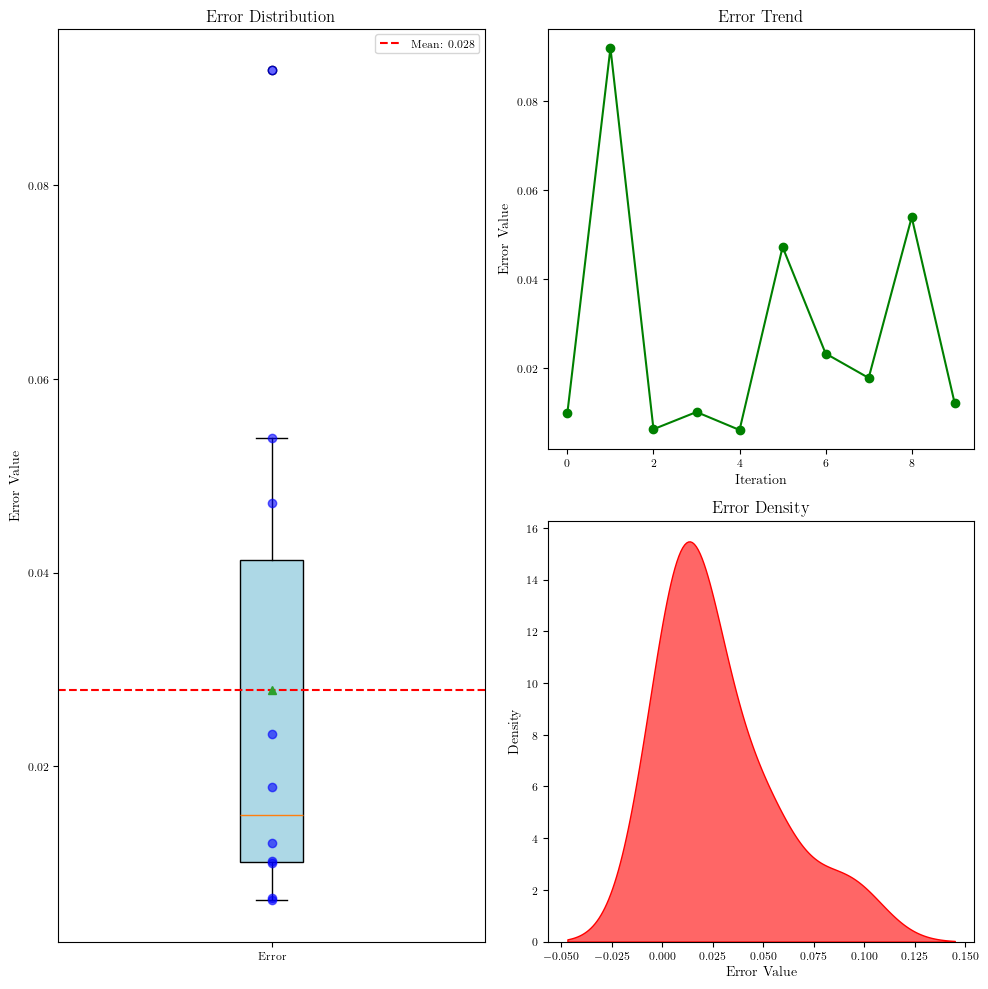

In [10]:

import seaborn as sns  # 导入seaborn库用于绘制密度图



plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列

mean_error = np.mean(error) #计算error数组的均值
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue')) #绘制箱型图，其中error是需要绘制的数据，patch_artist=True表示填充箱体，showmeans=True表示显示均值，meanline=True表示显示均值线，boxprops=dict(facecolor='lightblue')表示箱体的颜色为浅蓝色
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:.3f}') #绘制一条水平线，位于mean_error处，颜色为红色，线型为虚线，标签为均值
for i, value in enumerate(error): #遍历error数组，i为索引，value为值
    plt.plot(1, value, 'bo', alpha=0.6) #绘制散点图，横坐标为1，纵坐标为value（即error数组中每个数），颜色为蓝色，点形状为圆圈，透明度为0.6
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error']) #设置x轴刻度标签
plt.legend() #显示图例

# 右侧上方子图：折线图
plt.subplot(2, 2, 2)  # 第二个子图，现在布局为2行2列的第二个位置
plt.plot(error, '-o', color='green') #绘制折线图，横坐标为error数组的索引，纵坐标为error数组的值，颜色为绿色，点形状为圆圈
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

# 右侧下方子图：密度图
plt.subplot(2, 2, 4)  # 第四个子图，现在布局为2行2列的第四个位置
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()  # 自动调整子图参数，使之填充整个图表区域
plt.show()

In [11]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

testerror = torch.stack(model.test_error).cpu().detach().numpy()

70057
[8.8237172e-01 7.8062105e-01 6.9030088e-01 ... 3.8210739e-05 3.8209881e-05
 3.8209510e-05]


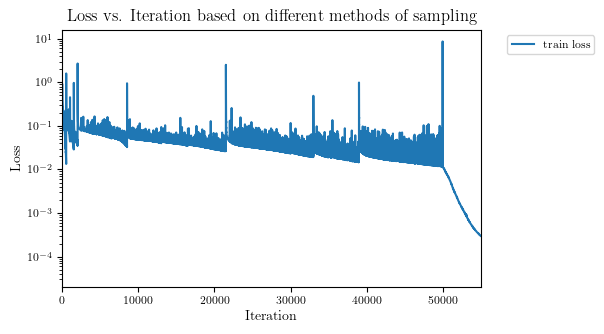

In [12]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,55000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

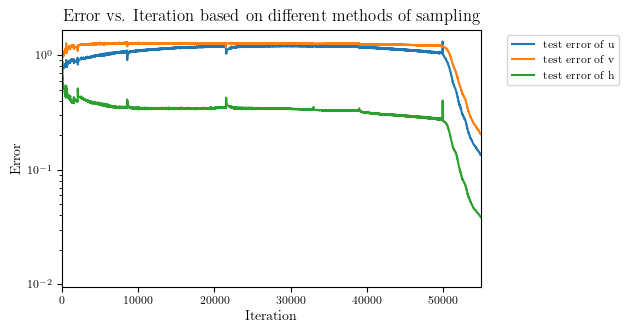

In [13]:
# print(len(trainloss))
# print(trainloss)
# 定义图例的标签
# labels = ["Grid"]

# 创建一个新的图形
plt.figure()

u_error = testerror[:,0]
v_error = testerror[:,1]
h_error = testerror[:,2]

plt.plot(u_error, label='test error of u')
plt.plot(v_error, label='test error of v')
plt.plot(h_error, label='test error of h')


# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,55000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Error') # 设置y轴的标签
plt.title('Error vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

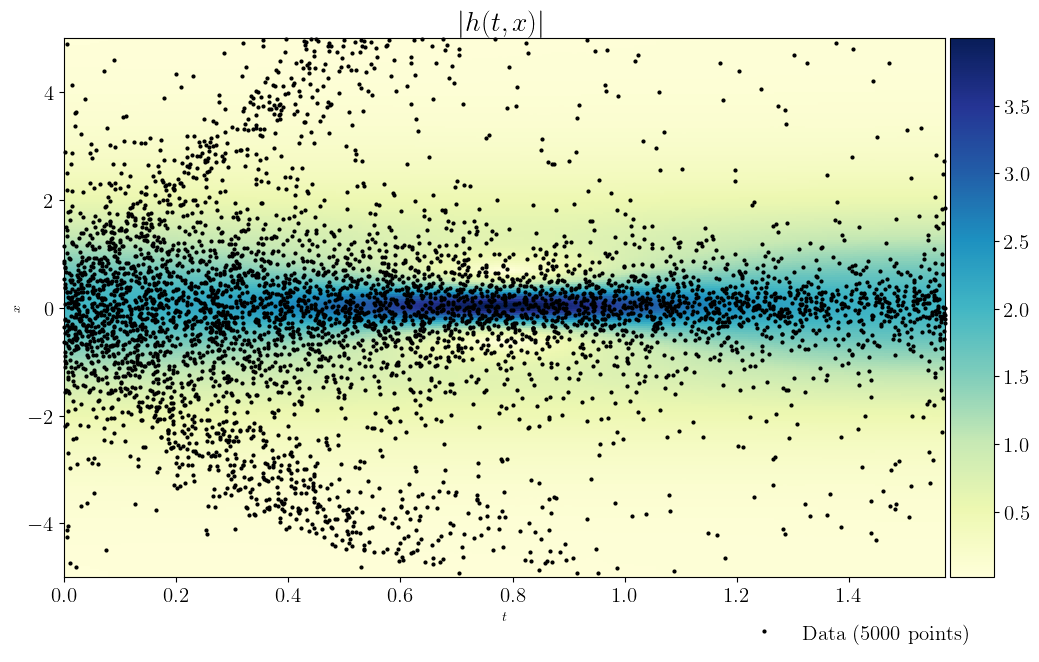

In [14]:


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(12, 7)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘制热图
h = ax.imshow(H_star.T, interpolation='nearest', cmap='YlGnBu', 
                extent=[lb[1], ub[1], lb[0], ub[0]], 
                origin='lower', aspect='auto')  #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是H_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                #第三个参数是颜色映射，这里是从黄色Yl到绿色Gn再到蓝色Bu；第四个参数是图像的范围，这里lb和ub分别是数据的下界和上界；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.05) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.05）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的

ax.plot(
    X_f[:,1], 
    X_f[:,0], 
    'ko', label = 'Data (%d points)' % (X_f.shape[0]), 
    markersize = 2,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  

# #绘制三条虚线
# line = np.linspace(x.min(), x.max(), 2)[:,None] #生成了一个包含2个等间距的数值的数组，这些数值在 x.min() 到 x.max() 之间。[:,None] 是一个索引操作，用于将一维数组转换为二维数组。这里其实就是[-5;5]
# #第一个参数是虚线的x坐标，line是虚线y的坐标，第三个参数是虚线的样式，k表示黑色，--表示虚线，最后一个参数表示虚线的参数是1
# ax.plot(t[75]*np.ones((2,1)),line,'k--',linewidth=1) 
# ax.plot(t[100]*np.ones((2,1)),line,'k--',linewidth=1)
# ax.plot(t[125]*np.ones((2,1)),line,'k--',linewidth=1)    

#设置标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

#    plt.setp(leg.get_texts(), color='w')   #用来设置图例中文本的颜色，这里是白色，取消注释后文本会变为白色
ax.set_title('$|h(t,x)|$', fontsize = 20) #设置子图ax的标题为$|h(t,x)|$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为10
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数








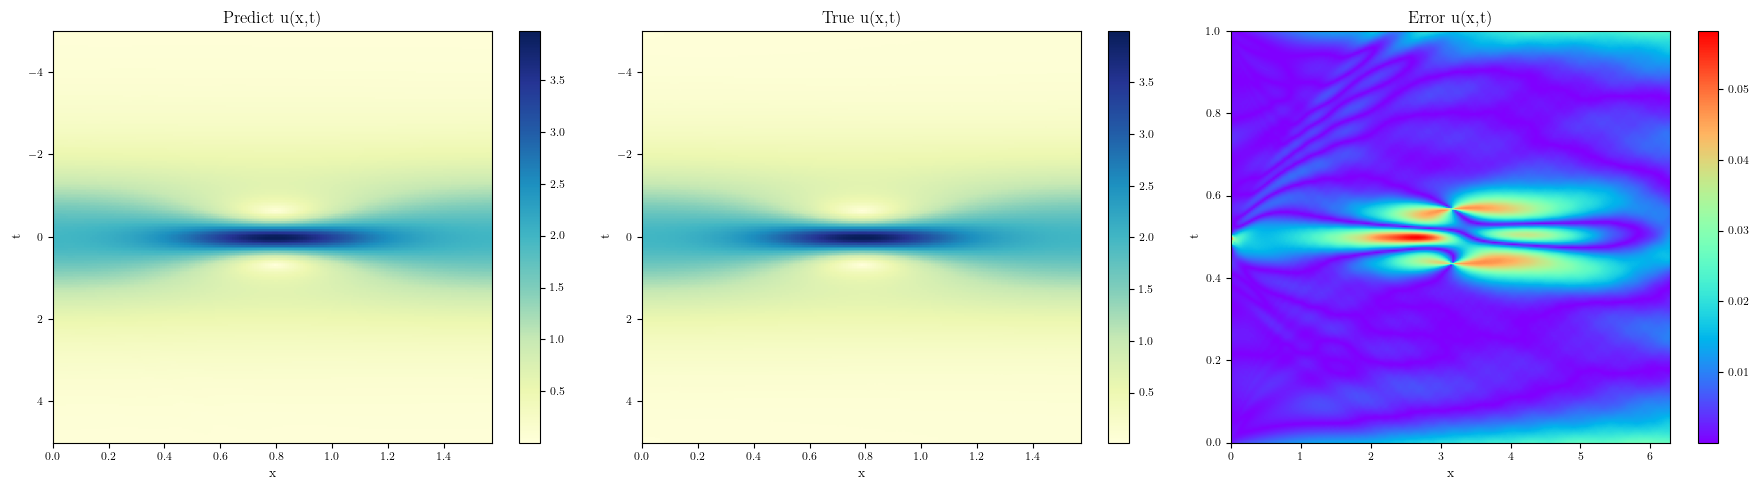

In [15]:


# 创建一个包含两个子图的图形
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1行2列的子图，图形大小为宽18英寸高5英寸

# 绘制第一幅图像
axes[0].imshow(H_pred.T, interpolation='nearest', cmap='YlGnBu', 
                extent=[lb[1], ub[1], lb[0], ub[0]], 
                origin='lower', aspect='auto')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Predict u(x,t)')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(H_star.T, interpolation='nearest', cmap='YlGnBu', 
                extent=[lb[1], ub[1], lb[0], ub[0]], 
                origin='lower', aspect='auto')
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('True u(x,t)')
fig.colorbar(axes[1].images[0], ax=axes[1])


# 绘制第三幅图像
axes[2].imshow(np.abs(H_pred - H_star).T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[2].invert_yaxis()
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
axes[2].set_title('Error u(x,t)')
fig.colorbar(axes[2].images[0], ax=axes[2])


# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()

In [16]:
#计算训练好模型的chaos（最后一个seed）
u_chaos = calculate_chaos(model, X_star, num_iter=50)
u_chaos_log = np.log(u_chaos + 1e-10) #对u_var取对数，然后加上一个很小的数，避免取对数时出现错误

#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_chaos = griddata(X_star, u_chaos.flatten(), (X, T), method='cubic')
U_chaos_log = griddata(X_star, u_chaos_log.flatten(), (X, T), method='cubic')

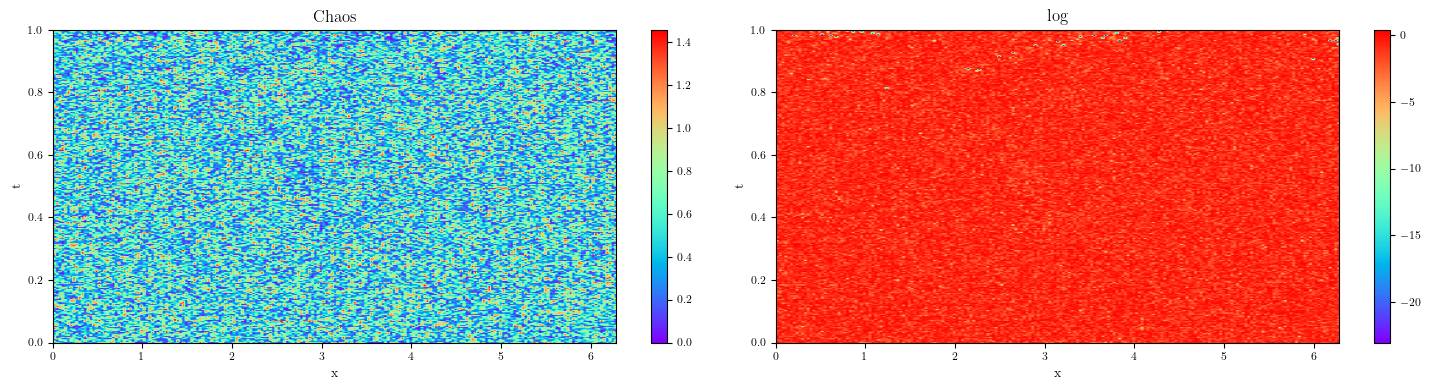

In [17]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_chaos.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Chaos')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_chaos_log.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('log')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()